# Experiments

In [1]:
# !pip2 install pypolyagamma

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg

#import importlib
#importlib.reload(logistic.agent_logistic)
#reload(sys.modules['logistic.agent_logistic'])

# Setup

Here $d=20$ and the number of arms is $A=10$. The number of timesteps is $T=1000$.

At the beginning $\theta\sim N(0,I_d)$ and $c\sim N(0,1)$ are generated. The reward given context $x\in \mathbb R^d$ is $\text{Bernoulli}(\sigma(\theta^\top x + c))$ where $\sigma(x) = \frac{e^x}{1+e^x}$. At each step $x_{t,1},\ldots, x_{t,A}\sim N(0,I_d/9)$ are randomly generated, and the algorithm picks one of the arms $1,\ldots, A$ and gets the corresponding stochastic reward.

If the algorithm chose actions $a_t$, regret is measured as $\max_{\{a_t^*\}} \sigma(\theta^\top x_{t,a_t^*}+c) - \sum_{t=1}^T \sigma(\theta^\top x_{t,a_t}+c)$, i.e., expected reward  against the best choice of $a_t^*$'s if $\theta$ were known.


In [2]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, df_list, cum_regrets_list, avg_regrets    

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seed=0, verbosity=0):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
    
def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets


In [3]:
num_articles = 10
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.02

verbosity=1

In [4]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda hypers: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda hypers: SGLDTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                        step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = hypers[1],
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda hypers: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = hypers[1],
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim+1, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)

In [5]:
make_best_sgld_agent = lambda: SGLDTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_best_sagald_agent = lambda: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

In [6]:
import warnings
warnings.filterwarnings('ignore')

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918]
Experiment: Step 0
 Laplace sample: array([-1.65072127, -0.89055558, -1.1191154 ,  1.9560789 , -0.3264995 ,
       -1.34267579,  1.11438298, -0.58652394, -1.23685338,  0.87583893,
        0.62336218, -0.43495668,  1.40754   ,  0.12910158,  1.6169496 ,
        0.50274088,  1.55880554,  0.1094027 , -1.2197444 ,  2.44936865,
       -0.54577417])
 Sample: array([-0.44317193, -0.19883786, -0.7003985 , -0.20339445,  0.24266944,
        0.20183018,  0.66102029,  1.79215821, -0.12046457, -1.23312074,
       -1.18231813, -0.66575452, -1.67419581,  0.82502982, -0.49821356,
       -0.31098498, -0.00189148, -1.39662042, -0.86131636,  0.67471153,
        0.61853913])
 Sample: array([ 1.27396609, -0.9726468 , -1.18487394, -1.59964233, -0.7882

 Steps taken: 35
 Sample: array([-2.65487052, -0.28133468,  0.50163042, -0.59772015, -1.20285911,
        0.87326128,  2.09601777,  0.7005536 , -0.58277771, -1.11047346,
        2.01382948, -1.15133604,  1.47201303,  1.42253043, -0.35513334,
        1.52537601,  0.26268657,  0.64493091, -1.3766812 , -0.2174515 ,
       -1.15908463])
 Sample: array([-0.02348997,  0.96763407,  0.35761192,  0.34424381,  0.35332683,
        0.52310004,  0.14516435, -2.04011975, -1.10670059,  0.20000169,
        0.32668869,  0.11152549, -0.31739242, -0.86435721, -0.96923572,
        1.3860426 , -0.7671048 ,  0.36001492, -0.32766253,  0.43443677,
        0.65268524])
 Steps taken: 98
 Sample: array([ 0.74335469,  0.1799931 ,  0.29900037,  1.29698531, -0.37903983,
       -0.20723622,  0.0350286 , -0.15420065, -0.47178921, -0.48686112,
        0.08331492, -0.0098174 , -0.24543188, -0.08202304, -0.34545555,
       -1.35413665,  0.2093086 , -0.01028324,  0.04853772,  0.34146539,
        0.46236142])
 Accept prop

 Sample: array([ 0.26257408, -1.14955385,  0.58029271,  0.86630812,  0.73275585,
        0.81421034,  0.05682368, -0.52622619,  0.69707357, -0.16789285,
        0.52974264, -0.63514409,  0.50754081, -1.62329876, -0.12051212,
        0.34189499, -0.13298395, -0.35645767, -0.67722328, -0.33706981,
       -0.70160694])
 Steps taken: 191
Experiment: Step 9
 Laplace sample: array([ 5.97876153,  1.1365131 , -0.33004579,  0.96546203,  3.29835046,
       -3.7596012 ,  1.24002552, -0.46923105, -0.81959724, -1.9906224 ,
        2.56646025, -1.31802886, -0.60194215, -2.508572  , -0.84067359,
        2.1853018 , -0.72760458, -0.23906201, -0.53253521,  0.4352817 ,
       -0.52453722])
 Steps taken: 28
 Sample: array([ 1.35421819,  0.83272603, -2.75346796,  1.61063087,  0.78308502,
       -1.6480597 , -0.92028771, -1.35903785, -0.16170131, -0.37335493,
       -0.34218305,  1.18228711, -1.87452171, -1.31796217,  0.28955699,
       -1.41290746,  0.65309539, -0.28880626,  0.26128742, -0.28947637,
     

 Steps taken: 30
 Sample: array([ 2.63245892, -0.59921813, -2.12005015,  0.76373684,  1.79761719,
       -0.36883129,  0.13556269, -0.48299097,  0.42999515, -0.29495697,
       -0.30648385,  1.69053048, -0.71583662, -0.05425583,  0.21899376,
       -1.1666473 , -0.33991149,  2.1724025 , -1.31960206, -0.24432926,
        0.05326403])
 Sample: array([ 1.00968319, -0.93118982, -0.37443632, -0.34446451,  0.97381541,
       -0.48733865,  0.76277897,  0.44251536, -0.12721919,  0.42797379,
        0.84396625, -1.29325938, -1.0487501 ,  1.70971713,  0.22941423,
        0.59948426, -0.80322569, -1.09821457, -0.54020243,  0.03299845,
        0.23397301])
 Steps taken: 110
 Sample: array([ 1.13180308,  0.21002859,  0.04688223,  0.05693929, -1.15803867,
       -0.69599059, -0.35901545, -0.12725533, -0.40067294, -0.4258593 ,
        0.39168294, -0.59925628, -0.25708726,  0.36789144, -1.01039278,
       -1.02655347,  0.04935482,  0.2207082 ,  0.39121347,  0.4168023 ,
        0.42162223])
 Accept pro

 Steps taken: 33
 Sample: array([ 2.0491938 ,  0.2598889 , -1.0652218 ,  0.56153923,  2.48995585,
       -1.06118789,  1.55963902, -1.13392247, -0.61612503, -0.09702093,
        0.8084919 , -0.23386316,  2.47191014,  0.28310594,  0.72983205,
       -0.64021644,  1.49914693,  1.25676889, -0.09391777,  1.89077899,
       -1.27613879])
 Sample: array([ 1.18354382, -1.00265749, -0.16791931, -2.30493211, -0.06763022,
        1.59293405,  0.1253455 ,  0.04501171, -1.42126697,  2.07271959,
       -0.07856955, -1.08685581, -0.95606647,  1.29582264, -0.09418004,
       -0.06527181, -1.87949187, -2.90381861, -2.84446139,  0.36745779,
        0.33385585])
 Steps taken: 86
 Sample: array([ 1.88285697,  0.28716003, -0.86109116,  0.24365591, -0.41911622,
       -0.56139972, -0.08968087, -0.57756595, -0.38676303, -0.04373357,
       -0.05597914, -0.50898985,  0.68222968,  0.61576299, -0.32067025,
       -0.41993787, -0.09346143,  1.16011188,  0.116695  ,  0.66290301,
       -0.10067992])
 Accept prop

 Steps taken: 28
 Sample: array([ 6.51139537,  0.75861216,  0.27333012, -0.91631578, -0.62108684,
        1.86050702, -0.89546735,  1.01341323,  0.93895445, -0.18789144,
        0.8972137 , -0.3968623 , -0.33425032, -1.29838925, -0.54100684,
       -1.2611626 ,  1.23424061,  1.05870123,  0.29741827,  0.30153696,
       -2.98111774])
 Sample: array([-0.11752154, -0.07740657,  2.61775898, -0.77618919,  2.11994443,
        0.22676873,  1.20730532,  0.95458424, -0.25014048,  0.22728077,
       -0.46574464, -0.18844675, -1.99078896,  0.73703482,  0.69683236,
        0.02412522, -1.48444464, -0.90688748,  0.00457656,  0.88780936,
        1.23604504])
 Steps taken: 90
 Sample: array([ 1.54070055, -0.08587766,  0.80492816, -0.7331229 , -0.16439049,
       -0.0545033 , -0.74632378, -0.45896019,  0.21745932, -1.71337479,
       -0.23103057, -0.18528533, -0.02446962,  0.36271804, -0.66987643,
       -1.00683155, -0.01631432,  0.52611946,  0.84182116,  0.09379146,
       -1.04662921])
 Accept prop

 Sample: array([ 2.2783381 ,  1.52596534, -1.76104386, -1.70630133,  0.50336104,
       -1.15812449,  0.88149269, -0.21208329, -0.63295575,  0.08774236,
        0.07365219, -1.28839494, -0.05320524, -1.01773845,  1.03041898,
        0.16685133, -0.73408639,  0.12177727,  0.27401977,  0.16519431,
        0.42130924])
 Steps taken: 65
 Sample: array([ 1.68174255,  0.20227502,  0.29395887, -0.81697496,  1.02162011,
       -0.80840561, -0.66420927,  0.24707515, -0.2021048 , -0.18301758,
        0.03586348,  0.6291555 , -0.30699097, -0.05966105, -0.02984706,
       -0.70858365,  0.56819246,  0.21991809,  0.80397468, -0.50662802,
       -0.93607962])
 Accept proportion: 0.400000
 Steps taken: 20
 Sample: array([ 1.36052811,  0.24901757, -0.38731525, -1.74959265,  1.00079237,
       -1.76420954, -0.79051731, -0.72563236,  0.71826992,  1.14907456,
        0.97515614, -1.1616636 , -1.66978219,  0.38863543,  0.22151788,
        0.04686633,  1.21039929, -0.13675593, -1.09381829,  0.73371118,
    

       -0.64339964])
 Steps taken: 81
 Sample: array([ 1.82191269, -0.08385738,  1.16563587, -0.11655666,  0.18866856,
       -0.33808517,  1.10395817,  0.40705917, -0.9103163 , -0.91514724,
        1.85934959, -0.42677672, -0.24584831,  0.45799804,  0.52716508,
        0.32832311,  1.05437681, -1.06157388, -0.53154618,  0.24114952,
       -0.38793819])
 Steps taken: 100
Experiment: Step 35
 Laplace sample: array([  3.7361765 ,   2.79558392,  -4.28482855, -12.29830552,
        14.82660045,  -6.03066573,   9.48473559,  -1.90110117,
         2.29501598,  -2.65974377,   9.48635609,  -4.28762613,
        -3.45484253,  -6.85523567,  -2.23006444,  -5.03754502,
        -2.48104484,  -4.66981852,  -1.80031257,   1.95661994,
        -0.31043141])
 Steps taken: 18
 Sample: array([ 2.57595335, -0.32552374, -2.03988382,  0.50747216,  1.31621973,
        0.8160983 ,  1.22418761,  0.04541154, -1.56934107,  1.37705402,
        1.91391137,  1.32209769,  1.53478626, -0.58043825,  0.14936083,
       -0.

 Sample: array([ 1.42985919,  1.36013094,  0.45300026, -1.05770658,  0.06602769,
       -0.54539593,  0.41579872, -0.64404775, -0.01180483, -1.0043525 ,
        0.17657336,  0.3513765 , -0.42394824,  0.20783423,  0.06479232,
       -1.6493132 ,  0.42245648, -0.18968606, -0.59830502,  0.22041961,
       -0.57751183])
 Accept proportion: 0.382353
 Steps taken: 34
 Sample: array([ 1.95627425,  0.54378626,  0.91357383, -1.21328553, -0.52983191,
       -0.64653312, -0.57780107,  0.52470908,  0.95146433,  0.03917877,
        0.67068434, -0.40439775,  0.29397817,  1.10525588, -0.47754944,
        0.62832482,  0.45326828,  0.63784349, -1.29100019, -1.72892663,
       -0.31958932])
 Steps taken: 76
 Sample: array([ 2.22349781, -0.42731774,  0.67906355, -0.24230845, -0.2054545 ,
       -1.52156308, -1.06978881, -1.37376829, -0.06550594,  0.71912168,
        1.1477426 , -0.9561683 ,  0.8024354 , -2.02590312,  0.93299579,
        0.59629242,  0.12947799,  0.1742383 ,  2.14994932, -1.70802864,
    

 Sample: array([ 1.10171002,  0.44889394,  1.30527584,  0.48449282,  0.79077379,
       -0.86195499,  0.17811988, -0.98890974, -0.5949847 , -0.53926211,
        0.49846719, -1.03341801,  0.35764124,  0.56252258,  1.60490061,
       -2.24375896, -0.1248398 , -1.09174025,  0.29822742, -0.53238082,
        0.53241301])
 Steps taken: 88
Experiment: Step 45
 Laplace sample: array([  5.66050583,   2.69863379,  -1.91583228, -11.02596136,
        13.65669595,  -4.46013643,   9.17521745,  -3.39166405,
         3.54897508,  -4.55862895,   6.44510759,  -3.87831932,
        -2.48536217,  -7.25084752,  -1.24882006,  -5.15418958,
        -4.33477209,  -3.17074562,  -0.85308964,   2.06332173,
         1.16729661])
 Steps taken: 24
 Sample: array([ 4.59568177, -1.27785756, -0.27033395, -1.54901779, -2.2773607 ,
       -0.52541225,  0.49848818,  2.04034648, -0.36093863,  0.56852081,
       -1.50715953,  0.56145123, -0.28626029,  0.2144697 ,  2.75714433,
       -1.20010491,  0.92422043, -0.55754166, -0.

 Sample: array([ 1.58886289,  0.26661972,  1.56670658,  0.99987101,  0.15720309,
       -0.96977476,  0.38566325, -0.1211739 , -1.03669444, -0.15153597,
        1.5301799 , -0.11092688,  1.80276301,  0.0424299 ,  1.16230977,
        0.30219806,  1.00587184, -0.82339107,  0.161768  , -0.2567129 ,
       -0.69345219])
 Steps taken: 147
Experiment: Step 50
 Laplace sample: array([  3.39063508,   1.65012116,  -2.58613433, -11.76731373,
        14.23417258,  -6.61089017,  10.83212844,  -1.19118643,
         1.11715385,  -2.57735892,   7.27442363,  -4.58679947,
        -2.33660963,  -7.21127215,  -1.52669815,  -4.28097752,
        -1.01030349,  -3.37790941,  -2.27535669,   2.75734715,
         0.5959059 ])
 Steps taken: 64
 Sample: array([ 2.68974334,  0.88934726, -1.49267985,  0.25439909,  1.3110655 ,
        0.49055098,  0.59566186, -0.47527862, -1.5756838 , -0.99545056,
       -0.60938186, -1.20088857,  1.34617169, -1.29420966,  2.35374196,
       -0.02004697, -0.39842261,  0.40392691, -0

 Laplace sample: array([  2.47060553,   3.4381025 ,  -0.05715314, -12.29345321,
        13.42331636,  -2.23029451,  12.47297416,   0.11188258,
         4.42002278,   0.0655958 ,  17.92607591,  -9.04169618,
        -5.90393995,  -4.35809034,   6.88407418,  -9.27312657,
        -6.67347997,  -4.64233292,  -3.43213388,   2.11691805,
         0.46968111])
 Steps taken: 31
 Sample: array([ 3.77226371, -0.98904808, -1.36023412,  0.30087178, -0.11027026,
       -1.20579478,  1.74723573, -0.90275515, -0.92081235, -0.24074472,
       -0.38362257,  0.8590083 ,  0.38085848,  0.39780452,  2.72131819,
       -2.03893755,  2.65901992, -0.48084164,  0.84337171,  0.06969012,
        1.04031001])
 Sample: array([ 2.25751143,  0.0526484 , -0.14289161,  0.62477406,  0.27598202,
       -0.33147594,  1.18591539,  1.60940583,  0.37485878, -0.46669843,
        1.96768488, -1.77477965,  0.97165849,  0.54536569,  0.58138258,
       -0.24741425,  0.19314568, -0.500833  , -1.4315768 ,  0.36738371,
       -1.7209

 Steps taken: 30
 Sample: array([ 3.38769059, -1.1392175 , -0.05456407,  2.22825945, -1.27013285,
       -1.99068594, -0.17842687, -1.59349193,  0.72594396, -1.43139914,
        0.4652806 , -0.60251396,  0.59766911, -0.75783673,  1.34715336,
       -0.74766289, -0.78594355, -1.08227991,  1.14065899,  0.86361646,
       -0.24455456])
 Sample: array([ 1.6805977 ,  1.97802496, -0.60235235, -0.40813242,  1.30614609,
       -1.47006855,  0.81588542,  1.08419051,  0.23135006, -1.0240547 ,
       -0.06420579, -0.27441193, -2.31505086, -1.15804846,  0.6285062 ,
       -0.77679875, -0.22817338, -0.68240395, -1.26878335,  0.65701186,
        0.62139727])
 Steps taken: 83
 Sample: array([ 1.53918051,  1.01429971,  1.02857775, -0.13656825,  0.39596429,
       -0.0177323 , -0.52959563, -0.26159144,  0.1143095 , -0.33051954,
       -0.02084955, -0.70336451, -0.38191694, -0.24700083,  0.44020415,
       -1.23802276, -0.77285481,  0.55520941,  0.13491332,  0.7554074 ,
       -0.43027358])
 Accept prop

 Steps taken: 26
 Sample: array([ 2.1315631 ,  0.12254801, -1.63689287,  1.96353745, -0.6308195 ,
       -0.49271289,  0.05243153,  0.79918269, -0.74556778, -0.09804187,
       -0.65173766, -0.53125069,  0.55861983, -1.91596362, -0.60644097,
       -0.76754995, -0.04195268, -1.26122128, -1.1158384 , -0.95357044,
       -0.85418469])
 Sample: array([ 1.30014323,  1.53570541,  0.72522412, -2.55212847,  0.78909991,
       -1.65384503,  0.57540341, -1.44844158, -1.43993344, -0.25290216,
       -0.0177189 , -0.93835584, -0.374818  ,  0.08814   ,  1.39376056,
       -0.94663513, -0.59990291,  0.10661982, -0.385642  ,  0.58130297,
       -1.52001907])
 Steps taken: 87
 Sample: array([ 1.97785155, -0.27980339, -1.02949197, -0.47316342, -0.00723959,
       -1.2317855 ,  0.4950552 , -1.43102989,  0.57702207, -0.5803576 ,
       -0.07621205, -0.8170635 ,  0.10544006, -0.92462394, -0.37242966,
       -1.62624896,  0.16440146,  0.80615264, -0.75688038, -0.1212376 ,
       -1.06766738])
 Accept prop

        0.4932504 ])
 Steps taken: 77
 Sample: array([ 1.42155988,  0.40544053,  1.53801235,  0.05201794, -0.1560265 ,
       -0.4121555 ,  0.85789194, -1.80615188,  0.49999149, -0.30379977,
        0.29815924, -1.57182377,  0.36681555, -0.51509946,  1.21875333,
       -0.23073595,  0.1167323 , -0.56354916,  0.35779903, -0.30819369,
       -0.59788626])
 Steps taken: 105
Experiment: Step 68
 Laplace sample: array([  0.54739097,   0.22926004,  -9.15970398, -22.0530373 ,
        21.83460263,  -6.52553029,  14.9684024 ,   5.04240386,
        -0.47029287,  -6.6300006 ,  22.83194076, -11.46412794,
        -3.22727965,  -3.89752807,   2.1865656 ,  -9.08981809,
       -15.0973121 ,  -6.35070902,  -5.34374858,  10.8733932 ,
        -3.62048844])
 Steps taken: 30
 Sample: array([ 2.92410754,  0.11577096, -0.21943996,  0.80007409, -1.03250639,
       -1.68816837,  0.99413639,  0.21904746,  0.14595263,  0.46436475,
        1.73407484,  0.13642637,  1.72147097, -0.23067607,  1.06376182,
       -2.

 Sample: array([ 1.26319946, -0.85573233,  0.94373029,  0.23778191, -0.42686265,
       -0.75777777,  0.27306399, -0.884536  ,  0.09857356, -0.8606498 ,
        1.50275213,  0.40390004,  0.77015649, -0.32071385,  0.28155969,
       -0.09629952, -0.75059615, -1.27892222,  1.07057183, -1.32763185,
       -1.6164465 ])
 Steps taken: 72
Experiment: Step 73
 Laplace sample: array([ -0.24526929,   0.56306689,  -9.08316883, -22.82972961,
        18.8320203 ,  -6.02361618,  14.88645329,   2.62486579,
        -2.0099874 ,  -6.60676566,  19.43527174, -13.43689506,
        -2.43078256,  -4.4789244 ,   2.54743323,  -8.73502663,
       -14.64348959,  -7.42576283,  -5.00164582,  10.43112038,
        -3.74472721])
 Steps taken: 22
 Sample: array([ 2.84213561, -2.00482323,  0.53421053, -0.14530851, -0.70645081,
       -0.2644998 ,  0.38882122,  0.30740382, -0.20743464, -1.61108077,
       -0.17971286, -0.4965721 , -0.7646799 ,  0.41605474,  0.10301614,
       -1.47261666,  0.77548689, -0.48595832, -1.

 Sample: array([ 1.57735352,  0.09590623, -0.80949258,  0.81558378, -0.97403603,
       -1.17672949, -0.7120187 , -0.87395144,  0.57173623, -0.84219002,
       -0.38998295, -0.90000793,  0.20464404, -0.61580037, -0.50297766,
       -2.25520548,  0.45527997,  0.60625733,  0.07367882,  0.37947359,
       -0.51365333])
 Accept proportion: 0.555556
 Steps taken: 18
 Sample: array([ 1.39393135, -0.06233611,  0.70569721, -1.32273934,  0.93558036,
       -1.40640681, -0.4749846 , -0.16764177,  0.46157406,  0.31579043,
       -0.10926874, -1.20164267,  0.45681042,  1.38534373,  1.64946362,
       -2.7800039 ,  0.55928395, -1.32315606,  0.3380589 , -0.13950028,
        0.33765668])
 Steps taken: 62
 Sample: array([ 1.80402273, -0.57585326,  0.27976108,  0.44733462,  0.0755286 ,
       -0.84283573,  0.95670763, -0.75296703,  1.44177659,  0.99256343,
        1.08278292, -0.75818089,  0.80498521,  0.02448087,  0.36310204,
        0.40463939,  0.4691449 , -0.081238  , -0.14769377, -0.68638703,
    

 Steps taken: 26
 Sample: array([ 2.10115515,  0.6780831 , -0.4112342 , -1.91549352, -0.43990952,
       -0.34035834,  1.81919707, -1.51689048,  1.50356942, -0.54743744,
        0.34142729, -0.93249373, -0.02280775, -0.52201854,  2.64989347,
        0.01764925,  0.94277926,  0.85654985, -1.47237665, -0.21774148,
        0.55943516])
 Sample: array([ 1.40558298, -0.32297891, -0.50288179, -1.0067098 , -0.58158455,
       -0.36604888,  0.99397237, -0.39355504,  1.0084421 , -0.10576981,
       -1.07954987, -0.98597222, -0.38105636,  2.31093565, -1.77837569,
       -0.37669555, -1.25894159, -1.88859366,  0.47777439,  0.6334493 ,
       -0.75683841])
 Steps taken: 78
 Sample: array([ 1.79616895,  0.28911374,  0.09092087, -0.73200814,  0.86738695,
       -0.65335581, -0.78411585, -0.83829094, -0.6885248 , -0.84828216,
       -0.35376639, -0.88899869, -0.13073945,  0.13733066,  0.82839702,
       -1.05223532, -0.04889186,  0.93084623, -0.46598103,  1.44263564,
       -0.76114097])
 Accept prop

 Steps taken: 51
 Sample: array([ 2.6299394 , -1.47075872, -0.37592748,  0.57237283, -0.17906261,
       -0.310101  ,  0.19256932, -0.7125526 , -0.84007951, -0.42093828,
        0.50870831, -0.94240854, -0.77655162,  0.69735544,  1.51869651,
       -0.91400299,  1.03550388, -0.44342853,  0.68369467,  0.53558411,
       -1.4654292 ])
 Sample: array([ 1.09081591, -0.60148042, -0.11750042, -1.24235984,  0.05716527,
       -1.45808115,  0.98344535, -2.33982573,  1.73198209,  0.53279248,
       -0.53108878, -0.93205116, -0.75794913,  0.11303225, -1.97808445,
       -0.54935753, -0.92417057,  0.80808126, -1.1288596 ,  1.17232319,
       -1.73920353])
 Steps taken: 149
 Sample: array([ 1.70705418,  1.06811717,  0.1480398 , -0.12842675, -0.13474976,
       -0.56170568, -0.14883566, -0.91547536, -0.16939253, -0.0026644 ,
       -0.15303925, -1.35002956, -0.7307358 , -0.37946803,  0.92429229,
       -1.98646018,  0.72373461,  0.10092241,  0.58784571,  0.192708  ,
       -0.91587005])
 Accept pro

 Steps taken: 45
 Sample: array([ 2.19302235,  0.14853183,  0.46494385, -0.23635058, -0.83200824,
       -1.0418258 ,  0.41629396, -1.50625124, -1.51969601, -0.04901876,
        0.96549206,  0.54746045, -1.20531174,  0.20167075,  1.8415754 ,
       -1.36154368,  0.23958622,  0.75017426,  0.8187055 ,  0.1175227 ,
       -0.76040301])
 Sample: array([ 1.34916488,  0.61441209,  0.0774681 , -1.44328486, -0.39973781,
       -0.01225202,  0.66899175, -1.12629189,  0.9453733 , -1.12662581,
        0.9704031 , -0.98198109, -1.2651884 ,  1.37333281,  0.80247108,
       -0.11424781, -0.75821213,  0.20289081,  0.79783211, -0.31115455,
       -0.27218146])
 Steps taken: 140
 Sample: array([ 2.03564547, -0.46603346, -0.44069162, -0.89755998, -0.3472791 ,
       -1.17056193,  0.39545898, -1.26522026,  0.36595686, -0.17337281,
        0.22926679, -0.79057462, -0.18167264, -0.43830532, -0.07862698,
       -1.2006947 , -0.07199018,  0.34466508, -0.16690583, -0.3323245 ,
       -0.45241587])
 Accept pro

 Sample: array([ 1.58848276,  0.69688053, -1.08734143, -0.1524948 , -0.04493021,
       -1.01662887,  1.46852621, -2.13032198, -0.7775156 , -0.51781885,
        0.80819348, -2.13218515, -0.76315118,  0.29365924,  0.64586826,
       -1.42217228,  0.05182902, -1.73810722,  0.31668026,  0.54935716,
       -1.64438146])
 Steps taken: 119
 Sample: array([ 2.1587184 ,  1.27838099, -0.32354784, -0.73335022, -0.2002734 ,
        0.07061626, -0.05638492, -0.43063114, -0.42578053, -0.76602994,
        0.39126701, -1.8245307 , -0.44094149,  0.10954638,  0.69604028,
       -1.53161456, -0.00791162,  0.07575928,  0.27586074,  0.42207249,
       -0.51384036])
 Accept proportion: 0.511628
 Steps taken: 43
 Sample: array([ 1.06506035, -2.78496715, -0.0952211 , -2.31972647,  0.79831784,
        0.39687608, -0.79548128, -1.51349914, -0.28288689,  1.05899931,
       -0.78449262,  0.59659869,  0.12619186,  0.20949696, -0.12908668,
        0.74279756, -1.32592461, -0.46129897, -0.34054925,  1.4882462 ,
   

 Sample: array([ 1.49433838,  0.11478068, -1.71465857, -1.91070233,  0.67879073,
       -0.60560804,  0.37680641, -0.79124002,  0.5683586 ,  0.10003424,
        0.35174616, -1.62725313, -1.78456576,  0.70119511,  1.44445019,
       -0.06449378, -0.03122048, -1.47554454,  1.32697111, -0.20404151,
        0.0366277 ])
 Steps taken: 67
 Sample: array([ 1.4202019 ,  1.71355459, -0.5533282 , -0.57932201,  0.32506322,
       -1.22653332,  0.10218572, -1.14195869, -0.73505468, -0.92891753,
        0.24173167, -1.18795997, -0.34571139,  0.44509487,  0.72980455,
       -1.75442441, -0.35891028,  0.89294569,  1.16846976,  0.03393543,
        0.22065063])
 Accept proportion: 0.666667
 Steps taken: 24
 Sample: array([ 1.67524733, -2.21740882,  0.20914534, -2.11750658,  0.75613157,
       -0.44863089,  1.12312527, -0.06455162, -1.59727278,  0.19346563,
        0.88331019,  0.54319523,  1.36343247,  0.62836806,  0.10982655,
        0.22103733, -0.76610719, -1.06637309, -0.37043948,  0.04238759,
    

       -0.9096853 ])
 Steps taken: 52
 Sample: array([ 1.47142748,  0.83991437, -0.83607557, -1.48257593, -0.31994633,
        0.35209777,  0.56345231, -0.59839353, -0.81338291, -0.80807478,
        0.57476512, -2.47773626, -0.27236849, -1.02761914,  0.16149523,
       -1.2193842 ,  0.01861783,  0.66116119,  0.05134305,  0.11254318,
       -1.15146178])
 Accept proportion: 0.600000
 Steps taken: 20
 Sample: array([ 1.1558283 , -1.54047365, -0.42065568, -3.45891538,  1.87200883,
       -1.31532222,  1.30662433, -0.8542238 , -2.06359528,  0.49588554,
       -0.3823904 , -0.98704156,  1.26357855,  0.33484437, -1.0396424 ,
        0.91316994, -0.17370715, -0.83041054, -0.8562943 , -0.58826633,
       -0.03952626])
 Steps taken: 135
 Sample: array([ 1.76563248, -0.41986783,  1.52955932, -0.17397078, -0.43506564,
       -0.84828066,  1.67220171, -1.61158831,  1.54575298,  0.16193375,
        1.28743969, -0.9003833 ,  0.02537545, -0.1153705 ,  0.79618924,
       -0.77941469,  0.22052025, -0.4

 Sample: array([ 2.24787693, -0.58936137, -0.72205881, -2.33784748,  0.26332449,
       -0.62252248,  0.83085631, -0.68191059, -1.28178946, -0.77992706,
       -0.00771137, -0.83225039,  0.42624074,  0.0782897 , -1.10829544,
        0.61800401,  0.0051069 , -1.62633185, -1.33894121, -1.22679987,
       -0.65414587])
 Steps taken: 88
 Sample: array([ 1.78510165,  1.30696989,  0.64002995, -1.87143496,  1.0038993 ,
       -1.77700388,  0.37752206, -1.03585139,  1.83949792,  0.31488258,
        0.44042643, -1.76412453, -1.5597711 ,  0.27845   ,  0.91335195,
        0.28204247,  0.05299655, -0.90891805,  0.64198617,  0.57752748,
       -1.61823873])
 Steps taken: 104
Experiment: Step 112
 Laplace sample: array([   2.22672943,   25.17081106,  -15.14516908, -100.06040187,
         70.99985694,  -41.49888936,   83.75866853,  -63.99741394,
          6.22866146,  -53.27444257,   69.70721477,  -29.65889841,
        -51.51320181,  -22.31773853,   51.64522828,  -76.77056686,
        -48.53178768,  

 Sample: array([ 0.56490473, -0.50660101,  0.32178687, -1.84877004,  0.60134119,
       -0.78538408,  0.01146612, -0.3566997 , -0.47259462, -0.16084426,
        2.00357097, -0.59114047,  0.09984746, -0.54516796, -1.0011941 ,
        0.42751435,  2.12123569, -1.28773356,  0.37304235, -2.05426723,
        0.21165776])
 Steps taken: 83
 Sample: array([ 1.16728485,  1.03132727,  1.93866739,  0.22248862, -0.4886304 ,
       -1.15423132,  1.32283254, -0.61595596,  1.2240916 , -0.41657524,
       -0.20442575, -1.05951162, -1.194167  ,  0.44536236,  0.4563326 ,
       -0.86190378,  0.22466657, -1.45284938, -0.42744777,  0.56655753,
       -2.14768423])
 Steps taken: 59
Experiment: Step 116
 Laplace sample: array([   6.19266175,   46.16577277,  -18.26465312, -125.53345901,
         85.2861849 ,  -49.51817871,   99.09715758,  -88.07911797,
         27.49957017,  -70.24187175,   79.45029894,  -66.54079298,
        -93.19001843,  -30.2048392 ,   53.81050631,  -68.14662522,
        -74.56540409,  -

 Sample: array([ 1.72872395, -1.45369989, -0.0479151 , -0.78748662,  0.93357961,
       -2.59660766,  0.90719183, -0.76800384,  0.23172013,  0.37184768,
        0.28983909, -2.68680627, -0.98320735,  0.25867335,  0.82708628,
       -1.88461234, -1.33860185,  0.21308147, -0.52822589,  1.14124665,
       -0.23900365])
 Steps taken: 41
 Sample: array([ 1.75761793, -0.92350133, -0.87889374, -0.63041986, -0.8028606 ,
       -0.70546084,  0.6574214 , -1.38145301, -1.06518176, -1.13393891,
        0.68483676, -1.17684961, -0.26556507, -0.24114989,  0.49740142,
       -2.24232305,  0.31940803, -0.46166073,  0.29946933,  0.34172813,
        0.17690097])
 Accept proportion: 0.533333
 Steps taken: 15
 Sample: array([ 1.36868535, -1.01270978,  0.8805262 , -0.99676037,  1.09576365,
       -1.62918381, -0.72826405, -0.11130957, -1.28581138,  0.12400522,
        0.00875623, -0.95022734, -0.3157897 ,  0.03226819,  0.30034519,
       -0.14697806,  0.80175753, -0.6404603 ,  1.58025904, -1.05169556,
    

 Sample: array([ 1.96840938, -0.59070564,  0.22570009, -1.05406907, -0.81617216,
       -1.45884646,  1.25830088, -0.53156512, -0.77236517, -0.39631467,
        1.40610109, -1.93112152, -1.44957569,  1.08573572, -0.17086472,
       -0.44382491,  0.75172813, -0.96236325, -0.11868652,  1.20440012,
       -0.84719604])
 Steps taken: 42
 Sample: array([ 1.7025098 , -0.32417763, -0.09903391, -0.29948757,  0.40181106,
       -0.66903898,  0.45433098, -0.80106756, -1.0293241 , -1.15291671,
        0.40681539, -1.06778848, -0.20871462, -0.30639779,  0.29848953,
       -2.51453165,  0.39314337, -0.52494173,  0.46951508, -0.17638365,
       -0.94088432])
 Accept proportion: 0.533333
 Steps taken: 15
 Sample: array([ 2.0623577 , -0.79447051,  0.63576146, -1.40304152,  1.21624565,
       -0.365179  , -0.18092958,  1.96328103, -1.47762927, -0.61939782,
        0.24309047, -1.5490809 , -0.81538777,  0.0100559 ,  0.15662479,
        0.32198651,  0.67481697, -0.30317882,  1.73649469, -1.578464  ,
    

 Sample: array([ 1.23341756,  0.09695101,  0.40630095, -1.22588564,  0.64054894,
        0.47131279,  0.17255255,  0.9257829 , -0.60308112, -0.4242179 ,
        0.93046697, -0.63923324, -0.05640233,  1.02277164,  0.73789597,
       -0.1301597 ,  0.98617458,  0.33980156,  1.28190278,  0.12775518,
       -0.52085437])
 Steps taken: 71
 Sample: array([ 2.7829172 ,  1.2375665 ,  2.00024708, -0.0468107 , -0.0096404 ,
       -2.03371218, -0.11030427, -1.07404333,  1.95975575, -0.62581724,
        1.05490776, -0.57753097, -1.06703754,  1.01668757, -0.52493492,
       -0.31202923,  0.75868818, -1.54600775,  1.70389764,  0.07500319,
       -1.0963971 ])
 Steps taken: 66
Experiment: Step 131
 Laplace sample: array([  -0.20684994,   36.53386208,   -9.59060735, -117.94759657,
        105.87992412,  -41.74918004,  108.16657078,  -67.82274103,
         14.33305941,  -76.45883066,   79.7599099 , -119.62583634,
        -55.38775173,  -50.58105749,   66.5691812 ,  -73.32075823,
        -80.13324158,  -

 Sample: array([ 2.07330017,  0.20481786, -0.23899028, -1.46048282,  0.61799278,
       -1.13150475, -1.02803745,  1.6663815 , -1.41027126, -0.42876318,
        0.99998072, -0.9154533 , -0.49313661, -0.07589681,  0.25988699,
       -0.31327015, -0.21117166, -1.05000283,  0.30072635, -0.04474238,
       -0.40282426])
 Steps taken: 108
 Sample: array([ 2.16077467,  1.0804818 ,  1.44627398, -1.00234598, -0.20284026,
       -1.59047508, -0.19115812, -1.51173742,  1.22427897, -1.78912802,
        0.44114256, -0.75587239, -0.88907957, -0.49486065,  0.37578355,
       -0.11322998,  0.28627013, -0.60974879,  0.370209  ,  0.07646027,
       -2.19191441])
 Steps taken: 96
Experiment: Step 136
 Laplace sample: array([  -0.19197666,   34.24094147,   -8.91643166, -118.94403117,
        106.30969543,  -43.26360084,  107.18023444,  -67.44884378,
         14.3049309 ,  -76.10124842,   80.96146345, -120.67827411,
        -54.0384108 ,  -50.95338963,   67.69616913,  -72.02808335,
        -77.40207626,  

 Steps taken: 9
 Sample: array([ 1.3687877 ,  0.49194102, -0.61246946, -1.19812235, -0.23311944,
       -0.44922194,  0.10157278, -0.87581273, -0.50141038, -1.20158647,
        0.74032152, -1.96006325, -0.74206045, -0.39416089,  0.20596462,
       -1.59317007,  0.35215615, -0.43689452, -0.84199716,  0.27266381,
       -0.14597724])
 Accept proportion: 0.562500
 Steps taken: 16
 Sample: array([ 2.05318524,  0.79692616, -1.16445836, -0.55645546,  0.33097374,
       -1.27331853, -1.12277226,  1.53060252, -1.50779146,  0.63134751,
        0.25924878, -0.51549075, -0.7575177 , -0.08061478,  0.71901482,
        0.67175168, -0.94461137, -1.44494696, -0.02665576,  0.6677199 ,
       -0.94065058])
 Steps taken: 67
 Sample: array([ 2.12150079, -0.19487151,  0.39007077, -0.86295607, -0.21837923,
       -1.53369752,  0.775287  , -0.40756183,  2.59721633, -0.07436356,
        0.91170318, -1.15915318, -1.38426938,  0.23301375,  0.44964503,
       -0.11614191, -0.18094722, -1.24969169,  1.60707356,  

 Sample: array([ 1.57862858,  0.60349088,  0.0697017 , -0.41361992, -0.27497215,
       -0.62562173, -0.0863472 , -0.59840693, -1.90609161, -1.02423217,
        0.66564676, -0.97214769, -1.13398972, -0.97445499,  0.84897152,
       -1.3147307 ,  0.34929385, -0.75018873, -0.50753198, -0.03769093,
       -0.94208018])
 Accept proportion: 0.500000
 Steps taken: 14
 Sample: array([ 1.19174793,  0.97729969, -1.17212876, -0.53658023, -0.48249264,
       -1.14194085, -0.60184657,  0.8579117 , -1.51914889,  0.74568355,
        0.91395255, -0.4846436 ,  0.15301801,  0.81343992,  0.58813539,
        0.97454564, -0.45333138, -0.93498891,  1.2091871 ,  0.70461367,
       -0.15804734])
 Steps taken: 57
 Sample: array([ 2.3787661 ,  1.18496147,  0.31392495, -0.8996498 ,  0.61045043,
       -0.96204352, -1.19214971, -0.20452521,  0.21638672,  0.33056465,
        1.45304436, -1.58243981, -0.9548778 ,  0.88997084,  1.07543708,
        0.63739611, -0.19226177,  0.82825733,  1.0653537 , -0.0776474 ,
    

 Sample: array([ 0.34494255,  0.70150413, -0.21797897, -1.51009952, -0.58058354,
       -0.28593019, -0.09163783, -0.22861388, -1.30518138, -0.01305975,
        1.07953995, -0.33067006,  0.32029535,  0.51039877, -0.49916183,
        0.4947372 , -0.11471546, -0.32731317,  0.95260432,  0.17615989,
       -1.21470886])
 Steps taken: 59
 Sample: array([ 1.93671041, -1.45038581,  0.60142736, -0.61962366,  0.54941901,
       -1.73312382,  0.03254325,  0.67058392,  1.79754577, -0.29934269,
        1.69442844, -1.2118141 , -0.29157224,  0.4663349 , -0.25495576,
       -0.95208492, -1.79485193,  0.02946191,  1.44531688, -0.07359612,
       -1.60865818])
 Steps taken: 49
Experiment: Step 151
 Laplace sample: array([   0.15665272,   35.98498707,   -7.97360001, -118.96749457,
        108.28482006,  -41.15450958,  107.8777688 ,  -66.85514458,
         15.82335421,  -76.80121155,   81.05804957, -119.23026397,
        -55.24490154,  -51.77459203,   68.66519714,  -71.74337226,
        -80.29788995,  -

 Sample: array([ 2.37183736,  0.39086317, -0.26808383, -0.1402537 , -0.20314651,
       -1.7869796 , -0.67978693,  1.47718473,  1.42400919, -1.0055996 ,
        0.82712027, -1.231313  , -0.4923927 , -0.85387381, -0.08847549,
        0.26678397, -1.90872558, -0.50885081, -0.14973704,  0.1051336 ,
       -1.65880923])
 Steps taken: 17
Experiment: Step 156
 Laplace sample: array([ 1.28518771e-02,  3.58549260e+01, -8.09318180e+00, -1.20104803e+02,
        1.10026320e+02, -4.22215724e+01,  1.07831994e+02, -6.78621520e+01,
        1.70587681e+01, -7.81284551e+01,  8.09969231e+01, -1.19660837e+02,
       -5.52285743e+01, -4.99161558e+01,  6.92974146e+01, -7.42151263e+01,
       -8.04908227e+01, -2.98749436e+01, -3.05002072e+01, -1.87471892e+00,
       -5.65476929e+01])
 Steps taken: 31
 Sample: array([ 2.44708842, -0.78139668,  0.9970773 ,  0.11653853, -0.10918674,
       -0.33611482,  0.49900278, -0.0121368 , -1.97320027, -0.13014036,
        2.40967616, -0.2742322 ,  1.19460846, -0.67052732

 Sample: array([ 2.182652  , -0.06255624,  0.10356822, -1.09143197, -0.68420066,
       -0.43320837, -0.43205129, -0.48858743,  0.08772993, -1.92357994,
        1.69046709, -1.55487441, -0.48999371, -0.22515561,  1.71632096,
        1.01380974, -0.27752132,  1.05366411,  0.98004967, -1.07972566,
       -0.92131344])
 Steps taken: 63
Experiment: Step 160
 Laplace sample: array([ 0.1644894 ,  2.13503054, -3.65195543, -6.76362255,  8.0131265 ,
       -5.30008474,  4.80146445, -3.55372925, -0.19670111, -4.66288371,
        5.34785753, -5.94268602, -4.41914713, -0.52689386,  2.83296219,
       -4.80132544, -1.86716269, -0.8245189 , -1.83949618,  0.63473133,
       -0.81152464])
 Steps taken: 17
 Sample: array([ 2.53856502, -0.54790989, -1.9895054 ,  0.3634324 , -0.20766846,
       -0.44223365,  0.64910002, -1.63103728, -0.36570603, -0.23044727,
        2.58110052, -1.24625531, -2.13360245, -0.24967292,  1.51561585,
       -0.36509074,  0.70492874, -0.64309239,  0.75029045,  0.59475174,
    

 Sample: array([ 2.02604868, -0.09105746,  0.51592006, -0.29050037,  0.71018231,
       -1.47947952, -0.08513126,  1.46781992, -0.35975976, -0.6061382 ,
        0.84872809, -1.89276085, -1.06327731,  0.89333849,  0.87192412,
        0.29943768, -0.03124287, -0.91664233,  0.91238592, -0.14848648,
       -1.79834672])
 Steps taken: 49
Experiment: Step 165
 Laplace sample: array([ 0.55127899,  3.84338596, -3.4247795 , -6.20337013,  6.09310218,
       -4.92177961,  7.09343428, -3.38206962,  0.28037364, -4.07521587,
        4.17294396, -3.94134347, -4.08819642, -0.6673925 ,  1.56434534,
       -5.87859601, -3.08065381, -2.4620487 , -2.35293738,  1.03114825,
       -3.30264884])
 Steps taken: 22
 Sample: array([ 1.90675663,  0.02337267, -0.53842756, -2.06819562, -0.48051044,
       -0.3375773 ,  1.02653251, -0.52949211, -0.91131883, -1.33246395,
        0.35519379, -0.71055105, -0.51741541, -1.86202613,  0.88125357,
       -0.16084961,  0.18040827, -0.94870586, -0.43561135,  0.54131   ,
    

 Sample: array([ 1.3552507 , -0.67124437,  0.67630343, -2.19568042,  1.01813021,
       -0.6579058 ,  1.78735255,  1.34859066,  1.40623117, -1.00619066,
        0.29416546, -1.59940891, -0.66917031, -0.09692884,  0.92380835,
        0.13225809,  0.40574939, -1.70755774,  0.59763819,  0.94458816,
       -0.92725422])
 Steps taken: 91
Experiment: Step 170
 Laplace sample: array([ 0.8083221 ,  2.66520992, -3.86234476, -6.05004779,  6.8599017 ,
       -3.82798531,  5.92813526, -3.1041281 ,  0.86342608, -5.24653021,
        3.91036595, -4.56203329, -3.40105242, -1.63794853,  0.84563928,
       -3.90767983, -2.27234184, -3.16846055, -0.20943751,  0.52020842,
       -2.30552236])
 Steps taken: 49
 Sample: array([ 1.32532288,  0.99104573, -1.61608301,  0.51098524, -0.39174017,
       -0.81811731,  1.65543418, -1.62060819,  0.03019188, -1.92705379,
        1.22621237, -0.84853322, -0.74240301, -1.66507274,  2.61886507,
        0.36989858,  0.66909036, -0.67337021, -0.24474902,  0.21581758,
    

 Sample: array([ 2.40227989,  2.06195472,  1.01617581,  0.10519038,  0.06492072,
       -0.13051465,  1.20249847,  1.22284869,  0.97879072, -1.24086805,
        2.23800837, -0.08165407,  0.60279314,  0.45595688,  1.40035583,
       -1.03223958,  0.48097969,  0.18909931, -0.83682855, -0.02736972,
       -1.34734029])
 Steps taken: 90
Experiment: Step 175
 Laplace sample: array([-0.01205365,  2.19975941, -3.58943539, -6.58255354,  7.10936716,
       -4.56882845,  5.43400459, -1.35672994,  0.76575765, -4.36930653,
        3.51015832, -4.01918722, -2.33187236, -0.32140871,  1.10548651,
       -3.29589257, -2.43794439, -1.23327304, -2.25129411, -0.03172802,
       -3.82216498])
 Steps taken: 46
 Sample: array([ 1.78253721e+00,  1.63263057e+00, -4.92324785e-01, -9.25591496e-01,
       -2.08527414e-01, -1.65375010e+00,  1.22166836e+00, -1.65647133e+00,
        5.15109636e-01, -3.95716053e-01,  2.37448702e+00, -1.78256025e+00,
       -3.98209477e-01,  3.48531835e-05,  3.11637729e+00, -1.308891

 Sample: array([ 2.1304245 , -0.15120517,  0.23516509, -1.48565856, -0.33446933,
       -1.07671058,  0.04335123, -1.15896832, -0.35334624, -0.39505594,
       -0.18253351, -1.61744073, -1.3197284 ,  0.36989142,  0.93964736,
       -0.83209816, -1.83982085, -0.26492284,  0.23035613,  0.58190618,
       -0.52065913])
 Steps taken: 44
 Sample: array([ 2.00403892, -0.44988558, -0.62993991, -0.59877476,  0.06196542,
       -0.98323978, -0.01375504, -0.78440826, -0.66169999, -0.83102219,
        1.45248979, -1.13945926, -0.6583801 , -0.15039635,  0.48242841,
       -1.10719687,  0.08398838, -0.33638896,  0.33187234,  1.13052665,
       -0.28539465])
 Accept proportion: 0.529412
 Steps taken: 17
 Sample: array([ 0.82945746, -0.38757383,  2.13913933, -1.13231464, -0.30480406,
       -1.518717  ,  2.27582328, -1.94342854,  0.46696305,  1.26279023,
        1.32232619, -1.01295348,  0.0126068 ,  0.03461105,  0.1013912 ,
       -1.18288754, -1.37404689, -0.16193122,  1.39219175,  0.19234914,
    

 Sample: array([ 1.12476185,  0.54933203,  0.49760308,  0.93071357, -0.70658438,
       -1.72582305,  1.80764481, -1.73158193,  1.55215448,  0.23078876,
        0.66446346, -1.18384677, -0.12042052,  0.13600309,  0.78084654,
       -0.69365031, -1.26075374, -0.74989665,  0.88454699,  0.64740929,
       -0.68621321])
 Steps taken: 61
 Sample: array([ 1.69149466,  1.40618733,  0.42315129, -0.24800034, -0.10387951,
       -1.14221303,  0.42351688, -0.03928258,  0.23279139, -0.89131918,
        0.8706493 , -0.31354462,  0.80850461,  0.28890028,  0.80877346,
       -0.85555658, -0.21231936,  0.20750778,  1.01591823, -0.1106551 ,
       -1.08149612])
 Steps taken: 59
Experiment: Step 186
 Laplace sample: array([ 0.17096631,  4.30431564, -1.2319029 , -4.78863008,  7.00755977,
       -6.11796142,  5.88960492, -3.28785441,  1.22555626, -1.87061725,
        4.31889534, -2.91849123, -2.77631504, -0.28579452,  2.20979511,
       -3.74624415, -1.24165597, -1.64284447, -1.06961052,  0.37690094,
    

 Sample: array([ 1.98528556e+00,  1.18437758e+00,  4.53049122e-01,  8.63151394e-01,
       -5.61561441e-05, -3.47570446e-01,  1.19386351e+00, -9.72915537e-01,
        1.01938160e+00, -5.21863018e-01,  1.22564301e-01, -1.59033830e+00,
        1.05900478e+00,  3.88670483e-01, -2.62525815e-01, -1.04678883e+00,
       -7.68451693e-01, -1.80659713e-01,  1.45742661e-01,  9.54971905e-01,
       -8.22476763e-01])
 Steps taken: 65
 Sample: array([ 2.40944136, -0.0472233 , -0.16931244, -0.94325667,  0.44164038,
       -0.9524809 ,  0.20841497, -0.12954758,  0.07609436, -1.81985235,
        1.30125378, -1.41064661, -0.99252869,  0.16704564,  1.02777881,
        0.09219711,  0.27844014,  0.40538993,  0.40731537, -0.94111414,
       -0.33565466])
 Steps taken: 54
Experiment: Step 191
 Laplace sample: array([-0.35754721,  3.45776459, -2.7402062 , -6.12324344,  5.64674931,
       -5.98069207,  6.09571934, -3.01586679,  0.6592177 , -2.59452167,
        3.44910824, -2.73709493, -3.77442636, -0.10106683

 Sample: array([ 2.5218352 ,  1.18994872,  0.728638  , -1.18730463,  0.66275834,
       -1.31788105, -0.46542449,  0.93167829,  1.28500339, -0.18342166,
        1.52374927, -2.082047  , -0.76205123, -1.05900665,  1.17741296,
       -0.37642006,  0.33805264,  0.77348909,  0.09747769, -0.55902572,
       -0.44935838])
 Steps taken: 70
Experiment: Step 196
 Laplace sample: array([ 0.29408638,  4.41146978, -3.06002332, -4.9193214 ,  6.67263274,
       -5.37039224,  5.27797549, -2.0569684 , -0.12890308, -2.18511589,
        4.01006683, -3.01304956, -4.63642302, -1.63511455,  1.3058687 ,
       -4.88925816, -1.91597205, -3.68675035, -1.26282315, -0.21162114,
       -5.0773923 ])
 Steps taken: 24
 Sample: array([ 1.99051951, -0.60062463,  0.68238825, -0.07431791,  0.18905212,
       -0.97618486,  1.25581659, -1.64417847, -0.36730021, -0.57605428,
        2.19815989, -1.42608437, -1.01607702, -0.13701152,  3.36144775,
       -1.43377771, -0.04279763, -1.15708321, -1.06518798, -1.22993855,
    

 Sample: array([ 1.7245497 , -0.08509304, -1.38611431, -1.63425623,  0.27910029,
       -3.19959324,  0.14596927, -1.00464087, -0.50645362, -1.13450027,
        0.46824863, -2.17519258, -1.92881797,  0.26678173,  1.91519476,
       -0.68640529, -0.0422695 , -0.53710094, -1.40115781,  0.80220624,
       -1.5118768 ])
 Steps taken: 81
 Sample: array([ 1.71540794,  0.24244472, -0.53700583, -1.28877844,  0.24748606,
       -0.85163201,  0.14224509, -1.01163037, -1.4230412 , -1.16183149,
        1.42876719, -1.38560254, -0.81126662, -0.48361147,  0.7276237 ,
       -1.66633045,  0.32358959,  0.63794585, -0.56320101,  1.1921332 ,
       -0.70720446])
 Accept proportion: 0.515152
 Steps taken: 33
 Sample: array([ 2.52707033,  2.17197841, -0.09719608, -0.80177907,  0.0376855 ,
       -1.17546017,  0.58756158, -0.26350035,  0.94245426, -0.18809837,
        0.9528037 , -0.90232251,  1.72066401,  0.3580101 , -0.44354617,
       -1.0300086 ,  0.73110058,  0.69994282,  0.7326624 ,  0.19788078,
    

 Sample: array([ 1.90528931,  2.17800152, -0.04590243, -0.27724125, -0.77692638,
       -1.26018524, -0.38037456, -0.56815302,  1.16214225, -0.49222037,
       -0.07660961, -1.40093856,  2.39377682,  0.38634775, -0.4965385 ,
       -0.87520489,  0.37811868,  0.03030979, -0.42145227,  0.04696896,
       -0.34967558])
 Steps taken: 77
 Sample: array([ 1.89498524, -0.06656859,  1.07886508, -0.86306195, -0.25035194,
       -0.2036631 ,  1.44503357,  0.03948028,  1.37525564, -0.70159497,
        1.33913186, -1.37277991, -0.49216376,  0.67888214,  0.31026874,
        0.56922176,  1.6317664 , -0.27782713,  0.9295961 ,  0.46658216,
       -0.01226017])
 Steps taken: 63
Experiment: Step 207
 Laplace sample: array([ 0.40792858,  4.17002674, -2.7769402 , -5.93023241,  6.07720887,
       -5.7440233 ,  7.42465799, -2.99730639,  1.31780329, -2.34411165,
        3.47178635, -2.94057091, -5.25174988, -1.01054202,  2.34582088,
       -5.87682486, -2.25709824, -2.48575814, -0.64013159, -1.08189239,
    

 Laplace sample: array([ 0.0363319 ,  3.85414031, -3.12984826, -5.54257592,  6.78157815,
       -4.95560345,  6.18592211, -2.62138076,  0.1929195 , -2.43538595,
        5.51083423, -3.85745652, -4.88051603, -0.19497312,  2.62290163,
       -4.69116537, -0.72945337, -2.82514777, -3.09334391, -0.4003586 ,
       -6.08954092])
 Steps taken: 46
 Sample: array([ 2.52206325,  0.83457211,  0.99107961, -0.01960566,  0.91553443,
       -2.51935362,  0.05244354, -0.24682551, -0.68819725, -1.71432492,
        1.65747826, -2.10787135, -0.61733619, -0.54013738,  1.38884225,
       -1.04520705, -0.12020762, -0.86119717, -0.12637912, -1.4793488 ,
       -0.83908485])
 Sample: array([ 1.64704432, -1.95170883, -1.35370409, -1.5877914 ,  0.29855173,
       -2.84783753,  1.86391707, -0.70129957,  0.99060813, -0.66060359,
       -0.14363251, -2.83667716,  0.25962485, -0.45036235,  0.73115473,
       -0.15742767, -0.25789751, -0.32334201, -0.57809149,  0.81301009,
       -0.58139538])
 Steps taken: 73
 Sam

 Steps taken: 18
 Sample: array([ 2.09272415,  0.3286163 , -0.95934139,  0.16239894,  1.16128387,
       -1.85150918,  0.55776739, -1.81140014, -0.03923922, -0.56379003,
       -0.31648925, -2.10150716, -0.29267229,  0.13126558,  1.05370542,
       -1.51944204,  0.1074807 , -1.64483261, -1.01926123,  0.43805548,
        0.28546689])
 Sample: array([ 1.42471652,  1.41632044, -1.64831747, -2.21401845,  1.45312636,
       -2.63760778,  1.21797381, -1.99694148,  0.3791742 ,  0.61675583,
        1.7393061 , -2.66757643, -1.96136988,  1.5530647 ,  2.07527831,
       -0.48845873, -0.18933642, -2.36942306, -0.0869335 ,  2.11050452,
       -1.12253744])
 Steps taken: 41
 Sample: array([ 1.84950256,  0.18675337, -1.14244671, -1.11606209, -0.32228312,
       -0.92638044,  0.43873612, -0.70137965, -1.08326065, -1.29457595,
        2.02714666, -0.67738413, -1.06363258, -0.21448607,  0.86168891,
       -1.02591152,  0.34276816,  0.3057675 ,  0.21944537,  1.60695469,
       -0.66273601])
 Accept prop

 Sample: array([ 1.57088804,  0.34734323, -0.78861885, -0.75459933,  0.09904448,
       -1.09994847,  0.52788546, -0.38545475, -0.79078176, -0.75117516,
        1.71419552, -0.94931753, -0.54569982, -0.6150613 ,  0.54944   ,
       -1.21991514, -0.6169609 ,  0.05287278,  0.16571549,  1.58093234,
       -0.40855424])
 Accept proportion: 0.416667
 Steps taken: 12
 Sample: array([ 2.26028682,  2.39641738,  0.0830773 ,  1.51009478,  0.14748974,
       -0.22173601,  0.2555447 , -1.50628425,  1.01987357,  1.42399361,
        0.99821884, -0.76778517,  0.70625175,  0.00465506, -0.2957979 ,
        0.46662271,  0.64681979,  0.59386389, -1.42379563, -0.48770683,
       -0.4393814 ])
 Steps taken: 67
 Sample: array([ 1.99971024, -0.09245794,  0.26477072, -1.47087832,  0.6657421 ,
       -2.12003718,  0.50095701, -0.50462308,  0.28307569, -0.96498412,
        0.48778086, -0.85779823, -0.76108241,  0.59504142,  1.38257152,
        0.74714828,  0.64163898,  0.23225025,  1.16891235, -0.16831463,
    

 Sample: array([ 2.36846359,  0.19042057,  0.02418943, -1.3811797 ,  1.41055924,
       -2.31810879,  1.49833414, -0.02485899,  0.18297217, -1.06888368,
        2.05558523, -1.21994762,  0.35621008, -1.11814777,  1.90073573,
        0.64667468,  0.10970824, -0.01517173,  0.32727028, -0.16496977,
       -0.7533878 ])
 Steps taken: 54
Experiment: Step 228
 Laplace sample: array([-0.22833564,  4.17469561, -3.02745826, -5.32775289,  7.41745731,
       -6.54774393,  7.58262357, -3.00480077,  0.09126586, -1.1339893 ,
        4.49001443, -3.75814812, -4.62564695, -0.22734376,  3.02513701,
       -4.73985745, -1.84914827, -3.44419575, -1.25413633, -1.69970373,
       -4.48589126])
 Steps taken: 23
 Sample: array([ 1.52840327, -0.22092571, -1.46650408,  0.40434364,  0.5694126 ,
       -0.9076266 ,  1.16986687, -0.46972328, -0.68445322, -1.56838081,
        1.5293702 , -1.39963898, -0.90469152, -0.60443615,  1.24919165,
       -0.43358642,  0.14724768, -0.4841792 , -0.1726903 , -0.89656407,
    

 Sample: array([ 1.70755688, -1.02678272, -0.77458291, -2.06497938,  1.91214395,
       -2.59345233,  1.54453578, -0.72240419,  0.09580891,  0.18531951,
        0.93322203, -1.74178357, -0.15195423, -0.07644656,  2.26854516,
        0.01811945, -0.58559402, -1.76096682, -0.74821549,  1.17749685,
       -1.22373757])
 Steps taken: 55
 Sample: array([ 1.55089616,  0.7405361 , -1.00555463, -0.98376199, -0.46671539,
       -0.64472904,  0.20115518, -1.04018699, -0.43679862, -0.19828494,
        1.59705555, -1.94702584, -1.13686458,  0.00807696,  0.94416267,
       -1.58595407, -0.03159697,  0.22685643, -0.21367127,  0.98008501,
       -0.30217174])
 Accept proportion: 0.633333
 Steps taken: 30
 Sample: array([ 2.58405305, -0.23223189,  0.53701182,  0.74317336, -0.37452046,
       -0.5651248 ,  0.2774836 , -0.62046987,  0.65822915,  0.78824087,
        0.49567318, -0.40222577, -0.99327446, -0.78565398, -0.68738891,
        0.60525209,  0.36855733,  0.02063668, -0.51816845,  1.17292762,
    

 Sample: array([ 1.83743875,  1.13228367, -0.52754144, -1.11559735, -0.03345452,
       -1.04582246, -0.01070844, -0.6837842 , -0.33124678, -0.92427947,
        0.87572535, -1.84361888, -1.26011957, -0.8828031 ,  0.90087839,
       -1.15904725, -0.00851267, -0.12470389,  0.48561906,  0.64245872,
       -0.0228251 ])
 Accept proportion: 0.750000
 Steps taken: 16
 Sample: array([ 1.4148372 , -0.77120021, -0.50865006, -1.05547299, -0.85215831,
        0.65498409,  1.44748474, -1.97314459,  1.43893537, -0.07452397,
        0.61791361, -0.41462008, -0.08236097,  0.37334755, -0.48727233,
        1.42532256, -0.39357468,  0.37799877,  0.31839731,  0.48948026,
        0.0446427 ])
 Steps taken: 68
 Sample: array([ 2.06222944, -0.5124242 ,  0.6244377 , -2.52068167, -0.0107577 ,
       -1.99958021,  1.70734736, -1.71159062,  2.84768813, -1.7137427 ,
        1.81099633, -0.54387053, -0.07424611,  0.59929916,  0.59725003,
       -0.31377118, -0.14960119, -0.54168092, -0.22832892,  0.58888365,
    

 Sample: array([ 2.01930358, -1.82698312,  0.0790023 , -1.55446188, -0.80312517,
       -0.42489315,  0.78316215, -2.27639209,  0.9506006 ,  0.37903357,
        0.36929532, -0.82922685, -0.26037614, -0.86057383, -0.17522628,
        1.54536054, -0.81474561,  0.28936814, -0.22472538, -0.07593446,
       -0.66721943])
 Steps taken: 97
 Sample: array([ 2.16945413, -0.48794573,  1.27287505, -1.63502332,  0.57808052,
       -1.12733921,  1.18163835,  0.2212893 , -0.19714829, -2.58813558,
        1.4470727 ,  0.20284329,  0.01594975,  0.43867516,  0.63370127,
       -0.05053982, -0.2696408 ,  0.67674847,  0.71026479,  0.90572992,
       -2.47874927])
 Steps taken: 58
Experiment: Step 244
 Laplace sample: array([ 0.17818418,  4.72418307, -3.05655575, -4.45746424,  6.19219052,
       -3.89675389,  4.82915612, -1.84013617,  0.42351356, -0.66284202,
        2.83170086, -4.26632359, -4.58645402, -1.56418599,  2.0887526 ,
       -4.99097694, -2.06296451, -3.05115757, -1.96634939, -0.16204639,
    

       -3.89567116])
 Steps taken: 20
 Sample: array([ 3.11720679,  0.50406677, -1.43203292,  0.14607653,  1.62166205,
       -0.24130293, -0.15739888, -0.57161143,  0.04676193, -0.70031   ,
        2.19054591, -1.85605915,  0.39135047,  0.10010749,  2.36418597,
       -0.1624592 ,  0.35871595,  0.26952573, -1.67109722, -0.37527628,
       -0.59862731])
 Sample: array([ 1.94792411, -0.14240977,  0.2030393 , -2.17983414, -0.39731367,
       -2.27767819,  0.9584913 , -0.38567451, -0.58866127, -0.75064769,
        0.6197125 , -1.06433543, -0.55668351,  0.05386981,  0.98863198,
       -1.01357333,  0.23653763, -0.14161288, -1.16807198,  1.80853028,
       -0.31061897])
 Steps taken: 35
 Sample: array([ 1.54826002, -0.16709577, -1.14021064, -0.33347749,  0.03677614,
       -1.90120475, -0.52622876, -0.20065291, -0.62429368, -1.38557346,
        1.41404938, -2.06745945, -0.2905086 , -0.51538952,  1.04890439,
       -1.12061568,  0.1681947 , -0.12580348, -0.17235565,  0.86718028,
       -1.02

 Sample: array([ 2.23213994,  0.08401102,  0.29480019, -0.67123749,  0.31370405,
       -1.06670887,  1.65985152, -0.32195698, -0.02589051, -0.05239094,
        2.18579573, -0.52356328,  0.56871272, -0.09506439,  0.38326002,
       -0.78792456,  0.79115926, -0.08563055,  0.28447021,  0.26800688,
       -2.13976306])
 Steps taken: 60
Experiment: Step 254
 Laplace sample: array([ 0.74873398,  1.32744568, -2.50487899, -4.06689289,  3.63154922,
       -5.60233125,  3.06371336, -1.44652394, -0.2752989 , -0.40161899,
        2.53012645, -3.17087617, -3.46078378, -0.00599766,  1.79798634,
       -2.49338151, -0.71933118, -3.62981598, -0.55102545,  0.08706867,
       -3.03043584])
 Steps taken: 20
 Sample: array([ 2.05630457,  1.00023318, -0.32338396, -0.62228867,  0.6883093 ,
       -1.44840283,  0.5649066 ,  0.20025759, -1.20090006, -1.41307943,
        1.24270647, -1.24315549,  0.09275301, -1.08817583,  1.59205425,
       -1.58347192,  1.28487229, -1.01738183,  0.12466528, -0.21819447,
    

 Sample: array([ 1.89525074,  0.90417885, -0.02152163, -0.76352443,  0.86950991,
       -2.51863205,  0.80776403, -0.0625363 , -0.93422888, -0.32773378,
        1.38897479, -0.8133099 , -1.69380001, -0.47982827,  1.30434798,
       -0.22245634,  0.5845821 , -0.26621833, -0.77119715,  0.18561841,
       -2.72578279])
 Steps taken: 54
Experiment: Step 259
 Laplace sample: array([ 1.05275706,  3.17736526, -3.71666172, -3.4998518 ,  3.49796809,
       -5.13687698,  2.60916213, -1.3011689 ,  0.55081306, -1.45456871,
        1.85345716, -4.02779083, -2.74288674, -1.44169917,  2.70335001,
       -2.34378299, -0.3150122 , -1.36379684,  0.29098214, -0.03627232,
       -2.12907261])
 Steps taken: 43
 Sample: array([ 1.74269548, -0.61851786, -0.34419709,  0.51726542,  0.76580977,
       -1.56903794,  0.15094713, -0.14484023,  0.90459006, -1.14394829,
        0.65346791, -1.20112202, -0.58564764, -2.00853381,  1.25611058,
       -0.45997283, -0.31090177, -0.89497339,  0.05299676, -0.42612118,
    

 Steps taken: 37
 Sample: array([ 2.03504026,  0.8875082 , -0.72107219, -0.75259877, -0.02432657,
       -1.28765723,  0.08509577, -0.94790637, -0.67268013, -0.14452813,
        1.22499683, -1.43222911, -0.63786415, -1.37587099,  2.12622881,
       -0.53410141,  0.27474516, -1.47033323, -0.23570224, -0.67294011,
       -0.20086697])
 Sample: array([ 1.2470001 , -0.8784788 , -0.39940203, -1.09709666,  0.24405042,
       -2.35147485,  1.33598839, -0.5425168 , -0.6805905 ,  0.04377755,
        0.44436406, -2.09659228, -1.4223121 , -0.94064423,  1.21148003,
       -0.60576342, -0.01103756, -0.62337776, -0.20904257,  0.84181163,
       -0.88593748])
 Steps taken: 76
 Sample: array([ 1.70853012,  0.74056661, -1.26915346, -0.79658774,  0.49199284,
       -0.35404063,  0.46931008, -1.1129788 , -0.82694663, -1.2852662 ,
        1.39751803, -0.90024929, -0.43093231,  0.24210123,  0.69521914,
       -2.27519453,  0.04895565, -0.0462543 , -0.37354429,  0.78545279,
       -0.70095351])
 Accept prop

 Sample: array([ 1.89742808,  0.02717134,  0.90861301, -0.93798934, -0.28818802,
       -3.06887101,  0.90859352, -1.05787415, -2.07934943,  0.5822661 ,
        1.64195436, -1.97301927, -1.30997319, -0.37021572,  0.52690263,
       -1.85965541, -0.19502845, -1.11918905,  0.20566305,  1.97082366,
       -0.5944854 ])
 Steps taken: 36
 Sample: array([ 1.33606176,  0.7065245 , -0.7901351 , -0.98006121, -0.22826793,
       -1.29136228,  0.73246374, -1.1104953 , -0.91941091, -2.01960515,
        2.01991095, -1.589825  , -0.35973686,  0.0569886 ,  1.55467986,
       -1.59549002, -0.26441735,  0.34946904, -0.11030519,  1.12237686,
       -1.37634077])
 Accept proportion: 0.571429
 Steps taken: 14
 Sample: array([ 2.79106171, -0.0519571 ,  0.25821012, -0.35697228, -0.09963282,
       -0.56568453,  2.91049838, -1.22905539,  0.42440254, -0.19929499,
        1.81425366, -1.6572968 ,  0.45345369, -0.89318311, -0.2580141 ,
        0.18404195,  1.22205922,  0.39828578, -0.71605401, -0.98400355,
    

 Sample: array([ 2.00222529, -1.12916693, -0.05426954, -3.29886639, -0.36380718,
       -2.38150356,  0.40911879, -1.10908367,  0.10267637,  0.02966718,
        1.39583951, -1.3773215 , -0.42573489, -0.04559963,  2.19083705,
       -1.49150612,  0.16880152, -0.46138654,  0.06227674,  0.56371582,
       -1.02325756])
 Steps taken: 38
 Sample: array([ 1.85096365,  0.77418951, -0.79978913, -0.95268053, -0.32357904,
       -1.36681692,  0.659652  , -1.02200503, -1.00097232, -1.5625852 ,
        1.98998453, -1.6354353 , -0.18494853, -0.6696701 ,  0.8402732 ,
       -1.28358172, -0.54119734, -0.21594379,  0.06606291,  1.17883192,
       -0.72278602])
 Accept proportion: 0.500000
 Steps taken: 12
 Sample: array([ 2.01664829, -0.20490288, -0.86685491, -0.65627852,  0.52195321,
       -0.63334527,  2.22177061, -0.95422969,  0.15829604, -0.37238575,
        1.76590241, -1.17005883,  0.98690504, -0.12352844, -1.45734701,
       -0.29601803,  0.26122796, -0.17295745, -0.379597  , -0.7334458 ,
    

 Sample: array([ 1.81189501, -0.56503517, -1.3887798 , -2.08300228,  1.25196168,
       -3.39267477,  0.57258476, -0.388871  , -0.57417013, -0.11426565,
        0.40502077, -2.62616158, -1.46903334, -0.83619409,  1.05857743,
       -1.62452625, -0.173693  ,  0.11148935,  0.36928423,  1.63856377,
       -0.01542353])
 Steps taken: 38
 Sample: array([ 1.75955213,  0.01694784, -0.76218544, -1.18379592, -0.18927567,
       -0.7832472 ,  0.91407016, -0.67599122, -0.5892615 , -0.96949875,
        2.53426352, -1.16216218, -0.96688758, -0.49057446,  1.31460488,
       -0.85701072, -0.94925317, -0.62897871, -0.12756949,  0.92953397,
       -1.14558071])
 Accept proportion: 0.545455
 Steps taken: 22
 Sample: array([ 2.44405373,  0.19619326, -0.89307198, -1.1864582 ,  0.21605679,
       -1.08459109,  1.66059933, -0.48172883, -0.42568779, -0.3857781 ,
        1.96075802, -2.2811002 ,  0.15179354,  0.45253238, -0.74670564,
        0.08141124, -1.57379384,  0.1561867 ,  0.4420055 , -0.1925288 ,
    

 Sample: array([ 1.86403941,  0.29057235, -0.56983308, -0.83851666, -0.170738  ,
       -0.49732624,  0.33974235, -0.36190386, -0.4696269 , -1.1367412 ,
        1.60364986, -1.58845209,  0.123338  , -0.72903162,  1.21980726,
       -0.68823979, -0.42089229,  0.11866676, -0.90654222,  0.90455235,
       -1.34725431])
 Accept proportion: 0.611111
 Steps taken: 18
 Sample: array([ 1.67437721, -0.00878259, -0.46969171, -1.76598944, -0.64698116,
       -0.92155514,  1.81663837, -1.33899763, -1.20584   , -1.52045208,
        1.21534416, -2.36676671, -0.66964366, -0.35948536, -0.54723316,
        0.11460849, -0.57747681, -0.77423222,  0.94066206, -1.58307914,
       -1.99550628])
 Steps taken: 125
 Sample: array([ 2.32252544, -0.46437292,  0.65639327, -0.8978732 , -0.67474139,
       -1.20474183,  1.21505663, -0.07439184, -0.50731362,  1.17298666,
        1.85200253, -1.13872861, -0.70024455, -0.81461129,  0.46503267,
       -1.47255085,  0.56705227, -0.38388601,  1.41833354,  0.13993136,
   

 Sample: array([ 2.0589174 ,  0.6274626 ,  0.10535367, -0.51721606, -0.43104221,
        0.4314284 ,  2.64276864, -1.76579646, -1.5596669 , -1.53935754,
        1.54863274, -1.90336747, -0.17055773, -0.23049431, -0.62856302,
       -0.5216746 , -0.11127604, -1.00222616,  0.59040266, -0.75942923,
       -1.36889657])
 Steps taken: 62
 Sample: array([ 1.99401529,  0.20749403,  0.01231934, -0.12342413, -0.02641358,
       -1.31655724,  0.65062291,  0.80719529,  0.08003236,  0.56118272,
        0.78100411, -1.16294472,  0.67739385,  0.10718696,  0.85429743,
       -0.36392595,  0.07665181,  0.12245108,  1.03287483,  0.90342152,
       -1.64452682])
 Steps taken: 53
Experiment: Step 290
 Laplace sample: array([ 0.67643266,  2.6343278 , -1.37734381, -3.77600009,  3.75393633,
       -5.01792771,  1.80715355, -0.6108575 ,  0.38029219, -0.42341681,
        2.34049153, -2.13296794, -2.48245496, -0.54118824,  0.54681268,
       -3.05557144, -2.61625247, -1.13773661, -0.8979308 ,  0.03446582,
    

 Steps taken: 20
 Sample: array([ 1.92413897, -0.35021447, -1.04069595,  0.13965961,  0.54746341,
       -1.62898995,  1.86395234, -1.25166891,  1.76624135, -0.50799421,
        1.3423923 , -1.65108064, -0.24001637, -0.72974818,  2.78433274,
       -1.29910459,  0.80990125, -0.97038002, -1.06244685, -1.25500714,
        1.54359642])
 Sample: array([ 1.56533292,  0.46963185, -0.91577502, -1.24966879,  1.31526949,
       -2.06048201,  1.00359288, -0.08658531,  0.46465452,  0.00551294,
        0.71037561, -2.75858624, -1.29019946,  1.05581966,  1.60580381,
       -0.83721419,  0.1717555 , -0.39540909,  0.07056628,  1.0948246 ,
       -0.57189679])
 Steps taken: 67
 Sample: array([ 1.91975839e+00,  1.69427620e-02, -1.15546519e+00, -8.39344469e-01,
       -2.10558386e-01, -1.16206741e+00,  5.09135104e-01, -3.23232627e-01,
       -1.03051966e+00, -1.32358234e+00,  1.77855955e+00, -1.67536251e+00,
        2.77721978e-01,  2.51559572e-01,  9.92348038e-01, -6.81351989e-01,
       -7.50550689e-0

 Sample: array([ 1.76180862,  0.67242692, -1.12713604, -1.11503637, -0.32459827,
       -0.95302877,  0.29232914, -0.1663495 , -0.56164568, -0.90772664,
        1.60526075, -1.40182457, -0.61325211, -0.45394898,  0.63162777,
       -0.69283164, -0.29939826, -0.02912704, -0.66776564,  0.54856854,
       -0.25763367])
 Accept proportion: 0.809524
 Steps taken: 21
 Sample: array([ 1.50460095,  0.46079141, -1.30205269, -0.06167141,  0.36057726,
        0.58102015,  2.34518596, -0.80288569, -0.79877628, -0.66113911,
        1.70488773, -0.77864509, -0.23725716, -0.78351392, -0.69817626,
       -0.89812903,  1.11462215, -0.91568545,  0.50753132, -0.34392171,
       -0.87538152])
 Steps taken: 130
 Sample: array([ 1.83489772, -0.35937047,  0.49994151, -0.43235985, -0.23047068,
       -1.3464959 ,  0.24333586,  0.91712902,  0.92741875,  0.19650065,
        2.31608731, -1.41862502, -1.83921832, -0.50668815,  1.18504795,
        0.10161865, -1.52248206, -0.27387627,  0.42404592,  0.19249555,
   

 Sample: array([ 1.50741489,  0.58556688, -0.24624746,  0.15134075,  0.66434904,
        0.26550235,  3.28747633, -1.15008084, -0.05914013,  0.40798833,
        1.3964479 , -1.34718112, -0.66887734, -0.59327621, -1.07434771,
       -0.70252888, -0.02786423, -0.01559141,  0.70064291, -1.36218264,
       -0.92558004])
 Steps taken: 80
 Sample: array([ 2.58588231, -0.39533587,  0.48299727, -1.06799594,  1.000294  ,
       -1.32495675,  0.0772518 ,  0.64518898, -0.36063498,  0.12438775,
        1.42659351, -1.15675392, -1.7185065 ,  0.00730315,  1.51554234,
       -0.17471373, -0.78181989, -0.28906175,  0.00298332,  0.72297418,
       -0.49370639])
 Steps taken: 58
Experiment: Step 306
 Laplace sample: array([ 0.58627962,  2.02787173, -2.29453568, -4.09197219,  3.71644607,
       -4.2235587 ,  1.85604128, -1.21305558, -0.09108563, -0.91193652,
        1.75008721, -3.3410758 , -1.86870187, -0.31812225,  1.56233906,
       -2.34481427, -0.56597281, -3.11275733, -0.8206799 ,  0.04263146,
    

 Sample: array([ 2.22209798, -0.07165134, -0.11752726, -0.40339071, -0.16958976,
       -1.36635992,  0.05898678,  0.08108787,  0.42238614,  0.1647559 ,
        2.54119956, -0.73730096, -0.61906215, -0.27273541,  1.08567588,
       -0.11180442, -0.63022274, -1.74284997, -0.12890761,  0.71511983,
       -0.28617982])
 Steps taken: 82
Experiment: Step 311
 Laplace sample: array([ 0.19011643,  2.39216164, -2.10441514, -3.19375621,  4.30373002,
       -4.47411336,  3.96684013, -0.21424867, -0.27557778, -2.01271167,
        2.19804562, -2.35004666, -3.25043345, -0.43387063,  1.77831337,
       -2.82869001, -2.02201028, -1.63386225,  0.02460662,  0.00919986,
       -2.92008618])
 Steps taken: 31
 Sample: array([ 2.27576836, -0.33328578,  0.07622091, -0.09559533,  0.6158031 ,
       -1.87405662,  1.1739598 , -0.64452997, -0.0706012 , -0.80433964,
        0.98799967, -1.08903753,  0.08797547, -0.47541196,  1.24132726,
       -0.8821712 ,  0.04451472, -0.84621751, -0.40462812, -0.24480144,
    

 Steps taken: 15
 Sample: array([ 1.80597362, -0.41366985, -0.48120162, -0.14429593,  0.67799027,
       -1.06218864,  1.38655667, -1.15243149, -0.16483705, -0.58483724,
        2.2725048 , -1.06204678, -0.76536427, -0.64549062,  1.91246852,
       -0.12071757,  0.50405924, -0.7140781 ,  0.05070906,  0.0601173 ,
       -0.84619115])
 Sample: array([ 1.78805378, -1.08210425,  0.25874395, -1.94269793,  0.50634734,
       -2.93277175,  1.14098739, -0.02072581, -0.24242997, -0.07304707,
        0.33102945, -1.0577928 , -1.25047955, -0.5603727 ,  1.45244213,
       -0.65997515, -1.03411121, -0.38642015, -0.14056843,  0.4430844 ,
       -0.19257916])
 Steps taken: 32
 Sample: array([ 1.57642609,  0.17058665, -0.89177379, -1.35047314,  0.31562066,
       -0.89251237,  0.23961775, -1.20973022, -0.94073533, -1.43409139,
        1.72782158, -1.48300968,  0.43017256, -0.45501493,  1.46264842,
       -1.72711081, -0.52809547, -0.2285891 , -0.23016147,  1.13253516,
       -1.63063593])
 Accept prop

 Sample: array([ 1.64855592,  0.66426154, -0.47139893, -0.9428756 , -0.11093236,
       -0.71555579, -0.15728952, -0.9514989 , -0.6909943 , -1.12893062,
        1.28499131, -1.79263088, -0.15112047, -0.15873051,  0.82913416,
       -1.21767758, -0.63524349,  0.21530511, -0.10908989,  0.82514482,
       -0.96968609])
 Accept proportion: 0.500000
 Steps taken: 10
 Sample: array([ 1.24765793,  0.50648083,  0.31284896, -0.50096643,  0.398525  ,
       -1.12113315,  2.96014137,  0.06735398,  0.27212817,  0.36425718,
       -0.361383  , -1.20386081,  0.09374963,  1.04101034, -0.360607  ,
        1.26232812,  0.4096077 , -0.75522439,  0.0867346 , -0.46417418,
       -1.83706841])
 Steps taken: 60
 Sample: array([ 1.61832617, -0.51132467, -0.05905101, -0.6539506 ,  0.75114953,
       -2.17516408,  1.23955532, -0.39130697, -0.22682829,  0.14914651,
        0.96152198, -0.97682207, -0.35315023, -0.32912432,  1.50818484,
       -0.24348456,  0.21399925,  0.10297188,  0.17515996,  0.78374656,
    

 Sample: array([ 1.6822588 ,  0.26317846, -0.49454899, -0.87684202,  0.48329678,
       -0.9907217 ,  0.33605888, -1.41567737, -0.35330443, -1.02391297,
        1.23116498, -1.44326738,  0.00299489, -0.84654108,  0.57645918,
       -1.28411536,  0.63995924,  0.10369533, -0.2554954 ,  1.58028442,
       -0.98613885])
 Accept proportion: 0.714286
 Steps taken: 14
 Sample: array([ 0.82105164,  0.74873795, -0.21327912, -1.13545819,  0.89695198,
       -1.58484264,  2.51962028, -1.06315574,  1.27809302,  0.10528325,
        0.60328698, -1.49274727,  0.51229384, -0.15377165, -0.0319298 ,
        1.14789819, -0.98227238, -0.39674287, -0.27530272, -0.99632958,
       -1.50109493])
 Steps taken: 128
 Sample: array([ 2.13946871,  0.44277847,  0.11977214, -1.37486811,  0.51067427,
       -1.68961248, -0.06540286,  0.71512984, -0.60463674,  0.77549891,
        2.05339261, -1.13270886, -0.94328737, -0.21023866,  1.844576  ,
        0.17806439,  0.42440264, -0.04294869,  1.42119485,  0.59799446,
   

 Sample: array([ 2.3618219 , -0.01825467, -0.16517851, -1.28526302, -0.65100894,
       -0.0717623 ,  0.70623196, -0.86383045,  1.15460901, -0.10638371,
        1.61404461, -1.13593662, -1.42027475, -0.60931924,  1.61997176,
       -1.48290507, -0.12416298,  0.17009974,  0.73799664, -0.07055354,
       -1.76873438])
 Steps taken: 84
Experiment: Step 332
 Laplace sample: array([ 0.75537153,  0.96363346, -2.49886473, -3.23126966,  2.64003654,
       -4.46824881,  2.2794798 , -1.93055692,  0.49698812,  0.52110419,
        2.85309828, -1.72852297, -3.72718011,  0.08614201,  1.34260018,
       -2.72209726, -2.22182871, -1.17819813, -1.19729906, -0.8675504 ,
       -3.67323749])
 Steps taken: 39
 Sample: array([ 1.63865496, -1.15518273, -1.16316648, -0.54297346,  1.40622245,
       -1.00550902,  1.429705  , -1.37366113,  0.60371538, -0.66095593,
        1.16768082, -2.00090511, -0.81900745, -0.41704033,  1.19803914,
       -0.22331664,  0.12237875, -1.27076144, -0.10950418, -0.27841947,
    

 Steps taken: 18
 Sample: array([ 2.00595408, -1.21647636, -0.96843043, -1.41729932,  1.26525743,
       -1.32103333,  1.23171715, -1.52662933, -0.21343393, -0.85583027,
        2.67767625, -1.11193755, -0.28933947, -1.6391217 ,  2.51298722,
       -0.39221386, -1.12272552, -1.98937428, -0.64695346, -1.18241841,
        0.81450903])
 Sample: array([ 1.90579536,  0.90010896, -0.18541512, -1.55974045, -0.07263772,
       -3.21666074,  0.82812158, -0.26479636,  0.21324339, -0.75634624,
        0.18851933, -1.41066682, -1.86071635, -0.0544653 ,  2.33498278,
       -0.3321409 , -0.82989122, -0.44867393, -0.84866188,  0.29761783,
        0.06837651])
 Steps taken: 31
 Sample: array([ 1.929159  ,  0.33633164, -0.98212628, -0.26083307, -0.3574725 ,
       -1.53263827, -0.11124808, -1.19287689, -0.73941896, -1.21537083,
        1.53170559, -1.78687835, -0.43771403, -0.69199402,  0.95735859,
       -0.95437854, -0.46500302, -0.11259101,  0.36989872,  1.19269896,
       -0.78120378])
 Accept prop

 Steps taken: 18
 Sample: array([ 1.93489627, -0.66740299, -0.52812557, -0.8663715 ,  0.83079111,
       -0.97073307,  0.23894421, -1.78274698,  0.05771254,  0.63251302,
        2.41817942, -2.17278408, -0.52682849, -0.88127426,  2.28091012,
       -0.92218311,  1.03266211, -1.29729441, -0.12336364,  0.00945506,
       -0.18016312])
 Sample: array([ 1.80487161,  0.19701468, -1.1974923 , -1.7578157 ,  0.44993452,
       -2.116323  ,  0.85140072, -0.69792949,  0.64583898,  0.02408268,
        0.08562751, -1.52833698, -1.48675505,  0.2582759 ,  2.15155901,
       -0.14549667,  0.13194278, -1.43907197, -1.34117452,  0.69879734,
       -0.89501433])
 Steps taken: 31
 Sample: array([ 1.61655455,  0.21698183, -0.19236491, -1.10728457, -0.23330612,
       -1.49559506,  0.4965165 , -1.10041778, -1.16200199, -1.64085223,
        2.10892044, -1.84001522, -0.57522956, -0.76917311,  0.73820054,
       -0.76393098,  0.33497892,  0.1495813 , -0.40913141,  1.00428022,
       -0.66493857])
 Accept prop

 Sample: array([ 1.63560416, -0.06075055, -0.65102724, -1.73680993,  0.25725812,
       -3.28829292,  0.85010022,  0.36499925,  1.49938588,  0.37814114,
        0.52908875, -2.02055225, -1.53156889,  0.6449703 ,  1.66142697,
       -1.44806401,  0.20039126, -1.35556369,  0.37550285,  0.45580797,
       -0.13249289])
 Steps taken: 38
 Sample: array([ 1.97522806,  0.2947848 , -0.27584885, -1.06600576, -0.68006427,
       -1.29665546,  0.28572219, -0.66260842, -0.81499388, -0.71378375,
        2.32621657, -1.61820399, -0.23521527, -0.41885709,  0.80657627,
       -0.28091471,  0.17404808, -0.13409546, -0.30970962,  1.23753077,
       -0.66152025])
 Accept proportion: 0.647059
 Steps taken: 17
 Sample: array([ 1.30885539, -0.11758754, -0.59733478,  0.26750418, -0.43269236,
       -1.35636464,  2.26248455, -0.96922281,  2.10062923, -0.41687632,
        1.49928674, -0.4566735 ,  1.28120668,  0.6676561 , -0.09693987,
       -0.13847954,  0.59593238, -0.9362277 ,  0.60348878, -1.05968504,
    

 Sample: array([ 1.93998083,  1.07077046, -0.60662686, -1.41894408, -1.08578887,
       -2.6117897 , -0.12594695, -0.63305864,  0.38718241,  0.24667192,
        0.7789013 , -3.28063189, -1.29972915,  0.35576131,  1.47070827,
       -1.11732647,  0.6745131 , -1.65426708, -1.6150927 ,  1.14976455,
       -1.88933148])
 Steps taken: 27
 Sample: array([ 1.79412917,  0.86134453, -0.19506366, -0.95278904, -0.04515945,
       -1.95834578, -0.28354479, -0.53264177, -0.82784108, -1.08238083,
        1.82033521, -1.27327197, -0.62535415, -0.34925163,  1.02909212,
       -0.4920626 ,  0.53637798, -0.06541085, -0.1757079 ,  1.00729577,
       -0.24416364])
 Accept proportion: 0.545455
 Steps taken: 11
 Sample: array([ 1.16361437, -0.38811004, -0.76205912,  0.45247688,  0.20611619,
       -0.3872444 ,  1.86478946,  0.04649959,  1.61238241,  0.15637864,
        0.53133489, -0.51892459,  1.18618232,  0.73398959, -0.52174919,
        0.35046213,  0.37789161, -0.61887974,  0.43003857, -1.19208956,
    

 Sample: array([ 1.19774444,  0.71117938, -1.23786062, -0.61209374,  0.38300001,
        0.05060507,  1.11050312,  0.34533526,  0.3372072 ,  0.13446196,
        1.36001597, -1.02680361,  0.45413094, -0.19789004,  0.44224147,
        0.03541302,  0.7296971 , -0.48346067, -0.18726669, -1.14899255,
       -0.56739022])
 Steps taken: 103
 Sample: array([ 2.33544673, -0.12812123, -0.20148051, -1.47060779,  0.53094332,
       -1.3554063 ,  1.19357356, -0.14826213, -0.09336899,  1.45473604,
        1.50534647, -1.59063481, -0.81667641, -0.23705172,  1.0638636 ,
        0.21426913, -0.93641041, -0.84350467,  1.64594843,  1.20033445,
       -1.39783646])
 Steps taken: 78
Experiment: Step 358
 Laplace sample: array([ 0.77622297,  0.00689928, -2.62656447, -2.11095169,  3.25282004,
       -3.12449306,  2.07371717, -1.13812673,  0.30606369, -0.58332686,
        1.16688169, -2.87168393, -2.94450328, -0.06632425,  2.07873326,
       -2.07693105, -0.25389574, -3.33809728,  0.79059126,  0.81275194,
   

 Steps taken: 58
Experiment: Step 363
 Laplace sample: array([ 1.20196173,  1.03998627, -2.46966447, -2.56866129,  2.6084932 ,
       -2.60238654,  2.03837892, -1.5386222 ,  1.19751676, -0.2213773 ,
        2.27737708, -1.5889039 , -3.59953511,  0.03267281,  0.87626671,
       -1.17634884, -0.16363385, -1.80489503,  0.85530347, -0.40010712,
       -3.3933729 ])
 Steps taken: 29
 Sample: array([ 2.48997755, -0.20766873, -1.19832817, -0.9571826 ,  0.83965343,
       -1.20956421,  0.73926747, -0.56042125, -1.19495142, -0.08992805,
        1.14585153, -1.68896331, -0.10361861, -0.52253504,  2.22067243,
       -0.26509332, -0.47549056, -1.39314391,  0.41155326, -0.86732732,
       -0.13455435])
 Sample: array([ 1.72978226,  0.1290519 , -0.51504348, -1.04784279,  0.86917972,
       -2.31867624,  0.59101153, -0.75258223, -1.13391808, -0.49245453,
        2.02344579, -2.09205761, -0.75812285, -0.65950336,  1.29492705,
       -0.8567902 , -0.87566747, -0.85657722, -1.32852407,  0.21601058,
    

 Steps taken: 18
 Sample: array([ 1.66310244, -0.52733645, -0.752874  , -0.52936574,  0.64022285,
       -2.78393085, -0.10746231, -0.02822774, -0.49666864, -0.40630521,
        1.33038986, -2.25131135, -0.55970797, -0.87015507,  1.90060013,
       -1.1054644 , -0.9260157 , -1.08606609, -0.31834843,  0.20519669,
       -0.84938771])
 Sample: array([ 2.21017719, -0.71314459, -0.71525982, -1.6235922 ,  1.31083344,
       -3.574432  ,  1.26640319, -1.48480944, -0.8205566 , -1.15194836,
        0.98842074, -1.08579033, -1.0959559 ,  0.33292134,  1.00294732,
       -0.68502653, -0.64982616, -0.60975517, -0.12508954,  0.60881791,
       -0.32101381])
 Steps taken: 33
 Sample: array([ 1.88036974,  0.01514146,  0.20027825, -1.22483493, -0.15678817,
       -1.18521012,  0.68894735, -0.40000659,  0.1038462 , -1.06517756,
        1.69677653, -1.76903014, -0.35709374, -0.35740948,  0.88145663,
       -0.65950943,  0.32587766, -0.2273964 ,  0.07850446,  1.24608117,
       -0.9818527 ])
 Accept prop

 Sample: array([ 1.63355686, -0.49882493,  0.78980999, -0.35421583,  0.30278309,
       -1.83649348,  0.33537217, -0.06384565,  0.26181839,  0.79958514,
        0.81890231, -0.93950416, -1.00395452, -2.08983351,  2.24861426,
       -0.87741897, -0.5482173 , -0.15274834,  1.09930827,  1.17226735,
       -1.6919131 ])
 Steps taken: 51
Experiment: Step 373
 Laplace sample: array([ 0.20140338,  1.32654149, -1.01684778, -2.15967446,  3.16154326,
       -3.29337012,  2.6498096 , -0.31939622,  0.02352487, -0.723523  ,
        1.16503645, -1.84070387, -1.92299613, -0.39659273,  1.63059979,
       -1.61152314, -0.7001548 , -1.98590985, -0.97970424, -0.12719577,
       -2.08190638])
 Steps taken: 18
 Sample: array([ 1.76204458, -0.17377485, -0.62451263, -0.15963179, -0.22884372,
       -1.51514214,  0.32116779, -0.34244252, -0.0917133 , -0.84388116,
        1.17688805, -2.30055455, -0.84580788, -1.38261016,  1.84270301,
       -1.65825642, -1.41604363, -1.79363615,  0.20491063,  0.28723954,
    

 Sample: array([ 1.86331695, -0.07395033,  0.5172158 , -1.33704258,  1.21909074,
        0.04279512,  0.81218032, -0.32538106,  1.21245571, -0.71590909,
        0.96757689, -1.71699202,  1.04972125, -0.51916529, -0.2376321 ,
        0.05348229,  1.16555603, -0.65354211, -0.82574335, -1.67889007,
       -0.69737641])
 Steps taken: 111
 Sample: array([ 2.45991419, -1.27635095,  0.93810206, -1.31031896, -0.78049394,
       -1.11907602,  1.42205866,  0.59582718, -0.09073811,  1.09598351,
        1.59944058,  0.38906904, -0.68581972, -0.10288698,  0.29935412,
       -0.68088634, -0.22828973, -0.85585843,  0.62477767,  0.9262658 ,
       -1.65929063])
 Steps taken: 99
Experiment: Step 378
 Laplace sample: array([ 0.7860555 ,  0.25402757, -2.17730238, -3.4133458 ,  2.20934601,
       -3.82473237,  1.95048376, -0.13474241,  0.06761519, -0.08049637,
        2.39448597, -1.08328758, -2.77926909,  0.50611495,  0.85986904,
       -0.60889727, -1.65466041, -1.85531164, -0.53157195,  0.0946762 ,
   

 Sample: array([ 1.96459241,  0.03298246, -0.5781018 , -3.02988771,  0.2697909 ,
       -1.06726348,  1.13698039,  0.29381283, -0.05770673, -0.15399232,
        0.85602865, -0.33481024, -0.56889873, -0.45884549,  0.55609902,
       -0.40316356,  1.33643675,  0.77164948,  0.33311451,  0.44536663,
       -1.60755056])
 Steps taken: 54
Experiment: Step 383
 Laplace sample: array([ 1.278735  ,  0.67732885, -1.50582114, -2.59964615,  1.61478049,
       -2.93980945,  1.49111476, -0.13360508, -0.45936681,  0.55827984,
        0.08795682, -2.04560949, -3.0286306 , -0.49829451,  1.59086783,
       -1.62356327, -1.28752318, -2.84112714, -0.25684302, -1.07358495,
       -2.39892903])
 Steps taken: 15
 Sample: array([ 1.98954289, -0.03874098, -1.22482242, -0.53052323,  0.95430235,
       -1.76260483,  0.34990184, -1.22251694, -0.78144503, -0.52146427,
        1.25863823, -2.07957011, -0.69703396, -1.32860318,  2.52543759,
       -1.15545206, -1.10164807, -1.99079968,  0.97695552, -0.45968155,
    

 Sample: array([ 2.58670106,  0.30487154,  0.94435851, -0.81856222,  1.99784769,
       -0.76749912,  1.49699745, -0.53660687,  0.07810464, -0.36103037,
        1.36763607, -1.66980098,  0.77217915, -0.04767483,  0.6787109 ,
        1.01469599,  1.4491522 , -0.74142928, -0.16457044, -1.18591922,
       -0.97327116])
 Steps taken: 70
 Sample: array([ 2.31007431, -0.39817821, -0.92280895, -0.34996755,  0.82914516,
       -1.18648785,  1.19818545,  1.12054608,  0.47316837,  0.67934386,
        0.56654621, -0.19236222, -1.00425278, -1.5043719 ,  1.55159267,
       -0.05469672,  0.11356086, -1.10147616,  0.04166298,  0.30058589,
       -1.25306905])
 Steps taken: 45
Experiment: Step 388
 Laplace sample: array([ 0.99372834,  0.44664771, -2.39650367, -2.46604997,  2.10242733,
       -3.35105667,  0.81111447, -1.49202086,  0.68725612,  0.1586553 ,
        1.49725113, -1.74953836, -2.33274534, -0.03972959,  2.21375815,
       -1.25463248, -0.81604482, -1.22345843, -0.24732557, -1.06029953,
    

 Sample: array([ 2.15667107, -0.4956366 , -0.23345956, -1.11044283,  0.54165626,
       -1.66704325,  1.00261063,  0.46805076, -0.46538551,  1.24721898,
        1.14532136, -0.98960044, -0.51788688, -1.12190646,  2.03841501,
       -0.09521184, -0.32726888, -0.9583194 ,  1.53262147,  0.78475257,
       -1.59788433])
 Steps taken: 45
Experiment: Step 393
 Laplace sample: array([ 0.69726052,  0.3495413 , -1.92287771, -2.15169394,  2.71251142,
       -2.93121928,  1.63639687, -0.76601847, -0.21803584, -0.77568906,
        1.77640104, -1.34268017, -2.44937386, -1.57313652,  1.7288429 ,
       -1.86548398, -1.07554041, -2.52248252,  0.56681113, -1.04348034,
       -1.12103889])
 Steps taken: 30
 Sample: array([ 1.65965191, -0.21316771, -0.63446992, -1.12010759,  1.49914474,
       -2.12966037,  2.02941866, -1.6848301 , -0.61027841,  0.37792952,
        1.2942426 , -1.96515694, -0.5223257 , -1.38276138,  1.78884734,
       -1.48012665, -0.27620404, -0.25572811,  0.20663441,  0.02965591,
    

 Steps taken: 33
 Sample: array([ 1.5559462 , -0.44146843, -0.16142243, -0.87557993,  0.95643988,
       -2.34452501,  0.6955476 , -1.98331243, -0.00766079, -0.62935033,
        0.96786881, -1.32476239, -0.73094845, -1.70445083,  1.96834987,
       -1.23594372,  0.04238016, -1.4139506 ,  0.34654774, -0.84967308,
       -0.1221782 ])
 Sample: array([ 1.59255391, -0.37252147, -0.40096854, -1.78361787,  0.79955749,
       -3.6314181 ,  1.30753201, -0.16801576,  1.05179566,  0.43220564,
       -0.2329865 , -1.79665953, -1.81126337,  0.49477147,  0.97714342,
       -0.10825819,  0.44682669, -0.59199803, -0.47369603,  1.17552151,
        0.38597072])
 Steps taken: 52
 Sample: array([ 1.64662465,  0.39564675, -0.66538966, -1.38788401,  0.43207677,
       -2.02657708,  0.10874473, -1.24502352, -0.63642117, -0.94396463,
        1.87910005, -1.21980261, -0.36117187, -0.56512416,  1.37940509,
       -1.56248575,  0.47687269, -0.30613741,  0.0717432 ,  1.14464088,
       -1.60455295])
 Accept prop

 Steps taken: 20
 Sample: array([ 2.11303811, -0.2456986 , -0.83476908, -0.77338686,  1.34625113,
       -2.56273198, -0.04585294, -1.16574085,  0.38031532,  0.12816663,
        1.67373956, -1.75361552, -2.22915551, -1.52644856,  1.87749083,
       -1.10658265, -0.307272  , -1.06669404,  1.33481272, -1.37287868,
       -0.60793437])
 Sample: array([ 1.80629749, -0.23733929, -1.36178495, -2.16552626,  0.02496779,
       -2.45697978,  0.50365824, -0.49180595,  0.707815  ,  0.40816716,
        0.36887093, -2.14191398, -1.90248846, -0.27662868,  1.05900801,
       -0.27335167, -0.1648254 , -1.50119604, -0.61729317, -0.02606658,
        0.71217507])
 Steps taken: 12
 Sample: array([ 1.36905118,  0.54282403, -0.51009228, -1.5358531 ,  0.36185529,
       -1.63286976,  0.4884053 , -1.20016659, -0.38887142, -1.02784976,
        1.9647524 , -1.83244646, -0.6904213 , -0.11416781,  1.28032227,
       -1.24195168, -0.0279808 ,  0.14985316, -0.08387374,  0.60142711,
       -1.37964109])
 Accept prop

 Sample: array([ 1.70495062, -1.02360672, -0.91828757, -2.53426213,  0.17555302,
       -1.86922446,  0.91383217, -0.07605342,  0.22841147,  0.19247445,
        0.71145445, -1.363298  , -1.31995653,  0.22695911,  1.06066445,
        0.21727701,  0.41162837, -1.54656018, -0.92517227,  1.34529194,
        0.11987398])
 Steps taken: 37
 Sample: array([ 1.73777531,  0.59166955, -0.13481606, -1.11590943, -0.02199537,
       -1.03929135,  0.39451507, -1.09343965, -0.62811342, -1.07637836,
        1.34834818, -1.52218599, -0.71836828,  0.13653932,  1.45832658,
       -0.92349981,  0.59191625, -0.4075201 ,  0.10240105,  1.1651052 ,
       -1.16780005])
 Accept proportion: 0.714286
 Steps taken: 14
 Sample: array([ 1.90724959, -0.66502476,  1.08706462, -1.65279529,  0.16522689,
       -0.86400868,  0.90710269, -0.48795932, -0.00828146, -0.16726968,
        1.72294873, -1.78900914,  2.34121482, -0.04271087, -0.03475299,
       -0.39517641,  0.29853262, -0.48728958, -0.51267082, -0.26106032,
    

 Steps taken: 14
 Sample: array([ 1.55171036, -0.87100627, -0.49573161, -0.11425209,  0.88884402,
       -1.19913192,  1.59841605, -0.4540186 ,  0.85341343, -0.82377149,
        1.40223536, -1.81268903, -0.70953052, -1.54870775,  0.95937821,
       -0.74761896,  0.31015279, -0.50964351, -0.43288789, -0.72210743,
       -1.18554085])
 Sample: array([ 1.94018603, -0.57832784, -0.80241705, -2.68939157, -1.01527672,
       -1.78856442,  0.76871766, -0.29691619, -0.02330948,  0.53709259,
        0.62018293, -1.34375934, -1.64900398,  1.0290243 ,  1.72557081,
       -0.77694857, -0.355052  , -1.30003137,  0.09094407,  0.94878072,
       -0.26233349])
 Steps taken: 24
 Sample: array([ 1.74335115,  1.09871695, -0.56527561, -0.5091497 ,  0.31003868,
       -0.85880749,  0.26234305, -0.92399224, -0.80049501, -0.94172887,
        1.95674181, -1.43429574, -0.85276602, -0.31921442,  0.85807213,
       -0.6932899 ,  0.49969327, -0.03355122, -0.27266557,  1.12831563,
       -1.33589148])
 Accept prop

 Steps taken: 15
 Sample: array([ 2.06737228, -1.57745134,  0.22168274, -0.06923462,  1.39139998,
       -1.34748798,  1.52882488, -1.32335026,  0.89783798, -0.84198534,
       -0.03605263, -1.5074793 ,  0.21622858, -0.82385826,  1.07182478,
       -1.02102019,  0.01615243, -0.22189687, -1.37065348,  0.15809395,
       -0.43167298])
 Sample: array([ 1.75258887, -0.41361594, -0.41259633, -2.21651751, -0.16536826,
       -2.07438552,  0.76167044, -0.03808765,  0.32092572,  0.69201717,
       -0.04166332, -2.72627243, -1.14173071,  0.42489067,  2.70023225,
       -1.06486799,  0.12647862, -1.5201077 , -0.18542624,  0.64570352,
       -0.73948628])
 Steps taken: 24
 Sample: array([ 1.75697031e+00,  4.01331466e-02, -1.20332869e+00, -1.29687520e+00,
       -2.61030801e-01, -1.03356586e+00,  2.69007269e-01, -1.08606321e+00,
        5.91836682e-04, -9.31137322e-01,  1.87008576e+00, -1.32158192e+00,
       -4.27459265e-01, -2.95253929e-02,  6.46978981e-01, -4.94934908e-01,
        5.26275497e-0

 Sample: array([ 2.10132165, -1.80345332, -1.48261974, -1.52189447,  0.12925238,
       -2.92984209,  0.21110379, -0.14284186,  0.31466076, -0.71607484,
       -0.61158663, -2.42648885, -0.55418977,  0.48200415,  3.38062457,
       -1.01030536, -0.83409924, -1.47563563, -0.65714617,  0.59864428,
       -1.66162658])
 Steps taken: 23
 Sample: array([ 1.71648459, -0.20387467, -0.86183795, -1.34793767,  0.04031218,
       -2.02402037,  0.78243867, -1.3129592 , -0.30852889, -1.10507622,
        1.86255491, -1.97112104, -0.33339943, -0.72816598,  1.27396529,
       -0.94749106,  0.3301753 ,  0.23244754, -0.68446785,  0.62562615,
       -0.59164213])
 Accept proportion: 0.400000
 Steps taken: 10
 Sample: array([ 1.27285746, -0.33013647,  0.71264719,  0.78666677, -0.94108005,
       -0.37058252,  1.88667649, -1.57927392, -0.05877222,  0.14991157,
        2.48742209, -0.9713876 ,  1.49376316, -0.95241554,  0.02126422,
       -1.63261502, -0.98719106, -0.44863877, -0.58667075, -0.20268191,
    

 Sample: array([ 1.75944935,  0.67610082, -1.42762236, -1.53310548, -0.03388724,
       -2.64456863,  1.50885368,  0.22224034,  0.96469605, -0.41227118,
       -0.09944379, -2.30720874, -1.16556276,  0.32842074,  2.12038655,
       -0.97699907, -1.29642397, -1.26657099, -1.47617237,  0.71718992,
       -1.50717363])
 Steps taken: 27
 Sample: array([ 1.63143081,  0.03899534, -1.12461013, -1.12208532, -0.58146408,
       -2.2089218 ,  0.57162431, -0.78104939, -0.610236  , -0.77412266,
        2.24266396, -2.11940894, -0.61332467, -1.10514857,  1.75009613,
       -1.44415815, -0.02003692,  0.1739632 , -0.60194077,  1.46947181,
       -0.86492709])
 Accept proportion: 0.636364
 Steps taken: 11
 Sample: array([ 1.65824332,  0.05531883,  0.74907402,  0.14250777, -0.89760078,
       -0.38514473,  0.98809114, -0.8170073 , -0.15404726, -0.08437444,
        1.45628642, -1.60498511,  1.26351501,  0.11245694,  1.06651934,
       -1.49075908, -1.34483135,  0.03086188,  0.241617  ,  0.55925484,
    

 Sample: array([ 1.52304222,  0.21985433, -0.92337142, -1.31849103, -0.61548368,
       -1.49198074,  0.03376758, -0.64667695, -0.15326043, -0.93071126,
        1.7010677 , -2.33158182, -0.58542898, -0.95227112,  1.18877105,
       -1.42579234,  0.05265587, -0.10094991, -0.0758244 ,  1.17136948,
       -1.22449438])
 Accept proportion: 0.466667
 Steps taken: 15
 Sample: array([ 2.10572774, -0.79957515,  0.95727846, -0.15153627, -0.78352074,
       -0.55056621,  0.59836988, -1.27668784,  0.91316476,  0.0270232 ,
        2.10480817, -2.54611465,  0.34053717, -0.18753766,  0.96172628,
       -1.24170072, -0.41129167, -0.06251017, -0.8216176 ,  0.33311564,
       -1.11863508])
 Steps taken: 127
 Sample: array([ 1.7052386 , -0.71386746,  0.43158446, -1.05589098, -0.18876315,
       -2.23680423, -0.27880527, -0.03619686, -0.31937226,  0.14140131,
        1.36867597, -0.87015733, -0.55288659, -0.33645097,  1.78527742,
       -0.71534454, -0.00510354, -1.28262361,  0.58233821, -0.39956284,
   

 Sample: array([ 1.63958457, -0.09596371,  1.45368404,  0.1218152 , -1.15771089,
       -0.06084132,  0.85240346, -1.43611576,  1.38396614,  0.19131766,
        1.90930953, -1.51329382,  0.3763315 , -0.17508643,  0.6814951 ,
       -1.31790495, -0.66799859,  0.18987217, -0.38525295, -0.22758869,
       -1.81458701])
 Steps taken: 108
 Sample: array([ 1.8540609 , -0.92255517,  0.29141764, -1.16822807,  0.29605013,
       -1.0316287 ,  0.86186384,  0.43118122,  0.67704403,  0.29272468,
        1.31279555, -0.813211  , -0.70095759,  0.12325012,  0.98177002,
       -0.77543632, -0.28620097, -0.74718922,  0.73612367, -0.89629972,
       -1.65014135])
 Steps taken: 100
Experiment: Step 439
 Laplace sample: array([ 1.32113775, -0.59733231, -0.23758565, -1.60354692,  1.71177119,
       -3.64796354,  1.44824387, -0.89618934, -0.31877808, -0.27037827,
        1.65531726, -2.70094523, -1.88972901,  0.08750152,  1.45552489,
       -0.97647998, -2.19017094, -0.70506355,  0.28500738,  0.56732144,
  

 Steps taken: 28
 Sample: array([ 1.4356684 , -0.42938035, -1.04228903, -0.65323242,  0.07191998,
       -3.47132587,  0.42533881, -0.84363615, -0.98962615, -1.63155568,
        1.18851277, -2.17113878, -0.77718083, -0.67760673,  1.99506302,
       -0.02272808, -0.1633577 , -1.01049527,  0.21670537,  0.52977001,
       -0.18246419])
 Sample: array([ 1.87151095, -0.06850575, -0.95786688, -1.24148716,  0.45804781,
       -2.09935357,  0.31760526, -0.26982065,  0.63362476,  0.21606311,
        0.44648539, -2.76421124, -2.14025102,  0.75979751,  2.13166869,
       -0.86111802, -0.20273703, -1.18303842, -1.31500708,  0.75414646,
       -0.40390982])
 Steps taken: 27
 Sample: array([ 1.82804223,  0.40999928, -0.3835176 , -0.63141329, -0.44755297,
       -1.51842926,  0.20006772, -1.68817566, -0.59126695, -0.97127016,
        1.51532698, -1.81188652, -0.54882523, -0.45703271,  0.65256864,
       -1.10201673,  0.18757082, -0.38400255, -0.83166417,  1.55163149,
       -0.37604835])
 Accept prop

 Sample: array([ 2.1505126 , -0.12911411,  1.02206187, -0.08253607, -0.68989943,
        0.39167051,  0.0998898 , -1.40952006,  0.45725005, -0.47068749,
        0.99656321, -2.29172896, -0.46697771,  0.53737195, -0.26513283,
       -1.18781761, -0.42814344, -0.57914945, -0.10074832, -0.67217265,
       -1.16152711])
 Steps taken: 116
 Sample: array([ 2.02719132, -0.95622924,  0.40303901, -1.22375752, -0.065014  ,
       -1.94016264,  1.10110012,  0.27810588,  0.35961896,  0.63200822,
        1.82314428, -0.09997225,  0.37938218, -0.12052898,  1.06228115,
        0.17605755, -0.54146878, -0.79422451,  0.80755175,  0.78009338,
       -2.42756027])
 Steps taken: 100
Experiment: Step 450
 Laplace sample: array([ 0.75588634,  0.52021539, -1.11890257, -2.36443735,  1.80102809,
       -2.32596173,  1.31499934, -0.04312243,  0.07019442, -0.09420823,
        1.99765423, -2.17040056, -2.12851554,  0.58959753,  1.5530547 ,
       -1.22647566, -1.2178974 , -1.4692607 ,  0.13706557, -0.4118436 ,
  

 Laplace sample: array([ 0.6119949 ,  0.0868337 , -1.79199651, -1.35748413,  3.64028096,
       -2.96877294,  1.25323728, -0.83830125, -0.0506913 , -0.41887032,
        1.40019013, -2.68658948, -2.31636195,  0.10048504,  1.27070904,
       -1.70794575, -1.7447273 , -1.36219304, -0.19620952,  0.19942272,
       -1.72299178])
 Steps taken: 27
 Sample: array([ 2.02210837, -0.93248032, -0.80279592, -0.08117373, -0.02568377,
       -1.1145258 ,  1.83375493, -0.64963718, -0.72542962, -0.21920267,
       -0.16905532, -2.61578076, -0.63264462, -1.73304201,  0.52538292,
       -0.70090124,  0.84587497, -0.15043837, -0.75989456, -0.06848071,
       -0.43584778])
 Sample: array([ 1.70869018, -0.33769906,  0.69645975, -1.1925086 ,  0.30833922,
       -2.03702592,  0.61764746, -1.05241882,  0.6238662 , -0.98092808,
        0.94009574, -2.95778433, -1.15607196,  0.93133936,  0.45286702,
       -1.96132274, -0.71351072, -1.6709773 , -0.63873675,  0.80160703,
        0.53588978])
 Steps taken: 37
 Sam

 Sample: array([ 1.91860352, -0.22206933,  0.85956164, -0.62931193, -0.54470579,
        1.16052455, -0.3328503 , -0.7891457 , -1.12679695, -0.67950456,
        0.60571982, -1.47561474, -1.10889042,  1.49422513,  0.18700687,
       -1.12493381, -0.1799502 , -0.40837112,  0.79832868,  0.25993317,
       -0.77462651])
 Steps taken: 67
 Sample: array([ 1.82077518, -0.87472125, -0.26414338, -1.41668549, -0.12395083,
       -1.62900936,  1.07845571, -0.19265126,  0.20740715,  0.42463832,
        1.56438081, -1.65113851, -1.14518673, -0.03847917,  1.15981605,
       -0.32864765, -0.28496165, -0.31966382,  1.28434951,  0.96370752,
       -1.8228761 ])
 Steps taken: 58
Experiment: Step 460
 Laplace sample: array([ 0.81530975, -0.50243808, -1.94254371, -1.99424322,  1.93496616,
       -3.78785717,  1.4551122 ,  0.02857793,  0.59886386, -0.430619  ,
        1.83893334, -1.06090292, -2.72896474,  0.85934815,  1.84900199,
       -0.52237291, -1.61841955, -0.16593638, -0.40369147,  0.50511951,
    

 Laplace sample: array([ 1.73601065,  0.19100312, -1.25149707, -1.88103476,  0.53531474,
       -1.98640478,  0.56757722,  0.39848561,  0.25200265, -0.0369809 ,
        0.9485973 , -0.63668798, -1.84194865,  0.65013121,  0.62863254,
        0.38469803, -1.56328859, -0.15244453, -0.72678851,  0.22938398,
       -1.7510745 ])
 Steps taken: 34
 Sample: array([ 1.79383959, -0.38264747, -0.84102695, -0.05913306, -0.02515965,
       -1.06556993,  0.61285904, -0.14991999,  0.70354814,  0.02617456,
        1.33461219, -1.93090274, -0.77666559, -0.57201571,  1.2125833 ,
       -0.82287929, -0.43319707, -0.67448558, -0.79567034, -0.36509684,
        0.47282298])
 Sample: array([ 1.38187643, -0.64619822,  0.01199397, -0.9211427 ,  1.05539861,
       -1.93443349,  1.20550058, -0.58753391,  0.71125441, -1.09869106,
       -0.33439227, -1.95330943, -0.96764941,  0.67136223,  1.04101536,
       -0.28179673, -0.82751434, -1.08638531, -0.82563887,  1.00832151,
        0.00688324])
 Steps taken: 10
 Sam

 Sample: array([ 1.43662098,  0.43810642, -0.18359376, -1.06736126, -0.32025647,
       -1.98852282,  0.19762466, -1.0046562 , -0.01466287, -0.96166731,
        1.67447511, -2.04108064, -0.44096921, -0.15462749,  1.28844933,
       -1.3044819 , -0.48524066,  0.33039888,  0.34529251,  1.31535399,
       -0.59124309])
 Accept proportion: 0.785714
 Steps taken: 14
 Sample: array([ 1.82151518, -1.14819569,  0.32169147, -0.91507385, -0.20460197,
        0.86890884,  1.01244135, -0.22786832, -0.05086368, -1.33749069,
        0.30589244, -1.32733563, -1.46248032,  1.07034736,  0.65566521,
        0.1862587 , -1.41402098, -0.64916131,  0.81042008, -0.22792747,
       -0.27942015])
 Steps taken: 126
 Sample: array([ 1.9054688 , -0.11934375, -0.08651768, -1.12296371, -0.37665134,
       -2.03495918,  1.46165858, -1.12808189,  0.40423694,  0.34744152,
        1.74510228, -0.38782401, -0.95932373, -0.38039226,  1.68259079,
       -0.24927911, -0.26225191,  0.09309205,  0.93606579,  0.92346804,
   

 Steps taken: 15
 Sample: array([ 1.82354485, -0.05452467, -0.96560844, -0.93875475,  0.59590892,
       -1.15531135,  0.83330508, -1.10167751, -0.26146842, -0.82784743,
        0.73487635, -1.69293412, -0.59023165,  0.2799966 ,  0.48168843,
       -1.00475389,  0.20234687, -0.90871676,  0.33513156, -0.49062471,
        0.25097361])
 Sample: array([ 1.6168564 ,  0.05409718, -0.52822456, -0.41784477,  1.08576977,
       -2.67074413,  0.61202951,  0.52739341,  0.10858812, -0.19413839,
        1.06098529, -2.2743695 , -0.11647039,  0.66842639,  2.36767324,
       -0.97746887, -0.34549988, -0.85446751, -0.29582567,  0.94384889,
       -1.35068062])
 Steps taken: 25
 Sample: array([ 1.75623124,  0.3333135 , -0.14833872, -0.8938552 , -0.60494775,
       -1.34406972,  0.17321987, -0.57640701, -0.30724948, -1.04550742,
        1.88955199, -1.64419238, -0.04737575, -0.28067995,  0.59375705,
       -1.04463724, -0.4209103 ,  0.36257553, -0.13840851,  1.3981099 ,
       -0.62666892])
 Accept prop

 Sample: array([ 1.55749318, -0.84418669, -0.32114409, -2.02347936,  1.05158782,
       -1.68793555,  0.21621436, -0.04993227,  0.53155281, -0.3279553 ,
        0.44281075, -2.31435829, -1.49041612,  0.39252635,  1.24182861,
       -1.18794837,  0.1101649 , -0.72049951, -0.40081081,  1.73855412,
       -0.59987551])
 Steps taken: 37
 Sample: array([ 1.60234492,  0.33475731, -0.57884323, -1.10203005, -0.50436703,
       -1.35986637,  0.93972413, -1.13950702, -0.11695167, -1.50801133,
        1.76795222, -1.71683339, -0.59986947, -0.21825208,  1.36857512,
       -1.02475716,  0.39239112,  0.14551639, -0.64668218,  1.32558719,
       -0.23998788])
 Accept proportion: 0.625000
 Steps taken: 16
 Sample: array([ 1.80651154, -0.6108232 ,  0.30878234,  0.30093244, -1.5303095 ,
        0.13015124,  0.58030636, -1.99112587,  0.01629171, -0.9290273 ,
        0.27124295, -2.13338348, -1.31115497,  1.54271735, -0.00590269,
       -1.19738542, -0.75833849,  0.05150779, -0.89352679,  0.06280633,
    

 Sample: array([ 1.66477783,  0.18662165, -0.06688248, -1.59207926,  0.9754669 ,
       -1.93224965,  1.23550256, -0.1249164 ,  0.2497665 ,  0.27168144,
        0.79919041, -2.99315989, -1.87318502,  0.35165547,  1.24478356,
       -1.5041127 , -0.34470281, -0.5188032 , -0.78114265,  1.38325546,
       -0.47300375])
 Steps taken: 36
 Sample: array([ 2.05471093, -0.63668346, -0.60928855, -0.80797568, -0.23055083,
       -0.9518861 ,  0.70645354, -0.8368771 ,  0.175271  , -0.69113406,
        1.91718456, -1.6422488 , -0.89451366,  0.23253397,  1.19386548,
       -0.66910067,  0.02560488, -0.20584902, -0.70322635,  1.52103675,
       -0.82052277])
 Accept proportion: 0.625000
 Steps taken: 16
 Sample: array([ 1.97677399, -0.592817  , -0.18188267, -0.30141769, -1.30465835,
        0.71451424,  0.61220294, -2.55072737, -0.28537602, -0.40522907,
        0.10501185, -2.42197569, -0.84775482,  2.1632994 ,  0.25316313,
       -1.19204998, -0.4095346 , -0.23023018, -1.24148337, -0.08904259,
    

 Sample: array([ 2.01773563, -0.67575169, -0.00287331, -0.15651619,  0.08548826,
        0.77510375,  0.34929653, -1.76452506, -0.31228275, -1.04835631,
        0.73098981, -1.5035962 , -1.11886529,  0.68907226,  0.54079748,
       -1.40586339,  0.1082395 , -0.06253777,  0.04302654,  0.260248  ,
       -0.9027143 ])
 Steps taken: 109
 Sample: array([ 2.09459278, -0.26522065,  0.24414843, -1.44336038, -0.5529678 ,
       -1.23276942,  1.61630814, -0.46131677,  0.16612783,  1.21865415,
        1.56033522, -0.40628905, -0.30848286, -0.41153449,  1.40542977,
       -0.29242907, -0.67941531, -0.07040995,  0.62954525,  0.58627526,
       -1.12447706])
 Steps taken: 100
Experiment: Step 490
 Laplace sample: array([ 1.08835467,  0.34405468, -1.26125533, -1.4687249 ,  2.04001529,
       -2.62784096,  0.63657728, -1.10247361, -0.53057339, -0.83935566,
        1.2329029 , -0.82096979, -1.25405603, -0.05078165,  1.30615696,
        0.53980978, -0.15571371, -0.46444976, -0.18863553,  0.5339907 ,
  

Experiment: Step 495
 Laplace sample: array([ 0.65362965, -0.01391645, -1.01492431, -3.30128348,  1.54087933,
       -2.82003311,  1.29074617, -1.1221384 , -1.02895063,  0.39566031,
        2.23554092, -1.67570965, -2.68990509,  0.8361926 ,  1.85601477,
       -2.13396562, -0.80511301, -0.08473629, -0.51187937,  0.37357521,
       -1.39156836])
 Steps taken: 16
 Sample: array([ 2.06732194, -0.8413964 , -0.36125551, -1.37488075, -0.18263382,
       -1.82684809, -0.34805676, -0.76770158, -0.37046717, -0.26420913,
        1.70289759, -1.94100979, -0.54162266,  0.4110996 ,  0.86324922,
       -1.49363504, -0.38680985, -0.45909189,  0.33228204,  0.74030204,
       -0.01315148])
 Sample: array([ 1.64811433, -0.11368512, -0.3450633 , -0.89718808, -0.08806846,
       -2.78163453,  0.904314  , -0.19042502, -0.71964223,  0.41192806,
        0.5305709 , -1.74706146, -0.94873336,  1.00698494,  1.93453876,
        0.12647415,  0.34345838, -1.27148541,  0.92693217,  0.67130112,
        0.01339772])


 Steps taken: 30
 Sample: array([ 1.86394262, -0.56075142, -0.87466803, -0.50415797,  0.23380586,
       -2.07780019,  0.76803591, -0.81934402,  1.2262718 , -0.48328469,
        0.88698745, -1.6625375 , -0.02320694, -0.04565103,  1.19334901,
       -0.1523221 , -0.55398979, -0.68820867,  0.10252035, -0.08329881,
       -0.01783565])
 Sample: array([ 1.61917432, -0.6461324 , -0.30990841, -1.22642794, -0.13734096,
       -1.75214146,  1.09205005, -0.27426762,  0.26028928,  0.06618074,
       -0.38436011, -1.22748239, -1.30550987,  0.26569949,  1.04818598,
        0.26188675,  0.02404888, -1.1091719 ,  0.17408814,  0.27977002,
       -1.57816257])
 Steps taken: 31
 Sample: array([ 1.56725469,  0.34968749,  0.21103854, -0.51307864, -0.18280398,
       -1.68114499, -0.01309454, -0.47663476, -0.07419529, -1.14361081,
        1.67028987, -0.99035425, -1.22617365, -0.26133656,  1.3248098 ,
       -0.62068259,  0.5688187 , -0.11436402, -0.45188608,  1.28602668,
       -0.69488682])
 Accept prop

 Sample: array([ 1.64127413, -0.21357721, -0.72833665, -1.76668388,  0.21413146,
       -3.08510686,  0.81981351,  0.43554053,  0.30678732, -0.36545728,
        0.48228595, -1.06146084, -2.4943831 ,  0.87061253,  2.90881668,
       -0.75195345,  0.38519569, -1.21077492,  0.10470424,  1.20340696,
       -1.00726463])
 Steps taken: 21
 Sample: array([ 1.89426453,  0.79950358,  0.08956269, -0.93412536, -0.34789793,
       -1.19199465, -0.02015441, -0.5176744 ,  0.21864376, -0.39085631,
        1.46857109, -1.14424433, -0.43851347, -0.13671287,  1.41199562,
       -0.74539719,  0.15672248, -0.52990273,  0.14044313,  1.03341434,
       -0.3978861 ])
 Accept proportion: 0.666667
 Steps taken: 9
 Sample: array([ 0.56094902, -0.29047051,  0.52389621,  0.44547312, -0.23124881,
       -0.52443133,  0.4638464 , -2.05502028, -0.74673037, -0.76042175,
        0.92302809, -0.8745471 , -0.70608027,  1.56116337, -0.06835867,
        0.02355396,  0.75379243, -1.33379792, -0.91963762, -0.40929092,
     

 Sample: array([ 1.36617256, -0.36679314, -0.67253792, -0.27608164,  0.23762309,
       -0.45405557,  0.22823721, -2.07601807, -0.45311153, -0.54060255,
        0.77578429, -0.82830311, -0.12332327,  1.89192509,  0.08486382,
        0.34868841,  0.37916181, -1.8758415 , -0.90841511, -0.10058416,
        0.92910032])
 Steps taken: 105
 Sample: array([ 1.76362386, -1.01401381,  0.92289386, -0.33139873,  0.13404809,
       -1.49042154,  1.03136127,  0.28178647, -0.48412725,  0.58990887,
        1.24414356, -1.46631204, -0.0319728 , -0.3983487 ,  1.05166089,
       -0.28198663,  0.28993141, -0.49279121,  1.00928661, -0.04939807,
       -1.85803912])
 Steps taken: 99
Experiment: Step 511
 Laplace sample: array([ 1.05420005, -0.83128215, -0.36350806, -1.31867837,  1.40888593,
       -2.08070632,  0.6299396 , -1.49752791,  0.45683343,  0.16161918,
        0.71256212, -1.38686249, -3.01628888, -0.59405445,  1.5696849 ,
       -1.85969811, -0.68869358, -0.61221809,  0.38128134,  0.21449212,
   

 Laplace sample: array([ 0.99357974, -0.00383958, -1.08303134, -2.43375848,  1.72929041,
       -2.93966239,  1.20648675, -0.64277339,  0.95740384,  0.33655679,
        1.87645414, -0.60861915, -1.48457705,  0.80526814,  1.8317856 ,
       -0.47001004, -0.73280575, -1.48422169,  0.54022123,  0.32954094,
       -1.89942068])
 Steps taken: 30
 Sample: array([ 1.72202097, -0.31678754, -0.40721832, -1.05362444,  0.05175204,
       -2.14130391,  1.34615872, -1.35475442,  0.43545542, -0.25705253,
        1.24198537, -1.12855523, -0.02703435, -0.00594366,  1.45897448,
       -0.5231532 ,  0.17785016, -0.33045544, -0.71404844, -0.32514683,
        0.10991594])
 Sample: array([ 1.50584528, -0.51523316, -0.63178076, -1.5851367 ,  0.92817217,
       -1.70110546,  1.21906181, -0.10363173,  0.06728756, -0.85836132,
        1.22995275, -1.95226929, -0.43417893,  1.0001659 ,  1.60148384,
       -0.20583856, -0.15288452, -1.0436001 , -0.01798752,  0.68128302,
       -0.70160068])
 Steps taken: 36
 Sam

 Steps taken: 28
 Sample: array([ 1.65939408, -0.56031922, -0.65762377, -0.31981619,  0.13607477,
       -1.14424571,  0.76259423, -1.56241413, -0.00648284, -0.53369686,
        1.39471104, -1.96573859, -0.13825167, -1.23576268,  1.44170459,
       -0.68219463, -0.2367018 ,  0.03601376, -0.64341789, -0.45484555,
       -0.64648327])
 Sample: array([ 1.63997827, -0.49853597, -1.26493011, -0.35272014,  1.18435926,
       -2.53529537,  1.12830011, -0.22649109, -0.32016768, -0.25135804,
        0.7998835 , -1.47589463, -0.67943102,  0.4686977 ,  2.36348021,
       -0.2421441 , -0.16213255, -0.42653794,  0.14023913,  0.03424535,
       -1.27664509])
 Steps taken: 36
 Sample: array([ 1.30759675,  0.58158183, -0.91487601, -0.98698678, -1.11846716,
       -1.97580022,  0.64848346, -0.90062367,  0.09767458, -1.0355187 ,
        2.05132834, -1.9411426 , -0.38517032, -0.4577129 ,  0.77014438,
       -0.80327573, -0.08292422,  0.07787265, -0.03763171,  1.34057342,
       -0.92792334])
 Accept prop

 Sample: array([ 2.07614983, -0.08938389,  0.09299984, -0.93399581,  1.46175269,
       -1.10631411,  1.19415835, -0.0168075 , -0.36683936,  0.17298773,
        0.6030536 , -1.44207115, -0.82731716, -0.04419756,  2.24636573,
       -0.22705539, -0.09201936, -1.11344934, -0.3197069 ,  0.56826127,
       -0.99079607])
 Steps taken: 19
 Sample: array([ 1.57791969,  0.24687099, -0.83355213, -0.25087256, -0.40229476,
       -1.54927242,  0.13863164, -1.02135292, -0.1440602 , -0.94896421,
        2.09617208, -1.79177732, -0.27760979, -0.10962177,  0.84412549,
       -0.96855792,  0.30752217, -0.07480682,  0.01864554,  0.87757948,
       -0.73946306])
 Accept proportion: 0.666667
 Steps taken: 9
 Sample: array([ 1.56659815,  0.83979796,  0.15700436, -0.13770788, -0.41168633,
       -0.16842042,  0.35084454, -0.63408656, -0.41255301, -0.40486804,
       -0.13753169, -0.95567103, -0.1366111 ,  1.4298334 , -0.52951002,
        1.26041309,  0.72921228, -1.23932986, -0.51247544, -0.31595987,
     

 Sample: array([ 1.774347  ,  1.34126555, -0.38505216, -0.63429365, -0.16189726,
       -0.07858042,  0.61937832, -0.16834964, -0.27128742, -0.16052263,
        1.21413604, -0.15625175,  0.41668724,  0.78281149, -1.23734323,
        0.93208196,  0.53664924, -0.97032709, -0.1955048 , -0.04166513,
        0.13853657])
 Steps taken: 106
 Sample: array([ 1.60425092, -0.42677149,  1.04906334, -0.83343385,  0.35778106,
       -1.76352335, -0.23939397,  0.85631162, -0.41542028,  0.00841372,
        0.77829982, -0.61111354, -1.94510497, -0.41792567,  0.68321294,
        0.00829955, -0.30443533, -1.00595773,  0.33388821,  0.469403  ,
       -1.94355593])
 Steps taken: 90
Experiment: Step 532
 Laplace sample: array([ 1.20995857, -0.26244769, -0.51654359, -1.22130568,  2.68513571,
       -2.05595095,  0.28303919, -1.63442841,  0.04626526,  0.56962241,
        1.71415064, -1.68644458, -2.13429741,  0.84536211,  1.13842445,
       -0.83550361,  0.12861117, -1.25282866,  0.03680434,  0.88330141,
   

 Steps taken: 28
 Sample: array([ 1.98650341, -0.29892495,  0.0139004 , -0.63198184,  0.08890131,
       -1.96850371,  0.61521056, -0.73562227,  0.63015968, -0.31159577,
        0.21294292, -1.19778419, -0.57843142, -0.575738  ,  0.86463099,
       -0.47760291,  0.43671235, -0.66138185,  0.62728562, -0.13658569,
       -0.18032405])
 Sample: array([ 1.35347335,  0.13152135,  0.29769086, -1.31254054,  0.36895099,
       -2.36789103,  2.10298643, -0.16752092,  0.64793398,  0.87534879,
        0.56296059, -1.39910371, -1.18341753,  0.08980435,  1.99865637,
       -0.53364321,  0.13997718, -1.45389112, -1.09892116,  1.09365237,
        0.1618691 ])
 Steps taken: 34
 Sample: array([ 1.4170423 ,  0.54141949, -0.41168279, -0.51958574, -0.33205047,
       -1.59876893,  0.54121623, -0.84067124, -0.09966104, -0.79908395,
        2.17986116, -2.0033993 , -0.76276588, -0.21110677,  0.68791799,
       -0.83340439,  0.287334  ,  0.00800737,  0.05122938,  1.2799673 ,
       -0.65896257])
 Accept prop

 Sample: array([ 1.89142556,  0.09160766,  0.18173612, -0.65899784,  0.22938658,
       -0.7707355 ,  1.99076309, -0.80910101, -0.20860144,  0.07637592,
        0.30932799, -0.46605544, -0.80125253,  0.73847412, -1.01145947,
       -0.20254248,  0.40535521, -0.99324641,  0.52777971, -0.71503229,
       -0.92765555])
 Steps taken: 104
 Sample: array([ 1.63893092, -0.9427327 ,  0.65777794, -0.15304031,  0.55557295,
       -1.48680445,  0.79073615,  0.12886569, -0.05954929,  0.78059851,
        0.15805234, -1.66978408, -0.23280975, -1.28005345,  1.49835298,
       -0.9916337 , -0.51014894, -0.70697843,  1.02203686, -0.26359666,
       -1.85392548])
 Steps taken: 107
Experiment: Step 543
 Laplace sample: array([ 1.01124783,  0.45604962, -0.29477582, -1.40668357,  1.41495234,
       -2.87192882,  1.35205074, -1.10047002, -0.19192424, -0.97948172,
        1.65251879, -0.79131291, -2.2872531 , -0.14470542,  1.84890593,
       -1.81109146, -0.69387866, -1.41039569, -0.36842329,  0.99457376,
  

 Sample: array([ 2.27681345, -0.48614931,  1.2500744 , -0.25119088,  0.55068046,
       -1.09866579,  1.00581647, -0.84954309, -0.66529917, -0.67573419,
        0.77363369, -0.67881244, -0.11613805,  0.76167249, -0.78697224,
       -0.23113108,  0.25314111, -0.31182081,  1.18619656, -0.66503014,
       -0.91658333])
 Steps taken: 67
 Sample: array([ 2.05408276, -0.57909227,  0.69105673, -1.03942984, -0.1086991 ,
       -1.53630297,  0.38931192, -0.19227876,  0.69253618,  1.9985556 ,
        1.52602127, -1.16473479, -0.3797494 , -0.69909329,  1.38531008,
       -1.15178584, -0.07190022, -0.69577179,  0.47741514,  0.29539704,
       -2.04665748])
 Steps taken: 50
Experiment: Step 548
 Laplace sample: array([ 0.9559499 , -0.21575557, -0.42848044, -1.66478454,  1.69973048,
       -2.39868489,  1.74325146, -0.79454537, -0.48544752, -0.53534896,
        1.00022437, -0.96212205, -1.07561596, -0.0542103 ,  0.88649606,
       -0.76739333,  0.41459429, -0.71452142, -0.16157695,  0.2314886 ,
    

 Sample: array([ 1.83855058, -0.23985779,  1.22401698, -0.15035845,  0.74732576,
       -1.34745336,  0.67354079,  0.15011531, -0.20664438,  0.95694314,
        1.90740246, -2.10389628, -0.19537106, -0.88556753,  1.21306168,
       -0.41076588, -0.18012175, -0.2981025 ,  0.35269645, -0.07754065,
       -0.90612917])
 Steps taken: 42
Experiment: Step 553
 Laplace sample: array([ 0.83429797,  0.16645127, -1.03841633, -2.25522806,  2.46567328,
       -2.37765595,  1.10968319, -0.77457907,  0.15679724, -0.42486504,
        1.8558427 , -1.37175724, -0.93503977, -0.93370113,  1.57433436,
       -1.02728021, -0.13465519, -0.50482947, -0.42412933,  0.32044443,
       -2.29424238])
 Steps taken: 14
 Sample: array([ 1.56595264, -0.90220105, -1.07072767, -0.68669871,  0.4916691 ,
       -2.05090603,  0.37548563, -0.45528669, -0.34549494, -0.71582262,
        0.83325364, -1.67895024, -0.24623432,  0.21715415,  1.53926349,
       -1.20869701,  0.57928837, -0.62702088,  0.4454255 , -0.87581716,
    

       -1.45930948])
 Steps taken: 15
 Sample: array([ 1.37570471, -0.45144072, -0.95365478, -1.40863573,  0.3456841 ,
       -1.69580227,  0.95821018, -1.71357133, -0.19811348, -0.61105608,
        1.71048393, -2.24857017, -0.42564284, -0.05011771,  1.4847274 ,
       -1.0338952 ,  0.83036951, -0.70252172, -0.05808697,  0.29882839,
       -0.02539262])
 Sample: array([ 1.86767601, -0.56381364, -0.87523295, -0.59686246,  0.97235004,
       -2.36307332,  0.36223664,  0.15656077, -0.59660022,  0.71960849,
        0.28222715, -2.64476619, -1.69072368,  1.66951307,  2.0686611 ,
        0.36689835, -0.38592989, -1.25099996,  0.57453976,  2.20108866,
       -0.24316139])
 Steps taken: 18
 Sample: array([ 1.65395707, -0.04821275, -0.12227259, -0.40764749, -0.30989196,
       -1.14133188,  0.59222728, -0.89950188, -0.30374698, -0.53209657,
        1.95573748, -1.63086616, -0.73371669, -0.36796322,  0.60655622,
       -1.07953218, -0.09476481, -0.16650999,  0.04837438,  0.99170457,
       -0.69

 Sample: array([ 1.76863521, -0.81955414,  1.47393081,  0.46370453,  0.13267569,
       -1.61028777,  1.313855  , -1.18520967,  0.22185118, -0.46325465,
        2.19455318, -0.76332123, -0.28788049,  0.40010348,  0.24565067,
        0.07018773, -0.39333824,  0.25321113,  0.7301576 , -0.38875897,
       -1.99727358])
 Steps taken: 68
 Sample: array([ 2.11750929, -0.26918773,  0.18111849, -0.88087869,  0.05794585,
       -1.5811421 ,  0.03072753,  0.68256494,  0.45276727,  1.48699674,
        1.49052943, -1.65001446,  0.47901935,  0.35099556,  1.74569243,
       -0.26257865, -0.3278278 , -0.07628277, -0.12242248,  0.6507059 ,
       -2.68258277])
 Steps taken: 96
Experiment: Step 563
 Laplace sample: array([ 0.94746919,  0.4366033 , -0.67722707, -1.6143187 ,  1.22416337,
       -3.37024317,  0.99401256, -1.1263532 ,  0.21431882, -0.41737576,
        0.26557915, -1.04300981, -2.65023674, -0.20752383,  0.89665021,
       -0.63963694, -0.16622918, -1.38083027,  0.96461693,  0.41366448,
    

 Sample: array([ 2.02382357, -0.24470749,  0.27269159, -0.19117452, -0.19319556,
       -1.24600379,  0.3555313 , -0.18058251, -0.45728949, -0.32844125,
        0.45697645, -1.25586116, -0.34603517, -0.70045438,  1.16252505,
        0.17670845,  0.07111732, -0.44530881,  0.55899197,  0.44328141,
       -1.69084518])
 Steps taken: 61
Experiment: Step 568
 Laplace sample: array([ 1.18110359, -0.21863556, -0.94679318, -0.99291419,  1.00216972,
       -1.91458039,  1.02312597, -0.77188373,  0.41677771, -0.47255381,
        2.07733752,  0.04398568, -1.19794449,  0.38544088,  0.95610035,
       -0.76223682, -0.52654   , -0.53226458,  0.58273382,  0.84605401,
       -0.53387543])
 Steps taken: 29
 Sample: array([ 1.64739794, -0.59230916, -0.12938805, -0.60370222,  0.20923186,
       -1.87921642,  1.25719395, -1.28123879,  0.35562276, -0.20712135,
        1.52003631, -1.56101047, -0.5409502 , -0.19565765,  1.44029915,
       -1.04911874,  0.10716643, -0.20023177,  0.13264129, -0.15487093,
    

 Sample: array([ 1.58352323, -0.38864466,  0.38450425, -1.58288376,  0.45250424,
       -1.55712844,  0.32965595, -0.14223986, -0.58363785,  0.14140328,
        1.29605779, -1.05452656,  0.12816007, -1.03603484,  1.4712896 ,
       -0.14328545,  0.83108715, -1.19300146,  0.77035819,  0.28460645,
       -1.40742131])
 Steps taken: 67
Experiment: Step 573
 Laplace sample: array([ 1.15608911, -0.01388661, -0.41628286, -1.45623182,  2.28276135,
       -3.21384464,  1.34692094, -0.6206665 ,  0.03230144, -0.99684501,
        1.20053727, -1.07543869, -1.63832132,  0.21625039,  1.58647092,
       -0.51613648, -0.7124531 , -0.74462679,  0.25286669,  0.012803  ,
       -0.96653694])
 Steps taken: 15
 Sample: array([ 1.96552229, -0.09337649,  0.00960581, -0.03583725,  0.18805609,
       -2.24490861,  0.35328114, -0.52253987, -0.24166968, -0.13236545,
        0.58125505, -2.16841071, -0.22454381,  0.20974364,  1.80878662,
       -0.99353931, -0.70513909, -0.82884258, -0.1223325 , -0.94736587,
    

 Steps taken: 25
 Sample: array([ 1.82890279, -0.13528319, -0.88128707,  0.11681018,  0.16852085,
       -1.69795863,  0.41959037, -1.01219191,  0.3632519 , -0.58485018,
        0.92838122, -0.82530824, -0.23970155, -0.72244498,  1.98054667,
       -1.0517172 , -0.03266169, -0.66489871, -0.25268988,  0.28262657,
        0.39076954])
 Sample: array([ 1.63577928, -1.08966031, -0.59683876, -1.20730351,  0.97212335,
       -2.14807457,  1.09461104,  0.23915621,  0.96437353,  1.03579447,
        1.2610523 , -1.45325821, -1.23873973,  0.65243753,  0.67569489,
        0.16564304,  0.0934887 , -0.62677561,  0.05626692,  0.68209843,
       -0.04323427])
 Steps taken: 22
 Sample: array([ 1.66943763, -0.37169701, -0.34701466, -0.92878887, -0.34479943,
       -1.65219964,  0.39143384, -0.68828813,  0.03199842, -0.93533593,
        1.74929461, -1.39266767, -0.81277319, -0.00197825,  1.16120943,
       -0.86440115,  0.23698502,  0.00758218, -0.66951936,  0.6219062 ,
       -0.52434924])
 Accept prop

 Sample: array([ 1.69251269,  0.18134139, -0.09102882, -0.70975164,  0.00383823,
       -1.9075729 ,  0.05263852, -1.03737543,  0.11244059, -0.88766607,
        1.41030432, -1.24500477, -0.39762648, -0.55011077,  1.25940832,
       -0.83843593,  0.15405384,  0.10718668, -0.26819774,  0.99638265,
       -0.45304002])
 Accept proportion: 0.555556
 Steps taken: 9
 Sample: array([ 0.47185841,  0.33110883,  1.88681977, -0.07724691, -0.7273685 ,
       -0.53880282,  1.21517212, -1.63796572,  0.1621404 , -0.88353178,
        2.43332026, -0.57063902, -0.64114502, -0.84068218, -0.09036148,
        0.39668508, -0.05073143, -1.33470767, -0.35311184,  0.17203059,
       -1.01633573])
 Steps taken: 76
 Sample: array([ 2.17135007, -0.31570569,  0.06433091,  0.84034163,  0.89266209,
       -1.52960473,  1.18312324, -0.03225609,  0.96053177, -0.25324519,
        1.11865007, -1.67394539,  0.30836729, -0.26431534,  1.56685531,
       -0.81581023, -0.62705132, -0.18886131, -0.24002157,  0.23955311,
     

 Sample: array([ 1.57248488,  0.49773016, -0.49928641, -0.88365488, -0.27981906,
       -1.93137732,  0.15000361, -0.96933832,  0.14648329, -1.24976897,
        1.37329597, -1.41914619, -0.28189084, -0.81931892,  1.25858063,
       -0.97982398,  0.17078694, -0.28268202, -0.46804757,  1.15427658,
       -0.16512683])
 Accept proportion: 0.400000
 Steps taken: 10
 Sample: array([ 0.86665135, -0.14320513,  1.56002769, -0.01151511, -0.31201097,
       -0.26796327,  0.62531702, -1.44017333, -0.98592111, -0.42970709,
        2.45795281, -0.41743205,  0.11861823, -0.61493171,  0.4268052 ,
        0.53042446, -0.52778856, -1.30962923, -0.16546097, -0.5576661 ,
       -0.80990841])
 Steps taken: 93
 Sample: array([ 2.04518463, -0.0622697 ,  0.27889288, -0.87004068, -0.06065117,
       -0.64898875,  0.28648697, -0.7399788 ,  0.14410049,  0.23736423,
        0.56124532, -2.03053284, -1.15706893, -0.81294407,  1.41951661,
       -0.64353142, -0.14093736, -1.29137343,  0.46482898,  0.2184838 ,
    

 Sample: array([ 1.57804812,  0.50069095, -0.25001523, -1.07531861, -0.62196401,
       -1.74518885,  0.57619666, -0.56187538,  0.2953539 , -1.19215351,
        1.74543928, -1.38729473, -0.10727306, -0.37642769,  0.79624581,
       -0.60414979,  0.37450526, -0.2010209 , -0.43228318,  0.98577842,
       -0.36486441])
 Accept proportion: 0.600000
 Steps taken: 10
 Sample: array([ 1.00521363, -0.63815499,  1.15783299, -0.3205999 , -0.06428606,
        0.09453213,  0.86080852, -0.40727894, -0.55593575, -0.75307509,
        2.55331567, -0.56964097,  0.12216739, -0.36238779,  0.17566525,
       -0.03440364, -0.5958102 , -1.17033882, -0.42929399, -0.25740971,
       -1.12971298])
 Steps taken: 123
 Sample: array([ 2.02558255, -0.16982201,  0.26203792, -1.34900033,  1.06537825,
       -1.71552765,  0.09470196, -0.48705776,  0.94279375,  0.84523969,
        0.59127779, -1.76853658, -0.75798323, -0.88516395,  0.52482167,
       -0.76946901, -0.79167191, -0.85943609,  0.45724509,  0.17468926,
   

 Sample: array([ 0.91078445, -0.03132061,  1.12282879, -0.16264802,  0.28371588,
        0.02452316,  0.42872653, -0.73454376, -0.57706761, -0.58185829,
        2.01004544, -0.58759734,  0.63697187, -0.03780475,  0.29371229,
       -0.38325743, -0.50522011, -0.6233467 , -0.37912672,  0.0341729 ,
       -1.01312602])
 Steps taken: 102
 Sample: array([ 1.42421373, -0.7152009 ,  0.68186872, -1.0200968 ,  0.7248048 ,
       -2.65793637,  0.65480976, -0.15196632,  0.42782068,  1.06773129,
        1.56359635, -1.91077179, -0.91785934, -1.1267662 ,  0.68014628,
       -0.01178984, -0.61194733, -0.49554687,  1.00467606,  0.429601  ,
       -1.78700696])
 Steps taken: 99
Experiment: Step 599
 Laplace sample: array([ 1.0321574 ,  0.00411838, -0.23261643, -1.73755058,  1.7331716 ,
       -2.56072709,  1.64855529, -1.20131187,  0.88024785, -1.12835807,
        1.87050964, -0.85630339, -2.00271803,  0.4141051 ,  0.89825841,
       -1.5831667 ,  0.43718884, -1.25506784, -0.11854531,  1.19286881,
   

 Sample: array([ 1.88378351, -0.54892289,  1.55575553, -0.3169805 ,  0.93439365,
       -2.5057885 , -0.37882918,  0.86134997,  0.73087219,  0.36224828,
        0.49262321, -1.44867457, -0.11439538, -0.52378538,  1.61366484,
       -0.96217683, -0.14455546, -0.37583903,  0.47212727,  0.04403711,
       -1.7355811 ])
 Steps taken: 97
Experiment: Step 604
 Laplace sample: array([ 1.03206437, -0.31923678, -0.7813736 , -1.39964966,  1.75520904,
       -2.48320752,  0.97722178, -1.21904215,  0.45190432, -0.22720267,
        0.69901229, -1.32683283, -2.48847093,  0.24498785,  1.55872557,
       -0.64801582, -0.26472637, -0.52508065,  0.24902724,  1.06251251,
       -1.61942984])
 Steps taken: 9
 Sample: array([ 1.77966578,  0.15278057, -0.27319673, -0.03119448,  0.1814671 ,
       -1.99714705,  0.42314602, -0.813804  , -0.33155092, -0.38395803,
        1.30492006, -1.69073501, -0.44894402, -0.24716185,  0.47291823,
       -0.48508849, -0.45807445,  0.05880262,  0.27770335, -0.57613156,
     

 Sample: array([ 1.66337927, -0.41800496,  0.78616932, -1.60702332,  0.90418768,
       -1.68322533,  0.31771433,  0.31933789,  0.15700566,  0.21904449,
        1.17499333, -1.83096706, -0.6235317 , -0.82041545,  0.82284859,
       -0.44916223,  0.58239295, -1.45269409,  0.0886727 , -0.026821  ,
       -2.5697179 ])
 Steps taken: 42
Experiment: Step 609
 Laplace sample: array([ 0.98316141, -0.61914289, -0.22566223, -1.41741381,  1.56270226,
       -2.50196214,  2.12265245, -1.10986838, -0.58054186, -0.6039458 ,
        0.74167917, -1.32343236, -1.90961305, -0.15982816,  0.93054758,
       -1.43685347,  0.19289717, -0.90480971, -0.17607474,  0.03544753,
       -1.69241371])
 Steps taken: 14
 Sample: array([ 1.75134701, -0.70363593, -0.4013869 ,  0.05610566, -0.28527032,
       -2.38452936,  1.30140252, -0.34139865,  0.59545335, -0.28712575,
        0.78242331, -1.64316566, -0.71085674, -0.53770752,  0.86259756,
       -1.30429583, -0.27695256, -0.80222363, -0.09357958, -0.26795968,
    

 Steps taken: 23
 Sample: array([ 1.69286711, -0.74145323, -0.7292278 , -0.29393515,  0.50640705,
       -2.35987134,  0.90508402, -1.22076702,  0.17967387, -0.78204117,
        1.21458984, -1.18750113, -0.58361641, -0.71365005,  0.53764566,
       -2.03752832, -0.51196952, -0.46927302, -0.83158481,  0.54161953,
       -0.17575366])
 Sample: array([ 1.72550166, -0.76301263,  0.35626332, -1.50924388,  1.14778365,
       -2.49895562,  0.76245743, -0.731887  ,  0.58997017, -0.00493005,
        0.65506529, -1.98726067, -0.96287277, -0.10817181,  1.46960977,
       -0.87636623,  0.17253278, -1.20249432,  0.19601143,  0.04639259,
       -0.46915914])
 Steps taken: 26
 Sample: array([ 1.46365881,  0.56264258, -0.93496873, -0.77033579, -0.06638375,
       -1.85294329,  0.76127823, -1.05094109, -0.79099629, -0.88728325,
        2.08311032, -2.14048907, -0.77455796,  0.15890185,  0.88019661,
       -1.08296473,  0.69155727,  0.00344464, -0.7232404 ,  1.08890468,
       -0.98000751])
 Accept prop

 Sample: array([ 1.95792015,  0.11278115,  0.3466648 , -1.20012431,  1.01100402,
       -2.47410108,  1.10127657, -0.51066119,  0.34241786, -0.50136733,
       -0.12296482, -0.59246909, -0.38626332,  0.39993433,  1.35390311,
       -0.44405825,  0.02845205, -0.55897253, -0.07481137,  0.11212262,
        0.49693508])
 Steps taken: 22
 Sample: array([ 1.23846788,  0.29957596, -0.58703701, -0.62047054, -0.1899304 ,
       -1.88398367,  0.18929655, -0.72918136, -0.69771271, -1.07927603,
        1.94899836, -1.72271827, -0.64687967, -0.03730036,  0.94069958,
       -1.27142994,  0.7653719 , -0.08496325, -0.4327539 ,  0.91128488,
       -1.0879538 ])
 Accept proportion: 0.857143
 Steps taken: 7
 Sample: array([ 0.37099643,  0.94662122,  0.51595343, -1.31860959,  0.83916267,
       -0.03277888,  0.90367409, -0.54280421,  0.26033282, -0.7696748 ,
        1.01359995, -1.82010511,  0.04944934,  0.13569688,  0.06145838,
       -0.45799067, -0.11502247, -0.62035004, -1.01302664,  0.70750166,
     

 Sample: array([ 1.69677644, -0.052296  , -0.19782091, -0.99234119,  0.51523489,
       -2.23798239,  0.25137215, -0.52046859,  1.17675173, -0.88777071,
        0.31644094, -0.59517825, -0.72126802,  0.31205318,  1.50918472,
        0.01919374,  0.0378136 , -1.25421322, -0.09928353,  0.38159518,
        0.12604145])
 Steps taken: 12
 Sample: array([ 1.15410494,  0.44461225, -0.52074703, -0.833497  , -0.05087339,
       -1.79706978,  0.6422061 , -0.90325917, -0.50142178, -1.20961615,
        1.89938287, -1.89074848, -0.51139022, -0.29701961,  0.51061936,
       -1.31958589,  0.77561942,  0.12669615, -0.26494846,  0.90914824,
       -0.78476042])
 Accept proportion: 0.666667
 Steps taken: 6
 Sample: array([ 0.74512998,  0.70323075, -0.254008  , -0.78636594,  0.85468555,
        0.04472467,  1.74594207, -0.57662292,  0.80763247, -0.16776664,
        1.04258318, -1.64512023, -0.35050109,  0.26652914, -0.06156892,
       -0.15615816,  0.17911765, -0.31247562, -0.64941435,  0.41073344,
     

Experiment: Step 629
 Laplace sample: array([ 1.53469677,  0.30734653,  0.39433065, -1.29433779,  1.65273806,
       -2.08271641,  1.67294873, -0.64457137,  0.17062773,  0.20974796,
        0.96565185, -1.10128011, -1.53216489,  0.26339582,  0.91128345,
       -0.96060198, -0.44863338,  0.23327182,  0.14861214,  0.25434661,
       -1.18461265])
 Steps taken: 10
 Sample: array([ 1.7227897 , -0.80368688,  0.05657505,  0.11309032,  0.38412196,
       -2.13938298,  1.66166782, -0.76305722,  1.1890904 , -1.06114696,
        1.56446176, -1.70248493, -0.64996381,  0.22145682,  1.04526514,
       -1.16235718, -1.35830179, -0.02953181,  0.26486098,  0.03409949,
       -0.81201699])
 Sample: array([ 1.94055485, -0.45871635, -0.21724378, -0.62417496,  0.29501463,
       -1.60478342,  1.30483126,  0.09754184, -0.11355746, -0.42980296,
        0.30321109, -0.8978313 , -1.5758672 ,  0.5995496 ,  1.39146928,
        0.16837471,  0.39251151, -0.99172287, -0.51461661, -0.27519789,
        0.06935753])


 Steps taken: 23
 Sample: array([ 1.83011176, -0.37496776,  0.19771686, -0.92430891, -0.35264674,
       -2.22236881,  0.86942483,  0.14628807, -0.03231318, -0.60047888,
        0.84044975, -1.25673646, -0.45902386, -0.93444554,  0.74892262,
       -1.59426646, -0.42005893, -0.62495889, -0.25030552, -0.45463781,
       -0.14169107])
 Sample: array([ 2.10505896, -1.08266421, -0.41932061, -0.47139376,  0.35365562,
       -1.26711716,  1.20385566, -0.59892688,  0.28860303,  0.1389761 ,
        0.6599298 , -0.84543938, -0.85166387,  0.43439436,  1.13944254,
       -0.31715387,  0.57469996, -0.21860365, -0.42371669,  0.27363544,
       -0.50857027])
 Steps taken: 24
 Sample: array([ 1.49164766,  0.70502493, -0.33408162, -0.97265945, -0.15221619,
       -2.288073  ,  0.22772074, -0.35599415, -0.4234302 , -0.80410176,
        1.76986537, -1.10734269, -0.63090621,  0.01418868,  1.00239534,
       -0.91746707,  0.17933422, -0.31413172, -0.35744618,  1.23264928,
       -0.73911627])
 Accept prop

 Sample: array([ 2.23505608, -1.19308326,  0.21650181, -0.44054929,  0.24903559,
       -1.05256144,  0.14377734, -0.21879623,  0.65395227, -0.741814  ,
        0.681354  , -1.60670016, -0.49946266,  1.03056993,  1.57823374,
       -0.78164091,  0.73627002, -0.87866081, -0.10731341,  1.51696678,
        0.09962786])
 Steps taken: 18
 Sample: array([ 1.42849725,  0.40140924, -0.42493984, -0.74193721,  0.04324154,
       -1.98994953,  0.65000584, -0.98748665,  0.13621989, -0.87931482,
        1.81378626, -1.06669871, -0.51755511, -0.2743603 ,  0.78831177,
       -0.80095644,  0.61817402, -0.09931867, -0.25742107,  1.13727158,
       -0.74426139])
 Accept proportion: 0.500000
 Steps taken: 6
 Sample: array([ 1.49591713,  0.7117424 ,  0.5368558 , -0.36262138, -0.14428603,
       -0.95691629,  0.69086144, -0.29344305,  0.60990417,  0.26588855,
        1.83257542, -1.48465347,  0.14470207,  0.15312407,  0.18600432,
        0.04844187,  0.32537444, -0.32476518, -0.55653209,  0.10470553,
     

 Sample: array([ 1.60971264,  0.54243592,  0.24365588, -0.56737533,  0.02266742,
       -1.90475268,  0.13898138,  0.71312605,  1.2063107 , -0.20351454,
        1.437425  , -2.1692185 ,  0.38621263,  0.01864225,  0.68386522,
       -0.73927085,  0.74332841,  0.54511116, -0.76696738, -0.52816671,
       -0.66810229])
 Steps taken: 105
 Sample: array([ 1.68558293, -0.08189892, -0.45200754, -0.73725286, -0.05884551,
       -1.57779149, -0.49952461,  0.36864151, -0.11115341,  0.57589596,
        1.90312461, -1.80385819, -0.95066319, -0.49744819,  0.71055017,
       -1.03555589, -0.27216792, -1.14142355, -0.15708072, -0.63234621,
       -1.48011025])
 Steps taken: 98
Experiment: Step 645
 Laplace sample: array([ 1.42870834,  0.63309477, -0.80354806, -1.24654944,  1.43870303,
       -2.16421531,  0.97717657, -0.63627094,  0.39297468,  0.13778425,
        1.19147416, -0.89450558, -1.70535138, -0.73881505,  1.13997662,
       -0.58399185, -0.57636914, -0.64038109,  0.08391412, -0.33239322,
   

 Sample: array([ 1.62582325, -0.5281061 ,  0.71819412, -0.74256362,  0.62718283,
       -1.82946609,  0.6593949 , -0.48795383,  0.56106853, -0.67765624,
        0.86997289, -1.13278165, -0.53782349, -0.24315305,  1.46875467,
       -0.54809383, -0.61443947, -0.60926887,  1.22820976,  1.00578808,
       -2.02432112])
 Steps taken: 76
Experiment: Step 650
 Laplace sample: array([ 1.25757129, -0.43408548, -0.4284694 , -1.59137326,  1.38561834,
       -2.60463282,  1.1689394 , -0.4000693 ,  0.73009134, -0.58272377,
        0.69252244, -1.61534293, -1.69434228,  0.60217577,  1.35491407,
       -1.25364978, -0.78007329, -0.2924192 ,  0.12281029, -0.47031765,
       -1.4917426 ])
 Steps taken: 14
 Sample: array([ 1.74506656, -0.52965277, -0.79828602,  0.1858147 ,  0.54541846,
       -2.53084308,  0.76135308, -1.12608211, -1.27507818, -0.65274653,
        1.30799457, -1.27265713,  0.67879336,  0.47939602,  1.21325112,
       -1.96259356, -1.29393006, -0.65540073, -0.74624608,  0.25830657,
    

 Sample: array([ 1.6004693 ,  1.18446252,  0.82435107,  0.1470572 ,  0.4193882 ,
       -1.52096819, -0.50421811,  0.16814154, -0.3516383 , -1.00438682,
        1.49227399, -1.73884963,  0.37839608, -0.10055125,  0.78887427,
       -0.39079519,  0.72990525, -0.04034848, -1.565065  , -0.4859212 ,
       -0.3305132 ])
 Steps taken: 112
 Sample: array([ 1.45150436,  0.34693283,  0.24618899, -1.20795502,  0.23981462,
       -1.79852459,  0.50997978, -0.56946774,  0.84237622, -0.16498034,
        2.24508639, -1.32487928, -1.0793903 , -0.55603956,  0.9633762 ,
       -0.2819973 , -0.1358801 , -0.60161751,  0.76165486,  0.8546391 ,
       -1.79330571])
 Steps taken: 97
Experiment: Step 655
 Laplace sample: array([ 0.97136461,  0.58396343, -0.54812173, -2.22822675,  1.44143631,
       -2.99216613,  1.68924571, -1.38458689,  0.30697761, -1.12225493,
        0.87535366, -0.65034175, -1.14271042,  0.14373856,  1.14662095,
       -0.88579909,  0.31736157, -1.05946399, -1.03593674,  0.03512957,
   

 Sample: array([ 1.65370802,  0.13145125, -0.76770716, -0.82204614, -0.13215161,
       -2.00959692,  0.13934374, -0.2817413 , -0.13239124, -0.12068859,
        2.21692113, -1.05594065, -0.9747581 , -0.19277579,  1.03543272,
       -1.09565101,  0.47661193, -0.14423638, -0.72013938,  1.12769386,
       -0.74906621])
 Accept proportion: 0.666667
 Steps taken: 6
 Sample: array([ 1.47967159,  0.56756648,  0.39439056,  0.36151344,  0.04569852,
       -1.48047721, -0.26697007, -0.07991037, -0.24831567, -0.71422864,
        0.82997836, -1.84462364,  0.72591068,  0.0414252 ,  0.68364407,
       -0.32168188,  0.4514917 , -0.10561451, -1.13987728, -0.43007216,
       -0.45388253])
 Steps taken: 63
 Sample: array([ 1.66406296, -0.17512661,  0.48830303, -0.84376111,  1.09959496,
       -1.91164875,  0.28132531,  0.08078853,  1.30796823, -0.45925551,
        1.59699271, -0.95059503, -0.62744885, -1.89655238,  0.44298341,
       -0.24227284,  0.05868823, -0.62769756,  0.76975177, -0.33281615,
     

 Sample: array([ 1.91591478, -0.20572167,  0.29059662,  0.17470881, -0.2100451 ,
       -1.64919959,  0.26427733, -0.71385138,  0.30200113, -0.00878548,
        0.87962719, -1.92744863,  0.64316436,  0.05550639,  1.30308951,
       -0.44177106,  0.48762061, -0.68722606, -1.77024042, -0.28689638,
       -0.47831378])
 Steps taken: 114
 Sample: array([ 1.50243005, -0.01644966,  0.23123765, -0.58400847,  0.79668796,
       -0.71224609, -0.33173619, -0.18028538,  1.21969501,  0.67970325,
        1.08797156, -1.24495481, -0.31400585,  0.33712229,  0.94065206,
        0.18972458,  0.51770965, -0.57188587,  0.46544338,  0.33899156,
       -1.58919074])
 Steps taken: 59
Experiment: Step 665
 Laplace sample: array([ 1.11385522, -0.34685816, -0.91045144, -0.97263879,  1.11411957,
       -2.51450717,  1.56164585, -0.56075141,  0.20185333, -1.02658349,
        1.03726723, -0.619966  , -2.05030411, -0.3399935 ,  1.34961324,
       -0.85305263, -0.91240394, -0.06215847, -0.37880573,  0.38193586,
   

 Sample: array([ 1.50275553, -0.26747523, -0.03327728, -0.07925311,  0.29247958,
       -1.15526659,  0.10316609, -0.59830389,  0.30220886,  0.03702106,
        1.48617909, -1.44531341,  0.92409364, -0.21377867,  0.89824298,
       -0.35056582,  0.57020418, -0.69400733, -0.88001324, -0.87615006,
       -0.79480516])
 Steps taken: 62
 Sample: array([ 1.73730489, -0.81290086,  0.4336014 , -0.79326331,  0.90232401,
       -0.4497115 ,  0.58256563, -0.32165315, -0.04966392,  0.38122385,
        0.88706297, -1.03065713, -0.52768346,  0.53780703,  0.91356061,
        0.08864663,  0.24428662, -0.84555143,  0.68310931,  0.22716924,
       -1.12577188])
 Steps taken: 52
Experiment: Step 670
 Laplace sample: array([ 1.48025842, -0.19944359, -0.01868991, -1.34863831,  1.56080284,
       -1.71593767,  1.73349021, -0.29767089,  0.34140678, -0.92423448,
        1.03273432, -1.28413838, -1.14730992, -0.28275509,  1.40063742,
       -1.04897918, -0.13059742, -0.53394134, -0.14037408, -0.53694795,
    

 Sample: array([ 1.6464537 , -0.23654517,  0.63415962, -0.36352942,  1.1948309 ,
       -1.17402498,  0.41876618, -0.09109573, -0.48672098,  0.24856892,
        0.89510631, -1.23516519, -0.19486249,  0.52460916,  0.96626903,
        0.75522613, -0.41001493, -1.03833761,  0.94657425,  0.26672979,
       -1.18030626])
 Steps taken: 80
Experiment: Step 675
 Laplace sample: array([ 1.36386865, -0.79923221, -0.11360353, -0.79770132,  1.73856125,
       -2.5039985 ,  1.39306949, -1.32950496,  0.74374953, -0.29532707,
        1.58473593, -1.3962639 , -2.58501083, -0.19611348,  0.85380524,
       -1.16416187, -0.37689224, -0.20633662, -0.4880355 ,  0.49763897,
       -0.68259456])
 Steps taken: 25
 Sample: array([ 2.05189294, -0.99591382, -0.35522069, -0.85065671,  0.89397627,
       -1.75339753,  1.11920548, -0.15914967, -0.25044695, -0.71237102,
        1.051413  , -1.34278153, -0.78040214, -0.01331557,  0.67024457,
       -1.48552099, -0.17590249, -0.08855439,  0.04157174,  0.39265864,
    

 Sample: array([ 1.66774969e+00, -1.47341009e-01,  2.14746583e-01, -8.25734531e-01,
        1.24454694e+00, -1.89030099e+00,  1.37423703e+00,  1.22627301e-01,
       -6.24907910e-01,  1.03121640e-01,  1.40705423e+00, -1.77214227e+00,
       -8.59171552e-01, -3.04841152e-01,  1.12058371e-01,  9.35325462e-04,
       -6.39541017e-01, -7.63412697e-01,  7.11513454e-01,  3.65786174e-01,
       -1.36179039e+00])
 Steps taken: 84
Experiment: Step 680
 Laplace sample: array([ 1.20368621, -0.34150749, -0.41415589, -1.3912345 ,  0.78523748,
       -1.91698419,  2.32725134, -1.36248154, -0.1695489 , -0.76254212,
       -0.01222798, -0.42257808, -1.95080461,  0.08473103,  0.4811088 ,
       -0.53094577, -0.75417861, -0.26878397,  0.46944379,  0.18847813,
       -0.70633147])
 Steps taken: 25
 Sample: array([ 1.99295008, -0.50560011,  0.11850556, -0.58518329,  1.13799149,
       -2.45423482,  1.11937821, -1.41694726,  0.26475878, -0.14475797,
        1.80011833, -1.32277558, -0.81774616, -0.00991977

 Sample: array([ 1.59183093, -0.2250642 ,  0.29477178, -0.4905301 ,  1.0982015 ,
       -1.63439807,  0.69083723,  0.01595709,  0.11786932,  0.26575315,
        1.80443402, -1.48807699, -0.88065408, -0.08242036,  1.30474243,
        0.1657481 ,  0.45250504, -1.16629622,  0.66113332,  0.46487808,
       -1.88487018])
 Steps taken: 84
Experiment: Step 685
 Laplace sample: array([ 1.00360762, -0.23451514, -0.93238843, -1.00534977,  1.52305618,
       -2.34813986,  2.24795366, -0.54190311, -0.57833368, -0.57272211,
        1.15980775, -1.39822994, -1.93309494,  0.19202426,  1.21969289,
       -0.74027156, -0.53395701, -0.34463772,  0.21088684,  0.10034665,
       -0.8150289 ])
 Steps taken: 25
 Sample: array([ 1.64309296,  0.19893396, -0.54621783, -0.70309662,  1.44656549,
       -1.98568735,  1.13800283, -0.67333561, -0.42251625, -0.1692231 ,
        1.25937781, -0.48711133,  0.09412414, -0.94026949,  1.78287287,
       -0.48567377, -0.349493  , -0.56164294, -0.38387269,  0.47426171,
    

 Sample: array([ 1.81170801, -0.77059019,  1.29186033, -1.17822977,  1.0147997 ,
       -1.33581589,  1.28031783,  0.45590863, -0.27947894,  0.30945232,
        2.1450047 , -1.58159241, -0.14108016,  0.61314726,  2.01341474,
       -0.11924405,  0.20622231, -1.01419681,  0.05098548, -0.24542061,
       -1.34808615])
 Steps taken: 80
Experiment: Step 690
 Laplace sample: array([ 1.26703637, -0.30819129, -0.40317815, -1.27279451,  1.83237513,
       -2.43812349,  1.81727482, -0.90519533,  0.47755219, -0.36856519,
        0.38719117, -1.27348051, -1.90593487,  0.23945343,  1.64901494,
       -0.58033117, -1.30785175, -0.22997109, -0.13138792,  0.42228944,
       -0.68905225])
 Steps taken: 22
 Sample: array([ 1.58652471, -0.95455529, -0.638476  , -0.15905165,  0.39749143,
       -2.10824215,  1.20731507, -0.74988917, -0.18629576, -0.37601104,
        1.21737811, -2.48427776, -0.68554462, -0.25614207,  1.62624581,
       -0.72832723, -0.03679887, -1.21266877, -0.47590743,  0.1004423 ,
    

 Sample: array([ 1.48882032, -0.68720258, -0.8325577 , -1.52563943,  0.52850129,
       -1.60441653,  1.80991989, -0.56792569,  0.7592813 ,  0.05313332,
        0.48727337, -2.43996593, -1.40771231,  0.5912963 ,  1.36061289,
       -0.31329971,  1.09504378, -0.74850075, -0.43834304,  1.20216668,
       -0.22779972])
 Steps taken: 18
 Sample: array([ 1.05507931,  0.16652024, -0.74478739, -0.85987044,  0.35832294,
       -1.82350255,  0.76462377, -1.02967898, -0.02642515, -0.61424054,
        1.95310582, -1.85289966, -0.68172431, -0.36534014,  0.85684585,
       -1.14616645,  0.80894869, -0.04434772,  0.26291698,  1.14781601,
       -0.97397305])
 Accept proportion: 0.666667
 Steps taken: 9
 Sample: array([ 2.11433744, -0.36984443,  0.69942916,  0.07614389,  0.50875039,
       -1.51992133, -0.80333472, -0.454085  ,  1.32496669,  0.15122824,
        0.98132851, -1.15548354,  0.27739606,  0.71448797,  0.67794691,
       -0.00985799,  1.14651353, -0.31572825, -1.09683949, -0.51941084,
     

 Sample: array([ 1.80254871,  0.54255755,  1.27112259, -0.14092101,  0.54523019,
       -1.55395038, -0.56925999, -0.87358816,  0.59012646,  0.39151309,
        0.35085599, -0.7123533 ,  0.15582425,  0.70121386,  0.39646897,
       -0.98574016,  1.17341795, -0.67985712, -0.57750666,  0.09678962,
       -0.36681897])
 Steps taken: 89
 Sample: array([ 1.58284366, -0.75768461,  0.13482756, -0.19756397,  0.81182998,
       -2.35087789,  1.40452412, -0.36715458, -0.25388035, -0.01564356,
        0.65066506, -0.66907572, -0.56912324,  0.48361012,  0.85969571,
       -0.15695904, -0.36118821, -0.78372115,  0.64727212,  0.01251667,
       -1.44591666])
 Steps taken: 48
Experiment: Step 701
 Laplace sample: array([ 1.53411601, -0.55862021, -0.62528526, -1.47974624,  0.65041947,
       -2.5254288 ,  1.8817545 , -1.40194491, -0.43949934, -0.36995734,
        0.72183091, -1.6525684 , -1.17664699,  0.05150574,  1.42399358,
       -1.18570725,  0.28036951, -0.48619787,  0.60756808, -0.07511707,
    

 Sample: array([ 1.67561895,  0.53701619,  1.47539686,  0.24170037,  0.3899229 ,
       -1.08701584, -1.16927965, -0.48831513,  0.55785408,  0.44413528,
        0.46101976, -0.82046072,  0.07799025,  0.68095315,  0.09489979,
       -0.77486058,  1.54753772, -0.30001282, -1.0141381 ,  0.00340412,
       -0.69095879])
 Steps taken: 101
 Sample: array([ 1.71749761, -0.51022647,  0.73787391, -0.19294976,  1.28223876,
       -2.24827562,  1.20402832, -0.07087602,  0.83197337, -0.11808909,
        0.64145077, -0.60778433,  0.16736323, -0.96302213,  1.8440929 ,
       -0.21400969, -0.29760207, -1.44472909,  0.77910405,  0.59451109,
       -2.31099477])
 Steps taken: 97
Experiment: Step 706
 Laplace sample: array([ 1.09597726, -0.09718752, -0.22152437, -1.35661851,  1.8912257 ,
       -2.39279568,  1.57096971, -0.99754872, -0.22619814, -0.04076209,
        1.24165533, -2.10932675, -2.00534478,  0.74026213,  1.15243025,
       -1.05316861, -0.01106917, -1.32719715, -0.36995702,  0.90214304,
   

 Steps taken: 24
 Sample: array([ 1.48817497, -0.41498724, -1.01614045, -0.24111421,  1.00779843,
       -1.56360283,  0.85066605, -2.00101488, -0.20761596, -0.25379242,
        1.58165532, -1.76337626, -0.55349048, -1.03703799,  1.90064348,
       -0.70219585, -0.20315986, -0.8680269 ,  0.63146976,  0.55597987,
       -0.25133786])
 Sample: array([ 1.26532295, -0.66107981, -0.55121407, -1.32035361,  1.31075966,
       -2.23863946,  0.69578189,  0.29331114,  0.35908719, -0.46242736,
        0.46634203, -1.41545231, -0.34715799,  0.67074943,  1.67339486,
       -0.55374986,  0.72944349, -1.29449723, -0.23723329,  0.64120222,
        0.52326684])
 Steps taken: 16
 Sample: array([ 1.39115616,  0.42193588, -0.51674457, -1.29300499, -0.18244952,
       -1.36953882,  0.7915452 , -1.29819756, -0.41357918, -0.33706826,
        1.78115612, -1.74921207, -0.83927583, -0.27562076,  1.14930411,
       -0.73598298,  0.63002897,  0.020696  ,  0.0499361 ,  1.1577926 ,
       -1.03249099])
 Accept prop

 Steps taken: 11
 Sample: array([ 1.7714747 , -0.99439912, -0.01784492, -0.50077414,  0.46526932,
       -1.37421448,  1.56768606, -1.23202636,  0.66400672, -0.21351108,
        1.3702779 , -1.67407953,  0.09271187, -0.51065151,  0.72112587,
       -1.70556806, -0.15421627, -0.05383924,  0.05144021, -0.47601482,
       -0.65712036])
 Sample: array([ 1.89016281, -0.62681857, -0.08180689, -0.81573147,  2.09008844,
       -1.98571715,  1.37320916,  0.53361872,  0.30905042, -0.93494042,
        0.48311562, -1.20829374, -0.93572265,  0.57605059,  0.93662096,
       -0.15945896,  0.50763776, -1.39727345,  0.27652134,  0.88579715,
        0.43033611])
 Steps taken: 14
 Sample: array([ 1.43581258,  0.4269303 , -0.45631488, -0.85145662,  0.06843188,
       -1.15010219,  0.45303666, -1.15698509, -0.79229553, -0.15279609,
        1.7203103 , -1.53563413, -0.63159149,  0.28518189,  1.18137047,
       -0.62009798,  0.39578337, -0.21446316, -0.3785531 ,  1.13822794,
       -1.50061475])
 Accept prop

 Steps taken: 23
 Sample: array([ 1.65293471, -0.8241469 , -0.78154202, -0.55566863,  0.94887304,
       -1.88574985,  1.23541739, -1.3149545 , -0.78333191, -0.60815131,
        1.69239916, -1.55491643, -0.24131749, -0.57875719,  1.09478206,
       -0.88611706,  0.34022857, -0.86621177,  0.77990592,  0.38026504,
       -0.34837789])
 Sample: array([ 1.7292927 , -0.5823134 , -0.13980438, -1.10458747,  1.57392447,
       -2.10566365,  0.79828034, -0.28846539,  0.16404781, -0.86649026,
        0.59732806, -0.77116827, -1.62648951,  0.42947598,  0.94754757,
        0.05624691,  0.27406143, -1.39065564, -0.10254442,  1.10077224,
        0.44302573])
 Steps taken: 17
 Sample: array([ 1.4577789 ,  0.38504911, -0.46463488, -1.09577206,  0.14927216,
       -1.34659457,  0.86060602, -1.19460573, -0.91175515,  0.20254303,
        1.91382332, -1.70044561, -0.61918935,  0.25567878,  0.96895121,
       -0.63876687,  0.32360491, -0.23724694,  0.13468488,  0.89751002,
       -0.84556664])
 Accept prop

 Sample: array([ 1.70671912, -1.19611032, -0.56747406, -0.53620019,  1.19343198,
       -1.85886139,  1.16653982, -0.38793304,  0.36902896, -0.53234581,
        0.90381388, -1.8483686 , -1.25721479,  0.1007505 ,  1.63523743,
       -0.34169315,  0.53202211, -0.95692881, -0.17994067,  0.98332612,
       -0.04513361])
 Steps taken: 13
 Sample: array([ 1.55340155,  0.09987218, -0.8147381 , -0.93361431, -0.05280898,
       -1.40073858,  0.85524055, -1.06088825, -0.87649561, -0.30627811,
        1.80084781, -1.21154748, -0.86044795,  0.23108633,  0.87241383,
       -0.4789176 ,  0.86349793, -0.42249189,  0.10979737,  0.82387947,
       -0.66810349])
 Accept proportion: 0.833333
 Steps taken: 6
 Sample: array([ 1.06234473,  0.53398435,  1.8243643 ,  0.83877696,  0.60008232,
       -1.68382513, -0.37748557, -0.54707154, -0.0797912 ,  0.56781278,
        2.42307569, -1.06127698,  0.13299904,  1.39856987,  0.27372508,
       -1.36955098,  0.57478285,  0.22299126, -1.2018774 , -0.30599003,
     

 Steps taken: 11
 Sample: array([ 1.72565638, -1.09258992,  0.44748865, -1.51798049,  0.63046689,
       -1.43750709,  1.04700884, -0.3083921 ,  0.28407262, -0.20027179,
        1.74954923, -1.72749   , -0.43570471, -0.2600171 ,  1.5162976 ,
       -0.48943651, -0.4459997 , -1.19943851, -0.03072444, -0.29205799,
       -0.08718888])
 Sample: array([ 1.75234317, -0.57836169, -0.80220607, -0.67894843,  0.55925589,
       -1.58864893,  1.23364872,  0.15704876,  0.98064167, -1.03839269,
        0.78310949, -1.33128735, -0.85731361, -0.2060689 ,  1.78930929,
       -0.20326721,  0.68136593, -0.98153984, -0.23279615,  0.83145292,
       -0.35316989])
 Steps taken: 14
 Sample: array([ 1.31012289,  0.1323974 , -0.92528178, -1.27043198,  0.04593307,
       -1.21023642,  1.20222217, -1.07974788, -0.47018408, -0.35516279,
        2.01270179, -1.38597233, -0.42994113,  0.20126142,  1.05777261,
       -0.54789874,  0.94438959, -0.38172667,  0.05652761,  1.163083  ,
       -0.47848711])
 Accept prop

 Sample: array([ 1.74749623,  0.07370688,  0.79481932, -1.25722268,  0.01942342,
       -1.14765224,  1.12325137, -0.07389166,  0.12596516, -0.70216341,
        1.1645253 , -1.22607624, -0.676892  , -0.13879087,  2.6357017 ,
        0.61897856, -0.46497191, -0.89012621,  0.96823694, -0.47543993,
       -1.15645742])
 Steps taken: 48
Experiment: Step 736
 Laplace sample: array([ 1.06227259, -1.49876025, -1.35353191, -1.59832756,  1.51846994,
       -2.32927408,  1.44519885, -1.17970199, -0.27187714, -0.06561342,
        0.80199755, -3.18515727, -1.800449  ,  0.14346184,  1.19551535,
       -0.93041693,  0.14905101, -0.56246366,  0.02628602,  0.49306595,
       -0.43085753])
 Steps taken: 13
 Sample: array([ 1.77198155, -0.66862868, -0.65660181,  0.31016163,  0.91587289,
       -3.02170894,  0.30721282, -1.99233264, -0.1041394 , -0.03308821,
        0.66785446, -1.85634547, -0.17699133,  0.01067406,  1.71427066,
       -0.51821397,  0.39717967, -0.11004158,  0.04631438,  0.37717278,
    

 Sample: array([ 1.44526954,  0.17821302,  0.9106706 , -1.25241513,  0.53706839,
       -2.67254351,  0.76959015, -0.75383772, -0.3464257 ,  0.36552008,
        1.26664918, -1.63810161, -0.42665677, -0.06050367,  1.65257914,
       -0.10576237,  0.148229  , -1.52190267,  1.299767  ,  0.43749459,
       -1.42315285])
 Steps taken: 54
Experiment: Step 741
 Laplace sample: array([ 1.0309742 , -0.99512168, -0.42834   , -1.46356489,  1.38188102,
       -2.62805084,  1.54390503, -0.21176586, -0.10280226, -0.43544241,
        1.47933927, -1.66069403, -1.49220062,  0.01840648,  1.47527452,
       -0.5441586 , -0.3939731 , -0.54613709, -0.18638285,  0.38995943,
       -1.63838144])
 Steps taken: 13
 Sample: array([ 1.30698813, -0.94110585, -1.0152858 , -0.78941154,  0.41369749,
       -2.14970248,  0.69520052, -1.33483228,  0.13392039, -0.35247366,
        1.44235223, -2.16390777,  0.06677045,  0.57364336,  0.88317966,
       -1.37530907,  0.12902561, -0.11959248,  0.02990338, -0.69249537,
    

       -1.56176348])
 Steps taken: 24
 Sample: array([ 1.69365743, -0.87769679, -0.6794161 , -0.22129842,  1.5236287 ,
       -1.25279731,  0.08659024, -0.78382616,  0.22874169, -0.54416551,
        1.52380533, -1.20566238, -0.05276332,  0.19202872,  1.51033002,
       -1.50839435, -0.20597889, -0.93494953,  0.23665266,  0.48478476,
       -0.23804594])
 Sample: array([ 1.57487015, -0.43017912,  0.40300504, -1.18747729,  1.54512118,
       -2.15124133,  1.44476361, -0.86714398,  0.48734705, -1.37858549,
        0.50203309, -0.32888706, -1.14701334,  0.15005676,  1.94736022,
       -0.09837487,  0.65433604, -1.14621825,  0.55578048,  1.78944072,
       -0.94799892])
 Steps taken: 18
 Sample: array([ 1.48253383, -0.04821585, -0.59570747, -0.54287077, -0.32485778,
       -1.35100545,  0.94010433, -1.0226197 , -0.88258599, -0.26800654,
        1.29540618, -1.17070866, -1.07109526,  0.2483555 ,  1.10544656,
       -0.78214098,  0.47616992, -0.73643256,  0.21490966,  1.14117911,
       -0.77

 Steps taken: 20
 Sample: array([ 1.97819237, -0.95824427, -0.43898758, -0.01570602,  0.70561351,
       -1.66859184,  0.19417071,  0.17554483, -0.1125105 , -0.08951924,
        0.48128938, -1.46751274, -0.06678402,  0.14547249,  1.39934618,
       -0.78354497,  0.89871455,  0.18661033,  0.13188182,  0.16530081,
       -0.06944901])
 Sample: array([ 1.95976694,  0.00479732, -0.44631503, -0.83736508,  1.26115247,
       -2.66966923,  0.92474659, -0.62563021,  0.58436021, -1.03513803,
        0.97011441, -0.63947993, -0.90122911,  0.46065202,  1.69324914,
       -1.1707788 ,  0.54675904, -1.24705957,  0.37686387,  1.57191223,
       -0.61888212])
 Steps taken: 13
 Sample: array([ 1.63654639, -0.00973488, -0.35473811, -0.63741299, -0.14331296,
       -1.21969335,  0.48502523, -0.82549117, -0.50207167, -0.43272588,
        1.48147951, -1.4552961 , -0.89220512, -0.06946854,  1.26066714,
       -0.72116552,  0.80867621, -0.41431408,  0.46023412,  1.27097929,
       -0.52415225])
 Accept prop

 Sample: array([ 1.3045568 , -0.40419288, -0.67353115, -0.82221211,  1.62123781,
       -2.59838799,  0.75363343, -0.30156151, -0.28187195, -0.46210705,
        1.10431825, -1.59668167, -0.22221063,  1.13317942,  1.48217679,
       -1.08655035,  0.60411996, -1.72495068, -0.04294699,  0.69039802,
       -0.75438293])
 Steps taken: 13
 Sample: array([ 1.69820123,  0.14906373, -0.44393316, -0.60217681,  0.36612729,
       -1.02122637,  0.48241335, -0.56700108, -0.62137814, -0.7900079 ,
        1.70698738, -1.12649833, -0.86363862,  0.15477055,  1.37637384,
       -0.79589762,  0.75205817, -0.41650111, -0.0918641 ,  1.15333832,
       -0.79011806])
 Accept proportion: 0.666667
 Steps taken: 6
 Sample: array([ 1.41574416,  0.68573891,  1.04753253,  0.25739494,  0.56663986,
       -1.11420097,  1.16661393, -0.70228196, -0.13582733, -0.52044007,
        0.84688793, -0.32501203,  0.98649738,  0.50667926,  0.70787371,
       -1.11240894, -0.3066461 ,  0.54414668, -0.74323954,  0.47875179,
     

 Sample: array([ 1.45291799,  0.0214747 , -0.46004544, -0.93700834,  0.34683214,
       -0.99465687,  0.91813217, -0.62052538, -0.68922103, -0.50864951,
        1.9793755 , -1.14234635, -0.70267746,  0.38917311,  1.17575374,
       -0.76752504,  0.61818637, -0.13866183, -0.11584408,  0.88462969,
       -0.682065  ])
 Accept proportion: 0.714286
 Steps taken: 7
 Sample: array([ 1.31932184,  0.17427681,  0.80221038,  0.40789829,  1.02055807,
       -1.64334818,  0.81175094, -0.79362366, -0.77148123,  0.09643383,
        0.57725083, -0.56170398,  1.06987469,  0.40338866,  0.09632031,
       -1.11960879, -0.39374201,  0.07602356, -0.77781847,  0.55631847,
       -0.10512031])
 Steps taken: 132
 Sample: array([ 1.70754728, -0.33238461,  0.74912433, -1.74031192,  1.25343005,
       -1.94632043,  0.72581162, -0.36072717, -0.09960932,  0.22620431,
        0.83549818, -2.40392647, -0.64395789,  0.52083918,  0.41609138,
        0.13269607, -0.28842032, -1.18327495,  0.31147333,  0.39033356,
    

 Sample: array([ 1.62256052, -0.07329047, -0.43148658, -0.84238016, -0.01719284,
       -0.9396814 ,  0.91094015, -0.94992395, -0.25274391, -0.26033883,
        2.13357921, -0.90060758, -0.67502987,  0.09882445,  0.94289934,
       -0.5923465 ,  0.40902725,  0.32330823, -0.16326774,  1.18838592,
       -1.22300641])
 Accept proportion: 0.750000
 Steps taken: 4
 Sample: array([ 1.61734998, -0.17548704,  0.30073318,  0.0976158 ,  0.70471509,
       -1.69794661,  0.81737953, -1.00476406, -1.05746928,  0.27505108,
       -0.03271721, -1.27762172,  1.02572402,  0.42043569,  0.68114659,
       -1.62732233, -1.03162092, -0.33152114, -0.50808595,  0.53870469,
       -0.45264118])
 Steps taken: 60
 Sample: array([ 1.59958378, -0.07849629,  0.8680576 , -0.29598647,  0.93850543,
       -2.07071086,  0.70794307, -0.60310051, -0.59238674, -0.4542125 ,
        0.76082405, -1.1108002 , -0.60886602,  0.48546019,  0.93571888,
        0.36077008, -0.18252163, -0.66115157, -0.02979453, -0.10355939,
     

 Sample: array([ 1.47847332,  0.29464958, -0.66011849, -1.01145373,  0.33370452,
       -2.61996678,  1.64799214, -0.1255161 , -0.11434351, -0.32854002,
        0.95965727, -1.36404111, -1.38161413,  0.57316251,  1.31353726,
       -0.68293805, -0.44561235, -1.80033509, -0.47248122,  0.87803345,
       -0.4336228 ])
 Steps taken: 8
 Sample: array([ 1.34788458,  0.20397505, -0.39489469, -1.05048071,  0.15258893,
       -1.24324121,  0.6969257 , -1.02911056, -0.1856685 , -0.17521788,
        2.18475717, -1.26234173, -0.48360966, -0.1157009 ,  1.03341152,
       -0.79398369,  0.52129114,  0.14344567,  0.1657592 ,  0.95472215,
       -1.02494354])
 Accept proportion: 0.250000
 Steps taken: 4
 Sample: array([ 0.68082859, -0.0305472 ,  0.36062201,  0.12464213,  0.37518027,
       -1.9023657 ,  1.04351795, -1.11170094, -1.02616157,  0.52720731,
       -0.03021077, -0.85746714,  1.25665628,  0.35532596,  0.30886301,
       -0.4871455 , -0.55406643, -0.34260979,  0.15958609,  0.95639241,
      

 Steps taken: 20
 Sample: array([ 1.89481442,  0.26223814,  0.06939191, -0.03853924, -0.02679232,
       -1.51364619,  0.50631002, -1.28731251, -0.58049619, -0.33498023,
        0.72650884, -1.60422128, -0.59531401, -0.25339804,  1.49886306,
       -0.77234525, -0.16089836, -0.31285097,  0.0326087 ,  0.04864193,
       -0.33911803])
 Sample: array([ 1.46176718, -0.17609713, -0.4218574 , -0.82149965,  0.25586413,
       -1.7859914 ,  1.51865001, -0.18359499,  0.19754696, -0.2168027 ,
        1.46571482, -1.94686464, -1.41217794,  0.32442439,  0.74947837,
       -0.62131955,  0.04163694, -2.23171769, -0.11150058,  1.25900776,
       -0.83050425])
 Steps taken: 19
 Sample: array([ 1.44970817,  0.69298362, -0.46933448, -1.17282913,  0.10335234,
       -1.48156003,  0.46413221, -1.00481317, -0.40011996, -0.27387791,
        1.50895724, -1.40967386, -0.79142512, -0.24378823,  1.41106524,
       -0.64474201,  0.63742003, -0.10026655,  0.23432932,  1.03690748,
       -0.62366469])
 Accept prop

 Sample: array([ 1.54288689, -0.73461284,  0.42592493, -1.16270592,  0.39646872,
       -2.33958374,  1.56777993,  0.14166979,  0.10111497,  0.22445715,
        0.88848331, -1.69681787, -1.9826533 ,  0.53477594,  1.32680372,
       -0.37529656, -0.32607461, -2.37563379, -0.35444316,  0.9298529 ,
       -0.53853536])
 Steps taken: 16
 Sample: array([ 1.37971871,  0.50563487, -0.63959607, -0.87350286, -0.05453584,
       -1.40093932,  0.51286397, -1.04213508, -0.18752472, -0.14726855,
        1.63592153, -1.15712244, -0.76022587, -0.25044138,  1.28156666,
       -0.7891235 ,  0.6187824 ,  0.0310596 ,  0.63773662,  1.08192936,
       -0.38141744])
 Accept proportion: 0.285714
 Steps taken: 7
 Sample: array([ 1.41427459,  0.46768364, -0.56898621,  0.21783856,  1.10133535,
       -1.60265832,  1.53352367, -1.0787478 , -0.53544136,  0.27082719,
        0.48985806, -0.92551022,  1.59066081,  0.2985848 , -0.36722434,
       -1.09508072,  0.18750876, -1.23778233,  0.50214465,  0.91562942,
     

 Sample: array([ 1.58831278,  0.42882983, -0.41174006, -0.65555593, -0.10551052,
       -1.14100051,  0.36518599, -1.03319908, -0.24924432, -0.16158235,
        1.36937091, -1.05682122, -0.56150119, -0.05325719,  1.25783106,
       -1.04996633,  0.65821009,  0.03529404,  0.25927119,  1.03364346,
       -0.37282984])
 Accept proportion: 0.800000
 Steps taken: 5
 Sample: array([ 1.33118127,  0.42189494, -0.53478681, -0.20157097,  1.20715939,
       -0.97755437,  1.89603092, -0.84894996, -0.51768238,  0.16137066,
        0.90619657, -0.87348072,  1.48780453,  0.55701052, -0.84151587,
       -1.36415519,  0.02987313, -0.85955942, -0.01112966,  0.92011702,
       -0.16335713])
 Steps taken: 64
 Sample: array([ 1.66320094, -0.35422014,  0.85013372, -0.62333768,  0.54228771,
       -1.40871261,  0.77303585, -0.47165281, -0.68919837,  0.59648189,
        0.96480002, -0.7504963 , -0.08319177,  0.37752571,  0.94571545,
       -0.38700368, -0.27331507, -1.27777526,  0.74042585, -0.56377699,
     

 Sample: array([ 1.47128754,  0.23177703, -0.49250716, -0.80065696,  0.25149876,
       -1.05895002,  0.6032654 , -0.99154935, -0.40733755,  0.16733349,
        1.25682982, -1.1443033 , -0.48362156, -0.04469952,  1.26177116,
       -0.73299735,  0.75246914, -0.03857105,  0.36701955,  1.04998169,
       -0.61566657])
 Accept proportion: 0.600000
 Steps taken: 5
 Sample: array([ 1.79775808,  0.46135263, -0.26049242,  0.38351749,  0.54048574,
       -0.97852889,  1.46294902, -1.24028041, -0.27842109, -0.01930836,
        0.82102346, -0.71877116,  1.19492774,  0.35354087, -0.91964368,
       -1.65665502,  0.4926129 , -0.48523075,  0.33815475,  0.14172022,
        0.27044599])
 Steps taken: 66
 Sample: array([ 1.69362603, -0.34186499,  0.03135619, -0.40497763,  0.95579005,
       -1.0389834 ,  0.73632191, -0.58484356, -0.20876687,  0.0327079 ,
        1.03042117, -1.24403263,  0.42844246,  0.1340477 ,  0.72788692,
        0.34120233, -0.11638016, -0.66436575,  0.44141922,  0.00996881,
     

 Sample: array([ 1.6122577 ,  0.28062434, -0.42995945, -0.55440078, -0.05667983,
       -1.15728936,  0.63117942, -1.09170874, -0.58730199, -0.28742248,
        1.3837722 , -1.31198191, -0.35551074, -0.25673005,  1.20269921,
       -0.57765983,  0.67275502,  0.11242655,  0.42160594,  1.12831846,
       -0.77325642])
 Accept proportion: 0.500000
 Steps taken: 8
 Sample: array([ 1.41289061,  0.19508376, -0.26874705, -0.14845936,  0.34586249,
       -1.31390896,  1.08591898, -1.3362821 , -0.39399022,  0.14564314,
        0.56159207, -1.51077027,  1.84157814,  0.7148835 , -0.15681061,
       -0.96582653, -0.25575044, -0.4483845 ,  0.25079047,  0.09077062,
        0.1938896 ])
 Steps taken: 120
 Sample: array([ 1.57932741, -0.79861063,  0.23524059, -0.89630997,  1.2170553 ,
       -2.44838274,  0.97794216, -0.39710072, -0.3830825 , -0.01993046,
        0.86280785, -1.33650214,  0.06820239, -0.05742492,  1.10877164,
       -0.30523619, -0.6845116 , -1.1492112 ,  0.91375123,  0.58006252,
    

 Sample: array([ 1.57987129,  0.39015933, -0.7166316 , -1.01481712,  0.16952175,
       -1.17796732,  0.62879078, -1.03091888, -0.49934336, -0.32018352,
        1.42449993, -1.43477014, -0.28318547, -0.08409324,  1.08242735,
       -0.71513016,  0.97957539, -0.1733716 ,  0.67329643,  1.24763469,
       -0.76516033])
 Accept proportion: 0.600000
 Steps taken: 5
 Sample: array([ 1.60160577e+00,  2.22987366e-02, -3.97698963e-01,  1.72543239e-03,
        3.05459851e-01, -1.33987020e+00,  1.13670427e+00, -1.12005934e+00,
       -1.76170262e-01,  2.05505401e-01,  7.04245400e-01, -2.03610524e+00,
        1.15097551e+00,  1.14365976e+00,  1.82606497e-01, -1.20793506e+00,
       -1.75108341e-01, -3.21150595e-01,  2.51977555e-01,  6.80940763e-01,
        5.43137653e-01])
 Steps taken: 62
 Sample: array([ 1.44897813, -0.60971143,  0.49416052, -0.44788346,  0.79495482,
       -2.46794184,  0.60193255,  0.02967543, -0.27901408, -0.15093956,
        0.73614525, -1.95272986,  0.14620389,  0.0755635 ,

 Sample: array([ 1.34589836, -0.35970948,  0.30745412, -1.81856027,  0.65777625,
       -2.64268733,  1.28132262, -0.5062119 , -0.14739975, -0.60300151,
        0.67238799, -1.75163561, -1.40526408,  0.55935181,  1.42944059,
       -0.77826406,  0.04350515, -0.61805028, -0.30852679,  0.82718712,
       -0.77870481])
 Steps taken: 8
 Sample: array([ 1.52872573,  0.31572088, -0.16780689, -1.03271483,  0.08548324,
       -0.91308021,  0.89609037, -1.14161754, -0.98609177, -0.59689531,
        1.60868259, -1.36195808,  0.00431541, -0.31541228,  1.13148819,
       -0.48770356,  1.04495507, -0.03981144,  0.53780338,  1.19201462,
       -0.74328624])
 Accept proportion: 0.400000
 Steps taken: 5
 Sample: array([ 1.54863794, -0.23005231, -0.52729087, -0.15168896,  0.40246724,
       -1.57374599,  0.44239424, -0.48868513, -0.03062948,  0.28384345,
        0.86795805, -1.94965998,  0.88089669,  0.91295934,  0.19800359,
       -1.13544256, -0.34600409, -0.2991597 , -0.64504161,  0.15728146,
      

 Steps taken: 11
 Sample: array([ 1.45578094, -0.91605615, -0.16068215, -0.2798395 ,  0.63185161,
       -2.04278916,  0.82211731, -1.28303536, -0.40092568, -0.1058889 ,
        1.34651777, -1.63403822, -0.42932607, -0.8678422 ,  1.76461669,
       -0.50372088, -0.16144519, -0.53700672,  0.12737196, -0.19674041,
       -0.21103003])
 Sample: array([ 1.71730948, -0.36610207,  0.23391029, -1.85901351,  1.34294192,
       -1.96336475,  1.34884999, -0.0755984 ,  0.32055794, -1.26758791,
        0.36430697, -1.90816522, -1.56197531,  0.38620314,  1.20382624,
       -0.69871572,  0.76441272, -0.82914537,  0.05264862,  0.98208063,
       -0.72065819])
 Steps taken: 11
 Sample: array([ 1.49758993,  0.28726541, -0.29104861, -1.05814195, -0.09410122,
       -1.05914122,  1.04763049, -0.89968887, -0.71104326, -0.64565612,
        1.83185398, -1.40454436, -0.28113813, -0.08530558,  1.0018601 ,
       -0.47996449,  0.95289504, -0.11345857,  0.61041583,  1.35243254,
       -0.68832769])
 Accept prop

 Sample: array([ 1.61673556, -0.26369792, -0.26214822, -1.22098479,  1.08030911,
       -2.39437681,  0.49606622, -0.24157375,  0.43756252, -0.2896743 ,
        1.36840638, -1.08012963, -0.76210208,  0.30263965,  1.08173098,
       -0.68198394,  1.17807952, -0.96314986, -0.4281337 ,  0.76051982,
        0.07802416])
 Steps taken: 15
 Sample: array([ 1.62226165,  0.22381948, -0.57014342, -0.76813974,  0.02545935,
       -1.18235996,  1.13632635, -0.74107046, -0.59202596, -0.92184892,
        1.65189371, -1.17108027, -0.67021752, -0.3373257 ,  0.95604621,
       -0.80929774,  1.01365413, -0.21259184,  0.49270023,  1.16252788,
       -0.57136443])
 Accept proportion: 0.375000
 Steps taken: 8
 Sample: array([ 1.67245778, -1.16299401, -1.07911869, -0.19697125,  0.50053108,
       -1.21240671, -0.35366304, -0.0646961 , -0.31913889, -0.01156591,
        1.67712057, -1.99738946,  0.97322619, -0.02877972, -1.1438464 ,
       -0.49299743, -0.48390151, -0.58481942, -0.28793295, -0.12352402,
     

 Sample: array([ 1.31292801,  0.17320775, -0.72347289, -0.4266393 , -0.13344546,
       -1.4528678 ,  0.67797207, -0.65460995, -0.73341256, -0.75947803,
        1.57479222, -1.55017766, -0.81165501, -0.31003207,  0.99086939,
       -0.6550069 ,  0.98450058, -0.20878835,  0.1996928 ,  1.31718839,
       -0.8874982 ])
 Accept proportion: 0.200000
 Steps taken: 5
 Sample: array([ 1.92633031, -1.40136187, -1.08126798, -0.32360063, -0.09557265,
       -1.48633502,  0.1843002 , -0.18616404,  0.01801958,  0.00250684,
        1.52121502, -2.33210576,  0.91323148, -0.4122264 , -0.97829063,
       -0.44836321, -0.17743304, -0.16034852,  0.29640282, -0.40450633,
       -0.22905158])
 Steps taken: 60
 Sample: array([ 1.64898285, -0.60855774,  0.31145807, -0.52944577,  1.43090181,
       -1.45750006,  0.47953439, -0.80736454, -0.66311791,  0.3310139 ,
        2.21564742, -1.40309958, -0.68152709,  0.14368887,  1.65323044,
       -0.33817354, -0.18084498, -0.38177607,  1.28837671,  0.18623667,
     

 Sample: array([ 1.35481037,  0.29794523, -0.85884452, -0.9340389 , -0.1910582 ,
       -1.73273454,  0.471205  , -0.84602092, -0.63609195, -0.52631578,
        1.63001437, -1.36621306, -0.94549737, -0.5260812 ,  1.24585243,
       -0.79813527,  0.81976515, -0.52045576,  0.0240129 ,  1.19124078,
       -0.74407027])
 Accept proportion: 0.600000
 Steps taken: 5
 Sample: array([ 1.75702522e+00, -1.91295949e+00, -7.20207217e-01, -4.50352326e-01,
        1.60750938e-02, -1.16678953e+00,  1.59369390e-02, -3.22874054e-01,
        1.17725558e-03, -5.41042375e-01,  1.31344822e+00, -1.84222428e+00,
        4.06652300e-01, -2.37308094e-01, -7.80425466e-01, -4.74439468e-01,
        3.31652040e-01,  7.22310171e-03,  7.70717713e-01, -3.22972230e-01,
       -4.86873025e-01])
 Steps taken: 63
 Sample: array([ 1.28052523, -0.3483915 , -0.10229586, -0.90035223,  0.36346216,
       -1.9196005 ,  1.32887474, -0.36582139, -0.49562544, -0.12067054,
        1.70841635, -1.02150961, -0.04273659, -0.32636737,

 Sample: array([ 1.31460382,  0.06380021, -0.89639039, -0.97785107,  0.17443523,
       -1.59899104,  0.69591667, -0.87051057, -0.78629707, -0.79382475,
        1.9353923 , -1.18020851, -1.01573719, -0.14868828,  1.01187119,
       -0.84405119,  0.53604388, -0.32764369,  0.25584711,  0.97253859,
       -0.71644354])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 1.07369649, -1.92628053, -0.21774451, -0.20261795,  0.44602185,
       -0.95703245, -0.24620911, -0.5197047 ,  0.489341  , -0.34617399,
        1.39671788, -1.44478647,  0.03356387, -0.34409219, -0.00810908,
       -0.29890723, -0.07048703, -0.37512557,  0.88787195, -0.22990047,
       -0.62387567])
 Steps taken: 121
 Sample: array([ 1.98284041, -0.19818873,  0.73379908, -0.19406458,  0.55935317,
       -1.98381352,  0.8081717 , -0.37757342, -0.23687851,  0.53648925,
        1.42254127, -1.98715939, -0.70325437,  0.02473962,  1.06429715,
       -0.65441471, -0.25176747, -0.63260602,  1.24448528, -0.06000345,
    

 Sample: array([ 1.52333401, -0.74325446, -0.20846819, -1.84034137,  0.55358057,
       -1.94238586,  1.09067509,  0.17717569,  0.43581269, -0.22705806,
        0.6969371 , -1.85581292, -1.70683606, -0.31108658,  1.81554439,
       -0.87163059,  0.10918213, -1.35270862, -0.02313705,  1.31751194,
       -1.22602519])
 Steps taken: 11
 Sample: array([ 1.1362048 ,  0.10177512, -0.56902403, -1.16222557,  0.29435981,
       -1.65374795,  0.78506978, -0.6241484 , -0.66188532, -0.55798814,
        2.12175636, -1.30913603, -0.96875184, -0.31989722,  0.84267611,
       -0.76848869,  0.57337129, -0.51416427,  0.27481448,  1.17533536,
       -0.70116647])
 Accept proportion: 0.833333
 Steps taken: 6
 Sample: array([ 1.21307607, -1.38010963, -0.16831875, -0.91534916,  0.31467455,
       -0.53937798, -0.19027204, -0.63499641,  0.49171852, -0.62629885,
        0.87119876, -1.04981944, -0.28906751, -1.23291727, -0.19334787,
        0.04465819, -0.75245006, -0.4337294 ,  0.61788962,  0.18680467,
     

 Sample: array([ 1.02165767, -1.23511983, -0.18244313, -0.54592014,  0.46015565,
       -0.76307765,  0.35567685, -0.10805856, -0.21364863, -0.18753587,
        1.02506872, -1.02323257, -0.61824846, -1.18709164, -0.31384847,
       -0.25789312, -0.55738627, -0.02931294,  0.32504406,  0.35582713,
       -0.33285426])
 Steps taken: 98
 Sample: array([ 1.54783701, -0.28021082,  0.56903657, -0.39889881,  1.12327315,
       -1.47937895,  0.58971137, -0.16322859, -1.1778401 ,  0.34308632,
        1.31499193, -1.17429126,  0.12462645,  0.16906809,  0.67558899,
        0.31279235,  0.29888638, -0.30632094,  1.13633365,  0.641303  ,
       -1.73144316])
 Steps taken: 96
Experiment: Step 842
 Laplace sample: array([ 0.88891155, -0.4249552 , -0.9756364 , -1.76403115,  1.91454257,
       -3.33055547,  1.04709243, -1.20416962,  0.85282742,  0.3948805 ,
        1.4258582 , -1.52398408, -1.88066317, -0.14743579,  1.85892124,
       -0.46203655,  0.05853586, -0.53759006, -0.11391769,  0.73944032,
    

 Sample: array([ 1.61681063, -0.64117834,  0.48854247, -1.32915776,  0.70420602,
       -1.35920054, -0.51547332, -0.400986  , -0.88751971,  0.51041256,
        0.95364649, -1.31065934, -0.41561984, -0.2729454 ,  1.21522631,
       -0.40771384, -0.0111137 , -0.65764222,  1.10881628,  0.4300061 ,
       -1.12329186])
 Steps taken: 89
Experiment: Step 847
 Laplace sample: array([ 0.94902803, -0.69715453, -1.29811541, -1.41698691,  1.55790521,
       -3.02912821,  1.49596902, -0.80853916, -0.08495287, -0.88873538,
        1.05651175, -1.9002411 , -0.73996009,  0.5131883 ,  0.94996101,
       -0.82708043, -0.62481413, -0.47444421, -0.74211178,  0.22163421,
       -1.96569025])
 Steps taken: 19
 Sample: array([ 1.75233271, -1.29190552, -1.42624424, -0.56137977,  1.11572775,
       -2.07259936,  0.38122435, -0.982723  ,  0.7600374 ,  0.17920159,
        0.6416017 , -1.45874419, -0.11838059,  0.01770231,  1.92246928,
       -0.90766725, -0.08852203, -1.12008845, -0.2016386 ,  0.11554492,
    

 Steps taken: 19
 Sample: array([ 1.79147399, -0.44673266, -1.01136653, -0.19197195,  0.70285702,
       -1.43482213,  0.5768464 , -1.06908131, -0.47885246, -0.21252459,
        1.25762012, -1.80553566,  0.44928153, -0.2156739 ,  0.61477714,
       -0.5700238 , -0.52346279, -0.66980461,  0.25680477, -0.18153216,
        0.19408065])
 Sample: array([ 1.56664258, -0.70285045, -0.59751231, -1.48542999,  0.66216102,
       -1.77539465,  0.92317373, -0.89318502,  0.40317867, -1.1723827 ,
        0.80023417, -2.53597411, -1.35174599, -0.02697357,  1.32415397,
       -0.80689431, -0.176882  , -1.3285292 , -0.00302687,  1.0913287 ,
       -1.06054634])
 Steps taken: 16
 Sample: array([ 1.35857034,  0.3466158 , -0.89845235, -0.93143537, -0.11525136,
       -1.66503897,  0.61048333, -1.37371235, -0.516788  , -0.85911792,
        1.58363074, -1.2691129 , -0.68055307,  0.26345399,  1.12531294,
       -0.72403366,  0.97467098, -0.65862032, -0.08430152,  1.2683586 ,
       -0.43890469])
 Accept prop

 Sample: array([ 1.66113369, -0.792263  , -0.12861806, -1.46491291,  0.64591361,
       -1.89424636,  1.03719751, -0.27937722,  0.91978891, -0.67526926,
        1.36458194, -2.61595822, -1.18609876, -0.16923098,  0.92390688,
       -0.79027736,  0.23947462, -0.6258339 , -0.10102645,  1.22160383,
       -0.68323299])
 Steps taken: 1
 Sample: array([ 1.39620294,  0.51472697, -0.80844175, -1.10639118, -0.30078313,
       -1.70069714,  0.78986179, -1.43324526, -0.62661459, -0.33977566,
        1.98323532, -1.45436557, -0.84959478,  0.4416465 ,  1.25661647,
       -0.77198091,  0.53988483, -0.6780954 , -0.22866474,  1.37637873,
       -0.31942257])
 Accept proportion: 0.000000
 Steps taken: 3
 Sample: array([ 1.5194059 , -1.87269504,  0.49586061, -1.80138608, -0.07894898,
       -1.04061515,  0.23551345, -0.78953691, -0.10298943, -0.47758108,
        0.89427751, -2.26545912, -0.63936777, -1.13555541, -0.57332146,
       -0.04944764,  0.32167087, -1.06662813,  0.9349408 ,  0.09761856,
      

 Steps taken: 22
 Sample: array([ 1.56801517, -0.6817647 , -1.01115055, -1.04361317,  0.45076701,
       -2.81265542,  0.84922709, -1.75219158,  0.23861187, -0.32477279,
        1.05396444, -1.72510101,  0.12958982, -0.47229505,  2.37526042,
       -0.67884899, -0.17280312, -0.12818503, -0.0967398 , -0.06704003,
       -0.65148538])
 Sample: array([ 1.56464828, -0.64920278,  0.0813858 , -1.10177935,  0.57487181,
       -1.70332461,  0.98087377, -0.11940362,  1.08536171, -0.77750219,
        1.26356239, -2.13832539, -1.3847032 ,  0.5085013 ,  1.28133172,
       -1.06659386,  0.76475807, -1.18097971, -0.60467838,  1.54175127,
       -0.83187924])
 Steps taken: 10
 Sample: array([ 1.37703368,  0.61823664, -0.62861279, -0.98067664,  0.12560525,
       -1.75580483,  0.87138914, -1.2287346 , -0.16877476, -0.23676796,
        2.10530593, -1.83665146, -0.47082915,  0.43365114,  1.27275077,
       -0.92102467,  0.24915122, -0.44329773, -0.29639038,  1.12212962,
       -0.20625266])
 Accept prop

 Sample: array([ 1.80929694,  0.11438589,  0.32318819, -1.28291106,  1.20267943,
       -1.98842264,  1.02324913, -0.75602496, -0.2149172 ,  0.12712822,
        0.74180425, -1.19262055, -0.16339608,  0.06796458,  1.51287421,
        0.35275799,  0.91264285, -1.0552841 ,  0.88180612, -0.30207052,
       -1.075709  ])
 Steps taken: 82
Experiment: Step 867
 Laplace sample: array([ 1.37400138, -0.10670285, -1.34004577, -2.06721203,  0.96927564,
       -2.20588411,  1.9850319 , -1.04828574, -0.4512394 ,  0.16475699,
        1.00194185, -0.83000385, -1.25776853,  0.07510563,  1.40343199,
       -0.29186859,  0.37666457, -0.83950565, -0.15606022,  0.79227492,
       -1.31183796])
 Steps taken: 23
 Sample: array([ 1.76964286,  0.04989021, -0.30793473, -0.46018313,  1.18821479,
       -2.38378676,  0.94162228, -0.48941608,  0.48955402, -0.82602584,
        1.44368602, -1.20893381,  0.4791899 , -0.08845524,  1.41027788,
       -1.10727109, -0.23620454, -0.4650845 ,  0.59066076, -0.33525938,
    

 Sample: array([ 1.76269701, -0.43832044, -0.02896492,  0.27176021,  1.13847755,
       -1.8315025 ,  1.4562783 , -0.29596395,  0.18301067,  0.60459655,
        1.15524202, -2.08196161,  0.13874894, -0.43712981,  1.57136797,
       -0.37760213, -0.29564659, -0.55847745,  0.94467668, -0.42870577,
       -1.26767008])
 Steps taken: 71
Experiment: Step 872
 Laplace sample: array([ 0.99865771, -0.69875992, -0.15934668, -1.7104979 ,  1.81589946,
       -2.36945555,  1.69406769, -1.89601368, -0.40589506, -0.05443124,
        1.22509598, -1.72798759, -2.18170874,  1.15575828,  2.12534136,
       -0.08408373, -0.15836391, -1.35206375, -0.40934164, -0.1244288 ,
       -1.19669709])
 Steps taken: 22
 Sample: array([ 1.70232333, -1.02287466, -0.45405253, -1.04668841,  0.35694425,
       -1.96096828,  0.25271839, -1.06405256,  0.1411795 , -0.06213826,
        1.32334752, -1.81819773,  0.58996232, -0.05346099,  1.87542164,
       -0.74629755,  0.29231575, -0.26154585,  0.63490495,  0.24444828,
    

 Steps taken: 20
 Sample: array([ 2.2593776 , -0.86749554, -0.37206205, -0.39732231,  0.20686684,
       -1.71907107,  0.11178118, -0.76696197,  0.15812074, -0.20407945,
        0.77751627, -2.0107953 ,  0.3898118 ,  0.32467869,  1.39137138,
       -0.81362095, -0.62128155, -0.72931314, -0.33347266,  1.20545261,
       -1.12430513])
 Sample: array([ 1.70889988, -0.88810563,  0.05674619, -1.32188703,  0.94366006,
       -2.44592826,  1.06648361, -0.39314203, -0.39797816, -1.33297393,
        0.94896717, -1.86739106, -0.64935375,  0.45192682,  0.93642544,
       -0.98961767,  0.13963915, -1.27458014,  0.09338685,  1.38317364,
       -0.05388094])
 Steps taken: 10
 Sample: array([ 1.30760898,  0.30376832, -0.77603909, -0.98459717,  0.18437952,
       -1.47718418,  0.78691472, -1.50161657, -0.68175708, -0.32845704,
        2.17263794, -1.54677733, -0.33319241, -0.27116332,  0.94705619,
       -0.80167795,  0.28884435, -0.23666331,  0.14234107,  1.22610637,
       -0.80737704])
 Accept prop

 Steps taken: 7
 Sample: array([ 1.80590175, -0.81988966, -0.50698877, -0.39437295,  0.32567435,
       -1.9728573 ,  0.28596316, -0.46082463,  0.09576756,  0.18382892,
        0.71474632, -2.34754913, -0.01514417,  0.1548005 ,  1.98992122,
       -0.63260035, -0.6072995 , -0.78074951,  0.41343112, -0.43371793,
       -0.70654857])
 Sample: array([ 1.63628599, -0.53592683, -0.1589208 , -0.78969846,  0.99259568,
       -2.10402874,  1.05045816, -0.63708666, -0.50899465, -0.47868158,
        0.78541726, -2.05006326, -0.95276794,  0.58397762,  0.68656866,
       -1.10061139,  0.36812833, -1.36628833,  0.24561429,  1.36913257,
        0.3113069 ])
 Steps taken: 6
 Sample: array([ 1.2204912 , -0.25142274, -0.67071792, -0.83074272,  0.01376347,
       -1.3935249 ,  0.89003703, -1.5631775 , -0.76086024, -0.45432406,
        2.20948482, -1.59815582, -0.50243472, -0.29154852,  0.76796136,
       -0.9765806 ,  0.68703071, -0.0889869 ,  0.00391221,  1.59324257,
       -1.02854055])
 Accept propor

       -1.47171889])
 Steps taken: 56
Experiment: Step 887
 Laplace sample: array([ 1.10690715, -0.26380673, -0.84847602, -1.53855505,  1.56700785,
       -3.08497385,  1.57697608, -0.25495947,  0.19633303,  0.19639323,
        0.87031575, -1.62197811, -0.93301087, -0.17346251,  0.69828653,
       -0.52822573,  0.51897991, -0.49021605, -1.07930713,  1.34135097,
       -1.89467869])
 Steps taken: 14
 Sample: array([ 1.55572264, -0.82052106, -0.44072656, -0.6609366 ,  0.90512492,
       -2.27369587,  0.37808437, -0.62163762,  0.16613539,  0.22296451,
        1.71584773, -2.24969085,  0.53422331, -0.56863771,  1.77229702,
       -0.67848265, -0.85571398, -0.24892397, -0.29863768, -0.11678354,
       -0.47928002])
 Sample: array([ 1.81238984, -0.44517118, -0.31272143, -0.79892266,  0.53157667,
       -2.08787416,  1.87929733, -0.89066671,  0.15171385, -0.27523624,
        1.0562472 , -1.64855197, -1.15369284,  0.24494826,  0.65600681,
       -0.35616985,  0.62348173, -0.84297824,  0.319521

 Sample: array([ 1.82223141,  0.21827736,  0.44812118, -0.85643626,  1.95522542,
       -1.23624686,  0.63596619, -0.50606419, -0.34196094,  0.44031025,
        0.91851976, -2.15061525, -0.45758097,  0.08930765,  2.05682011,
        0.44583189, -0.5903535 , -1.97719926,  1.30810663,  0.13183068,
       -2.70692796])
 Steps taken: 80
Experiment: Step 892
 Laplace sample: array([ 1.20685419,  0.07572035, -0.31028296, -0.88008624,  2.08487473,
       -3.26463609,  1.102999  , -1.16770726,  0.23217138, -0.06158278,
        0.81236876, -1.40621528, -1.84505127,  0.21169877,  2.09851478,
        0.15019692, -0.26770737, -1.65400158, -0.69642035,  1.22360682,
       -1.4843772 ])
 Steps taken: 22
 Sample: array([ 1.57729547, -1.43379861, -1.06857522, -0.82510766,  0.404316  ,
       -1.90485045,  0.92088004, -1.06744217, -0.03541455,  0.70372496,
        1.47905965, -0.96284024,  0.50519926,  0.14229164,  1.53853797,
       -0.56035637, -0.2271548 , -0.10280694, -0.28537318,  0.09042997,
    

 Sample: array([ 1.48136089, -0.22223656,  0.19131589, -0.91976315,  1.30081628,
       -0.94177509,  0.75497634, -0.83230788, -0.72087084,  0.29151611,
        0.66387729, -1.43829547, -0.79536004,  0.32087772,  2.11546907,
        0.35326961,  0.16169416, -1.42644594,  1.05666913,  0.23946033,
       -2.45278524])
 Steps taken: 88
Experiment: Step 897
 Laplace sample: array([ 1.50757355, -1.23437617, -0.45664813, -0.73836866,  2.00438384,
       -1.13172808,  1.14123898, -0.75813593, -0.08060312, -0.85314964,
        0.36712839, -1.14139947, -1.3873616 ,  0.13442276,  1.22430666,
       -1.23660066, -0.10395185, -0.53555016, -0.2267577 ,  0.44732106,
       -1.66108085])
 Steps taken: 11
 Sample: array([ 1.8980369 , -0.27586189, -0.60576591, -0.55149043,  0.83535449,
       -2.41431917,  0.28987126, -1.0660679 , -0.6748344 , -0.16082359,
        1.61720538, -1.77625934,  0.35672879,  0.62713155,  1.47302002,
       -0.36507074,  0.4271866 , -0.31567299, -0.17885904, -0.16494632,
    

 Sample: array([ 1.84404124, -1.08203048,  1.04326511, -1.56141883,  0.69598893,
       -2.01072773,  1.43393857, -0.43601164,  0.30991603,  0.97648783,
        0.60740544, -1.01826065,  0.02881373,  0.02173573,  1.26072818,
        0.65908064,  0.02718514, -1.4667342 ,  1.46488378,  0.34417948,
       -1.33613597])
 Steps taken: 87
Experiment: Step 902
 Laplace sample: array([ 0.91271584, -0.68464409, -0.30892216, -2.35125338,  2.41977442,
       -2.70838043,  1.92247908, -1.82242339,  0.32074515, -0.39173868,
        1.71530181, -1.80923874, -1.24424543,  0.24609119,  2.33337933,
       -0.50352469,  0.47452517, -1.8966044 , -0.34961331,  0.33541824,
       -2.11585593])
 Steps taken: 20
 Sample: array([ 1.59236583, -0.66323695, -0.59009714, -1.00839601,  0.74898279,
       -1.23224014,  0.83163931, -0.75397333, -0.37770308,  0.30591404,
        0.87201939, -1.4350404 ,  0.00776386,  0.19857876,  2.48914224,
       -0.91609169, -0.25789941, -0.93785667,  0.61773529, -0.02798257,
    

 Sample: array([ 1.51316629,  0.23361027, -0.48587137, -0.78837905,  0.31681627,
       -1.45006536,  0.78378956, -0.96626172, -0.39849821, -0.27447717,
        2.37764842, -1.08335558, -0.73362055,  0.14228397,  1.19337494,
       -0.9556987 ,  0.20127005, -0.42155566,  0.15957171,  1.04735145,
       -0.32916502])
 Accept proportion: 0.750000
 Steps taken: 4
 Sample: array([ 1.84759899, -0.85786505, -1.28555677, -2.71359184,  0.33015204,
        0.73823287, -0.1499491 ,  0.48910369, -0.14424243,  0.14468695,
        0.50063275, -2.08520733, -0.88909485, -0.32296865, -0.73341095,
       -0.17961765, -0.97574912, -2.19919959,  1.29539041,  0.22292595,
       -1.38627615])
 Steps taken: 60
 Sample: array([ 1.52536694, -0.58068693,  0.54694861, -1.08099346,  0.68447027,
       -1.56433642,  1.0937862 ,  0.08393029,  0.06971348,  0.4872364 ,
        1.38742226, -1.25764225, -0.03659874, -0.37476906,  1.432337  ,
       -0.15084244, -0.12170595, -1.55242711,  0.78111185,  0.65985902,
     

 Sample: array([ 1.64071283, -0.74298248, -0.57655519, -0.47454737,  0.84309063,
       -2.20461703,  1.87431114, -0.88221134, -0.11616736, -0.30068682,
        1.45017589, -1.33298317, -0.98504903,  0.68589648,  1.60919897,
       -0.54197379,  0.49634691, -0.75221424,  0.22465722,  1.09269746,
        0.0648139 ])
 Steps taken: 12
 Sample: array([ 1.46743256,  0.15142171, -0.66570054, -1.2129439 ,  0.34967112,
       -1.40527142,  0.71930206, -1.31967268, -0.45281939, -0.10077886,
        2.03471644, -1.00200834, -0.5881406 ,  0.11596529,  1.26024487,
       -0.89912789,  0.48566791, -0.23029701,  0.09779185,  1.11230752,
       -0.37767864])
 Accept proportion: 0.571429
 Steps taken: 7
 Sample: array([ 2.23320394, -1.02963836, -1.18449079, -2.71029125,  0.43373803,
        0.12149132,  0.16951403,  0.2266429 ,  0.35667336,  0.30943381,
        0.35880796, -1.79586333, -1.07325809,  0.00461603, -0.63975937,
        0.11296473, -1.30527142, -1.64769893,  1.55727075,  1.22212913,
     

 Sample: array([ 1.75876898, -0.78312873, -0.80140723, -0.9119903 ,  0.94746064,
       -1.76715429,  1.33943874, -0.94593554, -0.13829204,  0.15300671,
        1.00147196, -2.13173573, -0.92081693,  0.29616907,  1.3319774 ,
       -0.10254339,  0.78247616, -1.38510793,  0.15271049,  1.18999138,
        0.14037627])
 Steps taken: 12
 Sample: array([ 1.51859076,  0.25448113, -0.69515303, -1.14543318,  0.31218701,
       -1.59753869,  0.47761688, -1.02527078, -0.57725353, -0.36204669,
        2.01479028, -1.16188021, -0.73137077, -0.04878751,  1.25856348,
       -0.61320509,  0.64139365, -0.30145306, -0.13808965,  1.06153332,
       -0.31171765])
 Accept proportion: 0.571429
 Steps taken: 7
 Sample: array([ 1.88049894, -1.67046511, -1.33319406, -2.51489873,  0.75020156,
       -0.6478906 ,  0.32568207, -0.43417245,  0.35285796,  0.45942951,
        0.52980172, -2.68320147, -1.19267309, -0.02765781, -1.1616194 ,
        0.28504568, -1.02229149, -1.62239545,  1.68899149,  1.15497113,
     

 Sample: array([ 1.45554132, -0.69001729, -0.95889357, -2.2075202 ,  0.05024959,
       -1.3686112 ,  0.13255208, -0.90957931,  0.19179725, -0.04363765,
        0.6583929 , -3.1172361 , -1.08827234, -0.02669634, -1.54607267,
        0.37880256, -0.2304071 , -1.34358684,  1.65474412,  1.49950526,
       -1.17595582])
 Steps taken: 97
 Sample: array([ 1.59795522,  0.01269323,  1.09717543,  0.03462546,  0.71560963,
       -2.2845573 ,  0.74420297, -0.00732555,  0.41231478,  0.07662028,
        1.33122024, -0.59840575, -0.60190437, -0.50368541,  1.30479529,
        0.50098987, -0.12624673, -1.1483999 ,  0.3404574 ,  1.03230659,
       -2.37207086])
 Steps taken: 104
Experiment: Step 922
 Laplace sample: array([ 1.07702197,  0.20634756, -1.28646254, -1.48185665,  1.36329984,
       -2.15935864,  1.79526993, -1.18554029, -0.4461067 ,  0.15269197,
        0.62006926, -1.37587999, -1.39259903, -0.23557157,  1.77093251,
       -0.70661438, -0.40024831, -1.08659826,  0.14968292,  1.36877986,
   

 Sample: array([ 1.35794605, -0.52372469, -1.06343743, -2.5622934 , -1.15446323,
       -0.73592318,  0.02908186, -0.7664502 ,  0.16544922,  0.18224807,
        0.98709542, -2.39526129, -0.56761907,  0.01743387, -1.46617003,
       -0.10863526, -0.26158148, -1.20018013,  1.52505223,  1.49027538,
       -1.45979935])
 Steps taken: 116
 Sample: array([ 1.78483458, -0.33970086,  0.36304287, -0.82461637,  1.57124173,
       -1.41753094,  1.21628521, -0.40019898,  0.47763006,  0.07748907,
        0.44241364, -1.42234865, -0.88451444, -0.56675934,  1.71150573,
       -0.45301247, -0.18641614, -1.73359338,  0.71712166,  0.50441601,
       -0.99047967])
 Steps taken: 96
Experiment: Step 927
 Laplace sample: array([ 0.82487454, -0.68521378,  0.03083933, -1.71328368,  2.5853663 ,
       -2.55351286,  1.69447302, -0.6761628 ,  0.25797667, -0.0699425 ,
        1.0147529 , -1.73141828, -1.33525843,  0.97389285,  2.33768782,
       -0.57042879,  0.0196857 , -0.90047555, -0.4713075 ,  0.70611029,
   

 Sample: array([ 1.85147375, -0.08910435, -0.99283693, -2.19433236, -1.11708924,
       -0.77947727,  0.10009372, -0.74978678,  0.32620219, -0.10301409,
        0.78349385, -2.0396631 , -1.54944386, -0.30309613, -1.34903671,
        0.09149774, -0.15202637, -0.65168832,  1.79564837,  1.22678298,
       -1.51262001])
 Steps taken: 65
 Sample: array([ 1.54007542,  0.07833243, -0.06339098, -1.60940635,  0.88687213,
       -1.41220107,  0.85979591, -0.05607965,  0.34828353, -0.14376456,
        0.80880063, -1.33089667, -0.58289663, -0.08150246,  1.64318677,
        0.3153765 , -0.48563965, -1.07119977,  1.05877674,  0.46990625,
       -0.97987985])
 Steps taken: 55
Experiment: Step 932
 Laplace sample: array([ 1.3535714 , -0.10644612, -0.32145336, -1.62231126,  1.34932024,
       -1.89630769,  1.70312656, -0.62675044,  0.03324868, -0.3699935 ,
        0.94764929, -1.21302801, -0.8878412 ,  0.89082422,  2.53725622,
       -0.12929434,  0.29809547, -0.7876294 , -0.73800453,  0.15887194,
    

 Sample: array([ 1.37958098, -1.14728755, -1.16497819, -0.73339447,  1.28313018,
       -2.57126474,  0.65190373, -0.11942343,  0.4432456 , -0.06180433,
        0.25057889, -1.90863519, -1.11555581,  0.68228227,  1.86642737,
        0.36578557, -0.0162722 , -1.41307833,  0.38042096,  1.35318147,
       -0.52111122])
 Steps taken: 8
 Sample: array([ 1.43869162,  0.02754371, -0.25238238, -0.8946772 , -0.14896961,
       -1.36520424,  0.46406866, -0.78059844, -0.34071366, -0.15178189,
        2.03802348, -1.47339939, -0.51601444, -0.38799981,  1.23629253,
       -0.77665504,  0.78186495, -0.21303534, -0.04684874,  1.25969315,
       -0.94129158])
 Accept proportion: 0.750000
 Steps taken: 4
 Sample: array([ 1.70571027, -0.27861228, -0.57070739, -2.05117602, -0.93115664,
       -1.36983735, -0.27052941, -0.78443861,  0.66573629, -0.32464243,
        1.09528021, -1.9034157 , -1.50218655, -0.15989477, -1.3591176 ,
        0.23321583, -0.36759104, -0.64764516,  1.61991331,  1.21905672,
      

 Steps taken: 9
 Sample: array([ 1.77407189, -0.62169316, -0.85313371, -1.11510494,  0.273072  ,
       -2.00776924,  0.51679226, -0.46720658, -0.07819016, -0.71723822,
        0.95340975, -0.98891465,  0.07652014,  1.11037013,  2.01693625,
       -0.45411564, -0.23799342, -0.8186918 , -0.56228786, -0.18877797,
       -0.98515123])
 Sample: array([ 1.65600438, -1.29025062, -0.94217502, -0.97979491,  0.80975754,
       -2.78024377,  0.84579499, -0.32846856,  0.7098993 , -0.16364031,
        0.34382042, -1.8261027 , -0.90654309,  0.23954988,  1.49333119,
        0.43678921,  0.09162871, -1.67449611, -0.14196196,  0.23438231,
       -0.77583277])
 Steps taken: 9
 Sample: array([ 1.50092322,  0.12511731, -0.27328071, -0.99625904,  0.0370654 ,
       -1.08936942,  0.33748015, -1.02592847, -0.24004902, -0.05379549,
        2.07809545, -1.31577638, -0.69277199, -0.56634549,  1.16878273,
       -0.86150721,  0.846838  , -0.14468699, -0.08018199,  1.04279911,
       -1.06514695])
 Accept propor

 Steps taken: 18
 Sample: array([ 1.37583005,  0.40444768, -1.29041419,  0.13606476,  0.06063984,
       -1.75931521,  0.51358335, -1.30110859, -0.95743856, -0.90311094,
        1.68599924, -1.78508641,  0.24382722, -0.25625279,  2.10181177,
       -1.54372321, -0.11051008, -1.21870779, -0.16051509, -0.27803697,
       -0.41603359])
 Sample: array([ 1.50255425, -0.92900643, -1.06852976, -0.35254833,  0.53877311,
       -2.5137133 ,  1.03947063, -0.83360834,  0.06051813, -0.56184341,
        0.43968941, -1.97865796, -0.30786188, -0.10572338,  1.09810921,
       -0.12490532,  0.03670468, -1.13382205, -0.41748295,  0.6583146 ,
       -1.01491616])
 Steps taken: 13
 Sample: array([ 1.56666235,  0.13619357, -0.67262359, -0.8581707 ,  0.13230903,
       -0.9448891 ,  0.1416347 , -0.96741511, -0.2814059 , -0.10209076,
        1.8026259 , -1.25666463, -0.63258483,  0.00679243,  1.31074915,
       -1.02867211,  0.61142525, -0.11392351, -0.25299533,  1.17462114,
       -1.01068907])
 Accept prop

 Sample: array([ 1.59661762, -0.8937234 , -0.28909011, -0.79813877,  0.4777538 ,
       -2.30417796,  0.85126326, -0.97984148, -0.10298725, -0.38533155,
        0.31925298, -1.39798127, -0.84289433,  0.54631127,  0.8820624 ,
       -0.22819918,  0.01369621, -0.79517139, -0.90403884,  0.96581907,
       -0.84025806])
 Steps taken: 9
 Sample: array([ 1.32616662,  0.06350528, -0.62070741, -0.83572747, -0.13876838,
       -1.40113972,  0.56377301, -0.98184977, -0.31019127, -0.18863138,
        2.06075879, -1.55334298, -0.66855698, -0.17840221,  1.11481479,
       -1.01897568,  1.0870502 , -0.01004554, -0.20784575,  1.09691159,
       -0.97425735])
 Accept proportion: 1.000000
 Steps taken: 5
 Sample: array([ 2.68737349, -0.64739283,  0.18221787, -0.94371676, -0.70409365,
       -1.22927746,  0.11389054, -0.38951297,  1.09619684, -0.5478598 ,
        1.26771978, -1.58347034, -1.21613441,  0.12637899, -1.94975368,
        0.26831495,  0.33068199,  0.06514821,  1.62644717,  1.43320014,
      

 Steps taken: 11
 Sample: array([ 1.83468246, -0.51969732, -0.65327976, -0.56383502,  0.32301857,
       -1.89940398,  1.28730023, -0.35220157, -0.49200797, -0.14931212,
        1.49974079, -2.02812713,  0.40351601,  0.20504794,  0.5346833 ,
       -0.82301208, -0.31165441, -0.14741217,  0.4386369 ,  0.4108647 ,
       -0.71815972])
 Sample: array([ 1.51989295, -0.53502122, -0.23211062, -1.3096561 ,  1.00791093,
       -2.18595618,  0.72503523, -0.22090834, -0.1228758 , -0.5996463 ,
        0.70229268, -1.91254168, -0.36432443,  0.38227823,  1.03923049,
       -0.09700233,  0.74643413, -0.9897439 , -0.78086155,  1.05697766,
       -0.50552984])
 Steps taken: 13
 Sample: array([ 1.22259231, -0.04555927, -0.64004413, -0.9295875 ,  0.20668574,
       -1.75432649,  0.79713099, -1.09895582, -0.56018805, -0.29318589,
        1.99298141, -1.45194197, -0.81727688, -0.34798827,  1.07067562,
       -0.60309492,  1.17160237,  0.22005338, -0.22123401,  1.12745671,
       -0.88338719])
 Accept prop

 Steps taken: 21
 Sample: array([ 1.46469077, -0.22538936, -0.95667726, -1.10380479,  0.35188541,
       -2.1710949 ,  0.86686012, -0.57173749, -0.68333835, -0.16649075,
        1.07429547, -1.34654331, -0.41704527, -0.51217956,  2.61900466,
       -0.93913555, -0.60095986, -0.77988327,  0.50474278,  0.01383116,
       -0.52855864])
 Sample: array([ 1.42568811, -0.61820545, -0.61623101, -1.29311484,  0.77870364,
       -2.22218437,  1.44395536, -0.51911884,  0.2878739 , -0.78457898,
        0.53324796, -1.92619163, -0.77709297,  0.14545163,  1.059344  ,
       -0.31986958,  0.71237098, -0.67456641, -0.96119839,  1.30663456,
       -0.95738753])
 Steps taken: 13
 Sample: array([ 1.33262786, -0.00996942, -0.68439046, -1.26164302,  0.40593162,
       -1.84111878,  0.41310713, -1.13918839, -0.48140122, -0.31310123,
        1.93325911, -1.49563726, -0.95707263, -0.35898379,  1.00130572,
       -0.49900962,  0.72744057,  0.31997156, -0.17720684,  1.18538748,
       -0.90369445])
 Accept prop

 Steps taken: 12
 Sample: array([ 1.53530158, -0.57440704, -0.96239458, -0.40019023,  0.28567724,
       -2.16513433,  0.7196542 , -0.12839846, -0.73650153,  0.19698626,
        1.10747668, -1.85021313,  0.17392716, -0.34414079,  1.35600471,
       -0.53818512,  0.2595178 , -0.72224665, -0.33308189, -0.49278113,
       -0.55598482])
 Sample: array([ 1.57064954, -0.28274846, -0.67076547, -1.22397036,  0.96056762,
       -2.18528691,  1.53397154, -0.52821986, -0.07111514, -0.14351126,
        0.40251532, -1.77835142, -0.65379025,  0.03999109,  0.81240164,
       -0.69550626,  0.24102879, -1.14249506, -0.80091315,  1.26515702,
       -1.03636387])
 Steps taken: 8
 Sample: array([ 1.39046754e+00, -5.97804509e-04, -8.52499187e-01, -1.40650267e+00,
        7.56056473e-02, -1.79568221e+00,  6.46298081e-01, -1.15531797e+00,
       -3.86159045e-01, -2.12334355e-01,  1.96327831e+00, -1.88574249e+00,
       -8.91309624e-01, -1.68893960e-01,  6.45982071e-01, -4.33962650e-01,
        8.25176892e-01

 Steps taken: 17
 Sample: array([ 1.71422199, -0.96733496, -0.24961573, -1.20583692,  0.31618129,
       -2.22982531,  1.40722356, -0.62794666, -0.41882382, -0.12862524,
        1.43850415, -1.53836122, -0.72465597, -0.02057524,  0.64387718,
       -1.51614096,  0.52299282, -0.34247445,  0.33185182,  0.04975099,
       -0.16400482])
 Sample: array([ 1.43386956, -0.26018614, -0.79913539, -0.97962673,  0.97163813,
       -2.23701823,  1.68895884, -0.23823566, -0.11449153, -0.06936912,
        0.45636041, -1.83294938, -1.04395023,  0.14561374,  0.25120272,
       -0.4449307 ,  0.1808796 , -1.73223489, -0.99331239,  1.13969587,
       -1.2885522 ])
 Steps taken: 12
 Sample: array([ 1.34119702, -0.04324669, -0.87565208, -1.22270017,  0.14144086,
       -1.74041322,  0.81590517, -1.20936341, -0.31967058, -0.23693822,
        2.22243068, -1.73496305, -0.69148277, -0.08959602,  0.66809108,
       -0.19084958,  0.77236171,  0.02512701,  0.25292126,  0.98965539,
       -1.00501992])
 Accept prop

 Steps taken: 17
 Sample: array([ 1.78322957, -0.60011736, -1.04757793, -0.12364253,  0.67877102,
       -1.72174471,  0.79856795, -1.05083384,  0.57393534, -0.70202952,
        1.75043291, -1.17889398,  0.05657489, -0.02150851,  1.34995477,
       -1.11097896,  0.17239492, -0.74105689,  0.57776827, -0.08979609,
       -0.52195352])
 Sample: array([ 1.47812745, -0.39212656, -1.03051456, -1.24964243,  0.31451379,
       -2.15159531,  1.36351198, -0.57573065, -0.19550232, -0.39568628,
        0.08190308, -1.58516856, -1.01317672, -0.22161797,  0.54190481,
       -0.36398717,  0.343544  , -1.10108087, -0.62583368,  1.03175116,
       -0.9014055 ])
 Steps taken: 10
 Sample: array([ 1.43803085, -0.13070653, -0.64850984, -1.01946242,  0.16703234,
       -1.44000398,  1.04209475, -1.38075398, -0.29118866, -0.1786365 ,
        2.02628875, -1.53417389, -0.62282287, -0.26378386,  0.60321749,
       -0.56230641,  0.72918094, -0.18997846,  0.39961051,  1.12605359,
       -0.8921524 ])
 Accept prop

 Laplace sample: array([ 1.36550412, -0.63818819,  0.40621381, -1.39166351,  1.15089188,
       -1.93092611,  1.25500587, -0.17738357, -0.19682532, -0.2930756 ,
        1.55722334, -1.32840454, -0.96420236,  0.26889827,  1.04994619,
       -0.89261141, -0.12140779, -0.88400382, -0.63812585,  0.33779642,
       -2.14217456])
 Steps taken: 10
 Sample: array([ 2.07792053, -1.35625032,  0.05175636,  0.68521776,  0.72550794,
       -1.92719458,  0.3171442 , -0.42615176,  0.56241059,  0.48324936,
        0.83011165, -1.54543273,  0.70753608,  0.39748692,  1.76286708,
       -0.76649122, -0.13778227, -0.25446738, -0.17055148,  0.08906565,
       -1.52967208])
 Sample: array([ 1.74098764, -0.04020161, -1.33346228, -1.36339679,  0.63128402,
       -2.01248306,  1.81627991, -0.77547817,  0.21930709, -0.43234689,
        0.46318266, -0.98769411, -1.2091293 , -0.56979424,  0.88941789,
       -0.44710864,  0.80215081, -0.79971734, -0.83397472,  0.58417047,
       -0.81473445])
 Steps taken: 8
 Samp

 Sample: array([ 1.79857864, -0.64217114,  0.11465246, -1.13220282,  0.40448132,
       -1.59951875,  0.81597707, -0.30754513, -0.87775541,  1.00744555,
        1.06796272, -1.55708899,  0.30406547,  0.61674531,  1.04349751,
       -0.94528572,  0.4952647 , -0.81918373,  0.53440954,  0.39361142,
       -1.30163467])
 Steps taken: 81
Experiment: Step 986
 Laplace sample: array([ 1.12240001, -0.2361636 , -0.87158559, -1.6113619 ,  1.86602716,
       -2.01912728,  1.16735299, -0.59154165,  0.01969485, -0.37198845,
        1.38443227, -1.27146102, -1.72474096,  0.71345633,  1.64463878,
       -0.67902952, -0.61037808, -1.01272411,  0.45130506,  1.02340679,
       -1.94897402])
 Steps taken: 18
 Sample: array([ 1.71134602, -0.55686755, -0.81045593, -0.22783385,  0.10201058,
       -2.83934642,  1.13590568, -0.56237604,  0.0761895 ,  0.0142947 ,
        1.79042725, -1.36661408, -0.68007226, -0.05235291,  1.3079044 ,
       -1.75847704, -0.01313924, -0.86002611, -0.56419099, -0.08546587,
    

 Sample: array([ 2.13897698, -1.09303794,  0.10582667, -0.72767541, -1.33099355,
       -1.30945854, -0.68037935, -1.18605121, -0.75296988, -0.33877703,
        1.06164775, -0.62586262, -0.3767077 , -0.38086524, -2.34594082,
        2.13363054,  0.90766503, -0.82248376,  1.09292943,  0.35658529,
       -0.25864896])
 Steps taken: 57
 Sample: array([ 1.95527189,  0.34321181,  0.49186953, -1.02125621,  0.81448825,
       -2.20448307,  1.1688529 , -0.53525131,  0.23991393,  0.03063563,
        0.55256695, -1.57387722, -0.08434806,  0.86408136,  1.59077228,
       -0.60106875, -0.75415557, -1.19864946, -0.1305097 ,  0.599177  ,
       -1.23669255])
 Steps taken: 93
Experiment: Step 991
 Laplace sample: array([ 1.25990946, -0.63037155,  0.16613998, -1.58922911,  0.68996956,
       -2.21749503,  1.23232858, -0.9007981 , -0.50526192,  0.37887981,
        1.26692116, -1.51425361, -1.25728774,  0.47950654,  0.85253587,
       -0.24714977, -0.46640691, -0.59782299, -0.87015504,  0.97881346,
    

 Sample: array([ 1.91741932, -0.2969385 , -0.65769296, -0.93725505,  1.11964592,
       -2.14977993,  1.47698574, -0.95283942,  0.08633989, -1.00677459,
        0.29410262, -1.25484289, -1.18395328, -0.60973349,  1.38977896,
       -0.3531969 ,  0.75260393, -0.67036285, -0.57730868,  0.47591073,
       -1.18243791])
 Steps taken: 8
 Sample: array([ 1.56883912, -0.26461935, -0.44359004, -0.79544823,  0.27822504,
       -1.34334415,  0.6353676 , -1.32958023, -0.28556509, -0.38122906,
        2.00343691, -1.82762331, -0.94658403, -0.15354161,  0.7957304 ,
       -0.35349403,  0.55900622, -0.18893597,  0.32624798,  1.2598176 ,
       -1.10324279])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([ 2.17111817, -1.7635377 ,  0.52779226, -0.94489212, -1.15255509,
       -0.93888346, -0.68387584, -0.78841789, -0.49015278,  0.15542503,
        0.83508466, -0.56981105, -0.57674508, -0.25657191, -2.40534774,
        1.94860629,  0.14708818, -0.78092756,  1.0090551 ,  0.4509493 ,
      

 Sample: array([ 1.67143987,  0.53549813,  0.70367884, -0.18489117,  1.08567383,
       -1.56024888,  0.40086823, -0.38382939,  0.43270274, -0.47225054,
       -0.01488783, -1.40025688, -0.66675598,  0.29403898,  1.86124742,
       -0.16412971, -0.7741216 , -0.70959753,  0.85026583,  0.30858832,
       -1.44819147])
 Steps taken: 43


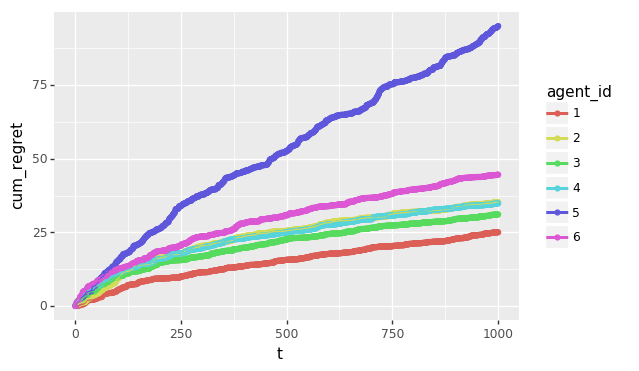

<ggplot: (8731233490325)>


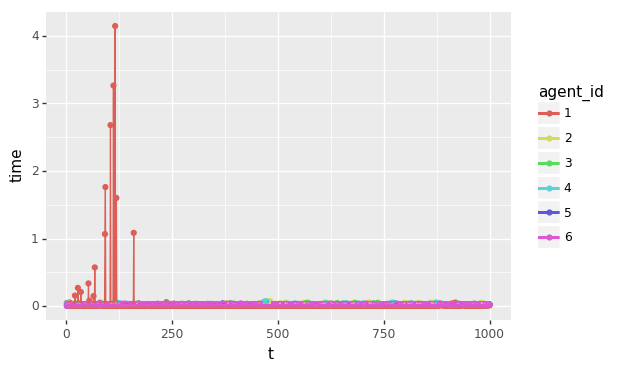

<ggplot: (8731325128057)>


([[      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
   0             1        1     0.988291    0.000000        0.000000     1   
   1             2        2     0.988291    0.175318        0.175318     1   
   2             3        3     0.988291    0.175318        0.175318     1   
   3             4        4     0.988291    0.353267        0.353267     1   
   4             5        5     0.988291    0.000000        0.000000     1   
   5             6        6     0.988291    0.019586        0.019586     1   
   6             7        1     1.983924    0.000000        0.000000     2   
   7             8        2     1.983924    0.175318        0.000000     2   
   8             9        3     1.983924    0.197512        0.022194     2   
   9            10        4     1.983924    0.441579        0.088311     2   
   10           11        5     1.983924    0.022194        0.022194     2   
   11           12        6     1.983924    0.019586        0.00

In [9]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
make_agents = [make_laplace_agent,
               make_pgts_agent,
               make_best_langevin_agent,
               make_mala_agent,
               make_best_sgld_agent,
               make_best_sagald_agent]
                #,make_mala_agent_untimed]
simple_compares(make_agents, num_articles, dim, var, 1000, [1], verbosity=verbosity)

theta [-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263  1.26593626 -0.8667404  -0.67888615 -0.09470897
  1.49138963 -0.638902   -0.44398196 -0.43435128  2.20593008  2.18678609
  1.0040539   0.3861864   0.73736858]
Experiment: Step 0
 Sample: array([-0.66910263,  1.61219304,  0.89605831,  0.36961959, -0.76129424,
        0.00364515, -1.25566869, -0.55193688, -0.24520334, -0.36163993,
        0.95660193, -1.41872591, -0.86543227, -1.37468797, -1.23735321,
        0.1240559 , -1.60044053,  0.75386878, -0.24681578,  0.06878833,
        0.32257674])
 Steps taken: 0
 Sample: array([ 0.12708233, -0.27992719,  0.86142365, -0.81137777,  0.3267481 ,
       -1.63132123, -0.29728987,  0.14352461, -2.46897391,  1.94134014,
       -1.6257654 , -0.23906898, -1.82568945, -1.2404493 , -0.37775687,
       -1.3674283 , -0.24654111,  0.06652736, -0.31856044, -0.4723558 ,
       -0.42005749])
 Steps taken: 368
Experiment: Step 1
 Sample: array([ 1.71716968, 

 Sample: array([ 0.48719435, -0.23823579,  0.14476219,  1.20550823,  0.21156309,
        1.16597308, -0.79079891,  0.73945253, -1.64565343,  1.1472101 ,
        0.07858189, -0.30681342, -0.54470551, -0.81663651, -1.12450858,
        1.17524832, -0.81554358, -0.36990832, -1.374202  ,  1.15724448,
        0.77591821])
 Steps taken: 141
 Sample: array([ 0.19327557,  1.07700347,  0.11201634, -0.79616868, -0.00643398,
        2.15213866,  0.16265534,  0.23149391,  0.61525424,  0.84205943,
       -0.74973612,  1.56913156,  0.77455683,  0.21397414, -1.4663471 ,
        0.44991946,  1.00493666,  0.43145628, -1.08665355, -0.28334951,
        0.28771114])
 Steps taken: 200
Experiment: Step 16
 Sample: array([-1.40097017, -0.50290334, -1.00898959, -1.58245055, -1.27008005,
       -0.15418263, -0.684107  , -0.11137908,  0.9549672 , -1.17720669,
       -2.37738323,  0.5639527 , -0.66496489,  1.2706085 , -0.09730245,
       -0.92544803,  1.90539876,  0.26436294,  1.09216908, -0.90093848,
        0.3

 Sample: array([-1.52447988,  0.24589331,  1.37971627,  0.04381826,  0.90288407,
        1.12720734, -1.82974065, -0.34524369,  2.03684683, -0.26998546,
        0.97530584, -0.83594065,  0.06648196, -0.08876054,  0.01065655,
        1.5668    ,  1.16109425,  0.44018036,  1.69113768,  0.62881597,
        0.23338342])
 Steps taken: 109
 Sample: array([-1.53844236, -0.08264788, -0.53078359, -1.46542365, -0.35652611,
       -0.66956552,  0.33415996, -0.09697385,  0.66991072,  0.29541987,
       -2.07784787,  0.35731292, -0.47596959, -1.71597313,  0.46066786,
       -0.19575725,  1.92393492,  0.53942464, -2.1727482 , -0.8281303 ,
        0.09070561])
 Steps taken: 179
Experiment: Step 31
 Sample: array([-0.21184733, -1.15062514,  1.15460248, -0.59797399,  1.68107673,
        1.83767615, -0.0248302 , -1.00978967,  1.95445805, -0.11114492,
        0.25149428, -0.92366748, -0.1921823 ,  0.61465951, -1.39856641,
        1.28254403, -0.12495575,  0.51962404,  0.24057228,  0.69834856,
        1.3

 Sample: array([-1.0245765 , -0.27555264, -0.30673218,  0.67161437, -0.07074013,
        1.91605562, -0.6340411 ,  0.1999197 ,  2.62937151, -0.5447645 ,
       -0.80175208,  0.35101953,  0.41985431, -0.35800176,  1.15532137,
        0.5885134 ,  1.59120733,  0.72357925,  0.88612849, -0.47340037,
        1.11587059])
 Steps taken: 89
 Sample: array([-0.21892096,  1.2618773 , -0.45194009, -2.46487883,  0.41799548,
        1.31534302, -1.74710626, -0.54606589, -0.22831617,  2.00247626,
        0.13067926,  0.05359829,  0.00928403, -1.52453232,  0.25254076,
       -1.2988426 ,  1.55043607, -0.4791279 , -0.24298936,  0.65995859,
        0.00675087])
 Steps taken: 177
Experiment: Step 46
 Sample: array([-0.75719111,  1.09480393, -1.39928586,  0.24598928,  0.56021389,
        0.84484318,  0.23665756,  2.33882586,  1.19412441, -0.76226963,
       -0.6428206 , -0.12442197,  1.12298681, -0.46220563,  0.46097906,
       -1.43977485, -0.99913162,  1.00261455,  0.19391524,  0.02075681,
       -1.18

 Sample: array([-1.35865608,  0.37709583, -1.24463707, -0.70612402,  0.76694545,
        1.01040776, -1.10282975, -0.18232386,  1.91972673, -0.33381098,
       -1.33971506, -0.27023033,  0.8981954 , -1.37954179, -1.35520454,
        0.85629497,  0.47981625,  0.49189076,  0.19183686,  1.24795086,
        0.68568908])
 Steps taken: 152
 Sample: array([-0.36294804, -1.0374134 ,  1.38698245, -0.55906657, -0.03908828,
        1.04159812, -0.55657969, -1.13402776,  0.23983983,  0.25893495,
       -0.7764188 , -0.77787081,  0.47032475, -0.60145639, -0.94341517,
        0.33918837,  2.54864232, -0.17269309, -0.72908879,  0.31770226,
        0.33456749])
 Steps taken: 237
Experiment: Step 61
 Sample: array([-1.24905393e+00,  7.23704493e-01,  9.31648162e-02, -5.82775432e-01,
       -2.03013484e-04,  1.16258900e+00,  4.10041228e-01,  8.38181252e-01,
        8.13250309e-01,  3.32420357e-01, -1.21475564e+00, -5.41784187e-01,
        4.56305737e-01, -4.18921034e-01, -1.67599461e+00, -1.07388752e-01,

 Sample: array([-0.87004846,  1.47536669,  0.78034987, -0.84789755,  0.46319672,
        0.9763313 , -0.73181461,  0.74750107,  1.12454155, -1.44187449,
       -0.08035298,  0.16046336, -0.13793412, -1.08027224,  0.55810642,
        2.05128865,  1.36436772,  1.76036553,  0.56747955,  0.34126117,
        0.22460943])
 Steps taken: 97
 Sample: array([-1.20159242,  0.24846951,  0.50664561, -1.5733542 ,  0.3561398 ,
        1.52608381, -0.50642436,  0.25089309,  0.07134581,  0.11229686,
       -1.8047933 , -0.37209279, -0.90051557, -1.39697239, -1.60589665,
       -1.11409081,  2.20261193,  0.23343067, -0.85062822,  1.38383234,
       -0.09211954])
 Steps taken: 151
Experiment: Step 76
 Sample: array([-0.73132447,  0.34337615, -0.43618285,  0.3621074 ,  0.07454021,
        1.19542574, -0.61827333, -0.28804465,  1.33083748, -1.16522989,
       -0.25155121, -0.64785077, -0.79552557, -1.608322  , -0.48807077,
        0.07120841,  1.39584801,  0.83127222,  1.43310073,  0.11722571,
        0.63

 Sample: array([-1.95754361,  1.41709848,  1.25219939,  0.13836015,  0.05694144,
        0.35123915, -0.89274816,  0.05152865,  2.01407011, -1.6373414 ,
       -2.05555229,  0.08474724, -0.04448042, -1.43142223, -0.86064388,
       -0.43666539,  2.71969581,  3.50105065,  0.34103287, -0.72325649,
        0.42375931])
 Steps taken: 82
 Sample: array([-0.91730126,  0.37501482,  0.52372411, -1.4143944 ,  0.09851725,
        0.5699865 , -1.4580677 , -1.21818694,  1.08817276, -0.03356048,
       -1.26068312, -1.00614802, -0.45172615, -0.68171096, -1.20394602,
        1.5790967 ,  1.24107318, -0.20651106,  0.38728352,  0.72923308,
        0.30601393])
 Steps taken: 135
Experiment: Step 91
 Sample: array([-1.63552846,  1.0273416 ,  0.94627743,  0.34076288,  0.84470444,
        1.03575487, -2.03088812,  1.04346578,  2.45204562, -2.28457843,
       -0.23234723, -1.09640693, -0.41105877, -1.29441875,  0.29519634,
       -0.22871599,  2.43389528,  2.05117088,  0.03614115, -0.48686109,
        1.67

 Sample: array([-0.71812967,  0.4087748 ,  1.08359775, -1.85889785,  0.04053694,
        0.23124441,  0.16312564,  0.62970078,  0.56364296, -0.50252312,
       -0.96280141, -0.28451026,  0.79840515, -0.69088779, -0.17239066,
        1.57083649,  2.28738889,  1.06702754, -0.20732531,  0.21942358,
        0.22466523])
 Steps taken: 99
 Sample: array([-1.26131377,  0.86707123,  0.25641027, -1.15557278, -0.58185278,
        1.2438844 , -2.11841934,  0.06049022,  0.09381461,  0.76817697,
       -0.64642517, -0.89123532, -0.1693385 ,  0.59097021,  0.10361666,
        0.17333897,  3.04009109,  1.42412309,  0.36491532, -0.43664982,
       -0.02798286])
 Steps taken: 128
Experiment: Step 106
 Sample: array([-0.70664787,  1.37161052,  1.44735467, -0.51323029, -0.12638721,
        1.59022142, -1.13845934, -0.52831179, -0.32405077, -1.83544752,
       -1.36826511,  1.0560806 ,  0.6348884 , -0.76085286, -0.36353136,
        0.64167094,  0.10417914,  1.68732813, -0.2270625 ,  0.10001354,
        0.3

 Sample: array([-0.75013772,  0.75939395,  1.28368769, -0.6846665 ,  0.09645236,
        1.5303201 , -1.1997624 , -1.87232394,  0.2570513 , -1.63865937,
       -1.22225011, -0.3753973 ,  0.00382796, -0.06001153,  0.44567798,
        0.9720937 ,  2.27063452,  0.52570371,  0.05509494, -0.237863  ,
        0.4103915 ])
 Steps taken: 102
Experiment: Step 120
 Sample: array([-0.88665697,  1.23062154,  1.01529738, -0.82692364,  0.04068069,
        0.98706679, -1.13394735,  1.51769775, -0.18589386, -1.24901819,
       -0.92642965,  0.7849205 ,  2.84147511, -1.17154902, -0.26908787,
        0.87867437,  2.58655781,  2.33882624,  1.17095149,  0.05152415,
       -0.36789373])
 Steps taken: 105
 Sample: array([-0.8263211 ,  0.65979705,  0.5130005 , -2.02883534, -0.48700263,
        2.60035566, -1.92055413, -1.85558788,  0.75114727, -0.3528418 ,
       -0.9115399 , -0.08665451,  0.28819724,  0.04466462, -1.00785149,
        1.60336734,  2.53580593,  0.86537648, -0.17128246, -0.52324469,
        0.

 Sample: array([-0.98864521,  0.07904365,  1.42336442, -1.69617124, -0.21346415,
        0.78149681, -1.28216358, -1.01645982, -0.69368735, -0.1532504 ,
       -0.59220328, -1.22089406, -0.30493006, -0.42978056,  0.03164589,
        0.28410851,  2.36059907,  1.531965  ,  0.5945005 , -0.47118546,
        0.69617963])
 Steps taken: 52
Experiment: Step 133
 Sample: array([-0.83943419,  1.18618104,  0.46648305, -1.84119067,  1.74169355,
        0.44620673, -0.7004335 ,  0.89961347,  0.83371104, -0.64035713,
       -0.55652244, -0.28134434,  0.30503057, -0.15699287, -0.24456011,
        0.44056962,  2.26833706,  1.6493248 , -0.02036375, -0.21574943,
       -0.31206032])
 Steps taken: 53
 Sample: array([-0.7014245 ,  0.15921173,  1.30919512, -1.2237591 , -0.45925496,
        0.56918224, -1.70678551, -1.24744908, -0.40619263,  0.35431091,
       -0.28699032, -0.41097932,  0.604916  ,  0.76033003,  0.65519035,
        0.96740481,  1.78337514,  0.28185368,  0.78397961, -0.16464106,
        0.39

 Sample: array([-1.14426585,  0.83334572,  0.96302176, -1.74813626, -0.5638622 ,
        1.21970991, -2.76758659, -0.99189142,  1.17373871, -1.10405002,
       -1.06943248, -0.11407326,  1.29713012, -0.88729595,  0.04864555,
        0.45883733,  2.93504201,  1.19324478,  0.64252214, -0.53960572,
       -0.1076379 ])
 Steps taken: 49
Experiment: Step 146
 Sample: array([-1.05011501,  0.91963937,  1.80545855, -0.82969212, -0.69257162,
        1.54246439, -0.74194142, -0.03208992,  1.47936245,  0.2522885 ,
       -1.21862147, -0.35679933,  0.54069976, -0.51322017, -1.09377857,
        0.18415281,  2.44382712,  1.25295331, -0.05107352, -0.90090289,
        1.07745778])
 Steps taken: 70
 Sample: array([-0.79118386, -0.27004442,  1.76466468, -1.41681076, -0.29289191,
        1.79597196, -2.0421949 , -1.14042318,  0.34784945, -1.08847142,
       -1.04138832, -0.09927344, -0.26750681, -1.1500258 , -0.50819038,
        0.63383992,  1.4197884 ,  0.22297842,  0.31993709, -0.47363473,
       -0.51

 Sample: array([-0.90973811,  0.53460033,  0.52459296, -1.52453837,  0.22061544,
        1.50759196, -1.61245153, -1.06796907, -0.25929443, -0.05284379,
       -0.3789774 , -0.52983847,  0.06145958, -0.08294951, -0.00703326,
        1.19303103,  2.49811128,  0.45250493, -0.14866004, -0.285445  ,
        1.30403287])
 Steps taken: 45
Experiment: Step 159
 Sample: array([-1.49321074,  1.318562  ,  1.53463019, -1.94231429,  0.86905156,
        1.87476239, -2.24567901, -0.10797267,  0.10601087,  0.09730035,
       -0.52659319,  0.61634587,  1.39036212, -0.79387631, -0.09200128,
        0.83397993,  2.26965897,  1.84184913,  1.00539051, -0.02608117,
        1.17368464])
 Steps taken: 53
 Sample: array([-0.76039854,  1.00665914,  1.24489962, -2.22271852,  0.66459386,
        1.45008135, -1.28427836, -1.21639389, -0.16311891,  0.70102571,
       -1.01357533, -0.25972621,  1.50282009, -0.90545065, -0.13440075,
        0.9520267 ,  1.87317849,  1.0582515 ,  0.79383004, -0.97266249,
        0.65

 Sample: array([-0.8276395 ,  1.21610446,  0.98003654, -0.52983438,  0.20153488,
        1.4739443 , -2.02659151, -0.76431292,  0.26506672, -1.09829881,
       -0.54258726, -0.16129693,  0.46513158, -0.64681373,  0.42888452,
        1.29009448,  2.09256555,  1.07711533, -0.19864317, -0.46790851,
        0.18562307])
 Steps taken: 44
Experiment: Step 173
 Sample: array([-1.15358117,  1.07875519,  0.58792709, -0.48269238,  0.73746438,
        1.48727189, -1.36343948, -0.03891699,  1.40506709, -0.55399723,
       -1.02723915,  0.40876013,  1.46654177, -1.02237512, -0.05378515,
        0.19796216,  1.99754348,  1.94606262,  0.39172576, -0.22928653,
        0.04799492])
 Steps taken: 64
 Sample: array([-0.70127108,  1.83083844, -0.28048408, -0.23049084,  0.02979039,
        1.10102145, -2.15577074, -0.67816611,  1.10166136, -0.5369876 ,
       -0.67572816, -0.1362853 ,  0.541794  , -0.91732039,  0.58914763,
       -0.18181148,  2.24298299,  1.93165711,  0.04271099,  0.70807631,
        0.55

 Sample: array([-0.45884841,  0.66859003,  0.62547392, -2.19098884, -0.64194633,
        1.33315708, -1.98334034, -0.8093224 , -0.71902191, -1.17513334,
       -0.23096779, -1.0074141 ,  0.51850023, -0.73137073, -0.47874248,
        0.30435523,  1.56801456,  2.52855937,  0.27272615, -0.3673082 ,
        0.96502353])
 Steps taken: 78
Experiment: Step 187
 Sample: array([-1.4233472 ,  0.79996254,  0.28060894, -1.23794924,  0.74892554,
        0.72593612, -1.81396152, -0.18501507,  1.02564398, -0.36068277,
       -1.32463511,  0.49166807,  1.04835033, -1.92054323, -0.62213969,
        1.45363699,  1.36818282,  2.16044627,  2.00529033,  0.18094131,
       -0.50068804])
 Steps taken: 105
 Sample: array([-0.86064979,  0.35458707,  0.13332073, -0.50608411, -0.34357238,
        1.5167175 , -1.41018346, -1.48157016,  0.18309408, -0.15621392,
       -1.16791545, -0.77353047,  0.70162739, -0.66864418, -0.23685379,
       -0.0379224 ,  2.02606568,  1.58003695,  0.42246609, -0.34808161,
        1.5

 Sample: array([-1.20527758,  0.32309563,  0.51664724, -0.76171247,  0.66945448,
        2.63942553, -2.46432436, -0.19196273,  1.86721971, -0.74622638,
       -2.14347781,  0.47289216,  1.37993914, -1.02961559,  0.07737922,
        0.38143569,  1.85557318,  1.98776364,  1.53912794, -0.03175287,
        0.60712882])
 Steps taken: 88
 Sample: array([-1.37845054,  2.12470195, -0.75652629, -1.04712334,  0.45034742,
        2.57395006, -1.57705985, -1.35106309,  0.65902128, -0.15843164,
       -1.11592719, -0.9313645 ,  1.10660359, -0.5247558 ,  0.47272922,
        0.03936359,  1.73572764,  1.67197854,  0.07529381, -0.49757316,
        0.75304352])
 Steps taken: 60
Experiment: Step 201
 Sample: array([-1.28142571,  0.3768747 ,  0.69820348, -1.81488107,  0.52265809,
        2.32294352, -2.16881799,  0.2168224 ,  1.7146087 , -0.96763538,
       -0.87132043,  0.19015564,  1.60556075, -1.67651547, -0.39904575,
        0.50771822,  1.91367689,  1.72586196,  0.45118659,  0.49436632,
        0.94

 Sample: array([-1.24461604,  2.15411528,  0.41417786, -1.72989858, -0.38898051,
        2.51439322, -2.72138612, -1.28872955,  0.29843834, -0.01291908,
       -1.02009047, -0.91228767,  0.05061171, -1.20289885,  1.15397524,
       -0.44267367,  2.4299395 ,  2.47959903, -0.04367363,  0.15088173,
        1.55808709])
 Steps taken: 46
Experiment: Step 213
 Sample: array([-1.14128852,  0.91016209, -0.27308337, -1.9107161 , -0.35074916,
        1.40263807, -2.53407061, -0.43808189,  0.68182553, -0.43373463,
       -1.12664969, -0.09004871,  1.59274998, -0.50676555, -1.11743994,
       -0.09508769,  2.57049092,  1.6874398 , -0.46354057, -0.21720454,
        0.23518407])
 Steps taken: 62
 Sample: array([-1.21088702,  1.93039859, -0.18937863, -1.52471563,  0.565555  ,
        2.25217187, -2.86319671, -1.76149357,  0.0460562 , -0.27825758,
       -0.95071703, -0.93049103,  0.48216556, -1.03365391,  0.03021329,
       -0.26928824,  2.52167696,  2.12231211, -0.03657349,  0.16890912,
        1.04

 Sample: array([-1.1608106 ,  0.03918299,  0.50889035, -1.31872156,  0.20129257,
        1.35204931, -2.7509815 ,  0.60715006,  1.36219633, -0.30231001,
       -1.24719799,  1.09324196,  2.20870523, -1.83980262, -0.68327931,
        0.91426343,  2.56411388,  1.38616214,  0.93023707,  0.03663968,
        1.16518929])
 Steps taken: 66
 Sample: array([-1.38484002,  1.04908101,  1.32332039, -1.58040218,  0.60971263,
        2.68650566, -1.70683541, -0.66476512, -0.16301604,  0.00879887,
       -1.79141108, -1.03727829,  0.75481376, -2.25950853, -0.88614762,
        1.13296406,  2.71972885,  2.16183005, -0.43479842, -1.13948563,
       -0.21355289])
 Steps taken: 42
Experiment: Step 227
 Sample: array([-1.04951079,  0.18567231, -0.25571513, -1.62063523, -0.04376427,
        0.99412102, -2.26087538,  0.05578743,  2.00295711, -0.14797794,
       -1.48305872, -0.55291169,  2.17049309, -0.96683281, -1.01676388,
        0.90526718,  2.50337428,  1.46206198,  1.30495428, -0.41957373,
        2.16

 Sample: array([-1.09136856,  2.18337478,  0.96615277, -2.03053761,  0.91886775,
        1.75172974, -1.83679993, -0.22612622, -0.02383973,  0.22175432,
       -0.75779754, -0.39650598,  1.38144309, -1.38061991,  0.81203803,
        0.48826677,  2.42218799,  1.27306686,  0.09122085, -0.49544936,
        1.38998784])
 Steps taken: 38
Experiment: Step 240
 Sample: array([-1.02749194,  0.76973862,  0.34355405, -1.80042281,  0.88011525,
        1.78186787, -2.22355794, -0.07863597,  1.00474044, -0.76832963,
       -1.84366194,  0.58574759,  1.3678179 , -0.42230073, -0.32352061,
        0.56606923,  3.24302488,  0.90989937,  0.44567286, -0.20006751,
        1.629454  ])
 Steps taken: 59
 Sample: array([-1.15577663,  1.32243125,  0.91574964, -1.61526932, -0.0396577 ,
        1.76983315, -2.38992571, -0.91968469, -0.09705321, -0.32766539,
       -0.63272143, -0.42413804,  1.10856181, -0.88516938,  0.26252136,
       -0.09465959,  2.11144102,  1.61034398,  0.06020281, -0.35146621,
        0.89

 Sample: array([-1.07077549,  0.28099624,  0.53328876, -1.74992965, -0.76704789,
        1.57620066, -2.57659199, -0.43146458,  1.8179152 , -0.75967042,
       -0.0063779 ,  0.13187236,  1.68579407, -1.91907215, -0.29758138,
        0.01858525,  2.64265614,  1.91369229,  0.46844624, -0.26489177,
        1.03492865])
 Steps taken: 76
 Sample: array([-1.03488312,  1.62242626,  0.74774153, -1.45900381,  0.43972029,
        1.72149837, -1.71001565, -0.06799119,  0.27744679, -0.11853705,
       -0.90617174, -0.51473515,  0.70900574, -1.92818427,  0.09048926,
        0.49279554,  2.61499452,  1.78476259,  0.68697858, -0.18355025,
        1.27446382])
 Steps taken: 25
Experiment: Step 254
 Sample: array([-1.38152122,  0.48170857,  0.84186351, -1.33204159, -0.65290676,
        1.80477957, -1.51792176,  0.04561593,  1.04903124, -0.60705253,
       -0.86279938, -0.18368675,  1.89727771, -0.2369152 ,  0.02123578,
        0.48926244,  3.19972381,  1.14780629,  0.44881571,  0.2861989 ,
        1.24

 Sample: array([-0.85613901,  1.2674729 ,  0.79485133, -1.6677426 ,  0.83091977,
        1.51163141, -2.35116199, -0.70797881,  1.0523916 , -0.54485087,
       -1.40508048, -0.35783585,  1.3442982 ,  0.23164713, -0.13743468,
        0.41235609,  1.99186948,  1.24530908,  0.76402423, -0.32006692,
        1.83412979])
 Steps taken: 29
Experiment: Step 267
 Sample: array([-1.30422442,  0.41806191,  0.45480743, -0.92763102, -0.22409342,
        2.20531007, -2.09023848, -0.62861492,  0.79216128, -0.34378023,
       -0.98188137,  0.42722068,  1.83176709, -1.24159031, -0.39595765,
        0.87798274,  2.42141056,  2.15410109,  1.33396274, -0.65264411,
        2.0631777 ])
 Steps taken: 53
 Sample: array([-1.20671674,  1.65515543,  1.25292929, -1.94251791,  0.73247109,
        2.20803388, -2.45134577, -1.18407423,  0.79061537, -0.31340217,
       -1.13456707, -0.628071  ,  1.27148432,  0.22029329,  0.07406602,
        0.47552553,  2.13076141,  1.61891035,  0.28600731, -0.69603722,
        1.98

 Sample: array([-1.24293647,  2.02806779,  0.27306418, -0.88614946,  0.4086787 ,
        2.47617244, -1.67402427, -0.91118039, -0.4504509 , -1.47874617,
        0.09547876, -0.93356719,  0.21045892, -0.57720436,  0.62577152,
       -0.10269664,  2.14896209,  1.89300869,  0.10439704, -0.09634858,
        1.4179814 ])
 Steps taken: 32
Experiment: Step 280
 Sample: array([-1.19616628,  0.43127823,  0.30446512, -2.00205196, -0.26731787,
        1.28222155, -2.15761286, -0.16442203,  1.76202814, -0.41028394,
       -0.95444854, -0.11166557,  1.56624437,  0.09368477,  0.56979849,
        0.83412397,  2.34212633,  1.15843678,  1.55193381,  0.37388518,
        0.95555727])
 Steps taken: 55
 Sample: array([-1.09372706,  1.86077248,  1.24602107, -1.00152416,  0.17741964,
        2.21494776, -2.0406146 , -0.74287876,  0.6838443 , -0.69866636,
       -0.10938163,  0.01360961,  0.04084416, -0.7605095 , -0.05165546,
       -0.40662509,  2.44832309,  1.85186293,  0.27507062, -0.04127764,
        1.17

 Sample: array([-1.11873632,  0.37549788,  0.18156859, -1.83621996,  0.09161139,
        0.65763466, -2.63554859, -1.41148243,  0.82769555, -1.17540138,
       -0.45408896,  0.35157388,  1.15508382,  0.18534244, -1.12361266,
        0.09987477,  2.69617425,  1.7419072 ,  1.64120559, -0.37148846,
        1.02345193])
 Steps taken: 50
 Sample: array([-0.89151452,  1.57410742,  0.58279502, -1.86146299, -0.44114319,
        1.62895369, -2.30856342, -0.63699648, -0.4246407 , -0.18746244,
       -0.63833617, -0.96973676,  0.3710452 ,  0.34090621,  0.11347487,
        0.93811347,  1.82361186,  1.5439443 ,  0.25661808, -0.95097934,
        1.04194599])
 Steps taken: 37
Experiment: Step 294
 Sample: array([-0.59900031,  0.47147673,  0.47400992, -1.47407515, -0.14659308,
        1.39339591, -2.60867196, -0.34596727,  1.13469696, -0.3895112 ,
       -0.52382058,  0.69590861,  1.32396052, -0.24162471,  0.04743933,
       -0.21195087,  2.35399101,  0.83090174,  0.71917027,  0.11506077,
        0.35

 Sample: array([-0.87146784,  0.47749116,  0.4693797 , -1.92157202, -0.0027501 ,
        1.51118426, -2.10518244, -0.55336221,  1.59288275, -0.5341473 ,
       -0.28652728,  0.22808218,  1.52134491, -0.09117331, -0.33014531,
        0.23905136,  1.42461734,  0.13686633,  1.58402094,  0.52435275,
        0.6463058 ])
 Steps taken: 54
 Sample: array([-0.89715709,  1.49206094,  0.44256144, -0.93334763,  0.76134868,
        1.05347779, -2.05073926, -1.20186124,  0.10579787,  0.09117922,
       -0.10052078, -0.06193092,  0.91335244, -0.68172545, -0.26329391,
        0.32546597,  2.54327341,  1.66698506,  0.86777753,  0.43071401,
        0.61978258])
 Steps taken: 37
Experiment: Step 307
 Sample: array([-1.0503306 ,  0.18487121,  0.84684841, -2.01621113,  0.4588653 ,
        1.86927288, -1.7127947 , -0.35942645,  1.20257251, -0.87014889,
       -0.35116205,  0.37897975,  0.99247918, -0.16833425, -0.5978603 ,
       -0.24568865,  2.62234757,  0.69702138,  1.1870754 , -0.39376253,
        1.20

 Sample: array([-0.93199328,  1.4334914 ,  0.57847338, -1.52595191, -0.21293889,
        1.69194755, -1.83327475, -0.69562156,  0.54922023,  0.06627414,
       -0.92790306, -0.34190126,  1.77830354,  0.18627997,  0.21758019,
        0.47289235,  2.4845662 ,  1.72811645,  0.08299181, -0.23964453,
        1.05217052])
 Steps taken: 30
Experiment: Step 320
 Sample: array([-0.68638906,  0.15014312,  0.18943226, -2.15389569, -0.55128974,
        1.3785271 , -2.9050767 , -0.4567506 ,  0.59037772, -0.27656192,
       -0.66723629,  0.8556576 ,  1.58361827, -0.22544174, -0.43896923,
       -0.04881235,  2.37861192,  0.67979535,  0.49746222,  0.23287304,
        0.44243937])
 Steps taken: 54
 Sample: array([-0.69528998,  1.29276635,  1.0115609 , -0.758181  , -0.62916282,
        1.65078209, -1.52899504, -0.9130349 ,  0.33266942,  0.26848374,
       -0.64705425, -0.69265119,  1.0147028 , -0.33223944, -0.09402574,
        0.50895503,  2.2682683 ,  1.71990811,  0.17235423,  0.24634319,
        0.65

 Sample: array([-1.22068976,  0.36457538, -0.10450856, -1.76604623, -0.63854945,
        2.04088317, -2.65842207, -0.06043016,  1.15034499, -0.54218643,
       -0.38756242,  0.15022448,  2.2207385 , -0.30071786, -0.95144398,
       -0.33794855,  2.21372933,  1.18004938,  0.69288153, -0.08593172,
        1.14523799])
 Steps taken: 86
 Sample: array([-1.0961529 ,  1.21233605, -0.0709154 , -0.82068419, -0.65321104,
        1.45755266, -2.29256372, -1.035695  ,  0.22697839, -0.82767536,
       -0.24748498, -0.44772251,  1.48016425, -0.7651    ,  0.05581166,
       -0.12680546,  2.18907951,  1.69689886,  0.59939848,  0.10208406,
        1.02895955])
 Steps taken: 3
Experiment: Step 335
 Sample: array([-0.93644254,  0.47307393,  0.51574191, -1.54294901, -0.01463946,
        2.07160479, -2.11860083, -0.36466283,  1.66991281, -0.53127036,
       -1.08796313, -0.13641439,  1.99632256, -0.30929312, -0.46680248,
       -0.07224069,  2.18087508,  0.96185538,  0.53457471,  0.04840921,
        0.210

 Sample: array([-1.01645841,  1.45570713, -0.03523352, -1.57852897,  0.31685403,
        1.72275288, -2.21916755, -0.38876887,  0.43738569, -0.9882621 ,
       -0.72992895, -0.02294576,  1.39359628, -0.63048671,  0.24391485,
       -0.38026837,  1.96489657,  1.28957166,  0.33778419, -0.1261296 ,
        0.90375583])
 Steps taken: 29
Experiment: Step 348
 Sample: array([-0.83832369,  0.51630128,  0.58562114, -1.92853192, -0.02897337,
        1.57120729, -2.17078898, -0.45123857,  1.35374636, -0.74071373,
       -0.84877045,  0.30097726,  1.38764566,  0.19393939, -0.13782352,
        0.26873529,  2.63088433,  0.9566567 ,  0.88418459,  0.07420552,
        1.34760885])
 Steps taken: 46
 Sample: array([-0.99343355,  1.35301146,  0.57984461, -1.80613059, -0.06932039,
        1.22651311, -1.88549488, -0.96640714,  0.94201285, -0.43430979,
       -0.74063458,  0.16782374,  1.05851364, -1.54016196, -0.11174587,
       -0.36642334,  2.0412445 ,  1.17627275,  0.10726868, -0.1509232 ,
        0.83

 Sample: array([-1.25683105,  0.26505034,  0.3238771 , -1.60141012, -0.21302627,
        1.9610579 , -2.62257271, -0.17098872,  1.06383029, -0.57182889,
       -1.25430827,  0.2660899 ,  1.65819535, -1.05070341, -0.35603323,
        0.32384145,  2.6455308 ,  2.55852833,  1.03960642, -0.17721368,
        1.52393289])
 Steps taken: 83
 Sample: array([-1.50205962,  1.41812219,  0.92801865, -1.72352442,  0.39931774,
        2.03774018, -2.35548729, -1.5144907 ,  0.58430168, -0.41408724,
       -0.43662381,  0.31078268,  1.5378072 , -0.72305498,  0.6157748 ,
        0.8301804 ,  2.70862543,  2.02366085,  1.16352561, -0.55406433,
        0.79477982])
 Steps taken: 37
Experiment: Step 362
 Sample: array([-1.16790877,  0.40211064,  0.83515254, -1.46951583,  0.36128854,
        1.5864539 , -2.53203576,  0.67835618,  1.06991376, -0.63879504,
       -1.34919993,  0.39560223,  1.96921738, -0.29100135,  0.26479294,
        0.14702203,  2.61820232,  1.8813095 ,  0.66331318,  0.12882928,
        1.09

 Sample: array([-1.52362371,  1.43262969,  0.79726967, -1.0840605 ,  0.33575924,
        1.63755642, -1.7234413 , -1.14289242,  1.64472835, -0.40498961,
       -1.0878076 , -0.07323456,  1.32518663, -0.13103065, -0.22603719,
        1.172897  ,  3.06848157,  2.4540387 ,  0.66475018, -0.23605626,
        1.18636937])
 Steps taken: 27
Experiment: Step 375
 Sample: array([-1.14004321,  0.52097213,  1.24371428, -1.71929824,  0.12059666,
        1.98290072, -2.12503033, -0.70640348,  2.17614569, -0.75244136,
       -0.41732594, -0.2505053 ,  1.330226  , -1.19413758, -0.11361907,
        0.6271833 ,  2.72720964,  1.77714935,  0.35626638, -0.33094301,
        1.12719911])
 Steps taken: 48
 Sample: array([-1.10999472,  1.6317496 ,  0.32254105, -1.49327113,  0.07687208,
        1.44456993, -1.48014583, -0.53966928,  1.05267271, -0.2955033 ,
       -0.30118128, -0.14894233,  0.80801823, -0.35404538,  0.41831373,
        1.14481536,  1.87650537,  2.06971892,  0.53091987, -0.26212207,
        0.23

 Sample: array([-8.37972594e-01,  8.24873394e-01,  1.40197410e-01, -1.35177642e+00,
       -2.15284340e-03,  1.25771158e+00, -2.34112893e+00, -1.52809949e-02,
        1.54820746e+00, -4.93203724e-01, -9.71352883e-01,  1.37994834e-01,
        1.44198659e+00,  2.78948575e-01, -3.79717476e-01,  9.39005471e-01,
        1.57330665e+00,  1.12980613e+00,  9.45796715e-01,  4.27903611e-01,
        8.28694064e-01])
 Steps taken: 44
 Sample: array([-0.79821879,  1.77581807,  0.90159482, -1.39117779,  0.19377977,
        1.54446016, -1.65457342, -0.84826506,  0.93882364, -0.74725791,
       -0.92950754,  0.18904592,  1.64902406, -0.72000582,  0.02202667,
        0.35620085,  2.13252638,  1.88680958,  0.33606522,  0.22186319,
        0.88251804])
 Steps taken: 30
Experiment: Step 389
 Sample: array([-1.09928248,  1.20078577,  0.65660707, -2.01679192,  0.0514556 ,
        1.74385085, -1.47145807, -0.57114375,  1.95888181, -1.29658732,
       -0.98420672,  0.18030396,  1.42007922, -0.47420325, -0.684

 Sample: array([-7.53943077e-01,  1.21605460e+00,  2.78133568e-01, -5.74303569e-01,
        1.73762939e-01,  1.66137691e+00, -1.32863749e+00, -1.25007974e+00,
        3.39306004e-01, -8.58958937e-01, -8.84771290e-02,  2.02313532e-03,
        4.19471733e-01, -3.13757021e-02,  3.09699714e-02, -8.77664964e-01,
        2.18378023e+00,  2.34603570e+00,  5.09654632e-02,  3.36203261e-01,
        3.42422065e-01])
 Steps taken: 44
Experiment: Step 402
 Sample: array([-1.32188937,  1.16710134, -0.01172746, -1.24112412,  0.34528257,
        1.74466659, -1.54981908, -0.433865  ,  1.97943128, -1.05912714,
       -0.89974881,  0.24531118,  1.15811023, -0.83795348,  0.15891456,
        0.29777308,  2.58901628,  1.4625762 ,  1.52741626,  0.10566155,
        0.69930506])
 Steps taken: 98
 Sample: array([-0.99808963,  1.58171877,  0.22324662, -1.03148191,  0.0313325 ,
        1.82829557, -1.79778752, -0.72202797,  0.26492031, -0.36212526,
        0.38501385, -0.4127613 ,  0.5710192 , -0.31056542, -0.222

        0.97253906])
 Steps taken: 21
Experiment: Step 415
 Sample: array([-1.03619856,  1.43969466,  0.6702898 , -1.86297646,  0.16514185,
        1.36534841, -1.70030803, -0.71116511,  1.29872312, -1.04294234,
       -0.47008672,  0.54578032,  1.16820407,  0.19425175, -0.38595717,
        0.20822865,  2.35341061,  1.6627416 ,  1.07769659,  0.51984307,
        1.70070399])
 Steps taken: 35
 Sample: array([-1.56783565,  1.92008542,  0.48284286, -1.37959728, -0.09049006,
        1.47984475, -1.91853113, -1.15387333,  1.23211784, -0.67116745,
       -0.94652431,  0.17228576,  1.3121427 , -0.84682761,  0.46050051,
        0.60226569,  2.67076849,  2.67051032,  0.25281503,  0.05518877,
        0.90941919])
 Steps taken: 17
Experiment: Step 416
 Sample: array([-1.19183136,  1.0896504 ,  0.84679145, -1.94595754, -0.19954403,
        1.5897278 , -1.69513793, -0.86492492,  1.48363425, -0.77395425,
       -0.60200612, -0.03228391,  1.4222745 , -0.12877724, -0.80133078,
        0.52487709,  2.49

 Sample: array([-0.72808612,  1.88583227,  1.00521359, -1.2220977 , -0.30679139,
        1.47085411, -1.63268224, -0.63336478,  0.68969293, -0.20464191,
       -0.0223958 , -0.3581751 ,  0.5285473 , -0.57192244, -0.46250008,
        0.0412699 ,  2.11229441,  1.91061284,  0.55225757,  0.18278178,
        0.27996585])
 Steps taken: 22
Experiment: Step 428
 Sample: array([-1.6339797 ,  0.13551408,  0.24863621, -2.25954584,  0.2386092 ,
        1.58340514, -2.87425323, -1.05991181,  1.6081835 , -1.25694085,
       -1.14973194,  0.47542161,  1.77028724, -0.69883424, -0.92160973,
        0.50791598,  2.02343693,  1.87322538,  1.31162425,  0.09908087,
        1.63369435])
 Steps taken: 58
 Sample: array([-1.00675211,  1.7891329 ,  0.68289307, -1.28718034, -0.47638071,
        1.76810927, -1.61458356,  0.10826701,  0.89743646, -0.96401299,
       -0.24050253, -0.81189149,  0.67722296, -0.66577059, -0.18607874,
       -0.29867363,  2.55489153,  1.73780515,  0.64195506, -0.5282806 ,
        0.73

 Sample: array([-0.73759483,  1.60445355,  0.19020213, -1.97870495, -1.12406665,
        1.91395579, -1.1664935 , -0.77211238,  1.5868996 , -0.82338005,
       -0.56210084,  0.01852051,  0.90437839, -0.66534028, -0.35507999,
        0.26755547,  1.90569731,  2.14220511, -0.03783354, -0.68216311,
        0.59634483])
 Steps taken: 21
Experiment: Step 441
 Sample: array([-1.43827146,  1.69898336,  0.65657914, -1.73687103, -0.49771259,
        1.52860599, -1.92357563, -0.65729141,  1.96615709, -0.99932642,
       -1.36901181,  0.35546563,  1.61454807, -0.41361198, -0.33149235,
        0.70929733,  2.29499545,  1.91586919,  1.30488225, -0.05556638,
        1.16530367])
 Steps taken: 56
 Sample: array([-1.03205008,  1.07667222,  0.45338095, -1.36632073, -0.28979416,
        2.0472433 , -1.71451491, -1.06042217,  1.13504869, -0.89495009,
       -0.3490318 ,  0.17848916,  0.67718696, -0.49473985, -0.29280102,
        0.51560635,  1.80205031,  2.03617755, -0.31775508, -0.3571176 ,
        0.77

 Sample: array([-1.31685154,  1.80856406,  0.36619937, -1.17665483, -0.0902817 ,
        1.48808949, -1.84847893, -0.86316469,  0.74195527, -0.94566229,
       -0.11813719, -0.13444213,  1.15461037,  0.31652808,  0.01631378,
        0.10471788,  2.4397974 ,  2.08608262,  0.43420445, -0.0298202 ,
        1.10684858])
 Steps taken: 29
Experiment: Step 455
 Sample: array([-1.07272814,  0.60776803,  0.68986851, -1.6479754 , -0.12092081,
        1.11569499, -2.00559793, -0.37206383,  1.85822972, -1.18757205,
       -1.04049259,  0.21682637,  1.15390384, -0.2036177 , -0.65333671,
        0.52727183,  2.33201803,  1.59423959,  0.95049375, -0.29964388,
        0.8585586 ])
 Steps taken: 98
 Sample: array([-1.01608757,  1.27402038,  0.952706  , -1.13866854,  0.5017388 ,
        1.64975777, -2.11661539, -0.82385205,  0.1632537 , -0.15241158,
       -0.50959166, -0.57065803,  1.02002644,  0.30729979, -0.20989975,
        0.12742895,  1.28212512,  1.83262485,  0.43030818, -0.8341653 ,
        1.26

 Sample: array([-1.18108355,  0.68459733,  0.57446606, -1.5102095 , -0.43054348,
        1.43491643, -2.44579032, -0.30627869,  1.72485633, -1.34919233,
       -1.07417485,  0.3748917 ,  1.8167999 , -0.30481443, -0.53680686,
        0.20434607,  2.55342845,  1.98556895,  1.25323409, -0.03978955,
        1.01042395])
 Steps taken: 43
 Sample: array([-1.19123412,  1.42028313,  0.56053159, -1.49160793, -0.22002277,
        1.84628975, -2.00592388, -0.8011381 ,  1.65059731, -0.33168137,
       -0.14951286, -0.55092962,  1.4745046 , -0.20237949, -0.41153138,
        0.21226769,  2.21559151,  1.69404907,  0.08197003, -0.03561376,
        1.20953811])
 Steps taken: 40
Experiment: Step 469
 Sample: array([-1.53256946,  0.64079027,  0.88167625, -2.42191288,  0.07819985,
        1.38893669, -2.64863607, -0.29387967,  2.07790508, -0.75035401,
       -0.24536655,  0.39459479,  1.71674665, -1.38924739,  0.24320847,
       -0.21757411,  2.91328408,  1.88955801,  0.93985742,  0.10974141,
        1.05

 Sample: array([-1.05883668e+00,  1.12397242e+00,  6.33962080e-02, -2.11665642e+00,
       -2.02147117e-01,  1.37179807e+00, -2.00328530e+00, -4.69187114e-02,
        1.18296196e+00, -1.07708148e+00, -4.33283963e-01,  5.30184319e-02,
        1.60558933e+00,  6.05639578e-02, -6.46366911e-01, -1.72166700e-03,
        2.36816914e+00,  1.40961893e+00,  1.05883802e+00, -1.19092042e-01,
        3.52223056e-01])
 Steps taken: 44
 Sample: array([-0.62621518,  1.18301814,  0.11356435, -1.0942574 , -0.0426731 ,
        1.04224771, -1.08426576, -0.5726555 ,  0.75936547, -0.52535239,
       -1.11411125, -0.2334044 ,  1.33243938,  0.03973375, -0.13642836,
       -0.05391298,  1.8271489 ,  1.68212423,  0.64905573,  0.32871307,
        0.65483919])
 Steps taken: 24
Experiment: Step 483
 Sample: array([-1.32428682,  1.10797516,  0.1842725 , -1.88132142,  0.11106253,
        1.67656491, -2.18678475, -0.52379789,  1.34615601, -1.04731747,
       -0.72069487, -0.12194862,  1.94739636, -0.02950141, -0.792

 Sample: array([-0.7635995 ,  1.26705591,  0.14307116, -0.82558027,  0.25336933,
        1.23801258, -1.13227692, -0.79257194,  0.71561298, -0.38653883,
       -1.17822606, -0.10030904,  1.24849685, -0.14319584, -0.11663009,
        0.32545157,  1.97398287,  1.54319206,  0.53567408, -0.12507704,
        0.54153058])
 Steps taken: 20
Experiment: Step 496
 Sample: array([-1.27509125,  1.2270593 ,  0.9264852 , -1.541237  ,  0.5120203 ,
        1.24788522, -2.65308188, -0.66329182,  1.1379383 , -1.06392476,
       -0.81714687,  0.00614787,  1.80868754, -0.3841921 ,  0.13468778,
       -0.0779582 ,  2.133855  ,  1.77642899,  0.92000063,  0.50329216,
        1.2379119 ])
 Steps taken: 58
 Sample: array([-0.58897396,  1.09600216,  0.2501867 , -0.87644556,  0.01621874,
        1.1741202 , -1.08374567, -1.05241476,  0.34618416, -0.5161405 ,
       -0.31751496, -0.13668402,  1.39488313, -0.59543455, -0.19985535,
        0.41934601,  1.898318  ,  1.56865725,  0.06914503, -0.03661612,
        0.74

 Sample: array([-1.259284  ,  0.96337872,  0.77237286, -1.9591009 ,  0.23333008,
        1.50163035, -1.40679195, -0.21426257,  1.92774084, -1.40436192,
       -0.79992448,  0.24311242,  1.53861125, -0.66372913, -0.26778581,
        0.0752895 ,  2.3237401 ,  1.85165673,  0.88772189, -0.36277582,
        0.89795713])
 Steps taken: 63
 Sample: array([-0.78913373,  1.20599114,  0.65902588, -0.7173659 , -0.23974068,
        1.25488192, -1.62450718, -1.14056434,  0.42666944, -0.93130293,
       -0.23999653, -0.24295798,  1.08689289, -0.25178994, -0.51153098,
        0.26953343,  2.03906854,  2.11447008,  0.20684513, -0.04862334,
        0.0416384 ])
 Steps taken: 20
Experiment: Step 510
 Sample: array([-1.31296022,  0.87274896,  1.15083985, -1.41716338, -0.00502884,
        1.63053096, -2.27500165,  0.07835705,  1.65205124, -0.70344077,
       -1.19177374,  0.56255722,  2.04843344, -0.95609814, -0.49285742,
        0.0960122 ,  1.9593026 ,  1.53278806,  1.69869757,  0.66055366,
        0.47

 Sample: array([-0.77115901,  1.68725062,  0.64019916, -0.71106783,  0.14335059,
        2.1027207 , -1.66535097, -0.89488244,  0.31882504, -0.4828952 ,
       -0.44981026, -0.78457433,  1.60014946, -0.54644486, -0.29722867,
        0.04569311,  2.17514514,  1.3715332 ,  0.33640709,  0.12783909,
        0.36197847])
 Steps taken: 16
Experiment: Step 523
 Sample: array([-0.8089694 ,  1.03322203,  0.60449163, -1.43174437,  0.21715435,
        0.86720126, -1.79942241, -0.76672364,  1.35584661,  0.03295518,
       -0.47250494,  0.63004976,  1.64360622, -0.88230663, -0.27229923,
        0.06572376,  2.4296472 ,  1.68801175,  0.87906038,  0.04633662,
        0.30701308])
 Steps taken: 58
 Sample: array([-0.7783004 ,  1.50644352,  0.76830501, -0.70483051, -0.2372317 ,
        1.91845988, -1.22571282, -1.09694931,  0.69558566, -0.86114686,
       -0.17963835, -0.29023819,  1.42750834, -0.41879225, -0.44488992,
        0.0837488 ,  2.05700602,  1.56459151,  0.42843981,  0.36161157,
        0.41

 Sample: array([-1.18286116e+00,  1.00870181e+00,  7.25720294e-01, -1.53179204e+00,
        8.71943436e-04,  1.41028162e+00, -2.36651393e+00, -5.77294326e-01,
        1.56766895e+00, -8.14833280e-01, -6.80342343e-01,  3.18888342e-01,
        1.72271357e+00, -3.85888409e-01, -5.49097441e-01,  2.68718232e-01,
        2.12296837e+00,  1.75999124e+00,  5.52029057e-01, -3.83871871e-01,
        6.45556482e-01])
 Steps taken: 81
 Sample: array([-0.79007022,  1.52086389,  1.08784999, -0.74667844, -0.4175865 ,
        0.9428212 , -1.71666773, -0.95828567,  0.82397721, -0.46218463,
       -0.95533586, -0.3664259 ,  1.35370951, -0.45059748, -0.62878893,
        0.18294977,  1.47679925,  1.95100442, -0.17127215, -0.39382163,
        0.74813155])
 Steps taken: 28
Experiment: Step 537
 Sample: array([-1.68330703,  1.11137859,  0.32004762, -2.19376772,  0.06609384,
        2.12873957, -2.35159272, -0.56901185,  1.85864802, -1.23742809,
       -1.2200895 , -0.05820197,  2.26433963, -1.03458378, -0.508

 Sample: array([-1.31832886,  1.0869478 ,  0.21079494, -1.85848193, -0.22306592,
        1.03359167, -1.87884612, -0.5538426 ,  1.89362824, -1.20656318,
       -0.85907248, -0.01737193,  1.95316633,  0.32253363,  0.01033307,
       -0.55030986,  2.17715477,  1.41114656,  1.28646056,  0.59784863,
        0.90889323])
 Steps taken: 85
 Sample: array([-1.01384174,  1.83662407,  0.04104897, -1.14734929, -0.66222509,
        1.24084559, -2.16632963, -0.92385332,  1.16668129, -0.44622341,
       -0.45068735, -0.14788829,  0.74235591, -0.68464717, -0.01584447,
        0.14400796,  2.28351322,  1.93709041,  0.51667502, -0.09532297,
        0.73353573])
 Steps taken: 33
Experiment: Step 552
 Sample: array([-0.88834649,  1.23883395,  0.90549841, -1.18518533,  0.0938369 ,
        1.93789907, -2.11374005, -0.1527588 ,  1.56950619, -1.02446602,
       -1.10872175, -0.13205677,  1.41307535, -0.03199626, -0.05882647,
       -0.27203922,  1.88317414,  1.23179186,  1.01872794,  0.20780111,
        0.74

 Sample: array([-1.12755038,  1.13659199,  0.76800586, -1.00982097, -0.55551657,
        1.27985754, -2.06570895, -0.778043  ,  0.92746806, -0.16262806,
       -0.37554878, -0.40157361,  1.13090962, -0.86300223,  0.10017144,
        0.01867751,  2.36470134,  2.24384731,  0.28957323,  0.13820501,
        0.54449007])
 Steps taken: 1
Experiment: Step 566
 Sample: array([-1.06311839,  1.13573304,  0.01977169, -1.49654025,  0.18497329,
        1.69340929, -2.11988137, -0.55911355,  1.36427956, -0.04439564,
       -1.06928503,  0.40776496,  1.66044343, -0.5255806 , -0.50076361,
        0.40666682,  2.37109942,  1.24627573,  0.93222294,  0.37024769,
        0.8397158 ])
 Steps taken: 55
 Sample: array([-1.3458529 ,  1.0663878 ,  1.19285491, -1.12466174, -0.37029924,
        1.21143453, -2.21012493, -0.87333625,  0.58321175, -0.22378891,
       -0.43870102, -0.59195343,  1.18874629, -0.97743444, -0.06424621,
       -0.04688696,  2.09139436,  2.31679784,  0.70402883, -0.01768253,
        0.710

 Sample: array([-1.17780021,  1.47973083,  0.66823654, -1.73884925, -0.40130245,
        1.35726229, -1.65500704, -0.98513526,  2.14292775, -0.71479083,
       -1.12247531, -0.13821788,  1.07467123, -0.81171619, -0.7718536 ,
        0.27235111,  2.46706397,  1.8722776 ,  0.83373499,  0.28211315,
       -0.08657841])
 Steps taken: 41
 Sample: array([-0.80845573,  1.44229371,  1.00282016, -0.94283955, -0.69386558,
        0.99744868, -2.28080524, -0.21056934,  0.96940779, -1.06727664,
        0.1052502 ,  0.08949901,  1.20830943, -0.18051735,  0.07224545,
        0.25393066,  2.13013476,  1.84505968,  0.18352269, -0.6148837 ,
        0.82168687])
 Steps taken: 16
Experiment: Step 580
 Sample: array([-1.04083289,  1.41220619,  0.5709154 , -1.90477331, -0.57163013,
        1.23129682, -1.77057569, -0.92889211,  1.74726138, -0.55477659,
       -0.72177464, -0.26104899,  0.94889683, -0.58168809, -0.77869124,
       -0.09427409,  2.71758416,  2.05454927,  1.48330168,  0.29944383,
       -0.31

 Sample: array([-1.17055348,  1.709756  ,  0.12362149, -1.33883163, -0.19871351,
        1.27679785, -2.75788669, -0.82300133,  0.540347  , -0.22441987,
       -0.64914164, -0.50113843,  0.60001651, -1.08312648,  0.03837034,
        0.16465056,  2.12045573,  2.76021399,  0.85315173,  0.06839859,
        0.89182557])
 Steps taken: 18
Experiment: Step 593
 Sample: array([-0.69773227,  0.49259997,  0.36493703, -1.51654499,  0.10717703,
        0.93481866, -2.19128819, -0.68869661,  0.95929261, -0.67906111,
       -1.30947   ,  0.02376723,  1.52355107, -1.31397027, -0.61584897,
       -0.20633736,  2.67943483,  1.56680609,  1.56446556, -0.1404864 ,
        0.56079838])
 Steps taken: 97
 Sample: array([-1.05793172e+00,  1.19087146e+00,  2.20287517e-01, -9.52281731e-01,
       -4.36244828e-01,  1.66810605e+00, -2.73349584e+00, -8.83597518e-01,
        5.71565996e-01, -3.68076898e-01, -6.03832033e-01, -7.86170400e-01,
        7.45264636e-01, -8.41632044e-01, -3.39431078e-01, -7.85578398e-02,


 Sample: array([-1.0235184 ,  1.31972602,  0.23661697, -1.56235574, -0.19062861,
        2.15720822, -2.234511  , -0.94333143,  0.88542842, -0.15853641,
       -0.21606411,  0.23998165,  1.22468321, -0.62310839,  0.31639699,
       -0.25491763,  1.63859894,  1.84042755,  0.62991015,  0.04895028,
        1.08738334])
 Steps taken: 8
Experiment: Step 606
 Sample: array([-1.30066308,  1.07403873,  0.73053772, -1.9301839 , -0.24945565,
        1.90946811, -2.34558656, -0.38725629,  1.60592197, -0.94866166,
       -0.94037891,  0.16112748,  1.86955508, -0.92272655, -0.34477362,
        0.32761111,  2.7370577 ,  1.35816175,  1.47972846,  0.64726929,
        1.09383175])
 Steps taken: 46
 Sample: array([-1.00567635,  1.34406499,  0.63186899, -1.52992927, -0.19294607,
        1.80121988, -2.18091862, -0.8994022 ,  0.9138489 , -0.77909134,
       -0.04212463,  0.01505055,  1.09447394, -0.58945606,  0.60151395,
       -0.42120156,  2.02329657,  1.92782489,  0.62341077, -0.20913444,
        0.976

 Sample: array([-1.1014878 ,  0.90919381,  0.47186843, -1.51364729, -0.2010698 ,
        1.27106564, -2.36928917, -1.0218579 ,  1.5466114 , -1.4502149 ,
       -0.69277748,  0.64460164,  1.52087863, -0.27533082,  0.15785937,
       -0.15473208,  1.7507118 ,  1.22802129,  0.73357441,  0.2143647 ,
        0.92219465])
 Steps taken: 54
 Sample: array([-1.26545217,  1.52482586,  0.35360089, -0.94882965, -0.32731379,
        1.82822824, -2.41737554, -1.71348032,  1.16579206, -1.10349247,
       -0.47022597, -0.33370841,  1.22385997, -0.53500938, -0.12135227,
        0.32235765,  2.30386297,  2.05183145,  0.77241956,  0.21941692,
        0.47180154])
 Steps taken: 17
Experiment: Step 620
 Sample: array([-0.93974537,  0.77195752, -0.37991562, -1.62013729,  0.13253376,
        0.9834751 , -2.19627724, -0.39712423,  1.79550771, -1.12914699,
       -0.85187698,  0.24820243,  0.98547989, -0.55017294, -0.08601089,
        0.05983034,  1.98420495,  1.74763187,  1.37253976,  0.10726125,
        0.77

 Sample: array([-0.86415498,  0.8662525 ,  0.89271825, -0.4672049 , -0.02665091,
        1.42174058, -2.10453619, -0.72048589,  0.3814844 , -0.16116736,
       -0.41385189, -0.25568336,  1.09906741, -0.50883492,  0.1141636 ,
       -0.10571861,  2.05548709,  1.44794226,  0.50023737,  0.23826748,
        0.9848704 ])
 Steps taken: 21
Experiment: Step 633
 Sample: array([-1.29584599,  1.3880705 ,  0.00914616, -2.43696005,  0.29040084,
        1.69754679, -2.23521616, -0.5308669 ,  2.09522596, -0.94564624,
       -0.71930019, -0.13483561,  1.18194161, -0.70660586, -0.42024753,
        0.24445268,  2.20805261,  1.89257354,  0.83373902, -0.11684062,
        1.01007889])
 Steps taken: 95
 Sample: array([-0.68270539,  0.94361698,  0.79270252, -0.63420189, -0.33705016,
        1.46203241, -1.61137724, -0.75592563,  0.51288071,  0.19954613,
       -0.60525887, -0.53567134,  0.98926238, -0.51229146, -0.12445612,
       -0.14557486,  2.01821659,  1.88108757,  0.62137846,  0.25080398,
        0.92

 Sample: array([-1.05531194,  0.90945365,  0.63852797, -1.79439429, -0.23527513,
        1.21771688, -2.20731786, -0.92226049,  0.94796171, -0.64593688,
       -0.37430031,  0.06936746,  1.67570524, -0.55995643, -0.28290661,
        0.24337862,  2.31106988,  1.62104363,  1.323507  ,  0.55426766,
        0.84898637])
 Steps taken: 10
 Sample: array([-1.10951236,  1.53023969,  0.72262229, -1.2827307 , -0.51480883,
        1.39114304, -2.0953031 , -0.73405184,  1.08799169, -0.35307936,
       -0.18521175, -0.48004505,  1.43339275, -0.24856417,  0.1729229 ,
       -0.00362908,  2.11893735,  1.8859036 ,  0.43160843, -0.64040149,
        0.97755109])
 Steps taken: 15
Experiment: Step 646
 Sample: array([-1.27337851,  1.14744647,  0.34970347, -1.44842611, -1.21077842,
        1.40451718, -2.3780256 , -0.67511704,  1.82566261, -0.87866334,
       -0.72866849,  0.01125643,  1.40108391, -0.50077529, -0.78035078,
        0.07874146,  2.85699978,  1.45427927,  0.99329733, -0.22069114,
        0.97

 Sample: array([-0.98966005,  0.95079341,  0.24694806, -1.57107891, -0.54939827,
        1.54611336, -2.07278531, -0.22518736,  0.83834331, -0.46307516,
       -0.49629721, -0.14102797,  1.32145365, -1.03390493,  0.10304727,
        0.01347399,  2.23120547,  1.82812365,  0.60858478, -0.29492808,
        0.52770007])
 Steps taken: 11
Experiment: Step 659
 Sample: array([-0.76119221,  0.75502168,  0.07674291, -1.44829483, -0.23208528,
        1.454393  , -1.96096816, -0.29693036,  1.00234521, -0.83403503,
       -0.76263218,  0.22990307,  1.4072158 , -0.79631287, -0.12951171,
       -0.81715703,  2.06143277,  1.22514044,  1.03144518,  0.40117382,
        0.53910958])
 Steps taken: 51
 Sample: array([-0.84632179,  0.81509742,  0.39574279, -1.47235252, -0.50166725,
        2.06913191, -2.53915699, -0.27339596,  1.148133  , -0.37538025,
       -0.25776476, -0.18176071,  1.32516683, -0.66617129,  0.04080168,
       -0.05998356,  2.19606752,  1.7201527 ,  0.76303337, -0.21564522,
        0.50

 Sample: array([-1.07452627,  0.81872968,  0.74579531, -0.87271229, -0.66096931,
        1.56944156, -2.44362333, -1.02126634,  0.81787975, -0.96106976,
       -0.04811583,  0.06623742,  1.20865971, -1.29702516, -0.47251863,
       -0.20248512,  2.62701059,  1.74510788,  1.36291159,  0.01884812,
        0.53147027])
 Steps taken: 9
Experiment: Step 672
 Sample: array([-0.97483999,  0.88423282,  0.11644267, -2.00062956, -0.10158899,
        1.19363929, -2.28712714,  0.01562618,  1.18815445, -0.95035997,
       -1.3011803 ,  0.02291125,  1.25941697, -1.12513727, -0.06507388,
        0.17011525,  2.38004514,  1.25244228,  0.62479872, -0.07124572,
        0.64991416])
 Steps taken: 47
 Sample: array([-1.18694181,  0.83244015,  0.53404701, -1.14941121, -0.81782518,
        1.26951079, -2.39778144, -1.05512458,  0.77895751, -0.89718849,
       -0.23082153, -0.27979245,  1.35163689, -1.06711689, -0.24686702,
        0.13683124,  2.48008329,  1.71322315,  1.08402956, -0.18149812,
        0.426

 Sample: array([-0.77265988,  0.52650871, -0.07176429, -1.54669761, -0.58690707,
        0.82989548, -1.58636591, -0.41303437,  0.97131723, -0.6955721 ,
       -0.82119125, -0.45863027,  1.14615583, -0.98235025, -0.06014966,
       -0.11262014,  2.10664633,  1.48927423,  1.4042674 ,  0.33762819,
        0.58694423])
 Steps taken: 48
 Sample: array([-1.12983964e+00,  8.41800513e-01,  6.81693897e-01, -1.18597988e+00,
       -3.58284717e-01,  1.87464997e+00, -2.44467657e+00, -1.24562939e+00,
        9.15084674e-01, -6.44656406e-01, -6.81286174e-01, -4.34131835e-01,
        1.61316618e+00, -8.95463227e-01, -5.02619606e-01,  2.09256015e-01,
        2.23241993e+00,  2.10084567e+00,  4.71365087e-01, -1.54250830e-04,
        6.54018714e-01])
 Steps taken: 12
Experiment: Step 686
 Sample: array([-0.93608721,  1.17013335,  0.47685772, -1.73020275, -0.01097415,
        1.35655083, -2.07861333, -0.15765741,  1.74940244, -1.08290862,
       -0.82264996, -0.15851484,  1.4919969 , -1.06670604, -0.101

        0.84576496])
 Steps taken: 57
 Sample: array([-1.09385552,  1.35551433, -0.00754392, -1.37500097, -0.76928234,
        1.19690384, -2.65967642, -0.93426852,  1.31813632, -0.81905412,
       -0.14855679, -0.28601498,  1.26524864, -0.79010858, -0.20449269,
       -0.3954189 ,  2.40181572,  1.77762817,  0.73717532, -0.11885201,
        0.72484423])
 Steps taken: 17
Experiment: Step 699
 Sample: array([-1.14845709,  0.80536031,  0.25704066, -1.67278123, -0.89114063,
        1.12415651, -2.42347951, -0.39953971,  1.61356185, -1.20083882,
       -0.96423828, -0.08560174,  0.96684106, -0.16267331, -0.26156164,
       -0.21198665,  2.52622454,  1.59242969,  1.07458363,  0.10611489,
        0.49633274])
 Steps taken: 82
 Sample: array([-1.06878162,  1.30383937,  0.12505926, -1.64543826, -0.57787833,
        1.5916745 , -2.73014368, -0.71807262,  1.32097088, -0.91580047,
       -0.23888727, -0.12790938,  1.23516086, -0.8241871 , -0.5738609 ,
       -0.26666203,  1.87502978,  1.63397919, 

 Sample: array([-1.10694479,  0.63161866,  0.57736457, -1.83083634, -1.01647885,
        1.37063146, -2.27478699, -0.07302415,  0.76029784, -0.72870533,
       -0.26391266,  0.00924659,  1.71406233, -0.94245021, -0.18176512,
       -0.0050169 ,  2.73298065,  1.55658754,  0.8212717 , -0.53233109,
        1.10601689])
 Steps taken: 17
Experiment: Step 712
 Sample: array([-1.14045251,  1.28694908,  1.05105134, -1.56889656, -0.90796759,
        1.17828856, -2.35280544, -1.01778116,  2.68399794, -0.75160216,
       -0.97377339,  0.17354797,  1.83519493, -0.43255932, -0.32450153,
       -0.11458743,  2.25367974,  1.34383751,  1.29362407,  0.05197052,
        0.91580704])
 Steps taken: 83
 Sample: array([-1.05095219,  0.98496869,  0.75405839, -1.847011  , -0.97775051,
        1.73358737, -2.01380965, -0.21640103,  1.0277243 , -1.04706297,
        0.00709158,  0.03818809,  1.02055878, -0.8099859 , -0.01927652,
       -0.40178579,  2.83821634,  1.72612069,  0.95937956, -0.23570052,
        0.98

 Sample: array([-0.92141283,  1.10657319,  0.03968108, -1.54642471, -0.56317399,
        1.51888971, -1.90736947, -0.35973785,  1.72968366, -1.08385947,
       -0.77682452,  0.36470725,  1.10282252, -0.50529169,  0.075399  ,
       -0.68325252,  2.72825151,  1.17858651,  1.36725137,  0.26147771,
        0.25915326])
 Steps taken: 47
 Sample: array([-1.07463979,  1.67856384,  0.34124358, -1.76560825, -0.99254985,
        1.61061777, -2.22351734, -0.02289145,  0.95714119, -0.58417396,
       -0.71141409, -0.34073294,  1.31307999, -0.62660771,  0.09659071,
       -0.08587969,  2.94466409,  2.02689332,  1.16396297,  0.52882841,
        0.65911017])
 Steps taken: 13
Experiment: Step 725
 Sample: array([-1.04954232,  1.19903672, -0.06489453, -1.68391425, -0.89906452,
        1.58765797, -2.28729076, -0.31772823,  2.00309987, -1.30333554,
       -0.5823098 , -0.22337935,  1.12797267, -0.44812022,  0.12455576,
       -0.05256554,  2.37849242,  1.34085949,  1.33994698,  0.41836677,
        0.25

 Sample: array([-1.30157116,  1.33181934, -0.02562707, -1.60961535, -0.66811868,
        1.56278053, -2.46163197, -0.4865944 ,  1.47253369, -1.24841716,
       -1.16327267, -0.16554558,  1.69260315, -0.42966508, -0.18079263,
       -0.21698687,  2.09770794,  1.38618366,  1.3709539 , -0.17561834,
        0.77227863])
 Steps taken: 52
 Sample: array([-1.11478708,  1.27394023,  0.49778728, -1.19041472, -0.62342405,
        1.44732741, -2.4277717 , -0.20962536,  0.39935345, -1.06463646,
       -1.02520745,  0.13356813,  1.25442584, -1.09453895,  0.32187353,
        0.32069304,  2.6712122 ,  2.09171532,  0.68859613, -0.22778028,
        0.90756439])
 Steps taken: 8
Experiment: Step 738
 Sample: array([-1.07131868,  1.01450479, -0.00388566, -1.63523031, -0.71091992,
        1.83108533, -2.56181326, -0.32930736,  1.21005035, -0.91524796,
       -1.2394283 ,  0.03815536,  1.13242925, -0.71450882, -0.4105526 ,
       -0.27727966,  2.15472305,  1.14635977,  1.43267355,  0.10653131,
        0.778

 Sample: array([-1.14705084,  1.48625796,  0.36961495, -1.22124117, -0.76317277,
        1.48791028, -2.42422461, -0.75649514,  1.38398051, -1.15655076,
       -1.06340947, -0.20040526,  1.53873063, -0.57617092, -0.04829759,
       -0.48851129,  2.3291142 ,  2.06526775,  0.80577029, -0.04170507,
        1.2089508 ])
 Steps taken: 57
 Sample: array([-0.61733631,  1.32382967,  0.65490032, -1.00752568, -0.7005908 ,
        1.11817667, -2.20132293, -0.73890182,  0.71771839, -0.65186857,
       -0.74991166, -0.17256663,  0.97688684, -0.37524636, -0.09019356,
       -0.10644213,  1.50273977,  2.14140492,  0.63987996, -0.28604276,
        0.64820342])
 Steps taken: 9
Experiment: Step 751
 Sample: array([-0.84639369,  1.13514637,  0.75081499, -1.83477369, -1.06163541,
        1.30690148, -1.83248078, -0.32408131,  1.44182512, -1.27989031,
       -0.84932803, -0.58425676,  1.5415921 , -0.46361661,  0.38931948,
       -0.63731821,  2.22945568,  1.41637012,  0.81911162, -0.00911855,
        1.209

 Sample: array([-0.47383735,  0.91530122,  0.04517924, -0.8491543 , -0.62508868,
        0.93669118, -1.7309781 , -0.79000785,  1.51701764, -0.11091737,
       -0.60129028, -0.48162303,  0.99863566, -0.54251674,  0.34084919,
       -0.27458802,  1.42143285,  2.10277472,  0.9593064 ,  0.1140902 ,
        0.23839333])
 Steps taken: 8
Experiment: Step 763
 Sample: array([-1.15570084,  1.25088116,  0.33336938, -1.45299111, -0.55739078,
        1.7684363 , -2.19460051, -0.53611986,  1.62846344, -0.87975462,
       -1.09199529, -0.19397182,  0.87268238, -0.99133193, -0.53766133,
        0.30655384,  2.49989148,  1.79855539,  1.07181151,  0.10202741,
        0.33579977])
 Steps taken: 48
 Sample: array([-0.53586501,  0.66367969,  0.15103882, -0.94188335, -0.1912017 ,
        1.11834366, -1.82483913, -0.4082411 ,  1.3725995 , -0.2002335 ,
       -0.82131601, -0.35756844,  0.57950299, -0.43718824, -0.1006445 ,
       -0.19362992,  1.84692864,  1.70066484,  0.82178688,  0.03458353,
        0.475

 Sample: array([-0.87827899,  0.62679571,  0.18528188, -1.09297223, -0.32432008,
        1.23598474, -2.0634542 , -0.46117187,  1.63059792, -0.96450244,
       -0.1167601 , -0.35711285,  1.36254822, -0.4490897 , -0.31640378,
       -0.10634559,  2.05159697,  1.88394363,  1.10323613,  0.09131847,
        0.23670475])
 Steps taken: 49
 Sample: array([-0.49050415,  1.21419777,  0.48067192, -0.8773454 , -0.20325916,
        1.11619864, -1.5277256 , -0.0667693 ,  0.86907311, -0.44067843,
       -0.33081523,  0.31767337,  1.09974537, -0.8513213 ,  0.34590541,
       -0.07265771,  1.22323974,  1.6381773 ,  0.93353068, -0.13471304,
        0.91189597])
 Steps taken: 8
Experiment: Step 776
 Sample: array([-1.05363928e+00,  7.53778501e-01, -1.16003792e-02, -1.33711499e+00,
       -3.96273205e-01,  1.25894810e+00, -2.42247391e+00, -1.12646838e+00,
        1.36790852e+00, -6.88042860e-01, -5.28819280e-01, -1.02882629e-02,
        1.13518485e+00, -4.09180969e-01, -2.98381226e-01, -1.52106506e-05,
 

 Sample: array([-0.9427563 ,  0.93284954, -0.20011239, -1.93190209, -0.63599852,
        1.04125849, -1.90796619, -0.74466664,  1.34420718, -1.00657161,
       -1.18431032, -0.25528782,  1.12055732, -0.42688435,  0.09732297,
       -0.07917498,  2.33226991,  1.60484574,  1.32844383, -0.17562902,
        1.10561022])
 Steps taken: 78
 Sample: array([-0.65494844,  1.80184343,  0.17438148, -1.16535321, -0.59356013,
        0.59013779, -1.62553842, -0.43617897,  0.88074393, -0.60822757,
       -0.32336429, -0.2200632 ,  1.20211174, -0.58096359, -0.099629  ,
       -0.353072  ,  1.8681217 ,  1.50099517,  0.7749779 , -0.18159354,
        0.67676336])
 Steps taken: 11
Experiment: Step 789
 Sample: array([-0.85184858,  0.57758973, -0.07688943, -1.53764798, -0.75048659,
        1.03984724, -1.93448484, -0.41968161,  1.68226418, -1.13622276,
       -0.81797645, -0.5520728 ,  1.2312954 , -0.86283806,  0.12352571,
       -0.59239523,  2.39671688,  1.84963815,  1.35190373,  0.23258599,
        0.58

 Sample: array([-0.77562311,  0.75267904,  0.54432718, -0.99194106, -0.82980877,
        1.25283696, -2.10554885, -0.50744698,  1.33374575, -0.70023757,
        0.04165876, -0.44723577,  1.48165417, -0.67847095, -0.3681359 ,
       -0.32108241,  1.94545956,  1.57799793,  0.94256197, -0.203285  ,
        0.66067446])
 Steps taken: 6
Experiment: Step 802
 Sample: array([-1.28029402,  1.15558758,  0.72468433, -1.75434039, -1.12936321,
        1.66386722, -2.38442479, -0.50346726,  2.11820658, -1.34947697,
       -1.14861423,  0.08949105,  1.28067338, -0.52415504, -0.36358685,
       -0.36128805,  2.6591938 ,  1.26953452,  1.45238402,  0.10041306,
        0.93152333])
 Steps taken: 47
 Sample: array([-0.72639588,  0.88371173,  0.53111648, -0.74933216, -0.47462319,
        1.41285219, -1.9379812 , -0.3215918 ,  1.15042939, -0.63345001,
        0.03129608, -0.29623353,  1.83848847, -1.00534937, -0.17981332,
       -0.40860045,  2.0448728 ,  1.67981642,  1.03634333, -0.32282022,
        0.756

 Sample: array([-1.00462491,  1.01601714,  0.89555125, -1.40966405, -0.72050048,
        1.99500579, -2.05716484,  0.01894945,  1.35392561, -0.29455998,
       -0.47884681,  0.11378427,  1.12273289, -0.91133594,  0.14671753,
       -0.42914075,  2.242255  ,  2.07232465,  0.61883364, -0.12241751,
        0.76852724])
 Steps taken: 8
Experiment: Step 815
 Sample: array([-1.27596948,  1.13563631, -0.08163731, -2.24673401, -0.36857031,
        1.79884328, -2.27630515, -0.44507123,  1.82646877, -0.66202508,
       -0.58924795,  0.44026036,  1.55769793, -0.81534343, -0.4724992 ,
       -0.41813209,  2.605721  ,  1.37899951,  1.67451302,  0.15342184,
        0.48662903])
 Steps taken: 52
 Sample: array([-0.99763173,  1.11244548,  1.02238099, -1.54444812, -0.3783778 ,
        1.69247545, -2.15169887, -0.06299315,  1.30432399, -0.3305513 ,
       -0.74579188,  0.33388217,  1.03866115, -0.79532527,  0.24712117,
       -0.34432134,  2.14243407,  2.06715503,  0.6748261 , -0.11459456,
        0.841

 Sample: array([-1.26160095,  0.94749981,  0.62967629, -2.30458308, -0.59930896,
        1.76050759, -2.43266444, -0.35310631,  2.17828315, -0.84892616,
       -1.06237053, -0.13247516,  1.53240407, -0.51444201, -0.3361054 ,
        0.11479616,  1.80307765,  2.0836099 ,  1.48586873, -0.33102199,
        0.39038406])
 Steps taken: 51
 Sample: array([-1.1855076 ,  1.3823751 ,  0.16203472, -1.29595469, -1.03427619,
        1.44684039, -2.66552409, -0.55936026,  1.60700894, -0.12463689,
       -0.79374874, -0.30212106,  1.47312997, -0.38995476, -0.07753968,
       -0.19051379,  2.3429589 ,  2.00549327,  0.92007545, -0.01503382,
        0.69996339])
 Steps taken: 7
Experiment: Step 829
 Sample: array([-1.28482137,  1.08189773,  0.65305428, -1.77932824, -0.87157181,
        1.67337181, -2.14870849, -0.45918179,  2.03266152, -1.07768097,
       -1.14215406,  0.00955531,  1.50235557, -0.96459079, -0.21623789,
       -0.02073133,  2.10654535,  1.96305837,  1.23886277,  0.09851723,
        0.608

 Sample: array([-1.22198922,  0.89899601,  0.17979452, -1.78826664, -0.81378199,
        1.59416074, -2.07518775, -0.6835788 ,  1.90545675, -0.99711397,
       -0.88877126,  0.20634004,  1.48420202, -1.04855596, -0.45574874,
        0.11461431,  2.56829168,  1.55392225,  1.80406849,  0.141828  ,
        0.986356  ])
 Steps taken: 66
 Sample: array([-0.89864667,  1.60013208,  0.39038451, -1.27135245, -0.87098298,
        1.42934936, -1.91494945, -0.54745426,  1.33879644, -0.32086456,
       -0.92341361, -0.61004408,  1.31684199, -0.73814791,  0.04679787,
       -0.00219137,  1.72573174,  2.01247344,  1.18175183, -0.14322708,
        0.52145982])
 Steps taken: 10
Experiment: Step 843
 Sample: array([-1.25322656,  1.39334429, -0.12237725, -1.69766156, -0.79102065,
        1.19335275, -2.34715769, -0.79021128,  1.83403228, -0.94823655,
       -1.27068805, -0.49604499,  1.80602852, -0.62651652, -0.20710284,
        0.04224312,  2.4042644 ,  1.88875745,  1.67944944, -0.3396632 ,
        1.02

 Sample: array([-1.48175042,  1.12305255,  0.13210379, -1.91629222, -0.71451542,
        1.38724673, -2.32818552, -0.6569804 ,  2.26094058, -1.15906524,
       -1.31575277,  0.2197833 ,  1.66812761, -0.66182673, -0.53251657,
       -0.35775455,  2.88636705,  1.50381328,  1.61337407,  0.37275619,
        0.59948185])
 Steps taken: 80
 Sample: array([-1.2527888 ,  1.59591167,  0.53985778, -1.61009213, -0.97755005,
        1.75365351, -2.48460268, -0.93621919,  1.09898557, -0.67988146,
       -0.67318501, -0.29791087,  1.04737115, -1.07230082, -0.25054951,
       -0.23964498,  2.36704944,  1.93552698,  0.85965247,  0.50609725,
        0.76508202])
 Steps taken: 16
Experiment: Step 856
 Sample: array([-1.26824312,  1.11758636,  0.03417628, -1.65434224, -0.79574045,
        1.17114004, -2.43355703, -0.76649588,  2.15467745, -1.0494212 ,
       -0.67460294,  0.35915309,  0.95244024, -0.23352794, -0.54455134,
        0.01104942,  2.92198436,  1.59958979,  1.73611209,  0.18869395,
        0.77

 Sample: array([-0.98605499,  1.0414939 ,  0.48934909, -1.43064145, -0.55665712,
        1.36872119, -3.04843121,  0.11168379,  1.77769633, -0.77849452,
       -0.27855648, -0.43663337,  1.0376805 , -0.23065417, -0.02295801,
        0.0100273 ,  2.17632251,  1.6196997 ,  0.78938333, -0.22333839,
        0.71823359])
 Steps taken: 8
Experiment: Step 869
 Sample: array([-1.04750847,  0.93561757,  0.2806609 , -1.31767356, -0.76925252,
        1.92563961, -2.55669076, -0.41673129,  2.16134161, -0.85098627,
       -1.2220315 , -0.49670979,  0.94126525, -0.68539063, -0.16360239,
       -0.35657933,  2.35452164,  1.79958679,  1.10236067, -0.64284423,
        0.48426488])
 Steps taken: 51
 Sample: array([-0.90588888,  1.35910696,  0.31677323, -1.45948636, -0.71131052,
        1.36050036, -3.12815503, -0.15740356,  1.40003014, -0.62270102,
       -0.24578063, -0.65519145,  1.10144685, -0.50858016, -0.32511162,
       -0.03781047,  2.23907354,  1.57610093,  0.55377323, -0.08318374,
        0.523

 Sample: array([-0.66985303,  1.29817057,  0.49844803, -1.13501985, -0.90878758,
        1.56793996, -2.20827433, -0.1291677 ,  0.93435009, -0.43496591,
       -0.88845946,  0.0829257 ,  1.04277377, -0.58964176,  0.35459747,
        0.2059956 ,  1.82755434,  1.62686793,  1.33188468,  0.30898178,
        0.37777313])
 Steps taken: 9
Experiment: Step 882
 Sample: array([-1.2467648 ,  1.20517703,  0.13532119, -1.80409688, -0.55190248,
        1.47800182, -2.71371868, -0.46975916,  1.67805924, -0.82724729,
       -1.41854764,  0.27529868,  1.88121593, -0.6583204 , -0.2595546 ,
       -0.26259522,  2.46458626,  1.10530097,  1.00620707,  0.49291703,
        0.96849448])
 Steps taken: 87
 Sample: array([-0.68988179,  1.28590038,  0.5774158 , -1.32590517, -0.88529653,
        1.35813394, -2.23959864, -0.3450601 ,  1.11350268, -0.45530693,
       -0.59823893,  0.19439671,  0.98739309, -0.58618792,  0.31403075,
        0.16428893,  1.8331945 ,  1.72210072,  1.27915911,  0.20146206,
        0.221

 Sample: array([-1.16479831,  1.02863684,  0.3914518 , -1.29821113, -0.41936034,
        1.8984698 , -2.27524563, -0.14280213,  1.69386785, -1.35019703,
       -0.88458525, -0.18149274,  1.46320506, -0.68198284,  0.04763968,
        0.00346301,  2.44222705,  1.8496548 ,  1.29802957, -0.01280447,
        0.96391623])
 Steps taken: 43
 Sample: array([-0.90441324,  0.69495466,  0.31074467, -1.09531518, -0.25858154,
        1.7775134 , -2.08482361, -0.56114616,  1.24788105, -0.63559142,
       -0.35146624,  0.19392818,  0.97577115, -0.72609143, -0.27848315,
       -0.07535646,  2.09173427,  2.17079166,  0.88928993,  0.45723267,
        0.20969604])
 Steps taken: 5
Experiment: Step 896
 Sample: array([-1.07688428,  1.18160828,  0.05415703, -1.28354792, -0.5560331 ,
        1.81346457, -2.48813524, -0.41345676,  2.13473647, -0.54497228,
       -0.62930876, -0.51127569,  1.50995767, -0.31306695,  0.03340095,
        0.07032755,  2.60250673,  2.09544982,  1.0028428 , -0.01877712,
        0.852

Experiment: Step 908
 Sample: array([-1.14372249,  0.96969325,  0.24528496, -1.97161834, -0.21507813,
        2.00279219, -2.12260753, -0.26281377,  1.93875309, -0.65170703,
       -0.63442901, -0.12019769,  1.48587794, -0.39040614, -0.58228126,
       -0.72011034,  2.43030881,  1.9486698 ,  1.20090288,  0.3695473 ,
        0.56230659])
 Steps taken: 50
 Sample: array([-0.73366671,  0.84297007,  0.38885438, -0.95656698, -0.53262724,
        1.57792359, -2.09387195, -0.59199673,  1.1847074 , -0.28443512,
       -0.65588255, -0.30244454,  0.7481481 ,  0.05773489,  0.15096275,
       -0.31612408,  1.84337033,  1.7849796 ,  0.7548217 ,  0.40317851,
        0.58965737])
 Steps taken: 9
Experiment: Step 909
 Sample: array([-1.49638779,  0.83737131,  0.35942771, -1.79624672, -0.53213368,
        1.91077293, -2.60353158, -0.39564662,  1.68492242, -0.91051594,
       -1.08187734,  0.27686881,  1.48657911, -0.66932407, -0.93654928,
       -0.24478699,  2.96919057,  1.81800799,  1.60713441,  0.15

        0.72231782])
 Steps taken: 91
 Sample: array([-0.62588194,  0.87356966, -0.07652858, -0.78202234, -0.58085387,
        1.34607194, -2.11880552, -0.62213066,  0.84617301, -0.24120008,
       -0.73806847,  0.45542406,  0.24370006, -1.08624101, -0.1485676 ,
        0.51056852,  1.51224371,  1.25865097,  0.51489746,  0.13693121,
        0.83680065])
 Steps taken: 14
Experiment: Step 921
 Sample: array([-1.11408493,  0.92855567,  0.3456841 , -1.93135955, -0.3774335 ,
        1.78104272, -1.67584394, -0.23014296,  1.71646294, -0.72553055,
       -0.47936395, -0.20367911,  1.23374119, -0.4877269 , -0.33106984,
       -0.48489404,  2.55388255,  1.59352635,  1.17814058,  0.13809516,
        0.60900697])
 Steps taken: 95
 Sample: array([-0.61462266,  0.44720718,  0.16169401, -0.95657082, -0.37167076,
        1.1247516 , -1.77511791, -0.73972451,  1.11748993, -0.29377441,
       -1.06026631,  0.44245592, -0.00564676, -0.92954174, -0.38503798,
        0.45597291,  1.54337183,  1.66403748, 

 Sample: array([-0.58565824,  1.22364432,  0.3100147 , -1.04911263, -0.71506785,
        1.93510432, -1.97567931, -0.92126074,  1.12218084, -0.70766918,
       -0.29570738, -0.03467178,  0.71778037, -0.57725347, -0.01278026,
       -0.13586002,  1.06114672,  2.09677024,  0.77753753, -0.27267097,
        0.66936542])
 Steps taken: 11
Experiment: Step 934
 Sample: array([-0.95412156,  1.04437715, -0.12677473, -1.47109896, -0.44442178,
        1.87311053, -2.27109499, -0.28672949,  1.61133668, -0.89633754,
       -0.30319758,  0.19003401,  1.0664205 , -0.52061597, -0.2810167 ,
        0.48198129,  2.29521786,  1.69542074,  1.3661571 , -0.14077014,
        0.96877793])
 Steps taken: 94
 Sample: array([-0.6471809 ,  1.25032832,  0.27195716, -1.05908732, -0.64781138,
        1.85124298, -1.94015384, -0.94245871,  1.05438997, -0.6215339 ,
       -0.40065865,  0.0314711 ,  0.66350328, -0.671434  ,  0.02924451,
       -0.15570902,  1.07028874,  2.24532447,  0.64717031, -0.36245552,
        0.77

 Sample: array([-0.91601475,  1.035678  ,  0.72040908, -1.03385322, -0.66175249,
        1.6278737 , -1.61921401, -0.846644  ,  1.20170109, -0.78120301,
       -0.60067085, -0.06653866,  1.21326263, -0.35054777, -0.19578073,
        0.32120625,  1.72131123,  1.63005222,  0.88262926, -0.63754043,
        0.73101631])
 Steps taken: 7
Experiment: Step 947
 Sample: array([-1.37754062,  1.17285707,  0.80500857, -1.84185708, -0.34022267,
        1.76921607, -2.2585939 , -0.69823543,  2.10811639, -1.18578581,
       -1.35262642, -0.20525019,  1.74233925, -0.49215454, -0.36734534,
        0.50836527,  2.57708291,  2.02118434,  1.4813993 ,  0.01357611,
        0.87810391])
 Steps taken: 55
 Sample: array([-0.85432655,  0.93729403,  0.62024743, -1.08591241, -0.53510713,
        1.76542197, -1.85789724, -0.92354844,  1.20770569, -0.91189923,
       -0.34658341, -0.05871886,  1.16541899, -0.34544355, -0.08677814,
        0.14060815,  1.88483793,  1.46712771,  0.92819568, -0.69434513,
        0.790

 Sample: array([-1.18586373,  1.16431076,  0.45674239, -1.98048985, -0.21001475,
        1.58475993, -2.27956631, -0.41569541,  1.50034923, -0.68577989,
       -0.52853047, -0.25002265,  1.42107589, -0.12352181,  0.06927649,
       -0.10892621,  2.47716844,  1.55887343,  1.45901803, -0.00847108,
        1.03105298])
 Steps taken: 44
 Sample: array([-1.1029466 ,  1.29590641,  0.47147887, -1.39451946, -0.44278948,
        1.23642225, -1.77953286, -0.63276127,  1.14283435, -0.70768118,
       -1.2339224 , -0.39647147,  1.31684411, -1.15004255, -0.6768667 ,
       -0.04286928,  2.38390723,  1.74087503,  0.97843416,  0.12895678,
        0.41982991])
 Steps taken: 5
Experiment: Step 961
 Sample: array([-0.88968603,  0.70480917,  0.26931713, -1.62314091, -0.74427176,
        1.08198554, -1.88969961, -0.57963775,  1.49415749, -0.56344207,
       -0.97767461,  0.20929721,  1.30616838, -0.48436116, -0.16857245,
       -0.23321548,  2.42929092,  1.71529822,  1.4784153 ,  0.19718999,
        0.643

 Sample: array([-1.02106991,  1.00887778,  0.91439394, -1.10904254, -0.68605624,
        1.61902262, -2.06370916, -0.53377957,  1.09536611, -0.80372702,
       -0.92788779, -0.03215452,  1.24287142, -1.22167406,  0.07250616,
       -0.20586136,  1.95569823,  2.35251154,  0.88682933, -0.04486625,
        1.10019871])
 Steps taken: 4
Experiment: Step 974
 Sample: array([-1.04974716,  1.23913918,  0.41640542, -1.74354294, -0.45912351,
        1.54269634, -2.48611502, -0.54642311,  1.70651908, -0.83790221,
       -0.95776521, -0.15582379,  1.2296431 , -0.20503371, -0.6104027 ,
       -0.35895714,  2.48003308,  1.57817228,  1.12209888, -0.11436425,
        1.12764264])
 Steps taken: 48
 Sample: array([-0.96577627,  1.15508524,  0.78471471, -1.20305197, -0.7159614 ,
        1.79100963, -2.03345812, -0.46757609,  0.96512577, -0.68751713,
       -0.76964112, -0.21083784,  1.18271181, -1.14155215,  0.16409509,
       -0.11992371,  1.92842042,  2.37649429,  0.86857312,  0.03498929,
        1.261

 Sample: array([-1.22079683,  1.22931869,  0.32722146, -1.59928964, -0.3578366 ,
        1.74101105, -2.5616093 , -0.75304792,  1.94135599, -1.41474757,
       -1.07762747,  0.1721706 ,  1.33089417, -0.47839665, -0.8005276 ,
       -0.40160321,  2.69942826,  1.87447209,  1.34384206, -0.06686626,
        0.83928329])
 Steps taken: 55
 Sample: array([-0.74642861,  1.22006343,  0.74000786, -1.02156987, -0.51250574,
        1.71283629, -2.10722424, -0.81178373,  1.02355206, -0.46248118,
       -1.27990077,  0.07097205,  0.88463218, -0.6977483 ,  0.21611424,
       -0.3149048 ,  1.77945476,  1.87206325,  0.81648824, -0.03962599,
        0.49101814])
 Steps taken: 4
Experiment: Step 987
 Sample: array([-1.46425747,  1.58948186,  0.53981947, -2.02251093, -0.52189965,
        1.76818554, -2.28984667, -0.33995852,  1.97875059, -1.17111825,
       -1.33955017, -0.07047036,  1.30003944, -0.68728299, -0.60522621,
       -0.29951824,  2.74344694,  1.34350155,  1.34397244, -0.36105508,
        1.012

 Sample: array([-1.00161082,  1.13986485,  0.31602111, -1.15346688, -1.07899418,
        1.62216422, -2.37901458, -1.17380918,  1.07105809, -0.39917781,
       -0.77337935,  0.0088151 ,  0.73640436, -0.66323145, -0.31511349,
       -0.39236339,  1.80742759,  2.29163647,  0.6690411 ,  0.23288805,
        0.62661875])
 Steps taken: 6
Experiment: Step 999
 Sample: array([-1.22299942,  1.33802245,  0.50129259, -1.88530656, -0.25186098,
        1.70965446, -2.55931957, -1.09265322,  1.62730845, -0.95711116,
       -0.92333954, -0.21278732,  1.1186037 , -0.08059745, -0.1594565 ,
        0.05499269,  2.92665472,  1.63248021,  1.15432243, -0.52111596,
        0.85961607])
 Steps taken: 84
 Sample: array([-0.87383997,  0.92721404,  0.5131691 , -1.34408524, -0.70396951,
        1.63463054, -2.39103869, -1.24078564,  0.99130575, -0.50296036,
       -0.84077201, -0.12837512,  0.67175134, -0.94422766, -0.02107882,
       -0.15268144,  1.91636314,  2.11455126,  0.79280348,  0.40832801,
        0.388

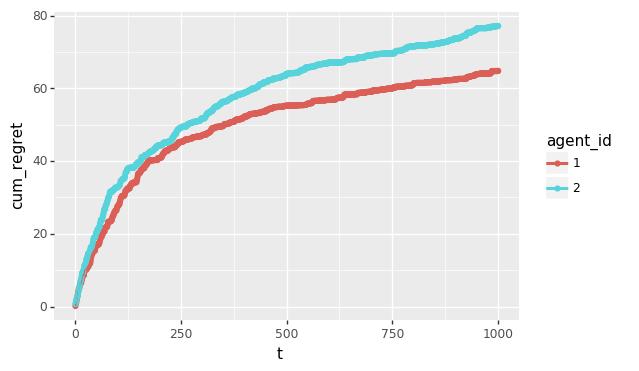

<ggplot: (8731325004597)>


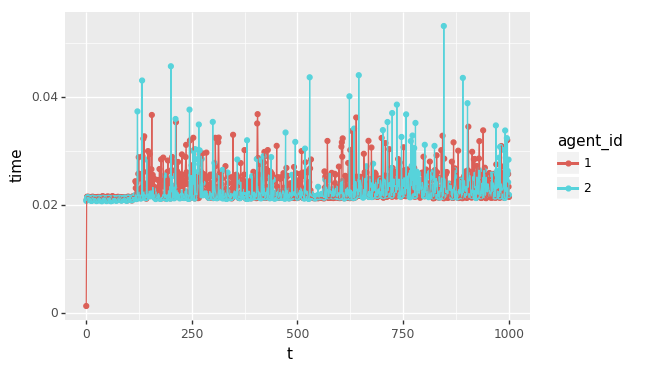

<ggplot: (8731325005301)>


([      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
  0             1        1     0.966030    0.150739        0.150739     1   
  1             2        2     0.966030    0.698392        0.698392     1   
  2             3        1     1.737520    0.848284        0.697545     2   
  3             4        2     1.737520    1.395936        0.697545     2   
  4             5        1     2.422533    1.175147        0.326864     3   
  5             6        2     2.422533    1.559125        0.163188     3   
  6             7        1     3.194133    1.888207        0.713060     4   
  7             8        2     3.194133    2.301248        0.742123     4   
  8             9        1     3.932176    2.408522        0.520314     5   
  9            10        2     3.932176    2.676173        0.374925     5   
  10           11        1     4.596109    3.052334        0.643812     6   
  11           12        2     4.596109    2.797783        0.121610     6   

In [10]:
make_best_sagald_agent = lambda: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
simple_compare([make_best_sagald_agent(), make_best_langevin_agent()], num_articles, dim, var, 1000, 123, verbosity=verbosity)

theta [-0.69883694  0.01062308 -0.94678644  0.32872998  0.31506457 -0.40282244
 -2.63330372  0.2019705  -0.40732612  2.68696775 -0.88389869 -0.40366892
  0.10192369  1.19598142  1.17241135  0.1691044  -0.49132423 -0.82940313
 -0.18964051  0.43325835 -2.36853362]
Experiment: Step 0
 Sample: array([ 0.99790136, -0.11745349,  1.97240683,  0.34435015, -0.09559376,
       -0.74862251,  1.02991104,  0.92967474,  1.34294042, -0.79150962,
        0.37504896,  1.51750341, -0.69693637,  1.06321456, -1.20411793,
       -2.06407121, -0.21302936, -0.56254736,  1.29179062,  0.4626082 ,
       -0.94599242])
 Steps taken: 0
 Sample: array([-0.03203092, -0.7872312 ,  0.57288124,  0.36890795, -1.55231591,
        0.05096619,  0.40023662,  0.42037886, -0.30000982,  2.57967389,
       -0.56412554,  1.17115023,  1.05992416,  0.89424391,  0.5356449 ,
        0.45835716,  2.12054468,  0.0725003 ,  1.5155161 ,  0.72547514,
        0.28110119])
 Steps taken: 0
 Sample: array([ 0.79622782,  0.98920816, -0.72572

 Sample: array([ 0.03224359,  1.80846252,  1.54532753, -0.21506625,  0.43822117,
        0.47393102,  0.02804045,  1.04861682, -0.2666595 , -0.17148146,
        0.16446482,  0.54722599,  0.6543859 , -0.56877646,  1.11883891,
       -1.89146874, -1.2436967 ,  0.58742761,  1.22503974,  0.92298292,
        0.75744774])
 Steps taken: 283
 Sample: array([-1.36616366, -0.062513  , -1.22363267, -0.98900833, -1.04247185,
        0.11111978,  2.72214   , -0.18566662, -2.79765067, -1.44868004,
        0.76173392, -0.0437786 ,  0.47559072,  0.34631156,  0.49996855,
        0.19637469,  0.35625109,  0.57244242, -0.63807462,  0.71413875,
       -0.72817244])
 Steps taken: 289
Experiment: Step 8
 Sample: array([ 0.18846252, -1.72287112,  1.53229251, -0.32082037,  1.67644143,
       -2.60572659,  0.45006418,  0.89893047, -0.12348331, -0.10915992,
       -1.63366229,  0.25981657, -1.06450306,  0.1600021 ,  0.75674629,
        1.98157396,  0.59114539, -0.00719918,  2.08861606,  0.1683015 ,
       -0.58

 Sample: array([ 0.12070514, -1.85896427,  0.75636884, -0.42524912,  0.75306586,
        0.75248895,  0.50337709, -0.28327182, -0.11230049,  1.01104978,
       -0.7781501 ,  0.3710036 , -0.27830841, -0.72611964, -0.6797961 ,
       -0.42972992, -0.52054405,  1.4028838 ,  1.54127214, -1.08381627,
        0.18335172])
 Steps taken: 214
 Sample: array([-0.400691  , -0.80540736, -0.69156293,  0.17691898, -1.39741912,
        0.23581004,  0.30030105, -0.26212409, -0.80992325,  0.5488443 ,
        1.05731193, -0.41296198, -1.51720914, -0.60428794,  0.08996744,
        1.00741832, -0.79637866, -0.49571179,  0.47331545, -0.06766273,
        1.0863218 ])
 Steps taken: 219
 Sample: array([-0.74620321, -0.53107491, -0.39344498,  0.35979395, -0.48124672,
       -0.03810299, -0.92794332, -0.46041485, -1.36962282, -0.12958451,
       -0.42494021, -0.06093479, -1.7487176 , -1.60829396,  1.40939349,
        0.02781387,  1.03125638, -0.33264724,  0.70963292, -0.53493958,
       -0.99762661])
 Steps tak

 Sample: array([-1.25065997,  0.20388797,  0.56145972, -1.196839  ,  0.62997187,
       -2.0923055 , -0.38639726, -1.2395264 , -0.24355837,  0.87648177,
        2.23786484,  0.38297189,  0.64433133,  0.69703596,  1.02437268,
       -0.26740365,  0.13666526, -1.11837367, -0.77375883,  0.19350175,
       -0.69221007])
 Steps taken: 275
 Sample: array([-1.28870252,  0.09806366,  0.41927863, -1.68801115,  0.00786217,
       -0.43906128, -0.59802139, -1.06877611,  0.91939165,  0.08465552,
        0.23894128, -0.23928938, -0.25099297,  2.04177187, -0.03374132,
       -1.79460406,  0.57528037, -1.30131543,  0.03018658,  1.69508958,
       -1.88868709])
 Steps taken: 285
Experiment: Step 23
 Sample: array([ 0.96701655, -1.87684881,  0.13789818,  0.19648982,  0.07064885,
        1.00609121,  0.76367382,  2.17965038, -1.12404002,  1.50167353,
       -1.30250088, -1.08462349, -0.50753447, -2.05678762, -0.85145871,
        0.74124285,  0.41536308, -1.06878925,  0.08118048,  0.46302585,
       -0.6

 Sample: array([ 0.15433812,  0.34415392,  0.0880875 ,  0.1410845 ,  0.03553532,
       -1.33319698, -0.23086851,  0.52052505, -1.63493181,  1.1878636 ,
        0.00571303,  0.27125979, -0.47168076, -0.70589454, -0.01883222,
       -0.60902716,  0.02129325,  0.72504086,  0.36837599, -0.63087093,
       -0.7281179 ])
 Steps taken: 197
 Sample: array([-0.72094959, -0.225649  , -0.88783547, -0.36747904, -0.1729536 ,
        1.9383658 , -0.40210736,  0.2500917 , -2.7341887 , -0.71017167,
       -0.00945749, -0.98231043,  0.8629468 ,  0.29807033,  1.27570377,
        0.10249307, -1.07474569,  0.72461   ,  0.9380789 ,  1.15118587,
       -2.59160157])
 Steps taken: 203
 Sample: array([ 0.04759501, -1.26334524, -2.39336854, -0.65862584, -0.46165218,
       -0.45092252, -0.32082425,  0.02044669, -1.01251684,  1.14667373,
        0.90758907, -2.3733251 ,  1.25483985, -0.62703874,  0.1327449 ,
       -0.26946957,  0.90756235, -0.08240406,  1.20492438,  0.15696955,
       -0.97399669])
 Steps tak

 Sample: array([-0.26044443,  0.77638211,  1.08537454, -0.21266487, -0.59252964,
        0.20967093, -0.8863453 ,  0.90500496, -0.88308127,  0.30686867,
       -0.47917673,  0.11237073,  0.56391885,  1.60083225,  1.02958686,
       -1.10558839,  0.45696399,  1.41160875,  0.68925484,  0.51379197,
       -0.60539519])
 Steps taken: 261
 Sample: array([-1.97841607, -0.63250361,  0.49376662, -0.59182995, -0.91449179,
        0.28925779, -1.5639375 ,  0.34619667, -0.92315927, -0.68915158,
        0.14374534, -0.38153827, -0.63993356,  0.17630984,  1.36537269,
       -0.45159334, -1.46826451,  0.66447338, -0.7186426 ,  1.90743686,
       -0.5468455 ])
 Steps taken: 267
Experiment: Step 38
 Sample: array([-0.41945834, -0.62973083,  1.09495257, -0.42306635, -0.39439341,
       -1.59690238, -0.13901037, -1.94618279, -0.7388844 ,  1.32167134,
       -0.00835678, -0.06343317,  0.83845211, -1.15551819,  0.26056304,
       -0.32741632, -1.07067633,  0.47163775,  1.16382464, -0.94720317,
       -1.8

 Sample: array([-0.22540459,  0.46545309,  1.3468574 , -0.08906131, -0.55141664,
       -0.76312392, -1.5923325 , -1.83585938, -1.82291788,  1.08353386,
       -1.33285645, -2.25190379,  1.53457165,  0.24575043, -0.2642672 ,
       -0.3063053 , -1.37379866,  0.04122438,  0.85123869,  0.18290868,
       -1.3920051 ])
 Steps taken: 150
 Sample: array([-0.533764  , -2.07989374, -0.24000296, -0.53423055,  0.2205191 ,
       -0.4923449 , -1.20828132, -1.21245762, -1.82404832, -1.36851107,
       -1.05282982, -0.34220015,  0.70368164, -0.63958247, -0.6181899 ,
        0.39655511, -0.01722617,  0.98123548, -0.42717507, -0.08648991,
       -1.85721694])
 Steps taken: 155
 Sample: array([-0.75117637,  0.55760815, -1.02711399, -0.82968023, -1.00989352,
       -0.65881133, -1.53221845, -0.97677527, -1.16824846,  2.00431231,
        0.8491492 ,  1.18933467,  1.6025859 ,  1.41802662,  0.26182658,
       -1.76933187,  0.52675464,  1.51361521,  0.0691167 , -0.11979363,
       -1.0984836 ])
 Steps tak

 Sample: array([-1.05078564,  0.8739669 , -1.8969939 ,  1.44871304,  0.9010131 ,
       -1.01324478, -1.17287673,  0.10988125, -1.41114924,  1.12592367,
        0.92824745,  0.24086329, -0.45959129,  0.08924841, -0.82891416,
       -0.72494952, -0.77981324,  0.54755924,  0.36022061,  0.80573094,
        0.15097225])
 Steps taken: 184
 Sample: array([-0.07557802,  0.44225413, -0.67310797, -1.32770865,  1.25443294,
       -2.1023701 , -0.80502887, -0.10751384, -0.53328194,  1.12656121,
       -2.882715  , -0.14926214,  1.56173836, -0.62326212,  0.11283362,
        0.17748991, -1.15402065, -1.86433662, -0.52920181,  2.09974391,
       -1.58794003])
 Steps taken: 170
Experiment: Step 53
 Sample: array([ 0.81328744,  1.65947874,  1.18820102, -0.53052032, -0.4661655 ,
        0.74435091, -1.57756164,  0.63773743, -0.42322406,  1.57298851,
       -1.41432726, -1.94004674,  1.09260447,  0.25636045, -0.41186004,
       -1.53438319, -1.67813807,  0.34926334,  0.95524566,  0.59624694,
       -1.7

 Sample: array([-0.04176386, -1.15094114,  1.83806916, -0.64982272, -1.82353085,
       -0.64070124, -1.25372923,  0.50088474, -1.62698838,  2.40843098,
       -0.12899003, -1.37650848,  0.93181549, -1.11481793, -0.26105415,
       -0.46330818, -1.44108144, -0.59424884,  2.09245736, -0.80199641,
       -0.85944185])
 Steps taken: 101
 Sample: array([-0.91358452, -1.74009605, -1.92901366, -0.62691948,  0.10398337,
        1.59785198, -2.26238693, -0.56730956, -1.24292889,  0.51317003,
       -1.35933683, -0.24227812,  0.56601957,  0.90266528,  0.68994273,
       -0.15548923,  0.64961284, -0.30913766, -0.64698173,  0.30835   ,
       -1.49180691])
 Steps taken: 106
 Sample: array([-3.92162511e-01, -5.79594271e-01, -1.61382329e+00,  9.93447161e-01,
        1.17414284e-01, -6.32138986e-02, -9.48570346e-01,  1.82276290e+00,
       -1.68765288e+00,  1.46583275e+00,  5.61490172e-02,  4.30505727e-01,
        6.67083869e-04,  1.10860648e+00, -5.44561952e-01, -1.03072927e-01,
       -1.33903912e

 Sample: array([-0.04631547, -0.16531743, -1.83698252,  3.14201849,  0.02889561,
       -0.05324597, -1.1075555 ,  1.88981305, -0.18466962,  1.71602961,
        0.24611811,  0.12384346,  0.45623941, -0.34404281, -1.98520501,
       -0.13292892,  0.68549289,  1.35978783, -0.07954566, -0.26720033,
       -1.05650112])
 Steps taken: 225
 Sample: array([-0.88320819, -0.2384006 , -0.74476203,  1.81726917, -0.71003739,
       -0.03144243,  0.34756863, -0.21814604, -1.73940019,  0.77865878,
        0.54557118,  0.96877247,  0.44163677,  0.36591575,  0.51210276,
       -0.41225644, -0.87156345, -0.30228838, -0.2094841 ,  0.69077387,
       -1.03653362])
 Steps taken: 229
Experiment: Step 68
 Sample: array([-0.527403  ,  0.01449238,  1.04542033, -1.22807912, -0.17362926,
        1.88641658, -0.85849472, -0.1885552 , -0.49283072,  1.66670949,
       -1.53705748,  0.67924915, -0.713736  ,  1.52920497,  1.3595458 ,
        0.13874948,  0.39512308,  0.31969183,  0.16254062, -0.42394882,
       -0.4

 Sample: array([-0.02843038, -0.4929754 ,  0.18156203, -0.8369185 , -0.54612904,
        0.19451302, -1.22251546, -0.56338005, -0.71085794,  1.90017059,
       -0.26811989, -0.4351967 ,  0.70835848, -0.25402101,  1.19983553,
       -0.06701876, -1.9316843 , -0.07575331,  0.37009658, -0.24558068,
       -1.75240751])
 Steps taken: 151
 Sample: array([-0.83684941, -0.58047303, -0.87098959,  0.53844421, -0.35783746,
       -0.42102578, -2.66586331, -1.19417649, -1.7873606 ,  0.28127145,
       -1.66691302, -0.69548249,  0.18985081,  1.57252091,  0.74448472,
       -0.26284685, -0.66508008, -0.09073497, -1.08648834,  0.57919415,
       -1.30157371])
 Steps taken: 158
 Sample: array([ 0.43108131, -1.10202956, -1.80467169,  0.39094491,  0.98445766,
       -0.16758762, -0.80466299,  1.88299021, -1.62965682,  0.81814405,
        0.23026797,  1.02604643,  0.45565779, -0.15539988, -0.31703601,
       -0.77683304, -0.22828845, -0.68435129, -0.93632049,  0.36572608,
       -0.12613836])
 Steps tak

 Sample: array([-0.16450939,  0.235844  , -3.06399717,  0.64080858,  0.5464927 ,
       -1.0272015 , -0.8587057 ,  2.26170387, -1.34901517,  0.74817821,
       -1.45556596,  1.08715157,  0.92309414,  0.25491609, -0.2623071 ,
       -1.18250127,  1.0041762 ,  0.79081715, -0.0757811 ,  0.87016676,
       -0.71755076])
 Steps taken: 192
 Sample: array([-0.53272403,  0.0757488 , -0.67627722, -0.17464915,  0.89414496,
        0.79434536,  0.69945209,  2.31265497, -0.06380943,  1.8370276 ,
       -0.61557581,  0.52815709, -0.05590115,  0.53044613,  0.26691019,
       -0.29596268, -1.04593894, -1.41832738,  1.00902431,  0.64433393,
       -1.98956912])
 Steps taken: 142
Experiment: Step 83
 Sample: array([-0.08137156,  0.25837617,  0.45803609, -0.38712332,  0.3044181 ,
        0.02179516, -0.81967076,  0.59978451,  0.16148614,  1.18087641,
       -1.23152772, -0.3267713 , -0.60100743, -1.31390734,  0.56826908,
       -1.6465477 , -0.27566932, -0.80454758,  0.04108055,  0.24452192,
       -0.0

 Sample: array([-0.32039808,  0.62163475,  0.72382325, -0.3884479 ,  0.16623521,
       -0.51050815, -0.9596161 ,  0.41329803, -0.75777686,  1.58609103,
       -1.25045516, -0.94462766, -0.38598141,  0.65586116,  0.54819763,
       -0.9463606 , -0.80003472, -0.99989909,  0.80584073,  1.06018204,
       -1.0407337 ])
 Steps taken: 101
 Sample: array([-0.53354489, -0.29086939, -0.44088804,  0.49205702,  0.60273212,
       -0.09272869, -2.18008702,  0.33672993, -1.77821581, -0.12544739,
       -0.71339444, -0.41123331,  0.1538725 , -0.15420377,  0.28961195,
       -0.50945266, -0.73312908,  0.050938  , -1.27322632,  0.4496441 ,
       -1.31089034])
 Steps taken: 107
 Sample: array([-0.73547975, -0.764868  , -1.27461594,  1.30880857,  0.01945623,
       -0.13229265, -0.59982825,  1.20045427, -1.63246987,  2.17779994,
       -0.13626699, -1.08050895,  0.39577633,  0.91899951, -0.04296221,
       -1.05297354, -0.00525846,  1.38912994,  0.24969553,  0.80881407,
        0.12782866])
 Steps tak

 Sample: array([-0.33604764,  0.14481498, -0.82357483,  0.80510093,  0.59746681,
       -0.25738539, -1.58670429,  0.89892614, -1.23063278,  0.72623158,
       -0.17788536, -0.45272929,  0.19940407,  1.85275318, -0.00357715,
       -0.83072026,  0.68613096,  0.0156538 , -0.27226564,  0.09278019,
        0.20989472])
 Steps taken: 187
 Sample: array([-0.23672728, -0.6401236 , -0.8840756 , -0.50181423,  0.03594499,
       -1.0099987 , -0.40754213,  0.31506269, -1.66637063,  1.60618091,
       -0.07607584, -0.55728019,  0.80449103,  0.11304638,  0.31564451,
       -0.43218153, -0.87088057, -0.75125392,  0.33804635,  0.65399327,
       -0.98627161])
 Steps taken: 196
Experiment: Step 98
 Sample: array([-0.73916986, -0.76929576,  0.78421777,  0.75602774, -0.42915432,
       -0.23567446, -0.84104988, -0.14825469, -1.50224823,  2.68920199,
       -2.20286829, -0.25387631, -0.52225293, -1.48202887,  0.14094054,
        0.47463884, -0.50242258,  0.5310291 ,  0.09945064, -0.2368251 ,
       -1.7

 Sample: array([-0.09100535,  0.66428445, -0.75920946, -0.57659927, -0.12806156,
       -1.27674506, -0.66343008,  0.84488018, -0.89544558,  0.94267786,
       -2.0859822 ,  0.23868096, -0.70109067, -1.17220618,  0.37017002,
       -0.82110705,  0.02908065, -0.0237471 ,  0.03556098,  0.48477698,
       -2.21223817])
 Steps taken: 146
 Sample: array([-0.95553118, -1.37103767, -0.9729621 ,  0.68669959,  0.98345157,
       -0.50013623, -2.12230766, -0.66611979, -0.7380089 ,  0.46454622,
       -0.765845  , -0.73623433,  1.05220461,  1.7105913 ,  1.45293281,
        0.42029745,  0.44386624,  1.25531656, -1.17002867, -1.04234906,
       -0.70076896])
 Steps taken: 155
 Sample: array([-0.41034122, -0.37661737, -0.80058701,  0.75045014, -0.94572528,
        0.27395339, -1.49932558,  1.05545558, -1.43609672,  1.79281801,
       -0.99163385, -0.31311546, -0.12825444,  0.63120169, -0.60014835,
       -1.07597468, -0.29216324,  0.42511375, -0.9289038 , -0.62077118,
       -0.57188621])
 Steps tak

 Sample: array([-0.28930499, -0.0028679 , -1.88342477,  0.1635877 ,  0.31336714,
       -1.74494095, -1.27764164,  1.06722949, -0.54061582,  0.86753473,
       -0.21261209, -0.45871708,  1.06129803,  0.1822536 ,  0.08343641,
        0.50156571,  0.27099474,  0.24571239, -1.02529757,  1.20176205,
       -1.63412116])
 Steps taken: 65
 Sample: array([ 0.58895355, -0.53023912, -0.22457989,  0.78309301, -0.94068786,
       -0.99833238, -0.5164751 ,  0.90346787, -0.90896375,  0.98706209,
       -0.0704349 , -1.07161997, -0.24824902,  0.27933844, -0.00512363,
        0.0526824 , -0.61826142, -0.06109674,  0.11556083, -0.25520775,
       -1.563884  ])
 Steps taken: 111
Experiment: Step 113
 Sample: array([-0.44564622, -0.54088879,  0.70758592, -0.12394878, -0.98314739,
       -1.80814269, -0.8040441 ,  0.11002351, -0.87971595,  2.23524913,
       -1.7921284 , -1.88186782,  0.64696469, -1.33306435,  0.12794552,
       -1.421875  , -1.14641059, -0.51902096,  0.97199759,  0.34982348,
       -2.0

 Sample: array([-0.77117916, -1.35484565,  0.73268201, -0.33630258,  0.29299831,
       -0.03835127, -1.40643873,  0.65231229, -1.45964805,  1.59142866,
       -0.41128907, -1.78673218, -0.04021523, -0.07487395,  0.89546695,
       -0.95048294,  0.16176075,  0.63232461,  0.70114803,  0.14472101,
       -1.1271283 ])
 Steps taken: 91
 Sample: array([-0.35344484, -1.1779152 ,  0.04982569,  0.57544011, -0.80001835,
       -0.3822577 , -2.67348798,  0.56560727, -0.86707923,  1.56864417,
        0.5045949 , -1.45777817,  1.37809982,  0.8571008 ,  0.99148498,
        0.13330063, -0.82462382, -0.25560885, -1.0401531 ,  0.05861935,
       -1.77449798])
 Steps taken: 106
 Sample: array([-0.76198043, -0.94577082, -1.313801  ,  0.89987068,  0.31067091,
        0.41137416, -0.58930454,  1.68987968, -0.86067169,  1.46698728,
       -0.86175044,  0.34748665,  0.05344186,  0.58848964,  0.67982797,
       -0.30103246,  0.31512772,  0.53273321, -1.08934719,  0.85284998,
       -0.29930495])
 Steps take

 Sample: array([ 0.11392571,  0.67355446,  0.31725047,  0.57971346,  0.54833985,
       -0.5776902 , -0.40382937,  1.19177708, -1.00235216,  1.60330261,
       -1.43249282, -0.03591579, -0.56724391, -1.05151847,  0.5938473 ,
       -0.65800808,  0.15294793, -0.66746088, -0.08031337,  0.7835396 ,
       -1.56379154])
 Steps taken: 53
 Sample: array([-0.48640016, -0.80434448, -0.78461894,  1.55557724, -1.02780368,
       -0.17504402, -2.75841362, -0.90491473,  0.05567655,  1.30882083,
       -1.07298359, -1.06539862,  0.37846421,  0.74651271,  0.69378205,
        1.13922232, -0.21644814, -0.96259578, -0.92708233,  1.34051502,
       -2.32767168])
 Steps taken: 103
 Sample: array([-0.30571444,  0.36487826, -0.72526881,  1.25677759, -0.24211564,
       -0.22137821, -1.85602004,  1.80069072,  0.52981556,  1.3389712 ,
       -0.75382356, -0.76895476, -0.39927817,  0.89193621,  0.25969834,
       -1.58567351, -0.26180696,  1.65711682, -0.20068412,  0.62039787,
       -0.18968138])
 Steps take

 Sample: array([-0.61472815, -0.70640185,  0.59481334,  0.3173347 ,  1.07305177,
        0.19645142, -1.33886226,  0.10727204, -1.22004765,  3.28259309,
       -0.33489004, -0.94475032, -0.00522334,  1.34598704,  1.37127162,
       -0.14492075,  0.03448438,  0.46358036, -1.10384927,  0.73714081,
       -0.7236119 ])
 Steps taken: 52
 Sample: array([-0.46113664, -0.67375012,  0.43216504,  0.22006403, -0.70205425,
        0.60816245, -2.53227594,  0.16277646, -0.01537182,  0.64679583,
       -1.05192485, -0.00780059,  0.5713784 ,  0.26775713,  1.15087496,
        0.76375588, -1.27729957,  1.28325606, -0.75786959,  0.03855588,
       -1.12242268])
 Steps taken: 105
 Sample: array([-0.01756914,  0.10857248, -0.1462038 , -0.12833669,  0.70662128,
       -1.1756262 , -1.24902046,  1.54841064,  0.15669492,  0.52259746,
       -0.78353479,  1.3176303 ,  0.86658402, -0.24070761,  0.08561205,
       -0.03806804,  0.43691346,  0.65039851, -0.68887735,  0.30014192,
        0.01840805])
 Steps take

 Sample: array([-0.89067679, -0.44114978,  0.4817825 ,  0.45158771, -0.66899166,
       -0.45745244, -1.11628449,  0.47491198, -1.32854952,  1.23126277,
       -0.93353973, -0.76953793,  0.17739228, -0.0475375 ,  0.5825455 ,
       -0.58934413, -0.66845879,  0.06186057,  1.27970516,  1.26692944,
       -1.33313322])
 Steps taken: 52
 Sample: array([-0.33764035, -0.67562226, -0.43463516, -0.56435317, -0.72087615,
        0.42739428, -3.15463396, -0.30329095, -0.08261729,  1.64980254,
        0.6862142 , -0.88550463, -0.43874795, -1.21043956,  0.73778091,
        0.14669302, -0.57780113,  0.37015056, -1.37552404,  0.11985029,
       -1.73768701])
 Steps taken: 51
 Sample: array([-0.44576013,  0.09493612, -0.89158408,  0.03170407, -0.8927825 ,
       -0.83556797,  0.03916725,  0.34072426, -0.28527197,  1.55697783,
       -0.40041844, -0.42916557,  0.55671678,  0.95102077,  0.43574482,
       -0.43203457, -0.10674339,  0.59488503, -0.06114013,  0.33821722,
       -1.15788651])
 Steps taken

 Sample: array([-0.03747966, -0.40328941,  0.51127911,  0.25628744,  0.27796499,
       -0.00387911, -0.88048831,  0.28147458, -0.26418854,  1.96276301,
       -0.6478318 , -0.59920364, -0.03666116, -0.06568079,  0.58954871,
        0.60349155, -0.67873727,  0.32874572,  0.80283154,  0.88469307,
       -0.50858299])
 Steps taken: 93
 Sample: array([-1.1403426 , -0.58275318, -0.5551939 , -0.25800428, -0.25555334,
        0.29416205, -2.60865919,  0.03906573, -0.96317092,  1.21157203,
       -0.59347046, -0.45289201,  0.842492  ,  1.4505911 ,  1.66609356,
        0.56725838, -1.51337122,  0.61162054, -1.22155137,  1.30547321,
       -1.93785898])
 Steps taken: 106
 Sample: array([-0.66436133, -0.33456621, -1.37002776,  0.85559183,  0.03283343,
        0.03953628,  0.22308117,  1.65110344,  0.27468527,  1.5770036 ,
       -0.38783235, -0.15506615,  1.24778657,  0.54541199,  0.70288389,
       -0.25765808,  0.39318074,  1.12568154, -0.64809232,  0.6635576 ,
       -1.36425141])
 Steps take

 Sample: array([-0.26753066, -1.29041368,  0.12114601,  0.56376265,  0.09004455,
        0.37776405, -1.90806184, -0.47102903,  0.36372722,  1.18811801,
       -0.23308562,  0.14401737,  1.63169246,  0.72210016,  1.69094269,
        0.69544817, -1.26045722,  0.55746401, -0.99599755, -0.33916101,
       -1.26074484])
 Steps taken: 90
 Sample: array([-0.43609166,  0.13997463, -0.86191877,  0.40684976,  0.55629589,
        0.88910169, -0.83753347,  2.56927423, -0.85135653,  1.07964109,
       -0.10948595, -0.22239912,  0.42602843,  0.12450356,  0.67021069,
       -0.2489737 , -0.3836943 , -0.00283974, -0.6732308 ,  0.70137586,
        0.06203914])
 Steps taken: 88
 Sample: array([-0.52758878, -0.4238743 , -0.57482761,  0.96502254, -0.17461707,
       -1.20382869, -1.82391774,  1.40265199, -1.67743903,  3.00780751,
       -0.76263422, -0.56086465, -0.16931727,  1.03501675,  0.44457292,
        1.48409294, -1.20559036, -1.29051848, -0.87588031,  0.65394147,
       -2.11900746])
 Steps taken

       -1.08088805])
 Steps taken: 106
 Sample: array([-0.88733419,  0.64293871, -0.49973557, -0.65574609,  0.93304197,
       -0.5687158 , -2.54850109, -0.25332181, -0.98762995,  1.26363596,
       -0.4805966 , -1.16690602,  0.33193594,  1.30064399, -0.46665966,
       -0.28447463, -0.29260367,  0.70301726, -1.5007951 ,  0.23946234,
       -1.84075646])
 Steps taken: 106
 Sample: array([-1.0322053 ,  0.16008526, -1.47838201,  1.76482262,  0.69119391,
       -0.11612485, -2.37260761,  1.98124266, -1.34387125,  2.18692502,
       -0.15600983, -0.22178709,  0.13293619,  0.38523818,  1.44482543,
       -0.93253727,  0.11992368, -0.38542707, -0.635184  ,  0.06915544,
       -2.27501603])
 Steps taken: 71
 Sample: array([-0.58691227, -0.65871275, -0.70759121,  0.45924828,  0.20880435,
       -0.61258054, -1.44167478,  1.01025411, -1.41768422,  3.00569014,
        0.42665414,  0.38344439,  0.50328152, -0.056006  , -0.03588317,
       -0.13686012, -1.41457268, -0.43299294, -0.75903967,  0.310

       -0.79925131])
 Steps taken: 103
Experiment: Step 169
 Sample: array([-0.87107413, -0.66952315, -0.94288751,  0.10657867, -0.29990338,
       -1.17348091, -1.61742243,  0.12821259, -1.17487822,  2.13599102,
       -1.45522858, -1.16480342,  0.08192627,  0.03053211,  1.20262727,
       -0.59139313, -1.22700629,  0.53732936,  0.93307372, -0.14766856,
       -1.3335583 ])
 Steps taken: 105
 Sample: array([-0.56662861, -0.19585399, -0.05766688, -0.40718373, -0.47484417,
        0.2308717 , -2.61953477, -0.18264505, -0.72471676,  1.67134967,
       -1.77951274, -0.43437654,  0.72437008,  0.61557141,  1.43655245,
       -0.46039655, -1.2537457 ,  0.16441766, -0.68082043,  0.72642704,
       -1.51954923])
 Steps taken: 106
 Sample: array([-0.67960894, -0.02655975, -1.57094665,  0.44441225,  0.94478967,
       -1.12019672, -1.55935196,  2.19429616, -0.60858841,  2.56063305,
       -1.27728152, -0.22211249,  0.70381178,  0.27159059,  1.67490481,
       -1.36910736, -0.66843346,  0.0895770

 Sample: array([-0.87286351, -0.04717815, -1.65003462,  0.50557812,  0.46765852,
       -0.63252936, -1.61722707,  0.29003806, -1.08698792,  2.13016752,
        0.08155108, -0.72101444, -0.37269259,  0.7686473 ,  0.3916577 ,
        1.18006255, -0.39120653, -0.21377031, -1.007122  ,  0.56667335,
       -2.25371529])
 Steps taken: 51
Experiment: Step 176
 Sample: array([-0.41652288, -0.18568637, -1.29384362,  0.21174239,  0.53374838,
       -0.87347154, -1.2428292 , -0.06686139, -1.0467634 ,  2.02399436,
       -1.00215385, -1.40456991, -0.76250279,  0.37798961,  1.46546908,
       -0.47505588,  0.10115767,  0.32577689,  0.12164371,  0.37779765,
       -1.96051363])
 Steps taken: 105
 Sample: array([-0.61702436,  0.03191459, -0.9608021 , -0.65211643, -0.30672515,
       -0.98295953, -3.10315265, -0.12017265, -1.11113692,  1.58355409,
       -0.57000315,  0.18248481,  0.62433776, -0.00684586,  0.72981475,
        0.12927767, -1.65478115,  0.337306  , -1.71521755, -0.48453656,
       -1.7

 Sample: array([ 0.07383334,  0.29206716, -0.75496262,  0.08483956,  0.30657917,
       -0.51246647, -1.74287922,  0.89868717,  0.16077407,  1.36987608,
       -0.88478444, -0.14267802, -0.12919886, -0.35050214,  1.13138217,
        0.14205882, -1.32127856,  0.06032811, -0.14267724,  0.03324661,
       -1.78481148])
 Steps taken: 76
 Sample: array([-1.28127433, -1.09256579, -0.91664493, -0.19662024,  0.61738701,
       -0.40870376, -3.56341674,  1.11970075, -0.72225346,  0.38154669,
       -1.55752477, -0.7155527 , -0.03783313, -0.71501776,  0.88428763,
        0.36932502, -1.18589573,  0.1719553 , -1.903329  ,  0.47811027,
       -1.35656925])
 Steps taken: 49
 Sample: array([-1.14544495,  0.59108402, -1.06084955,  1.37879334, -0.72870315,
       -1.32561503, -2.3288234 ,  1.02557407, -0.36148498,  2.9920088 ,
       -0.16064519,  0.15370152, -0.21247947, -0.45268585,  1.25028177,
       -0.54694334, -0.45689367, -0.54642206, -1.26889776,  0.66059081,
       -1.74926009])
 Steps taken

 Sample: array([-1.25613174, -1.15034333, -0.77960966,  0.79188318, -0.18446813,
       -0.42230824, -3.36122731,  0.53831344, -0.43937155,  1.75547029,
       -1.1018016 , -0.23454376,  1.42222795,  0.80182713,  1.02401485,
        0.3210033 , -1.99150937, -0.1607285 , -1.72784324,  0.27938819,
       -1.29092262])
 Steps taken: 94
 Sample: array([-0.15992389, -0.47771175, -1.38992127,  0.67646478, -0.32315071,
       -0.57812778, -1.13427056,  0.96703731,  0.20755796,  2.34979952,
       -0.91434174, -1.05123956, -0.14186064,  0.99125434,  0.88896759,
        0.13316906, -0.87330123,  0.89985346, -0.71508551, -0.30614695,
       -2.04149705])
 Steps taken: 89
 Sample: array([-0.37357849, -0.18845145,  0.65567649,  0.50862459,  0.31274562,
       -1.11261508, -1.85975448,  0.66549536, -0.95039916,  2.35970069,
       -0.25904397,  0.40721128, -0.62220902,  0.65775214,  0.47924294,
        1.16972765,  0.09944504, -0.29622836, -0.15156696,  1.09338281,
       -1.72125058])
 Steps taken

 Steps taken: 63
 Sample: array([-0.68397028, -0.91227127, -0.71638997,  0.57510234, -0.36638351,
       -1.10380148, -1.54839894,  1.67194643, -1.42439259,  2.25259403,
       -0.12758395,  0.12934611,  0.96937504, -0.16513819,  1.08084092,
       -0.67779575, -1.09218235, -0.09559906, -0.43753496, -0.38460353,
       -1.2957536 ])
 Steps taken: 51
 Sample: array([-0.72281017, -0.94974893, -0.12350175, -0.12345204,  0.34986779,
       -1.37965556, -2.10075501,  0.77094965, -1.5111815 ,  3.30010906,
       -1.52388128, -0.89432963,  0.72036961,  0.63597417,  0.1543353 ,
       -0.25899948, -1.22095763, -0.46356923, -0.9008548 ,  0.66494266,
       -2.09368905])
 Steps taken: 55
Experiment: Step 198
 Sample: array([-0.3417748 , -0.46657216, -1.03097681,  0.53008593,  0.06632414,
       -0.96587706, -1.38063708,  0.28540837, -0.20933582,  2.19192103,
       -2.010773  , -1.02049229,  1.51711481, -0.44534834,  0.47674918,
       -0.50906829, -0.45772617, -0.00442575, -0.18088565, -0.18195

 Sample: array([-0.62350575, -0.80847534, -1.66051034, -0.06631915,  0.31245256,
       -0.88639464, -2.87719007,  0.02324225, -0.58009761,  0.99230077,
       -0.75882595, -0.46066618, -0.01988814,  0.05642148,  0.8509728 ,
        0.33387033, -0.85948032,  0.83374664, -1.07494647,  0.16168084,
       -2.1485965 ])
 Steps taken: 99
 Sample: array([-1.21372019, -0.5857705 , -0.89906372,  1.50012968, -0.38889547,
       -0.43813644, -2.0298568 ,  1.61049077, -1.06051562,  3.12764981,
       -0.44752846, -0.34048131,  0.17742457, -0.96651222,  1.91239279,
       -0.64138216,  0.18384828, -0.62865492, -1.0358919 , -0.49602657,
       -1.01913622])
 Steps taken: 95
 Sample: array([-0.8102371 , -0.12394823, -0.78088403,  0.7008227 ,  0.28573353,
       -0.89297502, -2.38097818,  0.26428587, -0.40021639,  3.61465119,
       -0.16790396, -1.00822887,  0.61183691, -0.5612015 ,  1.15799341,
        0.94011019, -1.42680596, -0.3576992 , -0.43841766,  0.41504377,
       -1.79638708])
 Steps taken

 Sample: array([-0.89664325, -1.35276831, -0.98703815,  0.80009704,  0.79231056,
       -0.16043604, -3.42302177,  0.22939579, -1.47035409,  2.24267587,
       -0.71365033, -0.05622098,  0.77680141,  0.09361915,  1.18589953,
        0.28719294, -0.69288481, -0.22652884, -1.04865367, -0.30954507,
       -0.91457922])
 Steps taken: 90
 Sample: array([-0.42336903, -1.0490542 , -0.75734364,  0.64668178,  0.2268897 ,
       -1.29175476, -1.63755533,  0.90377326, -1.14095225,  1.92876214,
        1.02810922,  0.05097577,  0.79725664, -0.13636527,  1.01019978,
        0.05570506, -0.65062837,  0.19881767, -0.94401783, -0.02736476,
       -1.65782675])
 Steps taken: 92
 Sample: array([-7.18308363e-01,  2.51409249e-01, -6.18393694e-01,  2.11963126e-01,
       -2.25895611e-01, -5.04074089e-01, -2.48847019e+00,  5.04810950e-01,
       -1.04036602e+00,  2.70964065e+00, -6.34573758e-01, -6.89291308e-01,
        2.52172392e-01,  8.78652512e-01,  7.07255197e-01,  8.82095573e-02,
       -5.43834984e-0

 Sample: array([-0.53631668, -0.15568764, -0.33805682,  0.42396191,  0.28432858,
       -0.96703115, -2.67299947,  0.50296937, -0.96256322,  2.34130542,
       -0.99288671, -0.90636792,  0.23168954,  0.24899795,  0.52662498,
       -0.07400396, -1.93472646,  0.20363358, -2.60401771,  0.69132473,
       -2.00512725])
 Steps taken: 93
 Sample: array([-0.46297464, -0.86348757, -1.3233794 ,  0.65247483,  0.42846078,
       -0.56332835, -1.50706007,  1.33670197, -1.16711823,  1.37242328,
        0.17705188, -0.75504581, -0.23063815,  0.17917734,  0.91528397,
       -0.45701428, -0.48600052, -0.12560624, -1.2350964 , -0.08963408,
       -0.70709381])
 Steps taken: 69
 Sample: array([-0.66724445, -0.54830034, -1.42394616, -0.37027784, -0.36448911,
       -0.9624694 , -1.60488739,  0.85819962, -1.43341404,  2.28510835,
       -0.70700544, -0.70846247,  0.13988757,  1.61232695,  0.79686262,
        0.14461562, -2.12238271, -0.9589842 , -0.46927109, -0.37042022,
       -1.6466697 ])
 Steps taken

 Sample: array([-0.36599135,  0.44237112, -0.71144187,  0.72396251, -0.03416781,
       -0.65814961, -1.53469886,  0.46935563, -0.6722298 ,  2.59537137,
       -1.81841251, -0.51970353,  0.77289513,  0.00627615,  0.32846798,
       -0.79486602, -0.66606064,  0.35941041, -0.39899468, -0.27426224,
       -0.92392752])
 Steps taken: 48
 Sample: array([-0.40120906, -0.37227246, -1.14663469,  1.0527223 , -0.05996319,
       -0.92180876, -2.28642907, -0.50972737,  0.04459622,  1.85078628,
       -0.82113375, -0.46125848, -0.06758477,  0.58274939,  1.4529004 ,
       -0.24605742, -0.22594222,  0.05857752, -0.81229749,  0.24326809,
       -2.01886352])
 Steps taken: 54
 Sample: array([-0.60645085, -0.17855885, -1.01552948, -0.19353015,  0.27787444,
       -1.23632859, -2.25678408,  0.88193829, -1.21207599,  1.52730457,
       -0.3219284 , -0.0612174 ,  0.91837495,  0.65177039,  1.73542089,
       -0.40047525,  0.07076825,  0.08731935, -0.92565533, -0.1642471 ,
       -1.13835393])
 Steps taken

 Sample: array([-8.38436701e-01, -4.92818726e-01, -5.68609780e-01, -1.65018887e+00,
        1.81011109e+00, -1.88860745e+00, -2.65841010e+00,  7.71174163e-01,
       -1.53203715e+00,  3.19516477e+00, -1.65484551e+00, -1.03613687e+00,
       -5.54419931e-01,  1.23167349e+00,  9.88586933e-01,  1.10041433e-01,
       -1.02803280e+00,  6.31616446e-01, -2.23415922e-01, -2.94234807e-03,
       -8.98771312e-01])
 Steps taken: 37
Experiment: Step 232
 Sample: array([-0.71197364, -0.14924722, -0.04916561, -0.14043581,  0.56052765,
       -1.53836439, -1.39147215,  1.41329779, -1.07345747,  2.67783109,
       -1.61013272, -0.17575788, -0.32398204,  0.22787433,  0.49192123,
        0.00345743, -0.68225366, -0.15339985, -0.69238484, -0.31251705,
       -0.96615849])
 Steps taken: 105
 Sample: array([-1.34840832, -0.97749876, -0.19154781,  0.85927514, -0.09435261,
       -0.49440218, -2.67177027,  0.50835285, -0.56591579,  1.06570239,
       -1.70012093, -0.02978375,  0.265229  ,  0.11631559,  1.65

 Sample: array([-0.73524362, -0.05494991, -0.71676123,  0.69896076,  0.51650197,
       -0.49590847, -1.74283297,  1.34756198, -0.3920224 ,  2.40298688,
        0.11417939,  0.23943683,  0.02259697,  1.13474595,  0.21788818,
       -0.44087581, -0.65978187,  0.03832488, -1.16779105,  0.9749545 ,
       -1.5034065 ])
 Steps taken: 37
 Sample: array([-0.62699412,  0.11241486,  0.17662388,  0.54395559,  0.27544309,
       -1.12152663, -2.38794455,  0.0700614 , -1.19916829,  2.33544657,
       -0.93629828, -0.91638578, -0.28254593, -0.57404875,  0.57553479,
        0.21497192, -1.3504    , -0.67016403, -0.73994754,  0.47163636,
       -0.77530408])
 Steps taken: 45
Experiment: Step 239
 Sample: array([-0.6705327 , -0.24867947, -0.26290802, -0.47793768,  0.80001552,
       -1.43920808, -1.96810899,  0.52771396, -0.5224156 ,  2.53272595,
       -1.6138068 , -1.54047303, -0.45476342,  0.22201585,  0.74093562,
       -0.23686255, -0.38223643, -0.17360065,  0.3381596 , -0.14715009,
       -1.24

 Sample: array([-0.6596325 , -0.48601756, -1.03816323,  0.61205067,  0.58853175,
       -1.25629376, -1.67593357,  0.33644779, -1.2273555 ,  1.31005574,
       -1.26333577, -0.41764752,  0.06477285, -0.2971415 ,  0.83879021,
        0.10299108, -1.19235917, -0.18397155,  0.37459885,  0.23305545,
       -1.86954037])
 Steps taken: 46
 Sample: array([-1.21797433, -0.82669913,  0.10386972,  0.03652653,  0.09710776,
       -0.86717652, -2.73092824, -0.17777715, -0.49329967,  2.04708646,
       -1.01505261, -0.58190049, -0.03373561,  0.18778819,  1.98327076,
        0.12882552, -0.60868982,  0.08524694, -1.35565921,  0.61952425,
       -2.28406833])
 Steps taken: 56
 Sample: array([-0.07479329, -0.19488746,  0.10016558,  0.28362218,  0.51684253,
       -0.52246649, -2.02712986,  1.17104693, -0.0855042 ,  2.220787  ,
        0.66778897,  0.25459631,  0.18772565,  0.35005203,  1.20794625,
       -0.16791166, -1.01345968,  0.05049017, -0.10278274,  0.17686998,
       -1.37435445])
 Steps taken

 Sample: array([-0.54691832, -0.45668129, -0.67947465, -0.4430608 ,  0.78249173,
       -1.52133601, -0.9813982 ,  1.39828815, -0.02749147,  2.56058521,
       -0.82250388, -0.07820898,  0.60873839,  0.14558374,  0.6723581 ,
        0.25563223, -0.30622645, -0.67281836, -0.41408025,  0.95756104,
       -1.92364234])
 Steps taken: 38
Experiment: Step 252
 Sample: array([-0.74500055, -0.59391117, -0.56235383,  0.11582114,  0.69504743,
       -1.15220738, -1.46349554,  0.45723853, -1.28507822,  2.72666157,
       -2.16156407, -0.63662605, -0.3672582 ,  0.08498642,  0.69230679,
       -0.37445756, -0.44794205, -0.11978274, -0.4390968 , -0.44737837,
       -1.92037921])
 Steps taken: 62
 Sample: array([-1.01152832, -0.37214136, -0.66438344, -0.50303893,  0.50543639,
       -0.38135135, -4.10913411, -0.16559233, -0.30007388,  2.52912146,
       -1.5855617 , -0.43507805,  0.83696084,  0.18924231,  1.37751519,
       -0.49840859, -0.14001359,  0.25925772, -0.53506486,  0.47767198,
       -2.18

 Sample: array([-0.87133773,  0.94762007, -0.20828127, -0.35124684,  0.03879739,
       -1.81262801, -1.51457445,  0.2117642 , -0.35000133,  3.5644033 ,
       -1.55537079, -0.69482383,  0.67969521,  0.37950768,  1.17670086,
        0.31010472, -0.53813481, -0.01445967, -0.63992578, -0.08791667,
       -1.42854097])
 Steps taken: 60
Experiment: Step 259
 Sample: array([-0.27595678,  0.9820855 , -0.85184013, -0.32747462,  0.20448335,
       -1.30771823, -1.42034197,  0.42484207, -0.64294276,  1.44470763,
       -1.75405822, -0.79285352,  0.31766307, -0.02990578,  0.4951108 ,
        0.04429035, -0.50732246,  0.52278524, -0.09950479,  0.20297729,
       -0.4934975 ])
 Steps taken: 105
 Sample: array([-0.85630225, -0.74989904, -0.62526582, -0.02202358,  0.38304159,
       -0.06443569, -3.47671861,  0.09542506,  0.13957198,  1.63849676,
       -1.9366827 , -0.63526659,  0.41923585,  0.78929129,  0.90115506,
       -0.46299475, -1.00069324,  0.79881312, -1.0207195 ,  1.23705579,
       -1.2

 Sample: array([-0.78127247, -0.48523944, -0.74658769, -0.3766929 ,  0.77376909,
       -1.73732224, -1.71951324,  0.59864072, -1.29349529,  2.69806663,
       -1.65716821, -0.77917014,  0.25529206,  0.0553929 ,  1.05081609,
       -0.26224351, -0.29030864, -0.82718041,  0.48144259,  0.3359628 ,
       -1.25114738])
 Steps taken: 53
 Sample: array([-1.08319778, -0.5924944 , -0.6657961 ,  0.34689757,  1.20435047,
       -0.41632947, -3.34220418, -0.6130376 , -0.33764201,  2.62163948,
       -1.19551682, -0.25107709,  0.48054341,  0.46299461,  0.89639545,
        0.64195133, -0.58113116,  0.32638544, -0.47298947,  0.47299267,
       -2.24943841])
 Steps taken: 104
 Sample: array([-9.20298828e-01, -5.19366935e-01, -4.49894037e-01,  6.02862733e-01,
       -2.80060004e-01, -7.75230250e-01, -2.02929935e+00,  1.74781887e+00,
       -7.42932179e-01,  2.56237720e+00, -1.93955040e-01, -1.04901263e-01,
       -3.21907751e-02,  6.18647643e-05,  7.08665223e-01, -8.15943970e-01,
       -1.05257647e+

 Sample: array([-0.42083703, -0.39963132, -0.49188792,  0.06423697,  0.32484702,
       -0.64552194, -1.61116279,  0.85286372, -0.72405159,  2.35940149,
       -1.30383574, -1.20593859,  0.80205833,  0.00964357,  0.58894855,
       -1.09563253, -0.04014914, -0.24338756, -0.02383036, -0.35745571,
       -1.80997289])
 Steps taken: 52
 Sample: array([-0.93090089, -0.74426177, -0.25168417,  0.35639292, -0.47739154,
       -0.51528558, -2.7240077 , -0.05155676, -0.08753592,  2.50595121,
       -1.2532391 , -0.23928756,  0.5867009 ,  0.87208404,  1.28252628,
       -0.76188734, -0.22324665,  0.37294219, -1.43073983,  0.89302678,
       -0.89831834])
 Steps taken: 59
 Sample: array([-0.83852098, -0.06928999, -0.65973108,  0.03320797,  0.57727984,
       -0.87381929, -1.67540918,  1.3676925 , -1.134228  ,  2.47330218,
       -0.22607254, -0.38857133,  0.71740176,  0.69688566,  1.09740395,
       -0.56652071, -1.40710731,  0.07749535, -1.13309799,  0.507131  ,
       -1.27687301])
 Steps taken

 Sample: array([-0.64559221, -0.41567499, -0.28473357,  0.53038632,  0.40454437,
       -1.39311151, -1.90371621,  1.46348276, -0.90666821,  2.73101494,
       -0.61220486, -0.50035016,  0.38807448, -0.08100433,  1.14450982,
       -0.44171804, -0.50294143,  0.30973027, -0.57811506, -0.3284295 ,
       -1.60633377])
 Steps taken: 64
 Sample: array([-0.95136754, -0.59382744, -0.6383238 ,  0.44501415, -0.62166064,
       -1.57749148, -3.01099551,  0.39772256, -0.74891516,  3.14789145,
       -0.94735494, -0.36426978,  0.47544469,  0.29298969,  0.15964407,
        0.79388145, -0.7775174 , -0.26864307, -1.08347981, -0.08985396,
       -2.05523217])
 Steps taken: 74
Experiment: Step 281
 Sample: array([-0.61015939,  0.26388429, -0.69983056,  1.04224266,  0.76103931,
       -1.5026866 , -2.36090351, -0.20244703, -0.58388978,  2.69350604,
       -0.94634408, -0.4397066 ,  0.41158008,  0.31897017,  0.4327233 ,
       -1.28710184, -0.65894452, -0.00313404, -0.4812933 , -0.64900696,
       -1.35

 Sample: array([-0.74019478, -0.3906461 , -1.28230288,  0.9959949 , -0.11506161,
       -0.29674065, -2.59243475,  1.60315145, -0.62911311,  2.65489427,
       -0.26030933, -0.14887146,  0.13198047,  0.76271416,  1.40699605,
       -0.52452393, -0.44655429,  0.05299393, -0.82938235,  0.22222869,
       -1.12243523])
 Steps taken: 25
 Sample: array([-0.82141775, -0.50137986, -1.56219548, -0.04980816,  0.15293725,
       -1.29255668, -2.01024983,  0.75044199, -1.31445839,  2.29326645,
       -1.45054714, -0.46183906,  0.41945474,  0.34598157,  0.50661059,
        0.15881958, -0.86945331,  0.21978833, -0.52090034,  0.15238646,
       -1.90283417])
 Steps taken: 46
Experiment: Step 288
 Sample: array([-0.22801121,  1.02209773, -0.79811061,  0.68364516, -0.11321341,
       -0.91020571, -1.86843965, -0.12135575, -1.16551539,  1.30206983,
       -1.08048369, -0.36187563, -0.11183292,  0.08970215,  1.46869237,
       -0.4715635 , -0.14687379, -0.31414321, -0.24399743, -0.08047466,
       -1.91

 Sample: array([-0.41051624,  0.59827761, -0.22560003,  0.54648664,  0.35245379,
       -0.49534885, -2.22873546,  1.30677518, -0.1266403 ,  1.7707913 ,
        0.40244159, -0.51511619,  1.06866335,  0.47335196,  0.65632874,
        0.35036376, -0.72567941, -0.25281116, -0.24992129,  0.17547436,
       -1.87603078])
 Steps taken: 1
 Sample: array([-0.46215801, -0.15631883, -0.26204881,  0.3481816 ,  0.5473121 ,
       -0.5257346 , -1.88278642,  0.55904845, -0.20470678,  3.01484772,
       -0.03461572, -0.97944983,  0.43642978,  0.17516554,  0.14287289,
        0.25940856, -0.24877249, -0.65942185, -0.23741864, -0.05420215,
       -0.86846889])
 Steps taken: 40
Experiment: Step 295
 Sample: array([-0.41754647, -0.11754927, -0.77709459,  0.4573629 , -0.00978418,
       -0.585689  , -1.6288747 ,  0.40099482, -0.66057383,  2.2341162 ,
       -1.83462389, -0.39134539,  0.7160473 ,  0.23991446,  1.19434733,
       -0.7830531 ,  0.13531826,  0.23276083,  0.58678016, -0.25415297,
       -2.161

 Sample: array([-0.95282113,  0.00277204, -1.1702709 ,  0.42119899,  0.95726177,
       -0.74707503, -2.35869438,  0.80938115, -0.89436309,  2.68303386,
       -1.18112058, -0.4442283 ,  0.52296329,  0.07143319,  0.92706906,
       -0.3670188 , -0.92530888, -0.6505915 , -0.73683797,  1.01905744,
       -1.58028726])
 Steps taken: 53
Experiment: Step 302
 Sample: array([-6.22563765e-01,  4.01929073e-01, -1.09137752e+00,  3.12041870e-01,
        3.80722249e-01, -8.48664719e-01, -1.26579117e+00,  2.22150905e-01,
       -3.62882621e-01,  1.86844206e+00, -1.93463803e+00, -5.43502774e-01,
       -2.74543820e-02, -1.52510825e-03,  7.24731611e-01, -1.37617098e-01,
       -8.67465742e-01,  6.17699472e-01,  5.39213172e-01,  2.32633345e-01,
       -1.27156974e+00])
 Steps taken: 101
 Sample: array([-0.7859881 , -0.38284879,  0.05079373,  0.7758013 , -0.17026274,
        0.26495663, -2.54198468, -0.31942963, -0.10727602,  1.90703182,
       -1.23922755, -0.87430278,  0.31446182,  0.72100972,  0.11

 Sample: array([-0.1948609 , -0.26121327, -0.59326639,  0.2233327 ,  0.39398117,
       -0.96254636, -1.44835302,  0.80341947, -0.55701012,  1.7258769 ,
       -1.5715772 , -0.81913619,  0.33309388,  0.58279812,  0.32568683,
       -0.71423256, -0.62015906, -0.73348096,  0.01835621,  0.13788337,
       -0.94774517])
 Steps taken: 86
 Sample: array([-0.79623746, -0.65342573, -0.53902713,  0.84016554,  0.27384792,
        0.08709832, -2.68269665, -0.97192462,  0.0110254 ,  1.94780322,
       -1.04767597, -0.55560829,  0.92571582,  0.45974224,  1.2160807 ,
        0.25957948, -0.64754542,  0.0978081 , -1.03792966,  0.43801164,
       -1.74581247])
 Steps taken: 101
 Sample: array([-0.65331251,  0.8418441 , -0.31974142, -0.33110705,  0.84507635,
       -1.49128394, -1.61778961,  0.84383321, -0.31779136,  2.62917652,
        0.14554931,  0.43891329,  0.84542668,  0.22578995,  0.92497636,
       -0.56733725, -0.05110832, -0.92575814, -1.23212527,  0.80921764,
       -1.4811929 ])
 Steps take

 Sample: array([-1.00790789, -1.61335024, -1.05733112,  0.81698109, -0.02276688,
       -0.55483867, -3.08467454, -0.94675116,  0.10186509,  1.69149245,
       -1.06422719, -0.55980348,  0.63326455,  0.09059195,  1.69267317,
        0.17137937, -0.57817462,  0.4028076 , -1.39417402,  0.2319345 ,
       -2.85027151])
 Steps taken: 85
 Sample: array([-0.24526056,  0.43762969, -0.48099106,  0.61404246,  0.04282033,
       -0.77189546, -1.44941151,  0.93424546, -0.41518671,  1.89159806,
       -0.76588188,  0.17971743,  0.66761203,  0.52110196,  0.42735065,
       -0.7934256 , -0.80130608,  0.03154025, -0.12191151,  0.03950589,
       -0.92224503])
 Steps taken: 65
 Sample: array([-0.57929393,  0.24225631, -0.50949587,  0.44209559, -0.3052896 ,
       -1.41507036, -2.14100825,  0.31609872,  0.04284784,  2.55049048,
       -0.57323201, -0.26322238,  0.06938167, -0.34732931,  0.59565268,
       -0.12102205,  0.27728039, -1.02507813, -0.62000264, -0.16996747,
       -1.44752954])
 Steps taken

 Sample: array([-0.57313245, -0.11728483, -0.57787359, -0.25613338,  0.54087419,
       -1.29144696, -1.99517004,  0.05879008, -0.87728826,  2.41346752,
       -1.58017492,  0.25396326,  0.51456507, -0.03707641,  0.62603524,
       -1.11509042,  0.42938344,  0.0714915 ,  0.50756383,  0.25945708,
       -2.03172719])
 Steps taken: 46
 Sample: array([-1.1659801 , -1.05287143, -0.96161014,  0.01047788,  0.1430518 ,
       -0.91525082, -3.01652045, -0.96513097,  0.24560569,  2.29304135,
       -1.46434451, -1.76411081,  0.42775604,  0.52662354,  1.76868175,
        0.41684162, -0.97647486,  0.5764459 , -1.07202144,  0.65884347,
       -2.12809569])
 Steps taken: 51
 Sample: array([-0.3121211 ,  0.53806957, -0.82731782,  0.34115578,  0.45979322,
       -0.36639388, -1.48909921,  0.68749478, -0.25009064,  2.17836518,
       -0.55842437, -0.36841525,  0.13689395,  0.69160296,  0.98396722,
       -0.14656539, -0.94950128, -0.39375306, -1.09454389, -0.03580075,
       -1.32780696])
 Steps taken

 Sample: array([-0.87142514, -1.03010168, -0.26553142,  0.81242775, -0.20256835,
       -1.32307235, -2.17841888,  0.27967441,  0.15907759,  3.05934601,
       -0.51029293, -0.62102811, -0.63347478, -0.0699076 ,  0.99495064,
        0.04325634, -0.51048031,  0.017229  , -0.9171532 ,  0.48521593,
       -1.53814648])
 Steps taken: 30
Experiment: Step 330
 Sample: array([-0.40907019,  0.46793536, -0.36263143,  0.65570788,  0.64359358,
       -1.07707835, -2.37493661,  0.88468736, -0.86953264,  1.63160722,
       -1.27312635, -0.93304704,  0.79088211,  0.11943887,  0.68149533,
       -0.5712519 , -0.60814725, -0.67043604,  0.32421107, -0.10093919,
       -1.17624389])
 Steps taken: 50
 Sample: array([-0.68621861, -0.19346753, -0.48248452,  0.15369552, -0.00366923,
       -0.57980241, -2.92716132, -0.14006359,  0.42449742,  1.77307802,
       -1.55406751, -0.99628976,  0.36647673,  0.0082632 ,  0.61858422,
        0.62884263, -0.50885396, -0.36327931, -1.42614448,  0.40295163,
       -1.56

 Sample: array([-0.53853439, -0.12704431, -0.89795232, -0.28185296,  0.77717169,
       -0.93025899, -1.65408035,  0.83892845, -0.65264822,  2.61437847,
       -0.37276984, -0.030517  ,  0.45707315,  1.07091655,  1.22783031,
       -0.45912088, -0.76771444, -0.37771059, -1.35308488, -0.20393143,
       -1.80575413])
 Steps taken: 26
 Sample: array([-0.80969659, -0.72935807, -0.09045544, -0.14397306,  0.4577494 ,
       -1.08186185, -2.34555659,  1.09640063, -0.33454525,  1.98273131,
       -1.31136691, -0.27429732,  0.04040089,  0.23809661,  0.52497169,
       -0.19746829, -1.02577931, -0.78582254, -0.89392688,  0.35265432,
       -1.13377084])
 Steps taken: 34
Experiment: Step 337
 Sample: array([-0.5254005 ,  0.37532929, -1.32499347,  0.60130483, -0.04848595,
       -0.63663159, -1.94986026,  0.62043142, -0.82461953,  2.00284301,
       -1.28432516,  0.36010627,  0.57346423,  0.1071147 ,  0.59613333,
       -0.43669854, -0.42549215, -0.52893179, -0.21641576, -0.37066541,
       -1.44

 Sample: array([-0.47561377, -1.0085706 , -0.41034901,  0.1886018 ,  0.0205692 ,
       -0.07624486, -2.3894394 , -0.57372017, -0.05219903,  1.82132946,
       -1.34771407, -0.40614807,  0.68635124,  0.44900204,  0.97653082,
        0.08978665, -0.48787724, -0.68714284, -0.61847843, -0.39223455,
       -1.59440636])
 Steps taken: 56
 Sample: array([-0.54314134,  0.0043771 , -0.32938794,  0.13739768,  0.43248669,
       -1.34499362, -2.21496488,  1.49907588,  0.03838495,  1.84454264,
        0.61263377,  0.42151537,  0.36780959,  0.35439889,  1.07875169,
       -0.07209941, -0.60192446, -0.57065435, -0.50829402, -0.24802504,
       -2.39960901])
 Steps taken: 33
 Sample: array([-0.68825409, -0.82393807, -1.08148365, -0.08120721,  1.05020326,
       -0.74969467, -1.92257055,  0.3324428 , -0.85738339,  1.99449409,
       -1.25706532, -0.75927559,  0.46655585, -0.2739653 ,  0.45425681,
        0.44187939, -0.1967507 , -0.71546619, -1.47654928,  0.86522253,
       -2.00603295])
 Steps taken

 Sample: array([-0.83693007, -1.60259262, -0.13590311,  0.78657747, -0.67759397,
       -0.22634085, -3.26979579, -0.1343494 , -0.1810289 ,  1.86383039,
       -1.39655711, -0.97625254,  0.2452914 ,  0.55805325,  1.23021218,
       -0.34566422, -0.41392824, -0.0193316 , -1.54919569,  0.22411104,
       -2.71537466])
 Steps taken: 64
 Sample: array([-0.55455611,  0.04745298, -1.03812851,  0.3895535 ,  0.18353475,
       -0.95802333, -1.94296487,  1.6987124 , -0.61907261,  1.71527206,
       -0.45993052, -0.20857066, -0.11205598,  0.31693006,  1.34711966,
       -0.08616475,  0.17393906, -0.13172685, -0.75943454, -0.29317154,
       -1.56762889])
 Steps taken: 34
 Sample: array([-4.49880238e-01, -7.54900930e-01, -2.92515975e-01,  9.75175176e-03,
        7.63883877e-01, -1.28541522e+00, -2.10305410e+00,  5.05691604e-01,
       -3.26604428e-01,  2.64264569e+00, -9.05124052e-01, -7.73130967e-01,
        9.61980852e-02, -4.59041071e-02,  5.07256702e-01,  2.21958851e-01,
       -6.10660382e-0

 Sample: array([-0.9122178 , -1.066371  , -0.2161353 ,  1.56758124,  0.0946031 ,
       -0.27016234, -3.08836018, -0.27863134, -0.23872346,  1.47245204,
       -1.01482946, -0.80518157,  0.98050494,  0.812937  ,  1.1299297 ,
        0.51564583, -0.80101344,  0.28521482, -0.85133033,  0.53916768,
       -1.94396829])
 Steps taken: 88
 Sample: array([-0.48061063, -0.29538611, -0.97020628,  0.06267603,  0.1337811 ,
       -0.82146421, -1.6647287 ,  1.74155917, -1.09568605,  2.15513755,
       -0.13805525, -0.57725529, -0.22610747,  0.23665201,  0.94911192,
       -0.17785489, -0.31384428,  0.31334238, -0.14780037, -0.27948261,
       -0.7366867 ])
 Steps taken: 40
 Sample: array([-0.70099504, -1.23270599, -0.72307996, -0.01151473,  0.37853001,
       -1.33571699, -2.47518519,  0.26950667, -0.73584275,  2.38658152,
       -0.24497255, -0.36889898, -0.18077644,  0.26014499,  0.05532104,
        0.0686232 , -0.74348679, -0.76675085, -0.72455023,  0.51839186,
       -1.77653263])
 Steps taken

 Sample: array([-0.40978131, -0.28248524, -0.92030599,  0.40642578,  0.04095273,
       -1.19431304, -2.28963069,  0.41574222, -0.8946178 ,  2.62040889,
       -0.88265042, -0.40928535, -0.06957404,  0.47150899,  1.01529774,
       -0.27117112,  0.07071907, -0.11618363,  0.10232616,  0.23463343,
       -2.4195638 ])
 Steps taken: 80
 Sample: array([-0.43624316, -0.72487124, -1.08640147, -0.15701216, -0.58355371,
       -0.47778907, -2.41079907, -0.43787179, -0.17678236,  1.49988711,
       -0.54925525, -0.40596874,  0.81672305, -0.22791445,  1.00947064,
        0.60949285, -1.33518055,  0.30467366, -1.15983869, -0.0537099 ,
       -1.45267316])
 Steps taken: 97
 Sample: array([-0.46881757,  0.1288197 , -1.24143534,  0.48622444, -0.29642833,
       -0.61623135, -2.08502439,  0.96604158, -0.99016513,  2.48470285,
       -0.5169727 ,  0.09156152,  0.69726657,  0.05375451,  0.477521  ,
       -0.45955945, -0.28566223, -0.33965368, -0.99238165,  0.14581143,
       -1.28633615])
 Steps taken

 Sample: array([-0.31104588, -0.56852818, -0.92314034,  0.08566735,  0.56191641,
       -0.71997727, -2.07200515,  1.56265533, -0.22645175,  2.54522104,
        0.53133392, -0.27203927, -0.08117875,  0.6984236 ,  1.17282634,
       -0.79728002, -0.47736268, -0.3237488 , -0.09221796, -0.2880065 ,
       -1.83167298])
 Steps taken: 29
 Sample: array([-1.1638621 , -0.15160218, -1.47113822, -0.25067518,  0.78055022,
       -2.09439907, -2.90063916,  0.60879095, -1.28060444,  3.6322506 ,
       -1.21748593, -0.44515972,  0.46763741,  0.28971223,  0.53303706,
        0.35636891, -1.09781929, -0.51521623, -0.84497431,  0.42294118,
       -2.05282317])
 Steps taken: 33
Experiment: Step 371
 Sample: array([-0.19247138, -0.55020874, -0.88824329,  0.62486849, -0.14730572,
        0.11017772, -2.26842369,  0.58637524, -1.10985747,  2.32726479,
       -1.25617014,  0.13255936,  0.76456406,  0.26813881,  0.27857905,
        0.00960204,  0.0905659 ,  0.09386848, -0.23808396,  0.59455384,
       -2.13

 Sample: array([-0.64677512, -0.95087741, -0.52825641,  0.63185924, -0.34954281,
        0.14200839, -2.4666308 ,  0.30784942,  0.34777882,  2.02488876,
       -1.93343153, -0.33891868,  0.30420756,  0.3044814 ,  0.84587028,
        0.02441966, -0.29936125,  0.0822766 , -0.5272883 ,  0.13405282,
       -1.95357046])
 Steps taken: 93
 Sample: array([-0.34103323, -0.17033996, -0.8548917 ,  0.0326557 ,  0.09754339,
       -1.22012181, -1.75902467,  0.61087228, -1.13098538,  2.60143794,
       -0.53927235,  0.05582666,  0.09228458,  0.32772501,  0.53485926,
       -0.65699687, -0.5104765 , -0.70795909, -1.13458933, -0.25673408,
       -1.77378319])
 Steps taken: 54
 Sample: array([-0.74977746, -0.05119065, -0.79198496, -0.08665083,  0.92422459,
       -0.62039435, -2.23172752, -0.12320645, -0.70043164,  3.1048182 ,
       -0.99172123, -0.63264607,  0.12801655, -0.24865282,  0.95289212,
       -0.43504017, -0.28685881, -0.53099685, -0.22148347,  0.55079038,
       -2.37248008])
 Steps taken

 Sample: array([-0.33154616, -0.55770032, -0.56801256,  0.55917771,  0.09300571,
       -0.29878054, -1.48350377,  1.1986258 , -0.45321236,  1.67905152,
       -0.29598918, -0.46730164,  0.89298822,  0.42271358,  0.55149137,
       -1.39749694, -0.99740636, -0.36154479,  0.11534632,  0.18363441,
       -0.93129448])
 Steps taken: 47
 Sample: array([-0.64494038, -0.65022493, -0.2991021 ,  0.15840559,  0.99134787,
       -0.92481366, -1.32994324,  0.59129187, -1.34475856,  2.54723048,
       -0.61470341, -0.54515293,  0.24412646,  0.23647164,  0.49696803,
        0.09057283, -1.23457547, -0.65074917, -0.83034328,  0.54666742,
       -1.86705468])
 Steps taken: 55
Experiment: Step 385
 Sample: array([-0.21886768, -0.16419228, -0.74728209, -0.11680839,  0.49587723,
       -0.91899662, -1.66705548,  0.55380562, -0.19808159,  2.18644641,
       -1.197367  , -0.96725661,  0.51103628,  0.83667466,  0.3777733 ,
       -0.55129541,  0.10809505,  0.02138164,  0.01620859,  0.01605946,
       -1.03

 Sample: array([-0.69188437,  0.273971  , -0.99956327,  0.46617185,  0.63118556,
       -0.75888779, -2.34030047,  0.7216797 , -1.19135166,  3.00787503,
       -1.05461136, -0.99849854,  0.70694821,  0.64081221,  0.69293138,
       -0.6791716 , -0.80482302, -0.37417114, -0.04796687, -0.20923197,
       -2.16368234])
 Steps taken: 86
 Sample: array([-0.67544054, -0.84420681, -1.03654101,  0.75246004,  0.13485049,
       -1.06672753, -3.49108204, -0.80682858, -0.43802275,  2.30604718,
       -1.17300767, -0.18717029, -0.16838897,  0.53978175,  0.91126964,
        0.4577899 , -1.04518715, -0.10175333, -0.91597744,  0.66485734,
       -1.65347599])
 Steps taken: 98
 Sample: array([-0.31872731, -0.28952125, -0.46683092,  0.2438751 ,  0.0594969 ,
       -0.67921173, -1.91242795,  0.84448705, -0.20818238,  1.52375735,
       -0.46319196,  0.35733413,  1.05587574,  0.71185499,  0.41702094,
       -0.63128176, -1.13974113, -0.72839676, -1.48752665,  0.33714136,
       -1.30260585])
 Steps taken

 Sample: array([-0.91022235, -0.59944959, -0.83568441, -0.10674279,  0.40083206,
       -0.99184434, -1.92609691,  0.02189384, -0.30919965,  2.79035388,
       -1.47959702,  0.05501009, -0.05879012,  0.01279882,  0.84014396,
       -0.18785837, -0.67223444, -0.68461125, -0.14554461,  1.24066904,
       -1.64916674])
 Steps taken: 29
Experiment: Step 399
 Sample: array([-0.38523234,  0.12271046, -1.45292063,  0.61260363, -0.3219633 ,
       -0.16590266, -1.73038749,  0.01266219, -0.79828187,  2.55251306,
       -1.14962738, -0.50099543, -0.60256117,  0.2244518 ,  0.43873787,
       -0.73478316, -0.12071219,  0.4557339 , -0.02725263,  0.0759467 ,
       -1.32013585])
 Steps taken: 49
 Sample: array([-1.31338437, -1.10752884, -1.03403716,  0.24124281, -0.66016807,
       -1.35768756, -3.36637276, -0.17143564,  0.14580328,  1.59460511,
       -1.07814516, -0.10168614,  0.87090276,  0.66123835,  2.17604523,
        0.00635795, -0.88997785,  0.39628766, -1.07516961,  0.16680722,
       -2.21

 Sample: array([-0.44393059,  0.00856247, -0.10406712,  0.61504088,  0.37879576,
       -0.70833344, -1.42712595,  0.58013102, -0.58749297,  2.17380989,
       -0.28215542, -0.15822817,  0.39097129,  0.30890282,  1.28409763,
       -0.22115198, -0.14406181,  0.31014931, -0.77738557,  0.4282287 ,
       -1.31969627])
 Steps taken: 21
 Sample: array([-0.64235678, -0.30227472, -1.00897586,  0.11409947,  0.68685389,
       -1.21385362, -1.79955797,  0.10747323, -0.70156916,  2.93207412,
       -0.31248908, -0.03075346, -0.17867164,  0.1993959 ,  0.48321079,
       -0.61790288, -0.25387591, -0.71448265, -1.02028077,  0.87350072,
       -1.70360533])
 Steps taken: 41
Experiment: Step 406
 Sample: array([-0.80887952,  0.12948445, -0.83188671,  0.94915522,  0.56964507,
       -0.69252087, -2.29145414, -0.04396544, -0.51471144,  2.75389408,
       -1.1388267 , -0.88997524,  0.61785644,  0.70785973,  0.56416196,
       -0.14910797, -0.44026584, -0.66568988,  0.64630899,  0.08448367,
       -1.54

 Sample: array([-4.90596129e-01, -6.49312310e-01,  1.72240369e-03,  1.14167551e-01,
        8.02915183e-01, -1.18898592e+00, -2.25030464e+00,  2.84152654e-01,
        7.72550422e-01,  2.09757174e+00, -6.45730003e-01, -5.94063481e-01,
       -5.38564099e-02, -1.57302740e-01,  8.99553206e-01,  2.19757653e-02,
       -5.46746876e-01, -6.54567409e-01, -7.19963910e-01,  9.47532734e-01,
       -1.81742711e+00])
 Steps taken: 21
Experiment: Step 413
 Sample: array([-0.50676779,  0.28787642,  0.04196804,  0.75770299,  0.27190572,
       -0.601538  , -1.50197091, -0.0153285 , -0.05371726,  2.81141767,
       -1.05767759, -0.74815298,  0.06764121,  0.12132436,  0.21666315,
       -0.74829492, -0.60632703, -0.44311324, -0.16677894, -0.27415833,
       -1.61667584])
 Steps taken: 100
 Sample: array([-0.56405081, -0.82680188, -0.58468093, -0.05896029,  0.29727091,
       -0.91742214, -2.3882083 , -0.2245062 ,  0.06087337,  1.59894471,
       -0.25832629, -0.59544094,  0.49463156,  0.89352344,  1.06

 Sample: array([-0.55709646,  0.1642846 , -0.80027567,  0.34293457, -0.2127115 ,
       -1.443207  , -1.6983082 ,  0.12608498, -0.77037184,  2.23418388,
       -1.74260011, -0.8408083 ,  0.17965613,  0.58347208, -0.14361349,
       -0.38516849,  0.0725585 , -0.29951527,  0.05473978,  0.67467919,
       -1.62702746])
 Steps taken: 40
 Sample: array([-0.5619988 , -0.75535496, -0.54043214,  0.40026691, -0.59735311,
       -0.38589563, -2.69920718, -0.6068739 , -0.66778539,  1.94960859,
       -1.056076  , -0.35843482,  0.34866271,  0.71686926,  1.73019324,
       -0.09917929, -0.75894364,  0.47290773, -0.71127159,  1.00455095,
       -1.9099121 ])
 Steps taken: 49
 Sample: array([-0.33322074, -0.63306679, -0.6060528 ,  0.27849475,  0.65050568,
       -0.69631669, -0.76457134,  1.07190496, -0.43391176,  1.75242222,
       -0.22324091, -0.0487326 ,  0.30021344, -0.14234396,  1.08542929,
       -0.13552851, -0.47301075, -0.34133972, -0.16191722, -0.18536938,
       -2.03687744])
 Steps taken

 Sample: array([-0.41402909, -0.12966305, -0.24463362,  0.98029465,  0.69393109,
       -1.09161497, -1.9038614 ,  0.46760415, -0.69353831,  2.63788741,
       -0.2206339 ,  0.16112884,  0.91193317,  0.39200245,  0.71913574,
       -0.17015691, -0.46418186, -0.25668211, -0.19519653,  0.30606938,
       -1.74447577])
 Steps taken: 34
 Sample: array([-0.98264519, -0.74051917, -0.8355898 ,  0.01466419,  1.01163403,
       -1.05017457, -1.96625017,  0.21815828, -0.55995367,  2.85283028,
       -1.02468235, -0.2803488 , -0.50904043,  0.18258861,  0.69135835,
       -0.01349795, -1.04062903, -0.93122974, -0.6495077 ,  0.93345806,
       -2.59079587])
 Steps taken: 39
Experiment: Step 426
 Sample: array([-0.37535917, -0.03900445, -0.49819904,  0.11921414,  0.8847152 ,
       -1.19046846, -1.28012963, -0.11921003, -0.88929282,  1.92594685,
       -1.224949  , -0.7240619 ,  0.80828845, -0.17066817,  0.51807231,
       -0.18831926, -0.91516092, -0.56369995, -0.53847618,  0.67638864,
       -1.14

 Sample: array([-0.53131426, -0.53014808, -0.47313549,  0.24873161,  0.19004839,
       -1.01009204, -2.23677145,  1.00056015, -0.49453213,  1.9045451 ,
       -0.13483018,  0.29978006, -0.10347388,  0.15803366,  0.87341997,
       -0.72636406, -0.54967898,  0.03521497, -0.8773071 ,  0.11121574,
       -1.35078489])
 Steps taken: 23
 Sample: array([-0.64763608, -0.23517508, -0.49246389,  0.22539692,  0.59462966,
       -0.82368505, -2.17826598,  0.99836068, -0.77424537,  3.04525393,
       -0.6569358 , -0.80459002,  0.59676472,  1.4572773 , -0.01547377,
        0.14537537, -1.51749809, -0.25999038, -0.39951797,  0.11248578,
       -1.23668499])
 Steps taken: 27
Experiment: Step 433
 Sample: array([-0.76114869,  0.33685093, -0.28179152,  0.69135167,  0.65719127,
       -0.87381473, -2.35291238,  0.1126488 , -0.96505225,  2.71821528,
       -0.92618763, -0.34346084,  0.22424394,  0.03943661,  0.3507714 ,
        0.29500061, -0.35775791, -0.01252565,  0.16105078,  0.1786634 ,
       -1.56

 Sample: array([-0.47457051, -0.61242022, -0.34537405,  0.32691622, -0.37198917,
       -0.72776521, -2.55658819, -0.28893479, -0.21754479,  1.73663673,
       -1.11665576,  0.22424042,  0.37426056,  0.2077782 ,  0.49386266,
        0.58336659, -0.00379765, -0.47361555, -1.00856376, -0.13591368,
       -1.4180378 ])
 Steps taken: 46
 Sample: array([-0.53508197, -0.10902847, -0.33030808,  0.12218267,  0.14684261,
       -0.54940111, -1.75711804,  1.54793844, -0.45707923,  2.03714227,
        0.13498561, -0.13864315,  0.00948709,  0.25865873,  0.5897895 ,
        0.04477852, -0.7425288 ,  0.00359859, -1.04724975, -0.42936548,
       -1.48839991])
 Steps taken: 26
 Sample: array([-0.46199109, -0.59894605, -0.59848591, -0.2056074 ,  1.04386767,
       -0.14344766, -2.31161686,  0.42186927, -0.38039394,  2.62538763,
       -1.03601543, -0.42219348,  0.05834385, -0.17213639,  0.60135047,
       -0.08743647, -1.06529111, -1.13145146, -0.32857439,  0.75088747,
       -2.01758738])
 Steps taken

 Sample: array([-0.82442646,  0.26963362, -0.47790269,  0.33258121, -0.22869301,
       -1.08597618, -2.43920533, -0.22009547, -0.45055679,  2.60432581,
       -0.9203467 , -1.2511195 ,  0.15969248,  0.34475922,  0.96089491,
       -0.69021959, -0.51350123, -0.28976007,  0.64653929,  0.79908542,
       -1.4546457 ])
 Steps taken: 83
 Sample: array([-0.46236419, -0.31529962, -0.75604404,  0.17425965, -0.26485357,
       -0.1413408 , -1.60953578, -0.40725109, -0.51593901,  1.18716347,
       -0.26361276, -0.48817014,  0.3499337 ,  0.42594506,  1.36529681,
        0.71878207,  0.16512152,  0.13115841, -0.95574951,  0.79828611,
       -1.67843439])
 Steps taken: 98
 Sample: array([-0.26726364, -0.08325018, -0.1837199 ,  0.34675758,  1.40539344,
       -1.04621788, -1.46849677,  0.92486485, -0.47999444,  2.40277571,
       -0.26934452,  0.18146509,  0.09025921,  0.71103625,  0.88430466,
       -0.38670433, -0.64159161, -0.40526583, -0.56723633,  0.41371108,
       -1.89476602])
 Steps taken

Experiment: Step 453
 Sample: array([-0.56202996, -0.06544046, -0.49647442, -0.11195679,  0.43930596,
       -1.36243588, -2.18314454, -0.39211504, -0.78943569,  2.45396891,
       -0.93063191, -0.57173646, -0.11796401,  1.23967906,  0.71573211,
       -0.19758303, -0.94085345, -1.0128    ,  0.15222738,  0.66451716,
       -2.20636301])
 Steps taken: 56
 Sample: array([-0.81525006, -0.88347102, -0.81491141, -0.15798717, -0.03580722,
       -1.0299813 , -3.14483412, -0.19712728,  0.36164894,  2.67948312,
       -0.87001001, -0.58155773,  0.07627869,  1.08292825,  1.44051723,
        0.60252913, -1.15388592, -0.15766048, -0.57316312,  1.18029782,
       -1.36433461])
 Steps taken: 50
 Sample: array([-0.49825258,  0.11553805, -0.70017874,  0.19326672, -0.10092138,
       -0.01170628, -2.04373308,  0.79122432, -0.60529454,  2.16615395,
       -0.07929972,  0.03589884, -0.00815514, -0.06323927,  1.34059579,
       -0.10824907, -1.20940076,  0.03048681, -0.66789504,  0.57618485,
       -1.84

 Sample: array([-0.28414683,  0.35206827, -0.48657729,  0.47505908,  0.54279264,
        0.03531786, -2.86877075,  0.37308481,  0.10657237,  2.49329571,
       -0.49842876, -0.11374506, -0.24999367,  0.36566364,  0.98228646,
       -0.52085403, -0.72247155, -0.68913517, -0.92674758, -0.0797819 ,
       -1.6379361 ])
 Steps taken: 20
 Sample: array([-0.83099048, -0.84516449, -0.94969756,  0.20361861,  0.81610626,
       -1.36150112, -2.422181  ,  0.4684228 , -0.62597658,  2.4150237 ,
       -0.64974375, -0.03852135,  0.34544775,  0.44382431,  0.17413678,
        0.48771125, -0.55084805, -1.06074406, -0.93895569,  0.7063009 ,
       -2.26738117])
 Steps taken: 23
Experiment: Step 460
 Sample: array([-0.76559324,  0.19900598, -0.03428471,  0.49091083,  0.56659343,
       -1.38832288, -2.28049482,  0.39050848, -0.54458936,  3.15274689,
       -1.25521909, -0.55509247,  0.19668942,  0.60176202,  0.93154325,
        0.3441238 , -0.28771798, -0.57717356, -0.12899141,  0.35410593,
       -1.86

 Sample: array([-0.62264759, -0.84481166, -0.68220511,  0.90774191, -0.08095941,
        0.16449491, -2.67174787, -0.27111271, -0.02737798,  2.20164301,
       -0.78990353, -0.63822583,  0.48061739,  0.29097039,  0.96711205,
        0.11408468, -0.42247592,  0.12452248, -0.39397919,  0.41395166,
       -1.20997683])
 Steps taken: 55
 Sample: array([-0.67598822,  0.05100661, -0.05887865, -0.41994073,  0.32840411,
       -0.77809211, -2.93248934,  1.20219923, -0.66390847,  2.47822368,
       -0.56366227, -0.20717297,  0.35689896,  0.61678882,  0.0333023 ,
        0.02177017, -1.13361472, -0.31635479, -1.50750122,  0.68826429,
       -1.66751779])
 Steps taken: 16
 Sample: array([-0.82421415, -0.4779505 , -0.55784482,  0.20778533,  0.69705245,
       -0.93696158, -2.53902743,  0.07626282, -0.45794673,  2.77317746,
       -0.6477979 , -0.35783352, -0.15537589,  0.12899598,  0.75604942,
       -0.04832877, -0.58419934, -0.82890142, -0.57027936,  0.58856721,
       -1.58289536])
 Steps taken

 Sample: array([-0.52881184, -0.90658091, -0.56874851,  0.01846962, -0.16238315,
       -0.07719203, -2.39510337, -0.10763252,  0.1097205 ,  2.29053112,
       -0.93073997, -0.88714439,  0.91302275,  1.23109629,  1.34642848,
        0.13987004, -0.07180848, -0.19184821, -0.33857261,  0.79572882,
       -2.57215722])
 Steps taken: 82
 Sample: array([-0.53909354,  0.13628727, -0.70844588,  0.11621686,  0.59495967,
       -0.70768633, -1.79957048,  0.70195829, -0.16229953,  2.74191257,
       -0.62921468,  0.4017587 ,  0.34855512,  0.12026849,  1.04194585,
       -0.326064  , -0.26265044,  0.31212484, -0.69496814,  0.21903981,
       -1.4533184 ])
 Steps taken: 29
 Sample: array([-0.80955588, -0.28813735, -1.08476992,  0.40968269,  0.23637787,
       -0.92297862, -2.91113344,  0.61964029, -0.21796949,  2.05465295,
       -0.73161329, -0.39312891,  0.61192686,  0.0860761 ,  0.91293671,
       -0.14213722, -0.42766207, -0.89405992, -1.09825044,  0.98373576,
       -2.04334677])
 Steps taken

 Sample: array([-0.83153167, -1.13319549, -0.06723985,  1.08849771,  0.38176925,
       -0.76642543, -2.89343288, -0.40922345,  0.41459167,  2.14883575,
       -1.18884794, -0.48918301,  0.00402926,  0.75711476,  0.59888865,
        0.22263619, -1.02500384,  0.25113954, -0.67393643,  0.06411417,
       -1.90182123])
 Steps taken: 82
 Sample: array([-7.04266722e-01, -2.43538300e-01, -4.39287561e-01,  3.86138033e-01,
        3.78120893e-01, -5.28660470e-01, -1.84086678e+00,  1.62965955e+00,
       -6.38478995e-01,  2.46357542e+00, -3.46838701e-01,  5.24688682e-02,
       -1.45042691e-01,  1.72208602e-01,  4.13249667e-01, -5.29716761e-01,
       -5.32816490e-05, -7.36142695e-01, -3.67664675e-01,  5.85605496e-02,
       -1.59788054e+00])
 Steps taken: 26
 Sample: array([-0.28377484, -1.13332861, -0.51504615,  0.065284  ,  0.71508515,
       -0.40794134, -2.19160186, -0.75936529, -0.01358932,  2.5816837 ,
       -0.38870256, -0.27638606, -0.03338225,  0.56872876,  0.66284024,
        0.6300

       -2.27936298])
 Steps taken: 106
 Sample: array([-0.26354269, -0.15297791, -0.30013144, -0.1801748 ,  0.17947283,
       -0.59688957, -1.93676382,  0.99540254, -0.23859912,  1.74420053,
       -0.33419681, -0.14353022,  0.0130165 , -0.20576463,  1.20563914,
        0.20761148, -0.38464788, -0.7533289 , -0.82535615, -0.69787014,
       -1.28646504])
 Steps taken: 40
 Sample: array([-0.87017504, -0.08302329, -0.68116212, -0.11509804,  1.03383665,
       -0.0387496 , -2.65653529,  0.76808776, -0.78967879,  2.8950538 ,
       -0.54615898, -0.41623531,  0.60910411,  0.63868996,  0.6055883 ,
        0.24053187, -0.77155098, -0.90963544, -0.27869871,  1.03874922,
       -2.62668   ])
 Steps taken: 41
Experiment: Step 488
 Sample: array([-0.53858717, -0.14550137, -0.7741837 ,  0.1761273 ,  0.0247045 ,
       -0.64280613, -2.50752075,  1.02188236, -0.8487983 ,  2.35765899,
       -0.61548289, -0.86551016, -0.18973974,  0.71909562,  1.00002702,
       -0.00284653, -0.1791383 ,  0.05939009,

 Sample: array([-0.52783373, -0.98264791, -0.9955418 ,  0.54246392,  0.29076105,
       -0.34109321, -2.85885523, -0.54250829,  0.54921796,  1.80060934,
       -0.75008753, -0.23154195,  0.18519754,  0.43605684,  1.06556829,
        0.25122034, -0.54124293, -0.4719451 , -0.98591586,  0.60190529,
       -1.9960636 ])
 Steps taken: 66
 Sample: array([-0.96804519,  0.23673864, -0.69982495,  0.80308634,  0.09745747,
       -0.23305195, -2.17069724,  1.50393474, -0.71108495,  2.62815079,
       -0.0702346 , -0.54569531,  0.24267928,  1.15308407,  1.23087235,
       -0.56222366, -0.12562728, -0.66657198, -1.41729258, -0.26016579,
       -1.92099004])
 Steps taken: 24
 Sample: array([-0.23362661, -0.88488455, -1.22944043, -0.05047307,  0.71112229,
       -0.22155291, -2.8349963 , -0.05668182, -0.15418275,  1.54666145,
       -0.71751643, -0.09684243,  0.36217646,  0.10040941,  0.73930092,
       -0.10178912, -0.77774653, -0.41814682, -0.61927547,  1.33752983,
       -1.82204342])
 Steps taken

 Sample: array([-0.58380159, -0.54137393, -0.45668126,  0.50509181,  0.30463797,
       -0.65533838, -2.46715397,  0.03840689, -0.29796433,  2.52275651,
       -1.28295563, -0.70517662,  0.26855489,  0.63779875,  1.13825486,
       -0.6766332 , -0.06718079,  0.01133248,  0.32362975,  0.77105724,
       -2.31548256])
 Steps taken: 72
 Sample: array([-0.90746425, -0.91428521, -0.0188215 ,  0.42705381, -0.04892614,
       -0.40364795, -2.93694214, -0.34492849,  0.09877681,  1.85153302,
       -1.04928475, -1.13296568,  0.15055099,  0.86313329,  0.74277251,
        0.66194161, -0.76058188, -0.30562457, -0.46747543,  0.1290099 ,
       -2.90337389])
 Steps taken: 57
 Sample: array([-0.59163544, -0.77745246, -0.65366762,  0.69497527, -0.02668775,
       -0.31085406, -1.78245458,  1.07322251, -0.44098504,  2.10371056,
        0.35480334,  0.09383612,  0.38402037,  0.26477941,  0.77911408,
       -0.73485535, -0.61549614, -0.45449333, -0.91223291,  0.02436641,
       -1.75541844])
 Steps taken

       -2.07438497])
 Steps taken: 17
 Sample: array([-0.35989116, -0.07894339, -0.32216809, -0.19495205,  0.27479158,
       -0.822902  , -1.87544776,  0.64937645, -0.25360375,  2.26804103,
       -0.87148405, -1.22151211,  0.30611406,  0.29033759,  0.15898793,
        0.43397198, -0.61274381, -1.14310253, -0.40309243,  0.51596069,
       -1.88677536])
 Steps taken: 17
Experiment: Step 508
 Sample: array([-0.49266173, -0.14421508, -0.74035465,  0.04482944,  0.05258599,
       -1.24606827, -1.8771992 ,  0.48334875,  0.02061923,  2.62952014,
       -1.39094989, -0.55324411,  0.2232102 ,  0.73584499,  1.13395678,
       -0.62594469, -0.75983659, -0.4623203 , -0.23242809,  0.09012821,
       -1.84743496])
 Steps taken: 69
 Sample: array([-8.11631508e-01, -5.23380434e-01, -1.09133299e+00,  3.42068582e-01,
        4.10532711e-02, -4.58543283e-01, -2.79143167e+00, -4.57322747e-01,
       -1.11828760e-01,  1.73206151e+00, -9.48448542e-01, -9.01312018e-01,
        6.53881131e-02,  6.11399910e-

 Sample: array([-0.50652844, -0.37957258, -0.17153664,  0.44333113, -0.01447388,
       -0.58795134, -2.42313466,  1.17829137, -0.37850775,  1.51529045,
       -0.73368251, -0.50283409,  0.4756586 ,  0.54930886,  0.77325143,
       -0.28273785, -0.77072854, -1.01311079, -0.28798071,  0.21397971,
       -2.09398377])
 Steps taken: 31
 Sample: array([-0.51730159, -0.86159431, -0.56054165, -0.0960687 ,  0.26034435,
       -1.01525551, -2.10099235,  0.30528945, -0.34757519,  2.38964019,
       -0.73202483, -0.08829222, -0.0505925 ,  0.1145283 ,  0.83673865,
        0.18613447, -0.7307246 , -0.64911797, -0.72409665,  0.90124462,
       -1.4230355 ])
 Steps taken: 36
Experiment: Step 515
 Sample: array([-0.42506096, -0.49910456,  0.24459645,  0.15088348,  0.27102485,
       -1.06749307, -2.03428099,  0.27366302, -0.12305759,  2.29269349,
       -1.09888145, -1.03984719,  0.24018098,  0.33543084,  0.35886792,
       -0.94041489, -0.24035332, -0.62602545,  0.32460228,  0.45581527,
       -1.52

 Sample: array([-0.48395364,  0.05144185, -0.67489103, -0.35846584,  0.50969069,
       -0.62452791, -2.36228193,  0.00778192, -0.63881143,  1.93070181,
       -0.93922942, -0.32155131,  0.22138024,  0.77115299,  0.5467176 ,
       -0.49189646, -0.4457042 , -0.51935929,  0.25858558,  0.00884284,
       -2.04959424])
 Steps taken: 84
 Sample: array([-6.22663646e-01, -5.25983503e-01, -7.48988182e-01,  9.38590948e-01,
        4.31849090e-01, -4.91016035e-01, -3.27526683e+00, -1.66530428e-03,
        1.47414947e-01,  2.65165412e+00, -1.27628398e+00, -9.55000012e-01,
        5.11775612e-01,  1.18605926e+00,  8.00182774e-01,  2.69900914e-01,
       -1.33561550e+00,  1.93279941e-01, -3.33161276e-01,  5.45819787e-01,
       -1.99802562e+00])
 Steps taken: 59
 Sample: array([-0.43060951, -0.6211788 , -0.43109661,  0.6028574 ,  0.52487012,
       -0.56250472, -2.57379094,  1.79766936, -0.15258549,  2.20500777,
       -0.14730071,  0.22065012,  0.23481969,  0.38197626,  1.37241842,
       -0.4385

 Sample: array([-0.70015846, -0.69720815, -0.72143881,  0.55512924,  1.31260518,
       -0.65534077, -2.84500049, -0.28691144,  0.34910853,  2.34029037,
       -0.4351853 , -0.25648413, -0.44572145,  0.40603791,  1.14071203,
       -0.02408637, -1.28901781, -0.83212761, -1.01027133,  0.57043208,
       -2.88251982])
 Steps taken: 6
Experiment: Step 529
 Sample: array([-0.4044694 ,  0.02674757, -0.42748526,  0.23844939,  0.31911031,
       -0.71931061, -2.16623149,  0.12462128, -0.03460285,  2.24967018,
       -1.1437319 , -0.8333553 ,  0.23300713,  1.07666   ,  0.55015362,
       -0.7486201 , -0.65695388,  0.09484613,  0.52188184,  0.26841441,
       -1.88072428])
 Steps taken: 97
 Sample: array([-0.73640229, -1.04714182, -0.42019138,  0.27415952, -0.10189586,
       -0.67740035, -2.33625648, -0.45765985, -0.28071995,  1.69426191,
       -1.2030734 , -0.89308641,  0.54210744,  1.06883806,  1.4194902 ,
       -0.04122136, -1.43553014,  0.71875225, -0.29623892,  0.74065808,
       -1.862

 Sample: array([-0.58905354,  0.29309251, -0.58027357,  0.70041786, -0.1293154 ,
       -0.2633681 , -2.24035889,  1.31061887, -0.34834752,  2.013588  ,
       -0.40288327, -0.22658066,  0.38210033,  0.25036822,  0.8662448 ,
       -0.77629415, -0.55468814, -0.32211965, -0.30776031,  0.2758338 ,
       -2.03133313])
 Steps taken: 21
 Sample: array([-0.66019371, -0.94875308, -0.59950069, -0.31678187,  0.16529016,
       -1.02671772, -2.19394674,  0.31221236,  0.24281307,  2.59998784,
       -1.06707452, -0.19785261,  0.48452156,  0.44019447,  1.36513903,
        0.18357748, -0.63297965, -0.49680355, -1.19678399,  0.84993714,
       -1.90658009])
 Steps taken: 23
Experiment: Step 536
 Sample: array([-0.32308823, -0.37833574, -0.29928889,  0.83514405,  0.16736355,
       -0.29639073, -2.37025534, -0.21506864,  0.35619083,  1.7129579 ,
       -1.0492507 , -0.42966899,  0.14937615,  0.53846795,  0.78940067,
        0.25312029, -0.66909215, -0.4117779 , -0.05142902,  0.46633039,
       -1.65

 Sample: array([-0.90310299, -0.79272942, -0.85402875, -0.31118538,  0.5384549 ,
       -0.91472043, -2.95656397,  0.10721699,  0.18172608,  2.42367893,
       -1.28382104, -0.6378138 ,  0.1046359 ,  0.67111616,  1.55175965,
        0.11708117, -0.51198622, -0.43278923, -0.82495957,  1.09772722,
       -1.82613858])
 Steps taken: 28
Experiment: Step 543
 Sample: array([-0.42440503, -0.1279153 , -1.0498166 ,  0.28424927,  0.46455182,
       -1.47378525, -1.71209346,  0.26066372, -0.49456563,  2.0079538 ,
       -0.77545363, -0.2982076 ,  0.14425101,  0.14087681,  0.44941606,
        0.31241945, -0.0122398 ,  0.31741193,  0.35787143,  0.4582171 ,
       -1.81524143])
 Steps taken: 57
 Sample: array([-0.79113969, -0.92370844, -1.01933041,  0.47225692,  0.8546564 ,
       -0.97121562, -3.65863199, -0.77094263, -0.54037914,  2.23642768,
       -1.06482604, -0.5412521 , -0.20463706,  0.20059753,  0.58515091,
        0.41831172, -0.48860323, -0.29542433, -0.0873011 ,  0.27091702,
       -2.04

 Sample: array([-0.64325157, -0.20095036, -0.76641961,  0.83555406,  0.62461985,
       -1.06086014, -1.84824422,  0.03043699, -0.06368343,  2.53595723,
       -1.30938962, -0.51214567, -0.14186493,  1.24089173,  0.40040103,
       -0.0578517 ,  0.44238243, -0.14651774, -0.03978238,  0.01258516,
       -2.22589109])
 Steps taken: 82
 Sample: array([-0.9392357 , -0.68431812, -0.52874245,  0.50052361, -0.02487906,
       -0.51683893, -3.33774462,  0.22761441, -0.23264776,  2.56111816,
       -0.81677182, -0.64244819,  0.71337868,  0.80001293,  1.58175342,
        0.18962482, -0.82459966, -0.07537881,  0.16037461,  0.24322446,
       -1.75613123])
 Steps taken: 89
 Sample: array([-0.53828974,  0.10268063, -0.69792977,  0.56425244, -0.10500083,
       -0.60584562, -1.67005842,  0.46020138, -0.17945967,  2.19316813,
       -0.67821829, -0.24301483,  0.5304161 , -0.18215921,  0.57787392,
        0.55244527, -0.3745203 , -0.15196503, -0.53041713, -0.08204411,
       -1.27546068])
 Steps taken

 Sample: array([-1.07555617, -0.40870838, -0.43798958,  0.58993685,  0.39896881,
       -1.25135968, -2.83224162,  0.90970588,  0.04067416,  2.90202928,
       -0.40136634,  0.28249286,  1.07836075,  0.2653412 ,  0.92946977,
       -0.68611933, -0.53542486,  0.15961504, -0.66366291,  0.62223745,
       -2.44037408])
 Steps taken: 28
 Sample: array([-0.73868015, -0.38643326, -0.71441219,  0.23598365,  0.5452983 ,
       -0.73048084, -2.01138973, -0.06885877,  0.13023781,  2.95208497,
       -1.0319097 , -0.78368338,  0.16246422,  0.36115881,  0.90411123,
        0.34342748, -1.42173241, -0.84027305, -1.50111526,  1.43465702,
       -2.70713066])
 Steps taken: 33
Experiment: Step 558
 Sample: array([-0.18167195, -0.25036271, -0.42441581,  1.03592361,  0.50997335,
       -0.5983319 , -2.28815169,  0.29445707, -0.52548266,  1.68392372,
       -0.58892049, -0.38315685,  0.12446125,  0.03366301,  0.83542803,
       -0.52567191, -0.43064391, -0.26679219, -0.11170566,  0.21665841,
       -1.56

 Sample: array([-0.49806137, -0.75260912, -0.50070958,  0.07352205,  0.89579326,
       -0.40132789, -1.72869822,  0.02918815, -0.38402528,  1.65864406,
       -0.79315767, -0.1770927 , -0.51358643,  0.80811347,  0.96702825,
        0.11215702, -1.28212824, -0.58741329, -1.16675722,  0.94985339,
       -1.74740914])
 Steps taken: 16
Experiment: Step 565
 Sample: array([-0.29291992, -0.34990088, -0.0730151 ,  0.47056694,  0.10960441,
       -0.76373712, -1.4513796 ,  0.41504628, -1.14981703,  1.653302  ,
       -0.65121458, -0.60561235, -0.80137724,  0.17836856,  0.53946955,
       -0.24802596, -0.10373713,  0.35578616,  0.58475065,  0.41291179,
       -1.4828468 ])
 Steps taken: 54
 Sample: array([-0.93969169, -0.88027836, -0.78719724,  0.19651228, -0.63182139,
       -0.39992096, -2.80390293, -0.05752387, -0.13952878,  2.840538  ,
       -0.82227511, -0.78833797,  0.03727351,  0.4731994 ,  1.38909242,
        0.07661458, -0.46912569,  0.31685704, -0.41188999,  0.53489972,
       -2.00

 Sample: array([-0.56607576, -0.29460249, -0.74844421,  0.82037691,  0.07562656,
       -0.3072691 , -2.16235656,  0.57104428,  0.06914347,  2.55544353,
       -0.26282907, -0.25352617,  0.12855589,  0.43995919,  0.81311103,
       -0.33210429, -0.73829032, -0.56777048, -0.12564823,  0.36609805,
       -1.62412939])
 Steps taken: 17
 Sample: array([-0.37989878, -0.21803493, -0.21978752, -0.43080162,  0.42107444,
       -1.12582829, -2.18413935,  0.06610892, -0.2179605 ,  1.89182388,
       -0.43940339, -0.69194755, -0.09605692,  1.04674482,  0.9030386 ,
        0.42284705, -0.85388037, -1.1995359 , -1.02596097,  0.30860335,
       -1.39675561])
 Steps taken: 17
Experiment: Step 572
 Sample: array([-0.43604665, -0.50631408, -0.41812051,  0.58992724,  0.20150688,
       -0.71815259, -2.21411902,  0.60149   , -0.46850854,  2.09246539,
       -1.40134439, -1.3089737 , -0.11021461,  0.82835283,  0.35831569,
       -0.33293043, -0.07949899,  0.16946712,  0.11855476,  0.35689482,
       -1.58

 Sample: array([-1.03245141, -0.75684486, -0.48248286,  0.50001507, -0.28892857,
        0.06758288, -3.11502365, -0.71517634, -0.46900418,  2.51109144,
       -1.29523076, -0.68945253, -0.27292149,  0.83429522,  0.77392787,
       -0.02834895, -0.98842184,  0.28095997, -0.79945771,  0.40602539,
       -2.65907293])
 Steps taken: 84
 Sample: array([-0.54854381,  0.18457552, -0.28124809,  0.5213308 , -0.43186308,
        0.06347604, -2.35100452,  1.33862698,  0.03767387,  2.29166424,
       -0.12524706, -0.20445688,  0.04149763,  0.25585924,  0.82533219,
       -0.1235197 , -0.79034431, -0.0969944 , -0.79925189,  0.46204405,
       -2.44525302])
 Steps taken: 22
 Sample: array([-6.57907568e-01, -7.28707430e-01, -8.42798027e-01,  1.68525454e-04,
        2.30145380e-01, -1.02521929e+00, -2.46942298e+00,  1.64307798e-01,
        1.29783288e-01,  2.59581417e+00, -1.49158298e+00, -3.37258708e-01,
       -2.96728630e-01,  2.73084913e-01,  3.00308822e-01,  2.93062580e-01,
       -9.27197186e-0

 Sample: array([-0.4304774 , -0.46746018, -0.8637718 ,  0.23987126,  0.33012861,
        0.06481843, -2.83642742,  0.26837588, -0.54925932,  2.22344425,
       -1.17745306, -0.30411503,  0.24760949,  0.70284094,  0.56807269,
       -0.05923059, -1.47178937, -0.23851627, -0.17330995,  0.21234335,
       -1.50379997])
 Steps taken: 84
 Sample: array([-0.43216261, -0.27872237, -0.56460713,  0.50342129,  0.04385981,
       -0.23139112, -1.6927741 ,  0.42508039, -0.24541759,  2.18355343,
       -0.12809076, -0.43067815,  0.16610059,  0.37205081,  0.74811104,
        0.04418404, -0.81074825, -0.2442304 , -0.46155213,  0.49615179,
       -1.68502316])
 Steps taken: 26
 Sample: array([-0.58373206, -0.79475943, -0.7948702 ,  0.07285978,  0.71713598,
       -0.53359603, -2.40669087,  0.14554366, -0.79005023,  2.43738696,
       -0.52233768, -0.61401952, -0.45281323,  0.75794191,  1.15907369,
        0.40688247, -0.56142054, -1.11207155, -0.98196238,  0.48514869,
       -1.41073678])
 Steps taken

 Sample: array([-0.68661316, -0.1679143 , -0.24767669,  0.30695787, -0.37127177,
        0.05326074, -2.35699446,  1.06044212, -0.36457625,  2.56078577,
       -0.62424726, -0.13225241,  0.02949412,  0.1807228 ,  1.23819998,
       -0.47171138, -0.4155344 , -0.27432764, -0.28607489,  0.33456393,
       -1.58753433])
 Steps taken: 25
 Sample: array([-0.55086467, -0.43896291, -0.65979843, -0.15472425, -0.0680638 ,
       -0.45917302, -2.30738917,  0.64241102, -0.47512134,  2.54172471,
       -1.12708903, -0.76175764,  0.03650475,  0.1523292 ,  0.87255607,
        0.31105409, -0.52283626, -0.40372435, -1.00967789,  0.36518171,
       -1.94912761])
 Steps taken: 28
Experiment: Step 593
 Sample: array([-0.3833791 ,  0.18094814, -0.79814395,  0.54208666,  0.38577783,
       -0.84598876, -1.93804392,  0.34337631, -0.85250372,  2.33208077,
       -0.91516476, -0.5009702 ,  0.25513608,  1.26278849,  1.03727709,
        0.39616946, -0.65614681, -0.40824244,  0.09379686,  0.43685453,
       -1.41

 Steps taken: 20
Experiment: Step 600
 Sample: array([-0.21960515, -0.06395538, -0.61666326,  0.11581254,  0.46016805,
       -0.61418857, -2.37495908,  0.04335205, -0.44804551,  1.9903297 ,
       -0.85766497, -0.40988624, -0.22613819,  0.50486835,  0.67941037,
       -0.25198064, -0.19182137, -0.71095897,  0.55550949,  0.40266764,
       -1.95209685])
 Steps taken: 52
 Sample: array([-0.77178001, -0.27697479, -0.58518766,  0.60955287, -0.28385045,
       -0.48894379, -3.29806521, -0.176652  ,  0.38162922,  2.33643913,
       -1.02439889, -0.60603068, -0.40512051,  0.77422826,  1.09905149,
        0.29606314, -0.59283845,  0.31184077, -0.3195869 ,  0.1584231 ,
       -2.14035063])
 Steps taken: 53
 Sample: array([-0.78268634,  0.01317121, -0.77434739,  0.96655707,  0.18011376,
       -0.47267343, -2.50277575,  0.98893697, -0.01631193,  2.99844721,
       -0.36566875,  0.12980001,  0.34740438,  0.71307577,  1.07106559,
       -0.44944994, -1.04912758, -0.1071106 , -0.22493112,  0.15705

 Sample: array([-0.59426368, -0.3237641 ,  0.11771715,  0.66930658, -0.28652965,
       -0.45842189, -2.65972514,  0.82126036, -0.23323406,  2.3996676 ,
       -1.01012016,  0.42966889, -0.33393659,  0.25890641,  1.24978188,
        0.02398026, -0.41196482, -0.13233367, -0.35925417, -0.05039911,
       -2.18356014])
 Steps taken: 15
 Sample: array([-0.58189899, -0.75528494, -0.87281334, -0.40118005,  0.25736634,
       -1.01129954, -2.82678993,  0.58643824, -0.03809274,  2.13287569,
       -0.83282626, -0.28002552, -0.00411381,  0.21810745,  0.98472288,
        0.73512243, -1.35815834, -0.49498225, -0.48677583,  1.03362778,
       -2.15850425])
 Steps taken: 17
Experiment: Step 607
 Sample: array([-0.87023757,  0.18240889, -0.44046157,  0.30437516,  0.1075028 ,
       -0.43928492, -2.44528969,  0.44297655, -0.93647199,  3.29178678,
       -0.72525977, -0.52399147, -0.11696236,  0.3320752 ,  1.45202066,
       -0.12091482, -0.66977752, -1.06842169,  0.13464053, -0.02966873,
       -1.82

 Sample: array([-0.67442324, -0.24619353, -0.51669141,  0.14454783,  0.58953843,
       -0.634986  , -3.13479096,  0.27246815, -0.46851797,  2.50274653,
       -0.88885196, -0.8551064 , -0.26649966,  0.64863074,  0.79272078,
        0.86079673, -1.10486633, -0.3492256 , -0.28853073,  0.20077605,
       -1.63389909])
 Steps taken: 17
Experiment: Step 613
 Sample: array([-0.45439058,  0.23319319, -0.2584322 ,  0.38044043,  0.2680684 ,
        0.0305799 , -2.44643805, -0.07211816, -0.53415131,  2.06378303,
       -0.90086149, -0.39362181,  0.05238027,  0.9517386 ,  0.64303269,
       -0.34042068, -0.10964797, -0.16769869,  1.00694035,  0.40594641,
       -1.92390395])
 Steps taken: 34
 Sample: array([-0.64040783, -0.64906282, -0.97474658,  0.1742255 ,  0.1030419 ,
       -0.48536222, -2.84162223, -0.27190512, -0.60003211,  1.53355139,
       -0.73086984, -0.50374624, -0.13000363,  0.58365287,  0.56428506,
        0.40403598, -0.75358501, -0.07571916, -0.50638274,  0.87543251,
       -2.41

 Sample: array([-0.63892991, -0.55921997, -0.19260804,  0.40420387, -0.48175492,
       -0.38151819, -2.43712739,  0.72082746,  0.05696516,  3.29403147,
       -0.24407882, -0.23172064,  0.31244954,  0.25859893,  1.04649485,
       -0.02202384, -0.46220118, -1.1767495 , -0.07964766,  0.38560876,
       -2.4528196 ])
 Steps taken: 18
 Sample: array([-0.67489698, -0.50626926, -0.46740363,  0.16104022,  0.8551673 ,
       -0.90702363, -2.80094393,  0.11969621, -0.37835818,  2.67919781,
       -0.78699237, -0.38726929, -0.40190336,  0.52381628,  0.92962647,
        0.28023911, -0.84115746, -0.80770739, -1.06978749,  0.3691555 ,
       -1.5611741 ])
 Steps taken: 20
Experiment: Step 620
 Sample: array([-0.57012843,  0.05395909, -0.24131881,  1.18642115, -0.2357734 ,
       -0.93552308, -2.16302739,  0.11253743, -0.85344133,  2.63065432,
       -1.07763157, -1.48680315,  0.53579051,  0.25108479,  0.82030772,
        0.00732583,  0.25459387,  0.1883883 ,  0.74773347,  0.05983136,
       -2.47

 Sample: array([-0.50546716, -0.2100522 , -0.62724084,  1.08842591, -0.04434763,
       -0.75311013, -2.1585372 ,  0.0786024 , -0.41470496,  2.4770153 ,
       -1.01426665, -0.63557438, -0.02111359,  0.66717554,  0.72148064,
       -0.63799766, -0.76776616, -0.308103  , -0.4368988 ,  0.21159601,
       -2.08821174])
 Steps taken: 85
 Sample: array([-0.89600361, -0.56243043, -0.80350171,  0.62245349,  0.31540271,
       -0.93844264, -3.29942488,  0.01640035, -0.21438228,  2.4944605 ,
       -1.03013076, -0.0365689 ,  0.25799355,  0.87616009,  1.3866912 ,
        0.51434254, -0.23983107,  0.12502735, -0.57566778,  0.80943509,
       -2.51373177])
 Steps taken: 98
 Sample: array([-0.60566165, -0.06588666, -0.3563876 ,  1.06685749, -0.56805556,
       -0.27652562, -2.13345761,  0.82976696, -0.20847543,  2.39820112,
       -0.61773018, -0.11199829,  0.49861394,  0.34939422,  0.83314238,
        0.09532304, -0.75313189, -0.42631605, -0.28041306, -0.05898948,
       -1.68037847])
 Steps taken

 Sample: array([-0.57201327, -0.10938596, -0.55600337, -0.28376377,  0.96913695,
       -0.97593742, -2.0183067 ,  0.62898666,  0.03808242,  2.85281863,
       -1.25414029, -0.33032068, -0.07599688,  0.79677096,  0.66818141,
        0.16083765, -0.57136247, -1.08339034, -0.24939341,  0.64717622,
       -2.16255205])
 Steps taken: 23
Experiment: Step 634
 Sample: array([-0.33696426,  0.35858917, -0.28275111,  0.33834111, -0.19148183,
       -0.84997364, -2.66932686, -0.20601913, -0.23319179,  2.32319183,
       -0.20919005, -0.45784455,  0.29148341,  0.63068029,  1.45953621,
       -0.04009294, -0.32439845, -0.05600599, -0.17417742, -0.10750215,
       -1.99968408])
 Steps taken: 56
 Sample: array([-0.98370305,  0.01572137, -1.03600685, -0.08570059, -0.05617582,
       -0.8890216 , -3.45221607, -0.19276167,  0.03551961,  2.07502758,
       -1.55299071, -0.61239364, -0.12768467,  0.40579991,  1.73617744,
        0.56903202, -0.9927406 , -0.57528762, -0.32847839,  0.61261035,
       -2.44

 Sample: array([-0.36040428,  0.29633528, -0.46568787,  0.30821218,  0.19258322,
       -0.43598416, -2.11401928,  0.49041121, -0.26949428,  2.59661306,
       -0.85835931, -0.8977103 , -0.19775539,  0.5445576 ,  0.63314294,
       -0.06458942, -0.24822027, -0.59375701,  0.11669027,  0.40455381,
       -2.1448808 ])
 Steps taken: 47
 Sample: array([-0.81061484, -0.06964335, -0.49263453,  0.30469864,  0.35037013,
       -0.30302142, -2.66082585, -0.40915283,  0.0421281 ,  1.93145895,
       -1.55680793, -0.57733582,  0.20519145,  0.88797966,  1.59047061,
        0.66980769, -1.07123653, -0.18581902, -0.23275595,  0.82821517,
       -2.602555  ])
 Steps taken: 51
 Sample: array([-0.62848427,  0.21774057, -0.34984422,  0.74575844, -0.05522433,
       -0.43737067, -2.1499907 ,  0.94093004, -0.26830178,  2.13839143,
        0.00282763, -0.20026193,  0.42126261,  0.50788736,  0.89406641,
       -0.49860806, -0.91340119, -0.38257881, -0.54940341,  0.04098642,
       -1.48923203])
 Steps taken

 Sample: array([-1.17352288, -0.60353608, -0.73349046,  0.59447398,  0.30864699,
       -0.7480263 , -3.61754405,  0.19193   , -0.10857193,  1.78353873,
       -1.81453906, -0.68028195,  0.48729839,  0.95801206,  1.38383787,
        0.15016187, -1.21991104,  0.10307485, -1.22094222,  0.58546774,
       -2.11335453])
 Steps taken: 82
 Sample: array([-0.4142024 ,  0.069817  , -0.46707575,  0.44366829,  0.03716574,
       -0.66051099, -2.22176677,  1.04799685, -0.43795784,  2.28430125,
       -1.04433443, -0.07781071,  0.35341302,  0.35660277,  1.26291428,
       -0.36303702, -0.26135607, -0.30650225, -0.54017171,  0.22054219,
       -2.20842109])
 Steps taken: 24
 Sample: array([-0.73334168, -0.01836697, -0.69027799, -0.02225859,  0.58343717,
       -1.32650009, -2.57930394, -0.07699286, -0.29961372,  2.55091708,
       -1.14258392, -0.4844106 , -0.12275749,  0.94804313,  1.62374295,
        0.20461692, -1.24941501, -1.11651186, -0.8420054 ,  0.85422374,
       -1.65875577])
 Steps taken

       -2.43173511])
 Steps taken: 58
 Sample: array([-0.3618734 , -0.06617931, -0.40570847,  1.09126516,  0.01330863,
       -0.61944103, -1.90567099,  0.92662072, -0.27297933,  2.1509885 ,
       -1.23495016, -0.34969959, -0.02363563,  0.90531624,  0.63308389,
       -0.09152528, -0.42780032, -0.70095282,  0.27777011,  0.20729382,
       -1.83558135])
 Steps taken: 6
 Sample: array([-0.88784158, -0.18271155, -0.58326608, -0.27545552,  0.58313194,
       -0.98080039, -2.94063833,  0.20779796, -0.04228242,  3.0296403 ,
       -0.80191727, -0.99324586, -0.64724758,  0.82596886,  1.22077078,
        0.45607454, -0.37074317, -1.23398491, -0.62383572,  0.96020362,
       -1.68118967])
 Steps taken: 15
Experiment: Step 655
 Sample: array([-0.53049716, -0.09066059, -0.37465499,  0.37078808,  0.21466265,
       -0.432703  , -2.43249737,  0.61094821, -0.64478581,  1.91395818,
       -1.03277678, -1.00346689,  0.0742175 ,  0.91581952,  0.74334868,
        0.69266148, -0.29622276, -0.55258885,  

 Sample: array([-0.40954837, -0.63861202, -0.88135869,  0.19721501,  0.27651103,
        0.03267435, -2.69612497,  0.11967263, -0.11614639,  2.25048267,
       -0.63822278, -0.71937159,  0.24799168,  0.74023347,  1.27701404,
        0.29223982, -0.74005076,  0.15689369, -0.35635942,  0.1879291 ,
       -1.65214122])
 Steps taken: 45
 Sample: array([-1.88684513e-01, -1.28376389e-04, -2.14789430e-01,  7.20329242e-01,
        4.45210331e-02, -2.02618771e-01, -1.70048426e+00,  8.86518303e-01,
       -1.96785602e-01,  2.32724485e+00, -1.01738657e-01,  1.75276052e-01,
        3.30572047e-01,  9.28929202e-01,  5.64086394e-01, -3.00643902e-01,
       -1.23957112e-02, -2.14077537e-01, -1.94392311e-01,  3.28846025e-01,
       -1.79914082e+00])
 Steps taken: 15
 Sample: array([-0.61915693, -0.75373257, -0.93739972,  0.24782894,  0.86576632,
       -0.78381173, -3.20230658,  0.76142799, -0.14795353,  2.08317205,
       -1.03211753, -0.50738937, -0.36922609,  0.1639972 ,  0.96559698,
        0.1791

 Sample: array([-0.77431629, -0.25232114, -0.99856809,  0.42521262, -0.02014875,
       -0.69646564, -3.29354459,  0.19725896, -0.27427441,  1.93624094,
       -0.99711793, -0.71729262, -0.201328  ,  1.01457676,  1.14154034,
        0.21356832, -0.8632266 , -0.6205042 , -0.48784971,  0.56343748,
       -1.67077988])
 Steps taken: 83
 Sample: array([-0.47473371,  0.06534545, -0.47984844,  0.49418425, -0.18237917,
       -0.15834001, -2.08620182,  1.04151009, -0.21676306,  2.31164494,
       -0.38583336, -0.67960381, -0.24251364,  0.38608995,  0.71298956,
       -0.10038324, -0.54997481, -0.26679474, -0.22361409,  0.24706073,
       -1.68431161])
 Steps taken: 23
 Sample: array([-0.65979805, -0.56377994, -0.77245764, -0.51808449,  0.46040987,
       -0.88579437, -2.39693969, -0.14640446, -0.23363882,  2.64939953,
       -1.46308953, -0.6557824 , -0.30047538,  0.71986235,  0.78401382,
       -0.46959411, -0.73963091, -0.99195847,  0.12448079,  0.60819461,
       -1.91247851])
 Steps taken

 Sample: array([-0.48565899, -0.67651345, -0.66790315,  0.45356896,  0.35071925,
       -0.20488676, -2.45250783,  0.17781659,  0.08858878,  2.21498943,
       -1.09661904, -0.33219049,  0.2729523 ,  1.10411405,  0.86870013,
        0.2555819 , -0.5296007 ,  0.04658893, -0.46715257,  0.32543202,
       -2.90648511])
 Steps taken: 97
 Sample: array([-0.39249848,  0.09758264, -0.91965366,  0.3258379 , -0.10867552,
       -0.31167286, -2.11062467,  0.61255783, -0.00335678,  2.18390685,
       -0.24824811, -0.20885204, -0.2349784 ,  0.61449329,  0.60331668,
       -0.64315864, -0.72926628, -0.66932448, -0.67271938, -0.20480425,
       -2.08220654])
 Steps taken: 24
 Sample: array([-0.96106914, -0.39701889, -0.61517585, -0.39889301,  0.34174074,
       -1.10281544, -3.01593547,  0.16142978, -0.07432297,  2.15299892,
       -1.33885367, -0.75276584,  0.04933518,  0.6514015 ,  1.18185315,
        0.54747441, -0.76703344, -0.98781598, -0.73780975,  1.24457421,
       -2.40178122])
 Steps taken

 Sample: array([-0.35119377,  0.44523044, -0.29725121,  0.15975771,  0.76700326,
       -0.58771771, -1.97756659, -0.21345846, -0.30208327,  2.66099785,
       -0.78531595, -0.58161001, -0.39260367,  0.99013586,  0.90439447,
        0.63012501, -0.4913051 , -0.25790814,  0.67423046,  0.36716154,
       -1.63387001])
 Steps taken: 81
 Sample: array([-0.69979072, -0.16825235, -0.64111455,  0.31441417, -0.09230921,
       -0.37976892, -3.03051123,  0.29356014,  0.47939237,  2.46102993,
       -1.20009816, -0.5736701 , -0.1655354 ,  0.55295457,  1.2699094 ,
        0.22747738, -0.54900528,  0.04922915, -0.57969424,  0.59825511,
       -1.92468019])
 Steps taken: 95
 Sample: array([-5.24923535e-01, -3.16050922e-01,  7.30370048e-04,  5.50936669e-01,
        1.35487106e-01, -1.47193366e-01, -2.14086352e+00,  1.09728002e+00,
       -6.80277321e-01,  2.35242120e+00, -1.02622015e+00, -6.81912138e-02,
        7.12731091e-01,  5.27326698e-01,  1.07331243e+00, -1.07282912e+00,
       -2.43039108e-0

 Sample: array([-0.12146128,  0.3124188 , -0.60273118,  0.61433428,  0.30288509,
       -0.83332269, -1.87515953, -0.52907848, -0.29319086,  1.88915205,
       -0.66474966, -1.28560615,  0.36186025,  0.34788424,  0.72319073,
       -0.07211674, -0.16505164, -0.87602416, -0.59962481, -0.10797933,
       -2.59817776])
 Steps taken: 92
 Sample: array([-0.84821284, -0.58608282, -1.22019829,  0.89027446,  0.14545478,
       -0.5829726 , -2.85132803, -0.41394652,  0.02615587,  2.30867428,
       -1.39493665, -0.9948705 ,  0.0796446 ,  0.83414707,  1.92810916,
       -0.31808556,  0.03484448, -0.43477855, -0.23260814,  0.34337178,
       -2.56347645])
 Steps taken: 50
 Sample: array([-0.27762447, -0.03359623, -0.61299094,  0.39144311, -0.25432943,
       -0.59034408, -2.00215919,  0.62182767, -0.67356887,  1.73574237,
       -0.68530582, -0.19205094,  0.04461303,  0.68033294,  0.82367675,
       -0.44471289, -0.66382204, -0.56401105, -0.39798821,  0.44930188,
       -1.54690099])
 Steps taken

 Sample: array([-0.59309385, -0.25580028, -0.7929551 , -0.19831739,  0.8896933 ,
       -1.06669011, -2.31036981, -0.13789814,  0.19697876,  2.6035101 ,
       -1.32325169, -1.06093159, -0.39558436,  0.47707062,  0.74039645,
        0.34012578, -0.65039172, -0.63886236, -0.3655006 ,  1.14620337,
       -1.75909543])
 Steps taken: 13
Experiment: Step 696
 Sample: array([-0.58677846, -0.24917741, -0.61404712,  0.47480687,  0.56997073,
       -0.89835245, -2.78040037, -0.75624076, -0.89027548,  2.25795348,
       -0.95666871, -0.72546381, -0.22998991,  0.29356999,  0.90771526,
        0.51417474, -0.47156594, -0.22416551, -0.03245337,  0.60117326,
       -2.11811931])
 Steps taken: 50
 Sample: array([-0.44384575, -0.3233414 , -0.615716  ,  0.66456561,  0.30897689,
       -0.57215116, -2.5283169 , -0.25294501, -0.50832255,  2.52886978,
       -1.31487908, -0.4763131 ,  0.24297117,  1.86175426,  1.49094432,
        0.5729307 , -0.15943916, -0.41997971,  0.17833523,  0.38614628,
       -2.08

       -2.0696796 ])
 Steps taken: 51
 Sample: array([-0.58025888, -0.28126226, -0.66726088,  0.51011632,  0.4280129 ,
       -0.47892221, -1.78280301,  0.72859441, -0.54945345,  2.55461046,
       -1.07160541, -0.04806455, -0.54265856,  0.19561453,  1.0423497 ,
       -0.74812561, -1.1635459 , -0.56232542, -0.74420301,  0.05821391,
       -1.99046584])
 Steps taken: 13
 Sample: array([-0.79408436, -0.15539078, -0.74447423,  0.23815887,  0.18124134,
       -0.76762616, -2.90236492,  0.24450548, -0.80655869,  2.11071799,
       -1.06951877, -0.60418334, -0.36033111,  0.82477737,  1.17124931,
       -0.00549886, -0.91013575, -0.7660428 , -0.27590188,  0.95090624,
       -2.11310407])
 Steps taken: 10
Experiment: Step 703
 Sample: array([-0.51365044, -0.15994259, -0.2169931 ,  0.57960986,  0.63829915,
       -1.16601043, -2.37926855,  0.63389644, -0.70414195,  2.70866124,
       -0.60379431, -1.17512546, -0.07003403,  0.03357217,  1.19341914,
       -0.34507968, -0.12274485, -0.80124128, 

 Sample: array([-1.00457609, -0.89968436, -0.5592263 , -0.00371791,  0.68210002,
       -0.6063499 , -2.89599108,  0.04194801, -0.52264091,  2.51408111,
       -1.17806723, -0.89587742, -0.03345417,  0.66568594,  1.1218372 ,
        0.54961864, -0.71268569, -1.49363705, -0.33069645,  1.00716526,
       -2.15904917])
 Steps taken: 12
Experiment: Step 709
 Sample: array([-0.478263  ,  0.26130418, -1.12120403,  0.04273803, -0.04107948,
       -0.91109203, -2.12152226,  0.49971861, -0.44469392,  1.95132673,
       -1.43889315,  0.17053009, -0.01465806,  0.15750654,  1.07535759,
       -0.30750006, -0.32388163, -1.30425061, -0.01746583,  0.6045369 ,
       -2.21305991])
 Steps taken: 52
 Sample: array([-0.50637547, -0.5637429 , -0.71015151,  1.07125846,  0.043737  ,
       -0.42232914, -2.29593264, -0.12642375,  0.38096191,  2.31547763,
       -1.05762659, -0.79060603,  0.03029485,  1.42592947,  1.19880594,
        0.62216938, -0.19181992,  0.14677845, -0.23659098,  0.3910331 ,
       -2.18

 Sample: array([-0.91015375, -0.57038364, -1.02090189,  0.71679673,  0.47490104,
       -0.26433323, -2.93943669, -0.11567965, -0.09812228,  2.67014445,
       -1.51540215, -0.87359335,  0.10878481,  1.04701084,  1.20936893,
       -0.22193991, -0.68287411,  0.16230549, -0.56992621,  0.77227852,
       -2.31598992])
 Steps taken: 43
 Sample: array([-0.59043041, -0.28535386, -0.61580118,  0.43384912,  0.1316555 ,
       -0.45408798, -2.52236262,  0.76454588, -0.42879038,  2.18930725,
       -0.5794222 , -0.80610752,  0.11382692,  0.33273908,  1.16362525,
       -0.5834709 , -1.2115542 , -0.30750618, -0.34453974,  0.23388086,
       -1.90229071])
 Steps taken: 15
 Sample: array([-0.86976657, -0.32388196, -0.40926543,  0.3786143 ,  1.00285995,
       -0.56908093, -2.74213911,  0.23203426,  0.14247446,  2.48577505,
       -0.76246594, -0.02659623, -0.72477453,  0.82574052,  1.23967483,
       -0.01581301, -0.27840501, -1.33409086, -0.20081952,  1.10793325,
       -2.03837601])
 Steps taken

 Sample: array([-0.81427393, -0.20987027, -0.88983694, -0.09692524,  0.68586455,
       -1.10514446, -3.01436501,  0.68327499, -0.34284833,  2.45368324,
       -0.89021264, -0.61780879, -0.78038577,  1.27258726,  1.01167249,
        0.1194349 , -0.78007875, -1.19476441, -0.09561192,  0.89134924,
       -2.21389509])
 Steps taken: 18
Experiment: Step 722
 Sample: array([-0.55612402, -0.23748721, -0.28208439,  0.31641369,  0.25369677,
       -1.15109844, -2.22457738, -0.4903824 , -0.50121691,  2.65885896,
       -1.05270942, -0.44900074,  0.59102004,  0.87434641,  0.93767194,
        0.1810389 , -0.42225428, -0.76458474,  0.3259331 ,  0.21140509,
       -2.68095939])
 Steps taken: 96
 Sample: array([-0.60844012, -0.16764472, -0.89283303,  0.22608983,  0.05630221,
       -0.19186193, -2.52772018, -0.54590102,  0.27506169,  2.26056791,
       -1.96449006, -0.63504486,  0.4126449 ,  1.03287032,  1.64362313,
       -0.2259967 , -0.53144802, -0.2543723 ,  0.0490957 ,  0.20901649,
       -2.18

 Sample: array([-0.52213625, -0.0041638 , -0.74613145, -0.05148166,  0.62573568,
       -0.48250189, -2.18583797, -0.24991669, -0.8951766 ,  2.37813568,
       -1.26150779, -0.64055554,  0.10717506,  0.8474271 ,  0.38906446,
        0.35485325, -0.72221799, -0.71095911, -0.44352622,  0.65031167,
       -1.85714417])
 Steps taken: 14
Experiment: Step 729
 Sample: array([-0.30361029,  0.01102809, -0.07886364,  0.5775911 ,  0.24938199,
       -0.52650423, -2.51560346,  0.603135  , -0.38118931,  2.17507792,
       -0.93096907, -0.39165274, -0.21807091,  0.75484017,  0.56081784,
        0.32219827, -0.4729518 , -0.94705666,  0.40029437,  0.05813237,
       -1.99135066])
 Steps taken: 94
 Sample: array([-0.367963  ,  0.08489201, -1.15804333,  0.9017733 ,  0.10935374,
       -0.47366059, -2.49228393,  0.1196574 , -0.1919721 ,  2.08122032,
       -0.98239942, -0.2452327 ,  0.20565152,  0.99962698,  0.7963836 ,
       -0.28411607, -0.49728717,  0.05970174, -0.4894526 ,  0.3367086 ,
       -2.03

 Sample: array([-0.56658254,  0.02162614, -0.19836071,  0.80126277, -0.04537892,
       -0.18823207, -2.06975847,  1.15391009, -0.49993892,  2.19130273,
       -0.6123948 , -0.17657285,  0.26805308,  0.6005018 ,  0.6173528 ,
       -0.60386087, -0.47342143, -0.29416638, -0.51266197, -0.27376254,
       -1.55076993])
 Steps taken: 11
 Sample: array([-0.80561067, -0.83564241,  0.14040418,  0.00594669,  1.04053735,
       -1.00240951, -2.03484184,  0.3057073 , -0.25968179,  2.55030863,
       -1.05905531, -0.44251601,  0.14932214,  0.88087796,  0.90463896,
        0.32953834, -1.21897091, -1.01631974, -0.76538098,  0.80068825,
       -2.64786944])
 Steps taken: 13
Experiment: Step 736
 Sample: array([-0.70260683,  0.32153587, -0.11396924,  1.07324456,  0.47208387,
       -0.48938554, -2.43400245,  0.34087454, -0.16610364,  3.1143105 ,
       -0.8239198 , -1.28951379, -0.41177446,  0.93364791,  0.88068023,
        0.1616025 , -0.97225929, -1.08645507,  0.34081146,  0.07531221,
       -2.04

 Sample: array([-0.47406376, -0.02189529, -0.70293037,  0.65879493,  0.09401351,
       -0.44225167, -2.65402951,  0.00912373,  0.03266571,  2.15109787,
       -0.86946686, -0.61419645,  0.34158752,  0.94571769,  0.98446462,
        0.08524702,  0.12313236, -0.307831  , -0.50705531,  0.3309988 ,
       -2.28928483])
 Steps taken: 45
 Sample: array([-0.66588402, -0.04506156, -0.62387841,  0.83270904,  0.08598812,
       -0.65763041, -2.41174772,  0.81831789, -0.03311036,  2.14847979,
       -0.29831182, -0.24051029,  0.08681619,  1.18050682,  0.64118384,
       -0.75812951,  0.03453126, -0.28348054, -0.45840915,  0.16352034,
       -2.02814487])
 Steps taken: 12
 Sample: array([-0.67553408,  0.02861551, -0.32957796, -0.13141492,  0.9225754 ,
       -0.88347016, -2.27205625,  0.31118718, -0.34311943,  2.48978897,
       -0.5713031 , -0.79674639, -0.47805013,  0.72431102,  0.85555113,
        0.47859331, -0.8161664 , -0.58495963, -0.47075733,  0.93261566,
       -2.15953033])
 Steps taken

 Sample: array([-0.52419938, -0.17693203, -0.8544118 ,  0.5975702 ,  0.53020437,
       -0.76870491, -2.02116151,  0.01334178, -0.47470643,  2.37749679,
       -0.56727426, -0.83890478,  0.21710616,  1.50200579,  1.60667916,
        0.01848733, -0.47966813, -0.97353206,  0.2872678 ,  0.69763524,
       -2.64895143])
 Steps taken: 43
 Sample: array([-0.88047173, -0.3678329 , -0.97806768,  0.416011  ,  0.1830544 ,
       -0.49910177, -3.19207836, -0.37414575, -0.24063923,  2.47555372,
       -1.35825831, -1.0370857 ,  0.48905325,  1.22193986,  1.1386548 ,
        0.03433591, -0.2614423 , -0.32932808, -0.63816203,  0.40901004,
       -2.01960807])
 Steps taken: 48
 Sample: array([-2.27730497e-01,  7.55291179e-02, -5.75921439e-01,  6.72246288e-01,
       -2.88234072e-01, -6.65044613e-01, -1.77849231e+00,  4.40424412e-01,
        1.70497810e-01,  2.35312388e+00, -5.62995361e-02, -1.89393329e-03,
        4.48528002e-01,  8.94905504e-01,  5.96838431e-01, -3.99350692e-01,
       -1.80868609e-0

 Sample: array([-0.38597788, -0.18676946, -0.02705908,  0.70104818,  0.26042519,
       -0.58542912, -2.0110691 ,  0.60141127, -0.64177854,  1.95547832,
       -0.41172611, -0.47349619,  0.34081989,  0.70937343,  0.55198581,
        0.18274445, -0.305286  , -0.69814168, -0.42145045,  0.08410476,
       -1.51233236])
 Steps taken: 11
 Sample: array([-0.81082924, -0.04624603, -1.13469869, -0.5897903 ,  0.87373265,
       -0.59313564, -2.35125542,  0.21548391, -0.20863449,  2.51939705,
       -1.31492714, -0.56886409, -0.03231364,  0.92876468,  0.68035866,
        0.27547944, -1.13480677, -0.89095647, -0.49540684,  0.7634296 ,
       -1.92958821])
 Steps taken: 15
Experiment: Step 756
 Sample: array([-0.49913348, -0.200076  , -0.24443952, -0.06033209,  0.11430139,
       -0.75010082, -2.66399258,  0.78099916, -0.67053164,  2.43558196,
       -0.9759486 , -0.29684609, -0.19865144,  0.72107778,  0.50966133,
        0.21735459,  0.12521689, -0.34078185, -0.0141364 ,  0.44186719,
       -1.82

 Sample: array([-0.41642545, -0.23906342, -0.53436634,  0.01352036,  0.29525965,
       -0.51073672, -2.80518616, -0.56044697, -0.31908296,  2.04978678,
       -0.661836  , -0.57250934,  0.18106514,  1.52903601,  0.88661184,
        0.54135283, -0.44932164,  0.13309735, -0.07674591,  0.58822898,
       -1.96817789])
 Steps taken: 81
 Sample: array([-3.53698537e-01, -1.21230182e-01,  7.21245762e-02,  6.83486212e-01,
        1.86615846e-01, -1.12668700e+00, -1.43891162e+00,  8.88136184e-02,
       -9.83296461e-01,  1.98727102e+00, -6.73862865e-01, -3.11537921e-01,
        6.33868023e-01,  8.52278017e-01,  9.73674714e-01,  7.69806706e-02,
       -8.12289418e-01, -1.26853134e+00,  7.19088565e-04, -2.49360530e-01,
       -1.72700301e+00])
 Steps taken: 19
 Sample: array([-0.22176788, -0.23304094, -0.67189317, -0.23398104,  0.52922729,
       -1.04123369, -2.05162261,  0.1648412 , -0.22707559,  2.10428302,
       -0.90018206, -0.81174791, -0.3755336 ,  0.68986196,  1.20336797,
       -0.3442

 Sample: array([-0.65534307, -0.1788507 , -0.36235822,  0.40055162,  0.22982206,
       -1.1487775 , -2.61793344,  0.36024633, -0.33439328,  2.68047315,
       -1.26431142, -1.30495592,  0.01392579,  1.25868669,  0.46954303,
       -0.37352845, -0.50416312, -0.59589614, -0.08260625, -0.53511501,
       -2.48518365])
 Steps taken: 49
 Sample: array([-0.69604969, -0.48148053, -0.78644357,  0.232569  , -0.26742076,
       -0.77834925, -2.53026893, -0.05942513,  0.17774979,  1.83612325,
       -1.14274321, -0.76950421, -0.01789738,  0.83100391,  1.30721986,
        0.23252069, -0.20225752,  0.01190012, -0.67344657,  0.41217336,
       -1.61470415])
 Steps taken: 52
 Sample: array([-0.51133644, -0.2841253 , -0.03872128,  0.65391854, -0.11817198,
       -0.53124282, -2.00119673,  0.37836093, -0.72045056,  1.61809608,
       -0.33081836, -0.41544805,  0.43590512,  0.9400057 ,  0.69169592,
       -0.20549942, -0.73530359, -0.49778503, -0.87453913, -0.03769717,
       -1.17674874])
 Steps taken

 Sample: array([-0.4280291 , -0.06509094, -0.58277326, -0.03950295,  0.2511342 ,
       -0.70961375, -2.57525372,  0.21694801, -0.20384134,  2.41664738,
       -1.04122305, -0.49211729, -0.0035157 ,  0.923989  ,  1.18589265,
        0.08915799, -0.54225098, -0.75176565, -0.30865179,  0.53549624,
       -2.20642328])
 Steps taken: 12
Experiment: Step 776
 Sample: array([-0.83388754, -0.25771458, -0.79286121,  0.1857699 ,  0.8845696 ,
       -1.1094269 , -3.10141047,  0.15979609, -0.59224185,  2.86632931,
       -1.25683444, -0.60418194,  0.16256345,  0.70243751,  1.47517688,
        0.07650075, -0.86362577, -0.84474349,  0.44025752,  0.46738604,
       -2.32192936])
 Steps taken: 51
 Sample: array([-0.65195145, -0.39917223, -0.49764412,  1.30841636,  0.37491564,
       -0.87536276, -2.11749137, -0.1364781 , -0.36849289,  1.9217432 ,
       -1.3090627 , -0.52319642,  0.0791303 ,  0.85598391,  0.91711857,
        0.34548712, -0.33736559, -0.34423471, -0.45514194,  0.26143027,
       -2.27

 Sample: array([-0.57897793, -0.34407446, -0.58710567,  0.96438131,  0.03747471,
       -0.59688197, -2.4216987 ,  0.32655627, -0.06180962,  2.23950349,
       -0.98015768,  0.2432758 , -0.00332691,  0.77126681,  1.0505502 ,
       -0.32076609, -0.61556893, -0.65795462, -0.81552168,  0.08073189,
       -1.84817889])
 Steps taken: 10
 Sample: array([-0.67718242, -0.42129038, -0.76886511, -0.26678338,  0.36529086,
       -0.84495411, -2.56057958,  0.47025465, -0.17759965,  2.03810825,
       -0.97297867, -0.22777851, -0.04593458,  0.57166393,  1.45924636,
        0.20733825, -0.48314936, -1.06492628, -0.38407991,  0.60433816,
       -2.23077855])
 Steps taken: 12
Experiment: Step 783
 Sample: array([-0.34226079,  0.25755524, -0.52671149,  0.21751525,  1.11303671,
       -0.47716659, -2.3678737 ,  0.46862236,  0.13287081,  2.54221186,
       -0.5824274 , -0.84667498,  0.39916924,  0.97845371,  1.00001315,
       -0.06529759, -0.06636745, -0.28807327,  0.19303933,  0.36411355,
       -1.83

 Sample: array([-0.60838853, -0.39294143, -0.49836674,  0.14371592,  0.34708654,
       -0.29433601, -2.34335029, -0.54571014, -0.17873924,  2.06660167,
       -0.84725736, -0.68463071, -0.03245748,  1.11710864,  0.79775564,
        0.50703183, -0.34775517, -0.22414082, -0.2912566 ,  0.30515429,
       -2.35835198])
 Steps taken: 45
 Sample: array([-0.42371313,  0.01119791, -0.45038934,  0.81678388,  0.10011129,
       -0.78363513, -1.5750195 ,  0.77075897, -0.31734824,  2.45312122,
       -0.89977683, -0.30248401,  0.00252484,  0.80370282,  0.76507263,
       -0.11148402, -0.32304827, -0.00258911, -0.78551115,  0.14542163,
       -1.7801757 ])
 Steps taken: 12
 Sample: array([-0.83775852, -0.73316118, -0.66568321, -0.3160535 ,  0.14278005,
       -1.04283342, -2.76842052,  0.42016911, -0.02682503,  2.88425599,
       -1.43958347, -0.3144126 , -0.0130332 ,  0.27295985,  0.92429119,
        0.4913078 , -0.68044014, -0.78420678, -0.40785899,  0.94034643,
       -2.40295106])
 Steps taken

 Sample: array([-0.42422697,  0.01986998, -0.83904196,  0.47226222,  0.59969603,
       -0.68239183, -2.23411615,  0.21268661,  0.27031236,  2.56362354,
       -1.02593637, -0.97261421,  0.23965257,  0.39509479,  0.93592754,
       -0.02181434, -0.42984454, -0.60845208,  0.42970499,  0.05544571,
       -2.30677601])
 Steps taken: 59
 Sample: array([-0.51622144, -0.50508102, -1.22581974,  0.37509197, -0.03156587,
       -0.63413837, -2.37316451, -0.02544972,  0.45322791,  1.79832213,
       -1.80302401, -0.00585859,  0.07505958,  0.79830723,  1.60881649,
        0.56324464, -1.22386171,  0.08887038, -0.66953611,  0.36942677,
       -2.14515911])
 Steps taken: 96
 Sample: array([-0.57576478, -0.27243155, -0.65930803,  0.98457208, -0.47092588,
       -0.33576972, -2.16859592,  0.83228193, -0.71245517,  2.50225234,
       -0.41992615, -0.28660038, -0.05378951,  0.96424372,  0.96015964,
       -0.29161516, -0.57664652, -0.01523893, -0.38141391, -0.08036625,
       -1.4895125 ])
 Steps taken

 Sample: array([-0.84386083, -0.41687034, -0.68525231, -0.30662718,  0.099174  ,
       -0.76366158, -2.85543273,  0.11998196, -0.36387616,  2.8542818 ,
       -0.8259676 , -0.35464256, -0.35712337,  0.89658608,  0.68274956,
        0.10561407, -0.40794003, -0.92793842, -0.19670955,  0.6557206 ,
       -2.59945373])
 Steps taken: 16
Experiment: Step 803
 Sample: array([-0.38723464,  0.06521803, -0.64673696,  0.48617961,  0.31704642,
       -0.52822893, -2.68970697,  0.22690792, -0.34656939,  1.76259143,
       -1.25763183, -0.55810255,  0.03069723,  0.44421955,  0.60430776,
        0.14945887, -0.61566119, -0.47839204,  0.35627672, -0.34902037,
       -2.02191939])
 Steps taken: 95
 Sample: array([-0.63418534, -0.23471031, -0.6815772 ,  0.19280349,  0.39936165,
       -0.42088987, -3.39840102, -0.23356524,  0.150942  ,  2.24313455,
       -1.37965484, -0.28481347, -0.08763194,  0.39138945,  1.25915014,
        0.27458332, -0.30489721,  0.53502326, -0.31879694,  0.55308771,
       -2.12

 Sample: array([-0.70588746,  0.31020038, -0.81497394, -0.10793288,  0.03142032,
       -1.10193375, -2.5392659 ,  0.05216354, -0.25626906,  2.76265362,
       -0.60688139, -0.71663245, -0.38462975,  1.25053816,  1.4995931 ,
        0.15319917, -0.70708421, -0.67581707, -0.32981166,  0.71612766,
       -2.1790856 ])
 Steps taken: 10
Experiment: Step 810
 Sample: array([-0.614613  ,  0.04252144, -0.82400181, -0.22025217,  0.3886495 ,
       -0.65210234, -2.35745369, -0.32183521, -0.99014482,  2.56817676,
       -0.90398248, -0.67725966, -0.1328911 ,  0.98630798,  1.34883708,
       -0.03649822, -0.20689016, -0.93972988,  0.29336469,  0.31940748,
       -2.26869764])
 Steps taken: 53
 Sample: array([-0.51400902, -0.47108163, -0.86730241,  0.28613887,  0.410719  ,
       -0.63490065, -2.81466285,  0.23358093, -0.17774974,  2.60020523,
       -1.017054  , -0.15827752,  0.30404592,  1.38135711,  1.34745452,
       -0.14538595, -0.27301397, -0.55915353, -0.5119546 ,  0.22263553,
       -1.80

 Sample: array([-5.07704602e-01, -9.07744454e-02, -1.05940784e+00,  4.54191440e-01,
        1.46041253e-03, -6.99091651e-01, -2.41182671e+00,  1.17570156e-01,
       -1.92309033e-01,  2.78330127e+00, -1.54052264e+00, -4.05092453e-01,
       -3.82088690e-01,  1.06105565e+00,  1.07688713e+00, -6.09686904e-02,
       -8.51641444e-01, -2.55438890e-01, -4.28367008e-01,  5.81350605e-01,
       -2.02678749e+00])
 Steps taken: 54
 Sample: array([-6.64666192e-01,  1.64684293e-01, -4.34423998e-01,  5.06300825e-01,
        4.85269522e-01, -8.12818648e-01, -3.22446529e+00,  4.28642878e-01,
       -3.71396180e-01,  2.31716066e+00, -7.85952973e-01, -5.81877364e-01,
       -3.73320594e-01,  1.79094916e-01,  7.03146351e-01, -6.58048476e-01,
       -1.90417424e-03, -4.22820523e-01, -7.38624274e-01, -7.92832818e-03,
       -1.93208838e+00])
 Steps taken: 11
 Sample: array([-1.174225  , -0.24105739, -0.5975656 , -0.16682353,  0.34545828,
       -0.82380261, -2.96133517,  0.60356754, -0.72821341,  3.35226

 Sample: array([-0.80894357,  0.01753506, -1.00598536,  0.02464232,  0.42224511,
       -0.65298664, -2.91571936, -0.07252181, -0.74821409,  2.4681544 ,
       -0.92420489, -0.93173028,  0.32458045,  0.8033755 ,  0.42221399,
       -0.00487477, -0.40872097, -0.29539951,  0.11772181,  0.4046952 ,
       -2.10343471])
 Steps taken: 43
 Sample: array([-0.51116039, -0.03080446, -0.75223633,  0.54195148, -0.14169359,
       -0.46360111, -2.88332742,  0.00525542, -0.24464363,  2.34055215,
       -0.79935682, -0.7259007 ,  0.19268391,  1.04863   ,  1.31970708,
       -0.27238314, -0.10305387, -0.27446632, -0.61756199, -0.49858845,
       -2.06807495])
 Steps taken: 46
 Sample: array([-0.81367077, -0.40371442, -0.8325913 ,  0.42470926, -0.14541316,
       -0.87793774, -2.4570634 ,  0.10951467, -0.49831116,  2.2759986 ,
       -0.4592833 , -0.11487328,  0.14291618,  0.29189452,  1.49448633,
       -0.16781169, -0.1114311 , -0.88053627, -0.63857657,  0.29421883,
       -2.28326482])
 Steps taken

 Sample: array([-0.78910126, -0.1182306 , -0.96516014, -0.37241613,  0.14422114,
       -1.13167868, -3.02752616, -0.35464355, -0.53794337,  3.14747983,
       -1.49475594, -0.62019857, -0.15013002,  0.87955242,  1.4747478 ,
       -0.1143321 , -0.38296028, -0.7934394 , -0.04087598,  0.35550329,
       -2.45211066])
 Steps taken: 10
Experiment: Step 830
 Sample: array([-0.0926797 ,  0.09890855, -0.21626053,  0.00942217,  0.25809959,
       -0.87530946, -2.32788332, -0.32251426,  0.04217507,  2.05901363,
       -1.1256192 ,  0.06958228, -0.44102709,  0.67271766,  0.5959824 ,
        0.09268694, -0.11177535, -0.25503833, -0.18634197,  0.15962493,
       -1.95887113])
 Steps taken: 72
 Sample: array([-0.46206758, -0.30459737, -0.89707003,  0.37653592, -0.08752112,
       -0.62206239, -2.70266826, -0.18247003, -0.12311272,  2.42130209,
       -0.98350132, -0.46925175,  0.05274877,  1.12770525,  1.21556271,
        0.08755693, -0.16498689, -0.41527318, -0.35519896, -0.09095731,
       -1.76

 Sample: array([-0.48105455, -0.14216024, -0.39460094,  0.38403013,  0.19556777,
       -0.42725078, -2.28497153, -0.39461541,  0.20194345,  2.01384774,
       -0.7504925 , -0.68863066,  0.36054091,  0.66759798,  1.02857292,
        0.09356295, -0.68515575, -0.07793541, -0.48479295,  0.10924381,
       -2.47007467])
 Steps taken: 81
 Sample: array([-0.48556203, -0.32461578, -1.04306527,  0.76985485,  0.32129147,
       -0.21336416, -2.27430356,  0.68205944, -0.42273142,  1.96960923,
       -1.12152922, -0.0869846 ,  0.13510743,  0.41604128,  1.15776576,
        0.46407618, -0.36357776,  0.04798943, -0.54698291,  0.33524569,
       -1.77508586])
 Steps taken: 16
 Sample: array([-0.93196448, -0.15756881, -0.83372255, -0.29121412,  0.67254237,
       -0.77218518, -2.84280254, -0.07100964, -0.39168623,  3.16148535,
       -1.26668152, -0.87084642,  0.19357594,  1.12773535,  1.33376179,
        0.2897044 , -0.61742285, -0.57772907, -0.19083789,  0.81520798,
       -2.08167774])
 Steps taken

 Sample: array([-0.67601979, -0.29887469, -0.61560952,  0.58772983,  0.67045445,
       -1.12585139, -2.00473335,  0.24250703, -0.46119921,  2.99966986,
       -1.30704393, -0.69392955,  0.26941704,  0.93660963,  1.56859655,
        0.12221421, -0.24899632, -0.62710669, -0.30366225,  0.93099667,
       -2.41192797])
 Steps taken: 81
 Sample: array([-0.62505016, -0.20821935, -0.6745831 ,  0.33842324,  0.30295494,
        0.18009004, -2.69439818, -0.30079526,  0.01340044,  2.17911305,
       -1.32949115, -0.54435055,  0.17645006,  1.56777983,  0.80252955,
        0.02635124, -0.70012733,  0.1160015 , -0.67739461,  0.874986  ,
       -2.15867774])
 Steps taken: 93
 Sample: array([-0.3961046 , -0.39448905, -0.47438152,  0.43063574,  0.35442006,
       -0.24593577, -2.17066902,  0.14868703, -0.8566299 ,  2.10378684,
       -0.65575057, -0.23420058,  0.35123716,  0.99008373,  1.25450247,
        0.53117873, -0.6612633 , -0.60087765, -0.50596716, -0.08319846,
       -1.93965239])
 Steps taken

 Sample: array([-0.89986092, -0.30322934, -1.12067234, -0.26907422,  0.04392553,
       -1.25802907, -2.66166026,  0.07483155, -0.2438338 ,  2.60607657,
       -1.30517741, -0.25166553,  0.14665807,  0.85911889,  1.00308244,
        0.54608778, -1.22778193, -1.1547996 , -0.39451186,  0.72653538,
       -2.52016064])
 Steps taken: 9
Experiment: Step 850
 Sample: array([-0.33023911, -0.42672131, -0.57357305, -0.25581984,  0.45653203,
       -0.65850499, -2.0594733 , -0.14585174, -0.1708862 ,  2.5391747 ,
       -0.76364719, -0.55225278,  0.40866461,  0.6034657 ,  1.13597955,
        0.03786489, -0.29684533, -1.11757637,  0.31754225,  0.41280796,
       -1.81649912])
 Steps taken: 93
 Sample: array([-0.47732054,  0.10426259, -1.17673411,  0.3729703 , -0.02485961,
       -0.84776738, -2.46732963,  0.09961188, -0.16619014,  1.92518609,
       -1.21745092, -0.76614826, -0.07546721,  1.15135557,  1.17682679,
        0.3522159 , -0.47945084, -0.4776419 , -0.57555615,  0.74970902,
       -2.518

 Sample: array([-0.65788933, -0.16250915, -0.41881611, -0.1597382 ,  0.35799513,
       -0.97541902, -2.56557063,  0.28383399, -0.23031852,  2.73195689,
       -1.04324919, -0.56214031,  0.14125315,  0.67582615,  0.87484421,
        0.40917562, -0.61844798, -1.18030764, -0.6266656 ,  0.86803754,
       -2.18133712])
 Steps taken: 11
Experiment: Step 857
 Sample: array([-0.11925626,  0.53179306, -0.38942809,  0.1379598 ,  0.7625092 ,
       -0.8179876 , -2.47214365,  0.8463039 , -0.30480691,  2.40785754,
       -1.0446846 , -0.88801155, -0.0278235 ,  0.63300132,  1.16777415,
        0.50126887, -0.1976064 , -0.83671362,  0.72508442,  0.3398339 ,
       -2.10811549])
 Steps taken: 94
 Sample: array([-0.35841301, -0.31243354, -0.5795765 ,  0.57141047,  0.27394759,
       -0.01322442, -1.9833397 , -0.08563476, -0.56504366,  2.46723454,
       -1.2550669 , -0.35117454,  0.29286632,  1.16152542,  0.98620462,
       -0.02731448, -0.2665954 , -0.38167867, -0.11802215,  0.4701151 ,
       -2.34

 Sample: array([-0.67422281,  0.29144345, -0.54176776, -0.0370722 ,  0.58036034,
       -0.75860954, -2.41906165,  0.21372341, -0.63782999,  2.96532913,
       -1.00285715, -0.57561206,  0.04695456,  1.05484131,  0.99107375,
        0.42369341, -0.62888513, -0.57908513, -0.40848449,  1.25118056,
       -2.15443336])
 Steps taken: 9
Experiment: Step 864
 Sample: array([-0.86141554,  0.21151457, -0.61165382,  0.66960428,  0.16569792,
       -0.79312377, -2.81010334, -0.09857414, -0.75033598,  3.17802365,
       -0.90140843, -0.72464681,  0.55218332,  0.76705216,  1.0590392 ,
       -0.28219131, -0.80560776, -0.91863572,  0.4054481 ,  0.06166129,
       -2.84306954])
 Steps taken: 49
 Sample: array([-0.46788509, -0.33699792, -0.36185748,  0.5868594 ,  0.27100739,
       -0.46087772, -3.1504687 , -0.44436518, -0.04488957,  1.97769352,
       -1.25188723, -0.08956564, -0.0137576 ,  0.79894638,  0.49106861,
        0.18264722, -0.97252383, -0.35024934, -0.29757783,  0.38732289,
       -2.214

 Sample: array([-0.58118862, -0.0603548 , -0.31007779,  0.30162116, -0.30112597,
       -0.68147437, -2.30466254,  0.2429804 , -0.50336694,  2.22280514,
       -1.03455021,  0.00898684,  0.71953027,  0.9102685 ,  1.29836949,
       -0.08625535,  0.17665482, -0.07270278, -0.35226569,  0.6835004 ,
       -2.31671285])
 Steps taken: 13
 Sample: array([-0.83554609, -0.09107615, -1.0317727 ,  0.56499501,  0.78128636,
       -0.87044328, -2.78001095,  0.23007738, -0.4738439 ,  2.97156181,
       -1.12477096, -0.49203467, -0.05533477,  0.77048049,  0.51290979,
        0.32787198, -0.58362939, -0.55857164, -0.79219167,  0.6114189 ,
       -2.27088683])
 Steps taken: 15
Experiment: Step 871
 Sample: array([-0.66641043, -0.74230431, -0.5824998 ,  0.86360007,  0.70669297,
       -0.5280025 , -2.6514319 ,  0.37773551, -0.44422809,  2.9323481 ,
       -0.81303471, -0.81741689,  0.04348808,  0.34904225,  1.23490456,
        0.25976984, -0.29759794, -0.91279497,  0.32345005,  0.54188208,
       -2.38

 Sample: array([-0.51646072, -0.09713358, -0.72439342,  0.31215074,  0.45648435,
       -0.50974565, -2.98476127, -0.59681644, -0.15528835,  2.40393393,
       -1.52037144, -0.43581753, -0.23207173,  0.86639394,  0.69693958,
        0.890308  , -0.53963467, -0.64573865,  0.14317352,  0.15104752,
       -1.93110485])
 Steps taken: 48
 Sample: array([-0.63939375, -0.2803176 , -0.66856287,  0.54605307,  0.09430623,
       -0.68937562, -2.47610126,  0.178661  , -0.69923789,  2.18215548,
       -0.62833908, -0.55582516,  0.42732684,  0.63662852,  1.25057321,
        0.23521781, -0.58391413, -0.28157498, -0.61911674,  0.12234281,
       -2.4600122 ])
 Steps taken: 10
 Sample: array([-0.87185508, -0.35430666, -0.81325641,  0.03564629,  0.32651381,
       -0.93282925, -2.75368939,  0.53152823, -0.16192153,  2.66121762,
       -0.96111291, -0.82668865, -0.38183364,  1.01892181,  1.0927415 ,
       -0.18378793, -0.50652794, -0.96098229, -0.218913  ,  0.88551923,
       -2.28901345])
 Steps taken

 Sample: array([-0.77810936,  0.0168361 , -0.85129124,  0.83578066, -0.31872208,
       -0.88892366, -2.60838008,  0.20315342, -0.4264533 ,  2.13782428,
       -0.71745291,  0.20879566,  0.52699668,  0.61310298,  1.4923026 ,
       -0.0576242 , -0.30146099, -0.43830975, -0.55374707,  0.06330096,
       -2.53290883])
 Steps taken: 9
 Sample: array([-0.86333438, -0.01728795, -0.47320459, -0.12802054,  0.2336894 ,
       -0.99884138, -2.64279475,  0.31853499, -0.66941674,  3.04968348,
       -1.12219201, -0.80311042, -0.42142895,  0.76602563,  0.85582912,
       -0.46037283, -0.6447335 , -0.57715828, -0.49972388,  0.8591103 ,
       -2.58344633])
 Steps taken: 14
Experiment: Step 885
 Sample: array([-0.41127484,  0.30328235, -0.67344339,  0.19038409,  0.56188369,
       -0.7531443 , -1.95079045,  0.03274637, -0.40881426,  2.23137002,
       -1.10650347, -0.76903511,  0.06505246,  0.55108218,  0.67049868,
       -0.24056221, -0.06142361, -0.22490256,  0.30387946,  0.62920792,
       -1.737

 Sample: array([-0.69899468,  0.16449645, -0.58453464, -0.0208069 ,  0.02757101,
       -1.16355547, -2.84004424,  0.08775398, -0.47715534,  2.37541116,
       -0.81141858, -0.71232694, -0.38236853,  0.33532822,  1.28897209,
        0.1950454 , -0.88580007, -0.81225023, -0.54235595,  0.67683829,
       -1.78184328])
 Steps taken: 9
Experiment: Step 892
 Sample: array([-0.62920741, -0.0906855 , -0.77980193,  0.5551742 ,  0.87106906,
       -0.69644819, -2.14513027, -0.10547133, -0.25274279,  2.70288004,
       -0.5436681 , -0.30484678, -0.07055819,  0.51629897,  1.30515357,
       -0.12764087, -0.17854165, -1.28897776,  0.06949791,  0.84069787,
       -2.42972944])
 Steps taken: 51
 Sample: array([-1.10504963, -0.82007135, -1.57007332,  0.513253  ,  0.1098626 ,
       -0.3962996 , -3.18080709, -0.42908926,  0.27934154,  2.64701656,
       -1.21184842, -0.9471261 ,  0.67291826,  1.12487718,  1.97305016,
        0.48115788, -0.86656015, -0.6558161 , -0.46814247,  0.45131348,
       -2.531

 Sample: array([-0.36607307, -0.02894294, -0.79583765,  0.70831197,  0.02174313,
        0.04719271, -2.78386496, -0.12332869, -0.04559192,  2.07914791,
       -1.15774952, -0.2917419 ,  0.4348191 ,  1.04239802,  0.92072103,
        0.22054341,  0.26130572, -0.12858132, -0.20470806,  0.1348182 ,
       -1.96049663])
 Steps taken: 51
 Sample: array([-0.20956321, -0.57651531, -0.57114792,  0.04891446, -0.06515655,
       -0.27387013, -2.6665359 ,  0.41172678,  0.17913666,  2.0675643 ,
       -1.14668503,  0.19895285,  0.1334411 ,  0.33309138,  0.5455644 ,
        0.31684329, -0.42050817, -0.23447282, -0.84017142, -0.55083135,
       -1.91915386])
 Steps taken: 1
 Sample: array([-0.60492237, -0.21357211, -0.66941653,  0.2208176 ,  0.72453257,
       -0.55327118, -2.67627869, -0.22967811, -0.0718435 ,  2.63681296,
       -0.68634054, -0.71365705, -0.29508024,  0.94748258,  0.87666636,
        0.69579722, -0.18815845, -0.44581458, -0.45898818,  0.6128456 ,
       -2.16748915])
 Steps taken:

 Sample: array([-0.36838664, -0.04116784, -0.67824681,  0.31436417,  0.5291767 ,
       -0.24114743, -2.51106728,  0.11266862, -0.27786053,  2.85895308,
       -1.08338782, -0.36450394,  0.09761635,  0.49217363,  1.23427359,
       -0.05231902, -0.54022106, -0.17786159,  0.18065594,  0.15095652,
       -2.47508983])
 Steps taken: 80
 Sample: array([-0.41950731,  0.28636547, -0.97024795,  0.46282205,  0.69992322,
       -0.7198492 , -2.63467247,  0.13880186, -0.37771613,  2.34282614,
       -1.63899657, -0.58881897, -0.02736925,  0.81488208,  1.07501474,
       -0.05511195, -0.2445047 , -0.73776215, -1.07606169,  0.41020224,
       -2.2618825 ])
 Steps taken: 92
 Sample: array([-0.4754086 , -0.63113649, -0.43380827,  0.40631766,  0.47173443,
       -0.93426645, -2.22495602,  0.56234454, -0.19392835,  2.23383421,
       -1.08206923,  0.2478608 ,  0.42926278,  0.52912253,  1.12584844,
       -0.17664133, -0.45061891, -0.75077916, -0.71141594, -0.00525513,
       -1.90920182])
 Steps taken

       -1.89863016])
 Steps taken: 53
 Sample: array([-6.05953832e-01, -3.75965669e-01, -7.07231201e-01,  7.24568468e-01,
        1.49819838e-03,  5.08693250e-01, -3.40582112e+00, -3.37032314e-01,
        1.06638550e-01,  2.34426927e+00, -1.94183068e+00, -4.70763700e-01,
        1.04622098e+00,  1.30073155e+00,  8.79697052e-01,  3.38176555e-01,
       -3.47548674e-01, -1.77200799e-01, -5.30435569e-01,  4.93061260e-01,
       -2.17013351e+00])
 Steps taken: 94
 Sample: array([-0.51603347, -0.83532103, -0.79118859,  0.49162341,  0.05899598,
       -0.90765662, -2.3716423 ,  0.41378805, -0.15836833,  2.30692871,
       -0.72230598, -0.13209775,  0.81954472,  0.0380762 ,  0.98125595,
       -0.13425411, -0.25241628, -0.53301884, -0.59366793,  0.24094693,
       -2.02502646])
 Steps taken: 6
 Sample: array([-0.81358138,  0.06819681, -0.54606983,  0.08633232,  0.27435573,
       -1.13986963, -2.68845388,  0.05543022,  0.12569328,  2.84565308,
       -0.96453397, -0.65130551, -0.15978115,  0.

 Sample: array([-0.47086672, -0.2946698 , -0.60212349,  0.84201629,  0.33347373,
       -0.57421622, -2.20922772,  0.40170133, -0.43108659,  2.60536389,
       -0.62483489,  0.08119989,  0.43568577,  0.42648098,  0.6104057 ,
        0.21027627, -0.40048954, -0.2090146 , -0.18797096,  0.41806788,
       -2.22741225])
 Steps taken: 1
 Sample: array([-1.01729221, -0.03327149, -0.74742725, -0.36770249,  0.12692123,
       -0.74838437, -3.33975526,  0.37496744, -0.09778973,  3.43143966,
       -1.18950027, -0.75890572, -0.24355653,  0.58870483,  1.48460735,
        0.28766496, -0.48036233, -0.25063587, -0.53585961,  0.4129396 ,
       -3.08318013])
 Steps taken: 11
Experiment: Step 919
 Sample: array([-0.29781358, -0.33722023, -0.72389923,  0.3384355 ,  0.35817937,
       -1.04734253, -2.49877666,  0.31808974, -0.71359239,  1.91484923,
       -1.25548255, -0.19440263,  0.04233445,  0.83303879,  0.9594218 ,
       -0.41306085, -0.30731001, -0.26282152, -0.65034707,  0.45809808,
       -2.322

 Sample: array([-0.4538104 , -0.13649284, -0.5653481 ,  0.296896  ,  0.3220532 ,
       -0.74948269, -2.78877276,  0.38200904, -0.23024636,  2.80069124,
       -1.22826421, -0.72836339, -0.22671709,  0.42616491,  1.15572065,
        0.02236745, -0.51588334, -0.68701038,  0.16573137,  0.51150168,
       -1.93225696])
 Steps taken: 57
 Sample: array([-0.6914338 , -0.78743291, -1.08740944,  0.36299165,  0.10206253,
       -0.20681527, -2.85199774, -0.14589409,  0.36736265,  2.46919389,
       -1.61847681, -0.76057241, -0.1657176 ,  0.79689451,  1.16775086,
       -0.15277754, -0.23014616, -0.05340102, -1.00695006,  0.1655609 ,
       -2.09494534])
 Steps taken: 52
 Sample: array([-0.27007278, -0.4644528 , -0.49423534,  0.76431517,  0.04669946,
       -0.23211439, -2.16550985, -0.19564729, -0.35747731,  2.29217574,
       -1.06065519, -0.40171681,  0.43668407,  0.18590238,  0.81219841,
        0.21375352, -0.34303641, -0.21730554, -0.08978843, -0.39039742,
       -2.40699412])
 Steps taken

 Sample: array([-0.15334311, -0.35087043, -0.40533859,  0.67704451, -0.12310978,
       -0.21289153, -2.37522243,  0.06531231, -0.45936965,  2.33759309,
       -0.88672762, -0.74295905,  0.23189957,  0.69061773,  0.68393225,
        0.43871259, -0.13877955, -0.25720753, -0.16987541,  0.21172915,
       -2.27799597])
 Steps taken: 47
 Sample: array([-0.69737983, -0.52190277, -0.71966032,  0.58858629,  0.04696832,
        0.16086759, -2.86213939, -0.74475961, -0.34968553,  2.98885711,
       -1.44558174, -0.43280115,  0.78441511,  0.74278572,  1.20360431,
        0.08415506, -0.87741697, -0.21022288, -0.63236415, -0.40419186,
       -1.89613618])
 Steps taken: 49
 Sample: array([-0.47809424, -0.03658761, -0.79007005,  0.63707873, -0.01973242,
       -0.65196709, -2.17361697,  0.13916363, -0.57158648,  1.99056923,
       -1.37134218, -0.41797924,  0.5955844 ,  0.67475111,  0.89739121,
        0.04898212, -0.24392509, -0.4171851 , -0.5434285 , -0.02159397,
       -2.36950411])
 Steps taken

 Sample: array([-0.57202432,  0.22974416, -0.56832868, -0.05910195,  0.12230187,
       -0.99650048, -2.51692683,  0.6962502 , -0.09127216,  3.19554977,
       -1.19529053, -0.52454461, -0.11734414,  0.77925317,  1.07167803,
        0.57177016, -0.17782103, -1.05183534, -0.42166287,  0.24097367,
       -2.36072196])
 Steps taken: 6
Experiment: Step 939
 Sample: array([-0.53663274,  0.18534575, -1.05069969, -0.08003438,  0.69013894,
       -0.2513798 , -2.43920829, -0.11140291, -0.87324964,  2.6725499 ,
       -0.8716408 , -0.87288575,  0.06952274,  1.02374858,  1.14900879,
        0.23902035, -0.5126341 , -0.16866493, -0.46234728,  0.11920723,
       -2.4893793 ])
 Steps taken: 84
 Sample: array([-0.4639253 , -0.31638385, -0.86711407,  0.5753037 , -0.29402551,
       -0.08123576, -2.77125344, -0.58597532, -0.12501837,  2.12715833,
       -1.49293883, -0.75079326, -0.04685716,  0.61421739,  1.3753334 ,
       -0.16472451, -0.73029572, -0.30031608, -0.66488408,  0.36351138,
       -2.148

 Sample: array([-0.69071482, -0.34787225, -0.91529496,  0.52808747, -0.2086528 ,
       -0.01941075, -3.0862703 , -0.48794496,  0.06620648,  3.16600081,
       -1.25030866, -0.58618807,  0.43473205,  1.20734165,  1.18540413,
        0.20993995,  0.09911501, -0.50252152, -0.1572535 ,  0.42656117,
       -2.08411202])
 Steps taken: 86
 Sample: array([-0.60525445, -0.56223343, -0.86857924,  0.71717821,  0.12011758,
       -0.40717637, -2.80020093,  0.01732412, -0.47710756,  2.38371727,
       -0.92376275, -0.37609233,  0.53602167,  0.57307153,  1.19864377,
       -0.18009296,  0.05003409, -0.56737067, -0.28004968,  0.02435145,
       -2.25156157])
 Steps taken: 6
 Sample: array([-0.38048067,  0.33619467, -0.72543238,  0.0751554 ,  0.67503491,
       -0.57872142, -2.77732041,  0.61355614,  0.02426331,  2.64970429,
       -0.89566144, -0.52709717, -0.45142395,  0.651851  ,  1.09762466,
       -0.22768648, -0.28593972, -1.01332739, -0.2957088 ,  0.25437345,
       -2.1499398 ])
 Steps taken:

 Sample: array([-0.68865231, -0.26946949, -0.72563651,  0.39388009, -0.0942769 ,
       -0.18788165, -2.78443027,  0.22687798, -0.59732789,  2.37385982,
       -1.26318599,  0.16925595,  0.69634774,  0.89284053,  1.03391746,
       -0.038691  , -0.33931415, -0.22386208,  0.02033236,  0.37480619,
       -2.49899199])
 Steps taken: 4
 Sample: array([-0.64070549,  0.14356235, -0.33146351, -0.16978711,  0.35410343,
       -0.52725741, -2.886455  ,  0.37041614,  0.28383158,  2.42956111,
       -0.88090961, -0.70842488, -0.33036343,  0.62698328,  1.14488659,
       -0.4353371 , -0.2180725 , -1.37817629, -0.37715664,  0.50894038,
       -2.32067375])
 Steps taken: 5
Experiment: Step 952
 Sample: array([-0.67714796,  0.22327458, -0.65784659,  0.47324961,  0.52673604,
       -0.62190914, -2.9733394 ,  0.2844963 , -0.65531947,  2.94801114,
       -1.00052735, -0.55429617,  0.44147214,  1.11920269,  1.28272774,
       -0.11726451, -0.29810422, -0.24400673,  0.05695686,  0.08344151,
       -2.4243

 Sample: array([-0.50917297, -0.07312285, -1.21109704, -0.38614305,  0.83393156,
       -0.68450737, -2.76083571,  0.205711  , -0.21297996,  2.19366808,
       -0.73348272, -0.24435566,  0.17462702,  0.57708746,  1.01754316,
        0.10061665, -0.10117576, -1.08575524, -0.74067125,  0.55557041,
       -2.02928405])
 Steps taken: 6
Experiment: Step 959
 Sample: array([-0.78079143, -0.25213979, -0.56169354,  0.2801565 ,  0.87251395,
       -0.79694349, -2.52508882, -0.24250625, -0.96782405,  3.13518017,
       -1.4782394 , -0.62920661,  0.15473854,  0.87925481,  0.92277517,
        0.00687034, -0.07597981, -0.64091699,  0.33512403,  0.26141704,
       -2.44789333])
 Steps taken: 93
 Sample: array([-7.70221186e-01, -3.44530575e-01, -1.30182221e+00,  7.09748745e-01,
       -8.64311306e-02,  1.70162596e-03, -3.32689898e+00, -2.75102386e-01,
       -1.61084670e-01,  2.28049399e+00, -1.54207149e+00, -7.71527284e-01,
        3.36230753e-01,  9.44155872e-01,  1.01687460e+00,  6.78965474e-01,
 

 Sample: array([-0.28780034, -0.08523708, -0.48837097,  0.4684695 , -0.12918168,
       -0.51812094, -2.25337939,  0.35328258, -0.29912508,  2.01860126,
       -0.66513368, -0.58790522,  0.20441795,  0.66144378,  0.90703244,
        0.03708571, -0.31798769, -0.20695833, -0.42829551,  0.17992111,
       -2.05739345])
 Steps taken: 8
 Sample: array([-0.56824477, -0.59689237, -1.31677175, -0.52896404,  0.08653715,
       -0.99269638, -2.38353329,  0.14856399, -0.17657313,  2.94974793,
       -0.96260632, -0.46971537,  0.0654179 ,  1.21570975,  0.66879628,
        0.16619533, -0.24923789, -0.46733809, -0.2553931 ,  0.53893066,
       -1.9523762 ])
 Steps taken: 10
Experiment: Step 966
 Sample: array([-0.55511348, -0.13781357, -0.73649472,  0.25447229,  0.7327024 ,
       -0.50719512, -2.43530885,  0.32051781, -0.44925561,  2.56612439,
       -1.04548055, -0.70158231,  0.1403716 ,  0.05929123,  0.68531795,
       -0.56150433, -0.34799782, -0.49436003, -0.53964164,  0.0887732 ,
       -2.222

 Sample: array([-0.71912847, -0.43462838, -0.47079111,  0.90341927,  0.68373295,
       -0.27071899, -2.44882941, -0.13091396, -0.28433082,  2.55092801,
       -1.52084292, -0.27629227,  0.09408889,  1.03482085,  1.18186493,
       -0.18587605, -0.27497558,  0.18917054, -0.95450689,  0.79252405,
       -2.5046892 ])
 Steps taken: 43
 Sample: array([-5.08960978e-01, -3.39112282e-01, -7.54605828e-01, -1.72067755e-03,
        2.03730038e-01, -5.86958286e-01, -2.20450663e+00,  5.79629392e-01,
       -1.81778684e-01,  2.14708853e+00, -9.92524595e-01, -4.99944230e-01,
        2.21385534e-01,  6.61075884e-01,  8.76164118e-01, -1.20223318e-01,
       -4.36191260e-02, -4.91460157e-01, -5.81977678e-01, -1.13461548e-02,
       -1.98062841e+00])
 Steps taken: 8
 Sample: array([-0.68363874, -0.23872325, -0.76527304, -0.02816573,  0.61043773,
       -0.81260688, -2.94368399,  0.23797401, -0.07121549,  2.26764804,
       -1.4798116 , -0.91822129,  0.07957948,  1.03711926,  0.49978681,
       -0.09261

 Sample: array([-0.38486907, -0.0247809 , -0.31285567, -0.29635577,  0.41248328,
       -0.65923783, -2.63809597,  0.44166925, -0.60262607,  2.45091487,
       -1.40067618, -0.45720067, -0.06607264,  1.3587594 ,  1.32002987,
       -0.05422692, -0.47470482, -0.09730134,  0.49422463, -0.21118854,
       -1.82319204])
 Steps taken: 78
 Sample: array([-0.32152424,  0.0513995 , -0.81594404,  0.78187239,  0.13253214,
        0.20336813, -2.07368299,  0.20428194, -0.1466348 ,  2.16424224,
       -1.59991226, -0.31751508,  0.57390552,  0.99509955,  1.11943888,
        0.18309785, -0.0648938 , -0.87270823, -0.04327658,  0.7216429 ,
       -2.00242008])
 Steps taken: 93
 Sample: array([-0.40495207, -0.16221009, -0.94276641,  0.2164487 ,  0.02888085,
       -0.3326038 , -2.11124118,  0.242034  , -0.19409895,  2.34765635,
       -0.9968234 , -0.31783944,  0.27485913,  1.04339909,  0.90004507,
       -0.07820063,  0.22623161, -0.44833369, -0.24652584, -0.02606248,
       -1.81777075])
 Steps taken

 Sample: array([-0.85199267,  0.16721284, -0.97263304,  0.06386312, -0.09000614,
       -0.89956433, -3.19942479,  0.02977322, -0.14971347,  2.84147686,
       -1.28215803, -1.04293155,  0.10076957,  0.92580791,  0.88550231,
        0.29172899, -0.27829786, -0.86607887, -0.35778444,  0.44717267,
       -2.39555284])
 Steps taken: 11
Experiment: Step 986
 Sample: array([-0.39130724,  0.14225326, -0.30419987,  0.28340426,  0.31961983,
       -0.39135723, -2.08735512,  0.5008435 , -0.39570991,  2.35655721,
       -0.54351634, -1.25775635,  0.15656908,  0.58836962,  0.94135944,
       -0.13870275, -0.76759127, -0.60829699, -0.29990028,  0.18052176,
       -2.11850552])
 Steps taken: 91
 Sample: array([-0.58521626, -0.17918675, -0.73926064, -0.00326721, -0.4239427 ,
       -0.20576508, -2.96197607, -0.04908572, -0.02589806,  2.47450486,
       -1.29306008, -0.64873661,  0.04916476,  0.95808672,  1.30061058,
        0.55873609, -0.23765593, -0.39648308, -0.54031379,  0.15635023,
       -2.24

 Sample: array([-0.68347437, -0.16980626, -0.74638552, -0.25441559,  0.34694679,
       -0.60294623, -3.30782579,  0.00658067, -0.26674031,  2.67127955,
       -1.31275069, -0.73276942, -0.05509004,  0.53430606,  0.73043879,
        0.14385961, -0.72535067, -0.77185993, -0.27240519,  0.20848819,
       -2.16728184])
 Steps taken: 12
Experiment: Step 992
 Sample: array([-0.64462869, -0.29361711, -0.44760161,  0.36168706,  0.46760942,
       -0.39601115, -2.81852727,  0.15431391, -0.53543513,  2.81434988,
       -0.95783862, -0.56851825,  0.37040125,  0.72534921,  1.14228799,
       -0.07193494, -0.31228181, -0.80911114, -0.18699609,  0.44603213,
       -2.41190252])
 Steps taken: 52
 Sample: array([-0.32862863,  0.09707629, -1.15451499,  0.21383238,  0.11747358,
       -0.3150528 , -2.38219846, -0.02802528,  0.07695927,  2.65372682,
       -1.24401644, -0.91657271,  0.5293997 ,  0.83706356,  0.50933161,
       -0.08732758, -0.4106332 , -0.56648223,  0.30497922,  0.741398  ,
       -1.77

 Sample: array([-4.48853457e-01, -2.69767556e-01, -7.91746427e-01,  1.05026731e-03,
       -3.58002218e-01, -4.64859251e-01, -2.41666492e+00,  2.90107069e-01,
       -3.96337134e-01,  2.45165529e+00, -4.71051082e-01,  2.24417051e-01,
       -1.15140800e-01,  1.01348403e+00,  1.11431510e+00,  1.23955303e-01,
       -3.24686827e-01, -5.03752702e-01, -4.69994078e-01, -1.28075672e-01,
       -2.31059942e+00])
 Steps taken: 8
 Sample: array([-7.38825525e-01,  2.48370459e-03, -9.62756515e-01,  1.31644477e-01,
        1.77095881e-01, -6.69729857e-01, -3.44893413e+00,  3.44930617e-01,
       -3.89634742e-01,  2.81799433e+00, -1.19762001e+00, -7.58775553e-01,
       -3.17291810e-01,  6.70051672e-01,  1.19175280e+00,  5.43216801e-02,
       -6.47132692e-01, -6.70249677e-01, -3.50954225e-01,  6.11885656e-01,
       -2.22880351e+00])
 Steps taken: 9
Experiment: Step 999
 Sample: array([-4.56706390e-01, -2.21309900e-01, -5.18317441e-01,  3.75166200e-01,
       -1.33465655e-01, -6.13392225e-01, -2.5

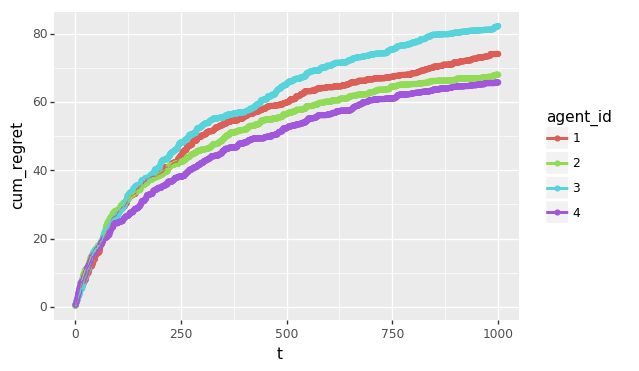

<ggplot: (8731324967485)>


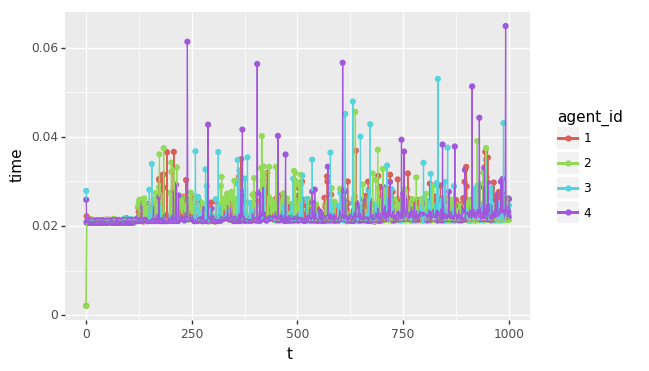

<ggplot: (8731325102157)>


([      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
  0             1        1     0.731889    0.299938        0.299938     1   
  1             2        2     0.731889    0.207181        0.207181     1   
  2             3        3     0.731889    0.574000        0.574000     1   
  3             4        4     0.731889    0.574000        0.574000     1   
  4             5        1     1.346090    0.394221        0.094283     2   
  5             6        2     1.346090    0.613749        0.406568     2   
  6             7        3     1.346090    0.668283        0.094283     2   
  7             8        4     1.346090    0.828199        0.254199     2   
  8             9        1     2.224631    1.259023        0.864801     3   
  9            10        2     2.224631    1.291731        0.677981     3   
  10           11        3     2.224631    1.350631        0.682348     3   
  11           12        4     2.224631    1.063875        0.235676     3   

In [11]:
make_best_sagald_agent = lambda: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
simple_compare([make_best_sagald_agent(), make_best_sagald_agent(),make_best_langevin_agent(),make_best_langevin_agent()], num_articles, dim, var, 1000, 125, verbosity=verbosity)

theta [ 0.16608544  0.78196448  0.85228509 -0.70707096 -0.93165719  0.88666088
 -0.22178966  0.38172358 -0.77257544  0.86298719 -0.28126003 -0.93192543
 -0.49853725  0.76432549  0.19150443 -0.61876383  1.66571909  1.7381882
  1.18222626  1.11937572 -1.86605484]
Experiment: Step 0
 Sample: array([ 1.07893473, -3.21362249,  1.28146241, -1.67518378, -0.86468582,
       -1.04362198,  0.61645443, -0.42633211,  1.69080778, -2.12406055,
        0.69736014,  0.11389041,  0.91456429,  0.56160081, -0.99360047,
        0.13168109, -0.25863237, -1.61088024,  0.37904425, -0.69987809,
        0.7843376 ])
 Steps taken: 0
 Sample: array([ 0.07114627,  0.58324728, -0.71720585, -1.19731682,  0.95891014,
       -0.38692201,  1.24913615,  0.70386132,  0.38177308,  0.27934943,
        0.7788981 , -0.89854898, -0.77757675, -0.54558411,  0.23850425,
        0.3317241 ,  0.41838118, -0.83491749, -2.09711753,  1.24479604,
        1.06689547])
 Steps taken: 0
 Sample: array([-0.39109558, -0.07626717,  1.656028

 Sample: array([-0.59006616,  0.28207518,  0.68419942,  0.75457062, -0.20290609,
        1.22590612,  0.81906672,  0.67471846, -0.24025753,  0.32175549,
        0.9729822 ,  1.20507632, -0.74088275, -0.3490126 ,  1.84454249,
       -0.62940916,  0.78015958,  0.76039524,  1.97047511,  0.79781539,
       -0.19829431])
 Steps taken: 64
Experiment: Step 9
 Sample: array([-0.76466273,  0.37426666,  2.25030544,  0.87939894,  0.03997468,
       -0.03220847, -0.02642124,  0.47901926,  0.22594964, -0.52143765,
       -0.44065202,  1.67802981,  0.26468189,  0.97500836,  0.8510399 ,
        0.88122805,  0.02406741, -0.49187689,  0.44705904, -0.29132256,
       -2.13667653])
 Steps taken: 69
 Sample: array([-0.93709102, -0.8098831 ,  2.24416484, -0.85908386,  1.35536367,
        0.54043141,  0.3020178 ,  0.83610941,  0.53633918, -0.57416884,
        0.92255087, -0.69361199, -0.56900096,  0.41263223, -0.03684164,
       -0.54401551, -0.10992639,  0.74165989,  0.54194472,  0.61595219,
        0.4543

 Sample: array([ 0.20527324,  0.58613046, -0.56964759, -0.99200289,  0.46332356,
        1.28955019, -0.54319403,  1.05547621,  0.29407072,  0.87991404,
        0.46313707,  1.56153594, -0.48406597,  0.44234918, -1.07032643,
        1.70541247,  0.76463066,  1.97728608,  0.08450865,  1.07289097,
       -2.31458487])
 Steps taken: 63
 Sample: array([ 1.58990996,  0.21893491,  1.03621138, -1.52992516, -0.69206539,
        1.60597813, -1.4473038 ,  1.11144943, -0.57723701, -0.80504687,
        1.19213216,  0.53728293,  0.68664578,  0.18562772,  0.23522361,
        0.76513863,  0.01881681,  1.21918959,  1.43309389,  0.31123034,
       -2.51375665])
 Steps taken: 88
 Sample: array([ 0.38070418,  2.07986556, -1.01228646, -1.53826443,  0.24251773,
        1.16618608,  0.72117859, -1.59915364, -0.20022047,  0.36872444,
        1.517675  ,  0.72312155,  0.04631199, -0.63821726,  0.10618253,
        1.44857178,  0.80963042,  0.38528377,  0.55067255,  2.02582054,
       -0.26246343])
 Steps taken

 Sample: array([-0.8346139 , -0.13273468,  1.18810842, -2.16052698,  0.8096852 ,
        1.4923529 ,  0.37726483,  0.73266962, -0.04616123,  0.53458962,
        1.80712886,  1.14346613, -1.13325131,  0.78388391, -0.97965447,
        0.09306762,  0.22517376,  1.85031997,  0.91290657, -0.27182082,
        0.05225635])
 Steps taken: 59
 Sample: array([-0.22757264, -0.71297762, -0.05182313, -1.01111852, -1.35380352,
        1.93961254,  0.23679207,  1.29548188, -0.77413206, -0.91383811,
       -0.68327473, -1.5486166 ,  0.54632347,  0.73487212, -0.20755905,
       -0.22511856,  0.99957855,  1.83147006,  0.15685061, -0.18967275,
       -0.56170225])
 Steps taken: 92
 Sample: array([ 0.33667276,  0.19163594, -0.73576581, -1.09638173,  1.20220204,
       -0.70884708, -0.86075717, -0.18967761,  0.18703362,  0.85553854,
        2.00986036,  0.7635472 ,  0.14768294, -0.19708048,  1.63547555,
       -1.00058337, -0.52868377,  2.27038725, -0.7209449 , -0.30067473,
       -0.97997726])
 Steps taken

 Sample: array([-0.22990858,  2.10373875,  0.19227321, -0.84665363,  1.09282816,
        0.89552436, -0.42120029, -0.20723846, -0.65811467,  0.47689746,
       -0.63233771,  1.08412916, -1.18977215, -0.13654533, -2.54802548,
        1.99138361, -1.14377254,  0.69120975,  0.23264998, -0.81323101,
       -0.08301236])
 Steps taken: 66
 Sample: array([-0.1318947 ,  1.04053037, -0.40900863,  0.99865108, -1.30603711,
       -0.32819506, -2.18367144,  0.79582404,  1.70334278, -0.14370818,
        0.68446744, -0.05136197,  0.39013069, -0.73819203,  0.02922172,
       -0.07146322,  0.12942437, -0.42055401,  1.35778959, -0.33902914,
       -0.85643602])
 Steps taken: 129
 Sample: array([-0.21228153,  0.59450771,  0.47034708, -2.08846989, -0.06101128,
       -0.07844149, -1.02458538, -0.14602858, -0.34687964,  0.23033978,
        0.43441265, -1.39989823, -0.98076432,  0.42515824,  0.43836028,
       -0.90577588,  0.76148436,  2.26067191, -0.13847765,  0.74174242,
       -2.22086014])
 Steps take

 Sample: array([-0.48403963,  1.39313192,  1.3468449 , -0.21443203, -0.26065614,
        1.5995892 ,  0.24905765,  0.73085116, -0.26999447,  0.63163836,
       -0.63677317, -1.09123428, -1.0032714 , -0.1206098 , -1.30361247,
       -0.70985147, -1.6307817 ,  0.13353895,  1.03418847,  0.15837852,
       -1.19403147])
 Steps taken: 39
 Sample: array([ 0.98623186, -0.18621957,  1.21324269, -1.10470884, -0.74222151,
        1.91093843,  0.30910002,  1.53164138,  0.34359992, -2.25560195,
        0.70066088, -0.1112319 ,  0.69645121, -0.08343085, -0.41738308,
        1.10795989, -0.23703433,  1.27971168, -0.13399531,  0.39095428,
       -0.88146272])
 Steps taken: 91
 Sample: array([ 0.01096659, -0.26326995, -0.25021775, -1.44306431, -0.74476122,
        1.704981  , -0.20338493, -0.09837441,  0.20429881, -1.36548286,
        0.5883377 , -1.57438711, -1.16541873,  1.21199458, -0.23844019,
       -1.81956828,  2.14629026,  2.52138315,  0.81504258,  0.75166754,
       -0.79275236])
 Steps taken

 Sample: array([-0.09818556,  1.08658134,  1.03660232, -2.11028162, -1.02320505,
        0.57139557, -1.40383035, -0.05040127,  0.76865843, -0.05739393,
        0.09878162,  0.59529066, -0.57859333,  1.05390005, -0.54566119,
       -0.13966945,  0.91550847,  0.55912507,  0.89043785, -1.29029173,
       -1.10141674])
 Steps taken: 39
 Sample: array([-0.29543627,  1.57243259, -1.17020589, -0.05542092, -1.02320453,
        1.35356383, -0.88620803,  3.12074304,  1.00747539, -1.2841159 ,
       -1.16143717, -0.65437246,  0.76929148, -1.07282218, -0.33129899,
       -0.68461169,  0.48846793,  2.12982554,  1.46087015, -0.54335142,
       -1.50630454])
 Steps taken: 84
 Sample: array([-0.23751753,  0.85589381, -0.04139345,  1.33577327, -0.73966412,
        0.2065793 , -1.24947551, -0.85249634, -1.5732408 ,  0.68415311,
        1.09620402, -0.60508776, -1.43962307, -0.34675475,  0.83841802,
       -1.86269215,  2.61277223,  2.86616559,  1.75840808, -0.62133388,
       -1.80594414])
 Steps taken

 Sample: array([-0.82669071,  2.03865921,  1.41593987, -1.66758658,  0.02181766,
        0.51102831,  0.13872716,  1.73598577,  0.03431819, -0.21525875,
       -0.02677821,  0.47280498, -0.61629127,  0.97300359, -1.19089809,
       -1.56979555,  0.86566495,  1.21698626, -0.2635514 , -1.10500351,
       -1.32381385])
 Steps taken: 54
 Sample: array([-0.36031244,  1.25703649,  0.12708008, -0.09471405, -0.10990995,
       -0.41266751, -2.80636613,  1.63811267,  0.39996325, -0.47096506,
        0.40224356,  0.49298565,  0.5523766 ,  0.45528522,  0.65529911,
       -0.31867271,  0.89488918,  2.29400947,  0.00578515,  0.47116918,
       -1.252596  ])
 Steps taken: 81
 Sample: array([-0.20168465,  0.53989933,  1.42258492, -0.33227058, -0.88457232,
       -0.39465018, -0.02177964, -0.33395563, -0.13653294,  1.56509946,
        0.59444728, -2.01067013, -1.28818066, -1.46223958,  0.08862741,
       -1.61736365,  2.14058776,  0.57312429,  0.33232733,  0.66479679,
       -1.63171834])
 Steps taken

 Sample: array([ 3.96832586e-01,  1.34138097e+00,  1.60619837e-01, -5.93028022e-01,
       -1.39906113e+00,  3.65915434e-01, -4.02819366e-01,  1.24196214e+00,
        1.98922184e-01,  1.32778933e+00,  1.88610643e-01, -1.81381704e+00,
        2.63490347e-01, -4.91332043e-01, -1.08763365e+00, -1.22510608e+00,
       -1.98187572e-05,  1.74635757e+00,  7.18988272e-01,  7.12693789e-01,
       -1.56585661e+00])
 Steps taken: 111
 Sample: array([ 0.93366415, -0.62882145,  1.04471676, -0.88363672, -0.60397243,
        0.73441806, -0.02235296,  0.81051769,  1.05010452,  1.30338792,
        0.86063959, -0.65528994,  0.02493192, -0.42324013,  0.18450834,
       -1.34279498,  0.54796145,  1.8562533 ,  0.71213027,  0.95072584,
       -1.37742596])
 Steps taken: 89
Experiment: Step 71
 Sample: array([ 0.64029497,  1.83216312,  2.18154892,  0.11888795,  0.63977835,
        1.16483995,  0.83041516,  0.08662397,  0.7702338 ,  0.92504644,
       -0.08373205, -0.31824955,  0.12577982,  1.29289011,  0.642

 Sample: array([ 0.76174676,  0.79384434,  0.34865168,  0.61756157, -1.48907006,
        1.93635888, -0.54442053, -0.81669827, -1.24008765,  0.64542042,
        1.35512283, -0.34027419, -0.21492488,  0.29053761, -1.17639002,
       -0.02089078,  0.57072062,  0.35426601,  0.01673363,  1.14430312,
       -0.83782675])
 Steps taken: 101
 Sample: array([-0.29406812, -0.58835524,  1.05215176, -0.34668642, -1.05540081,
        0.46619266, -1.63020374,  0.91559915, -0.19903407,  0.09477245,
        1.71987608, -1.83720241, -0.87099877, -0.81449034,  2.00655049,
       -1.61892843,  2.16338679,  2.40272432,  0.96633102,  0.48628233,
       -1.15508895])
 Steps taken: 112
Experiment: Step 80
 Sample: array([ 0.04967915,  0.29758832,  1.96484514, -0.62824422, -0.84647442,
       -0.12810106, -1.06473236,  0.21965177, -0.27136045,  0.32945858,
        0.03118805,  1.51074181, -1.36194164,  0.29950365,  0.05016424,
       -0.59572521,  1.05332853,  2.27732866, -0.55551304,  0.550112  ,
       -0.8

 Sample: array([ 0.08381214,  0.95872584,  1.34883484,  0.21573721, -1.40771473,
        0.91549136, -0.81579279,  1.10139437,  0.18857591, -1.60571254,
       -0.25763843, -1.77520666, -0.41606101,  1.22153627, -0.38128595,
       -0.09487476,  1.51248279,  2.16953809,  0.79062882, -0.40212121,
       -1.14158594])
 Steps taken: 53
 Sample: array([ 0.06287273,  0.67548432,  2.81103857, -0.60776062, -0.97421279,
       -0.01098856, -0.19033887,  0.87775572, -0.44848459,  0.63614928,
        1.35600407, -1.24280895, -0.77983686, -0.24910124, -0.32398374,
       -1.57269068,  1.89451977,  1.33135541,  0.36749828,  1.00274142,
       -0.05323796])
 Steps taken: 73
Experiment: Step 89
 Sample: array([ 0.22447873,  0.17557776,  2.54630806,  0.02295136,  1.26325197,
        0.86159954,  0.70660012, -0.1240935 ,  1.43729547,  0.03718593,
        0.07206872,  0.15040626, -0.45816288, -0.44649399,  1.84876806,
        0.05936553,  1.46477892,  1.04301155, -0.26090945,  0.37592971,
       -0.899

 Sample: array([ 0.16818174, -0.2977444 ,  1.52691673,  1.17737895, -0.08556718,
       -0.7276372 , -0.31204269,  0.92344694,  0.59606849,  0.75602801,
        0.33669184, -1.58661903, -0.42075698, -0.19448046,  0.46282103,
       -1.42620074,  0.91594249,  0.59234006,  1.16001314,  0.1428561 ,
       -0.48476496])
 Steps taken: 64
Experiment: Step 98
 Sample: array([ 0.15352379,  0.5745904 ,  2.14728591, -0.14986897, -0.5443887 ,
        1.43245267,  0.25522666,  0.81087863,  0.36356623,  1.17358078,
       -0.79137259,  0.25498084, -0.17872764,  0.40505879,  0.99139873,
       -0.63093037,  1.2349664 ,  1.09460737, -0.33749803,  0.41066431,
        0.16612281])
 Steps taken: 53
 Sample: array([-0.41816193,  0.81288267,  1.88383837, -2.46052697, -1.82453866,
        1.62714175, -0.54764944, -0.59429832,  0.54805065,  0.37507481,
       -0.06789285,  0.52607133, -0.85460712, -0.63507398, -0.77041146,
       -1.59860809, -0.27061388,  0.56014083,  0.64684876,  0.97075665,
       -2.736

 Steps taken: 66
Experiment: Step 107
 Sample: array([ 0.05672046,  1.47959738,  1.47519966, -0.81648578, -0.73016291,
        0.60303368, -1.22164605,  1.32310204, -0.01169584,  0.95818049,
       -0.37339377,  0.18125292, -1.23580136,  1.10893288,  0.06641927,
       -0.67389762,  1.65967489,  1.68059919, -0.02055361,  0.20887734,
       -1.46938026])
 Steps taken: 53
 Sample: array([-0.74736615,  0.1668871 ,  1.40594672, -1.85739481, -2.17221189,
        1.03434134, -0.72453702,  0.57023871,  1.02869928,  1.11006361,
       -0.46429857, -0.41995303, -0.60444922, -0.8720066 , -0.69963813,
       -1.41305822,  0.26623276,  0.01523365,  1.14271502,  0.07418522,
       -0.82859251])
 Steps taken: 52
 Sample: array([ 0.37831194,  1.09530282,  0.89975717,  0.40160313, -1.9048074 ,
        0.32824004, -0.69325687,  1.08837023,  0.15245539, -0.21244611,
        1.26185983, -0.75950459,  0.5250427 ,  0.2230465 , -1.55580049,
        0.12942327,  0.75837516,  1.73130317,  0.11506036,  0.12603

 Sample: array([ 0.50122689,  1.69097328,  0.18867161, -0.38767873, -0.92514804,
        0.80056152,  0.1070704 ,  1.57393324,  0.60566928,  1.27040452,
       -0.91119627, -0.17512787,  0.15779305,  0.78135319,  1.87794315,
        0.79519627,  1.24398665,  1.18999057, -0.06870192,  0.06065413,
       -0.59166497])
 Steps taken: 44
 Sample: array([-0.08005235,  1.35323555,  2.05277907, -1.35243226, -2.81471235,
        0.5634286 , -1.91540629,  0.7133002 ,  1.31352786,  0.59282233,
       -0.3242858 , -0.26161256, -0.42974785,  0.19863692, -1.37177479,
       -0.80504936, -0.30435408, -0.14889748,  0.75994559,  0.50148801,
       -2.16891757])
 Steps taken: 49
 Sample: array([ 0.34840055,  1.01787206,  0.68454541, -0.99682664, -0.90511846,
        1.03951799, -0.28327699,  0.69670805, -0.88427518, -0.74751315,
        0.29653037, -0.87112078,  0.69158294,  0.6306524 , -1.54713068,
       -0.84661457,  0.45398712,  1.76232269,  0.50663779,  0.66788985,
       -0.37347251])
 Steps taken

 Sample: array([ 0.5478505 ,  0.85948748,  0.66508657, -1.49725163, -0.74339539,
        1.40211565, -0.21776445,  0.62316642,  0.17259122,  1.26086379,
       -0.31373971, -0.69314495, -1.36805537,  0.60510651,  0.28226049,
       -0.2553249 ,  0.56840703,  0.86487058, -0.19838544, -0.01164372,
       -0.52768932])
 Steps taken: 22
 Sample: array([-0.44579893,  0.8529029 ,  0.33307258, -0.57427011, -1.13214805,
        2.42563915, -0.50143813,  0.98371281,  1.46692017,  0.63649033,
       -0.34802024, -0.4529374 , -0.05079787,  1.52070352, -1.44932663,
       -0.97292903, -0.05789919,  0.96125179,  0.40777607,  0.38677404,
       -3.24403456])
 Steps taken: 50
 Sample: array([ 0.61584986,  1.05257914, -0.01180729,  0.518541  , -2.06907079,
        0.30467502,  0.16580783,  0.38591561, -0.45680226,  1.70782024,
        1.18749104, -0.07360724, -0.22192454,  0.28726764, -1.49004754,
       -0.2973472 ,  1.19299763,  0.49087099,  0.52669288,  2.42338256,
       -2.0605591 ])
 Steps taken

 Sample: array([ 0.48829675,  1.58092037, -0.10007163, -0.80669076, -1.16244935,
        1.01566036, -1.28909162,  1.51138237, -0.63550367,  0.79116399,
       -0.07133304, -0.27575423,  0.57318834, -1.42969381, -0.57978492,
        0.81150774,  1.27244048,  0.64849603,  0.32893184,  0.94399782,
       -1.70472943])
 Steps taken: 25
 Sample: array([-0.22362935, -0.01587769,  0.82653144, -1.05065618, -1.45160089,
        2.9902764 ,  0.17535121,  1.26582731, -0.56217667,  0.58798068,
       -0.60894221, -0.58248255, -0.95120604, -1.13492332,  0.09138819,
       -1.65641922,  1.4256214 ,  1.22156277,  0.8912725 ,  1.76808562,
       -3.13421903])
 Steps taken: 27
Experiment: Step 130
 Sample: array([ 0.16173721,  1.14200168,  0.59519316, -0.45612663, -1.39354834,
        0.41305476, -0.86588887,  0.31948528, -0.98927147,  0.5958778 ,
       -0.66374615, -0.2402841 , -0.90282838,  1.22142542,  0.21960653,
       -0.77483931,  0.74190783,  1.57843361,  0.16232733,  0.4708888 ,
       -0.26

 Sample: array([ 0.30046917,  0.1161896 , -0.29085445,  0.34339278, -1.6794128 ,
        0.89468874, -0.2687533 , -0.142259  ,  0.71736861, -0.43314367,
        0.70777102, -0.17197238,  0.89688393, -0.07360844, -0.77407026,
        0.03866971,  1.39907946,  1.74613773,  0.69460732,  1.53194469,
       -0.2075861 ])
 Steps taken: 23
 Sample: array([ 0.58508382, -0.78652183,  0.87294979, -0.22625035, -1.23904945,
        1.16258729,  0.14831604,  0.80848491,  0.60341352,  1.52792191,
        0.18329586, -1.92559673,  0.55309556, -0.45286422,  0.12974059,
       -1.7094388 ,  1.63596904,  2.30791986, -0.20750463,  0.66008794,
       -2.33723937])
 Steps taken: 26
Experiment: Step 137
 Sample: array([-0.24907399,  0.51192675,  0.9315235 ,  0.20527214, -0.53935559,
        0.18279863, -0.04036263, -0.4192827 , -0.18271342, -0.64513596,
       -1.20050811,  0.61643256, -0.16083651,  0.17864422,  1.03276429,
       -1.04176389,  1.79089645,  1.61063251,  0.49918709,  1.10740039,
       -1.45

 Sample: array([-0.11128748,  0.48810103,  1.28031854, -0.45017258, -1.10179271,
        0.21880794, -1.91207024,  0.99353781,  0.66970053,  0.65000831,
        0.44460366, -0.64018299, -2.64148477,  0.28819267,  0.68958211,
       -0.51721029,  1.7989237 ,  2.44783647,  0.55913084,  0.64987389,
       -3.28834435])
 Steps taken: 23
Experiment: Step 144
 Sample: array([-0.11427356,  0.40675177,  0.77142742,  0.42353517, -1.08061244,
        1.07518423,  1.15341301,  0.647403  ,  0.00836403,  0.91491243,
       -1.06472211, -0.36506904, -0.82448607,  0.707355  ,  0.71794879,
       -0.71634669,  1.04269562,  0.88934916,  1.03804718,  1.20120172,
       -1.95633819])
 Steps taken: 53
 Sample: array([-0.16770928,  0.23298514,  1.37119463, -1.83343881, -1.3099744 ,
        1.99792874, -0.46523464,  1.21254511, -0.7814909 ,  0.46892896,
        0.17432114, -0.10253996, -0.15469729,  0.35287797,  0.19700826,
       -1.10768688,  0.81840007,  2.38949976, -0.08472525,  1.02449632,
       -0.94

 Sample: array([ 0.6162017 ,  1.2261807 , -0.19538312, -0.3672222 , -2.24594565,
        0.45378534,  0.70285059,  0.501847  , -0.05189205,  1.09763822,
       -0.20192005, -0.38808379,  0.33135038, -0.09662561, -1.7434416 ,
        0.69025657,  1.09084592,  1.3028823 ,  0.48299104,  0.51197639,
       -0.62819165])
 Steps taken: 47
 Sample: array([-0.31786467, -0.12343927,  2.07735797, -0.5273035 , -1.24875448,
        1.00043373, -0.26672927,  0.39532856, -0.16681918,  1.67614748,
        0.27306193, -0.28208287, -0.16166481, -0.15945765,  0.58791418,
       -1.1855048 ,  1.38089662,  1.69045173,  0.85241136,  0.49310791,
       -1.80354547])
 Steps taken: 55
Experiment: Step 152
 Sample: array([ 0.26389517,  1.16000121,  1.60480472,  0.10940252, -0.23945666,
        0.1667741 ,  1.26244269,  0.79322962, -0.42490956,  0.73506207,
       -2.50137627,  0.53408691,  0.5204226 ,  0.72392199,  1.12029032,
       -0.55220743,  0.9083091 ,  0.27776783,  0.6185509 ,  0.94000371,
       -1.21

 Steps taken: 25
Experiment: Step 158
 Sample: array([ 0.1761655 ,  0.97265878,  1.52601479,  0.71283543, -0.32793907,
        0.64000893,  0.33388748,  0.87851842, -0.26464166,  1.79635344,
       -0.58737381, -0.93480814, -1.09561333,  0.43946627,  0.20067595,
       -0.42177696,  2.30975308,  0.44771014,  0.41042051, -0.31123435,
       -1.86948992])
 Steps taken: 53
 Sample: array([-2.00010378e-01,  2.67409008e-01,  1.29399033e+00, -1.39337488e+00,
       -1.36283455e+00,  2.03347438e+00,  7.23063122e-04,  6.59332098e-01,
        6.95867062e-01, -7.52305837e-01,  1.39000946e-03, -4.56915084e-01,
       -1.06816685e+00, -7.89769906e-01, -5.92812733e-02, -2.22995931e+00,
        6.93738267e-01,  1.21694073e+00,  3.16699783e-01,  1.45172467e+00,
       -1.66628538e+00])
 Steps taken: 52
 Sample: array([ 0.02867702,  0.93094481, -0.3006302 ,  0.32772198, -2.17186065,
        1.57664272, -1.38833043,  0.53787867,  0.5257374 ,  0.63344122,
        1.62947436, -0.92058205, -0.16917843, -0

 Sample: array([-0.03946049,  0.99784093,  0.7897899 , -1.10882059, -1.30449875,
        0.63386553, -1.30017856,  1.44032385,  0.73640357,  0.9808824 ,
       -1.18699923, -1.08712527, -1.26922115, -0.56934502,  1.27932747,
       -1.38975095,  1.88730701,  1.71747672,  0.45614911, -0.78686811,
       -2.68771358])
 Steps taken: 17
Experiment: Step 165
 Sample: array([-0.39877714,  1.31248268,  1.96117245, -0.95326833, -0.06356762,
        1.15747182, -0.59130821, -0.45485459,  0.48558359,  0.69406584,
       -1.17909767,  0.28423715, -0.45070203,  0.91214599,  0.57131978,
       -0.07976443,  2.10125664,  1.01529751,  1.24940373,  1.35747875,
       -1.37555855])
 Steps taken: 52
 Sample: array([-0.20870566,  0.19698742,  1.05370168, -1.73899036, -1.78343622,
        1.27420263,  0.06517229,  0.94706998,  0.3467824 ,  1.23520169,
        0.7449849 , -1.24569609,  0.00291681,  0.47766881,  0.2273178 ,
       -1.79996019,  0.15510858,  2.02661606,  0.8970716 ,  0.83470944,
       -0.72

 Sample: array([ 0.24403951,  1.25811126,  0.68359431, -0.06055253, -2.33549406,
        1.09348434, -0.73406851, -0.044951  , -0.35922504,  1.59887563,
        0.92880428, -1.41116188,  0.22054558,  0.75903444, -0.78156518,
        0.10795587,  1.11404724,  2.06612399,  1.17646918,  1.44521086,
       -0.33783191])
 Steps taken: 21
 Sample: array([ 2.58346629e-01,  5.12713951e-01,  1.38311754e+00,  1.05806983e-01,
       -9.94115933e-01,  9.83680788e-01,  3.25496843e-01,  3.21770429e-01,
       -7.37043398e-04, -7.60852195e-02,  3.18508569e-02, -3.53537112e-01,
       -5.30100478e-01,  3.46353079e-01, -7.26863872e-01, -1.75660703e-01,
        9.51765489e-01,  2.28902981e+00,  7.31069486e-01,  1.37267910e+00,
       -1.05867939e+00])
 Steps taken: 24
Experiment: Step 172
 Sample: array([-0.22857197, -0.29258503,  1.2075862 , -0.48544849, -1.56526361,
        0.25907838,  0.22491434,  0.04882829,  0.49596286,  1.57816284,
       -1.2553805 , -0.34965307, -0.81161754,  0.65067023,  0.581

 Sample: array([ 0.08848119,  0.26939047,  0.76557002, -1.79166319, -2.96643224,
        0.60352263, -0.60560008,  0.331223  ,  0.72510361,  0.44684797,
        0.04076167,  0.11305168, -0.84693847,  0.4824407 ,  0.34380371,
       -1.0268207 ,  0.47337889,  0.63423492,  0.72491556,  0.81799112,
       -0.45420597])
 Steps taken: 24
 Sample: array([-0.02405334,  1.92508396,  0.84881119,  0.22719219, -2.11275311,
        0.96368877, -0.57685932,  0.95279947, -0.3084112 ,  0.90005048,
       -0.70591152, -0.78628217,  0.11037067,  0.33358138, -0.47090433,
       -0.82529007,  1.22102232,  1.92589895,  0.05261525,  1.95757395,
       -1.0125877 ])
 Steps taken: 23
 Sample: array([ 0.07613488,  0.6826362 ,  0.73984828, -0.54980248, -0.84940031,
        0.93168043, -2.07102257,  1.25085341,  0.28332636,  1.06436422,
       -0.41627314, -1.43287613, -0.48400616, -0.11191504,  0.60685188,
       -0.24536963,  2.54131748,  3.21101816,  0.86175309,  0.5019226 ,
       -1.85254813])
 Steps taken

       -1.16678111])
 Steps taken: 50
 Sample: array([ 0.21868095,  0.84486818,  0.44421054, -0.19202709, -0.85915761,
        1.69642742, -0.54951236,  0.46158958, -0.6121399 ,  1.2966778 ,
        0.45329336, -0.70754524, -0.4711609 ,  0.10050243,  0.93508637,
       -0.96036524,  1.68103745,  2.68295366,  0.834038  ,  0.28794827,
       -1.84533955])
 Steps taken: 50
Experiment: Step 185
 Sample: array([ 0.20434413,  0.97869801,  2.10828191, -1.13920191,  0.09658855,
        0.40429774,  0.16490377,  0.20200678, -0.43930406,  0.90822729,
       -0.19067454, -0.21832222, -0.19492414,  0.33486228,  0.6432505 ,
       -0.10695234,  2.04631627,  1.16665287,  0.13825425,  0.52521216,
       -0.93867929])
 Steps taken: 51
 Sample: array([-0.36473439,  0.17307111,  0.32813324, -1.39229793, -0.8738094 ,
        1.50129241, -0.32143265,  0.86289979, -0.03694749,  0.07824511,
       -0.51895636,  0.27483386, -0.013825  ,  0.09513396, -0.32480834,
       -1.85009894,  0.57878885,  1.10852166, 

 Sample: array([-0.35194457,  0.7378956 ,  1.07841709, -2.48457908, -1.7089203 ,
        0.54427365,  0.41329153,  0.28840632, -0.04990827,  1.35383614,
        0.23001319, -0.6783384 ,  0.26876974, -0.73982513, -0.26971456,
       -1.88645593,  1.84995235,  1.38167795, -0.33246187,  1.49041284,
       -2.27952417])
 Steps taken: 44
 Sample: array([ 0.54095143,  0.75242291,  0.60857793,  0.22301229, -1.25082609,
        0.50663119, -1.18398337,  1.36066455, -0.02522382,  1.34959394,
        1.35176922, -0.60062888,  0.04647788,  0.80639744,  0.22533345,
       -0.76888924,  1.29525527,  2.64746617,  0.14742155,  1.44552707,
        0.23607524])
 Steps taken: 23
 Sample: array([ 0.34794729,  1.85445342,  1.24634562, -1.4961738 , -1.88064427,
        0.01412587, -0.34198364,  0.99977455, -1.2245895 ,  1.25449213,
        0.02653853, -1.1881922 , -0.5614113 , -0.37590932,  0.7880427 ,
       -1.62086482,  1.12096702,  1.34987456,  1.27207252,  1.38177399,
       -1.42524085])
 Steps taken

 Sample: array([-0.15352938,  0.22988673,  0.03530001,  0.28680603, -1.57967708,
        0.46532888, -0.84858914,  0.53156625, -0.1029519 ,  0.05852917,
       -0.88724172, -0.32859302,  0.382902  ,  0.86339737, -0.29527988,
        0.56250747,  0.95956462,  1.9792205 ,  0.72341144,  1.35727745,
       -1.33496995])
 Steps taken: 16
 Sample: array([-0.16193086, -0.57997215,  1.82911478, -0.76235984, -1.42634194,
        2.11159841, -0.60697219,  0.9322071 ,  0.01285433,  1.79028723,
       -0.21110255, -1.2316507 , -1.89635846,  0.47107829,  0.33351796,
       -0.38937823,  1.84004888,  1.45693287,  2.07562738,  2.00155414,
       -1.26342241])
 Steps taken: 23
Experiment: Step 200
 Sample: array([ 0.23548053,  0.18697093,  1.91788269, -0.53597587, -0.84517329,
        0.55182297,  0.28367216,  0.26581497,  0.47829444,  0.30033061,
       -1.68756011,  0.61077119, -0.35732257,  0.17353919,  0.93761909,
       -0.68116794,  0.41492525,  1.23503821,  1.44266226,  1.30809774,
       -0.59

       -0.27712152])
 Steps taken: 52
 Sample: array([-0.2812928 ,  1.65659671,  0.56380903, -0.14955761, -1.30446103,
        2.2236035 , -0.37480235, -0.37322846, -0.13324213,  0.33620099,
       -0.36324414, -0.7074344 ,  0.0342621 ,  0.09427269, -0.76468092,
       -2.38090733,  1.36245627,  2.48729037,  0.92538962,  1.7347753 ,
       -2.22761647])
 Steps taken: 51
 Sample: array([-0.1185276 ,  0.92200364,  0.77556211,  0.38190073, -2.29717811,
        0.9067003 , -0.68317783,  0.58448102, -0.02693835,  0.82887095,
        0.22035591, -0.38621567,  0.20314613,  0.42163042, -0.0867556 ,
        0.03560142,  1.48741933,  1.96102829,  0.89839201,  1.39472551,
       -1.7298077 ])
 Steps taken: 38
 Sample: array([ 0.78649506,  0.21961363, -0.45862279, -0.73533929, -1.25125473,
        0.97764125,  0.15297187,  0.75549563, -0.23482496,  0.32570609,
        0.05459551, -1.15335311, -0.15292628,  0.00666199,  0.28353525,
        0.14671781,  1.066842  ,  1.94962724,  0.83638481,  1.70486

 Sample: array([-0.2011666 ,  1.13223812,  1.25360556, -2.27324669, -1.67644176,
        2.00679215, -0.71013962,  0.35390541,  0.08135662,  0.46225099,
       -0.87466763, -0.37448729,  0.9326514 , -0.50104731, -0.18704568,
       -2.63499705,  2.07862503,  1.2237289 ,  1.12338061,  1.10858938,
       -0.49743083])
 Steps taken: 24
 Sample: array([-0.14253817,  0.75725593,  0.17476403, -0.39481073, -1.84629999,
        0.71697479, -0.47949974,  0.96911346, -0.39081842,  0.666235  ,
        0.57772434, -0.83674754, -0.11046895,  1.09379594, -0.48325311,
       -0.27650823,  1.86000152,  2.03228352,  0.5631227 ,  1.09589809,
       -1.34690913])
 Steps taken: 1
 Sample: array([-0.40364584,  0.76802898,  0.14874231, -1.01832617, -2.27716046,
        0.85723261, -0.55954071,  1.30997805, -1.35530921,  0.43827789,
        0.14018315, -0.62337039, -0.57063105,  0.46326055,  1.09671751,
       -0.42098064,  1.8895473 ,  2.59341036,  0.01413762,  1.63679392,
       -2.20529703])
 Steps taken:

 Sample: array([ 0.09589018,  0.61602885,  1.45070794,  0.06113205, -2.55018427,
        1.03757317, -0.09476855,  0.87223252, -0.44412486,  1.1123796 ,
        0.17984911, -0.42335722,  0.04347068,  0.87805378,  0.94683637,
       -0.97958859,  1.23046772,  2.92143572,  0.67111079,  0.13586169,
       -1.88454128])
 Steps taken: 27
Experiment: Step 223
 Sample: array([ 0.05047029,  0.67537282,  1.35565545, -0.41362411, -1.27916424,
        0.29683216, -0.74328537,  0.48535875, -0.66200618,  1.00709288,
       -0.21472155, -0.1260188 , -1.23127608,  0.59424241,  0.63187694,
        0.05431641,  1.43420164,  1.28730452,  0.62429133,  0.9731556 ,
       -0.24091562])
 Steps taken: 52
 Sample: array([ 0.06677519, -0.35484457,  0.45572388, -1.23973527, -3.40359366,
        0.90471615, -0.45372631,  0.582711  ,  0.94815682,  0.61862035,
       -0.7371329 , -0.90714867, -0.43477037, -1.11091362, -0.18047284,
       -1.02017411,  1.08428172,  1.58169779,  2.17246295,  1.04735636,
       -1.17

       -0.61169992])
 Steps taken: 53
 Sample: array([ 0.30259375,  0.66486207,  0.95733873, -1.27514342, -1.62178946,
        1.17645371,  1.05431739, -0.78462415,  0.10888231,  0.66557426,
       -0.56423421,  0.02851258,  0.32291387,  0.00582088,  0.51365982,
       -2.24000782,  0.80429911,  0.90020057, -0.29017303,  0.61440449,
       -0.67679456])
 Steps taken: 51
 Sample: array([ 0.21149401,  1.33915638,  0.16395993, -0.82046115, -2.52219574,
        0.27246035, -1.04350835,  1.21906945,  0.41798043,  0.74331506,
        0.6016842 , -0.20099459, -0.24499498,  1.0741442 , -0.06930506,
       -0.06594716,  3.16237076,  1.75761078,  0.51666993,  2.04789676,
       -0.61448185])
 Steps taken: 21
 Sample: array([ 0.0841883 , -0.79311681,  1.12134072, -0.03820302, -1.39763372,
        1.10005041, -0.88171023,  1.5082163 , -0.09256651,  2.25655409,
        0.20373327, -0.54637207,  0.05654933, -0.0514179 , -0.30092635,
       -1.30529422,  1.1959459 ,  2.59712593,  0.6669865 ,  1.37136

 Sample: array([-0.0786601 ,  0.36437819,  1.97100919, -0.96417907, -1.39610594,
        1.38660431,  0.31016869, -0.11108708, -0.06418556, -0.3163575 ,
       -0.58961067,  0.0266439 , -0.60228933,  0.44154461,  1.1556736 ,
        0.14628277,  1.43084915,  1.04975785,  0.68535297,  1.11872729,
       -1.99525695])
 Steps taken: 50
 Sample: array([-0.05709925,  0.0502378 ,  1.78295298, -1.70416241, -1.17421786,
        1.94340372, -0.53670866,  0.82076494,  0.15795962,  0.96730654,
        0.13272262,  0.37823579, -0.31285631, -0.54116518, -0.28535591,
       -2.45441999,  0.77402283,  0.81691671,  1.25320745,  0.6576843 ,
       -0.76749434])
 Steps taken: 49
 Sample: array([-0.06023574,  0.44906243,  0.30584962, -0.6884174 , -1.1264632 ,
        0.98286882, -0.47077456,  1.13778952, -1.06819265,  0.98378874,
        0.24166047, -0.1186302 , -0.52995149,  0.2476453 , -0.92936112,
        0.3023562 ,  1.3979196 ,  1.60977576,  0.82176879,  1.50511212,
       -1.69532826])
 Steps taken

 Sample: array([ 0.22729707,  1.13489995,  1.80586589, -1.10044038, -1.57438187,
        1.61316342, -0.27842966, -0.20769393, -0.27823219,  0.98161386,
       -0.38647672, -1.21958534, -0.56026293,  0.05804584,  0.37515774,
       -0.99905767,  0.99999899,  1.62806403,  0.83466807,  1.09889697,
       -1.9414277 ])
 Steps taken: 24
 Sample: array([-0.16065467,  2.1043064 ,  1.29584915,  0.34528029, -1.69941741,
        1.07036334, -0.63249387,  1.60837485,  0.06171103,  1.26324363,
        0.03622145, -0.25592096, -0.6187062 ,  0.25608907,  0.21915986,
        1.17959671,  2.06566674,  2.07482095,  0.99538078,  1.27619162,
       -1.00387272])
 Steps taken: 21
 Sample: array([ 0.03659935, -0.34961718,  1.71863094, -1.01139082, -1.69281851,
        2.27471035,  0.18159997,  0.37755486, -1.0293239 ,  0.71929817,
        0.18411205, -0.29758216,  0.21253536,  0.77869211,  0.94772051,
       -1.06278935,  1.29845597,  1.98873233, -0.41076118,  1.40336801,
       -2.2208704 ])
 Steps taken

 Sample: array([-0.48657568,  0.85657491,  1.05260086, -1.73011542, -1.20283198,
        1.3297531 , -0.39230186,  0.47442435,  0.00773233,  1.4929828 ,
       -0.71974646, -0.91081022, -0.41061331, -0.15187964,  0.57058025,
       -1.89456399,  1.50850028,  0.79662822,  1.29652952,  1.343683  ,
       -0.58153531])
 Steps taken: 35
 Sample: array([ 0.1860557 ,  0.51333348,  0.9652737 , -0.1112473 , -1.31119919,
        0.83399338, -0.63270006,  0.8597214 , -0.43985232,  1.10503971,
        0.05318139, -1.22683061, -0.49502197,  1.03885343, -0.53262913,
        0.33294177,  2.15800295,  2.19906208,  1.45357877,  0.33278127,
       -2.36615514])
 Steps taken: 40
 Sample: array([-0.52301867,  0.9258589 ,  1.13993203, -1.09762274, -2.01059318,
        1.58972256, -1.28757794,  0.52541241, -0.43130887,  1.75150526,
        0.05317609, -0.50572529, -1.00489266,  0.1508018 ,  1.0098864 ,
       -0.69152294,  0.85622252,  3.21946731,  1.88331158,  1.62289736,
       -2.1275741 ])
 Steps taken

 Sample: array([ 0.12442373,  0.73160459,  1.92650514, -1.12537802, -1.59205874,
        1.42164891, -0.21033567, -0.23347271, -0.69063136,  1.45082517,
       -0.90542237,  0.07245953, -0.65625781, -0.32596548,  0.94987278,
       -0.56165104,  1.03946958,  1.7093182 ,  1.74250909,  0.6660574 ,
       -1.76413753])
 Steps taken: 35
 Sample: array([ 0.32259153,  0.2046915 ,  0.46271762, -1.44893092, -1.41149058,
        1.92296449, -0.28141058,  0.56951843, -0.82584566,  0.63922288,
        0.33621329, -0.8883706 , -0.77841942,  0.38989089,  0.05829778,
       -1.97915258,  1.01412598,  1.10064262,  1.1525604 ,  1.64588092,
       -1.34057753])
 Steps taken: 49
 Sample: array([-0.02425464,  1.07758041,  0.31671479, -0.60201789, -0.80570019,
        1.06919885, -0.22399861, -0.10266417,  0.30898683,  1.26805879,
        0.3230076 , -0.82909067, -0.44772031,  1.03301566, -1.40473641,
       -1.05086579,  1.99582524,  2.21542339,  0.91022927,  1.63729744,
       -1.65124621])
 Steps taken

 Sample: array([ 0.38595349, -0.00301604,  1.13515861, -0.70548953, -1.12130506,
        2.36691308, -1.06366735, -0.36409228,  0.31197066,  0.58684835,
        0.63002556, -0.8533195 ,  0.25561211, -0.53390733, -0.22159485,
       -2.2094825 ,  1.14190645,  1.10438966,  0.93016381,  0.77932574,
       -0.756181  ])
 Steps taken: 33
 Sample: array([-0.44928771,  1.22659448,  0.97958386,  0.30602318, -0.98366255,
        1.14427898, -0.99061403,  0.33732137, -0.06069807,  1.07402249,
        0.3015963 , -1.4773079 , -0.01236736,  1.31686501, -1.30612375,
       -1.24867367,  1.83101842,  2.51831256,  0.30950015,  1.1407824 ,
       -0.9184594 ])
 Steps taken: 19
 Sample: array([-0.11130541,  0.82045906,  1.61781107, -1.16776077, -1.79099865,
        1.91392405, -0.48599114,  1.31018398, -0.99032974,  1.97037164,
       -0.15511569, -1.10204251, -0.89303816,  0.15436349,  1.16098875,
       -0.76520814,  0.86972338,  1.79698707,  1.19957397,  1.13761673,
       -1.7413152 ])
 Steps taken

 Sample: array([ 0.07140532, -0.38442856,  1.67290812, -0.80678854, -1.89621491,
        1.12431328,  0.12063447,  0.58073628, -0.0442298 ,  0.67972433,
        0.23813114,  0.19027967, -0.64394057,  0.25172374,  0.58465244,
       -0.86481374,  0.88843435,  0.29907705,  1.61844899,  1.36782922,
       -1.17059169])
 Steps taken: 50
 Sample: array([-0.10002634,  0.62760741,  1.421293  , -0.87449489, -1.06937965,
        2.43881869, -0.61275933,  0.08570929,  0.03113699,  1.28005574,
       -1.31515985,  0.26181512, -0.23018486,  0.04472492, -0.17393007,
       -1.73043029,  1.09020403,  1.66021077,  2.3834876 ,  0.91258178,
       -1.19675164])
 Steps taken: 38
 Sample: array([ 0.07616626,  0.59425261,  1.02939279, -0.30575221, -1.23248965,
        0.75340198, -0.01735346,  0.75643432, -0.5547203 ,  0.67786433,
        0.14169945, -0.76889789, -0.33484586,  0.21902593,  0.07494279,
       -1.23585193,  2.73821248,  1.834242  , -0.08191124,  1.13287269,
       -1.81839008])
 Steps taken

 Sample: array([ 0.3196713 ,  0.97693522,  0.86749426,  0.51716581, -1.18840114,
        1.1023369 ,  0.11049021,  0.80092716, -0.38080277,  1.28187569,
        0.07224397, -0.32071363, -0.59306045,  0.62126463,  0.0392982 ,
       -0.36544212,  2.4745597 ,  1.41582856,  0.72470209,  1.78513697,
       -0.53826645])
 Steps taken: 17
 Sample: array([ 0.0917662 ,  0.34710685,  0.74981294, -0.55450778, -0.25962905,
        0.84118865, -0.87291031,  1.59668702, -0.54809421,  0.80822015,
        0.40399994, -0.71051518, -0.88285035,  0.16930791,  0.85479526,
       -0.91127506,  0.68521537,  1.93120391,  1.68285977,  1.98574518,
       -0.8064762 ])
 Steps taken: 4
Experiment: Step 280
 Sample: array([ 0.08832645,  0.33523892,  1.8125014 , -0.67454729, -0.93211697,
        0.85646255,  0.08680659,  0.06771523, -0.47859702,  0.80297217,
       -0.38886516, -0.03382936, -0.49222672,  0.64602485,  0.50812686,
       -1.38247504,  1.24261958,  1.33380768,  0.80869128,  0.88800375,
       -1.905

 Sample: array([-0.36786685,  0.92347879,  0.30899709,  0.65437544, -1.40512118,
        0.89316878, -0.8012311 ,  1.49450935, -0.0721699 ,  1.27819015,
        0.12697245, -1.00827243, -0.18194442,  1.39793381, -0.5583748 ,
       -1.31012737,  2.14466491,  2.52309284,  1.15854605,  1.81629957,
       -1.6328376 ])
 Steps taken: 19
 Sample: array([ 0.02778033, -0.07436494,  0.94865931,  0.59980107, -2.18291516,
        1.49871688, -0.827904  ,  1.31587051,  0.23577117,  0.81385397,
        0.09448212, -0.81707991, -0.35312537,  0.04195681,  0.02959354,
       -1.06107629,  2.03064681,  2.48153754,  2.00294779,  1.16118191,
       -2.00068697])
 Steps taken: 20
Experiment: Step 287
 Sample: array([ 0.02018496, -0.04523712,  1.46060045, -1.24336853, -1.3807232 ,
        1.35816983,  0.43248672,  0.15262676, -0.11296474,  0.66980281,
       -0.12243635, -0.20408528, -0.13651711,  0.40438508,  0.40828926,
       -1.0741276 ,  1.4099543 ,  2.24105393,  1.07580555,  0.67862845,
       -1.33

       -0.97849594])
 Steps taken: 50
 Sample: array([ 0.08090378, -0.24108666,  0.80466024, -0.25386789, -1.34288474,
        0.37224444,  0.57679837,  0.61384812, -0.25681889,  1.1866633 ,
       -0.11536628, -0.96129921, -0.95193728,  0.03441645, -0.15163982,
       -0.76281616,  1.93886669,  2.97850586,  0.49942437,  1.50369732,
       -1.34559633])
 Steps taken: 18
 Sample: array([ 0.23033562, -0.01579266,  1.60404399, -1.21154577, -1.29339387,
        1.75021555, -0.49130938,  0.21837318, -0.36073744,  0.93045755,
        0.47202549, -0.34110778, -0.34777148,  0.20942842,  0.76206804,
       -0.88025785, -0.02169582,  2.11462896,  1.63798184,  2.15082383,
       -1.32426441])
 Steps taken: 19
Experiment: Step 295
 Sample: array([-4.48297646e-02,  1.13720133e-01,  2.44587636e+00, -1.27753465e+00,
       -1.15621875e+00,  1.13756683e+00, -8.11393302e-01,  2.03173430e-02,
       -7.61362188e-01,  9.39312069e-01, -6.81722997e-01,  2.69919985e-02,
       -1.78409795e-01,  1.03573637e-

 Sample: array([-0.38877041,  1.19482456,  0.82585497, -1.05399002, -1.50447583,
        1.6042559 , -0.21215106, -0.16868649, -0.61541001,  1.23492871,
       -0.39398131, -0.01982937, -0.05263589,  0.48220093, -0.48194887,
       -1.45812928,  2.02781735,  2.23734604,  2.32810419,  0.98696718,
       -1.32288006])
 Steps taken: 47
 Sample: array([ 0.40113293,  0.64037462,  0.29469525,  0.45310344, -1.09853264,
        1.10222958, -0.22993947,  0.67690199, -0.39270953,  0.88462379,
       -0.04200754, -1.25117517, -0.49395638,  0.60840365, -0.45318578,
        0.00561284,  1.57624633,  1.91128231,  0.90053059,  1.35651374,
       -1.14737408])
 Steps taken: 18
 Sample: array([ 0.1139312 ,  1.00063367,  0.08985362, -0.54200703, -1.06163738,
        1.48431444, -0.93339853,  1.04155483, -0.69898406,  0.96382297,
       -0.02233919, -0.06208266, -0.58606869,  0.39351115, -0.20224976,
       -1.67571036,  0.99284748,  2.46539602,  1.72170231,  1.92984102,
       -1.21752055])
 Steps taken

 Sample: array([-0.08544162,  0.94483473,  0.76029514, -0.64520004, -1.15605563,
        1.49413066, -0.17013525,  0.98274389, -0.39442585,  0.53379151,
        0.20128323, -0.56204273, -0.76048521,  0.59936885,  0.1617172 ,
       -0.60423435,  1.64999983,  2.55584157,  1.1656149 ,  1.67484442,
       -0.93027171])
 Steps taken: 9
 Sample: array([ 0.16364794,  0.68118775,  0.8550121 , -0.97615471, -1.58254295,
        0.68561168, -0.63853312,  1.09209959, -0.51811786,  1.77546125,
       -0.60497166, -1.08208964, -0.06122335,  0.35692898,  0.34306614,
       -0.72099221,  1.16035667,  2.02523214,  1.08251457,  0.88092094,
       -2.00861404])
 Steps taken: 12
Experiment: Step 309
 Sample: array([-0.06001782,  0.07773621,  1.37452744, -0.73445895, -1.21058285,
        1.53271891, -0.24124927, -0.27712295, -0.25976962,  1.28690283,
       -0.01812684, -0.28068997,  0.07848952,  0.46145326, -0.14093004,
        0.18594768,  1.86101236,  1.43951502,  1.07357695,  1.03486164,
       -1.330

 Sample: array([-0.26178047,  0.3738043 ,  1.264413  , -0.20894816, -1.89750376,
        0.64952067, -1.36891721,  1.07718338, -0.8704733 ,  1.43642319,
        0.30952643, -1.60435879, -1.0149957 ,  1.10321477, -0.53826795,
       -1.48091812,  1.68417952,  2.57584926,  0.54985376,  1.51042249,
       -1.32546644])
 Steps taken: 13
 Sample: array([-0.08309579,  0.58326644,  1.13501226, -0.4296444 , -1.55121657,
        1.46966023, -0.56762526,  0.70942507, -0.46390085,  1.36884584,
        0.2881388 ,  0.594659  , -0.1438836 ,  1.02296371,  0.62059361,
       -0.67809454,  0.72025419,  2.64163328,  1.63310542,  1.55518219,
       -1.96922196])
 Steps taken: 1
Experiment: Step 315
 Sample: array([ 0.01224615,  0.47243221,  1.20354975, -1.00999557, -1.57854539,
        0.68938557,  0.81271066,  0.8948957 ,  0.47408852,  1.36076389,
       -0.93780811, -0.49975431,  0.10779796,  0.65555216,  1.19793999,
       -0.39375719,  1.13227777,  1.15313785,  0.75901258,  1.64852633,
       -1.529

 Sample: array([-0.11955351,  1.01028153,  0.69348819, -1.62718512, -0.92929361,
        1.15955036,  0.80237998, -0.06375718, -1.36670699,  0.41977576,
       -1.60067259, -0.24722909, -0.33055155, -0.50368511, -0.0270288 ,
       -2.2319226 ,  1.76735389,  0.84010941,  2.03226497,  0.71932819,
       -0.82367458])
 Steps taken: 22
 Sample: array([ 0.54448017,  0.56122896,  0.42159857, -0.05161911, -0.71563998,
        0.81393344,  0.59353664,  0.71782009, -0.67142161,  1.28397893,
       -0.66148494,  0.10703603, -0.80724366,  1.3250238 , -0.64820264,
       -0.82090715,  1.60752643,  0.99801707,  0.09078875,  1.15994284,
       -1.21331083])
 Steps taken: 17
 Sample: array([ 0.11913377,  0.4706177 ,  1.49378071, -0.85622491, -2.21437729,
        0.70521809, -1.29612287,  0.19446851, -0.96436052,  1.92632954,
        0.43120355, -0.34910284, -0.23203232,  0.85696085, -0.34481643,
       -0.71804249,  1.70701304,  2.3478195 ,  1.40136046,  1.62717725,
       -1.4425507 ])
 Steps taken

 Sample: array([-0.39518655,  0.3917551 ,  1.06700799, -1.62029281, -1.5676151 ,
        1.9062761 , -0.21393078,  1.36320265,  0.01103773,  2.26494477,
       -0.28374431, -1.41027126,  0.10496008, -0.68590336,  0.18961699,
       -2.11124508,  0.98231179,  1.75608606,  1.75752387,  1.51195556,
       -1.69595675])
 Steps taken: 43
 Sample: array([-0.04980964,  0.62696269,  0.14678162,  0.81788932, -0.87831196,
        0.57672161, -0.83317906,  1.26058844,  0.14072119,  1.45091164,
        0.15526418, -0.13603973, -0.19254333, -1.14055139, -0.31064986,
       -0.83338652,  2.63074375,  2.56563328,  0.4729545 ,  1.05181073,
       -0.93933242])
 Steps taken: 28
 Sample: array([ 0.65708357, -0.35543953,  0.67148881,  0.18309652, -2.29214491,
        1.96183943, -0.75784481,  1.2593099 , -0.46155695,  1.17480758,
        0.91866873, -0.79647569,  0.19574301,  0.43946571, -0.22467487,
       -0.69542138,  1.60428313,  2.09226935,  1.88740864,  1.72485201,
       -0.68205732])
 Steps taken

 Sample: array([-0.07395056,  0.6783761 ,  1.90408074, -1.01890269, -1.33939855,
        1.32359913, -0.38110804,  0.16827171, -0.08535824,  0.51978591,
       -1.3737275 ,  0.79411272, -0.21921697,  0.37020052,  0.32273286,
       -0.86842397,  2.183836  ,  1.36637179,  1.10952889,  0.93198002,
       -0.51105156])
 Steps taken: 40
 Sample: array([-0.52886975,  1.16576456,  0.7307114 , -0.89616481, -1.32472467,
        1.78488253,  0.16807604, -0.61652595,  0.05858859,  1.28630376,
        0.23063895, -0.45788914, -0.65175619, -0.01182887, -0.09952457,
       -1.77267306,  1.28056324,  1.07865767,  1.48602608,  1.43512656,
       -1.61751218])
 Steps taken: 40
 Sample: array([-0.4494955 ,  1.36541008,  0.32348963,  0.34393425, -1.43198977,
        1.04819218, -0.66709828,  1.82093062,  0.36166096,  1.98717355,
        0.04867765, -1.54993612, -0.18527978,  0.91754424, -1.05985336,
       -0.97517245,  2.71609129,  2.65806419,  2.10728399,  1.96576185,
       -2.10643222])
 Steps taken

 Sample: array([-0.3648752 ,  0.76008851,  1.46741554, -0.7401899 , -1.51184433,
        1.0745069 , -0.37715964,  0.78982909,  0.07650014,  1.001187  ,
       -0.91212831, -0.43061615, -0.99012142,  1.50434699,  0.39556946,
       -1.18803032,  1.86469606,  2.04141918,  1.37166252,  0.34568261,
       -1.28561994])
 Steps taken: 22
 Sample: array([-0.28639675,  0.70828851,  1.27168561, -1.74519395, -2.07520625,
        2.38556849, -0.86121908,  0.36922981,  0.03071006,  1.6410707 ,
       -0.18931573, -0.75120093, -0.63427617,  0.77131953,  0.6630342 ,
       -0.7201201 ,  2.36960364,  2.26059189,  1.48045528,  0.93889981,
       -2.42153417])
 Steps taken: 46
 Sample: array([-0.3605444 ,  0.33341511,  0.72532124, -0.27736384, -1.04365336,
        1.34794476, -0.37754376,  0.94930887,  0.00344925,  1.23040787,
       -0.35779468, -0.18637157, -0.65145866,  0.47486406, -0.34182044,
       -1.22906406,  2.14993733,  2.44773389,  1.22278209,  1.3260356 ,
       -1.90470627])
 Steps taken

 Sample: array([-0.03246713,  0.67093695,  0.9181527 , -0.43360968, -1.27443804,
        1.69364692,  0.17430682,  0.32687193,  0.15394551,  1.14366267,
       -0.93915735,  0.05634217, -1.37765327,  0.04432257, -0.6123703 ,
       -1.88721639,  1.51022817,  2.30449204,  0.14665528,  1.05955366,
       -1.0811816 ])
 Steps taken: 32
 Sample: array([ 0.6851935 ,  0.91580213,  0.79153929, -0.36594732, -0.43049551,
        0.1598523 , -0.2931828 ,  0.02864996, -0.74061069,  1.13951792,
        0.06383476, -0.09899289,  0.49677788,  1.24210686, -0.44816825,
       -1.08784996,  3.23643949,  2.21803254,  0.77981813,  1.40619962,
       -1.14508815])
 Steps taken: 24
 Sample: array([-0.0769428 ,  0.86374388,  0.75772781, -0.43202721, -0.88073154,
        1.24829755, -1.00638976,  1.0831253 , -0.29272387,  1.85403085,
        0.47272905, -1.50521335, -0.14974285,  0.65187253,  0.54326957,
       -0.94648713,  1.28310933,  1.58949765,  1.38989161,  2.1532771 ,
       -1.6851804 ])
 Steps taken

 Sample: array([ 0.57081349,  0.59529823,  1.13169028, -1.14487793, -1.73406707,
        0.92591854, -0.49188356,  0.4455734 , -1.07832154,  1.04843847,
        0.15830817, -0.47287935, -0.48824664, -0.21825163, -0.88396529,
       -0.88350011,  1.94350744,  1.27597227,  1.90993941,  0.93854016,
       -0.65164709])
 Steps taken: 50
 Sample: array([ 0.3244818 ,  0.85851532,  0.96542288,  0.28402149, -0.38971116,
        0.1662582 , -0.89289298,  0.59035894, -0.57545856,  0.25681703,
        0.24987262, -0.82725051, -0.21083782,  0.66097022, -0.43541008,
        0.35496832,  2.80846819,  2.36697339,  1.05856435,  0.14740519,
       -1.52791001])
 Steps taken: 29
 Sample: array([ 0.56130466, -0.84013449,  1.09106792, -0.40475802, -1.23431024,
        1.42623405, -0.65518335,  1.07471146,  0.09229913,  0.34535213,
        0.75650567, -0.54820573,  0.22059449,  0.74089915,  0.60097034,
       -1.41387527,  0.92674053,  1.76059961,  0.81316573,  0.7821753 ,
       -0.73058204])
 Steps taken

 Sample: array([ 0.14966673,  0.15153873,  0.92192818, -1.22477225, -1.60720914,
        1.56953076, -0.71784277,  0.93894389, -0.48826672,  0.5543812 ,
        0.58188796, -1.24956921, -0.47192915,  1.62437663,  0.72336894,
       -2.2805967 ,  1.07022626,  2.40403877,  0.75716177,  1.63615996,
       -1.22497505])
 Steps taken: 13
Experiment: Step 367
 Sample: array([-0.15741965,  0.61405477,  1.02644475, -0.7850467 , -2.00831646,
        1.40283477, -0.82468608,  0.95707017,  0.32163155,  0.56090552,
       -0.57690976, -0.64950601, -0.764602  ,  0.7488764 ,  0.84292423,
       -1.37396679,  2.14726976,  1.94477535,  1.16479971,  1.36937593,
       -0.72380169])
 Steps taken: 49
 Sample: array([ 0.08775284,  0.55004967,  1.05198237, -1.58163668, -1.49795703,
        1.59517856,  0.00601628, -0.16373917, -0.24283734,  1.27265422,
       -0.62386537, -0.37544809,  0.69726358, -0.37091889,  0.43576145,
       -1.54213385,  2.08790329,  1.90142689,  0.78839711,  1.07348492,
       -1.25

 Sample: array([ 0.55552438, -0.11206538,  0.90162462, -0.95606105, -0.77426399,
        1.8602406 , -0.23408831,  1.49615723, -0.01938779,  1.12649881,
        0.62843208, -1.29799502, -0.19847838,  0.34444983, -0.19297908,
        0.76663984,  1.5429013 ,  1.60808211,  1.23472276,  2.02030774,
       -1.5965644 ])
 Steps taken: 15
Experiment: Step 374
 Sample: array([ 0.01067475, -0.21835547,  1.11444892, -0.52672364, -1.15722134,
        1.24683473, -0.79508941, -0.09449225, -0.03499274,  1.48848683,
       -0.14968406, -0.33785348, -0.75252859,  0.86221773,  0.39352416,
       -0.7898834 ,  2.04315379,  1.94992509,  0.34509899,  0.80000513,
       -0.60003041])
 Steps taken: 40
 Sample: array([ 0.08477496,  0.7149529 ,  0.71458724, -1.35109222, -2.05376922,
        1.53992492, -0.35422079,  1.1838781 , -0.80545566,  1.09571039,
       -0.17641736, -0.49154778,  0.13904431, -0.42533484, -0.52850237,
       -1.22770923,  1.28295668,  0.99416745,  1.43048597,  1.72544766,
       -1.37

 Sample: array([-0.0609036 , -0.41133859,  1.18269636, -1.15312563, -1.30162135,
        0.92536051, -0.77796108,  0.47920892, -0.32173049,  0.70840205,
       -0.20977581, -0.41015826, -0.06784488, -0.2241281 , -0.03366896,
       -1.25100092,  1.3473421 ,  1.60397107,  2.122136  ,  1.06221162,
       -1.82576052])
 Steps taken: 37
 Sample: array([-0.11094339,  0.55735442,  1.06277868, -0.38218519, -0.52065601,
        0.97237868, -1.05904746,  0.95661596, -0.24195471,  1.31419502,
       -0.08124263, -1.0981452 , -0.89176717,  0.08580577, -0.22662118,
        0.09431985,  2.39390556,  2.3734879 ,  1.35185193,  0.82752182,
       -1.28146455])
 Steps taken: 22
 Sample: array([ 0.49705184, -0.00553652,  1.16867229,  0.32875498, -0.47166071,
        1.33182898, -0.37553093,  0.55436875, -0.83730478,  0.83045588,
        0.19145169, -0.37579301,  0.32708506,  0.31365018, -0.94681817,
       -1.46160563,  1.32719573,  1.19172173,  2.39502444,  1.56367301,
       -1.22924051])
 Steps taken

 Sample: array([ 0.39155968,  0.23531359,  1.31945929, -0.58410229, -0.6610994 ,
        0.59859862, -0.7004383 ,  0.28864398, -0.62985649,  0.39647303,
        0.04562848, -0.40302704,  0.18735914,  0.2638852 , -0.11936106,
       -1.25670604,  1.58447308,  1.75172872,  1.49853473,  1.11877489,
       -1.04792827])
 Steps taken: 34
 Sample: array([-0.04496788,  1.34786507,  1.306444  ,  0.0564837 , -1.27097699,
        0.60149071, -0.48442104,  1.22346384, -0.18284986,  0.5608668 ,
       -0.21592795, -1.05700998, -0.10688411,  0.67181867, -0.07447599,
       -1.29196603,  2.01895468,  1.91430607,  1.03458151,  1.29548243,
       -1.34793426])
 Steps taken: 1
 Sample: array([ 0.07991225,  0.07259914,  1.14676578, -1.14430533, -1.44690041,
        1.2720749 , -0.15851006,  0.7260816 , -0.74668847,  1.39769746,
        0.37846557, -1.59892081, -0.58874257, -0.21680659,  0.442892  ,
       -1.8074591 ,  2.14482105,  1.17005513,  1.73436311,  1.34107232,
       -0.63085679])
 Steps taken:

       -2.03610231])
 Steps taken: 50
 Sample: array([ 0.59943286,  0.52815906,  0.99745939, -0.19476717, -0.90353974,
        1.08866559,  0.1161502 ,  0.17520397, -0.27065065,  1.23021898,
       -0.16217357, -0.76275249,  0.45793702,  1.0256997 , -0.50902063,
       -1.55110767,  2.07873625,  2.43130992,  1.17076249,  1.7074411 ,
       -1.57737489])
 Steps taken: 16
 Sample: array([ 0.03233494, -0.68191241,  1.53349763, -0.27991755, -1.02078655,
        0.02446239, -0.77380029,  1.27471864, -0.83814815,  0.92705111,
        0.3617244 , -1.32736338, -0.60797539,  0.1581271 ,  0.33592249,
       -1.10356375,  1.22705979,  1.80418751,  1.16696444,  1.3122323 ,
       -1.92584274])
 Steps taken: 29
Experiment: Step 396
 Sample: array([-0.03147204,  0.80071393,  1.75986259, -1.33259085, -1.3127592 ,
        1.29584455, -0.26939462, -0.20407712, -0.06219976,  1.3665114 ,
       -0.60390629, -0.70367329, -0.28350932,  0.84528275, -0.06013742,
       -1.04737533,  2.20125175,  1.95500112, 

 Steps taken: 9
Experiment: Step 403
 Sample: array([ 0.18801922,  0.32572143,  0.821716  , -0.41310692, -1.29603814,
        0.86208365, -0.58931219,  0.20568746, -0.07174145,  1.32984842,
       -1.36326083, -0.37232996,  0.22697188,  0.57977811,  0.65370586,
       -1.30126674,  1.85834142,  1.80971585,  1.32361252,  1.67112627,
       -0.88712484])
 Steps taken: 49
 Sample: array([-0.63082282,  1.10897082,  1.31539804, -1.52520339, -1.34788549,
        1.63240938, -0.93356915, -0.2025114 , -0.13287292,  1.43351014,
       -0.09757443, -0.01824102, -0.93073451,  0.50709938, -1.01917795,
       -0.83245006,  1.93253705,  2.54807476,  1.36316252,  1.12596709,
       -1.6135683 ])
 Steps taken: 41
 Sample: array([-0.36352722,  0.62142217,  0.38733246, -0.44192401, -1.00829042,
        0.51450672, -0.30780747,  0.55764219,  0.06748848,  1.88418358,
       -0.37551303, -0.64337198,  0.08459853, -0.04273366, -0.54844572,
       -0.28536284,  2.43362888,  1.51290809,  0.94637325,  1.635207

 Sample: array([ 0.12148324,  0.21913891,  0.57350474, -1.33680882, -0.95992097,
        0.60737293,  0.33009227, -0.02093091,  0.0526787 ,  0.57770327,
       -0.58580536, -0.89958169, -0.61095866,  0.51214206,  0.87622037,
       -1.39430581,  2.13829116,  1.75709582,  1.17256727,  1.99617723,
       -1.90165897])
 Steps taken: 35
 Sample: array([-0.31991428,  1.50119219,  1.05132888, -1.2960146 , -1.92333281,
        1.17223569, -0.57983332,  0.86656423, -1.03090572,  1.71485251,
       -0.56319104, -1.3882365 , -0.24097239, -0.13374747, -0.4181698 ,
       -1.60415657,  1.96178388,  2.01355525,  1.40537015,  1.4778634 ,
       -1.88140994])
 Steps taken: 48
 Sample: array([ 0.37331758,  0.31311831,  1.41314009,  0.11092019, -0.63578073,
       -0.01584211, -0.67309308,  0.628179  , -0.11753155,  0.92710563,
       -0.4192053 , -0.89820752, -0.74144794,  0.43857085, -0.88432778,
       -0.64261134,  2.20380523,  2.33503953,  1.16650844,  0.77320692,
       -1.09821264])
 Steps taken

 Sample: array([ 0.04219671,  0.85255786,  1.24590543, -1.32887932, -1.51891855,
        1.53812163, -1.54002684,  0.58815275, -0.04472964,  1.24498544,
        0.14904006, -0.52955314, -0.60180837,  0.17947184,  0.58154943,
       -1.57960206,  0.9579502 ,  2.55343106,  1.23195208,  1.73139024,
       -1.95040201])
 Steps taken: 14
Experiment: Step 419
 Sample: array([ 0.19026682, -0.04036967,  0.6681904 , -0.8117729 , -1.4500636 ,
        1.08423174, -0.28056962,  0.70161947, -0.39776044,  1.37439789,
       -0.66428434, -0.3374577 , -0.59423604,  0.42216901,  0.30985165,
       -0.82662523,  1.49734039,  1.40579134,  1.22525643,  1.15564829,
       -1.17381067])
 Steps taken: 50
 Sample: array([-0.17752419,  1.28125245,  1.25006297, -1.4690009 , -2.10192988,
        2.32966857,  0.44171076, -0.12429172, -0.54915466,  1.04931594,
       -0.7783802 , -1.01483763, -0.09729226,  0.15795392, -0.46044065,
       -0.89411485,  1.96282868,  1.77092001,  1.82716549,  0.78622895,
       -0.92

 Sample: array([-0.05382752,  0.5541809 ,  0.35340811, -0.14868855, -1.48126322,
        1.05675926, -0.06905048,  0.93949785, -0.92951671,  1.07920054,
       -0.20590476, -0.62939149, -0.64913747,  1.19350201,  0.47465126,
       -1.3398226 ,  1.12407319,  2.61429492,  1.24429133,  1.83091884,
       -1.49209848])
 Steps taken: 10
Experiment: Step 426
 Sample: array([ 0.08685457, -0.17738743,  1.35140596, -1.27977513, -1.26998991,
        1.12709527, -0.2059571 ,  1.23193022, -1.01401925,  1.21971602,
       -0.78306026, -0.55925927, -1.02792963,  1.23572687,  0.23073109,
       -1.62319346,  1.2305524 ,  1.2539782 ,  1.40060286,  1.39464785,
       -1.5887864 ])
 Steps taken: 49
 Sample: array([ 0.20437855,  0.60593833,  0.92386081, -0.99687702, -2.03969295,
        1.28996422, -0.44107192,  0.42552381, -0.28481728,  0.91224964,
       -1.03078974, -0.59369582, -0.70308231,  0.58168459,  0.19830135,
       -1.34422235,  1.85525025,  2.20159273,  0.99919414,  1.3428946 ,
       -0.52

 Sample: array([-0.23284644, -0.06928948,  1.34706228, -0.25571646, -0.82363102,
        0.65747293, -0.67385239,  0.99691603, -1.17388447,  1.61286557,
        0.21978295, -0.61812559, -0.67002932,  0.94968378,  0.16096647,
       -0.90013143,  1.47049136,  2.85688971,  2.29800707,  1.62018664,
       -1.85642491])
 Steps taken: 12
Experiment: Step 432
 Sample: array([ 0.15453775, -0.64941102,  0.95511122, -0.59493814, -2.34329367,
        0.73042128,  0.04400285,  0.24124957, -0.19492346,  0.90823807,
       -0.63981874, -0.02073387, -0.55949115,  0.48273084,  0.74481856,
       -1.269453  ,  2.06983355,  1.78286019,  1.14759511,  1.52534081,
       -0.65574832])
 Steps taken: 49
 Sample: array([-0.19558665,  1.22404332,  1.7295036 , -1.4518357 , -0.58479576,
        1.05904805,  0.20273563,  0.25991957,  0.0735602 ,  1.11284482,
       -0.27460424, -0.98770934, -0.60226883, -0.34456615, -0.13659577,
       -1.49971148,  1.78003472,  1.4860199 ,  2.05777124,  1.3567123 ,
       -1.35

 Sample: array([ 0.38301633, -0.40671039,  0.91425774, -0.76914114, -1.24500509,
        1.11234186, -0.21442333,  0.29935127, -0.080143  ,  0.96311669,
       -0.0253628 , -0.20271437, -0.63737703, -0.14840727, -0.5922491 ,
       -0.86331473,  1.73144682,  2.65690955,  1.75150861,  1.99844806,
       -1.88317819])
 Steps taken: 21
 Sample: array([-0.05416851,  0.76008468,  1.35324644, -1.11069931, -1.60273018,
        0.62886896, -0.41316252,  1.05684486, -0.39943493,  0.4124598 ,
       -0.15507793, -0.04889331, -1.0889279 ,  0.54844208, -0.0479645 ,
       -0.67433383,  1.98555411,  3.42660023,  1.05745273,  1.89835534,
       -1.1592753 ])
 Steps taken: 13
 Sample: array([-0.17250113, -0.33835467,  1.10887266, -0.76381859, -0.92640553,
        0.97181173, -0.97519377,  1.17397825, -0.63166572,  0.3216024 ,
        0.1046896 , -0.79601882, -0.6068476 ,  0.644588  , -0.13822755,
       -1.01643877,  1.3754455 ,  2.16689618,  1.84795353,  2.321614  ,
       -2.03136021])
 Steps taken

       -0.5521948 ])
 Steps taken: 49
 Sample: array([ 0.14177363, -0.24774403,  0.35226704, -1.13911637, -1.34557169,
        1.20432666,  0.15300625,  0.53202498, -0.38101639,  0.90145951,
       -0.87294496,  0.02169738,  0.37015225, -0.26325308,  0.22646422,
       -1.354217  ,  1.2379481 ,  1.37961106,  2.22825607,  1.52654304,
       -2.18857325])
 Steps taken: 49
 Sample: array([-0.02012848,  0.95221775,  1.60425059, -0.87851197, -1.67116192,
        0.49186856, -0.26132827,  0.77076762, -0.14100031,  0.80745951,
       -0.43375039, -1.02073089, -0.27144167,  0.69671082,  0.56810803,
       -0.04171345,  1.4942477 ,  2.22206417,  1.01069995,  1.21459302,
       -1.27603481])
 Steps taken: 10
 Sample: array([-0.28581313,  0.31713882,  1.33609779, -0.20026392, -1.56513647,
        0.71037707, -1.05946499,  0.76432296, -0.35356423,  0.73551344,
       -0.08780586, -0.38153097, -0.51774648,  0.11589401, -0.08076819,
       -1.52721636,  1.38303266,  2.28273009,  1.68638223,  1.23005

 Sample: array([ 0.45005391, -0.1121764 ,  1.11555571, -0.3675719 , -1.07460728,
        0.75731991,  0.04152503,  0.98129046, -0.38983552,  0.92029143,
       -0.29943129, -0.41249488, -0.10121552, -0.18061549, -0.230547  ,
       -0.08184444,  1.74801204,  2.05884915,  0.79799565,  1.4761407 ,
       -1.03983484])
 Steps taken: 10
 Sample: array([ 0.10733258,  1.49948046,  1.00990663, -0.51828589, -1.30790067,
        0.39947045, -0.80665358,  0.48621512, -0.61539603,  0.87585437,
       -0.77178968, -0.79350398, -0.19926668,  1.32143789, -0.10506568,
       -0.34053672,  1.58409296,  2.54071243,  1.74636886,  0.73611382,
       -2.08562467])
 Steps taken: 17
Experiment: Step 456
 Sample: array([ 0.1157985 ,  0.89627111,  1.22575094, -1.06827724, -1.77651494,
        0.57114874,  0.26342683,  0.77670803, -0.77208574,  0.64572693,
       -0.44469684, -0.68027062, -0.72750967,  1.15416127, -0.18231641,
       -1.11140302,  1.90273862,  2.01775944,  1.02761953,  1.29148223,
       -0.88

       -1.85546643e+00])
 Steps taken: 42
 Sample: array([ 0.53673254,  0.2428481 ,  1.39657854, -0.6196227 , -0.58693805,
        1.27079032, -0.31236687,  0.33566502, -0.57006863,  1.2100117 ,
       -0.32043363, -1.47667685, -1.31312174,  0.28963914, -0.18456149,
       -0.9541471 ,  1.14054647,  2.31390096,  0.96473087,  1.02738961,
       -1.23204765])
 Steps taken: 12
 Sample: array([-0.12091025,  0.35992267,  0.80402321, -1.07520187, -1.11579564,
        2.1547119 , -0.74306727,  0.14427379, -0.69089127,  0.92971886,
       -0.67463907, -0.57676576, -0.79508726,  0.72261811,  0.02990982,
       -1.19969297,  1.89964819,  2.06773912,  2.15644431,  1.18006018,
       -2.30231645])
 Steps taken: 13
Experiment: Step 464
 Sample: array([ 0.42183677,  0.25982666,  1.19497065, -0.86190597, -1.43658052,
        1.50457261,  0.25639512,  0.61981917, -0.24373396,  0.49410479,
       -0.62337549,  0.37427001, -0.54511354,  1.39015577,  0.62658539,
       -0.62666468,  1.1793775 ,  1.800551

 Sample: array([ 0.10077008,  1.50340906,  0.76055428, -0.63067474, -1.41590623,
        0.96081474, -0.14836181,  0.06373031,  0.17538214,  1.17317262,
        0.3788015 , -1.03265562,  0.06306555,  0.91930923, -0.46959548,
       -0.28675815,  2.03274925,  1.99068772,  1.55407661,  1.39716027,
       -1.47976919])
 Steps taken: 18
 Sample: array([ 0.45108851,  0.92761679,  0.7419548 , -0.54476277, -1.15333707,
        1.27465767, -0.93719012,  0.57670283, -0.37740408,  0.31064973,
       -0.23853685, -0.72279493, -0.77260741,  0.70328941, -0.26072135,
       -1.14068882,  1.42428173,  1.23036458,  1.61488763,  0.6318378 ,
       -1.5020087 ])
 Steps taken: 8
Experiment: Step 472
 Sample: array([ 0.36853156,  0.69259686,  0.57253726, -0.78432251, -1.10948923,
        1.32438899, -0.70249175,  0.61403812, -0.07012515,  1.1491592 ,
       -0.94177473, -0.43279047, -0.93902741,  0.88404365,  0.56621465,
       -0.96944035,  1.41137918,  1.74220932,  0.86500362,  1.32400428,
       -0.614

 Sample: array([ 0.15799973,  0.63191561,  0.58519627, -0.30379371, -1.19270202,
        1.21686507, -0.07143308,  0.82675972,  0.25204626,  0.39953794,
        0.06515024, -1.48433952, -0.2779795 ,  0.71314239, -0.85780101,
       -0.29284166,  2.3089208 ,  2.18918024,  1.35743571,  1.76966131,
       -1.74829408])
 Steps taken: 15
 Sample: array([ 0.30002442,  0.21041245,  1.0387876 , -0.76731058, -0.29433369,
        1.19607154, -0.92876633,  0.69969918, -0.5164511 ,  0.4026069 ,
        0.01402703, -0.39605327, -0.60361087, -0.10475328, -0.2812416 ,
       -1.2121023 ,  0.80809796,  1.7134078 ,  1.77464112,  1.11745673,
       -1.01754286])
 Steps taken: 12
Experiment: Step 480
 Sample: array([ 0.3559746 , -0.09920262,  0.86252699, -1.39694875, -2.0309911 ,
        1.07196348, -0.4171622 ,  0.90144716, -0.28866452,  0.63518124,
       -0.37249774,  0.22959692, -0.37003916,  1.05371798, -0.09170812,
       -1.32406225,  1.66290171,  1.5274643 ,  0.9744785 ,  1.0357768 ,
       -0.59

 Sample: array([ 0.41248331, -0.04969361,  0.89204741, -0.67015249, -0.40177157,
        1.46852334, -0.40101735,  0.65027229, -0.32886115,  0.66973802,
        0.02541183, -1.06444171, -0.76803828,  0.8112065 , -0.12386628,
       -1.00779822,  1.37681621,  2.42958798,  1.68120536,  0.60044052,
       -1.32673986])
 Steps taken: 10
Experiment: Step 487
 Sample: array([ 0.28310884,  0.65755794,  0.84400308, -1.221502  , -0.56701978,
        0.77859852, -0.12680492,  0.75372809,  0.31949356,  1.42829298,
       -0.79505352, -0.42447642, -0.83223184,  1.09257585,  0.38855279,
       -1.64508027,  1.18375771,  1.37562273,  0.95919204,  0.67017599,
       -1.34457827])
 Steps taken: 48
 Sample: array([ 0.01163597,  0.97949572,  1.72071954, -0.89513851, -1.13037146,
        1.48642968, -0.27972817, -0.07512622, -0.86054071, -0.08834341,
       -0.15480865, -0.53994774, -0.76025924,  0.41910195,  0.76788314,
       -1.06030919,  1.99940415,  2.52604092,  1.51361192,  1.82863863,
       -1.71

Experiment: Step 494
 Sample: array([ 0.22015382,  0.25080382,  0.77822247, -0.90815231, -1.14270959,
        0.82020505, -0.01003675,  0.31589357,  0.49909792,  0.827688  ,
       -0.53630058,  0.08330226, -1.1791713 ,  0.25689901,  0.74073401,
       -1.21000491,  2.37099521,  2.0313317 ,  0.9662169 ,  0.84560793,
       -0.51815452])
 Steps taken: 49
 Sample: array([ 0.21779694,  1.30395023,  0.63985609, -0.71640661, -2.48063459,
        1.27755545,  0.1039252 , -0.05903237, -1.08462934,  0.90137389,
       -0.06729248, -0.54638187, -1.21793814,  0.26641566, -0.41347293,
       -1.00605044,  2.14525999,  1.77963632,  1.95654815,  2.16290548,
       -1.99075674])
 Steps taken: 49
 Sample: array([ 0.12157931,  0.39247541,  0.62299622, -0.61297642, -0.75195355,
        1.15536385, -0.67461689, -0.0891949 , -0.37086992,  0.47626761,
       -0.32181066, -1.04109738, -0.70401807,  0.61429163, -0.25918407,
       -0.27247232,  2.35976209,  2.06928921,  1.41036779,  1.6848814 ,
       -1.46

       -1.54161168])
 Steps taken: 48
 Sample: array([-0.17879452,  0.40061385,  1.17449452, -1.74860461, -1.56516227,
        1.94664906, -0.05293242,  0.52043167, -1.26065559,  0.76430385,
       -0.70720676, -1.01532293, -0.80351234, -0.41232635, -0.03170252,
       -1.21522665,  2.10836362,  1.7080272 ,  1.79907189,  1.61857009,
       -1.82066466])
 Steps taken: 48
 Sample: array([ 0.0792201 ,  0.5782344 ,  1.19344283, -0.97866844, -1.80246918,
        0.89965364, -0.87478746,  0.42530099, -0.49825701,  0.96429268,
       -0.13496767, -1.20449861, -0.44966655,  0.46481696, -0.73329948,
       -0.56936012,  1.37008911,  1.75114957,  1.08802534,  1.34330847,
       -1.50250721])
 Steps taken: 11
 Sample: array([ 0.39340498,  0.51562367,  0.86589688, -0.55535022, -1.37641903,
        0.74355189, -0.93792019,  1.24302719, -0.5447788 ,  1.06686609,
       -0.61291326, -0.48325191, -0.15321396,  0.93533895,  0.38515338,
       -0.64885332,  0.68265033,  1.85712042,  1.21419082,  1.03553

 Sample: array([ 0.07495415,  0.66096327,  0.83651481, -1.30247325, -2.15782347,
        1.32442569, -0.20682383,  0.37076911, -0.18751656,  0.63076634,
       -0.07137594, -0.63672806, -0.65205737, -0.1362111 ,  0.23776937,
       -1.02722633,  2.11933039,  1.14654285,  1.76334137,  1.60217142,
       -0.89357048])
 Steps taken: 25
 Sample: array([ 0.01191668,  1.11839617,  0.74375995, -0.79249387, -1.52971446,
        0.8624552 ,  0.06318449,  0.14116023, -0.23272674,  0.68827058,
        0.39663037, -0.68700004,  0.64709336,  1.43494298, -1.2149082 ,
       -0.42846628,  2.03532738,  1.79888716,  1.07711148,  1.87432284,
       -1.47614892])
 Steps taken: 11
 Sample: array([ 0.33930573,  1.35758461,  1.01705235, -0.53227019, -1.351666  ,
        0.48058259, -0.28993605,  0.88792279, -0.50942682,  0.95289777,
        0.21393085, -0.47071285, -0.4887828 ,  0.69208168, -0.08075902,
       -0.68361837,  1.56540178,  1.50262648,  2.11315406,  0.95808054,
       -1.35299662])
 Steps taken

 Sample: array([-0.01409103,  1.26032951,  0.90799469, -1.06113544, -1.19353585,
        0.53704495, -0.59226666,  0.45227356, -0.59385547,  0.57694514,
       -0.69378847, -0.94583815, -0.31373619,  0.67302587,  0.85529624,
       -1.12699364,  1.68827526,  1.78211658,  1.37379793,  1.61582071,
       -1.9067972 ])
 Steps taken: 7
Experiment: Step 517
 Sample: array([ 0.30266349,  0.41782832,  0.92350266, -1.23788746, -1.07994   ,
        0.85396794, -0.55231184, -0.07427067, -0.45688228,  1.04876931,
       -0.77497239, -0.05097694, -0.39786361,  0.8537918 ,  0.2734664 ,
       -0.81542265,  1.14895428,  1.64109731,  1.41846939,  0.92719314,
       -0.87894719])
 Steps taken: 49
 Sample: array([-0.15092776,  1.0362202 ,  0.71135319, -0.54472012, -1.81910952,
        1.60054449, -0.70165609,  0.56994467, -1.04948136,  0.85906974,
       -0.25410126, -0.05075122, -0.38642552, -0.35508993,  0.49459835,
       -1.11510947,  1.37344263,  1.40535571,  1.94260307,  1.26151062,
       -1.673

 Sample: array([ 0.07149044, -0.05152252,  1.0656139 , -0.83137292, -1.53129295,
        1.51731094, -0.11390157,  0.22754727, -0.68225004,  0.52553158,
       -0.47486724, -0.28526937,  0.04108686,  1.37915478,  0.71272437,
       -1.12402396,  1.29139301,  1.84549487,  1.56988474,  1.283288  ,
       -1.21741007])
 Steps taken: 23
 Sample: array([ 0.46460181,  0.86787261,  0.63520039, -0.74386843, -1.28726598,
        0.88252829, -0.04863716,  0.09738398, -0.95668851,  0.48536646,
        0.0198719 , -0.89449401, -0.43116942,  0.21687242,  0.42793324,
       -0.93372883,  2.41649345,  1.16660661,  0.69265296,  0.59200345,
       -1.79585741])
 Steps taken: 36
 Sample: array([-0.02473322,  0.91413487,  0.01013995, -1.15223055, -0.91701191,
        1.55991627, -0.35172811,  0.59856326,  0.06351012,  0.24651125,
       -0.40176753, -1.01207111, -0.40822734,  0.25925141, -0.8752346 ,
       -0.24372619,  2.03813149,  1.96020142,  0.93843986,  1.46308682,
       -1.56888621])
 Steps taken

       -1.60278364])
 Steps taken: 9
 Sample: array([-0.03362925,  0.59087598,  0.93466248, -0.34719704, -1.52576617,
        1.09461947, -0.42908305,  0.83591417, -0.7480681 ,  0.73849281,
        0.10734759, -1.6612266 , -0.03044013,  1.49226154, -0.14808904,
       -1.09782407,  1.85778441,  1.42319593,  1.70571187,  1.92219438,
       -2.35115576])
 Steps taken: 4
Experiment: Step 530
 Sample: array([ 0.12721986,  0.444737  ,  0.21048208, -0.88783832, -1.12964872,
        1.17791523, -0.82910342,  0.31187195,  0.01297033,  0.67222863,
       -0.39889807, -0.01228115, -0.53996874,  0.40087572,  0.35300085,
       -0.68435861,  1.73865858,  1.74671388,  1.13579756,  1.24913319,
       -1.34808324])
 Steps taken: 47
 Sample: array([ 0.15300569,  0.66001716,  1.40142807, -1.6589798 , -1.19787655,
        0.95883151, -0.28556229, -0.2506545 , -0.52103423, -0.13194312,
       -0.59625357, -1.14237341, -0.66048894,  0.4484917 ,  0.39503251,
       -0.81861716,  2.25180286,  1.87138662,  1

       -1.85220398])
 Steps taken: 15
 Sample: array([ 0.00273672,  0.24868306,  1.37851716, -0.88592308, -0.91615735,
        1.50821834, -0.21670953,  1.22755572, -1.41859953,  0.97272375,
       -0.46880874, -0.76366784, -0.57472402,  0.31573004,  0.13735217,
       -1.22699391,  1.0654728 ,  1.94090543,  1.63757231,  1.4457763 ,
       -1.42606776])
 Steps taken: 17
Experiment: Step 537
 Sample: array([ 0.03318073,  0.25642439,  0.95180634, -0.73701059, -1.27198952,
        0.88962386, -0.33841682,  0.70893911, -0.20998253,  0.73165533,
       -0.67281372, -0.4604417 , -0.90587785,  0.38234491, -0.12287324,
       -0.8965361 ,  1.67411231,  2.0192488 ,  0.69391816,  1.42735577,
       -0.9458395 ])
 Steps taken: 48
 Sample: array([-0.03852439,  1.48073193,  0.81671621, -1.32212575, -1.60681684,
        1.29154316, -0.49655207, -0.08553725, -1.11997484,  0.50717532,
       -0.68584348, -0.91449384, -0.57881103,  0.57876338,  0.2709634 ,
       -0.45610349,  1.44459067,  1.54985494, 

 Sample: array([-0.14128771,  0.70834049,  0.93977809, -0.67040451, -1.17154012,
        1.34835607, -0.72888735,  0.69344301,  0.09275115,  0.24761936,
       -0.6646392 , -1.05744323, -0.39135928,  0.68562422,  0.42671381,
       -0.14860021,  1.71516729,  2.07975355,  1.19927724,  2.09092024,
       -1.75421632])
 Steps taken: 7
 Sample: array([ 0.09042406,  0.39115943,  1.08878717, -0.82274932, -0.79569544,
        1.00792942, -0.19687242,  0.63375131, -0.69828452,  0.75339355,
       -0.34896285, -0.5326598 , -1.04087246,  0.38867345, -0.00560977,
       -1.01157715,  1.33467112,  1.81170399,  1.97877412,  1.59448487,
       -0.51689216])
 Steps taken: 10
Experiment: Step 544
 Sample: array([ 0.44454669,  0.15980409,  0.58766661, -0.74063927, -1.36671004,
        1.05434173, -0.40027708,  0.08773646, -0.34819924,  0.84109941,
       -0.55001577, -0.35258557, -0.13083989,  0.65068106,  0.49107768,
       -0.88064049,  1.43321942,  1.21998711,  1.14901826,  1.65203414,
       -0.519

 Sample: array([-0.01480657,  0.20253911,  0.61815182, -0.73511319, -1.34272642,
        1.14943517, -0.21968674,  0.05453087, -0.07736823,  0.92669572,
       -1.08090366, -0.34835764, -0.43579734,  1.02739818,  0.53216735,
       -0.91852174,  1.26911538,  1.92505145,  0.9844317 ,  1.47296679,
       -0.57502529])
 Steps taken: 27
 Sample: array([ 0.35811753,  0.93677274,  1.20197364, -0.75189254, -1.14222447,
        1.51451412, -0.26069592, -0.47464481, -1.31014866,  0.69154357,
       -0.37865273, -0.45004083, -0.7006191 , -0.42619152,  0.08250551,
       -0.63427146,  2.02252875,  1.46980227,  1.60735021,  1.51842704,
       -1.11947334])
 Steps taken: 48
 Sample: array([ 0.14263365,  0.72193867,  0.8058628 , -0.71493874, -0.79613422,
        0.42073155, -0.68481481,  1.01840325, -0.04687501,  0.37531051,
       -0.21341114, -0.59212825,  0.00859303,  0.24132114, -0.58896786,
        0.19259279,  1.23968923,  2.27986901,  1.08213322,  1.71236247,
       -1.21442983])
 Steps taken

 Sample: array([ 0.14649027,  0.28907384,  1.06691249, -0.73148774, -1.45187517,
        1.44199974,  0.17151857,  0.1226825 ,  0.29055697,  0.51913636,
       -0.4286928 , -0.69763745, -0.67576109,  0.83123483, -0.05518724,
       -0.362382  ,  1.32010822,  1.70509108,  0.73852132,  1.39069857,
       -1.48019031])
 Steps taken: 45
 Sample: array([ 0.28431852,  0.81936791,  0.71518852, -1.20970119, -1.28913603,
        1.41935526,  0.0730176 , -0.6830768 , -0.25223736,  0.72192472,
       -0.45580866, -0.80577984, -0.44611624, -0.3879282 ,  0.24533137,
       -0.95149818,  2.0871554 ,  2.18384921,  1.71114382,  1.03646408,
       -2.02362793])
 Steps taken: 36
 Sample: array([ 0.21003433,  0.57301902,  0.64071087, -0.37307449, -0.81808924,
       -0.3055575 , -0.04825483,  0.99662372, -0.13682183,  0.67348171,
       -0.10105171, -0.28948025, -0.12790345,  0.61263878, -0.31277745,
        0.11176001,  1.9914901 ,  2.0313627 ,  1.03104854,  1.47049256,
       -0.97893302])
 Steps taken

 Sample: array([ 0.30098282,  1.19393048,  1.11633927, -0.4529322 , -0.3620659 ,
        0.48949667, -0.64983719,  0.70767637, -0.54798988,  0.45546632,
       -0.47795717, -0.48542797, -0.51236585,  0.4766438 , -0.22894389,
       -0.39256354,  1.66734425,  1.78275261,  0.62423537,  1.32702254,
       -0.93193998])
 Steps taken: 1
 Sample: array([ 0.05470865,  1.06267238,  1.31023787, -0.66459472, -1.33974201,
        0.34999869,  0.07100515,  0.87219806, -0.29536578,  0.52046147,
       -0.26012571, -0.44537019, -1.16153679,  0.69903181, -0.30886331,
       -0.59486625,  1.57002308,  1.96899687,  1.9397963 ,  2.08241472,
       -0.97150622])
 Steps taken: 9
Experiment: Step 568
 Sample: array([ 0.2407046 ,  0.82027055,  0.14011009, -0.9296653 , -0.88959595,
        1.31048007, -0.12323894,  0.50753278,  0.43454335,  0.89583542,
       -0.37260595, -0.78342382, -1.02672957,  0.98498906, -0.45329938,
       -0.77004814,  1.1533259 ,  0.9571153 ,  1.6483717 ,  0.79467494,
       -1.6230

 Sample: array([ 0.5268658 ,  0.84011271,  0.96859995, -1.18285992, -0.99831616,
        0.08100983,  1.04373365, -0.39709949, -0.76175432,  1.09527069,
       -0.32609052, -0.7013367 , -0.85454795,  0.16524131,  0.53313907,
       -1.00315493,  1.92939964,  1.46949752,  1.71146353,  1.17328105,
       -1.67457424])
 Steps taken: 41
 Sample: array([ 0.08858847,  0.20755459,  0.49071645, -0.12462048, -1.74933549,
        1.3626787 , -0.17599166,  0.21171978, -0.30552582,  0.91214906,
        0.01164976, -1.41995331,  0.11019394,  0.6817864 , -0.07233955,
       -0.11766364,  2.23316605,  2.3572474 ,  1.14001763,  1.42620007,
       -1.24338146])
 Steps taken: 9
 Sample: array([ 0.25121333,  0.04805995,  0.78258964,  0.25848653, -0.94912165,
        0.49971005,  0.12868419,  0.95553939, -0.8203815 ,  0.92978592,
       -0.02001793, -0.58511682, -0.82498713,  0.8513682 ,  0.30250365,
       -0.84585331,  0.80449617,  2.19442518,  1.64014717,  1.62478725,
       -1.1728068 ])
 Steps taken:

 Sample: array([ 0.40424986,  0.24628049,  0.02935377, -0.72814908, -0.80728334,
        0.67764995,  0.11235509,  0.12978681, -0.07636635,  0.9454307 ,
       -0.56456047, -0.38327792, -0.50659464,  0.70807023,  0.74460041,
       -0.6667492 ,  1.2991781 ,  1.30686121,  1.2491732 ,  0.44704054,
       -1.471526  ])
 Steps taken: 45
 Sample: array([ 0.34809939,  1.00303907,  0.94815472, -0.90593071, -1.17544159,
        1.39750396, -0.35206498, -0.07387522, -1.56216986,  0.75666254,
       -0.09820564, -0.74150762, -0.66121928,  0.2236413 , -0.09373397,
       -1.48122494,  2.0126726 ,  1.35579312,  1.54271684,  1.64788862,
       -1.37457281])
 Steps taken: 45
 Sample: array([ 0.14990472,  0.22426147,  1.11636071, -0.45816474, -1.73496639,
        1.0013413 , -0.72364801,  0.55470749, -0.09968313,  0.33236231,
        0.01295709, -1.27680008, -0.39955098,  0.94397291, -0.6898256 ,
       -0.87607299,  1.77243295,  2.28154951,  1.58401346,  1.96528663,
       -1.14137821])
 Steps taken

       -1.39316967])
 Steps taken: 48
 Sample: array([ 0.23704757,  0.18137981,  1.47736016, -1.39971962, -0.85466066,
        1.15536488, -0.59624597, -0.17503232, -0.78699548,  0.65442391,
       -0.11048696, -0.80612103, -0.55498115,  0.07802722, -0.17370553,
       -0.95790012,  1.16549284,  2.01683342,  1.35535948,  1.43036664,
       -1.57631764])
 Steps taken: 48
 Sample: array([ 0.37735912, -0.06794675,  0.41865234, -0.67398428, -1.07553886,
        0.75982793, -0.05624363,  0.55044887, -0.21129423,  0.9125325 ,
       -0.50955705, -1.16801606, -0.49819704,  0.80153943, -0.10438099,
       -0.46623419,  1.72364114,  1.73785018,  0.70784404,  1.41625437,
       -0.7797469 ])
 Steps taken: 11
 Sample: array([ 0.11976794,  1.45371466,  1.11625865, -0.55023329, -1.9562786 ,
        0.24224291, -0.73660662,  0.13281026, -0.73523746,  0.7613389 ,
       -0.20447333, -0.87786878, -0.70746921,  0.36488595, -0.21053017,
       -0.53389242,  1.66438314,  2.10395657,  1.69057201,  1.38939

 Sample: array([ 0.37729255,  0.28161834,  1.34260103, -1.03282658, -1.21617806,
        0.35414134, -0.9475865 ,  0.35573528, -0.02004625,  0.12612279,
       -0.27428675, -1.07414228,  0.51033757,  0.41762549, -0.27008638,
       -0.45513955,  1.58598404,  1.87988533,  0.46727128,  1.52220512,
       -0.80284849])
 Steps taken: 6
 Sample: array([ 0.30574586,  1.15232989,  0.69745372, -0.00703208, -1.68801502,
        0.99887622, -0.59644351,  0.63106618, -1.09411867, -0.1485399 ,
        0.18398006, -0.93368408, -0.91988603,  0.51466639, -0.45061292,
       -0.69766824,  1.65939137,  1.79642241,  1.73556738,  0.71409942,
       -1.23545929])
 Steps taken: 9
Experiment: Step 599
 Sample: array([ 0.55512085,  0.30527284,  0.79755067, -0.87803987, -1.07830963,
        1.11684824, -0.25885651,  0.1079263 , -0.90477357,  0.67613418,
       -0.53162482, -0.51758358, -0.47879886,  0.5316043 ,  0.24271899,
       -0.13406701,  1.45576254,  1.76433159,  1.23916875,  1.04973335,
       -0.9288

 Sample: array([ 0.25048486,  0.69183948,  0.81657454, -0.53241443, -0.75556019,
        1.12791179, -0.51915777,  0.52877435, -0.53784838,  0.78979459,
       -1.06099561,  0.01059937, -0.73741999,  0.95958727,  0.53148876,
       -0.72061986,  1.67619189,  1.97286542,  0.7215338 ,  0.41714049,
       -1.36545234])
 Steps taken: 46
 Sample: array([-0.01918318,  0.9133204 ,  0.86166684, -1.21874365, -1.7684337 ,
        1.66392286,  0.03101628,  0.88023167, -1.19780254,  0.70436136,
        0.12375992, -0.45396144, -0.85777754,  0.01825428,  0.18821735,
       -0.92842977,  2.02690428,  0.78646433,  0.98609744,  1.28284524,
       -1.48714118])
 Steps taken: 47
 Sample: array([ 0.04981234,  0.62589215,  1.2367553 , -1.2341934 , -0.78814393,
        1.15698537, -1.26352639,  0.59058073, -0.2201431 ,  0.77112495,
       -0.17994937, -0.79964983, -0.39173572,  0.42677613, -0.20050984,
       -0.56910133,  1.64915725,  1.80844272,  1.03481737,  1.51807799,
       -1.31372973])
 Steps taken

 Sample: array([ 0.1700175 ,  0.1583959 ,  0.30106589, -0.86077715, -0.99014134,
        1.0601573 , -0.40146028,  1.28758287, -0.13717173,  0.91983379,
       -0.19653344, -0.42675164, -0.85278123,  0.48263411, -0.19581654,
       -1.109475  ,  1.51198921,  2.04361367,  0.65463676,  1.76877898,
       -1.82151601])
 Steps taken: 31
 Sample: array([ 0.11736976,  1.0397786 , -0.16294835, -1.33132311, -1.48468997,
        0.9295642 , -0.09421758,  0.29413211, -0.94709854,  0.31474043,
       -0.41261743, -0.53421068, -0.33892902, -0.39737098, -0.30134357,
       -0.65202204,  1.81388257,  1.51100122,  1.74343172,  1.97614194,
       -1.67851585])
 Steps taken: 47
 Sample: array([ 0.08602623,  0.58058195,  0.77524824, -0.6957942 , -0.79851125,
        0.9051993 , -0.11222696,  0.88222683, -0.67050874,  1.14915379,
       -0.31524498, -1.23665424, -0.26389089,  0.56397764, -0.24080252,
       -0.85154408,  2.13436269,  1.86698216,  1.26402283,  1.15184195,
       -1.53777591])
 Steps taken

 Sample: array([ 0.29533926,  0.98922931,  0.98184984,  0.08058039, -1.55881416,
        1.03565343, -0.90119054,  1.38123592, -1.16240111,  0.34371938,
       -0.11706174, -0.68500324, -1.08659247,  0.83015895, -0.06626845,
       -1.18666973,  1.22486188,  1.77557504,  1.55365806,  1.84619366,
       -1.54161174])
 Steps taken: 11
Experiment: Step 622
 Sample: array([-0.35675621,  0.1323637 ,  1.41587666, -1.3322774 , -1.20873486,
        1.83964283, -0.86496743,  0.03227289, -0.76769165,  0.61032991,
       -0.93922205, -0.85487672, -0.6159238 ,  0.88531223,  0.5044325 ,
       -0.92936717,  2.58738988,  1.78077751,  0.6859315 ,  1.12013897,
       -1.59495349])
 Steps taken: 47
 Sample: array([ 0.03731973,  1.27688583,  1.24151554, -1.51180053, -1.21307796,
        0.79257702, -0.09038267,  0.04008653, -0.78536305,  0.87152223,
       -0.20454707, -0.58598002, -0.18609832, -0.32133307, -0.15110164,
       -0.51248665,  1.97681508,  1.76366349,  1.94525685,  0.91660314,
       -1.69

 Sample: array([ 0.33681248,  0.19630001,  0.70445535, -0.61502384, -1.48537812,
        1.00945819, -0.30066589,  0.67813623, -0.68210686,  0.32627185,
       -0.92753598, -0.22679415, -0.42521684, -0.3054135 ,  0.21415916,
       -0.77707116,  1.89662513,  1.72822765,  1.0541722 ,  1.1932255 ,
       -1.21563151])
 Steps taken: 42
 Sample: array([ 0.04214299,  1.14763086,  1.11223392, -2.03018536, -1.46818853,
        1.07959334, -0.42877035,  0.56300628, -0.8175555 ,  0.48876709,
        0.36344809, -0.2871318 , -0.74669911,  0.92347538, -0.2289505 ,
       -0.80174973,  1.88082369,  1.96059406,  1.64772749,  0.94775184,
       -2.20204737])
 Steps taken: 39
 Sample: array([ 0.14865771,  1.16318266,  0.98453724, -1.24631748, -1.02917571,
        0.80865892, -0.8984588 ,  1.15313685, -1.07707847,  1.32130525,
       -0.12974151, -0.50012172, -0.54123422,  1.14457204, -0.13789832,
       -0.67400225,  1.18567032,  1.58994262,  1.10206952,  1.59978383,
       -2.26294343])
 Steps taken

 Sample: array([ 0.30923128,  0.9891218 ,  1.03162616, -0.09538545, -0.87960447,
        0.88631289, -0.7209289 ,  0.55249263, -0.96429738,  1.0714615 ,
       -0.5743763 , -0.26561893, -0.92227931,  1.24638305, -0.24210425,
       -0.46015475,  2.32836998,  1.83093722,  2.65961106,  1.8566138 ,
       -1.24157631])
 Steps taken: 10
Experiment: Step 637
 Sample: array([ 0.34862988,  0.39973546,  0.80805339, -0.83608506, -1.1996327 ,
        0.93409551,  0.1113928 ,  0.62057562, -0.02303558,  0.94791873,
       -0.43897709, -0.28610538, -1.13028523,  0.48936142,  0.1372993 ,
        0.29760464,  1.49401545,  1.96150266,  1.13229252,  1.67316681,
       -0.75480463])
 Steps taken: 47
 Sample: array([ 0.07710013,  1.63860021,  1.50702684, -0.54653912, -1.21551643,
        1.45912984, -0.16296945, -0.21086534, -1.39934987,  0.31389635,
       -0.64300397, -0.85245793, -0.77290616,  0.46370036, -0.64838656,
       -0.95601956,  1.87377139,  1.79263288,  1.43704504,  0.94918337,
       -1.45

 Sample: array([ 0.30554575,  0.81149975,  0.88302111, -1.37687034, -0.57391545,
        1.38929707,  0.60193766, -0.10737609, -0.84216481,  0.83239981,
        0.18177826, -0.2506495 , -1.09830674,  0.4899598 , -1.04988618,
       -1.27233163,  1.99797278,  1.54921742,  2.1270811 ,  1.77457253,
       -1.62136556])
 Steps taken: 35
 Sample: array([ 0.09538133,  0.68870914,  0.91560788, -0.86331138, -1.06101655,
        0.95390292,  0.38984772,  0.61905464, -0.37348085,  0.69761878,
       -0.40298927, -0.53557217, -0.2288892 ,  1.53003583, -0.24176657,
       -0.32845674,  1.61085792,  2.31226709,  1.65843686,  1.54342627,
       -1.68396944])
 Steps taken: 8
 Sample: array([ 0.25819063,  0.95070132,  1.16265497, -0.81909848, -1.38503863,
        1.2493805 , -0.99859767,  0.19147128, -0.8626534 ,  0.81181632,
       -0.37883402,  0.07334794, -0.69347644,  0.5695143 , -0.6952936 ,
       -0.61702207,  1.99757788,  2.28136358,  2.10991782,  1.66715627,
       -1.32543712])
 Steps taken:

 Sample: array([-0.10602631,  0.54467087,  0.70295532, -0.50052819, -1.48470823,
        1.37345331, -0.70668938,  0.42926576, -1.39719696,  0.44471787,
        0.33616917, -0.52152145, -0.35731716,  0.540884  , -0.8727114 ,
       -0.7672234 ,  1.3492341 ,  2.45695787,  2.1537639 ,  1.80971576,
       -1.82955135])
 Steps taken: 8
Experiment: Step 652
 Sample: array([ 0.53287707,  0.43224003,  1.03500194, -1.03434912, -0.41346933,
        0.49569608, -0.45359143,  0.82708795, -1.16823865,  1.14348879,
       -0.3110419 , -1.20501833,  0.19821488,  0.98563223,  1.02293054,
       -0.6060681 ,  1.36693796,  1.73966065,  1.39695098,  1.75307707,
       -0.56742178])
 Steps taken: 47
 Sample: array([ 0.23183875,  0.74410299,  1.04114213, -2.10197732, -1.29543911,
        1.16358208,  0.82537128,  0.23704824, -1.05686472,  0.31494192,
        0.12167792, -0.53636482, -0.73228846,  0.19957313,  0.38767937,
       -0.69286597,  2.10084401,  1.87538391,  1.48196083,  1.61401812,
       -2.151

 Sample: array([ 0.088348  ,  0.14113552,  0.71437829, -0.86631529, -0.83323086,
        1.26363801, -0.49326084,  0.51765692, -0.32984076,  0.5770873 ,
        0.06797927, -1.021922  , -0.20960615,  0.77825974, -0.47993254,
       -0.36197927,  1.56907346,  1.56591053,  1.74191055,  1.42237325,
       -1.53604758])
 Steps taken: 6
 Sample: array([-2.40820144e-03,  9.51226934e-01,  5.21787975e-01, -1.02489525e+00,
       -1.45584151e+00,  1.85692049e+00, -7.74217180e-01,  7.06911109e-01,
       -1.94290524e+00,  6.05918029e-01,  2.78630296e-01, -5.89050023e-01,
       -6.15715867e-01,  3.29182279e-01, -1.54874910e+00, -1.87416367e-01,
        1.58014910e+00,  2.64459022e+00,  2.11634400e+00,  1.55527368e+00,
       -1.57496324e+00])
 Steps taken: 7
Experiment: Step 659
 Sample: array([ 0.13472784,  0.11801289,  0.42769992, -1.13892986, -0.84322183,
        1.20303071, -0.06632203,  0.28275974, -0.47396414,  1.28262944,
       -0.55974908, -0.93005773, -0.33983369,  1.00394669,  0.61715

 Sample: array([ 0.48476396,  0.19571119,  0.27566943, -0.51429121, -1.15751564,
        0.90135918, -0.08161208,  0.45665313, -0.8109518 ,  0.90382676,
       -0.27856167, -0.91070838, -0.28897272,  1.32294788,  0.69774012,
        0.41890684,  1.36244648,  1.61642472,  0.58802064,  1.06624605,
       -1.37500073])
 Steps taken: 32
 Sample: array([ 0.6079176 ,  1.07207348,  0.88694401, -1.03432252, -0.67902416,
        0.38925115, -0.0070903 ,  0.0610332 , -0.68596982,  0.79282706,
       -0.3292114 , -0.73114112, -1.31788278,  0.73941312, -0.9221538 ,
       -0.91102911,  1.34222293,  1.22119908,  1.60506715,  1.18164938,
       -1.83584951])
 Steps taken: 47
 Sample: array([ 0.18055754,  0.17285468,  0.23705271, -0.9801794 , -1.08569712,
        0.92339652, -0.448542  ,  0.33964798, -0.44417794,  0.48415464,
       -0.02965611, -1.34526945,  0.08008209,  1.08697661, -0.58520773,
       -0.70096636,  1.74822287,  1.87650703,  1.84171655,  1.75954668,
       -1.89792469])
 Steps taken

 Sample: array([ 0.01368086,  0.50643744,  0.69895683, -0.57701691, -0.98590542,
        0.61648552, -0.58720441,  0.62593292, -0.81728232,  0.91824644,
       -0.27626616, -0.97139583, -0.25645859,  1.26517303, -0.58507681,
       -0.80333715,  2.17675053,  2.31146916,  1.72581084,  1.03777986,
       -1.14692023])
 Steps taken: 8
 Sample: array([ 0.11344307,  0.80559965,  1.09610702, -1.42606313, -0.9515494 ,
        1.24752356, -0.7296253 ,  0.65207355, -0.7219114 ,  1.04248298,
        0.60840069, -0.55947496, -0.1595733 ,  0.82019856, -0.16708725,
       -0.50166748,  1.1016172 ,  2.99593968,  1.60696985,  1.74538383,
       -1.59798029])
 Steps taken: 12
Experiment: Step 674
 Sample: array([ 0.53622246,  0.85167646,  0.9711771 , -0.43020017, -1.20749227,
        0.02803714,  0.15208281,  0.4443936 , -0.83456558,  0.94962249,
        0.07136023, -0.63120232, -0.07394035,  0.74158449,  0.03194061,
       -0.61918908,  1.83501513,  1.74768595,  0.20813134,  1.12493882,
       -0.164

 Sample: array([-0.25078764,  1.10719063,  0.78052271, -0.82136965, -1.52182864,
        0.99651481, -0.49585707,  0.52713541, -0.84631199,  0.90635707,
       -0.38129073, -0.71460659, -0.26579767,  0.42683429, -0.13943661,
       -0.83147597,  1.57127199,  2.46883908,  2.26678046,  2.34324997,
       -1.62922603])
 Steps taken: 7
Experiment: Step 681
 Sample: array([ 0.31115637,  0.93562693,  0.70410415, -0.67505356, -0.85925415,
        0.39040989,  0.07106189,  1.26414   , -0.72016014,  0.65307453,
       -0.10849709, -0.75693075,  0.03531895,  0.82091007, -0.38249254,
       -0.49459272,  1.99567873,  1.65973848,  1.02441247,  1.37345516,
       -0.72754856])
 Steps taken: 46
 Sample: array([ 0.04447759,  1.08566174,  0.22846906, -1.03200958, -1.38847646,
        2.23220873,  0.33425468,  0.42858937, -0.85739946,  0.88879614,
       -0.47380908, -0.40023153, -0.32514757,  0.33546493, -0.23326891,
       -0.6037874 ,  1.71207387,  1.60016131,  1.62939589,  1.60092383,
       -1.590

       -0.83950288])
 Steps taken: 47
 Sample: array([ 0.59644707,  0.71823916,  0.82251608, -0.74833355, -0.71781764,
        1.35844664,  0.1393247 , -0.29681922, -1.53204123,  1.27805028,
       -0.6413993 , -0.64741756, -0.81603156, -0.23241852, -0.08459977,
       -0.99503876,  1.46554437,  1.64621833,  1.54839331,  1.78684365,
       -1.41111911])
 Steps taken: 47
 Sample: array([ 0.004118  ,  1.25435044,  0.41809348, -0.59116643, -0.65619492,
        1.16137193, -0.8027823 ,  0.34540447, -1.08654086,  0.87292494,
        0.39250271, -0.98608558,  0.01536781,  1.69848943, -0.5195767 ,
       -0.35863305,  2.21177406,  2.32923725,  1.26811419,  1.85444555,
       -1.98552652])
 Steps taken: 5
 Sample: array([-0.14830301,  1.03676887,  0.48985233, -1.11020205, -2.12460595,
        0.75763892, -0.27169814,  0.45858708, -0.45786524,  1.18078319,
       -0.16662257, -0.81013912, -1.48674681,  1.0592812 , -0.02660854,
       -0.27955394,  1.75781053,  2.11291912,  2.9256184 ,  2.614185

 Sample: array([ 0.34108543,  0.2215525 ,  0.29221585, -0.82459159, -1.94249527,
        0.63298094, -0.08453695,  0.54865135, -0.81854865,  0.75060546,
       -0.1338916 , -0.61292909, -0.33264874,  0.71461883,  0.33186911,
       -0.63904351,  1.95651777,  1.50017849,  1.17826306,  0.86413881,
       -1.42797193])
 Steps taken: 28
 Sample: array([ 0.32429726,  0.54566804,  0.80957117, -1.03848889, -1.16988554,
        0.5591075 ,  0.37182645, -0.30502371, -0.25856068,  0.16523201,
       -0.21100086, -0.61068471, -0.46976195, -0.38780305,  0.39619522,
       -0.50676014,  1.72798996,  1.68190536,  1.35472946,  1.09252004,
       -1.81432437])
 Steps taken: 39
 Sample: array([-0.2003617 ,  0.79837211,  0.91881052, -0.87873956, -1.12843642,
        1.13458432, -0.76755042,  0.78213544, -0.64762111,  1.15730115,
       -0.06519796, -1.44786827, -0.19969668,  1.48429605, -0.23470581,
       -0.5160427 ,  2.34741568,  2.6167959 ,  1.67636196,  1.21861912,
       -2.04987601])
 Steps taken

 Sample: array([-0.10488546,  0.93134704,  0.99943116, -1.25812651, -1.06527859,
        0.78638266, -1.53223217,  0.79318413, -0.76974788,  0.90599871,
        0.01053512, -0.55535012, -0.39879333,  1.33198347, -0.48736387,
       -0.07795889,  1.63702172,  2.60554067,  1.41429405,  1.73254709,
       -2.02631789])
 Steps taken: 7
 Sample: array([-0.04747575,  0.72063078,  0.87863724, -0.47658907, -1.32452651,
        0.92462034, -0.3188166 ,  0.91589994, -1.30302042,  1.21029557,
       -0.59788664, -0.98803906, -0.27435404,  1.1457646 , -0.34599306,
       -0.15782074,  1.13268267,  2.55351464,  1.79168556,  1.17892975,
       -1.46401625])
 Steps taken: 8
Experiment: Step 704
 Sample: array([ 0.2991076 ,  0.43380018,  0.33480524, -0.80485845, -0.82547699,
        0.68654013, -0.31674607,  0.72809835, -0.41368138,  1.05241558,
       -0.17732691, -0.81049563, -0.3304023 ,  1.36639753, -0.15714011,
       -0.56393138,  1.80463759,  1.95308725,  0.88416953,  1.72764136,
       -1.3902

 Sample: array([ 0.43683237,  0.15136334,  1.31292921, -0.93841993, -0.62981266,
        1.5246438 ,  0.12573946, -0.40569776, -1.4393583 ,  1.22277609,
       -0.13666322, -1.10984242, -0.19071609,  0.01990536,  0.10443149,
       -1.08808842,  1.79601205,  2.23814858,  0.49651085,  1.12270891,
       -1.69375805])
 Steps taken: 34
 Sample: array([-0.26864886,  0.88105496,  1.00953218, -1.12117194, -1.29444684,
        0.99577091, -1.12952619,  0.54715072, -0.6367934 ,  0.73194967,
       -0.24495982, -0.71768541,  0.1402154 ,  1.08771558, -0.61992898,
       -0.24123169,  2.31228986,  2.19636827,  1.51511681,  2.06207049,
       -1.47973449])
 Steps taken: 7
 Sample: array([ 0.07787494,  0.37838007,  0.95220651, -0.05216681, -1.65057593,
        0.90714502, -0.88264559,  0.85254391, -1.08079463,  1.27283852,
        0.02076448, -0.91083201, -0.55556036,  0.92498325, -0.11089411,
       -0.07109975,  1.56887651,  2.79444611,  1.21382155,  1.15459829,
       -1.44374456])
 Steps taken:

 Sample: array([-2.43055987e-03, -1.26788877e-01,  7.80787169e-01, -8.70436833e-01,
       -1.32553865e+00,  6.37622897e-01, -6.28865194e-02,  7.90239285e-01,
       -1.06578334e+00,  1.72870646e+00, -4.86307960e-02, -4.20260167e-01,
       -5.50370255e-01,  4.93817038e-01, -3.40518040e-01, -1.16858423e+00,
        1.52947809e+00,  2.63493848e+00,  1.75706163e+00,  1.62062146e+00,
       -9.49347370e-01])
 Steps taken: 6
Experiment: Step 719
 Sample: array([ 0.28581139,  0.29094143,  0.09674446, -0.15927945, -0.60379777,
        0.97900371, -0.18733571,  0.7153948 , -0.21756407,  0.49050764,
       -0.65705446, -0.74352752, -0.50828337,  1.33708625,  0.14779809,
       -0.84880496,  1.72513692,  1.44635226,  0.70919451,  1.93097814,
       -1.55612314])
 Steps taken: 44
 Sample: array([ 0.20068564,  0.49265681,  1.76307535, -1.39616881, -0.25263259,
        1.5617837 , -0.35040331, -0.41756785, -1.23854741,  1.10780885,
       -0.43251551, -0.42836306, -0.99260546,  0.07149254,  0.0819

 Sample: array([ 4.25351713e-01,  3.35783128e-01,  9.81699190e-01, -9.49647322e-01,
       -6.65018401e-01,  1.44753399e+00,  4.21687001e-01, -1.05146999e-03,
       -5.82060459e-01,  1.06065158e+00,  1.44493617e-03, -5.27609577e-01,
       -2.10622835e-01,  6.82570858e-01, -1.32904372e-01, -4.59936495e-01,
        8.13542399e-01,  1.57214926e+00,  1.02139437e+00,  1.03601898e+00,
       -8.02538455e-01])
 Steps taken: 45
 Sample: array([ 0.40458443,  0.24962401,  1.05001886, -0.72734069, -0.818512  ,
        1.1693361 ,  0.17339708,  0.03500057, -1.37048057,  0.96934871,
       -0.03475046, -0.50813978, -0.71936116,  0.25881194, -0.22006314,
       -1.11223258,  1.94411782,  1.33025252,  1.30187125,  2.00475184,
       -2.17058671])
 Steps taken: 36
 Sample: array([ 0.16713714,  0.82486104,  1.41704969, -0.68909182, -0.94655296,
        1.23513132, -1.36432038,  0.69150901, -0.56093793,  0.42509687,
        0.14015693, -1.03705245,  0.45379085,  0.83898603,  0.01304836,
       -0.2429

 Sample: array([ 0.2199604 ,  0.22702632,  0.7401281 , -1.4201086 , -0.79254421,
        1.03399455,  0.38642547, -0.06698595, -0.78158562,  0.67175488,
       -0.52641354, -1.18560747, -0.75867869,  0.57831408,  0.20215411,
       -1.01070142,  1.22174192,  2.21749823,  1.74514952,  2.18517993,
       -1.40193023])
 Steps taken: 4
Experiment: Step 736
 Sample: array([ 0.25489941,  0.45085297,  1.1467238 , -0.07794703, -1.94121479,
        0.79274399, -0.30372753,  0.64847777, -0.78752142,  0.64608289,
       -0.13705851, -0.52041511,  0.34330368,  1.18187814,  0.61216427,
       -0.59220719,  1.80388446,  2.05592977,  0.83503639,  1.69506513,
       -1.24193937])
 Steps taken: 47
 Sample: array([ 0.19789591,  0.59731431,  0.34076054, -0.95796143, -1.06632196,
        1.49306718,  0.73553238, -0.15273927, -0.51091918,  0.92952535,
       -0.07159649, -0.58759429, -0.77848242,  0.01709149,  0.00984639,
       -0.88921488,  1.27552576,  2.36902257,  1.45806967,  1.84898315,
       -2.083

 Sample: array([ 0.42980461,  0.44240475,  0.37419544, -0.86512244, -0.64939263,
        0.50882766,  0.08365834,  0.16703587, -0.55463327,  1.08146382,
       -0.04251789, -1.12346648, -0.35456445,  1.07206425,  0.55647355,
       -0.72893342,  1.4437685 ,  1.47616681,  0.89613614,  1.40728645,
       -0.65815367])
 Steps taken: 39
 Sample: array([ 0.31949037,  0.59777191,  0.63342892, -0.84711612, -0.4797132 ,
        1.31142605, -0.00584318,  0.23241882, -0.95170373,  1.29695148,
       -0.88981494, -0.70776547, -0.86214348,  0.13419811,  0.25791039,
       -1.1394749 ,  1.33211293,  2.04753014,  1.510646  ,  1.90924309,
       -1.77536376])
 Steps taken: 47
 Sample: array([-0.19974247,  0.45729977,  1.1367062 , -0.82522489, -1.05736722,
        1.07835772, -0.32338881,  0.58869318, -0.65638048,  0.86517263,
       -0.25054374, -0.77111504, -0.16489202,  0.675486  ,  0.02292117,
       -0.51043125,  1.79711655,  2.35254548,  0.72319469,  1.00180375,
       -1.52833806])
 Steps taken

 Steps taken: 6
 Sample: array([ 0.16846465,  0.30048407,  0.94288081, -0.76750077, -1.28271683,
        1.0116134 ,  0.2107071 ,  0.76218622, -1.08139768,  1.16730801,
       -0.03125403, -0.66047266, -0.58451175,  0.95546969, -0.63056469,
       -0.79135784,  0.72397312,  2.36268281,  1.75209338,  1.57492403,
       -0.73593526])
 Steps taken: 6
Experiment: Step 750
 Sample: array([-0.21689502,  0.55547798,  1.21577395, -0.81839405, -0.88140564,
        1.60483467, -0.14334069,  0.63546071, -0.8117735 ,  0.66495184,
       -0.09249179, -0.81133691, -0.85323454,  0.85651295,  0.23648386,
       -1.1317951 ,  1.40309396,  2.17186776,  0.91669521,  1.85058482,
       -1.51492397])
 Steps taken: 42
 Sample: array([-1.15569663e-03,  8.51204227e-01,  1.20152939e+00, -1.30333839e+00,
       -7.48127744e-01,  1.24422006e+00, -4.60388001e-03,  7.18482719e-02,
       -9.26716398e-01,  1.13523192e+00, -5.78855963e-01, -1.64761278e+00,
       -6.49654404e-01,  2.63775340e-02,  8.46850344e-01, -8

 Sample: array([ 0.0704889 ,  0.17845539,  1.13952702, -1.25104449, -0.94421676,
        1.85585741,  0.58917409,  0.97898127, -0.63138333, -0.0216449 ,
       -0.26023907, -1.42714238, -0.6423077 , -0.05500468, -0.60916922,
       -1.28904884,  2.10372568,  1.71693758,  1.438892  ,  1.57573766,
       -2.42097044])
 Steps taken: 35
 Sample: array([-0.07558049,  0.37179532,  0.51191528, -0.69264953, -1.15870383,
        0.99518714,  0.0962907 ,  0.39532688, -0.6862033 ,  0.62418181,
       -0.09748362, -0.63074096,  0.03188198,  0.62075533,  0.21725717,
       -0.30235523,  1.95563096,  2.61542033,  0.82666317,  1.70657836,
       -1.26675626])
 Steps taken: 4
 Sample: array([ 0.28954448,  0.54139633,  0.78976869, -1.03317912, -0.76682131,
        1.20856835, -0.03734469,  0.68321934, -1.28592684,  0.85759188,
       -0.02262182, -0.44049501, -0.71839243,  0.54278193, -0.77695751,
       -1.14309558,  1.15551834,  2.10245696,  1.64889985,  1.68826461,
       -1.04655364])
 Steps taken:

 Sample: array([ 0.28263566,  0.92132591,  0.46935885, -0.55006012, -0.62497015,
        1.10493144,  0.4945388 , -0.04667878, -0.53342846,  1.25673388,
        0.01431129, -0.58038941,  0.02505011,  0.581147  , -0.02564895,
       -0.6517256 ,  1.23165589,  1.65739111,  1.32975201,  1.60903228,
       -0.85622861])
 Steps taken: 37
 Sample: array([ 0.32166443,  0.13629289,  1.4279756 , -0.55249897, -1.34890937,
        1.28464559, -0.19128322,  0.09595907, -1.14941206,  0.32211277,
       -0.11472413, -0.46887534, -0.23470197,  0.16893534,  0.09939662,
       -0.68616971,  1.24910145,  2.25504586,  1.47899891,  1.21134383,
       -1.22893717])
 Steps taken: 47
 Sample: array([-0.14477498,  0.52522021,  0.77700583, -0.56831877, -1.10288812,
        0.80334279, -0.30160525,  0.72842981, -0.97079367,  0.73156301,
        0.40527175, -0.87451608,  0.15727762,  0.15260733, -0.37875461,
       -0.23878044,  1.28455211,  2.88909254,  0.78761686,  1.16153237,
       -1.29843135])
 Steps taken

 Sample: array([ 0.14177277,  0.43086464,  0.76892558, -0.8099036 , -0.49609431,
        0.66939668, -0.45055439,  0.8674559 , -1.69781894,  0.85738885,
       -0.58333898, -1.35677387, -0.59565534,  0.4126855 , -0.2864326 ,
       -1.35710492,  1.02306423,  2.48686595,  1.55331874,  1.91171369,
       -1.05077629])
 Steps taken: 5
Experiment: Step 772
 Sample: array([ 0.26966486,  0.15732526,  0.54774647, -0.9835864 , -0.68957733,
        1.19567983,  0.10073386,  0.41347059, -0.33527818,  0.79581722,
       -0.26181196, -0.1830745 , -0.27230547,  1.05452666, -0.00214212,
       -0.98975686,  1.229762  ,  2.1235487 ,  0.99886111,  2.0706925 ,
       -1.12599507])
 Steps taken: 46
 Sample: array([ 0.52843864,  0.0165356 ,  0.9149041 , -0.78014445, -0.83276177,
        1.43735919,  0.41592181, -0.37054559, -0.82238426,  0.91936237,
       -0.47771007, -0.75863169, -0.96346785, -0.09243873,  0.50761343,
       -0.34526597,  1.46508901,  1.76166606,  1.33031887,  1.69365465,
       -1.371

 Sample: array([ 0.03961113,  0.38313583,  0.84757887, -1.08008193, -1.42949563,
        1.03747635, -0.30063947,  0.823046  , -0.32110252,  1.43573573,
       -0.41336349, -0.95306378, -0.73816418,  1.06201729, -0.19847725,
       -1.27311418,  1.52637693,  2.14677828,  0.60034251,  1.43419849,
       -1.29358281])
 Steps taken: 47
 Sample: array([ 0.4744758 ,  0.02603826,  0.66717301, -0.37639332, -0.56030756,
        0.89650567,  0.28550335,  0.07801297, -0.88632731,  0.59823813,
        0.04961864, -0.88356614, -1.35785828,  0.25018179,  0.30790619,
       -0.71702467,  1.55088631,  1.85998298,  0.51073099,  1.42898406,
       -1.42294673])
 Steps taken: 47
 Sample: array([ 0.07419398,  0.38603458,  0.43809976, -0.9250925 , -1.31818643,
        0.94199574,  0.01887343,  0.83477712, -0.812502  ,  0.96990558,
       -0.34069068, -1.2684458 ,  0.41635685,  0.77823652, -0.34484637,
        0.04242714,  1.24191594,  2.30833728,  0.80164705,  1.65175029,
       -1.31049526])
 Steps taken

 Sample: array([ 0.22086395,  0.40516129,  0.29469088, -0.94459268, -1.01140462,
        0.80924627, -0.45288934,  0.78278913, -0.79652352,  0.94682341,
       -0.01052562, -1.4815359 ,  0.06500302,  0.54894951,  0.10597968,
       -0.86927081,  1.9832237 ,  2.2105694 ,  1.32624666,  1.97181093,
       -1.09740063])
 Steps taken: 4
 Sample: array([ 0.21489826, -0.26869042,  0.72074123, -1.17984231, -0.86303104,
        1.02393916, -0.37919287,  0.11523247, -1.48519576,  0.95866267,
       -0.12145494, -0.64153621, -0.7647222 ,  0.94123839, -0.15556721,
       -1.04248607,  1.69843035,  1.86700032,  1.61339726,  1.23936138,
       -1.37333292])
 Steps taken: 7
Experiment: Step 787
 Sample: array([ 0.02280166,  0.22478568,  1.21691941, -1.31689687, -0.84625791,
        1.378543  , -0.63387267,  0.50866958, -0.3756522 ,  1.29433176,
       -0.5469322 ,  0.00481225, -1.00169608,  0.54663179,  0.18327845,
       -0.87831806,  1.18598635,  2.08454868,  1.63879434,  1.51327718,
       -0.8593

 Sample: array([ 0.08753861,  0.49748842,  0.38566306, -0.7302359 ,  0.04336577,
        0.99246941, -0.78485811,  0.91164121, -0.81845874,  0.83189545,
        0.01644369, -1.12919132, -0.28378133,  0.47933884, -0.03518162,
       -0.85974116,  1.94127703,  2.29882085,  1.27795656,  1.15015772,
       -1.34424953])
 Steps taken: 4
 Sample: array([-0.10398011,  0.28627444,  0.31394817, -0.89415705, -0.83903623,
        0.93384226, -0.07382928,  0.76692966, -1.0538554 ,  0.70835823,
        0.11075713, -0.88405281, -1.14958902,  1.10034543, -0.18275857,
       -0.82530023,  1.66599305,  2.25633196,  1.5368382 ,  1.5222319 ,
       -1.51155399])
 Steps taken: 6
Experiment: Step 794
 Sample: array([ 0.31388768, -0.12855656,  0.49989622, -0.91444965, -0.65643622,
        0.69375076,  0.46028262,  0.69601243, -0.4943285 ,  1.09432773,
        0.27433282, -0.97271686, -0.43069419,  0.69060137,  0.06533816,
       -0.86199053,  1.34514711,  1.51300438,  0.78923999,  1.65866103,
       -1.0020

 Sample: array([ 0.32109686,  0.38764953,  1.21174779, -0.95959712, -0.80194833,
        1.51928991, -0.29117354,  0.56310648, -2.11096553,  0.36776581,
       -0.36631349, -0.74061809, -0.95886816,  0.13957103,  0.06701647,
       -0.87572305,  2.41982122,  2.26839932,  2.15892342,  1.31350472,
       -1.52932149])
 Steps taken: 39
 Sample: array([-0.16939596,  0.59319756,  0.75174088, -1.45035084, -0.28660662,
        1.16267988, -0.47520358,  0.76957324, -0.67939254,  0.66863575,
        0.43371906, -1.08489641, -0.40562954,  0.88773546,  0.02105791,
       -0.28212664,  1.80950285,  2.4616705 ,  1.24749864,  1.60911338,
       -1.18059281])
 Steps taken: 9
 Sample: array([ 0.07615931,  0.62674323,  0.67486145, -1.02947714, -0.85603545,
        1.18170555,  0.02034995,  0.71864804, -1.04618731,  0.80838026,
        0.38035009, -1.21847166, -0.96249433,  0.6682835 , -0.15226099,
       -0.88659269,  1.22173418,  2.6401457 ,  2.43806102,  1.31298445,
       -1.76017769])
 Steps taken:

 Sample: array([ 0.72558288,  0.31634045,  0.08567702, -0.72521099, -0.62958693,
        0.68674327,  0.36821802,  0.19128289, -0.38243366, -0.06348282,
       -0.24562374, -0.94025243, -0.58186252,  0.91712026,  0.53616966,
       -0.93844814,  0.6598911 ,  1.65990268,  0.90819502,  1.27258324,
       -1.21022916])
 Steps taken: 40
 Sample: array([-0.02311561,  1.14575794,  1.08635102, -1.2302434 , -1.35978448,
        1.00512071,  0.38617646,  0.71228667, -1.22066429,  0.89722083,
       -0.35318453, -1.33843761, -1.18537446, -0.24416236,  0.30171198,
       -1.60739045,  1.70224487,  1.40075247,  1.12691553,  1.10728511,
       -1.37693363])
 Steps taken: 44
 Sample: array([ 0.0275018 ,  0.95130791,  1.17030475, -0.83511389, -0.4001422 ,
        1.07165706,  0.00249669,  1.00339894, -0.71028671,  0.54957468,
        0.43503257, -0.92335047, -0.51544101,  0.8282166 , -0.16794821,
        0.11162637,  1.62822284,  2.45092591,  0.68241204,  1.71210828,
       -1.39507913])
 Steps taken

       -1.26139177])
 Steps taken: 46
 Sample: array([ 0.24739266,  0.11083466,  0.71227638, -0.90177099, -0.49082302,
        1.63753266,  0.01742396,  0.5419853 , -0.65820164,  0.99095235,
       -0.23544592, -0.46330718, -0.57348891,  0.12956011, -0.40932322,
       -0.91617706,  0.89123588,  1.66819041,  1.53798935,  1.64234836,
       -1.65086824])
 Steps taken: 46
 Sample: array([ 0.14070194,  0.55287533,  0.87752848, -0.83206257, -0.61013708,
        1.22999902, -0.22485707,  0.66506576, -0.93881898,  0.61231595,
        0.10264153, -1.20330721, -0.41527411,  0.68561836, -0.41329774,
        0.06725761,  1.57046241,  2.28539632,  1.40202753,  1.52318902,
       -1.65404117])
 Steps taken: 5
 Sample: array([-0.14089888,  0.93114068,  1.10219612, -1.12031482, -1.04942305,
        1.24664313, -0.14646253,  0.77663374, -1.57337157,  1.37371374,
       -0.34115342, -1.08572558, -0.72650709,  0.80160999, -0.66982097,
       -0.5613838 ,  2.1004341 ,  2.65034351,  1.24670004,  1.744822

 Sample: array([ 0.40452217, -0.05958633,  0.44578251, -0.44002565, -0.38327928,
        0.76962111,  0.30010573,  0.13535334, -1.0514776 ,  0.79569626,
        0.15512441, -0.67102866, -0.32501538,  0.80670985, -0.36998471,
       -0.42164594,  1.42132549,  1.80930197,  1.21524666,  1.73372257,
       -1.20917894])
 Steps taken: 43
 Sample: array([ 0.19911129,  0.35875973,  0.44457339, -1.46262132, -1.18448132,
        0.86220624, -0.57254917,  0.61183685, -0.76691598,  1.13812065,
        0.03035226, -0.6606599 , -0.08629752,  0.34082023,  0.01143239,
       -1.10378742,  1.66651369,  1.48620009,  0.73317232,  1.62870375,
       -1.56660434])
 Steps taken: 46
 Sample: array([-0.25314673,  0.43752578,  1.20841729, -0.89711692, -0.54900962,
        0.917785  , -0.74807741,  0.1650305 , -0.61417052,  0.53039097,
       -0.41065331, -1.27909061, -0.53978049,  0.79984156, -0.29096692,
       -0.48853759,  2.03702788,  2.53652707,  1.18980959,  1.26126801,
       -1.45202919])
 Steps taken

 Sample: array([ 0.13286591,  0.49852363,  0.800806  , -1.22771444, -0.7768362 ,
        0.87801719, -0.56145468,  0.26525475, -0.87438865,  0.42895624,
       -0.24188689, -1.22051657, -0.17509976,  0.68677856,  0.28419753,
       -0.79724301,  2.10090392,  2.44162499,  1.06568074,  0.8168393 ,
       -1.38500801])
 Steps taken: 3
 Sample: array([-0.11739954,  0.63115287,  1.08391677, -0.89884905, -0.49532283,
        1.30196264, -0.27137677, -0.06629782, -1.42378935,  1.42661451,
        0.09435744, -1.35454541, -0.57990318,  0.83635382, -0.43330319,
       -0.49028084,  2.03574549,  2.71703044,  2.24722222,  2.12983544,
       -1.41407946])
 Steps taken: 7
Experiment: Step 830
 Sample: array([ 0.3672247 ,  0.51581276,  0.25520356, -0.89666363, -0.65504934,
        1.01291543,  0.35042626,  0.25183155, -0.83828684,  0.79895368,
        0.12208457, -1.972128  , -0.57621417,  0.15712635,  0.14772899,
       -1.20358977,  1.42513632,  1.92579053,  0.32416838,  1.57967802,
       -1.2982

 Sample: array([ 0.14950123,  0.9948579 ,  1.28852397, -0.41121792, -0.78936793,
        1.26212099, -0.45773863,  1.15860598, -0.9664529 ,  1.60425926,
       -0.00229475, -0.55482143, -0.64632709,  0.39412879, -0.07872252,
       -0.72677617,  1.45299852,  2.14306412,  0.90304145,  1.17402291,
       -1.93745662])
 Steps taken: 38
 Sample: array([-0.01774738,  0.38063386,  0.61419671, -1.0104718 , -1.07048063,
        0.9362921 , -0.34719731,  0.7315661 , -0.85603585,  0.53296218,
       -0.21990803, -0.8685418 ,  0.16608505,  0.95921512,  0.44330913,
       -0.80485135,  1.70362626,  2.48505395,  0.6860784 ,  1.2364276 ,
       -1.67001143])
 Steps taken: 5
 Sample: array([-0.38961747,  0.52076785,  1.02038574, -0.53690422, -1.09989645,
        1.34474751, -0.2855666 , -0.1007612 , -1.55062044,  0.94977149,
       -0.02182721, -1.49078846, -0.63801795,  0.78952368, -0.50645881,
       -0.45348331,  2.51351881,  3.50195961,  2.3306268 ,  2.14447524,
       -1.58581279])
 Steps taken:

 Sample: array([ 0.07341141,  0.27751598,  0.74097486, -1.32544068, -1.00590944,
        0.77771409, -0.86650449,  0.57068396, -0.92293493,  0.85807904,
        0.64377822, -1.21092871, -0.23328193,  0.73992856,  0.5396262 ,
       -0.61714079,  1.44809125,  2.57215286,  1.49818503,  0.96292448,
       -1.52906265])
 Steps taken: 4
 Sample: array([-0.21991957,  0.57956699,  0.64679382, -0.55326891, -1.40591012,
        0.70458607, -0.02574788,  0.703989  , -1.6839456 ,  0.78610658,
       -0.48325444, -1.09426092, -0.81708271,  1.15571195, -0.26232885,
       -0.38719763,  2.30973957,  3.61948065,  2.36838514,  2.20216509,
       -1.71809561])
 Steps taken: 7
Experiment: Step 844
 Sample: array([ 0.26008347,  0.16035583,  0.45935176, -0.76161033, -0.25965014,
        0.95993601, -0.21449563,  0.45867089, -0.65322482,  1.01390953,
       -0.55187224, -0.5950301 , -0.56882575,  1.39947233,  0.18721473,
       -0.32348191,  1.30552907,  2.2163699 ,  1.40775966,  1.80990083,
       -0.9995

 Sample: array([ 0.43578752,  0.20654523,  0.55382567, -0.68483382, -1.16824442,
        0.75410706,  0.05681916,  0.36682376, -0.28048145,  0.73381751,
        0.71870446, -0.88670008, -0.19151797,  0.54369793, -0.37818726,
       -0.89375721,  1.31733694,  1.81961636,  0.77664428,  1.33406172,
       -1.09023738])
 Steps taken: 36
 Sample: array([ 0.06164464,  0.5886526 ,  1.4839844 , -1.0450796 , -0.98110677,
        1.18646598, -0.17181356,  0.88027054, -0.83921168,  1.03535664,
       -0.05566205, -1.08744121, -0.4956088 ,  0.61594426,  0.05426262,
       -0.86029075,  1.61973477,  2.47309689,  1.47416477,  1.27320927,
       -1.67897184])
 Steps taken: 45
 Sample: array([ 0.01440076,  0.16959172,  0.04412085, -0.70221825, -0.78090655,
        0.80842551, -0.53779111,  0.61286879, -1.08590702,  0.20599338,
        0.19796934, -0.24738879, -0.10563161,  0.5398658 ,  0.18452035,
       -0.14530083,  1.47663518,  2.43756157,  1.28859367,  1.12830852,
       -1.40196144])
 Steps taken

 Sample: array([ 0.130602  ,  0.08484087,  0.08068734, -1.0211447 , -0.46206447,
        0.60787599, -0.63616037,  0.98656534, -0.741905  ,  0.29887095,
        0.20247164, -0.47418481, -0.52247996,  0.72510898,  0.24241846,
       -0.55807215,  2.03362099,  2.02237161,  0.70682825,  1.29581186,
       -1.58731353])
 Steps taken: 2
 Sample: array([-0.11289498,  0.84743711,  0.73913261, -0.7049558 , -0.78434723,
        0.81890115, -0.35736958,  0.9273292 , -0.91430094,  1.01534513,
       -0.02284376, -0.81884175, -0.13426176,  0.72801629, -0.53235268,
       -0.62310572,  2.55950703,  3.20102406,  2.12685298,  2.2693295 ,
       -1.80389144])
 Steps taken: 4
Experiment: Step 857
 Sample: array([ 0.36241623,  0.73074133,  0.54984622, -0.43070925, -0.71732498,
        1.05032754,  0.21863465,  0.54188887, -1.28387975,  1.06457936,
        0.04988526, -0.53980855, -0.77596413,  0.66003002, -0.06983412,
       -0.48106421,  1.61895641,  1.83894459,  1.24035419,  1.50916654,
       -0.7994

 Sample: array([ 0.01006177,  0.62172152,  0.76515739, -0.75296666, -0.93570441,
        1.01901338, -0.1750739 ,  0.47376279, -1.02723365,  0.83392811,
       -0.32091782, -0.78842391, -0.40485422,  1.07623443,  0.11538937,
       -0.83122726,  1.51291796,  2.03447988,  0.85466164,  1.69550752,
       -1.36748527])
 Steps taken: 34
 Sample: array([ 0.113212  ,  0.49745169,  1.19923129, -1.09341136, -0.65759124,
        1.3195624 ,  0.24514595,  0.69632048, -1.08490088,  1.28022944,
       -0.08010192, -0.64422593, -0.7170172 ,  0.24730516, -0.05646582,
       -0.7659033 ,  1.77275814,  2.21174588,  0.85512035,  1.60530713,
       -1.32651609])
 Steps taken: 47
 Sample: array([ 0.1327927 ,  0.14026914,  0.85408211, -1.14151866, -0.86513262,
        1.47994493, -0.59572306,  1.09530834, -0.57330873,  0.09132791,
        0.3843627 , -0.53127206, -0.40958917,  0.41833012,  0.06949985,
       -0.08609282,  1.86850937,  2.47002256,  1.00934997,  1.76380405,
       -1.57973161])
 Steps taken

 Sample: array([-0.04814795,  0.35713066,  1.02026439, -0.56817598, -1.09428347,
        1.14979017, -0.61011885,  0.67840402, -0.63085494,  0.14210396,
        0.11472467, -1.25876994, -0.17931787,  0.49961773, -0.08726285,
       -0.43870645,  1.49255773,  2.23503116,  1.32059016,  1.22824616,
       -1.66243248])
 Steps taken: 6
 Sample: array([-0.14635534,  0.7955594 ,  1.48136547, -1.0302091 , -1.04069762,
        0.86320227,  0.61882172,  0.67181145, -1.17415833,  0.95437596,
        0.40954806, -0.38305358, -0.08403097,  1.12218879, -0.71969093,
       -0.33347436,  1.73516943,  3.1732804 ,  1.3759871 ,  1.67192095,
       -0.81517672])
 Steps taken: 8
Experiment: Step 874
 Sample: array([ 0.29828142,  1.03050316,  0.51057543, -0.88046835, -1.03797808,
        1.53452929, -0.03963154,  0.53489012, -0.76414233,  1.06692554,
       -0.11273796, -0.53578262, -0.53630794,  0.82023593,  0.32860657,
       -0.89010028,  1.88262603,  2.61078181,  0.54338172,  1.67561227,
       -1.0768

 Sample: array([-0.01752026,  0.91652703,  1.28574632, -0.5915051 , -1.02435741,
        0.88156618,  0.20987186,  0.82704508, -1.01853587,  1.03678677,
       -0.31862245, -0.28711066, -0.04281405,  1.04461311, -0.16550594,
       -0.54342817,  2.11848182,  2.90517181,  1.65840725,  1.59650772,
       -1.27861229])
 Steps taken: 5
Experiment: Step 881
 Sample: array([ 0.18200804,  0.48224837,  0.76262441, -0.62426832, -1.2242584 ,
        1.62806345,  0.15273178,  0.28215608, -0.49766678,  0.66905225,
       -0.00250603, -0.84435336, -0.65080615,  0.69917452,  0.32477005,
       -1.07819636,  1.42049004,  2.04036554,  0.9479108 ,  1.21205755,
       -1.39197632])
 Steps taken: 38
 Sample: array([ 0.07150232,  0.65767768,  1.12266825, -1.32372217, -1.58962489,
        1.43588276,  0.09173521,  0.4138263 , -0.62194497,  1.16678808,
        0.90926415, -1.14467013, -0.59184598,  0.06328201, -0.23657242,
       -0.63859827,  1.53818925,  1.56937089,  1.11616956,  1.58964062,
       -1.683

 Sample: array([ 0.25907698,  0.52989577,  0.68870002, -0.37729719, -0.91051606,
        0.67835923, -0.94146158,  0.94914639, -0.35704255,  1.11357893,
        0.68559063, -1.17819414, -0.37739694,  0.78230468, -0.65831702,
       -0.43144892,  1.27405413,  2.20394068,  0.78470094,  0.81580914,
       -1.54498633])
 Steps taken: 3
 Sample: array([ 0.04568632,  0.74966111,  0.93046765, -0.41100312, -1.52160292,
        1.40235723,  0.15500233,  0.80515577, -0.92863498,  0.69966713,
       -0.38236638, -0.72082801, -0.10348022,  0.41967309,  0.48612979,
       -0.11889878,  1.97894622,  2.43768164,  1.33120619,  2.03821294,
       -1.55851498])
 Steps taken: 4
Experiment: Step 888
 Sample: array([ 0.43202537,  0.339722  ,  0.09236533, -0.35109142, -1.10825929,
        0.72494318,  0.01637894,  0.87266356, -0.64682465,  0.52610434,
       -0.16149398, -0.81335814, -0.82470134,  0.50697303,  0.49193474,
       -0.52174399,  1.1828434 ,  2.0198141 ,  0.64355292,  1.40427505,
       -0.3996

 Sample: array([ 0.2212539 ,  0.3937947 ,  0.33138836, -0.76117646, -0.86689802,
        1.6652828 ,  0.25999949,  0.83165384, -0.96429377,  0.88878024,
       -0.11330474, -0.612276  , -0.49275865,  0.89086878,  0.40521848,
       -0.9502167 ,  1.41122377,  2.51700229,  0.86683805,  1.46143228,
       -1.59342412])
 Steps taken: 29
 Sample: array([ 0.2021083 ,  0.36345449,  0.97665654, -1.20802897, -0.37176296,
        1.29935453,  0.78779091,  0.66997867, -1.1707684 ,  0.85711167,
        0.2316721 , -1.00772784, -0.78964269,  0.16217307,  0.0206912 ,
       -1.49043045,  1.8159553 ,  1.94863887,  0.66638246,  1.54696484,
       -1.54242549])
 Steps taken: 46
 Sample: array([-0.02844025,  0.7369906 ,  0.64877979, -0.85588478, -0.60963962,
        0.92516512, -1.22117325,  1.22579183, -0.79548309,  0.83186161,
        0.19916079, -1.26884492, -0.43947815,  1.13027321, -0.15072069,
       -0.32528129,  1.29859923,  2.33046096,  1.13670491,  1.00311887,
       -1.9203098 ])
 Steps taken

       -1.48884366])
 Steps taken: 47
 Sample: array([ 0.27499094, -0.12209441,  1.58358262, -1.21376954, -0.45944713,
        1.30875271, -0.19385934,  0.62003167, -1.85107351,  1.06311872,
       -0.21878572, -0.62399221, -0.14728555, -0.46242501, -0.3777598 ,
       -0.78422448,  1.78355281,  1.88017705,  1.64579596,  0.95493755,
       -1.07627788])
 Steps taken: 36
 Sample: array([-0.03901617,  0.71397442,  0.64448901, -0.8502787 , -0.82590261,
        1.01091332, -1.17369243,  1.01826021, -0.84178258,  0.75210749,
        0.06554069, -1.00594424, -0.1757784 ,  1.51474624, -0.20200062,
        0.25635105,  1.86086191,  1.871677  ,  1.67965301,  1.41658879,
       -1.89688895])
 Steps taken: 3
 Sample: array([-0.0581444 ,  0.8936735 ,  1.00700729, -0.59784967, -1.20352335,
        1.43259129,  0.80618403,  1.24838027, -1.11320453,  0.73610756,
       -0.02908073, -0.46781878, -0.77927809,  0.77742017,  0.25447134,
       -0.80161299,  2.14285013,  2.42721829,  1.56359383,  1.601533

 Sample: array([ 0.18437833,  0.40578323,  0.60892324, -1.07318093, -0.7768567 ,
        0.97616513, -0.65065902,  0.68814045, -0.81234184,  0.7017901 ,
        0.60035467, -0.78402198, -0.57806844,  0.72107941, -0.1925434 ,
       -0.2172979 ,  1.59266776,  1.69610206,  1.35274296,  1.40991155,
       -1.39598555])
 Steps taken: 7
 Sample: array([ 0.01585529,  0.49617688,  1.38387459, -0.7494718 , -1.01959238,
        1.24045661,  0.57155822,  1.1344239 , -1.28965416,  0.81686505,
        0.11236481, -0.33667342, -0.54739798,  0.58166914,  0.62121202,
       -0.87369575,  2.14841714,  2.60389865,  1.59985217,  1.50957271,
       -2.18674321])
 Steps taken: 7
Experiment: Step 910
 Sample: array([ 0.16398493,  1.06823073,  0.367046  , -0.57492265, -1.40280817,
        1.18242081,  0.06517167,  0.57736318, -0.87795069,  1.16966287,
        0.06332098, -0.69680287, -0.69565941,  0.80276285,  0.362279  ,
       -0.56256307,  1.78087901,  2.01394557,  1.03374359,  1.47975676,
       -1.1624

 Steps taken: 41
 Sample: array([-1.25128816e-01,  8.62307411e-01,  1.19431283e+00, -8.88973362e-01,
       -1.00727797e+00,  1.60297670e+00, -1.09301714e-01,  5.78250798e-01,
       -1.60640942e+00,  1.07352436e+00, -7.20470142e-02, -9.89262815e-01,
       -8.12220840e-01,  3.97929472e-04,  2.11021172e-01, -1.10664231e+00,
        1.81045813e+00,  1.96952050e+00,  1.26931661e+00,  2.18855106e+00,
       -1.48882025e+00])
 Steps taken: 39
 Sample: array([ 0.2328469 ,  0.39086615,  0.34027132, -0.92455637, -0.65264605,
        1.02134251, -0.34085305,  0.16611055, -0.90817273,  0.5248552 ,
        0.68903801, -0.679074  , -0.32491789,  0.65426066, -0.10559638,
       -0.00876853,  1.58729822,  2.05474347,  1.29592723,  1.61575371,
       -1.40282516])
 Steps taken: 4
 Sample: array([ 0.02122798,  0.15229466,  1.67187372, -0.56493465, -1.347568  ,
        0.90258415,  0.19910333,  0.58711985, -1.07898853,  0.88775984,
       -0.02094148, -0.18106923, -0.70190559,  0.96547695,  0.6136949 

 Sample: array([ 0.15781971,  0.39419876,  0.42984932, -0.83480249, -0.87959545,
        1.20919804, -0.44560166,  0.54330583, -0.9920779 ,  0.08875128,
        0.16600298, -1.00710522, -0.33907291,  0.35125858, -0.00773477,
       -0.10068943,  1.53794673,  1.90009893,  1.75981866,  1.7113498 ,
       -1.39147815])
 Steps taken: 4
 Sample: array([-0.12162176,  0.34529758,  1.57025177, -0.70815555, -1.27416348,
        0.94305265, -0.02043619,  1.02835962, -1.20083182,  1.02642758,
        0.54163867, -0.2569147 , -0.84762763,  1.18350898,  0.2742684 ,
       -1.07017081,  1.86997042,  2.16273663,  1.23086881,  1.40636496,
       -1.53199144])
 Steps taken: 4
Experiment: Step 924
 Sample: array([ 0.58377923,  0.55516799,  0.27286005, -0.82337382, -0.69729399,
        1.17945766,  0.06027438,  0.92453358, -0.65153725,  0.55256355,
       -0.72843486, -1.18231488, -0.04363169,  0.79762536,  0.13077754,
       -0.67593387,  1.20255049,  1.60219339,  0.91828184,  1.15129492,
       -1.1860

 Sample: array([ 0.32737598,  0.68429513,  0.91042186, -0.35907847, -0.97675768,
        1.20387773, -0.01792987,  0.58717122, -0.43601484,  1.01436982,
       -0.06995032, -1.06164742, -0.82963611,  0.51695575,  0.80220508,
       -1.1079307 ,  1.58930323,  1.61534152,  0.90887073,  1.23941754,
       -1.13089341])
 Steps taken: 38
 Sample: array([ 0.34032073,  0.27769276,  1.62961069, -1.39409323, -1.2084856 ,
        1.10302005, -0.104455  ,  0.69396514, -0.64831593,  0.83541672,
       -0.10307845, -0.92978433, -0.55293574, -0.1267227 , -0.26514443,
       -0.68197668,  2.11688616,  1.62100862,  1.00633155,  1.64897802,
       -1.35217342])
 Steps taken: 47
 Sample: array([-0.0387553 ,  0.4917823 ,  0.44416983, -0.89249802, -0.60219982,
        1.44028376, -0.6353112 ,  0.32141272, -0.68744332,  0.37379671,
       -0.02757146, -0.79354052, -0.60558085,  0.86234441, -0.12412076,
       -0.40948099,  1.60529592,  2.18771359,  1.49022411,  1.42479585,
       -1.61884645])
 Steps taken

 Sample: array([ 0.22850516,  0.56524634,  0.77712757, -0.8449041 , -0.6934839 ,
        0.78775515,  0.03729714,  0.61956147, -0.31299663,  1.00258849,
       -0.23719953, -0.5460809 , -0.51288668,  1.02589062,  0.08252486,
       -1.08284365,  1.78097799,  2.14545506,  1.13269565,  1.70816899,
       -1.14163011])
 Steps taken: 34
 Sample: array([ 0.20326921,  0.65049546,  0.6132439 , -1.14269054, -1.02224029,
        1.18939747, -0.00718369,  0.15704223, -1.36741868,  0.75073506,
       -0.72487374, -0.95656047, -0.15069882, -0.19107045, -0.19174532,
       -1.2111767 ,  1.90271251,  1.88257534,  1.27930144,  1.39024262,
       -1.59311942])
 Steps taken: 28
 Sample: array([-0.15062232,  0.39117424,  1.05868441, -0.99254328, -0.92116693,
        1.360892  , -0.45195136,  0.53017798, -0.46071441,  0.51768189,
        0.27973585, -0.77260302, -0.3858968 ,  0.7355902 ,  0.27704928,
       -0.51929495,  1.97644259,  1.72100024,  1.32636182,  1.5299687 ,
       -1.91303604])
 Steps taken

 Sample: array([ 0.06534771,  0.51118293,  1.00972826, -0.68703494, -1.06528819,
        1.10359686, -0.5150134 ,  1.11984066, -1.03169868,  0.66823273,
        0.3788218 , -0.9656757 , -0.21179328,  0.70899439,  0.32230168,
       -0.68868172,  2.31238585,  1.71551009,  1.17619421,  1.34968383,
       -1.68082703])
 Steps taken: 4
 Sample: array([ 0.06346838,  0.75414581,  1.17664777, -0.7141347 , -1.4205835 ,
        1.12831431, -0.28424949,  0.82352575, -1.35075707,  1.14142191,
        0.32332165, -0.44956593, -0.59269359,  1.23642209, -0.85474371,
       -0.81336784,  1.83012393,  2.04789646,  1.02991963,  2.0624557 ,
       -1.14281178])
 Steps taken: 6
Experiment: Step 946
 Sample: array([ 0.0942201 ,  1.10328483,  0.67692259, -1.19115706, -1.15026025,
        1.186187  , -0.54417186,  0.97116086, -0.92394153,  0.87854367,
       -0.52338202, -0.6155321 , -0.51690763,  0.84543064,  0.34875246,
       -0.92815737,  2.00279801,  1.88892404,  0.97177002,  1.51565025,
       -1.1133

 Sample: array([ 0.00606376,  0.60199143,  1.36940392, -1.00901683, -0.95167397,
        1.42162646, -0.02949041,  1.14910051, -0.47495215,  0.38154375,
        0.18723045, -0.79848663, -0.28128145,  0.45174991, -0.15073901,
       -0.79292211,  1.72864167,  1.9052402 ,  1.34546328,  1.61587733,
       -1.85846099])
 Steps taken: 5
 Sample: array([ 0.11812098,  0.48715078,  1.25001616, -0.57233404, -1.25533061,
        1.18177405, -0.11947004,  1.27606039, -0.98513401,  0.92644649,
       -0.40843071, -0.58295823, -0.69111775,  0.81287557, -0.15904743,
       -0.15469587,  1.73646758,  1.54764334,  1.02208495,  2.20882275,
       -1.8571179 ])
 Steps taken: 7
Experiment: Step 954
 Sample: array([ 0.03969936,  0.46359777,  0.64534401, -0.65293582, -0.78606954,
        1.41028109, -0.1806909 ,  1.00472675, -0.79484458,  1.08341982,
       -0.37800402, -0.86179147, -0.96830708,  1.15012056,  0.44586944,
       -0.88712773,  1.92230687,  2.31987146,  0.83969732,  0.91032005,
       -1.0417

 Sample: array([-0.01227326,  0.66242336,  1.19387226, -0.56632052, -1.27263738,
        1.36214142, -0.08957844,  1.0427104 , -0.50673399,  0.60928604,
        0.33779072, -0.49314723, -0.4153209 ,  0.22911766, -0.14298713,
       -0.4761763 ,  1.7218533 ,  1.9024636 ,  1.08726004,  1.4961439 ,
       -1.46793704])
 Steps taken: 5
 Sample: array([-0.17294987,  0.80709733,  1.10290234, -0.48792994, -1.38513361,
        1.58373763, -0.08452918,  1.24679832, -1.57582833,  0.9545696 ,
       -0.2282713 , -0.93487197, -0.38066149,  0.58439661, -0.03218923,
       -0.54915935,  2.14913607,  2.47951911,  1.23690082,  1.88772031,
       -2.37526317])
 Steps taken: 6
Experiment: Step 961
 Sample: array([ 0.0064037 ,  0.74242035,  0.33956447, -0.52852442, -0.95895916,
        1.28892782,  0.00872659,  0.35011639, -0.93215982,  1.09052715,
        0.00818959, -0.61762412, -0.52368656,  0.88448258,  0.21509209,
       -0.83889187,  1.88044031,  2.02134813,  0.94477105,  0.8376033 ,
       -1.0192

 Sample: array([-0.01729015,  0.78417464,  1.24124717, -0.31563947, -1.15153013,
        1.67325726,  0.01645505,  0.85680811, -1.33897345,  0.71273727,
       -0.22069487, -1.23707048, -0.4361056 ,  1.09510306,  0.00577065,
       -0.85781011,  2.1923835 ,  2.61074001,  1.2046059 ,  2.06339442,
       -2.0327654 ])
 Steps taken: 6
Experiment: Step 968
 Sample: array([ 0.22877016,  1.042778  ,  0.69678549, -0.94021502, -1.39616033,
        1.10364461,  0.17674193,  0.61230471, -0.14426527,  0.77614272,
        0.14524978, -0.47411905, -0.99155787,  1.088874  , -0.04290895,
       -0.95684577,  1.42949929,  2.15785092,  1.45511785,  1.70131153,
       -1.44605751])
 Steps taken: 46
 Sample: array([ 0.17007852,  0.98434193,  0.9352334 , -0.96063049, -1.23119161,
        0.82644817, -0.23088251,  0.23341752, -1.06669532,  1.21172721,
       -0.35658031, -0.90290996, -0.98887888,  0.05752369, -0.6236301 ,
       -0.71479246,  1.64636221,  1.09200845,  0.84034835,  1.63589554,
       -1.548

 Sample: array([ 0.09986558,  0.37613061,  1.04677719, -0.00854248, -1.4993201 ,
        2.04467081, -0.44832612,  0.55535585, -1.06708493,  0.88406316,
       -0.41596805, -1.1519449 , -0.97681146,  0.09813505,  0.31834215,
       -1.11735836,  1.72685655,  1.53214474,  1.07505426,  0.72618004,
       -1.88360209])
 Steps taken: 34
 Sample: array([-0.07781614,  0.8011615 ,  0.91701213, -0.68576425, -1.16293838,
        1.75876377, -0.54040711,  1.21277208, -0.7663855 ,  0.96984624,
        0.28086514, -1.05294289, -0.21198449,  0.08052505,  0.07539513,
       -0.89684652,  2.08588062,  2.4057391 ,  1.43244955,  1.0969843 ,
       -1.39031273])
 Steps taken: 3
 Sample: array([-0.18171041,  1.01250219,  1.06306909, -0.49279919, -1.6448861 ,
        1.23336477,  0.10665759,  0.56270965, -1.61727881,  0.76745596,
        0.23349316, -1.30146771, -0.35557532,  0.8077585 , -0.08989967,
       -0.7606101 ,  1.81322466,  2.53281053,  1.22896302,  1.70595662,
       -2.12873625])
 Steps taken:

 Sample: array([ 0.04135827,  0.95967911,  1.05893048, -1.01927053, -1.12388502,
        1.54498331, -0.10096166,  1.23313347, -0.64725358,  0.78173678,
        0.16298861, -0.99772952, -0.04425104,  0.39065754,  0.09123922,
       -0.6595666 ,  1.74631339,  2.20353818,  1.27647265,  1.07322125,
       -1.28490535])
 Steps taken: 4
 Sample: array([ 0.06053687,  1.09334143,  0.83104219, -0.46278451, -1.45168931,
        1.45153986,  0.0563062 ,  0.22231287, -1.33354725,  0.8102992 ,
        0.34901974, -1.1908983 , -0.51248083,  0.82019263, -0.03158085,
       -0.30297564,  2.16862671,  2.85023662,  1.2325582 ,  1.35637618,
       -2.06134608])
 Steps taken: 6
Experiment: Step 981
 Sample: array([ 0.37220529,  0.38253452,  0.78000952, -0.68958519, -0.74955109,
        0.65395806, -0.47263262,  0.98314326, -1.21985736,  0.66759295,
        0.30640951, -1.07768904, -0.3505845 ,  0.44143123,  0.35939457,
       -1.13506477,  1.19928295,  1.75810347,  1.02194411,  1.16960565,
       -0.4383

 Sample: array([ 0.09463425,  0.39149653,  1.20104817, -0.96558401, -1.03552666,
        1.52052756, -0.1086516 ,  0.29223549, -1.68928961,  0.46610062,
       -0.54024838, -1.18715902, -0.53666466,  0.44583394,  0.33099557,
       -0.89754751,  2.37125341,  1.95797232,  1.01566789,  1.15928552,
       -2.66732349])
 Steps taken: 43
 Sample: array([-0.03381324,  1.1542904 ,  0.90921236, -0.83893062, -1.00071917,
        1.63838247, -0.53007256,  0.89885547, -1.02639253,  0.54519465,
        0.07370635, -0.68271307, -0.38723994,  0.49517414,  0.2216797 ,
       -0.2636341 ,  2.010281  ,  2.14264   ,  1.45743073,  1.11110817,
       -1.21541731])
 Steps taken: 4
 Sample: array([ 0.04947054,  1.17322328,  0.55874596, -0.82229423, -1.65461028,
        1.49978965, -0.08890753,  0.31934818, -0.82068388,  0.73044751,
       -0.10059932, -0.8598721 , -0.50483771,  0.87226875, -0.03687967,
       -0.24490919,  1.70791498,  2.89655531,  1.24514986,  1.367099  ,
       -1.63254826])
 Steps taken:

 Sample: array([-0.158741  ,  0.53848659,  0.77333897, -1.17675702, -1.4152813 ,
        1.45983304,  0.01564355,  0.45386103, -1.01607747,  1.00741996,
        0.18157551, -0.75085446, -0.48746413,  1.06617372,  0.18322104,
       -0.43871973,  1.47592435,  2.51709963,  1.41251611,  1.25539722,
       -1.54720648])
 Steps taken: 2
Experiment: Step 994
 Sample: array([-0.03510664,  1.03276647,  1.01206868, -0.98521459, -1.2659303 ,
        0.92397998, -0.5298696 ,  0.5262238 , -0.36071012,  0.99585807,
       -0.30469238, -0.74701614, -0.75455644,  0.69039944,  0.62763892,
       -0.55888092,  2.28788897,  1.93381545,  1.26540745,  1.65483168,
       -1.23709309])
 Steps taken: 46
 Sample: array([ 0.35154672,  0.3422461 ,  0.85207154, -1.08831014, -0.87085781,
        1.57214987,  0.24233671,  0.22648853, -1.21822201,  0.91181999,
       -0.73067248, -0.98717206, -0.37753502,  0.3323385 ,  0.35682117,
       -0.5541348 ,  2.29468747,  1.73388977,  0.72942872,  1.44805216,
       -1.766

 Sample: array([ 0.17331918,  0.66399358,  0.92395824, -0.91031077, -1.01366697,
        0.88995474, -0.17076332,  0.50645104, -0.60133979,  0.42978197,
       -0.21636201, -0.55219718, -0.42251415,  0.7364691 ,  0.59973059,
       -0.68638607,  1.86516178,  1.95345823,  0.85770157,  1.12018207,
       -1.25980669])
 Steps taken: 41
 Sample: array([ 0.24284159,  1.07395131,  1.37859603, -0.56025016, -1.20995366,
        0.84058708,  0.18206287,  0.35167039, -0.70137902,  0.84765656,
       -0.00374387, -0.92747685, -0.88554706,  0.51178221, -0.29458287,
       -0.99794258,  2.44356785,  1.36481646,  1.13620948,  1.65545972,
       -1.3775055 ])
 Steps taken: 34
 Sample: array([ 0.12194484,  0.89280442,  0.83344961, -0.8181079 , -0.74181708,
        1.23780301, -0.56802969,  0.84841022, -0.49862783,  0.5862928 ,
        0.35120577, -1.10028808, -0.00582025,  0.48768958, -0.16061508,
       -0.30658384,  1.66796341,  2.01897279,  1.29964304,  1.85439954,
       -1.52586506])
 Steps taken

 Sample: array([ 0.07556491,  0.27865614,  0.71617672, -1.64030295, -1.42072962,
        1.63453622,  0.01057047,  0.18877449, -0.85677114,  0.64353791,
        0.08933182, -0.72704583, -0.54704507,  0.44193057, -0.08036942,
       -0.42372096,  1.29714371,  2.05035912,  1.55293619,  1.6079643 ,
       -1.5241869 ])
 Steps taken: 5
Experiment: Step 1007
 Sample: array([ 0.16819843,  0.5653255 ,  0.61624843, -1.33095629, -0.83679363,
        1.53537784,  0.23645561,  0.85746105, -0.6519168 ,  1.13132836,
       -0.26327059, -0.8079913 , -1.36079631,  1.01286717,  0.35396935,
       -0.82290868,  2.10293048,  1.5151877 ,  0.85651589,  1.50360782,
       -1.46549629])
 Steps taken: 38
 Sample: array([ 0.05215584,  1.04423495,  1.24247116, -1.23547245, -0.76937557,
        1.82728868, -0.25209219,  0.2978345 , -1.78953302,  0.77239305,
       -0.99072516, -0.73287949, -0.75388052,  0.15510239,  0.46292892,
       -1.11139115,  1.85103191,  1.37873092,  1.64956285,  1.37189766,
       -1.69

 Sample: array([ 0.03411871,  0.83828682,  0.9911817 , -0.69771387, -0.74647095,
        1.25706632, -0.3942507 ,  0.63635072, -0.76701195,  0.60376026,
        0.37100206, -1.07617979,  0.14715028,  0.34054962, -0.18886489,
       -0.275809  ,  1.90398665,  1.6035489 ,  1.1456853 ,  1.80482529,
       -1.73996138])
 Steps taken: 2
 Sample: array([ 2.35762314e-01,  7.03345975e-01,  2.16037367e-01, -1.43585750e+00,
       -1.40781366e+00,  1.50841363e+00, -4.28189857e-02,  6.65425895e-01,
       -9.61556033e-01,  5.78941670e-01,  1.87919429e-03, -2.71247857e-01,
       -5.76198337e-01,  5.39124633e-01,  7.73440619e-02, -5.80936565e-01,
        1.28640990e+00,  2.34285704e+00,  1.40294994e+00,  1.78583514e+00,
       -1.44027667e+00])
 Steps taken: 4
Experiment: Step 1014
 Sample: array([ 0.32462464,  0.51844708,  0.66576095, -1.21388459, -1.4594084 ,
        0.69098117,  0.10140452,  0.95013887, -0.51218636,  0.49289008,
       -0.39318703, -1.01696748, -0.83119638,  0.10495709,  0.4792

 Sample: array([ 0.26468801,  0.85401051,  0.82455794, -0.98126158, -1.40243759,
        1.1905628 , -0.57754436,  0.53533983, -0.80532818,  0.53662602,
       -0.10994699, -0.93126026, -0.38032154,  0.94808344,  0.08658431,
       -0.95932029,  0.83074381,  1.84128262,  0.5355629 ,  1.69534388,
       -1.08188891])
 Steps taken: 39
 Sample: array([ 0.06370186,  0.94374993,  1.3904239 , -1.10430531, -0.69787893,
        1.08991795,  0.01711998,  0.1719749 , -0.90680669,  0.81936284,
       -0.64468857, -0.81855527, -1.03326401,  0.21316615, -0.62432308,
       -0.92292894,  1.64088417,  1.64305729,  1.12088272,  1.56780711,
       -1.49180115])
 Steps taken: 33
 Sample: array([-0.04948412,  0.86283154,  1.08992734, -0.95855001, -0.94484882,
        1.18535583, -0.55435475,  0.76403051, -0.71085521,  0.42449707,
        0.40040493, -1.07943875,  0.1312349 ,  0.40378373, -0.23382609,
       -0.55931905,  2.04743674,  1.68599199,  1.34980575,  1.349856  ,
       -2.02091694])
 Steps taken

 Sample: array([ 0.32500205,  0.93417955,  0.70478588, -0.8404126 , -1.06932915,
        1.15351592,  0.29134455,  0.99777658, -0.99749506,  0.46289795,
        0.05176009, -0.63620259, -0.49680545,  1.00887836,  0.46085593,
       -0.24175277,  1.55995488,  1.81200584,  1.30930145,  1.24795102,
       -1.63128029])
 Steps taken: 43
 Sample: array([-0.01650878,  0.63261941,  1.0454567 , -0.92512583, -0.73093848,
        1.20234873, -0.40013198,  0.84141295, -1.10534428,  0.33808892,
        0.14162187, -1.41098251,  0.0728864 ,  0.31817249,  0.1534715 ,
       -0.342728  ,  2.40929265,  1.75554124,  1.53577902,  1.28427473,
       -1.90579077])
 Steps taken: 3
 Sample: array([ 0.06708891,  0.38215189,  0.27375655, -1.31140783, -1.35408007,
        1.54327768,  0.15808205,  0.36357364, -1.04984015,  0.64197936,
        0.27543914, -0.87139126, -0.30049406,  0.98221618, -0.0063403 ,
       -0.42229666,  1.40687616,  2.28756328,  1.25862686,  1.62662068,
       -1.73648717])
 Steps taken:

 Sample: array([ 0.02139508,  0.63375481,  0.97626012, -0.76748158, -0.50658679,
        1.02574031, -0.58281101,  0.96918364, -0.87998415,  0.1380365 ,
        0.21132116, -1.16144529,  0.05031824,  0.76016518,  0.0191157 ,
       -0.563833  ,  2.38964806,  1.90481568,  1.19207156,  1.4778899 ,
       -2.2009319 ])
 Steps taken: 3
 Sample: array([-0.11346179,  0.62388413,  0.68612272, -0.87484179, -1.04792036,
        1.60805519, -0.11361988,  0.36199783, -1.16681338,  0.67452533,
       -0.0083065 , -0.633454  , -0.18411457,  0.6903752 ,  0.13179566,
       -0.53185682,  1.62457917,  2.00814972,  1.45045113,  1.43698372,
       -1.8051512 ])
 Steps taken: 5
Experiment: Step 1034
 Sample: array([ 0.00624814,  0.42371338,  0.80307035, -1.20519533, -1.12558951,
        1.09315211,  0.05602004,  1.14169559, -0.33579266,  0.98202718,
       -0.36371743, -0.83115756, -0.58485876,  0.8553526 ,  0.4876288 ,
       -0.83270914,  1.66759781,  2.31200853,  1.20850726,  1.3076839 ,
       -1.400

 Sample: array([ 0.17387136,  0.38895053,  0.8461997 , -0.958006  , -0.9214744 ,
        1.29427455, -0.2079103 ,  0.21150953, -1.07899155,  0.6912778 ,
       -0.04836845, -0.92144851, -0.36840818,  0.69193723, -0.08689407,
       -0.71973023,  1.49025591,  1.94225976,  1.39911288,  1.39206507,
       -1.57235444])
 Steps taken: 5
Experiment: Step 1040
 Sample: array([ 0.20514405,  0.53720565,  0.91067794, -0.88115722, -1.26615232,
        1.10774747, -0.0035668 ,  1.10819519, -0.75588935,  0.32683572,
       -0.03147705, -0.70920053, -0.11643655,  1.6552455 ,  0.60036267,
       -0.93557633,  1.58245623,  1.91377565,  0.37096354,  1.25612718,
       -1.2289978 ])
 Steps taken: 39
 Sample: array([ 0.39851991,  0.65657928,  0.74328653, -1.11906793, -0.63837775,
        1.55155019, -0.77223204, -0.03615237, -1.07894659,  0.78366723,
       -0.24049305, -1.15304143, -0.59063346, -0.13256066,  0.25329062,
       -0.82146043,  1.97656265,  1.91874423,  1.32087677,  1.40007343,
       -1.07

 Sample: array([-0.10335585,  0.3991866 ,  0.96836387, -1.06375958, -1.12140831,
        0.77632167, -0.42167307,  1.10078961, -0.78056428,  0.42741272,
        0.09702281, -0.48146139, -0.13288483,  0.72361967, -0.01734176,
       -0.40624255,  2.377318  ,  2.0621806 ,  1.28941829,  1.54070544,
       -1.93486655])
 Steps taken: 2
 Sample: array([ 0.40058764,  0.31941747,  0.23933231, -0.60041878, -0.98434675,
        0.89597067, -0.16637529, -0.10907148, -0.94391101,  0.48853883,
       -0.10063542, -0.93446194, -0.47448654,  0.57985173,  0.10875383,
       -0.78817149,  1.29225413,  2.05765767,  1.63646043,  1.26914382,
       -1.13196274])
 Steps taken: 3
Experiment: Step 1047
 Sample: array([ 0.21218228,  0.34373934,  0.9125748 , -1.25747635, -1.12907527,
        0.97265008, -0.14166598,  0.80368153, -0.69660527,  0.59025172,
        0.25633775, -0.56736988, -0.67756427,  0.5564758 ,  0.28406361,
       -0.95967845,  1.21128718,  1.95700143,  1.10737275,  1.47179577,
       -0.915

 Sample: array([ 0.08560183,  0.7187459 ,  1.12176187, -1.69210321, -1.26372244,
        0.95133847, -0.23922924,  0.42624845, -1.79956148,  0.68676975,
       -0.43436101, -1.37992186,  0.26168287,  0.5304395 ,  0.14628128,
       -0.72984705,  1.58762157,  2.39037418,  1.14997867,  1.54029692,
       -1.63223839])
 Steps taken: 34
 Sample: array([-0.27727118,  0.31391245,  0.75127031, -0.61076757, -1.20400677,
        1.0960592 , -0.95858655,  0.85075284, -0.4701883 ,  0.63473413,
       -0.11319529, -0.79736962, -0.0551587 ,  0.85740713, -0.19343829,
       -0.38729385,  2.22316461,  2.13345959,  1.41090317,  1.51717817,
       -1.65657968])
 Steps taken: 1
 Sample: array([ 0.45316307,  0.77645595,  0.24001945, -0.53809927, -1.03588597,
        0.97866184, -0.03056843,  0.46408789, -0.89481479,  0.72282581,
       -0.00827381, -0.90646182, -0.2568234 ,  0.53832524, -0.28563676,
       -1.1615933 ,  1.42971632,  1.72095522,  1.45617873,  1.14011373,
       -1.07855235])
 Steps taken:

 Sample: array([ 0.3382691 ,  0.82691189,  0.46199345, -0.48724385, -1.15032314,
        1.23556998,  0.02060923,  0.54152316, -1.05457594,  0.82444922,
       -0.04862488, -0.65080928, -0.31178979,  0.79212984, -0.57560878,
       -1.20783625,  1.38737885,  1.74679229,  1.094014  ,  1.24143254,
       -1.19461596])
 Steps taken: 2
Experiment: Step 1060
 Sample: array([ 0.18627008,  0.31354978,  0.88848847, -1.30610756, -1.01147945,
        1.40147831,  0.10352933,  0.78168431, -0.60481797,  0.95982274,
       -0.17557172, -0.59250263, -0.84353486,  0.6039094 ,  0.61837047,
       -0.96324982,  1.90810194,  2.06302577,  1.00897839,  1.21410814,
       -1.32638651])
 Steps taken: 41
 Sample: array([ 0.15543265,  1.10667236,  0.91810683, -1.30982111, -1.18035436,
        1.66261907,  0.26667642,  0.72048072, -0.95983778,  0.76778751,
       -0.39142313, -0.70452971, -0.52187672,  0.18403763,  0.17779137,
       -1.10367074,  1.7610201 ,  2.03180189,  0.99490934,  2.0283733 ,
       -1.33

       -1.83263563])
 Steps taken: 5
 Sample: array([ 0.11097975,  0.72230727,  0.33478942, -0.52581538, -1.61647398,
        1.15097547, -0.22529675,  0.46137569, -0.32181722,  0.67857818,
       -0.27497485, -0.71411962, -0.17110479,  0.59567261, -0.29548861,
       -0.87719661,  1.34011564,  2.09210593,  0.82985314,  1.3254142 ,
       -1.69263556])
 Steps taken: 5
Experiment: Step 1067
 Sample: array([ 0.06902523,  0.72033214,  0.69704524, -0.82281309, -1.11599036,
        1.20636931, -0.1885252 ,  0.69653924, -0.4997512 ,  0.90944852,
       -0.17897878, -1.04467725, -0.7332807 ,  0.84161064,  0.55912903,
       -0.91599521,  1.93857538,  1.88973017,  0.79706031,  1.82407261,
       -1.1100233 ])
 Steps taken: 41
 Sample: array([-0.02587219,  0.79781111,  0.89516086, -0.93519302, -1.44289753,
        1.76968122, -0.06543234,  0.23564072, -1.61211961,  1.06241176,
       -0.52402168, -1.42004426, -0.86628167,  0.61620772, -0.00732286,
       -0.81057695,  1.9601672 ,  2.15224371,  

 Sample: array([ 0.2789634 ,  0.60451949,  0.57426266, -1.34120221, -0.6543041 ,
        1.26596484, -0.70109589,  0.51387057, -0.59581725,  0.32998773,
       -0.47539666, -0.99091209, -0.26832627,  0.79424123,  0.50678184,
       -0.44597129,  1.80730434,  2.15735654,  1.00773266,  1.55063456,
       -1.25538234])
 Steps taken: 37
 Sample: array([ 0.14203759,  0.31839812,  1.36696623, -1.39436095, -1.01307651,
        1.20733854, -0.33319604,  0.17419117, -1.57344253,  0.84803201,
        0.14482783, -0.66367321, -0.35723392,  0.53601721,  0.00515637,
       -0.87945112,  1.88905475,  1.60637068,  1.54530478,  1.32322232,
       -0.91148318])
 Steps taken: 41
 Sample: array([-1.82362536e-01,  5.34537936e-01,  8.01647883e-01, -9.20012712e-01,
       -9.09424529e-01,  1.08153457e+00, -9.39355836e-01,  1.18482394e+00,
       -1.14829881e+00,  1.30704249e-01, -1.97104094e-03, -8.32749174e-01,
       -2.28476225e-01,  6.20841482e-01, -2.25093378e-01, -1.38194588e-01,
        1.90818498e+0

 Sample: array([ 0.10873543,  0.26960448,  1.22225711, -1.05425484, -1.51172494,
        1.11985344,  0.24404621,  0.58436972, -1.20681871,  1.10027424,
       -0.14951574, -0.34059433, -0.57065352,  0.75208751, -0.24145785,
       -1.06207099,  1.90434572,  1.84830958,  1.3704332 ,  0.79789475,
       -2.01883107])
 Steps taken: 6
 Sample: array([-0.06256423,  0.49723582,  1.10215015, -0.69847035, -0.82682531,
        1.18680238, -0.91003854,  1.22198028, -1.07095522,  0.03156261,
       -0.27266607, -0.76655644, -0.15261198,  0.54992695,  0.0593174 ,
       -0.19478647,  2.11727071,  2.03267986,  1.36814555,  1.49309108,
       -1.47518163])
 Steps taken: 4
 Sample: array([ 0.11280359,  0.54805624,  0.65784111, -0.6319554 , -1.33006992,
        1.00373192, -0.27217179,  0.31110302, -0.64911073,  0.3730203 ,
        0.10321445, -0.83463068, -0.41963221,  0.38666851,  0.04440538,
       -0.90440436,  1.43923577,  2.13125225,  0.88055763,  1.62038732,
       -1.66960729])
 Steps taken: 

 Sample: array([ 0.34090103,  0.8349752 ,  1.00937628, -0.98207994, -0.60770871,
        0.97489252,  0.04004494,  0.72107065, -0.16075124,  0.85140536,
       -0.12428316, -0.73309842, -0.09784502,  0.12976749,  0.24680739,
       -0.81377512,  1.32863107,  2.25720892,  1.02366252,  0.99267559,
       -1.07677793])
 Steps taken: 37
 Sample: array([ 0.30433318,  0.65876341,  0.82579416, -0.57822583, -1.4511609 ,
        1.04605309,  0.02963277,  0.35361389, -0.76675126,  0.96478742,
       -0.18799786, -0.46802648, -0.46102339,  0.22239462, -0.34102058,
       -0.7816068 ,  2.1577845 ,  1.60028691,  1.0917163 ,  1.23185142,
       -1.20101372])
 Steps taken: 45
 Sample: array([ 0.04546256,  0.63984217,  1.29743067, -0.73810195, -0.83197698,
        1.27808324, -1.21907626,  0.60179951, -1.11250106,  0.20279711,
       -0.31498727, -0.96418616, -0.16934688,  0.69566342,  0.03827716,
       -0.01565579,  1.79220079,  2.05644571,  1.17615541,  1.4300951 ,
       -1.38879718])
 Steps taken

 Sample: array([ 0.15381362,  0.70500791,  0.89606373, -0.78603586, -0.56531345,
        1.24826651, -1.25366385,  0.61168265, -0.93501681,  0.25035277,
       -0.31717824, -1.11762181, -0.51588939,  0.60646607, -0.05461264,
        0.15228137,  1.84940505,  1.99424976,  1.11090153,  1.45218007,
       -1.32217243])
 Steps taken: 2
 Sample: array([-0.01633669,  0.67012328,  0.4484839 , -0.85818677, -1.55782434,
        1.32492193,  0.02315362,  0.5292119 , -1.18667854,  0.61189424,
       -0.30920549, -0.93812322, -0.22456883,  0.10193651,  0.18492825,
       -0.66953842,  1.1935646 ,  2.28209852,  1.02843076,  1.69446482,
       -1.66248124])
 Steps taken: 2
Experiment: Step 1096
 Sample: array([-0.13052153,  0.77079011,  0.69886237, -0.92924164, -1.04276816,
        1.04253297, -0.05712568,  0.23845215, -0.5450319 ,  0.83881614,
       -0.55700549, -0.891781  , -0.39494552,  0.68869964,  0.41515651,
       -0.76516419,  2.19286565,  2.28111691,  0.99705092,  1.29669541,
       -1.652

 Sample: array([ 0.16841538,  0.6035417 ,  0.36179713, -0.97615915, -1.36619711,
        1.32476637,  0.15303128,  0.46462205, -1.7754627 ,  0.54049218,
       -0.22202416, -0.83400287, -0.32197041,  0.29300165, -0.01712686,
       -0.65988596,  1.28715601,  2.40613448,  1.24028124,  1.57735647,
       -1.39328715])
 Steps taken: 5
Experiment: Step 1102
 Sample: array([ 0.40788638,  0.62696886,  0.57175461, -1.21485324, -0.61295499,
        1.26523609, -0.51284367,  0.37836904, -0.52400096,  0.39561496,
        0.07790682, -0.73249023, -0.19047929,  0.59156295,  0.2849628 ,
       -1.11563714,  0.96526704,  2.05690455,  0.79562876,  1.4249572 ,
       -1.0692816 ])
 Steps taken: 43
 Sample: array([ 0.06062482,  0.76061149,  1.49275274, -1.02521859, -1.52613789,
        0.95082229, -0.07394861,  0.0969042 , -0.75505156,  0.77068297,
       -0.33852131, -0.82718109, -0.63476527, -0.08547022, -0.09286364,
       -1.06707554,  2.40369695,  1.36534268,  1.21577622,  0.9871374 ,
       -1.93

 Sample: array([ 0.29763918,  0.95886437,  0.71863341, -0.95937231, -0.6492949 ,
        1.02382347, -1.17333165,  1.00443752, -0.75530107,  0.02778833,
        0.35132533, -0.90721104, -0.41585494,  0.65087336,  0.06611343,
       -0.08610336,  1.8298365 ,  1.57347811,  0.77392302,  1.51113567,
       -0.99329673])
 Steps taken: 1
 Sample: array([ 0.02142573,  0.50773844,  0.92045221, -0.66586111, -1.27499801,
        1.46396097,  0.24140382,  0.53410785, -1.83693659,  0.6254983 ,
       -0.33466412, -1.01542419,  0.02252059,  0.46437654, -0.05497342,
       -0.57980227,  1.47931421,  2.40561475,  1.36682754,  1.4944278 ,
       -1.39293919])
 Steps taken: 2
Experiment: Step 1112
 Sample: array([ 0.16084121,  1.05374847,  0.81944482, -1.07341382, -0.62918431,
        1.03249982, -0.42565858,  0.43463262, -0.37812783,  0.94736396,
       -0.25971441, -0.99222113, -0.5943249 ,  0.6114195 ,  0.63973185,
       -1.02415801,  1.79733397,  2.22767655,  0.60967445,  1.60598819,
       -1.200

       -1.30958011])
 Steps taken: 4
 Sample: array([ 0.26647263,  0.64862479,  0.76171631, -0.65678246, -1.23792278,
        1.61556019,  0.18364412,  0.6163035 , -1.71708822,  0.39827134,
       -0.60564251, -0.76290043,  0.07302716,  0.34096461,  0.26997706,
       -0.42936954,  1.64849828,  2.10532317,  1.20613007,  1.44001087,
       -1.39200967])
 Steps taken: 4
Experiment: Step 1118
 Sample: array([-0.03225751,  0.76933928,  0.97475441, -1.20386111, -1.36468287,
        1.39683868,  0.12397267,  0.58888877, -0.31149323,  0.45160937,
       -0.02989396, -0.96533752, -0.20478781,  1.32649012,  0.48814953,
       -0.65394343,  1.48022135,  1.878732  ,  0.68571112,  1.24589973,
       -1.81845747])
 Steps taken: 40
 Sample: array([-6.33111474e-02,  5.53758946e-01,  1.05100802e+00, -8.85870792e-01,
       -1.29232935e+00,  1.62335048e+00,  1.29969232e-03,  8.31471807e-01,
       -1.36088280e+00,  8.44032299e-01, -5.20067197e-02, -1.33328002e+00,
       -6.04446103e-01,  8.09591008e-0

 Sample: array([ 0.04111849,  0.90544361,  0.87692981, -0.70251075, -0.93996801,
        1.17781746, -0.96514533,  0.60501359, -0.71880986,  0.34881358,
       -0.01082026, -0.25938423, -0.25607148,  0.54835221, -0.22756438,
       -0.12637028,  2.00397335,  1.48410161,  0.73116855,  1.56764851,
       -1.26310168])
 Steps taken: 2
 Sample: array([ 0.26249553,  0.6092787 ,  1.08432797, -0.3983569 , -1.3000774 ,
        1.48825919,  0.10907874,  0.2799644 , -1.67305888,  0.22856003,
       -0.46862045, -0.60854984,  0.07831194,  0.26581582,  0.28802906,
       -0.30311443,  1.35261519,  2.3162671 ,  1.12481517,  1.4858832 ,
       -1.39383131])
 Steps taken: 2
Experiment: Step 1125
 Sample: array([ 0.15029322,  0.85682512,  1.00089865, -1.11050427, -0.86413021,
        1.16831276, -0.7499146 ,  0.86511218, -0.63091346,  0.55642278,
        0.2309104 , -0.3988341 , -0.65403982,  0.48884586,  0.52061018,
       -1.06081128,  1.77443543,  2.14696858,  1.06770405,  1.65129134,
       -1.138

 Sample: array([ 2.09296570e-03,  6.27746595e-01,  6.98058306e-01, -1.50478982e+00,
       -1.43806033e+00,  1.24172972e+00, -2.83079426e-01,  5.31474268e-01,
       -6.19988485e-01,  2.81178563e-01, -1.41398609e-01, -5.54258670e-01,
       -3.00753396e-01,  8.37626433e-01,  3.51509998e-01, -9.16075767e-01,
        2.03476219e+00,  2.26157994e+00,  1.12042633e+00,  1.54848733e+00,
       -1.17474285e+00])
 Steps taken: 36
 Sample: array([ 0.03909996,  0.4774781 ,  0.62852016, -0.94124159, -1.01434707,
        1.55806134, -0.26262784,  0.60517113, -1.57492583,  0.80278153,
       -0.44671135, -1.89391155, -1.22025409,  0.45761692, -0.29686272,
       -0.50015884,  1.90351626,  2.13249669,  1.70210317,  0.82543531,
       -1.92043357])
 Steps taken: 45
 Sample: array([ 0.14586787,  0.8976473 ,  0.9236985 , -0.86661665, -1.15905072,
        1.06086205, -0.88353984,  0.66177518, -0.50895705,  0.65563433,
        0.08517501, -0.02554839, -0.03865279,  0.39389049, -0.21480493,
       -0.0413

 Steps taken: 3
Experiment: Step 1138
 Sample: array([ 0.10710313,  0.29964453,  0.88057536, -0.87429493, -1.46682329,
        0.92581574,  0.00746847,  0.41318474, -0.41873442,  0.57038242,
       -0.29670484, -1.18671026, -0.43882422,  0.65433876,  0.71172022,
       -0.76322084,  2.04206828,  2.34118345,  1.34269731,  1.32952378,
       -0.87475232])
 Steps taken: 35
 Sample: array([ 0.30369035,  0.52687598,  0.79699861, -1.36908243, -1.51196873,
        1.29764362, -0.040945  ,  0.36141969, -1.11655276,  0.98447692,
        0.09924289, -0.96888574, -0.33756636,  0.06374377, -0.08440061,
       -0.85586028,  1.98761089,  1.32774054,  0.92307039,  1.8648908 ,
       -1.54517845])
 Steps taken: 43
 Sample: array([ 0.20282211,  0.82697194,  0.95422496, -1.34498135, -1.27100521,
        1.12333634, -0.71416947,  0.72830749, -0.81953981,  0.85465734,
        0.04815152, -0.23881823, -0.04810953,  0.46175816, -0.3338428 ,
       -0.37774574,  1.5912567 ,  2.01825579,  0.98939128,  1.53569

       -1.52782178])
 Steps taken: 45
 Sample: array([ 0.38831333,  0.51513032,  0.63293041, -0.73305555, -0.73891106,
        1.25304855,  0.19039368,  0.03748663, -1.14878055,  0.76867314,
       -0.53464461, -0.9088995 , -0.46492976,  0.16456194,  0.05682567,
       -0.31966195,  1.90212024,  1.50825374,  0.91882888,  1.14552222,
       -0.98430605])
 Steps taken: 40
 Sample: array([-0.16013455,  0.80095673,  0.76309508, -1.36034785, -0.98153214,
        1.41908959, -0.63665604,  1.13247581, -0.54604075,  0.68289211,
        0.04423697, -0.21897332, -0.08980182,  0.35794798, -0.17495677,
       -0.48873919,  1.88499004,  2.14885295,  0.79078939,  1.30269221,
       -1.59200915])
 Steps taken: 2
 Sample: array([ 0.21303079,  1.05518203,  1.23941395, -0.72109688, -1.02108983,
        0.7995829 , -0.05936319,  0.56316194, -1.29240661,  0.64548085,
       -0.38740369, -0.8583072 ,  0.39636077,  0.61346995, -0.3149236 ,
       -0.53209892,  1.69728536,  2.01386256,  1.36806099,  1.022893

 Sample: array([-0.08039205,  1.00884682,  0.85978603, -1.12288796, -0.86137635,
        1.49852149, -0.45369635,  0.82361424, -0.68113203,  0.7661123 ,
        0.16449766, -0.34782266, -0.23305963,  0.76798105, -0.14836917,
       -0.60181387,  1.97896275,  2.32754662,  0.76240746,  1.45600306,
       -1.52172905])
 Steps taken: 3
 Sample: array([ 0.1005263 ,  1.13453837,  1.27275782, -0.77403663, -1.19005844,
        0.91431628,  0.06836989,  0.65928387, -1.18545627,  0.45700243,
       -0.29933771, -0.83856967,  0.3891866 ,  0.59660046, -0.0578353 ,
       -0.70014217,  2.04677203,  2.13727256,  1.52398387,  1.46317477,
       -1.419213  ])
 Steps taken: 1
Experiment: Step 1154
 Sample: array([ 0.08015778,  0.68927205,  0.89083143, -1.45299041, -1.02859939,
        1.25030165,  0.07406436,  0.83715092, -0.34928185,  0.47751611,
        0.06164894, -0.70833617, -0.86711774,  1.10435665, -0.0309724 ,
       -1.03449502,  1.54673196,  1.93016564,  1.32151692,  1.50825331,
       -1.288

 Sample: array([ 0.3858222 ,  0.50948382,  1.09475659, -0.81273287, -1.26654442,
        1.27461122, -0.18659895,  0.2387837 , -2.03021688,  0.57541084,
       -0.16870618, -1.2354821 , -0.46124249,  0.48975075, -0.22349924,
       -0.47106657,  2.31194151,  1.85707487,  0.67677644,  1.40794911,
       -1.82926798])
 Steps taken: 43
 Sample: array([ 4.89079386e-04,  8.67101989e-01,  6.07964962e-01, -6.49598743e-01,
       -7.34049376e-01,  1.39872792e+00, -4.28234927e-01,  1.07480279e+00,
       -6.08460644e-01,  8.10561656e-01, -2.53373457e-02, -3.83518696e-01,
       -2.75428384e-01,  8.57419580e-01, -3.93988811e-02, -4.24652508e-01,
        2.09979020e+00,  2.40009867e+00,  9.59869704e-01,  1.14282654e+00,
       -1.26607917e+00])
 Steps taken: 2
 Sample: array([ 0.07777641,  0.76025881,  1.35826976, -0.66181472, -1.3448544 ,
        0.80847997,  0.07469871,  1.02600632, -0.89923192,  0.6909409 ,
       -0.16253854, -0.8094866 , -0.08263636,  0.88427204, -0.32095968,
       -0.62337

 Sample: array([ 0.37532393,  0.3769835 ,  0.79787581, -0.86172982, -1.06804099,
        1.0521861 , -0.1383332 ,  0.23362396, -1.15299243,  0.54532825,
       -0.69878672, -1.06787409, -0.36711059,  0.53967636, -0.25735761,
       -1.19278319,  1.96837578,  1.37675861,  1.09417042,  0.60472583,
       -1.18107824])
 Steps taken: 41
 Sample: array([-0.16637052,  0.98434168,  0.72260323, -0.76432142, -0.93231794,
        1.23810574, -0.48721484,  1.22916391, -0.80296688,  0.79618517,
        0.29054104, -0.81708474, -0.24777261,  0.81613684, -0.37390376,
       -0.38877524,  1.98505038,  2.38099859,  0.78319615,  1.08309613,
       -1.74938595])
 Steps taken: 1
 Sample: array([-0.04612084,  0.8310303 ,  1.35034323, -0.96453696, -1.38450362,
        0.64949937, -0.24588464,  0.9038739 , -1.18076831,  0.58576654,
       -0.3331594 , -0.78784423, -0.1664731 ,  0.85042287, -0.05466966,
       -0.55155321,  2.228557  ,  2.32770256,  1.58952019,  1.3973321 ,
       -1.31090867])
 Steps taken:

 Sample: array([-0.15728858,  1.19572465,  0.6810544 , -0.77390374, -1.12464663,
        1.14440136, -0.23745163,  0.97205661, -0.75753053,  0.52370618,
       -0.01711631, -0.69751036, -0.38178423,  0.71362891, -0.33083873,
       -0.62667312,  1.90327547,  2.45439561,  1.10524456,  1.23976276,
       -1.77133849])
 Steps taken: 4
 Sample: array([ 0.10669395,  0.88630828,  1.10312784, -0.4951954 , -1.27708518,
        0.83414858, -0.36098094,  0.86988055, -1.08738748,  0.66692624,
       -0.23572469, -0.82223843, -0.11380944,  0.63118783, -0.09913171,
       -0.1997108 ,  2.27856586,  2.04970793,  1.69156174,  1.15084016,
       -1.60802894])
 Steps taken: 3
Experiment: Step 1176
 Sample: array([ 0.07562152,  0.53582694,  0.83564156, -0.90399498, -0.64357536,
        1.21789283, -0.32853338,  0.51234215, -0.45285363,  1.11607977,
        0.24539281, -0.50221494, -0.45016206,  0.85854336,  0.67662822,
       -0.51669603,  1.99560878,  2.04827927,  1.31961048,  1.10482064,
       -1.236

 Sample: array([ 0.03771957,  0.05532673,  1.04494504, -0.93861139, -0.79759984,
        1.46991108, -0.37998835,  0.55845322, -1.2090342 ,  1.05107423,
       -0.05313353, -0.34119098, -0.45014498,  0.73472501, -0.0762959 ,
       -1.460842  ,  1.54528806,  2.14551368,  1.32841837,  1.51209289,
       -1.40600356])
 Steps taken: 31
 Sample: array([ 0.36019686,  0.42265616,  0.7518325 , -1.38604585, -0.44027778,
        1.34300769,  0.16138865,  0.66433963, -1.50525527,  0.80323068,
       -0.43231118, -1.2683926 , -0.66268651,  0.96895887, -0.09820159,
       -0.98289096,  2.42539064,  1.82686931,  1.44048364,  1.08710522,
       -1.68189867])
 Steps taken: 37
 Sample: array([-0.17298976,  1.07488753,  0.54521937, -0.53700149, -1.23320453,
        1.13672851, -0.10902987,  0.75666135, -0.69397998,  0.44528545,
       -0.02034013, -0.72954015, -0.30985795,  0.68800069, -0.54072121,
       -0.39198266,  2.06736339,  2.0145096 ,  1.28477816,  1.29645564,
       -1.5903424 ])
 Steps taken

 Sample: array([ 0.09693434,  0.69217675,  1.05632051, -0.60333713, -0.91166142,
        0.89246003,  0.121216  ,  0.77923834, -1.27597226,  0.53602226,
       -0.09876806, -1.16381871, -0.28837595,  0.69779841,  0.10568341,
       -0.40842961,  1.81151844,  1.61429149,  1.52551363,  1.33797126,
       -1.17371674])
 Steps taken: 2
Experiment: Step 1190
 Sample: array([ 0.13729101,  0.73098634,  0.94406905, -1.02954687, -0.9972039 ,
        0.90453367, -0.33012654,  0.11001969, -0.68269805,  0.72395776,
        0.16365697, -0.73205703, -0.66743603,  0.99399754,  0.58976949,
       -0.51977537,  1.45810145,  1.92559112,  0.99621034,  0.86389234,
       -0.99694006])
 Steps taken: 24
 Sample: array([ 0.28397931,  1.15047064,  1.09064994, -0.38849441, -1.18957392,
        1.26770723, -0.30361572, -0.09082134, -1.22740705,  0.7856974 ,
       -0.2442837 , -0.96831378, -0.58590345,  0.08338019, -0.09079576,
       -0.50641811,  1.86483351,  1.39339582,  1.18778749,  1.02664101,
       -1.26

       -1.29059573])
 Steps taken: 45
 Sample: array([-0.03626178,  0.77728494,  0.65221263, -0.82487624, -1.29639687,
        1.38274252, -0.47607409,  0.42015545, -0.7554916 ,  0.51556144,
        0.06452365, -0.8975141 , -0.21732463,  0.91718309, -0.77518801,
       -0.62284044,  1.90928789,  1.57761244,  1.39699833,  1.61458714,
       -1.67728662])
 Steps taken: 3
 Sample: array([ 0.00885943,  0.84498169,  1.22830199, -0.6105892 , -0.8667615 ,
        1.02250771, -0.17143008,  1.03374338, -1.24707914,  0.57689735,
       -0.15214832, -0.91806362, -0.17646834,  0.80385665,  0.10504551,
       -0.34237883,  1.70856735,  1.89477692,  1.57694434,  1.52809999,
       -1.27071387])
 Steps taken: 3
Experiment: Step 1197
 Sample: array([-0.13447481,  0.40864021,  0.95851649, -1.38700842, -1.25128436,
        0.88836329, -0.0900378 ,  0.75138308, -0.55656977,  0.5486635 ,
       -0.04359912, -0.9479286 , -0.65074685,  1.02349444, -0.11468628,
       -0.75194645,  2.65678434,  2.04181861,  

 Sample: array([-0.00497826,  0.70898961,  0.65540453, -0.93460016, -1.31161463,
        1.64131637, -0.60790812,  0.41500384, -0.88839322,  0.54406236,
        0.12191134, -0.86619383, -0.37087353,  0.79093756, -0.67097883,
       -0.70254931,  2.15225637,  1.43580316,  1.36019588,  1.6856927 ,
       -1.69208035])
 Steps taken: 2
 Sample: array([ 0.35432769,  0.97382929,  1.0713249 , -0.43714214, -0.92639566,
        1.01095466, -0.22171158,  0.94374603, -1.19301749,  0.92533207,
       -0.0941144 , -0.95764182, -0.49041983,  0.82879167,  0.34005259,
       -0.31125581,  1.47913132,  1.96325769,  1.21692462,  1.39980159,
       -1.24192772])
 Steps taken: 2
Experiment: Step 1203
 Sample: array([ 0.02252414,  0.05926635,  0.92737547, -0.81594391, -1.4089734 ,
        1.45017677, -0.16387205,  0.27178112, -0.6459245 ,  0.82493689,
        0.15915407, -0.65845976, -0.39050126,  0.78290766,  0.47765923,
       -1.13134893,  1.56837463,  1.9714983 ,  1.12667164,  1.36220008,
       -0.795

 Sample: array([ 0.35502064,  0.83689338,  0.75101577, -0.48268146, -0.95590001,
        0.53804445, -0.08616491,  0.98080369, -1.00576935,  0.59452049,
        0.00808624, -1.09396342, -0.37407329,  0.89079828,  0.55443596,
       -0.34681042,  1.44123755,  1.82655032,  1.03667313,  1.15529246,
       -1.23611015])
 Steps taken: 2
Experiment: Step 1212
 Sample: array([ 0.14810123,  0.74477261,  1.17954635, -0.98087243, -1.05833471,
        1.23049219, -0.34475703,  0.82319284, -0.45797726,  0.37109356,
       -0.40487232, -0.67351592, -0.52255327,  0.72228493,  0.353923  ,
       -1.35118559,  1.16442683,  2.13662282,  0.89605775,  1.55632653,
       -1.71023053])
 Steps taken: 47
 Sample: array([ 0.00425828,  0.58713093,  1.29238912, -0.69779029, -1.24843177,
        1.49449189,  0.45282168,  0.43567872, -1.18008986,  1.21622963,
       -0.58711707, -1.15015077, -0.54726486,  0.54233823, -0.23691714,
       -0.71707025,  2.16539568,  1.74832009,  1.36501497,  1.2352391 ,
       -1.51

 Sample: array([ 0.06276085,  0.52689976,  1.29607166, -0.89723379, -0.95557348,
        1.21781124, -0.37678467,  0.26825864, -1.35009622,  0.78947415,
       -0.22831635, -1.09462407, -0.77274616,  0.39286139, -0.3412501 ,
       -1.28795053,  2.64643154,  1.36123334,  0.9818249 ,  1.43507121,
       -1.59932176])
 Steps taken: 34
 Sample: array([ 0.05909817,  0.86123404,  0.94661452, -0.83417294, -0.77870843,
        1.53061445, -0.5696804 ,  0.45417796, -0.63476694,  0.77331486,
       -0.14120458, -0.73113088, -0.01160142,  0.47957446, -0.40785996,
       -0.78494479,  2.01925942,  1.59268128,  1.14824624,  1.97380726,
       -1.63135675])
 Steps taken: 3
 Sample: array([ 0.43018217,  1.05174243,  0.97323401, -0.77433413, -0.7146273 ,
        0.75843165,  0.07641066,  0.66741085, -0.89269717,  0.76029841,
        0.04485773, -1.29470597, -0.51586866,  0.83045915,  0.48343378,
       -0.48126411,  1.44632644,  1.77616855,  1.04177072,  1.07342755,
       -1.24311995])
 Steps taken:

 Sample: array([ 0.38916127,  0.80669829,  0.84384403, -0.77216553, -0.6757993 ,
        0.7882788 ,  0.17228451,  0.58024635, -0.71304292,  0.56922661,
        0.07681851, -0.92761561, -0.42220894,  0.90564403,  0.30804742,
       -0.33380984,  1.23227906,  1.7523567 ,  1.16146131,  1.34015459,
       -0.90361222])
 Steps taken: 1
Experiment: Step 1226
 Sample: array([ 0.0927157 ,  0.70847159,  0.72585915, -0.90968123, -1.4309861 ,
        1.25846853,  0.18054613,  0.61170595, -0.51592093,  0.80276615,
       -0.68131486, -1.02814955, -0.50974143,  0.76633949,  0.18121902,
       -1.25374426,  1.5053756 ,  1.94184114,  1.03260437,  1.98370495,
       -1.35444132])
 Steps taken: 47
 Sample: array([ 0.3173351 ,  0.58404771,  0.56612549, -0.87028653, -0.8898318 ,
        1.37204397, -0.22943359,  0.00356052, -1.50236222,  1.01931474,
       -0.24206678, -0.84108613, -1.1487741 ,  0.4574492 , -0.27048942,
       -1.00322915,  1.6241491 ,  1.14333767,  0.85384836,  1.75471844,
       -1.25

 Sample: array([ 0.15822042,  0.97676072,  0.8066383 , -0.99841264, -0.80035745,
        0.71167598, -0.35042348,  0.61609114, -0.41037637,  0.61704229,
       -0.19488436, -0.72059017, -0.41849647,  0.72148459,  0.5136457 ,
       -1.25965152,  1.94255172,  2.00673076,  1.06701255,  1.220787  ,
       -1.39727883])
 Steps taken: 28
 Sample: array([ 0.15729524,  0.89240108,  1.24993843, -0.88589699, -1.38280794,
        1.11027298, -0.11782497,  0.07772124, -1.17643958,  0.89131806,
       -0.34182444, -0.61384226, -0.90044174,  0.16382306, -0.67078858,
       -0.67007294,  2.37340031,  1.76652685,  1.40843132,  0.94451105,
       -2.04331692])
 Steps taken: 21
 Sample: array([-0.0022152 ,  0.96591138,  0.77881243, -0.87513052, -0.81559841,
        1.61500572, -0.56724811,  0.95631693, -0.79326011,  1.06647573,
        0.00509129, -0.81649846, -0.09786895,  0.80944588, -0.19850751,
       -0.53935553,  2.14867496,  1.38622586,  1.40361814,  1.85487946,
       -2.07629696])
 Steps taken

 Sample: array([ 0.11206569,  0.54544712,  1.34848069, -0.9933926 , -0.71729108,
        1.75696765, -0.18255908,  0.29433816, -1.28725811,  0.98561305,
       -0.14916416, -0.76739824, -0.63959093,  0.53433549,  0.00669043,
       -1.28222166,  1.97196245,  1.60376074,  1.24863067,  1.1564839 ,
       -1.18151887])
 Steps taken: 36
 Sample: array([-0.0149975 ,  0.7405687 ,  0.9517317 , -1.08319513, -0.93746687,
        1.50144752, -0.71327229,  0.85435948, -1.03596794,  1.04255572,
        0.07929502, -0.79408126, -0.09845878,  0.86575552, -0.23504931,
       -0.25922565,  2.23067135,  1.51015859,  1.41700767,  1.69962627,
       -2.10323935])
 Steps taken: 2
 Sample: array([ 0.29304897,  0.43299128,  0.93785208, -1.02960264, -0.91180599,
        0.71418144,  0.04814989,  0.75277065, -0.91004077,  0.67280164,
        0.07807059, -0.93492546, -0.26504464,  0.7334907 ,  0.2716461 ,
       -0.85974425,  1.35555448,  1.66165827,  0.95697959,  1.49333811,
       -1.24235496])
 Steps taken:

       -1.71823211])
 Steps taken: 36
 Sample: array([-0.18046453,  0.53130619,  0.65014761, -1.09677986, -0.76090095,
        1.27202371, -0.85951881,  1.04022984, -1.06145136,  1.18010887,
        0.23420819, -0.8079207 , -0.22014996,  0.83745605, -0.24446121,
       -0.04669202,  2.06799152,  1.64782632,  1.24579995,  1.49908365,
       -2.03725491])
 Steps taken: 1
 Sample: array([ 0.41748337,  0.70023965,  1.28945891, -0.82906874, -0.77856511,
        0.89295955,  0.07512337,  0.67260557, -1.01462924,  0.78071283,
        0.21057615, -0.44800061, -0.29188374,  0.83626962,  0.07105637,
       -0.5912438 ,  1.19678053,  1.75545368,  0.91088564,  1.38347728,
       -0.95559807])
 Steps taken: 2
Experiment: Step 1248
 Sample: array([ 0.25944708,  0.64161858,  0.63942781, -1.00260295, -1.45859054,
        0.92698392,  0.18104063,  0.54339843, -0.50490419,  0.62809956,
       -0.31736539, -1.36060567, -0.13371643,  0.80423652,  0.34984198,
       -0.4301084 ,  1.47620866,  1.62012352,  

 Sample: array([-0.14503368,  0.82426409,  0.58792467, -0.87057202, -0.82100822,
        1.41731544, -0.72614728,  1.05136667, -0.90320753,  1.14716905,
        0.18075189, -1.05947502, -0.16046325,  0.77668462, -0.4769628 ,
       -0.18039229,  2.10898951,  1.68799791,  1.23906066,  1.92552905,
       -1.88325629])
 Steps taken: 3
 Sample: array([ 0.21812282,  0.79569518,  1.44052358, -0.79705095, -1.00233986,
        1.12508861,  0.01932325,  0.48840793, -0.87279549,  0.85165386,
        0.13874653, -0.30145424, -0.14728397,  0.8359593 ,  0.11538236,
       -0.88988979,  1.17187988,  1.94663562,  0.96715029,  1.49878661,
       -1.39611152])
 Steps taken: 3
Experiment: Step 1254
 Sample: array([ 0.16593584,  0.64513678,  0.54586278, -1.53096528, -0.92798115,
        1.02794889, -0.76932663,  1.0049207 , -0.46431337,  0.92599763,
       -0.12357893, -0.70373615, -0.7153944 ,  0.63754569,  0.11785615,
       -0.72605253,  1.36445479,  2.12923292,  1.18238255,  1.17933485,
       -1.173

 Sample: array([ 0.17995668,  0.58921018,  0.86929762, -1.02401991, -0.84482422,
        1.20189274, -0.63021288,  0.49081376, -0.67273316,  0.57093287,
       -0.22899507, -0.89604152, -0.20468649,  0.78105281,  0.6934751 ,
       -0.83970721,  1.48095711,  1.54275463,  0.85734665,  1.08982553,
       -1.1458516 ])
 Steps taken: 26
 Sample: array([ 0.28292372,  0.43365551,  0.67993686, -0.97494875, -1.2904074 ,
        0.93742472,  0.15278645,  0.06948538, -0.73859405,  0.77167825,
       -0.41185261, -0.74428558, -0.91451614,  0.14593104, -0.02171174,
       -0.61878665,  1.2676983 ,  1.69325891,  0.93866199,  1.45185572,
       -1.29294417])
 Steps taken: 40
 Sample: array([-0.36785643,  0.89035306,  0.58170192, -0.91204124, -0.84691138,
        1.35061905, -0.42865197,  1.11158461, -0.78682017,  1.07304753,
        0.06731298, -0.94290122, -0.26395627,  0.53646968, -0.51372505,
       -0.23975156,  1.86770473,  2.11401886,  1.59326704,  2.22117543,
       -1.86043956])
 Steps taken

 Sample: array([ 0.5026718 ,  0.30364094,  1.14283049, -1.31114805, -1.29746344,
        1.11256487,  0.41522777,  0.20164125, -0.88281265,  1.06720885,
       -0.29370637, -0.82475927, -0.35230954,  0.17754609,  0.25325409,
       -0.70172885,  1.54649703,  1.31836063,  1.50870879,  1.47007383,
       -1.2955373 ])
 Steps taken: 38
 Sample: array([-0.27999351,  0.87467473,  0.72082202, -0.75262784, -1.25572897,
        1.12579975, -0.40059172,  1.40377171, -0.63768822,  1.10541254,
       -0.12149334, -0.93965324, -0.57713429,  0.28468473, -0.16621786,
       -0.39390483,  1.93923305,  2.04390765,  1.70284381,  1.93416915,
       -1.73722767])
 Steps taken: 3
 Sample: array([ 0.14229509,  1.05033471,  1.23651118, -0.7462563 , -1.37375274,
        0.87637801, -0.26499232,  0.98889957, -0.90745064,  1.09068632,
       -0.0480706 , -0.71652883, -0.42750356,  0.99594222,  0.06191024,
       -1.11238311,  1.60650631,  2.15079524,  1.00579375,  1.15248524,
       -1.56803254])
 Steps taken:

 Sample: array([ 0.12095945,  0.64908003,  0.58613683, -0.65711287, -0.820651  ,
        1.39068228, -0.48846144,  0.63055768, -0.84857891,  0.56839653,
       -0.04867787, -0.8795989 , -0.31448056,  1.10527439,  0.30442805,
       -1.2794178 ,  2.11550603,  1.9464016 ,  1.21076657,  1.76548864,
       -1.43223149])
 Steps taken: 31
 Sample: array([ 0.3636948 ,  0.34596545,  1.50022359, -0.75015443, -1.44337054,
        0.70924001, -0.00440981,  0.23832798, -1.14483444,  0.96937245,
       -0.3272794 , -0.66090584, -0.61172163, -0.026742  , -0.404117  ,
       -0.94031888,  1.72052396,  1.59061661,  1.34114338,  1.3539853 ,
       -1.40994986])
 Steps taken: 33
 Sample: array([-0.18203638,  0.95289361,  0.68218471, -0.86350474, -1.4088448 ,
        1.02913477, -0.52281808,  1.1614577 , -0.71244495,  0.89323721,
       -0.05811164, -1.16643029, -0.91517992,  0.52797745, -0.22975359,
       -0.4987477 ,  1.94134582,  2.11698297,  1.5636158 ,  1.96532486,
       -1.72977164])
 Steps taken

 Sample: array([ 0.28225018,  0.92851225,  0.78241627, -0.6681949 , -1.05958653,
        1.02548157,  0.62705695,  0.16383084, -0.56593726,  0.777714  ,
       -0.78416845, -1.18274716, -0.65604882, -0.09834631,  0.26386645,
       -0.59630507,  1.83179804,  1.41185194,  0.88542821,  1.18293034,
       -1.81173195])
 Steps taken: 25
 Sample: array([-0.11463473,  1.09497988,  0.91943693, -0.87207445, -1.30881441,
        0.8240364 , -0.54164507,  0.93652898, -0.68661226,  0.85551747,
        0.10855381, -1.15015696, -1.05437868,  0.26265512, -0.05638943,
       -0.57794633,  1.7992128 ,  2.02111138,  1.39048035,  1.76542618,
       -1.70378099])
 Steps taken: 3
 Sample: array([ 0.12880578,  0.8161203 ,  1.02989035, -0.761554  , -1.18080082,
        0.75310028, -0.43312579,  0.85430635, -0.91118709,  1.04345362,
       -0.0972319 , -0.97287844, -0.41175789,  0.91426781, -0.01761681,
       -0.5741121 ,  2.04487848,  2.25109412,  1.31171368,  1.27419896,
       -1.79549242])
 Steps taken:

 Sample: array([-0.07801094,  1.2790708 ,  1.02313077, -0.29446916, -1.0209647 ,
        0.80614827, -0.53953703,  0.91727792, -0.60710392,  0.73234156,
       -0.03934106, -1.30673191, -0.88488809,  0.28512825,  0.20213738,
       -0.40759177,  1.67035325,  1.94883893,  1.33168867,  1.52148576,
       -1.7358043 ])
 Steps taken: 3
 Sample: array([-0.06793634,  0.9168516 ,  0.86623081, -0.69580451, -1.35059123,
        0.71208778, -0.45012357,  0.8612574 , -0.9495661 ,  1.09337119,
       -0.51748588, -1.12651309, -0.35892766,  0.66658474,  0.10430043,
       -0.80445103,  1.88840423,  2.28880236,  1.0882576 ,  1.13861089,
       -1.37098567])
 Steps taken: 1
Experiment: Step 1295
 Sample: array([ 0.31267992,  0.78737096,  0.96427966, -0.78496244, -0.47163791,
        1.10588862,  0.2651019 ,  0.2976267 , -0.33644256,  0.38270397,
       -0.08205357, -0.79118623, -0.44526786,  0.83300917,  0.32308036,
       -1.22380426,  1.09605613,  2.27937916,  1.1691921 ,  1.26937357,
       -1.217

 Sample: array([-1.73695256e-03,  9.32578925e-01,  9.09539675e-01, -1.02994390e+00,
       -1.34371313e+00,  7.54661791e-01, -1.72504329e-01,  6.60201132e-01,
       -7.36294801e-01,  9.23877952e-01, -7.48977872e-01, -8.79072252e-01,
       -4.78284463e-01,  7.19546127e-01,  1.06491376e-01, -7.91530593e-01,
        1.83711538e+00,  2.44652771e+00,  1.12480091e+00,  1.00183615e+00,
       -1.19417860e+00])
 Steps taken: 3
Experiment: Step 1301
 Sample: array([ 0.10790213,  0.8033646 ,  0.41934239, -1.49076719, -1.07869062,
        0.80759827, -0.50632514,  0.17015339, -0.50115144,  0.70048789,
       -0.22986844, -0.62670842, -0.62041388,  0.90293662,  0.11625248,
       -0.6896662 ,  1.8060712 ,  1.80644803,  0.93758377,  1.82069664,
       -1.60256653])
 Steps taken: 44
 Sample: array([ 0.13014318,  0.42335789,  1.04555582, -1.07008479, -1.02190495,
        1.31353017,  0.11187786,  0.21165794, -1.19157161,  0.81537099,
       -0.53193451, -0.68098424, -0.93526788, -0.32810865, -0.196

 Sample: array([-1.86399760e-03,  1.25096302e+00,  8.17581744e-01, -9.78543548e-01,
       -1.15266023e+00,  5.96766529e-01,  1.93619970e-02,  1.08773305e+00,
       -9.07576476e-01,  6.75466326e-01, -7.66770051e-01, -9.81032887e-01,
       -5.11679694e-01,  9.36305614e-01,  3.27030687e-02, -8.44149146e-01,
        1.73906849e+00,  2.44890076e+00,  1.41338493e+00,  1.30878429e+00,
       -1.11866409e+00])
 Steps taken: 1
Experiment: Step 1308
 Sample: array([ 0.19867998, -0.11449186,  0.83241446, -1.26165701, -0.71449515,
        0.72482421, -0.18252403,  0.56817233, -0.5036246 ,  0.91223406,
       -0.33289174, -0.51068929, -0.48358125,  0.5099374 ,  0.56889352,
       -1.05375089,  1.61040063,  2.2178335 ,  0.91861133,  1.5129222 ,
       -1.11455556])
 Steps taken: 45
 Sample: array([ 0.32737378,  1.14986383,  1.0063942 , -0.43155871, -0.81797897,
        1.51440641, -0.10384065,  0.41524464, -1.13914602,  0.68950518,
       -0.50440504, -0.82402172, -0.66221251,  0.30887175, -0.503

 Sample: array([ 0.49771039,  1.130524  ,  0.7557848 , -0.5884367 , -0.87006578,
        1.02733248, -0.09373927,  0.16202315, -0.92482072,  0.67776154,
        0.12393104, -0.92708373, -0.64630004,  0.32968209, -0.20497353,
       -0.6518098 ,  2.04490593,  1.46994315,  1.42052041,  1.03943486,
       -1.48682574])
 Steps taken: 37
 Sample: array([ 0.02308764,  1.06537851,  1.10505804, -0.53136281, -1.20336414,
        0.91682436, -0.45926835,  0.50639873, -0.4321871 ,  0.94303272,
       -0.08667794, -1.13183692, -0.45145629,  0.68976299,  0.39841342,
       -0.58845397,  1.56715338,  1.91015778,  1.06785998,  1.67106292,
       -1.54490434])
 Steps taken: 2
 Sample: array([ 0.00804556,  1.15160703,  0.68349987, -1.0430839 , -1.0912264 ,
        0.63700414,  0.1508435 ,  1.20976343, -1.07566656,  0.68543165,
       -0.76917608, -0.85379645, -0.35497592,  1.0831456 ,  0.09939509,
       -0.73526434,  1.65216913,  2.33789125,  1.22774894,  1.3761294 ,
       -1.29082145])
 Steps taken:

 Sample: array([ 0.11966382,  1.03182497,  0.70860238, -0.94756254, -1.10977543,
        0.49749736,  0.00549012,  1.09025888, -1.0377993 ,  0.8438762 ,
       -0.50112962, -0.61331376, -0.4761509 ,  1.28237022, -0.14662337,
       -0.73605419,  1.49191453,  2.27059896,  1.68513948,  1.37579054,
       -1.35209057])
 Steps taken: 2
Experiment: Step 1321
 Sample: array([ 0.27811411,  0.29621813,  0.82676126, -0.96746336, -1.1342271 ,
        0.77060283,  0.11912014,  0.22245558, -0.66815689,  0.57977863,
       -0.57673678, -0.88392303, -0.42411265,  0.81596326,  0.3396294 ,
       -0.8841263 ,  1.34749583,  1.89387324,  0.51525219,  1.1793817 ,
       -1.15736163])
 Steps taken: 36
 Sample: array([ 0.21681131,  1.10687196,  1.13717787, -1.02079659, -0.4929965 ,
        1.46574715, -0.05009877,  0.21060879, -1.15837893,  0.78252728,
       -0.18329725, -1.4449854 , -0.49340981,  0.32860259, -0.1805695 ,
       -0.74233485,  1.99771552,  1.84152605,  0.81229847,  1.12028057,
       -1.96

 Sample: array([ 0.01799851,  1.06375523,  1.3287612 , -0.64475345, -1.01454629,
        0.84487852, -0.87392713,  0.47453438, -0.4751676 ,  0.61659696,
        0.02311315, -1.05138172, -0.45376492,  1.04633282,  0.64440726,
       -0.67412482,  1.67043011,  1.71618714,  1.03454737,  1.47024435,
       -1.74855192])
 Steps taken: 2
 Sample: array([ 0.02053536,  0.981547  ,  0.99989454, -1.08622657, -1.13672249,
        0.397224  ,  0.0121374 ,  0.95702614, -1.05907306,  0.9594377 ,
       -0.2714461 , -0.5644707 , -0.75626287,  1.16781524, -0.17089859,
       -0.84393883,  1.59947844,  2.14262242,  1.4352592 ,  1.47826228,
       -1.26694814])
 Steps taken: 2
Experiment: Step 1328
 Sample: array([ 0.10529431,  0.7109385 ,  0.26570182, -1.10173958, -1.30068793,
        1.2506581 ,  0.20756033,  0.39315616, -0.62958809,  0.84969042,
       -0.58191068, -1.10575773, -0.29045   ,  0.94924684,  0.02369189,
       -0.84979179,  1.48323879,  1.59562063,  0.34665236,  1.47489731,
       -1.555

 Sample: array([ 0.23763094,  0.68563926,  0.69963187, -0.95238218, -0.71867654,
        0.64751161, -0.24621483,  0.24167852, -0.08159355,  0.27012613,
       -0.20792339, -0.89556163, -0.33607567,  0.78866138,  0.56141932,
       -0.95348556,  1.14957712,  1.66934049,  0.63993833,  1.36415057,
       -1.19399694])
 Steps taken: 42
 Sample: array([ 0.18136985,  0.55285404,  0.83940895, -0.68856346, -0.8833691 ,
        1.29084074,  0.00650168,  0.13900309, -1.10709837,  0.70878156,
       -0.65547944, -0.36449166, -0.90752937,  0.18683953, -0.42882133,
       -0.86308083,  1.3552637 ,  2.00787795,  1.3357668 ,  1.56575718,
       -1.5731507 ])
 Steps taken: 45
 Sample: array([ 0.17506797,  1.23722864,  1.17155322, -0.83646972, -0.65854656,
        0.71428666, -0.64917279,  0.6369872 , -0.41326787,  0.65401939,
       -0.16828576, -1.13082221, -0.58475608,  0.74225049,  0.61519692,
       -0.76723356,  1.47552897,  1.61543661,  1.05616628,  1.45557343,
       -1.73351857])
 Steps taken

 Sample: array([ 0.0577353 ,  1.2537119 ,  1.17616352, -1.1020247 , -0.77875331,
        0.24298222, -0.16869344,  0.83537378, -0.97495461,  1.15083003,
       -0.18778959, -0.69630052, -0.63159918,  1.17420027,  0.06917887,
       -0.57272324,  1.72183496,  2.25036194,  1.51399243,  1.50510815,
       -1.30340274])
 Steps taken: 2
Experiment: Step 1341
 Sample: array([ 0.1892541 ,  0.41306928,  0.77800358, -0.79349424, -1.05883614,
        1.14667686, -0.13219099,  0.30148696, -0.01180245,  0.98617932,
       -0.556338  , -0.86233832, -0.52249428,  1.05620023,  0.31462848,
       -0.85365445,  1.19986387,  1.63921206,  0.68522524,  1.3312516 ,
       -1.16803464])
 Steps taken: 44
 Sample: array([ 0.1240894 ,  1.05990368,  0.76146367, -0.53644413, -0.74351144,
        1.31738031, -0.40201362,  0.18670483, -1.01982967,  1.07467993,
       -0.23168748, -1.18182641, -0.61012896,  0.35979515,  0.00912619,
       -0.83620662,  1.75945914,  1.42177781,  1.16010095,  1.38420059,
       -1.63

 Sample: array([ 3.06324418e-01,  6.31128975e-01,  5.37932984e-01, -5.44404214e-01,
       -1.21678121e+00,  1.19509514e+00, -3.02843817e-04,  2.72030575e-01,
       -1.18573222e+00,  8.58082377e-01, -4.03657951e-01, -7.52670386e-01,
       -7.32853128e-01, -1.70976416e-02,  2.15753358e-01, -1.21127485e+00,
        1.90257886e+00,  1.25833586e+00,  9.57224039e-01,  1.24647280e+00,
       -1.59055895e+00])
 Steps taken: 47
 Sample: array([ 0.07080972,  0.91278366,  1.2807152 , -0.77876141, -0.97119655,
        0.93469113, -0.79081642,  0.46821542, -0.80628566,  0.23916172,
       -0.30646699, -0.96179024, -0.75435007,  0.98268724,  0.30034367,
       -0.78474092,  2.07555788,  1.53084981,  0.80231584,  1.36520017,
       -2.03117237])
 Steps taken: 1
 Sample: array([-0.07748572,  1.1268571 ,  1.15591932, -1.00656844, -0.96595409,
        0.4275232 ,  0.06279763,  0.44206718, -0.77640252,  1.47451305,
       -0.32921595, -0.77170469, -0.30306463,  1.08365146,  0.34203824,
       -0.72557

       -1.77055615])
 Steps taken: 3
 Sample: array([ 0.04896118,  1.2081118 ,  1.21694987, -1.068988  , -0.80271703,
        0.45825898, -0.13708782,  0.94031968, -0.78990995,  1.16493206,
       -0.46902967, -0.76697834, -0.29380694,  1.02748268,  0.20391144,
       -0.70626233,  2.46373599,  2.46639697,  1.56092749,  1.67026918,
       -1.62977436])
 Steps taken: 3
Experiment: Step 1354
 Sample: array([ 0.2905547 ,  0.64377705,  1.08615409, -0.94160199, -0.39312867,
        0.92235027, -0.01215608,  0.36294592, -0.83153314,  0.40166875,
       -0.5420533 , -0.65672496, -0.97867891,  1.12905373, -0.12780534,
       -0.74644523,  1.24631916,  1.80320947,  0.96830834,  0.91899092,
       -1.49536888])
 Steps taken: 44
 Sample: array([ 0.19165196,  0.88688348,  0.85946418, -0.97799092, -0.996812  ,
        1.13234071, -0.18265465, -0.38252702, -1.25014099,  0.95363488,
       -0.01946625, -0.83668029, -1.15384365,  0.08236343, -0.08527493,
       -0.95646295,  2.29034708,  1.52629453,  

 Sample: array([-0.19111627,  1.14563044,  1.27334654, -1.11909342, -1.03578793,
        0.877926  , -0.29787077,  0.89570179, -0.76447582,  1.05891984,
       -0.6376538 , -1.10119447, -0.47676523,  0.73706062, -0.0358827 ,
       -0.74880329,  2.58886804,  2.42468971,  1.53634114,  1.72336003,
       -1.46443155])
 Steps taken: 2
Experiment: Step 1362
 Sample: array([ 0.16978881,  0.48453453,  0.93020332, -1.19039702, -1.12569025,
        0.61590226, -0.1257653 ,  0.5550377 , -0.61709511,  0.87226277,
        0.10194701, -0.80496388, -0.53511564,  1.06988972,  0.41129792,
       -0.99689679,  1.4754614 ,  1.70968753,  1.14403133,  1.31176211,
       -1.30654971])
 Steps taken: 44
 Sample: array([-0.15620349,  0.90951447,  1.61787561, -0.85513084, -1.02076251,
        1.05015244, -0.48224892,  0.07802028, -1.45529708,  0.84044658,
       -0.05644652, -1.38897848, -0.89668608,  0.77006981,  0.05520558,
       -0.95344092,  2.1537459 ,  1.50599704,  1.30499385,  1.4603596 ,
       -1.93

 Sample: array([ 0.05416695,  0.53956206,  0.99599628, -0.74359342, -1.01516785,
        1.04183312, -0.70143332,  0.37831246, -0.52871444,  0.39981168,
       -0.08246246, -0.99034913, -0.67930917,  0.62250681, -0.08407635,
       -0.24851581,  1.69470703,  1.30767498,  1.15325917,  1.33205643,
       -1.64910936])
 Steps taken: 2
 Sample: array([-0.21775326,  0.96839103,  1.45716359, -1.24640243, -1.00526207,
        0.79951855, -0.33826477,  0.71661955, -1.01550115,  1.29741349,
       -0.34227114, -1.34052916, -0.43191009,  0.61870373,  0.13552946,
       -0.53662716,  2.43092897,  2.30470624,  1.53771501,  1.48701993,
       -1.58184884])
 Steps taken: 3
Experiment: Step 1369
 Sample: array([ 0.40556259,  0.95484408,  0.5418857 , -0.7130784 , -0.9476461 ,
        1.2175105 , -0.06409905, -0.14722007, -0.73808703,  0.63190517,
       -0.24762664, -0.86421724, -0.78959927,  0.52054604,  0.32532561,
       -0.68172759,  1.46833575,  1.48382586,  0.94614305,  1.13521547,
       -1.257

 Sample: array([ 0.14414025,  0.60253964,  1.2829744 , -1.35600509, -0.82801984,
        1.2699148 , -0.54854034,  0.59415127, -0.37886456,  1.30647108,
       -0.18996349, -0.96622073, -0.4240803 ,  0.82586883,  0.1250851 ,
       -1.00496023,  1.56191468,  1.89334055,  1.01283625,  1.04855321,
       -0.9208422 ])
 Steps taken: 34
 Sample: array([ 0.12807247,  1.31079312,  1.1147831 , -0.92261665, -0.87849734,
        1.1130098 , -0.32394263,  0.69517975, -1.10984475,  0.93726298,
       -0.09720542, -1.19988408, -1.15917676,  0.17698492, -0.69675326,
       -0.80966135,  2.20991692,  1.77285981,  0.45100342,  0.87141782,
       -2.33011242])
 Steps taken: 44
 Sample: array([ 0.13652689,  0.36007585,  0.95548355, -0.65514587, -1.02277046,
        1.01853166, -0.65970358,  0.39022187, -0.71909977,  0.35093244,
       -0.15017909, -0.9181903 , -0.45007825,  0.71182994, -0.18750804,
       -0.43328073,  1.70927699,  1.1344943 ,  1.13214021,  1.40936018,
       -1.51250916])
 Steps taken

 Sample: array([ 0.2851383 ,  0.63280415,  0.86747939, -0.90033316, -0.79703067,
        0.75057443,  0.06946934,  0.32860381, -0.27993525,  0.85293355,
       -0.27960132, -0.73453166, -0.21984408,  0.76304278,  0.07923353,
       -1.05101536,  1.38217601,  1.81008127,  1.39621028,  0.96079323,
       -1.38803111])
 Steps taken: 27
 Sample: array([ 0.0110754 ,  0.33607853,  0.91219278, -1.04789348, -0.84581548,
        1.25238349, -0.02350519, -0.18816639, -0.95760137,  0.71648531,
       -0.50988011, -1.2325482 , -0.39554982,  0.76130274, -0.35357329,
       -0.91913965,  2.47160681,  1.65468395,  1.32794525,  0.89562287,
       -1.76477058])
 Steps taken: 45
 Sample: array([ 0.13854294,  0.11731298,  0.90101828, -0.8628026 , -1.02444975,
        1.06760157, -0.60499257,  0.31722572, -0.88372597,  0.40002066,
       -0.41030491, -0.78302086, -0.23142063,  0.67663644, -0.2844948 ,
       -0.53059193,  1.77913327,  1.39235379,  1.16491065,  1.44411617,
       -1.26226793])
 Steps taken

 Sample: array([-0.42471406,  0.75025346,  1.40950667, -0.98394033, -1.0941852 ,
        0.88889646, -0.69698971,  0.88257636, -1.24292395,  1.44336643,
       -0.43450634, -0.98396749, -0.47497395,  1.09238598,  0.09839426,
       -0.66283118,  2.20836501,  2.26949376,  1.61740308,  1.83859038,
       -1.67368682])
 Steps taken: 2
Experiment: Step 1393
 Sample: array([ 0.16753404,  0.26774687,  0.84713304, -1.19580213, -0.821818  ,
        0.9261486 ,  0.06160877,  0.48139398,  0.04058502,  0.70923047,
       -0.30433224, -1.07568513, -0.90262392,  0.53082593,  0.46230378,
       -1.24183419,  1.36086151,  1.54092923,  1.08315422,  1.04370909,
       -1.40563366])
 Steps taken: 44
 Sample: array([ 0.15428162,  0.76401966,  1.00464694, -1.53495067, -1.28092097,
        1.12594593, -0.24013376,  0.56897985, -1.21035656,  1.02215638,
       -0.64249163, -0.55046507, -0.99566357,  0.31651541, -0.61473103,
       -0.82447981,  2.11056171,  1.81966327,  0.93228283,  1.46222671,
       -1.86

 Sample: array([-0.06184339,  0.30713829,  0.89173283, -1.55473342, -1.31085598,
        1.27732768, -0.31775919,  0.25809283, -0.90251522,  0.84600675,
       -0.6330357 , -0.80734061, -0.50704947,  0.83004684,  0.21325872,
       -0.42609369,  1.56512823,  2.30687978,  0.88542193,  1.37144074,
       -1.30587323])
 Steps taken: 34
 Sample: array([ 0.07969539,  1.03395177,  0.66058259, -0.90378244, -1.3350134 ,
        1.28332546,  0.12436465,  0.30123943, -1.13490777,  0.90416368,
       -0.42295899, -1.02962857, -0.38005589,  0.42014696, -0.49875435,
       -0.67091642,  2.21786126,  1.4087227 ,  1.20265016,  1.29665992,
       -1.24311156])
 Steps taken: 44
 Sample: array([ 0.13216044,  0.55524367,  0.81481078, -0.84185666, -1.003983  ,
        1.00686516, -0.79398982,  0.18096902, -1.20841996,  0.50411369,
       -0.24942235, -0.59651937, -0.37274732,  0.95119666, -0.05434257,
       -0.53162288,  1.79538303,  1.41669343,  1.02344647,  1.32245455,
       -1.2291809 ])
 Steps taken

 Sample: array([ 0.28649583,  1.10081198,  0.39624203, -1.33501145, -0.92750323,
        0.7508128 , -0.42469411,  0.46626751, -0.51332553,  0.78118512,
        0.02359813, -1.41352873, -0.69595307,  0.93095551,  0.08535078,
       -0.25058868,  1.78830882,  1.5252051 ,  0.85821385,  1.37591653,
       -1.19893576])
 Steps taken: 32
 Sample: array([ 0.16093932,  1.0727667 ,  1.17138701, -0.02249486, -1.1421592 ,
        1.30930984, -0.32901841,  0.11245858, -1.20766919,  1.05766206,
       -0.25134273, -0.83440196, -1.08607314,  0.43876824,  0.25836417,
       -0.88357319,  2.08433948,  1.59163616,  0.95553287,  1.62704155,
       -1.46604511])
 Steps taken: 46
 Sample: array([-0.02613884,  0.44251337,  0.88428119, -0.91883518, -0.89210333,
        1.12258444, -0.5310311 ,  0.35902578, -1.139177  ,  0.37524477,
       -0.0417007 , -0.5322464 , -0.40335453,  0.85601684, -0.02578243,
       -0.43953935,  1.78469785,  1.30659947,  0.74647556,  1.58883699,
       -1.31579888])
 Steps taken

 Sample: array([-0.07346009,  0.84172142,  1.38911688, -0.57719591, -1.15443226,
        1.00542154, -0.50842362,  0.64804287, -1.36141064,  1.40418866,
       -0.33083145, -1.02737811, -0.48360302,  0.89053381,  0.09490175,
       -0.58844026,  2.06138346,  2.39541277,  1.35817294,  1.77078017,
       -1.20845275])
 Steps taken: 1
Experiment: Step 1415
 Sample: array([ 0.04596743,  0.37733589,  1.18250022, -1.0721818 , -0.75105158,
        0.76721626, -0.24893641,  0.00668169, -0.25257355,  0.86247364,
       -0.23712076, -0.90063287, -0.43321886,  0.25394344,  0.39066595,
       -0.93288689,  1.49657242,  2.0524905 ,  0.84042017,  1.75283604,
       -1.43612798])
 Steps taken: 46
 Sample: array([ 0.16168047,  1.25188148,  0.68716159, -0.53113483, -0.6188421 ,
        1.08911419, -0.72067458,  0.2957577 , -1.45528413,  0.96136059,
       -0.36507411, -0.95831708, -0.55722442,  0.85373403, -0.1613884 ,
       -0.79767131,  1.98084353,  1.61252393,  1.54283133,  1.53376522,
       -1.62

 Sample: array([ 0.15362324,  0.7919872 ,  0.67040918, -0.8404273 , -1.01286421,
        1.02264298, -0.87634061,  0.16220197, -1.07009433,  0.77524974,
        0.0741316 , -0.59940666, -0.325785  ,  0.6302423 , -0.23052482,
       -0.54129829,  1.94316788,  1.13990464,  0.90034769,  1.80755102,
       -1.37776179])
 Steps taken: 1
 Sample: array([ 0.14648095,  1.04505237,  1.44358816, -0.55430376, -1.3039849 ,
        0.87447833, -0.29333197,  0.60385426, -1.34248638,  1.71604173,
       -0.32366866, -0.98893404, -0.62353193,  0.82424653,  0.21166085,
       -0.64792787,  2.1744774 ,  1.99705768,  1.1438076 ,  1.61595239,
       -1.10269318])
 Steps taken: 2
Experiment: Step 1422
 Sample: array([ 0.40299069,  0.7560656 ,  1.22086727, -0.90884374, -0.76705518,
        0.67917931, -0.2384652 ,  0.34953035, -0.66703581,  0.48083228,
       -0.07058546, -1.12650711, -0.50475271,  0.98000757,  0.23532701,
       -0.57188505,  1.60878536,  1.57322432,  1.2780573 ,  0.84911475,
       -1.083

 Sample: array([ 0.18567644,  0.98963402,  1.04218211, -0.80281442, -1.07444609,
        1.21581023, -0.86350443,  0.12993948, -0.93337205,  0.71981423,
       -0.07344253, -0.68882527, -0.15730726,  0.62369578, -0.0864829 ,
       -0.57763647,  1.69702147,  1.21526721,  0.79052522,  1.62821049,
       -1.4249437 ])
 Steps taken: 1
 Sample: array([-0.03389192,  0.98770325,  1.46999715, -0.512873  , -1.21961592,
        0.74139228, -0.55676643,  0.50725009, -1.198622  ,  1.53437784,
       -0.25569296, -0.85506516, -0.48414725,  0.82865584, -0.08084775,
       -0.65753933,  2.17639301,  1.86866628,  1.03114029,  1.45316242,
       -1.35878745])
 Steps taken: 1
Experiment: Step 1430
 Sample: array([-0.18118001,  0.63430995,  1.38873411, -1.41426114, -1.1042498 ,
        1.26950598, -0.14513069,  0.84924377, -0.50805421,  0.77235431,
       -0.10417907, -0.90560251, -0.67202431,  0.95686196,  0.6235668 ,
       -0.81970652,  1.52049954,  2.14861702,  1.08234509,  1.04205511,
       -1.299

 Sample: array([ 0.18962535,  1.18861796,  1.05821084, -1.40621911, -0.52027243,
        1.32463262,  0.10949428,  0.33654312, -0.59787029,  0.90546051,
       -0.58260577, -1.22904811, -0.61408584,  1.19760695,  0.49565981,
       -1.14686273,  2.10747656,  1.7682049 ,  0.80930171,  0.99718023,
       -1.13111067])
 Steps taken: 38
 Sample: array([ 0.02500064,  1.23737877,  1.07671197, -1.02868831, -1.02523204,
        1.14437139,  0.00890259,  0.86027834, -1.11246195,  1.24142234,
        0.47489593, -1.0595956 , -0.9142365 ,  0.81976485, -0.54398872,
       -1.02330394,  2.29716471,  1.5580918 ,  1.01638851,  1.09128641,
       -1.53292039])
 Steps taken: 39
 Sample: array([ 0.1668502 ,  0.98830052,  0.95501034, -0.65605462, -1.16169013,
        1.25308739, -0.82378073,  0.07011934, -0.82403815,  0.63854252,
        0.17609907, -0.82021627, -0.24257956,  0.68695365, -0.01040783,
       -0.62776169,  1.6044345 ,  1.57293449,  0.9812348 ,  1.70435594,
       -1.55634999])
 Steps taken

 Sample: array([-0.05677132,  1.01433583,  1.39999219, -0.64519273, -1.12238078,
        0.70537364, -0.43087125,  0.93664201, -1.03788272,  1.23521455,
       -0.23539497, -0.74229377, -0.71781088,  1.1843759 , -0.01758856,
       -0.78284115,  1.77183739,  1.82553361,  1.05822474,  1.19161572,
       -1.30670825])
 Steps taken: 2
Experiment: Step 1443
 Sample: array([ 0.17344253,  0.60088335,  0.66224366, -0.68081395, -0.73264522,
        0.67753215, -0.05362531,  0.93235443, -0.65175219,  1.22946532,
       -0.31884323, -1.04017297, -0.34570263,  0.78985759, -0.22706091,
       -1.00842826,  1.45224915,  1.69855603,  0.62404404,  1.65556859,
       -1.09742046])
 Steps taken: 46
 Sample: array([ 0.10611908,  1.16325564,  1.30312824, -0.78409959, -1.17253661,
        1.06230514,  0.21135222,  0.01147433, -1.15284513,  0.88896402,
       -0.22065384, -1.0454366 , -0.74242499, -0.07578722, -0.36297002,
       -0.67391851,  1.77491512,  1.79320574,  0.88794615,  1.30343592,
       -1.91

 Steps taken: 2
 Sample: array([ 0.1513426 ,  0.94368821,  1.25373509, -0.38007075, -1.48141953,
        0.86535471, -0.43064788,  0.84553033, -0.89545413,  1.11826767,
        0.20561935, -0.58752048, -0.62396528,  1.12146459,  0.23303447,
       -0.62104923,  1.88545795,  1.61064109,  1.4401894 ,  1.5148959 ,
       -1.40009152])
 Steps taken: 1
Experiment: Step 1452
 Sample: array([ 0.1094869 ,  0.66067713,  0.64512473, -1.4073268 , -1.06092267,
        1.0170565 , -0.22272745,  0.07700031, -1.05576895,  1.05315274,
       -0.48064947, -0.86866156, -0.79994452,  0.39306362,  0.56402408,
       -1.17219011,  1.8732588 ,  1.86672803,  1.16420753,  1.25708793,
       -1.38926841])
 Steps taken: 46
 Sample: array([ 0.06876771,  1.0536786 ,  1.40331735, -0.87371302, -0.56821864,
        1.02917333, -0.19773285,  0.10670384, -1.06304059,  1.09147863,
       -0.36737167, -0.83607174, -1.11542289,  0.55160101,  0.14972522,
       -0.90229477,  1.69027912,  1.63462254,  1.22403783,  0.977829

 Sample: array([ 0.10057942,  0.7734597 ,  0.65571765, -1.18633441, -0.9872487 ,
        0.80464004, -0.10120183,  0.32622964, -0.55574457,  0.52231586,
        0.05481256, -0.64947668, -0.53641801,  0.7327435 ,  0.53479267,
       -1.0846749 ,  1.52134197,  2.12992594,  1.35611906,  1.16915197,
       -1.69743984])
 Steps taken: 33
 Sample: array([ 0.11384062,  0.91951707,  1.30949149, -0.83063842, -1.09019507,
        1.04420533,  0.20191328,  0.32135824, -1.52845742,  1.07341344,
       -0.39999008, -1.17806217, -1.1999757 ,  0.21785477, -0.64845948,
       -0.77481742,  1.99216308,  1.34315467,  1.58096827,  0.99974434,
       -2.22203281])
 Steps taken: 35
 Sample: array([ 0.0649953 ,  1.0916595 ,  0.89996342, -0.64728373, -1.12916002,
        1.05747563, -0.43839983,  0.15758917, -0.85746129,  1.05690569,
        0.09703437, -0.87136343, -0.50292224,  0.58815983,  0.03866786,
       -0.53011599,  1.55792279,  1.49698517,  0.78540752,  1.44883543,
       -1.26877618])
 Steps taken

       -1.27916019])
 Steps taken: 46
 Sample: array([ 0.02043576,  0.97861896,  0.97485265, -1.08241721, -1.14263144,
        1.24665925,  0.25023826,  0.57220663, -1.17876071,  1.31981203,
       -0.31432235, -1.32437278, -1.18984593,  0.34743745, -0.57428453,
       -0.60286824,  1.63175459,  1.92880476,  1.35421282,  1.13303626,
       -1.70979253])
 Steps taken: 46
 Sample: array([ 0.13668807,  0.99609173,  0.81029322, -0.534196  , -1.29159653,
        1.03207549, -0.42470576,  0.18604858, -0.84951373,  0.9630814 ,
        0.25758584, -0.75716708, -0.55928392,  0.46628537,  0.1396512 ,
       -0.33197473,  1.68575927,  1.78434442,  0.96072299,  1.45756534,
       -1.34731583])
 Steps taken: 2
 Sample: array([ 0.15805945,  1.21569859,  1.22919945, -0.5469181 , -1.29786136,
        0.86432194, -0.52617295,  0.84584428, -0.7495105 ,  0.96458647,
       -0.12311391, -0.75195547, -0.4568017 ,  1.20953858,  0.38505211,
       -0.43701205,  1.90628528,  1.69007722,  1.85031331,  1.451138

 Sample: array([ 0.16076476,  0.98911272,  0.74986154, -0.642155  , -0.95557914,
        0.73710509, -0.5904843 ,  0.23843106, -0.93659544,  1.05747194,
        0.24544789, -0.66151589, -0.69588742,  0.41977823,  0.03633769,
       -0.54239491,  1.49485665,  1.7539456 ,  0.84269633,  1.47060408,
       -1.34162742])
 Steps taken: 2
 Sample: array([ 0.23165069,  0.93935296,  1.34635431, -0.66939808, -1.41465808,
        0.97441941, -0.51667626,  0.84772918, -0.81658921,  0.98830193,
       -0.29150599, -0.63150312, -0.47957411,  1.1162203 ,  0.26719231,
       -0.55468695,  1.67344172,  1.65086392,  1.73917276,  1.41680819,
       -1.87506736])
 Steps taken: 2
Experiment: Step 1471
 Sample: array([ 0.2082505 ,  0.12649645,  0.72976972, -0.84901944, -0.99081901,
        0.83858077, -0.27024203,  0.38415374, -1.03829868,  0.90453143,
        0.07041311, -1.07293606, -0.57579717,  0.88515444,  0.08069398,
       -0.69961079,  1.86042206,  1.57720788,  0.77680984,  1.26794739,
       -1.494

 Sample: array([ 0.27879684,  0.5621556 ,  0.65971148, -1.03239859, -0.80035547,
        1.33711319, -0.04068635,  0.17963849, -0.61442996,  0.73443186,
       -0.55838536, -0.49783459, -0.02964259,  0.83599053,  0.5259526 ,
       -0.98238786,  1.4063924 ,  1.97370599,  0.65043413,  0.9131758 ,
       -0.89057744])
 Steps taken: 45
 Sample: array([ 0.23216675,  1.13072444,  0.83939178, -0.69770374, -0.63509182,
        1.23657345, -0.15072295,  0.12665111, -0.93847438,  0.67732664,
        0.10121692, -0.67621637, -0.5943456 ,  0.0864023 , -0.34990376,
       -0.96096032,  2.22183279,  1.81882082,  1.45385233,  1.28232282,
       -1.9237756 ])
 Steps taken: 35
 Sample: array([ 0.19292099,  0.99224922,  0.53737585, -0.70965337, -0.87340611,
        0.82637077, -0.63665038,  0.31354987, -1.17826883,  0.92757238,
        0.1008692 , -0.84098095, -0.69487423,  0.48836943,  0.07556816,
       -0.36065432,  1.56385443,  1.93866707,  0.89879212,  1.3491776 ,
       -1.55581388])
 Steps taken

 Sample: array([-0.0078841 ,  0.84406363,  0.76978091, -0.55016448, -0.9599647 ,
        0.99239188, -0.62112739,  0.64500904, -1.06720864,  0.88621711,
       -0.01126572, -0.78722013, -0.70882767,  0.48519023,  0.20870453,
       -0.63258741,  1.83866603,  2.02340455,  1.04790886,  1.29983382,
       -1.73331072])
 Steps taken: 1
 Sample: array([-0.15136012,  1.01629493,  1.37696745, -0.49991568, -1.28550422,
        0.95466757, -0.59012033,  0.66566026, -0.77606753,  1.1590811 ,
       -0.40161665, -0.89017561, -0.68827993,  0.97252562,  0.34721058,
       -0.53970176,  1.90449735,  1.85691554,  1.86199207,  1.56612436,
       -1.6186787 ])
 Steps taken: 1
Experiment: Step 1486
 Sample: array([ 0.03240622,  0.65904245,  1.19762168, -1.15092657, -0.75824066,
        1.0350738 ,  0.06208996,  0.78132647, -0.62343648,  1.16584901,
       -0.43369386, -0.54323199, -0.42804734,  0.75581681,  0.20032993,
       -0.97197201,  1.45160458,  2.24575798,  1.27281501,  1.00271505,
       -1.644

 Sample: array([ 0.22262458,  0.78313781,  0.37012109, -0.86213706, -1.09204389,
        0.61761652,  0.21996075,  0.616412  , -0.37036787,  0.67406398,
       -0.47448826, -0.91472407, -0.17421816,  0.92221583,  0.23023188,
       -1.03864434,  1.56949956,  1.59872087,  0.71225099,  1.67026224,
       -1.85005888])
 Steps taken: 30
 Sample: array([ 0.19994096,  0.61252747,  1.45467072, -1.2217593 , -0.90861413,
        0.70912468,  0.34021395, -0.0197063 , -0.95500944,  1.36818194,
       -0.35283172, -1.25709266, -0.74565017,  0.53033125, -0.45898848,
       -1.02177198,  2.23555506,  1.47917065,  0.95615095,  1.28681   ,
       -1.98819199])
 Steps taken: 45
 Sample: array([ 0.12051748,  0.7451454 ,  0.90332671, -0.66356969, -0.92377052,
        1.03896632, -0.4156567 ,  0.57365604, -1.03805296,  1.0495167 ,
        0.18223422, -0.96741695, -0.54149096,  0.57072896,  0.17930854,
       -0.70854844,  1.56370422,  2.04816183,  1.03786164,  1.30011625,
       -1.56619076])
 Steps taken

Experiment: Step 1499
 Sample: array([ 0.24785208,  0.09235657,  0.46548421, -0.88563791, -1.14878035,
        0.94613126,  0.09735696,  0.36453107, -0.7151523 ,  0.70615963,
       -0.53774981, -0.7115252 , -0.51901504,  1.03998933,  0.1283117 ,
       -1.08421668,  1.70377492,  1.40813988,  0.44445507,  1.05655199,
       -1.1702854 ])
 Steps taken: 38
 Sample: array([ 0.06202688,  0.86613881,  1.1225699 , -0.5879384 , -1.02698633,
        1.37826059,  0.04004621,  0.44173888, -1.34929503,  1.32117426,
        0.0784667 , -1.5087233 , -1.01575718,  0.72492718, -0.23815143,
       -0.83854599,  2.00474947,  1.56424147,  1.03361962,  1.21424966,
       -1.79418576])
 Steps taken: 43
 Sample: array([-0.00749703,  0.76495853,  0.57939745, -0.85666081, -0.5876759 ,
        0.83345486, -0.46961069,  0.76254037, -1.1520215 ,  1.21954526,
       -0.02264729, -0.93898461, -0.65187003,  0.67416647,  0.16307664,
       -0.92329286,  1.55354274,  1.85014984,  1.09326626,  1.27226694,
       -1.5

 Sample: array([ 0.01327756,  0.77136445,  0.80570522, -0.86851296, -0.68994449,
        0.78779094, -0.58240404,  0.50973109, -0.9520039 ,  0.87896052,
        0.06172576, -0.89857139, -0.65365371,  0.70700629,  0.17288876,
       -0.98342493,  1.55510953,  2.06943811,  0.98424827,  1.36358224,
       -1.45902622])
 Steps taken: 2
 Sample: array([-0.22382969,  0.92105009,  1.49913857, -0.70129216, -1.10946802,
        0.97158836, -0.49903598,  0.60071623, -1.12963118,  1.38080748,
       -0.35544278, -0.99583139, -0.56089573,  0.85701657,  0.41301318,
       -0.41503261,  2.11711203,  2.34825313,  1.61656741,  1.55205712,
       -1.51823244])
 Steps taken: 1
Experiment: Step 1509
 Sample: array([ 0.05527602,  0.80370708,  1.12515074, -0.83130593, -0.88365546,
        1.22513616, -0.213024  ,  0.76962926, -0.68601988,  1.07858264,
       -0.35954493, -1.33195907, -0.53068288,  0.99660231,  0.0898193 ,
       -0.81083866,  2.02855569,  2.1426166 ,  0.65522892,  1.15677669,
       -1.670

 Sample: array([ 0.19261812,  0.22548178,  0.73707563, -0.98342481, -1.27381188,
        1.21123054,  0.17707042,  0.19053022, -0.43264615,  0.37181889,
       -0.49286751, -0.78309328, -0.63483446,  0.73819027, -0.00463177,
       -0.55211686,  1.44828342,  1.78074317,  0.82436413,  1.31292766,
       -1.48321892])
 Steps taken: 32
 Sample: array([ 0.0320949 ,  1.07322112,  1.36395282, -0.90391497, -0.95701067,
        1.25574747,  0.14354795,  0.04584584, -0.9516331 ,  1.00751485,
       -0.39116531, -1.23438474, -0.74821977,  0.7013426 ,  0.08785593,
       -0.56278386,  1.98474002,  1.69856708,  1.10119496,  1.10493563,
       -1.62264605])
 Steps taken: 46
 Sample: array([ 0.12475249,  0.66001556,  0.64377142, -0.84077686, -0.70610565,
        1.07629831, -0.66855355,  0.39686494, -1.07930989,  0.962365  ,
        0.10767844, -0.92013947, -0.75485018,  0.817723  ,  0.09642657,
       -0.76914251,  1.59398925,  2.0202057 ,  1.00115323,  1.4029234 ,
       -1.68465154])
 Steps taken

 Sample: array([-0.01181268,  0.56914402,  0.56950919, -0.66168473, -0.75333862,
        0.89206188, -0.45409283,  0.53459859, -1.06859304,  0.91332068,
       -0.17760179, -0.98406549, -0.75349439,  0.69903089, -0.06323033,
       -0.65002895,  1.72638885,  1.85363715,  1.1817304 ,  1.34119491,
       -1.37562078])
 Steps taken: 1
 Sample: array([-0.12520385,  1.23397985,  1.29772343, -0.73870891, -1.252579  ,
        1.07737181, -0.19380472,  0.56138318, -0.94262818,  1.20597716,
       -0.34666655, -1.06146322, -0.46067681,  1.14644489,  0.18340943,
       -0.62281687,  2.05572262,  2.4231843 ,  1.42459067,  1.70503521,
       -1.27462529])
 Steps taken: 1
Experiment: Step 1525
 Sample: array([-0.01055853,  0.67419824,  0.88478588, -0.84617836, -0.82566206,
        0.95761226, -0.82237481,  0.77554543, -0.43265205,  0.62103924,
       -0.56210499, -0.87672086, -0.57533572,  0.3721207 ,  0.21185192,
       -0.70581061,  1.73407474,  1.81395479,  0.51883773,  1.74021764,
       -1.535

 Sample: array([-0.09227624,  1.21956137,  1.26302816, -0.66457931, -1.25016688,
        0.86629199, -0.18114387,  0.37726854, -0.77793004,  1.08516117,
       -0.46245717, -1.07769733, -0.36746623,  1.19760083,  0.12709251,
       -0.49132307,  1.88429964,  2.50506264,  1.46943536,  1.61352082,
       -1.34338105])
 Steps taken: 1
Experiment: Step 1534
 Sample: array([ 0.30075944,  0.656288  ,  0.89552327, -1.11647291, -0.76104661,
        1.14223562, -0.08403746,  0.40891144, -0.33096977,  1.43024674,
       -0.3190131 , -1.37290758, -0.79752878,  0.8137013 ,  0.24494146,
       -0.67085156,  1.73078993,  1.57188393,  0.74016712,  1.17391358,
       -1.0697977 ])
 Steps taken: 46
 Sample: array([ 0.01002749,  0.93361067,  1.48968105, -0.88789644, -0.9125375 ,
        1.08113398,  0.27176417,  0.41395541, -1.10266225,  0.85130855,
       -0.43750922, -0.95460815, -0.71750113,  0.44335659, -0.23931585,
       -0.9684657 ,  2.01660601,  1.86664172,  1.27363707,  1.02147543,
       -1.66

 Sample: array([-0.19905888,  1.16633347,  1.14696997, -0.34526829, -1.12991202,
        0.96680011, -0.27072125,  0.40725597, -0.77245942,  1.06439976,
       -0.46462835, -1.09841818, -0.42523111,  1.03210825,  0.2168542 ,
       -0.53189727,  1.7435567 ,  2.59975155,  1.5455735 ,  1.57056726,
       -1.44762452])
 Steps taken: 2
Experiment: Step 1541
 Sample: array([ 0.3232216 ,  0.74206038,  0.81189793, -0.74538436, -0.59290826,
        1.12338001,  0.04807162,  0.47764974, -0.4895233 ,  0.88096319,
       -0.61243671, -1.13391349, -0.27984493,  0.63348805, -0.20263518,
       -0.73658703,  1.31456459,  1.84761249,  0.86306432,  1.30309442,
       -1.01840296])
 Steps taken: 45
 Sample: array([-0.15966043,  1.25727808,  1.21524601, -0.83918809, -0.82685173,
        1.41427849, -0.12632912,  0.40193344, -1.37859469,  0.88595655,
       -0.1977312 , -1.17923172, -1.149818  ,  0.54601513,  0.18293605,
       -0.99174193,  2.12998573,  1.76947733,  1.41882997,  1.25389623,
       -1.94

 Sample: array([-0.14523855,  1.31146758,  1.14542821, -0.26797407, -1.0976235 ,
        0.89765191,  0.04314196,  0.49053093, -0.73468868,  0.88207764,
       -0.54682389, -1.23815147, -0.46278936,  1.13920647,  0.17462771,
       -0.27005489,  1.5952799 ,  2.46678704,  1.38684576,  1.5117816 ,
       -1.31477396])
 Steps taken: 2
Experiment: Step 1550
 Sample: array([ 0.17950405,  0.65122725,  0.39792295, -0.80217361, -1.33532218,
        0.96319316,  0.15597784,  0.20488364, -0.48431842,  0.81518349,
       -0.61928711, -0.96940657, -1.13118632,  1.03548476,  0.28489759,
       -0.43695036,  1.40523481,  1.69648843,  0.86337467,  1.32871989,
       -1.5441366 ])
 Steps taken: 39
 Sample: array([-0.01987527,  0.74383089,  1.25118567, -1.19024709, -1.10550377,
        1.39644371,  0.36912187,  0.30806771, -1.13085513,  1.03706516,
        0.23167905, -1.00869685, -0.88612403,  0.62134136,  0.0967696 ,
       -1.09368933,  2.19021703,  1.74245454,  1.32681988,  1.32271153,
       -1.18

 Sample: array([ 0.26917428,  1.02460538,  1.18430759, -0.20860918, -1.03598846,
        0.91536549, -0.19431049,  0.48665025, -0.89522766,  0.59627719,
       -0.36494802, -0.92893199, -0.43144171,  1.1878529 ,  0.32567347,
       -0.47901309,  1.48629365,  2.32562668,  1.25492324,  1.4655309 ,
       -1.38316747])
 Steps taken: 1
Experiment: Step 1559
 Sample: array([ 0.05569742,  0.68911238,  0.57450961, -1.69569488, -1.16321698,
        0.77533745,  0.2016912 , -0.19598639, -0.36999382,  0.75945428,
       -0.51931115, -0.66283829, -0.7961591 ,  0.58858118, -0.1926743 ,
       -1.08555871,  1.61360541,  1.98416872,  1.13440003,  1.31321681,
       -1.32719305])
 Steps taken: 38
 Sample: array([ 1.94596861e-02,  9.25520603e-01,  1.13108463e+00, -8.18832937e-01,
       -1.27215030e+00,  1.67307826e+00, -7.54488562e-05,  8.21903058e-01,
       -1.36328317e+00,  8.44928659e-01, -4.56729753e-01, -9.99768493e-01,
       -9.62791817e-01,  4.88165769e-01, -1.51675264e-01, -7.09864261e-01,


 Sample: array([ 0.08202455,  1.07122064,  1.37855259, -0.24453469, -0.99829285,
        0.93490317, -0.16158451,  0.39979283, -0.95407585,  0.49429104,
       -0.41735233, -1.07791998, -0.43438013,  1.15888976,  0.28670821,
       -0.57657821,  1.36354311,  2.05580299,  1.32052873,  1.53814065,
       -1.52513746])
 Steps taken: 2
Experiment: Step 1565
 Sample: array([ 0.13884262,  0.64543117,  0.94598537, -0.68543385, -1.06739855,
        0.88804426,  0.079745  ,  0.50395809, -0.5935189 ,  0.93640534,
       -0.45958926, -0.83366205, -0.51105476,  0.34565623,  0.3475641 ,
       -0.72556814,  1.60017052,  1.81524992,  1.01195837,  1.46764892,
       -1.60273163])
 Steps taken: 45
 Sample: array([ 0.05020597,  1.22550119,  0.76038022, -1.06601544, -1.16895846,
        0.92945281,  0.01240536, -0.1137078 , -0.88935232,  0.68290959,
       -0.57679207, -1.23525311, -0.94712597,  0.60820817, -0.02250947,
       -0.69901176,  1.85551362,  2.00378829,  1.38003248,  0.87622927,
       -1.46

 Sample: array([ 0.10078582,  1.16285987,  1.21472211, -0.2737974 , -1.03977545,
        0.98907533, -0.03379696,  0.29783682, -0.87183713,  0.53921265,
       -0.30215556, -1.16117565, -0.34678187,  1.0968262 ,  0.24504405,
       -0.51463318,  1.30576817,  2.00228143,  1.28673232,  1.51449172,
       -1.54386071])
 Steps taken: 1
Experiment: Step 1572
 Sample: array([ 0.44317404,  0.39768709,  0.41578534, -1.15438004, -0.75240591,
        1.09507385, -0.5618114 ,  0.01928033, -0.42512964,  0.6091865 ,
        0.07914745, -1.31565587, -0.69115083,  0.32380955,  0.15570605,
       -0.8716795 ,  1.25609759,  2.09475009,  0.74088249,  1.1529871 ,
       -1.19713261])
 Steps taken: 40
 Sample: array([-0.14093777,  0.84109033,  1.38360278, -0.89492839, -1.14343379,
        1.4230046 , -0.27243089,  0.79628125, -0.85468391,  0.90603504,
       -0.16257263, -0.84649475, -0.85243022,  0.30776365,  0.14847843,
       -1.13409129,  1.91493189,  2.16500282,  1.17193458,  1.40430364,
       -1.66

 Sample: array([ 0.0375931 ,  0.53626872,  0.61496731, -0.89058793, -0.78142608,
        1.13098902, -0.42968177,  0.3754273 , -0.27749633,  0.62699127,
       -0.31060912, -0.91857911, -0.40438178,  0.8705978 ,  0.12383857,
       -0.34306779,  1.57212221,  1.66482652,  1.10143793,  1.34820611,
       -1.28021869])
 Steps taken: 1
 Sample: array([ 0.13180342,  1.47751743,  1.40383284, -0.30426957, -1.04162888,
        1.0371798 , -0.16080685,  0.36729781, -0.87871414,  0.53390307,
        0.0256314 , -1.21981822, -0.13043203,  1.10410842,  0.13939876,
       -0.36319543,  1.49185742,  2.15783933,  1.20356943,  1.35363007,
       -1.52970905])
 Steps taken: 2
Experiment: Step 1581
 Sample: array([ 0.1225511 ,  0.87933167,  0.60704869, -1.12450643, -0.80752892,
        0.88057287, -0.66247978,  0.05134614, -0.58338829,  0.79396525,
       -0.52676721, -1.04414725, -0.23788225,  0.75304505,  0.23276891,
       -1.10622243,  1.61975225,  1.63912736,  1.27033551,  1.02150439,
       -1.491

 Sample: array([ 0.06630373,  0.65351126,  0.39722162, -0.92762448, -0.88877925,
        1.2252264 , -0.60643905,  0.36308487, -0.4502412 ,  0.53890212,
       -0.22132817, -0.9160176 , -0.41743772,  0.90861167,  0.09483437,
       -0.41538444,  1.70827609,  1.52670735,  1.21059253,  1.14747144,
       -1.27351776])
 Steps taken: 1
 Sample: array([ 0.07712545,  1.48086034,  1.46097624, -0.53173253, -1.17351799,
        1.07114369, -0.24550619,  0.50966565, -0.81962113,  0.51792024,
       -0.0652315 , -1.09969581, -0.17418966,  1.08635336,  0.07619875,
       -0.51775996,  1.38231682,  2.00148771,  1.12289629,  1.58274084,
       -1.50920531])
 Steps taken: 2
Experiment: Step 1590
 Sample: array([ 0.19930956,  0.72530176,  1.00117163, -1.5975806 , -0.83629965,
        1.06095687, -0.2425448 ,  0.38109377, -0.32846491,  1.32440373,
       -0.50873624, -1.15936294, -0.50827052,  0.68870299,  0.49324956,
       -0.61815579,  1.3721997 ,  1.92386901,  1.02408113,  0.75485521,
       -1.154

 Sample: array([ 0.09831827,  0.66041401,  0.24818494, -0.98582318, -0.89097102,
        1.34926157, -0.68769301,  0.31473369, -0.4097942 ,  0.79988911,
       -0.26486011, -0.78736474, -0.47161906,  0.88081446,  0.15356146,
       -0.42620655,  1.67882591,  1.4601251 ,  1.19502019,  1.05902529,
       -1.45600711])
 Steps taken: 2
 Sample: array([ 0.01573881,  1.31446864,  1.23890985, -0.52852705, -1.3067199 ,
        1.17077006, -0.45417365,  0.68001524, -0.8996802 ,  0.57419476,
       -0.11998233, -1.16004557, -0.19938121,  0.98230352,  0.31029106,
       -0.50123434,  1.32171347,  1.98634177,  1.07766689,  1.37252701,
       -1.478397  ])
 Steps taken: 2
Experiment: Step 1596
 Sample: array([ 0.08614689,  0.54864213,  0.71328185, -1.38577567, -0.79228682,
        0.83544811, -0.4777056 ,  0.13209499, -0.33122952,  0.83841703,
       -0.05130029, -0.85292968, -0.76353002,  1.2320165 ,  0.41191889,
       -1.16747686,  1.39749324,  1.78371758,  1.14085296,  1.06627582,
       -1.785

 Sample: array([ 0.09011934,  0.54539306,  0.99227914, -1.32945504, -0.73429912,
        0.98509518, -0.22938196,  0.56584795, -1.15224018,  1.18153498,
        0.11676449, -0.78649135, -0.86301313,  0.50134402,  0.06967336,
       -0.87664548,  2.0938014 ,  1.97818579,  1.36954379,  1.35204529,
       -1.96452293])
 Steps taken: 36
 Sample: array([ 0.11620728,  0.65846201,  0.36664696, -0.95948787, -0.80229935,
        1.62827184, -0.7255961 ,  0.37711199, -0.21144212,  0.69944533,
       -0.20534013, -0.85279949, -0.37549553,  0.74125947,  0.08994569,
       -0.50252231,  1.74063055,  1.51210331,  1.20745336,  1.16644374,
       -1.37455771])
 Steps taken: 1
 Sample: array([ 0.05708491,  1.2696224 ,  1.23725503, -0.49392533, -1.10435148,
        1.09309143, -0.3085745 ,  0.61397392, -1.0559743 ,  0.64019222,
       -0.15162152, -1.18549446, -0.12945204,  1.03432036,  0.12628926,
       -0.55714847,  1.08142306,  2.06734744,  0.93671408,  1.47902358,
       -1.50837738])
 Steps taken:

 Sample: array([ 0.12240122,  0.51491791,  0.67674083, -1.00278009, -1.2591161 ,
        0.87853479, -0.16101703,  0.33224344, -0.65030152,  0.81383858,
       -0.25950622, -0.96044166, -0.41625661,  0.99202462,  0.3463746 ,
       -0.78790816,  1.72808616,  2.11543136,  0.89950534,  1.010778  ,
       -1.4579188 ])
 Steps taken: 39
 Sample: array([ 0.23305716,  0.61814008,  1.2429758 , -0.83016013, -0.93539261,
        1.39864828, -0.19475627,  0.29037584, -0.93577041,  1.11815625,
       -0.52953995, -1.25980244, -0.83057519,  0.49486825,  0.26853208,
       -1.01302735,  1.82397134,  1.62376623,  0.42940165,  0.88420217,
       -1.74889328])
 Steps taken: 43
 Sample: array([ 0.14403835,  0.86601539,  0.73075162, -1.02121925, -0.8602873 ,
        1.61489934, -0.60564628,  0.37924192, -0.38881594,  0.86487997,
       -0.19587627, -0.82704873, -0.47691819,  0.88859052,  0.11497949,
       -0.6703825 ,  1.63253406,  1.86528792,  1.23072414,  1.36866027,
       -1.56698202])
 Steps taken

 Sample: array([ 0.08570304,  0.81161382,  1.32302264, -0.9221203 , -0.47163062,
        1.36623822,  0.08010223,  0.41307505, -0.94535761,  0.89588148,
       -0.24962291, -1.19105936, -0.9122247 ,  0.34269834, -0.03913545,
       -0.96182624,  1.79117301,  1.80885216,  1.25015943,  0.86653074,
       -1.83212613])
 Steps taken: 29
 Sample: array([ 0.10308653,  1.05559032,  0.63150363, -1.08276023, -0.94982086,
        1.61494645, -0.5016504 ,  0.33313889, -0.46490476,  1.07900548,
       -0.19382573, -0.66878052, -0.30209239,  1.02575986, -0.07888731,
       -0.65441309,  1.82185784,  2.02339716,  1.20157157,  1.44336336,
       -1.78850055])
 Steps taken: 2
 Sample: array([ 0.05744125,  0.88004378,  1.42852316, -0.64675068, -1.49772332,
        0.92736852, -0.21453509,  0.38690591, -0.9199794 ,  0.3701797 ,
       -0.15282399, -1.04060109, -0.35124194,  0.94645301,  0.3956454 ,
       -0.36886481,  1.5028384 ,  1.94452939,  1.18371416,  1.84271685,
       -1.3517049 ])
 Steps taken:

 Sample: array([ 0.01098736,  1.1039205 ,  1.04727204, -1.37936285, -0.80556611,
        1.16846244, -0.2426051 ,  0.2989034 , -0.86773546,  0.87514909,
       -0.13643102, -0.77512432, -0.65433984,  0.55072606,  0.25645407,
       -0.92724626,  1.35218509,  2.36800873,  0.90817   ,  1.23614488,
       -1.50025621])
 Steps taken: 18
 Sample: array([ 0.05437386,  1.09014903,  0.8786481 , -1.13954929, -0.84596607,
        1.36152275, -0.30350093,  0.22528104, -1.03959011,  0.32045307,
       -0.22281276, -1.00962898, -0.84743536,  0.48218074,  0.02121634,
       -1.06561106,  2.13221566,  1.61160998,  0.81497546,  0.95688885,
       -1.99862217])
 Steps taken: 44
 Sample: array([-0.16605163,  1.06751551,  0.70738831, -1.06019468, -0.95036117,
        1.58295974, -0.2723597 ,  0.2781333 , -0.48356261,  0.99629205,
       -0.10360969, -0.66489   , -0.35997012,  1.08637569, -0.26465092,
       -0.46907617,  1.79877819,  2.10883771,  1.26468237,  1.46222443,
       -1.73933578])
 Steps taken

 Sample: array([ 0.33226851,  0.50030904,  0.96397628, -1.10316263, -0.74824983,
        1.10343179,  0.12106413, -0.09314884, -0.80016352,  0.57527405,
       -0.19918582, -1.00221836, -0.67204096,  0.52268007,  0.24730762,
       -1.02990776,  1.87444604,  1.67547334,  1.33779945,  0.87733995,
       -1.98683376])
 Steps taken: 28
 Sample: array([-0.01310346,  1.08575479,  0.46538893, -0.92983054, -0.97408535,
        1.51590766, -0.2479465 ,  0.35118444, -0.60438137,  1.10301232,
       -0.07560662, -0.60594937, -0.39727423,  1.03487084, -0.19013369,
       -0.15387297,  1.93330422,  2.05056761,  1.27810587,  1.49739951,
       -1.71327449])
 Steps taken: 2
 Sample: array([ 0.11728822,  1.17185614,  1.1787169 , -0.90936029, -1.4142881 ,
        0.87736446, -0.19618724,  0.42900733, -0.79966896,  0.52534784,
       -0.31990015, -1.00200744, -0.52492918,  1.03125902,  0.31261109,
       -0.4411115 ,  1.24323064,  1.79624707,  0.93896128,  1.94429304,
       -1.51831464])
 Steps taken:

 Sample: array([-0.09757016,  0.87611946,  0.42737254, -0.7411997 , -1.02973652,
        1.65203339, -0.45403491,  0.38864913, -0.6638184 ,  1.0141706 ,
       -0.26970398, -0.66786329, -0.43425678,  0.93409444, -0.09140161,
       -0.48128085,  2.08627735,  1.89685077,  1.18479889,  1.48484909,
       -1.51336104])
 Steps taken: 2
 Sample: array([ 0.12264135,  1.17744281,  1.14056818, -0.8911419 , -1.35419209,
        0.92841712, -0.28363847,  0.30738137, -0.84980268,  0.74390532,
       -0.25684723, -1.17656412, -0.52039287,  1.07290751,  0.38358951,
       -0.61002053,  1.36741125,  1.70725272,  0.7851417 ,  1.71536308,
       -1.46646839])
 Steps taken: 1
Experiment: Step 1644
 Sample: array([ 0.10682928,  0.44698752,  0.76849822, -0.91073891, -0.91904223,
        0.86809665, -0.5220356 ,  0.5757201 , -0.57868494,  0.78100575,
       -0.56061006, -0.84156178, -0.38822964,  0.65909356,  0.25769978,
       -1.03438854,  2.00158847,  1.94336258,  0.89104448,  1.57616194,
       -1.428

 Sample: array([-0.0251664 ,  1.37861429,  1.17550994, -0.90983111, -0.72231121,
        1.35377488, -0.04270502,  0.03728085, -1.11386573,  1.01537083,
       -0.28751549, -0.65992907, -1.19663271,  0.65891318, -0.23109742,
       -0.49983682,  1.94504916,  1.75604648,  1.27671592,  1.17228243,
       -2.13719903])
 Steps taken: 34
 Sample: array([-0.08316238,  0.93330326,  0.55370638, -0.86180462, -1.1549333 ,
        1.85228397, -0.27691773,  0.29583307, -0.85524482,  0.81547324,
       -0.1362874 , -0.80989968, -0.37245669,  1.00850326, -0.08928925,
       -0.43546146,  2.09550638,  1.86208158,  1.10113294,  1.46263895,
       -1.15125312])
 Steps taken: 1
 Sample: array([ 0.10987698,  1.21829492,  0.97876272, -0.6878958 , -1.4153954 ,
        0.71687441, -0.33253339,  0.30186263, -0.84032587,  0.50604029,
       -0.30793308, -1.05883932, -0.72098768,  1.1363217 ,  0.36428202,
       -0.55125557,  1.39150334,  1.76544754,  0.73916465,  1.79159449,
       -1.65825253])
 Steps taken:

 Sample: array([-0.07857176,  0.89121766,  0.70053695, -0.88190515, -1.06729604,
        1.69982885, -0.29710405,  0.23968235, -0.83109165,  0.8372272 ,
       -0.20863582, -0.59151044, -0.48051219,  1.16201912,  0.04856531,
       -0.41506704,  1.92217927,  1.93563524,  1.31478955,  1.29895616,
       -1.38826268])
 Steps taken: 2
 Sample: array([ 0.14164166,  1.32123859,  0.97795084, -0.91902711, -1.28069669,
        0.74692941, -0.40364617,  0.33165078, -0.79780814,  0.51464028,
       -0.40773644, -0.84115005, -0.53877927,  1.37891276,  0.2660272 ,
       -0.65077809,  1.38111322,  1.83427117,  0.78471704,  1.60290472,
       -1.88116013])
 Steps taken: 2
Experiment: Step 1659
 Sample: array([ 0.11106867,  0.56156687,  0.88123456, -0.98703581, -1.21053402,
        1.29157934, -0.06250978, -0.01011216, -0.4339763 ,  0.86259783,
       -0.4795215 , -1.50272552, -0.8313376 ,  0.54055878,  0.16021674,
       -0.67646709,  1.60804595,  1.65207909,  1.04558127,  0.96356044,
       -1.452

 Sample: array([-0.09769383,  0.95406173,  0.81002035, -0.83253493, -1.11022153,
        1.64643778, -0.18926629,  0.31628624, -0.84253639,  0.86534803,
       -0.20948331, -0.76551512, -0.42244071,  1.0562905 ,  0.00634957,
       -0.44150006,  1.96781011,  2.03529749,  1.24790901,  1.16713843,
       -1.56281662])
 Steps taken: 1
 Sample: array([ 0.069489  ,  1.29808102,  1.00047636, -0.87791059, -1.32365924,
        0.78467775, -0.30741768,  0.32489764, -0.80652591,  0.56677777,
       -0.39639218, -0.66039118, -0.47449281,  1.31436869,  0.2948251 ,
       -0.74160228,  1.40454169,  1.80587324,  0.88780847,  1.82097308,
       -1.8164045 ])
 Steps taken: 1
Experiment: Step 1665
 Sample: array([ 0.24408001,  0.96125957,  0.47941474, -1.35390086, -0.75431656,
        1.24496098, -0.05091691,  0.08047341, -0.02043595,  0.63654794,
        0.04770068, -0.72973162, -0.75264005,  0.5027398 ,  0.48024937,
       -0.49248477,  1.68631422,  2.0112664 ,  1.16255151,  1.04230501,
       -1.416

 Sample: array([ 0.14245994,  1.29863158,  0.97927297, -0.73952298, -1.33790551,
        0.7779058 , -0.27828497,  0.37231639, -0.87067922,  0.43129934,
       -0.26388056, -0.81405877, -0.50489283,  1.31759955,  0.23851686,
       -0.64671791,  1.43748383,  1.87816544,  0.62947646,  1.80338772,
       -1.63378664])
 Steps taken: 1
Experiment: Step 1671
 Sample: array([-0.03404625,  0.54803099,  0.50176291, -0.98673393, -0.8692759 ,
        1.25550048, -0.03051096,  0.30172291, -0.5408772 ,  0.68499483,
       -0.33244156, -1.04425041, -0.85313654,  0.63316393, -0.03834353,
       -1.34011941,  1.62407084,  2.14121539,  0.81360344,  1.69368266,
       -1.52709459])
 Steps taken: 44
 Sample: array([-1.56125581e-01,  8.23651075e-01,  9.54029487e-01, -1.24414978e+00,
       -7.95236332e-01,  1.39951130e+00,  2.21745302e-01,  2.35662929e-01,
       -7.67303249e-01,  9.90617115e-01,  1.09483224e-01, -8.93669342e-01,
       -1.02060979e+00,  1.55468432e-01, -1.29725109e-04, -8.38566131e-01,


 Steps taken: 1
 Sample: array([ 0.2329727 ,  1.26993486,  1.00116141, -0.72214367, -1.16684283,
        0.73184494, -0.30354527,  0.34037907, -0.82025975,  0.4600062 ,
       -0.32741343, -0.88735124, -0.54023638,  1.2862278 ,  0.2592311 ,
       -0.69166046,  1.41435715,  1.86089401,  0.81739286,  1.711897  ,
       -1.54851299])
 Steps taken: 1
Experiment: Step 1677
 Sample: array([ 0.14544208,  0.65118489,  0.7847252 , -0.83499048, -0.77679426,
        0.99839089, -0.0185253 ,  0.4655636 , -0.27783104,  0.40043393,
       -0.38304477, -1.17720425, -0.82893988,  0.71244941, -0.05456811,
       -0.66713272,  1.92826866,  2.04828378,  0.80233263,  1.24984833,
       -1.60926628])
 Steps taken: 38
 Sample: array([ 0.08255845,  1.04467442,  1.15681614, -1.12017532, -0.73977531,
        1.34681074, -0.19529117,  0.43181194, -0.77330563,  1.02689568,
       -0.5846996 , -0.43032391, -0.93339123,  0.46272349,  0.05484941,
       -0.910462  ,  1.96525718,  1.61695156,  1.31652273,  1.454441

 Sample: array([ 0.39629711,  0.64673851,  0.74786665, -0.87094556, -0.5077545 ,
        1.31305108, -0.1827195 ,  0.52151666, -0.38204632,  0.67759343,
       -0.25932225, -1.56642416, -0.38415791,  0.73352796,  0.1161425 ,
       -0.8342526 ,  1.49870161,  1.21714039,  1.00321458,  1.11236733,
       -1.55399273])
 Steps taken: 36
 Sample: array([ 0.14910066,  1.00943587,  0.85734054, -0.8389967 , -0.89260226,
        1.72864152,  0.03294604, -0.27309356, -0.89715773,  1.03141318,
       -0.48520406, -0.8307576 , -1.32032265,  0.52123707, -0.32764679,
       -0.93210108,  1.26438567,  1.69664157,  1.2772389 ,  0.96044379,
       -2.34763314])
 Steps taken: 44
 Sample: array([-0.01297023,  1.25265415,  0.93620056, -0.96752692, -0.83166081,
        1.56102597, -0.22080276,  0.51956771, -1.02385637,  0.69026045,
       -0.32970596, -0.55189896, -0.57322189,  1.01322853, -0.0665073 ,
       -0.32995679,  1.99488342,  1.62093849,  1.37219412,  1.23278863,
       -1.41041273])
 Steps taken

 Sample: array([ 0.03466864,  1.07245339,  0.82636857, -1.06042465, -0.75921102,
        1.56858596, -0.26493866,  0.27602307, -0.90060123,  0.72438089,
       -0.44815582, -0.67843104, -0.61353549,  0.97022544, -0.18528471,
       -0.39816178,  2.06701963,  1.76447935,  1.3253401 ,  1.2297352 ,
       -1.66421564])
 Steps taken: 1
 Sample: array([ 0.12438623,  1.03252313,  0.89956527, -0.62931062, -1.23974039,
        0.57813824, -0.16605787,  0.41690784, -1.11711538,  0.71387462,
       -0.3779252 , -1.03226803, -0.62791648,  1.2448346 ,  0.38358236,
       -0.87045318,  1.01801465,  2.13587649,  1.15171461,  1.47548588,
       -1.37500008])
 Steps taken: 1
Experiment: Step 1695
 Sample: array([-0.02514291,  1.32213705,  1.13102601, -1.15894792, -1.33971024,
        1.03211269, -0.05971372,  0.13692701, -0.13345629,  1.04957889,
       -0.23420894, -1.20642731, -0.40892163,  0.80296303,  0.22614783,
       -1.25353937,  1.6409667 ,  1.94583116,  1.01589981,  1.17965474,
       -1.792

 Sample: array([ 0.30648589,  0.58780946,  1.01384625, -0.98095647, -0.94989398,
        0.80834469, -0.33168231, -0.19117143, -0.55655445,  0.64932426,
       -0.4765643 , -1.03383801, -0.25160876,  0.79752459,  0.2548075 ,
       -0.68666791,  1.58591751,  1.95648536,  1.47645283,  0.93141687,
       -1.25931283])
 Steps taken: 24
 Sample: array([ 0.02933289,  1.2139804 ,  1.1600255 , -1.08794812, -1.42470691,
        1.09160146,  0.28742336,  0.550679  , -1.38922455,  1.01265703,
        0.11017936, -1.01160214, -1.15085306,  0.16112852, -0.04333349,
       -0.85670416,  2.0804738 ,  1.14500039,  1.33777739,  1.11385562,
       -1.73284624])
 Steps taken: 43
 Sample: array([-0.02244201,  1.04449498,  0.90526625, -1.0174163 , -0.55037703,
        1.54539927, -0.28945821,  0.25634392, -0.83460866,  0.83813396,
       -0.3760931 , -0.82607658, -0.6165391 ,  1.09279624, -0.38338881,
       -0.39290572,  2.02244363,  1.78425458,  1.07852802,  1.17838867,
       -1.98239278])
 Steps taken

 Sample: array([ 0.0444461 ,  1.09996383,  0.89003669, -1.12776438, -0.55725075,
        1.55642013, -0.33731155,  0.37194452, -0.70167865,  0.79536339,
       -0.42721719, -1.04965931, -0.43523953,  1.1487573 , -0.21248551,
       -0.3585639 ,  1.93877773,  1.79250724,  1.05957354,  1.16337027,
       -1.82078902])
 Steps taken: 1
 Sample: array([ 0.21215385,  0.77237383,  0.76361654, -0.63680649, -0.96894508,
        0.68677434,  0.00720916,  0.39258071, -1.25535569,  0.50510309,
       -0.45406856, -0.86720657, -0.58375969,  0.95449317,  0.31096752,
       -0.70705772,  1.13170216,  1.9425751 ,  0.95915888,  1.65317674,
       -1.46076174])
 Steps taken: 1
Experiment: Step 1710
 Sample: array([ 0.08959878,  0.9502062 ,  0.69833892, -0.93986445, -1.14139547,
        1.50700818,  0.14678759, -0.15250255,  0.01825343,  0.90569173,
       -0.51634348, -1.00522146, -0.48314978,  0.84521819,  0.61875854,
       -0.58159382,  1.74774556,  1.80278832,  1.24746072,  1.72017922,
       -1.461

 Sample: array([ 0.25152521,  0.51814765,  0.58306914, -0.89106858, -0.59159077,
        1.23120835, -0.2018677 ,  0.40636439, -1.07556525,  0.76398524,
       -0.82797475, -1.21084935, -0.59568366,  0.63229905,  0.28913771,
       -0.99428955,  1.84429213,  1.51628129,  1.2470885 ,  1.23280693,
       -1.83436241])
 Steps taken: 29
 Sample: array([ 0.11040113,  1.01120675,  0.93964141, -1.09894481, -0.56972981,
        1.58228664, -0.35060812,  0.49741708, -0.92911414,  0.81450791,
       -0.44522691, -1.02395292, -0.5909765 ,  1.14123754,  0.02231638,
       -0.37977591,  1.97887339,  1.740459  ,  0.86907553,  1.14694805,
       -1.81170334])
 Steps taken: 2
 Sample: array([ 0.17651725,  0.80388584,  1.16214939, -0.57143815, -1.05188784,
        0.69769782,  0.10010235,  0.48298744, -1.31202428,  0.52164945,
       -0.59543887, -0.88753773, -0.36331597,  0.96732796,  0.3246327 ,
       -0.88574602,  1.1840518 ,  1.84738103,  0.96970169,  1.68394975,
       -1.45412302])
 Steps taken:

 Sample: array([ 0.23133543,  0.73294349,  1.00239372, -1.27000986, -0.93817038,
        0.84269663, -0.10675875,  0.07968703, -0.70705243,  0.7800267 ,
       -0.03645585, -0.75847647, -0.15618221,  1.24793219, -0.0168561 ,
       -0.78602183,  1.00353898,  1.82649649,  0.96416772,  1.39211818,
       -1.93744073])
 Steps taken: 37
 Sample: array([ 0.30154024,  1.20488086,  0.97603935, -0.99766715, -1.03423978,
        1.36422074, -0.21492998,  0.49703556, -0.82710607,  1.10851695,
       -0.51587926, -1.17844849, -0.69758506,  0.33004389, -0.31040043,
       -1.1316767 ,  1.64309494,  1.43630033,  1.26633951,  1.30796078,
       -1.71985544])
 Steps taken: 36
 Sample: array([ 0.12318744,  0.86518914,  0.93648743, -1.14184048, -0.4426323 ,
        1.53577181, -0.13068292,  0.25966348, -1.07616958,  0.82138266,
       -0.4924782 , -0.82800375, -0.73261113,  1.15422523,  0.20022905,
       -0.22439441,  2.04458756,  1.7663393 ,  0.87868291,  1.1074399 ,
       -1.71977836])
 Steps taken

 Sample: array([-0.17991594,  1.19347871,  1.17813339, -1.72527867, -1.11500521,
        1.2081404 ,  0.1237827 ,  0.48336286, -0.97556936,  1.04957985,
       -0.05622458, -1.4727699 , -1.01500051,  0.41747561, -0.01148254,
       -0.83789879,  2.29382521,  1.6930957 ,  0.96442347,  1.29977301,
       -2.51910131])
 Steps taken: 37
 Sample: array([ 0.13345647,  0.68879968,  1.03031743, -1.17730748, -0.50614611,
        1.34887973, -0.31346776,  0.25450055, -0.88965349,  0.75798013,
       -0.28276461, -0.78500488, -0.60099549,  0.84891485,  0.20531512,
       -0.13903676,  1.81378137,  1.84303167,  0.74086072,  0.98512461,
       -1.74845317])
 Steps taken: 1
 Sample: array([ 0.15762568,  0.74580272,  0.98606069, -0.89782094, -0.9538674 ,
        0.6191674 ,  0.26754791,  0.45155488, -0.83073111,  0.45959742,
       -0.3635469 , -0.85722873, -0.64144431,  1.08064329,  0.26620193,
       -0.80160658,  1.35009838,  1.84991561,  1.13013678,  1.72675671,
       -1.38703898])
 Steps taken:

 Sample: array([ 0.14428497,  1.25174232,  1.47683585, -1.12094601, -0.62995963,
        1.2740118 , -0.17702066,  0.36161776, -0.84493474,  0.81433656,
       -0.42258584, -1.08343278, -0.90188222,  0.30389966, -0.12330755,
       -0.82941631,  2.65417119,  1.29724754,  1.0078234 ,  0.89748153,
       -1.796659  ])
 Steps taken: 40
 Sample: array([ 0.06056329,  0.91016406,  0.86983474, -1.1762432 , -0.69422101,
        1.40538137, -0.29982069,  0.48703497, -0.992839  ,  0.96003108,
       -0.13009406, -0.88392564, -0.60267975,  0.66210459,  0.3122422 ,
       -0.42003268,  1.94975168,  1.67153937,  0.9086453 ,  1.18905398,
       -1.64336622])
 Steps taken: 1
 Sample: array([ 0.23248576,  0.67091989,  0.90854905, -0.92059716, -0.85156817,
        0.65777438,  0.21542432,  0.58217686, -0.77338937,  0.39736437,
       -0.36996647, -0.93468891, -0.68242309,  1.01949376,  0.36094712,
       -1.13943193,  1.43339706,  1.64640524,  0.90898377,  1.978177  ,
       -1.30398666])
 Steps taken:

 Sample: array([ 0.36015732,  0.75223444,  0.71789098, -0.80959085, -0.78597118,
        0.86304084,  0.19870255,  0.60792543, -0.74119351,  0.48139284,
       -0.37820413, -0.89134056, -0.74599608,  0.83521498,  0.12652684,
       -1.05044018,  1.28038981,  1.42937848,  0.78900567,  2.01169227,
       -1.28820687])
 Steps taken: 1
Experiment: Step 1750
 Sample: array([ 0.1651036 ,  0.5987656 ,  0.67832001, -1.12505864, -0.82320795,
        0.75711801, -0.24464602,  0.70293309, -0.54171513,  0.91566699,
       -0.15143133, -1.15680779, -0.64290167,  0.77251168,  0.30119757,
       -0.95289866,  1.47496313,  1.5287733 ,  0.99132156,  1.23832811,
       -1.57610118])
 Steps taken: 42
 Sample: array([ 0.06815147,  1.10779135,  1.57330339, -0.82729355, -1.11956673,
        1.34142   , -0.10173272,  0.31646609, -0.89621468,  1.04319838,
       -0.5378156 , -0.95618189, -0.61787983,  0.71012376,  0.47247189,
       -0.97980843,  2.24243754,  1.35815384,  1.17139624,  1.45336318,
       -1.72

 Sample: array([-0.00637307,  0.46275638,  1.03450909, -1.02161985, -0.73084777,
        1.29731626, -0.44726321,  0.26590571, -0.64808643,  1.0163344 ,
       -0.05682903, -1.05121672, -0.27770788,  0.92511601, -0.08456554,
       -0.53253973,  2.04390564,  1.42906563,  0.73516743,  1.28168691,
       -1.83057459])
 Steps taken: 1
 Sample: array([ 0.30888311,  0.81701127,  0.78958868, -0.84073604, -0.90831786,
        0.96272193,  0.10530857,  0.46323737, -0.8499713 ,  0.55816996,
       -0.18353026, -0.88274126, -0.5188625 ,  0.8190461 ,  0.25601312,
       -0.86943719,  1.34404933,  1.63325581,  0.92451478,  1.94244062,
       -1.20936972])
 Steps taken: 1
Experiment: Step 1759
 Sample: array([ 0.19569513,  0.85846287,  0.75684353, -0.90840499, -1.04463948,
        1.12299643, -0.04452209,  0.46279236, -0.59393147,  0.60259923,
       -0.33153356, -0.9388916 , -0.65427285,  0.56001085,  0.25727114,
       -0.73567695,  1.12846422,  1.75720394,  1.26174807,  0.99846271,
       -1.478

 Sample: array([ 3.57237302e-04,  7.59136402e-01,  1.05324275e+00, -1.02785357e+00,
       -1.06762209e+00,  1.52813461e+00,  2.74619565e-01,  4.54375398e-01,
       -1.23908430e+00,  1.42199609e+00,  2.40160922e-01, -1.11671453e+00,
       -8.60773429e-01,  3.22384776e-01, -2.40129236e-01, -1.26121768e+00,
        2.66933947e+00,  1.58282718e+00,  1.32856518e+00,  1.17114750e+00,
       -2.01325486e+00])
 Steps taken: 27
 Sample: array([ 0.14671882,  0.44968186,  1.02051723, -1.10639448, -0.72589845,
        1.20715132, -0.30300772,  0.49832401, -0.68761948,  0.8487184 ,
       -0.13728361, -1.11673039, -0.47866266,  0.80542658, -0.12726662,
       -0.58330094,  1.90489661,  1.45552897,  0.84756594,  1.23661922,
       -1.90290382])
 Steps taken: 1
 Sample: array([ 0.21086053,  0.81870218,  0.90835676, -0.57436806, -0.95904849,
        0.98336591,  0.36060421,  0.43520737, -0.90766479,  0.65035153,
       -0.14660157, -0.98335381, -0.59550671,  0.76931596,  0.42763101,
       -0.73293

 Sample: array([ 0.11672749,  0.70766831,  1.08812496, -0.96950573, -0.7207112 ,
        1.09397872, -0.35812523,  0.65800012, -0.68798803,  0.88652907,
       -0.35185649, -0.84068684, -0.44478831,  0.83321862, -0.15127512,
       -0.65640639,  1.85450383,  1.47033477,  0.9703403 ,  1.13776292,
       -1.93804408])
 Steps taken: 2
 Sample: array([ 0.20418999,  0.86320556,  0.96553241, -0.56765087, -0.97600869,
        1.0221728 ,  0.41481284,  0.29397788, -1.13383868,  0.45528992,
       -0.33359792, -0.93287377, -0.60076508,  0.69172353,  0.46676948,
       -0.57114612,  1.42158287,  1.57513708,  0.92440248,  1.8851495 ,
       -1.04033086])
 Steps taken: 2
Experiment: Step 1774
 Sample: array([ 0.13671301,  0.85068063,  0.67352167, -1.26683967, -0.71352548,
        1.40311984, -0.05603229,  0.28260968, -0.54938877,  0.72748903,
        0.0427996 , -0.79688782, -0.67346315,  0.88912339,  0.25152211,
       -0.52169812,  1.48328089,  1.61673479,  1.10631973,  1.20580997,
       -1.346

       -1.64305967])
 Steps taken: 43
 Sample: array([-0.05149716,  0.933523  ,  1.16814897, -1.12094458, -1.44541971,
        1.17619176,  0.37769032,  0.31045151, -1.34591404,  0.7853296 ,
       -0.27046706, -0.86057967, -0.54297975,  0.58865404,  0.01845106,
       -0.94346786,  1.88774444,  1.42093374,  1.11928821,  1.48169345,
       -2.35098468])
 Steps taken: 39
 Sample: array([ 0.08959214,  0.73913144,  1.02787088, -0.81023411, -0.82736995,
        0.98133447, -0.34978277,  0.68114551, -0.63222381,  0.62150379,
       -0.23631809, -0.83460271, -0.47582956,  0.96483429, -0.10008876,
       -0.4556325 ,  1.91384871,  1.48699733,  0.9831352 ,  1.11370666,
       -1.95772473])
 Steps taken: 1
 Sample: array([ 0.41973736,  0.97803312,  0.87868787, -0.34210356, -0.88270728,
        0.96405123,  0.35198816,  0.26403002, -1.31197299,  0.52706134,
       -0.39248449, -0.97211838, -0.60953414,  0.61517899,  0.54029386,
       -0.59843818,  1.33658018,  1.63462982,  1.15432612,  1.892372

       -1.89517365])
 Steps taken: 42
 Sample: array([ 0.32894405,  0.761339  ,  0.95263665, -0.30706804, -0.93992313,
        1.19715734,  0.05896176,  0.13869355, -1.10500984,  0.95200498,
       -0.27493908, -0.82431448, -0.67346616,  0.28581631,  0.20996089,
       -0.75339984,  1.72065862,  1.30386065,  0.68748516,  1.02419523,
       -1.73783571])
 Steps taken: 43
 Sample: array([ 0.19823033,  0.80316095,  1.19338047, -0.73280133, -0.59636478,
        1.0809917 , -0.22951998,  0.68069068, -0.51967989,  0.74978309,
       -0.06255608, -0.80450043, -0.47950775,  0.7088777 , -0.13317908,
       -0.46994184,  1.70401594,  1.44336665,  0.93730314,  1.22011353,
       -1.83842632])
 Steps taken: 1
 Sample: array([ 0.29446574,  1.01359066,  1.1293029 , -0.29709973, -1.0729282 ,
        0.57890525,  0.57071234,  0.25075592, -1.19327983,  0.69260547,
       -0.32043132, -0.87449774, -0.56808996,  0.75824638,  0.49037402,
       -0.70013587,  1.18219408,  1.60997198,  1.27645768,  1.741160

 Sample: array([ 0.1797098 ,  0.91892331,  1.18474173, -0.69233016, -0.45275948,
        0.94775429, -0.28327446,  0.6780082 , -0.71041275,  0.72968798,
        0.14391307, -0.92652921, -0.3553288 ,  0.73265861, -0.35784737,
       -0.29652554,  1.71769405,  1.40800475,  1.2056094 ,  1.12208283,
       -1.95057008])
 Steps taken: 1
 Sample: array([ 0.24347527,  1.11227016,  1.19488795, -0.32614454, -1.23441509,
        0.66242912,  0.41208438,  0.12750977, -1.20066895,  0.71997467,
       -0.23657531, -0.92256792, -0.81959098,  0.68113723,  0.49607017,
       -0.53824178,  1.12263637,  1.49354894,  1.23936782,  1.4771953 ,
       -1.03444913])
 Steps taken: 1
Experiment: Step 1796
 Sample: array([ 0.01963757,  0.88117482,  0.84061715, -1.06680608, -1.35266653,
        1.07238689, -0.51171976,  0.27709972, -0.75284733,  0.68162284,
       -0.46775314, -1.06119338, -0.60964208,  0.6734336 ,  0.03320074,
       -0.9315268 ,  1.69174176,  1.96001564,  0.84890829,  1.15453238,
       -1.484

 Sample: array([ 0.46150833,  0.43808482,  1.1010775 , -0.53593864, -0.44626007,
        1.42521807,  0.01881398,  0.03826684, -0.94723206,  0.41660139,
       -0.85786699, -0.82787419, -1.02110853,  0.64603017,  0.17576654,
       -0.89989346,  1.85506688,  1.30624076,  0.837718  ,  1.06143865,
       -1.4544675 ])
 Steps taken: 34
 Sample: array([ 0.21214802,  1.02221185,  1.25277849, -0.86326642, -0.56364741,
        0.75247172, -0.04395164,  0.64137447, -0.73906205,  0.74193502,
        0.13981285, -0.78117905, -0.43176808,  0.67152503, -0.37387276,
       -0.23964141,  1.65057342,  1.50629353,  1.31937453,  1.11303996,
       -1.93939446])
 Steps taken: 1
 Sample: array([ 0.30554022,  1.20495886,  1.09497205, -0.55255569, -1.20116984,
        0.60140812,  0.41768854,  0.14605867, -1.1928601 ,  0.64618855,
       -0.44971919, -0.98744815, -0.83446803,  0.65689971,  0.43314541,
       -0.46713827,  0.98416623,  1.38065013,  1.20298735,  1.35300561,
       -0.9684964 ])
 Steps taken:

 Sample: array([ 0.32441526,  1.17635334,  1.12936664, -0.57812311, -1.18654035,
        0.6781305 ,  0.30968448,  0.076666  , -1.07978541,  0.6273923 ,
       -0.38335009, -1.06422442, -0.83667482,  0.59452952,  0.53462117,
       -0.62989488,  1.04507705,  1.35744489,  1.26793343,  1.34520056,
       -0.90575773])
 Steps taken: 1
Experiment: Step 1809
 Sample: array([-0.01969431,  0.88233616,  0.74225865, -1.06406416, -1.036998  ,
        0.85948986, -0.4842627 ,  0.25348248, -0.52044725,  0.83811529,
       -0.01607693, -0.89468445, -0.63852948,  0.97102437,  0.10026986,
       -0.79815561,  1.25089218,  2.00450566,  1.15642377,  1.32595145,
       -1.43067565])
 Steps taken: 43
 Sample: array([ 0.03963924,  0.85541199,  1.35650347, -0.84221571, -0.90593346,
        1.49002997, -0.30003968, -0.25123837, -0.92487848,  0.88187104,
       -0.36946508, -0.69932331, -1.00653723,  0.75988755, -0.21122848,
       -1.40695853,  2.30091814,  1.34678934,  1.44789442,  1.1003146 ,
       -1.94

 Sample: array([ 0.00661888,  1.01193187,  1.19644506, -0.82360002, -0.97427282,
        1.4206437 ,  0.14520431,  0.30601633, -0.7980466 ,  0.84732132,
       -0.1753071 , -0.96797695, -0.85820477,  0.18650947, -0.1946113 ,
       -0.86644644,  2.35375228,  1.31015704,  1.13242264,  0.84075397,
       -1.88668497])
 Steps taken: 41
 Sample: array([ 1.40635617e-01,  8.58049746e-01,  1.12905129e+00, -8.08809013e-01,
       -6.91584205e-01,  9.70822450e-01, -1.49420638e-01,  7.10863573e-01,
       -8.43861541e-01,  7.56490617e-01,  1.47710853e-01, -1.01209551e+00,
       -1.75181340e-03,  4.95781474e-01, -3.52246784e-01, -2.85943904e-01,
        1.63811703e+00,  1.50755614e+00,  1.46870165e+00,  1.46344927e+00,
       -1.81924726e+00])
 Steps taken: 1
 Sample: array([ 0.27510751,  1.13575669,  1.14305681, -0.59514705, -1.18083226,
        0.77537069,  0.39014119,  0.05368126, -0.9503213 ,  0.58615693,
       -0.4584766 , -1.06402503, -0.90278623,  0.70048286,  0.27080111,
       -0.66330

 Sample: array([ 0.114539  ,  0.83833651,  1.12692804, -0.95990675, -0.78364724,
        1.11261713, -0.01638299,  0.58649102, -0.63043528,  0.68202848,
        0.04017652, -0.87920795,  0.1047006 ,  0.48539661, -0.30643682,
       -0.25528703,  1.64448673,  1.4904592 ,  1.36055042,  1.23861868,
       -1.69792929])
 Steps taken: 1
 Sample: array([ 0.24392742,  1.12149399,  1.01838803, -0.55006758, -1.30668818,
        0.73626513,  0.34620625,  0.16542178, -1.01453487,  0.51078662,
       -0.52375117, -1.13166753, -0.90506653,  0.71713727,  0.13557638,
       -0.60871869,  1.25928271,  1.37188746,  1.40566278,  1.60340119,
       -1.02717667])
 Steps taken: 1
Experiment: Step 1826
 Sample: array([ 0.14806343,  0.75528079,  0.49933121, -1.05082756, -1.21222737,
        0.91805761,  0.35613941,  0.34856874, -0.50225785,  0.59593459,
       -0.44720418, -1.06810865, -0.6780648 ,  1.16253763,  0.63363561,
       -0.70842834,  1.67194435,  1.80164664,  0.62337257,  1.18681587,
       -1.341

 Sample: array([ 0.22366446,  1.24134967,  1.20220003, -0.7749241 , -0.98340774,
        0.78309217,  0.30653017,  0.29910196, -0.97504532,  0.5672947 ,
       -0.46074981, -1.08662035, -0.94233066,  0.53574019,  0.20385172,
       -0.7415246 ,  1.41421563,  1.51675248,  1.314752  ,  1.57057061,
       -1.15378604])
 Steps taken: 1
Experiment: Step 1835
 Sample: array([ 0.00937818,  0.97980454,  0.82829517, -0.64174738, -0.97514862,
        1.08821599,  0.11244375,  0.28391495, -0.77368418,  0.56182801,
        0.1492901 , -1.15415706, -0.77997297,  0.33724113,  0.40387935,
       -0.7422904 ,  1.61016367,  2.2279549 ,  1.15069875,  1.20880443,
       -1.47375113])
 Steps taken: 43
 Sample: array([ 0.39585296,  0.56428196,  1.17628904, -0.6959432 , -1.09703157,
        1.37181021,  0.3769199 ,  0.01778107, -1.14712416,  0.61215633,
       -0.37480976, -1.40585818, -1.09586834,  0.28488069,  0.43058395,
       -0.56147247,  2.30055224,  1.51023131,  1.06782507,  0.57658118,
       -1.95

       -1.93811587])
 Steps taken: 42
 Sample: array([ 0.09933019,  0.53189936,  0.99792609, -0.94136627, -0.72709123,
        1.05952796, -0.0858794 ,  0.51998434, -0.67052871,  0.7493401 ,
       -0.04586699, -0.78152926, -0.27690672,  0.39904703, -0.19714313,
       -0.24486719,  1.6697822 ,  1.53917727,  1.30224372,  0.97076236,
       -1.68347412])
 Steps taken: 1
 Sample: array([ 0.25642782,  1.44712801,  1.22194669, -0.83565701, -0.93222953,
        0.79809685,  0.1674453 ,  0.37426797, -0.8407722 ,  0.74025098,
       -0.27279586, -1.06547765, -0.9142648 ,  0.54086762,  0.34204462,
       -0.694145  ,  1.49177895,  1.63299431,  1.34217078,  1.61172976,
       -1.12031163])
 Steps taken: 1
Experiment: Step 1844
 Sample: array([ 0.09042944,  0.44877751,  1.07405434, -1.28552625, -1.05638062,
        0.79297156,  0.34316627,  0.30046101, -0.37957495,  0.53545039,
       -0.37476178, -1.06097982, -0.6312109 ,  0.82738468,  0.31544893,
       -0.50035014,  1.39614511,  1.69293206,  

 Sample: array([ 0.27955814,  0.63715074,  1.13041363, -0.88957835, -0.78785013,
        1.08023077, -0.15471458,  0.41246538, -0.86699746,  0.9480952 ,
       -0.15200347, -0.63827203, -0.28804216,  0.45440398, -0.2261313 ,
       -0.22713241,  1.43886419,  1.52538074,  1.41225179,  0.94331172,
       -1.59651158])
 Steps taken: 1
 Sample: array([ 0.21506357,  1.41869606,  1.28253323, -0.744687  , -0.88784081,
        0.75762599,  0.09017989,  0.24692837, -0.67605447,  0.82309839,
       -0.22690424, -0.88758576, -0.86652346,  0.71290504,  0.38498794,
       -0.74602491,  1.51829622,  1.56062379,  1.22449508,  1.51604138,
       -1.07837067])
 Steps taken: 1
Experiment: Step 1851
 Sample: array([ 0.20002146,  0.34628258,  0.53689008, -0.70538989, -0.92175639,
        1.25380674, -0.08782621,  0.04734105, -0.57550762,  0.73588658,
       -0.26313894, -1.07784881, -0.60004421,  0.95745592,  0.32267596,
       -1.00982397,  1.60560749,  1.49547536,  0.85325884,  0.90482253,
       -1.879

 Sample: array([ 0.11998354,  0.68211681,  1.18238139, -0.98287701, -0.76087101,
        1.14224265, -0.21854126,  0.41119194, -0.80384275,  0.9014597 ,
       -0.33453195, -0.63688843, -0.34861901,  0.51690053, -0.10801055,
       -0.07302518,  1.61896739,  1.37019378,  1.32050051,  1.05661963,
       -1.46099159])
 Steps taken: 1
 Sample: array([ 0.28726638,  1.43014383,  1.17358723, -0.75414104, -0.9319119 ,
        0.82450608,  0.09460952,  0.27470735, -0.65163287,  0.68623964,
       -0.18498267, -0.87206682, -0.74378632,  0.68276112,  0.23695239,
       -0.6610134 ,  1.49180135,  1.57139238,  1.13521961,  1.52287407,
       -1.12847023])
 Steps taken: 1
Experiment: Step 1857
 Sample: array([-0.17202524,  0.78254947,  1.08333009, -1.04799828, -1.30005801,
        0.98021687, -0.13270155,  0.33601285, -0.32979046,  0.76750723,
       -0.39156592, -1.2558712 , -0.72147497,  1.04545511,  0.49330542,
       -0.79807288,  1.69582691,  1.83767806,  1.1153923 ,  1.46904946,
       -1.901

 Sample: array([ 0.17850308,  1.00673535,  0.82561792, -0.61048327, -1.07835029,
        1.18674759, -0.35156402,  0.35159774, -0.62300873,  0.63358306,
       -0.2184883 , -1.23563233, -0.70086443,  0.87511066,  0.25077462,
       -0.50382896,  1.73034109,  1.64172177,  0.8511057 ,  1.06120094,
       -1.37941064])
 Steps taken: 40
 Sample: array([ 0.18307884,  0.43985449,  1.52625659, -0.46402057, -0.92148469,
        1.29128593,  0.33989013,  0.09433914, -1.36070975,  1.17742258,
       -0.31541921, -1.0681983 , -1.23771662,  0.24875101, -0.09397468,
       -0.20334578,  1.77186813,  1.46359172,  1.278145  ,  1.02167565,
       -1.51936247])
 Steps taken: 42
 Sample: array([ 0.10847242,  0.76023806,  1.00031825, -0.86318797, -0.83534158,
        1.20781481, -0.11435345,  0.31335612, -0.95624693,  1.04269852,
       -0.24891422, -0.72664753, -0.31488854,  0.69219334, -0.00638612,
       -0.16774996,  1.50886348,  1.48832441,  1.38825327,  1.20474245,
       -1.3822062 ])
 Steps taken

 Sample: array([ 0.21699619,  0.6212579 ,  0.79674493, -0.48828979, -0.77682473,
        1.36826345,  0.05086217,  0.45167883, -0.95066922,  1.08175257,
       -0.18104363, -0.9228999 , -0.95756176,  0.37941963,  0.2432359 ,
       -0.54195805,  2.12453203,  1.47902154,  1.39242263,  1.21674934,
       -1.88594207])
 Steps taken: 42
 Sample: array([ 0.24043995,  0.58217748,  0.93671173, -0.6754695 , -0.7737937 ,
        1.25171355, -0.29078292,  0.33125472, -1.11206399,  1.1301121 ,
       -0.17400415, -0.83439956, -0.43850805,  0.62572091,  0.18416669,
       -0.3527463 ,  1.78441635,  1.38395689,  1.44163161,  1.12847315,
       -1.30700402])
 Steps taken: 1
 Sample: array([ 0.22860007,  1.39452195,  1.20249047, -0.75412617, -1.00333354,
        0.79918999,  0.19048937,  0.41953857, -0.60327789,  0.58111744,
       -0.14209987, -0.9896273 , -0.85551265,  0.67508529,  0.06228641,
       -0.49832822,  1.37418193,  1.62052204,  1.27465335,  1.33288542,
       -1.13611965])
 Steps taken:

 Sample: array([ 0.19628528,  1.30836778,  1.1561428 , -0.87361308, -0.99564975,
        0.81319894,  0.25017296,  0.56441945, -0.54066479,  0.52462743,
       -0.25648434, -0.86454885, -0.8100225 ,  0.66846289,  0.09535255,
       -0.55937347,  1.40836208,  1.4842497 ,  1.24158459,  1.21999169,
       -1.16077602])
 Steps taken: 1
Experiment: Step 1879
 Sample: array([ 0.13566451,  0.63843015,  0.63087562, -1.60957934, -1.1476184 ,
        0.69219481, -0.21956478,  0.33951985, -0.64875237,  0.81005761,
       -0.30457994, -1.01328409, -0.48696269,  0.75632174,  0.56686936,
       -0.41848781,  1.32351379,  1.80949793,  0.83615351,  1.0009906 ,
       -1.30575559])
 Steps taken: 42
 Sample: array([ 0.16471903,  0.9736047 ,  1.12401667, -0.83099598, -0.49248515,
        1.43148298,  0.26568368,  0.10900321, -1.14289714,  0.80953889,
       -0.4692559 , -0.84210084, -1.11593491,  0.5868028 , -0.312316  ,
       -0.83410067,  2.2579199 ,  1.24378749,  0.90889845,  0.91570318,
       -1.33

 Sample: array([ 0.13593675,  1.23748708,  1.05974911, -0.80037184, -1.05262241,
        0.81389814,  0.11193522,  0.56383568, -0.52812353,  0.51353553,
       -0.23571447, -0.81382666, -0.71667764,  0.56210011,  0.24333962,
       -0.68644202,  1.4254918 ,  1.71176263,  1.27908451,  1.22047164,
       -1.27784017])
 Steps taken: 1
Experiment: Step 1885
 Sample: array([ 0.35093952,  0.50410181,  0.69825253, -0.62535057, -0.77202456,
        1.22410933,  0.0935063 ,  0.52942929, -0.67814153,  0.80021531,
       -0.16903314, -0.85682652, -0.76936578,  0.8230687 ,  0.17130241,
       -0.63676429,  1.16134238,  1.47734759,  0.83981892,  0.71835745,
       -1.52338558])
 Steps taken: 38
 Sample: array([-0.03299044,  0.82947956,  1.72000308, -0.70531418, -0.948566  ,
        1.59013654, -0.00869419,  0.03121398, -1.00389219,  0.81668883,
       -0.63286864, -1.16299709, -0.83154211,  0.23422919, -0.16387775,
       -0.53626572,  1.99817524,  1.45016295,  1.19515012,  1.44447805,
       -2.07

 Sample: array([ 0.27566689,  0.23920129,  0.58672918, -0.44695911, -0.61551791,
        1.24186842, -0.13835646,  0.05696449, -0.54046127,  0.8529523 ,
       -0.35428563, -0.87739562, -0.52329889,  0.76429217,  0.40477894,
       -0.79903258,  1.33215887,  1.43408128,  1.01977912,  0.98657325,
       -1.43000736])
 Steps taken: 28
 Sample: array([-0.03194535,  0.46735839,  1.33872537, -0.81272642, -1.28911759,
        1.69047008,  0.20327046,  0.26101431, -1.26943658,  1.1581418 ,
       -0.19425683, -1.14804283, -0.66376522,  0.52705361, -0.40572491,
       -0.78429306,  1.96199949,  1.56711259,  1.48733387,  0.79323302,
       -1.78484206])
 Steps taken: 42
 Sample: array([ 0.12739788,  0.49212095,  0.8400877 , -0.54747601, -0.76503993,
        1.16067098, -0.32138441,  0.48721466, -1.07100455,  0.8864682 ,
       -0.38396816, -1.05621651, -0.39910601,  0.55673608,  0.11142726,
       -0.29003915,  1.61899077,  1.47835485,  1.3709334 ,  1.28520102,
       -1.37588567])
 Steps taken

 Sample: array([ 0.06828234,  1.18398708,  1.18763909, -0.77620052, -0.83532109,
        1.23470854,  0.42267418,  0.26468303, -1.14698512,  0.90839855,
       -0.71624361, -1.31011316, -1.03213395,  0.14621869, -0.17675469,
       -0.39516062,  2.12957074,  1.46381153,  1.44108001,  1.14503068,
       -1.91672458])
 Steps taken: 27
 Sample: array([ 0.10819848,  0.50355501,  0.7661567 , -0.64253508, -0.82245872,
        1.17122412, -0.25590926,  0.42710494, -0.92063127,  0.75701861,
       -0.45292213, -0.94631726, -0.42878642,  0.49943215,  0.26221571,
       -0.33052123,  1.73666646,  1.53097899,  1.26643541,  1.29925922,
       -1.31082723])
 Steps taken: 1
 Sample: array([ 0.31790909,  1.03971835,  1.16039892, -0.63606125, -0.76962175,
        0.73260121,  0.03119302,  0.51757516, -0.68357495,  0.51343863,
       -0.22737363, -0.83144622, -0.7757606 ,  0.56760631,  0.33266536,
       -0.86177195,  1.37558908,  1.570392  ,  1.33894732,  1.27353905,
       -1.53573276])
 Steps taken:

 Sample: array([ 0.43875209,  0.7079838 ,  1.26879371, -0.71254818, -0.9226189 ,
        1.08183574,  0.32794396, -0.01308204, -1.06778433,  0.6784585 ,
       -0.52438004, -0.42679298, -0.70231737,  0.76846652, -0.22069814,
       -0.58535699,  1.60355107,  0.93546819,  1.52569647,  0.86431257,
       -1.41805747])
 Steps taken: 43
 Sample: array([ 0.17974014,  0.6079476 ,  0.70310725, -0.55336246, -0.86610208,
        1.18869665, -0.1268307 ,  0.40917606, -0.83414139,  0.72619941,
       -0.49022346, -0.92277948, -0.57010479,  0.56261844,  0.41004628,
       -0.29160769,  1.71378452,  1.58146069,  1.27171458,  1.34643567,
       -1.26257347])
 Steps taken: 1
 Sample: array([ 0.31185123,  1.03474275,  1.12004559, -0.6869614 , -0.74167527,
        0.81601409,  0.06051835,  0.48314059, -0.6769006 ,  0.40624985,
       -0.25772143, -0.80090214, -0.68779012,  0.5656395 ,  0.08996786,
       -0.87124376,  1.32372484,  1.70972853,  1.11548532,  1.26402648,
       -1.44848304])
 Steps taken:

 Sample: array([ 0.25069111,  0.86929868,  1.15512683, -0.83804983, -0.8572425 ,
        0.90539824,  0.07283889,  0.43127179, -0.80115902,  0.40702636,
       -0.23270505, -0.97167268, -0.58841671,  0.56915021,  0.16229332,
       -0.878495  ,  1.27319096,  1.61062113,  0.98080886,  1.28844601,
       -1.48725006])
 Steps taken: 1
Experiment: Step 1913
 Sample: array([ 0.04536724,  0.6651137 ,  0.96574236, -1.15901904, -0.65949857,
        1.37930461, -0.0589715 ,  0.30459203, -0.43221087,  0.52896691,
       -0.35899421, -0.95689925, -0.75500739,  0.56855529,  0.23412088,
       -0.45465489,  1.88173513,  2.05814643,  1.36276959,  1.27904085,
       -1.66181517])
 Steps taken: 38
 Sample: array([ 0.11921528,  1.09864369,  1.02209037, -0.40000168, -0.88630294,
        1.17106077, -0.57868534,  0.69207674, -1.0725615 ,  1.1354052 ,
       -0.23962759, -1.05232821, -0.78744848,  0.30127233, -0.23172931,
       -0.52145051,  1.84242639,  1.37545709,  1.44881447,  1.27959804,
       -1.85

       -1.73588119])
 Steps taken: 40
 Sample: array([-0.00977144,  1.12065943,  1.250034  , -0.95410649, -0.63776887,
        1.49194678, -0.06572667,  0.21495591, -0.86963562,  1.44789609,
       -0.1207688 , -1.13158277, -1.04943861,  0.55564993, -0.25146089,
       -0.6724503 ,  2.29577258,  1.52561061,  1.15854585,  1.13760435,
       -1.44740695])
 Steps taken: 41
 Sample: array([ 0.0785712 ,  0.57141417,  0.92660969, -0.67841238, -0.84032865,
        1.10728222, -0.3494691 ,  0.31843655, -0.77728089,  0.63508999,
       -0.22570081, -1.13471949, -0.40959261,  0.68495767,  0.50069285,
       -0.43041742,  1.95288087,  1.5834547 ,  1.22361153,  1.21278766,
       -1.44621433])
 Steps taken: 1
 Sample: array([ 0.33336066,  0.84071484,  1.09404836, -0.75884854, -0.81005792,
        0.82163241,  0.07310997,  0.38739897, -0.77325406,  0.49973674,
       -0.27351665, -0.89849997, -0.70228605,  0.61087773,  0.0937117 ,
       -0.8551667 ,  1.19362828,  1.6579705 ,  1.02331213,  1.323159

 Sample: array([-0.04341047,  1.28239174,  1.47928352, -0.65145755, -0.90502325,
        1.46051951,  0.16680647,  0.38663675, -1.10895309,  0.93116098,
       -0.22582207, -1.1891798 , -0.97477619,  0.41726719,  0.26414821,
       -0.77487892,  2.22500808,  1.63470804,  1.55172724,  1.19809799,
       -1.81176699])
 Steps taken: 31
 Sample: array([ 0.16384052,  0.56626261,  0.89228817, -0.8120936 , -0.75732172,
        1.1855178 , -0.40442229,  0.30408195, -0.75401916,  0.78366399,
       -0.24240899, -1.14102114, -0.4275516 ,  0.70413934,  0.35775981,
       -0.52755365,  1.81568839,  1.59447368,  1.25392391,  1.29174301,
       -1.42289213])
 Steps taken: 1
 Sample: array([ 0.31767221,  0.89406414,  1.05254846, -0.71638386, -0.74938386,
        0.76861916, -0.02587751,  0.32945664, -0.87111832,  0.55534835,
       -0.39858297, -0.85166623, -0.69759534,  0.70789066,  0.00521933,
       -0.74274683,  1.29682915,  1.72159599,  1.27598631,  1.35344658,
       -1.46580317])
 Steps taken:

 Sample: array([ 0.08270519,  0.89911209,  0.83105796, -1.09093426, -0.87052279,
        0.87221304, -0.28361788,  0.07436683, -0.55047558,  0.73391487,
       -0.63835723, -1.10596799, -0.63695769,  0.93118107,  0.40486414,
       -0.70652744,  1.86390352,  1.78377505,  1.52864858,  1.26556461,
       -1.66785221])
 Steps taken: 29
 Sample: array([ 0.19508446,  0.63471184,  1.04376386, -0.5263056 , -1.20240917,
        1.37914963,  0.21751711,  0.19616633, -1.01774217,  0.90726882,
       -0.27444216, -1.15936421, -0.75748117,  0.58943715, -0.19397342,
       -0.69785198,  1.96723277,  1.68353243,  1.37173063,  1.15464013,
       -2.06049164])
 Steps taken: 42
 Sample: array([ 0.09399122,  0.57099328,  0.85388824, -0.89090731, -0.70400892,
        1.29766263, -0.37737324,  0.27263879, -0.89770475,  0.85217089,
       -0.31751604, -1.11784734, -0.34380496,  0.76674101,  0.18699827,
       -0.6133925 ,  1.9440097 ,  1.63549414,  1.20539665,  1.26203716,
       -1.29415767])
 Steps taken

 Sample: array([ 0.08940262,  0.65282697,  0.93850057, -0.94311069, -0.81280783,
        1.19696114, -0.35704417,  0.26155189, -0.98382813,  0.88164748,
       -0.21523851, -1.1586357 , -0.29652047,  0.64269759,  0.26327198,
       -0.55413957,  2.00712365,  1.69705831,  1.25215781,  1.19717446,
       -1.43340072])
 Steps taken: 1
 Sample: array([ 0.2306307 ,  1.04151634,  0.99754353, -0.6409169 , -0.92956324,
        0.86548193, -0.0519841 ,  0.22850185, -0.93080637,  0.43294031,
       -0.36759374, -0.91732351, -0.82307442,  0.58319591,  0.13770174,
       -0.54087957,  1.48290499,  1.72620309,  1.21589273,  1.21398768,
       -1.44794279])
 Steps taken: 1
Experiment: Step 1942
 Sample: array([ 0.09758117,  0.80123598,  0.8899996 , -1.41447451, -1.17217642,
        0.97452232, -0.41331445,  0.0741513 , -0.67078884,  0.40726172,
       -0.2711222 , -0.77535148, -1.04635795,  1.31388632,  0.07170601,
       -0.31996706,  1.92793783,  1.81009657,  1.39540488,  1.16868059,
       -1.531

 Sample: array([ 0.07752744,  0.42506048,  0.94021643, -1.27149594, -0.78353514,
        1.12360254,  0.10469053,  0.14401626, -0.86590544,  0.51761722,
       -0.41036319, -1.09419369, -0.62323993,  1.00286614, -0.00992622,
       -0.61732393,  1.6569735 ,  2.06402515,  0.98361696,  1.33404433,
       -1.77310486])
 Steps taken: 37
 Sample: array([-0.22289034,  1.19023834,  1.25064083, -1.00738556, -1.12361012,
        1.75975669, -0.08584263,  0.40916148, -1.07840072,  1.11447789,
       -0.24610785, -1.00048918, -0.36894444,  1.04344121,  0.12747699,
       -0.91791821,  2.59990736,  1.81058021,  1.28827145,  1.38736416,
       -2.21146134])
 Steps taken: 42
 Sample: array([ 0.05410615,  0.57241328,  0.86638059, -0.8511449 , -0.73137428,
        1.24108267, -0.38026689,  0.41350939, -0.85060091,  0.95390913,
       -0.13193034, -1.2263087 , -0.28500741,  0.77592254,  0.18800592,
       -0.64999448,  1.87642877,  1.76964086,  1.17592259,  1.2034252 ,
       -1.60604818])
 Steps taken

 Sample: array([ 1.79084515e-03,  8.61075019e-01,  7.68848756e-01, -1.02232842e+00,
       -9.33403495e-01,  1.20095527e+00, -3.48690582e-01,  6.68563735e-01,
       -4.90046748e-01,  7.72086935e-01, -2.84027425e-01, -1.27839283e+00,
       -6.05477589e-01,  7.11378737e-01,  1.70951531e-01, -7.10235713e-01,
        1.95019983e+00,  1.72876247e+00,  1.49690718e+00,  8.17130670e-01,
       -1.33489719e+00])
 Steps taken: 28
 Sample: array([-0.07897881,  0.85380663,  1.14974274, -0.98314949, -1.25356719,
        1.88337343, -0.2056488 ,  0.49164204, -1.54871486,  0.7199872 ,
        0.01212412, -1.22800103, -1.01770105,  0.87002048, -0.25167648,
       -1.18692293,  2.33163602,  1.78512122,  1.27772892,  1.24491279,
       -1.8086354 ])
 Steps taken: 42
 Sample: array([-0.0785648 ,  0.5275446 ,  0.9348612 , -0.91932896, -0.68355829,
        1.27234882, -0.31594679,  0.51242427, -0.78054603,  1.0230805 ,
       -0.12893253, -1.14512784, -0.37501727,  0.90044419,  0.18843899,
       -0.6301

 Sample: array([ 0.19814734,  0.81188851,  1.11600334, -0.69417543, -0.90857184,
        0.90013508, -0.05304628,  0.24906554, -0.7948922 ,  1.01027415,
       -0.4574304 , -0.83772325, -0.69522365,  0.44461992,  0.30954091,
       -0.60131873,  1.73194507,  1.71334061,  1.04731765,  1.33569435,
       -1.55302344])
 Steps taken: 1
Experiment: Step 1966
 Sample: array([ 1.73524160e-04,  7.61492747e-01,  8.56792938e-01, -7.91120072e-01,
       -1.25857387e+00,  1.00005904e+00,  2.62346348e-01, -9.08901387e-02,
       -8.03857052e-01,  6.55732664e-01, -2.47374424e-01, -9.56284638e-01,
       -6.66125950e-01,  1.19365253e+00,  6.00157646e-01, -6.24562770e-01,
        1.55671455e+00,  1.85210929e+00,  1.42371944e+00,  1.05511827e+00,
       -1.80582855e+00])
 Steps taken: 40
 Sample: array([ 0.1622159 ,  1.10809123,  1.12428881, -0.39332976, -1.05787623,
        1.24506133,  0.22079888,  0.48680235, -1.36289293,  0.7845164 ,
       -0.10375398, -0.98100547, -0.67296034,  0.87777725, -0.501

 Sample: array([ 0.25209144,  0.78209729,  0.69784605, -0.90110152, -0.61037255,
        1.13345275, -0.04149669,  0.06170224, -0.52399391,  0.63853876,
       -0.42610626, -1.11545485, -0.60100153,  0.58378992, -0.09232556,
       -0.72534892,  1.38002118,  1.81542905,  1.36085137,  1.43844903,
       -1.52983774])
 Steps taken: 29
 Sample: array([ 0.17415241,  0.56105072,  0.93155074, -1.18007629, -1.02569951,
        1.13206556, -0.18215854,  0.20526161, -1.04107324,  1.11325779,
       -0.62460318, -0.83250276, -0.89010899,  0.61985931, -0.11389952,
       -0.71655148,  1.95141666,  1.44213603,  1.51422116,  1.30149453,
       -1.89610306])
 Steps taken: 42
 Sample: array([ 0.21279601,  0.61139307,  0.9398236 , -1.01759277, -0.78775197,
        1.25059441, -0.20307529,  0.50920814, -0.81230685,  0.90301541,
       -0.23254518, -1.01092334, -0.49210766,  0.7642591 ,  0.19643383,
       -0.54128308,  1.8171654 ,  1.78694458,  1.21436491,  1.08551067,
       -1.61877589])
 Steps taken

 Sample: array([ 0.02278137,  1.01206948,  0.93964344, -0.64741204, -0.97326158,
        1.6294498 , -0.27030223,  0.43950669, -1.22756695,  1.20960482,
       -0.12221959, -1.26575814, -1.07152064,  0.38778333,  0.1287855 ,
       -0.80235125,  2.00318722,  1.42569604,  1.41795075,  1.27826646,
       -2.28846167])
 Steps taken: 41
 Sample: array([ 0.19693776,  0.5924259 ,  0.96133377, -1.02741876, -0.88752621,
        1.30329755, -0.12120043,  0.48549951, -0.66720469,  0.935608  ,
       -0.25973797, -0.76300334, -0.47690466,  0.84075304,  0.15246068,
       -0.38549416,  1.53955877,  1.72950509,  1.0451836 ,  1.00043404,
       -1.59087708])
 Steps taken: 1
 Sample: array([ 0.09020149,  0.67966043,  0.82571698, -0.65423   , -0.83454822,
        1.03930214, -0.21959179,  0.27866101, -0.96273452,  0.92569979,
       -0.23458614, -0.88279034, -0.79438803,  0.64830398,  0.27487917,
       -0.91022124,  1.7466718 ,  1.90135214,  1.0982503 ,  1.2273456 ,
       -1.58077423])
 Steps taken:

 Sample: array([ 0.23164496,  0.51723889,  0.84372145, -0.93986706, -0.80194943,
        1.31654781, -0.21992888,  0.36964871, -0.52136583,  0.87030786,
       -0.29563356, -0.66980218, -0.39205816,  0.6869362 ,  0.05116387,
       -0.34919519,  1.48099457,  1.49652642,  1.19741582,  0.93255316,
       -1.62019296])
 Steps taken: 1
 Sample: array([ 0.06344175,  0.82001872,  0.77021688, -0.78695185, -0.69966089,
        0.98470147, -0.20749049,  0.35306299, -0.96743613,  0.72931625,
       -0.16099806, -0.9230028 , -0.85064041,  0.86308846,  0.31866155,
       -0.83398834,  1.83862374,  1.79247674,  1.05777165,  1.48084117,
       -1.72356478])
 Steps taken: 1
Experiment: Step 1988
 Sample: array([ 0.31679898,  0.5454765 ,  0.45179097, -1.41560864, -0.67462296,
        1.09897904, -0.34945037,  0.38472844, -0.84968007,  0.34141388,
       -0.45028945, -0.66358716, -0.714272  ,  0.72464662,  0.25013007,
       -0.94564066,  1.88777238,  1.74902564,  0.80096855,  0.79166722,
       -1.542

 Sample: array([ 0.21050373,  0.56685911,  0.72914067, -0.92078677, -0.76567933,
        1.12716781, -0.41955592,  0.3369858 , -0.640809  ,  0.76531396,
       -0.60504989, -0.65359617, -0.21802171,  0.58939208, -0.1042417 ,
       -0.28319404,  1.53333539,  1.50326189,  1.17141798,  1.10063763,
       -1.66970862])
 Steps taken: 1
 Sample: array([ 0.10990585,  0.75478497,  0.91325821, -0.86395452, -0.75486274,
        1.01979208, -0.38082854,  0.39809533, -0.90081762,  0.64526026,
       -0.09042193, -0.86817954, -0.75970819,  0.99604196,  0.33151699,
       -0.90025847,  1.9056513 ,  1.8881105 ,  1.05088001,  1.38967183,
       -1.660035  ])
 Steps taken: 1
Experiment: Step 1995
 Sample: array([ 0.0339057 ,  0.78339397,  0.82400439, -1.15424353, -0.9035825 ,
        1.28073831, -0.03472494,  0.09167698, -0.61608848,  0.74905171,
       -0.21789365, -0.75180074, -0.57979832,  0.74119788,  0.24559362,
       -0.72326937,  1.7898961 ,  2.067891  ,  1.44457252,  1.43340175,
       -1.545

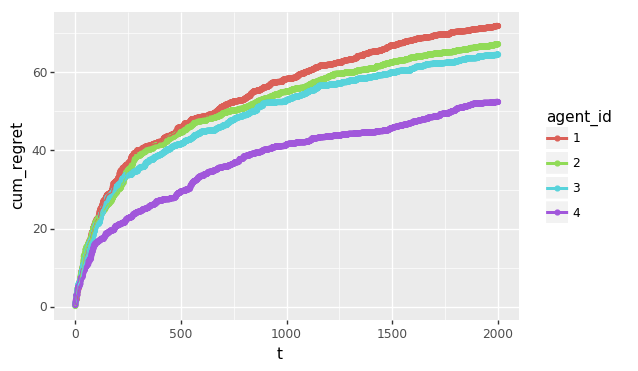

<ggplot: (8731324821745)>


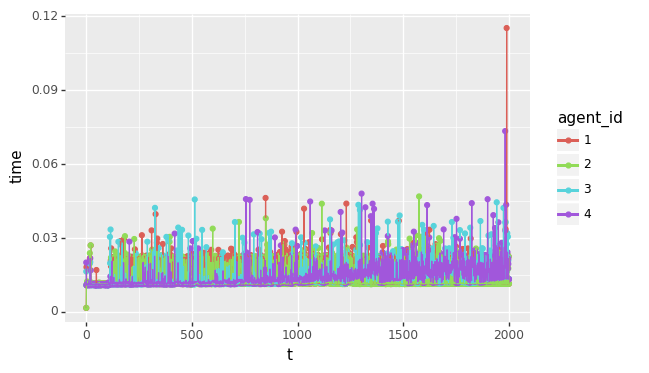

<ggplot: (8731325102281)>


([      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
  0             1        1     0.929448    0.415071        0.415071     1   
  1             2        2     0.929448    0.161610        0.161610     1   
  2             3        3     0.929448    0.422630        0.422630     1   
  3             4        4     0.929448    0.422630        0.422630     1   
  4             5        1     1.655628    0.686038        0.270967     2   
  5             6        2     1.655628    0.819751        0.658141     2   
  6             7        3     1.655628    1.002412        0.579782     2   
  7             8        4     1.655628    1.002412        0.579782     2   
  8             9        1     2.544189    0.990824        0.304786     3   
  9            10        2     2.544189    0.941214        0.121463     3   
  10           11        3     2.544189    1.123875        0.121463     3   
  11           12        4     2.544189    1.468381        0.465969     3   

In [12]:
make_best_sagald_agent = lambda: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=0.01,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = 0.01,
                                              init_pt=None, verbosity=verbosity)
simple_compare([make_best_sagald_agent(), make_best_sagald_agent(),make_best_langevin_agent(),make_best_langevin_agent()], num_articles, dim, var, 2000, 314, verbosity=verbosity)